Thanks for:
* https://www.kaggle.com/sishihara/moa-lgbm-benchmark#Preprocessing

* https://www.kaggle.com/ttahara/osic-baseline-lgbm-with-custom-metric

* https://zenn.dev/fkubota/articles/2b8d46b11c178ac2fa2d

* https://qiita.com/ryouta0506/items/619d9ac0d80f8c0aed92

* https://github.com/nejumi/tools_for_kaggle/blob/master/semi_supervised_learner.py

* https://upura.hatenablog.com/entry/2019/03/03/233534

* https://pompom168.hatenablog.com/entry/2019/07/22/113433


In [1]:
# Version = "v1" # starter model
# Version = "v2" # Compare treat Vs. ctrl and minor modifications, StratifiedKFold
# Version = "v3" # Add debug mode and minor modifications
# Version = "v4" # Clipping a control with an outlier(25-75)
# Version = "v5" # Clipping a control with an outlier(20-80)
# Version = "v6" # under sampling 500 → oversamplling 500, lipping a control with an outlier(10-90)
# Version = "v7" # Use anotated data, under sampling 500 → oversamplling 500, clipping a control with an outlier(10-90)
# Version = "v8" # pasude labeling (thresholds:0.5), timeout
# Version = "v9" # pasude labeling (thresholds:0.6), timeout
# Version = "v10" # pasude labeling (thresholds:0.6), ReduceCol: Kolmogorov-Smirnov, PCA(whiten)&UMAP
# Version = "v11" # pasude labeling (thresholds:0.6), ReduceCol: Kolmogorov-Smirnov, PCA(whiten)&UMAP, lgbm parames adjust
# Version = "v12" # Feature engineering based on feature importance
# Version = "v13" # Calibration, SMOTE(k_neighbors=5→1)
# Version = "v14" # Removed the Calibration, SMOTE(k_neighbors=1), pasude labeling (thresholds:0.7)
# Version = "v15" # Updata anotated data
# Version = "v16" # Remove noisy label(confidence: 0.5)
# Version = "v17" # Modifications with remove noisy label func, Calibration, confidence = y_prob.probability.max()*0.3
# Version = "v18" # SMOTE(k_neighbors=1→2), confidence = y_prob.probability.max()*0.2
Version = "v19" # SMOTE(k_neighbors=2→3),

In [2]:
DEBUG = True

# Library

In [3]:
import lightgbm as lgb
from lightgbm import LGBMClassifier
from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
import imblearn
from imblearn.over_sampling import SMOTE

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import random

from sklearn import preprocessing
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.datasets import make_classification
from sklearn.neighbors import NearestNeighbors

from tqdm.notebook import tqdm
import torch

import warnings
warnings.filterwarnings("ignore")

print("lightgbm Version: ", lgb.__version__)
print("numpy Version: ", np.__version__)
print("pandas Version: ", pd.__version__)
print("imblearn Version: ", imblearn.__version__)

lightgbm Version:  2.3.1
numpy Version:  1.18.5
pandas Version:  1.1.1
imblearn Version:  0.7.0


# Utils

In [4]:
def get_logger(filename='log'):
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.{Version}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

logger = get_logger()


def seed_everything(seed=777):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

# Config

In [5]:
if DEBUG:
    N_FOLD = 2
    Num_boost_round=1000
    Early_stopping_rounds=10
else:
    N_FOLD = 4
    Num_boost_round=10000
    Early_stopping_rounds=39

SEED = 42
seed_everything(seed=SEED)

Max_depth = 7

# Data Loading

In [6]:
train = pd.read_csv("../input/lish-moa/train_features.csv")
test = pd.read_csv("../input/lish-moa/test_features.csv")
train_targets_scored = pd.read_csv("../input/lish-moa/train_targets_scored.csv")
train_targets_nonscored = pd.read_csv("../input/lish-moa/train_targets_nonscored.csv")
sub = pd.read_csv("../input/lish-moa/sample_submission.csv")

In [7]:
def label_encoding(train: pd.DataFrame, test: pd.DataFrame, encode_cols):
    n_train = len(train)
    train = pd.concat([train, test], sort=False).reset_index(drop=True)
    for f in encode_cols:
        try:
            lbl = preprocessing.LabelEncoder()
            train[f] = lbl.fit_transform(list(train[f].values))
        except:
            print(f)
    test = train[n_train:].reset_index(drop=True)
    train = train[:n_train]
    return train, test

In [8]:
annot = pd.read_csv("../input/moa-annot-data/20201024_moa_sig_list.v2.csv")
annot

,sig_id,nonscored1,nonscored2
0,adenylyl_cyclase_activator,adenylyl_cyclase_inhibitor,NaN
1,aldehyde_dehydrogenase_inhibitor,alcohol_dehydrogenase_inhibitor,NaN
2,antiarrhythmic,na_k-atpase_inhibitor,potassium_channel_blocker
3,anticonvulsant,gaba_gated_chloride_channel_blocker,NaN
4,antifungal,fungal_ergosterol_inhibitor,fungal_lanosterol_demethylase_inhibitor
5,antihistamine,histamine_release_inhibitor,NaN
6,atp-sensitive_potassium_channel_antagonist,atp-sensitive_potassium_channel_inhibitor,NaN
7,bacterial_membrane_integrity_inhibitor,bacterial_protein_synthesis_inhibitor,NaN
8,calcineurin_inhibitor,t_cell_inhibitor,NaN
9,catechol_o_methyltransferase_inhibitor,dopamine_release_enhancer,NaN


In [9]:
annot_sig = []
annot_sig = annot.sig_id.tolist()
print(annot_sig)

['adenylyl_cyclase_activator', 'aldehyde_dehydrogenase_inhibitor', 'antiarrhythmic', 'anticonvulsant', 'antifungal', 'antihistamine', 'atp-sensitive_potassium_channel_antagonist', 'bacterial_membrane_integrity_inhibitor', 'calcineurin_inhibitor', 'catechol_o_methyltransferase_inhibitor', 'cdk_inhibitor', 'coagulation_factor_inhibitor', 'elastase_inhibitor', 'erbb2_inhibitor', 'nicotinic_receptor_agonist', 'nitric_oxide_production_inhibitor', 'protein_phosphatase_inhibitor', 'sphingosine_receptor_agonist', 'steroid', 'ubiquitin_specific_protease_inhibitor']


In [10]:
train_target = pd.concat([train_targets_scored, train_targets_nonscored], axis=1)
train_target.head() 

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,ve-cadherin_antagonist,vesicular_monoamine_transporter_inhibitor,vitamin_k_antagonist,voltage-gated_calcium_channel_ligand,voltage-gated_potassium_channel_activator,voltage-gated_sodium_channel_blocker,wdr5_mll_interaction_inhibitor,wnt_agonist,xanthine_oxidase_inhibitor,xiap_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Training Utils

In [11]:
def get_target(target_col, annot_sig):
    if target_col in annot_sig:
        t_cols = []
        for t_col in list(annot[annot.sig_id == target_col].iloc[0]):
            if t_col is not np.nan:
                t_cols.append(t_col)
                target = train_target[t_cols]
                target = target.sum(axis=1)
                #1 or more, replace it with 1.
                target = target.where(target < 1, 1)
    else:
        target = train_targets_scored[target_col]
    
    return target

In [12]:
def calibration(y_pred, target_rate):
    return y_pred / (y_pred + (1 - y_pred) / target_rate)

In [13]:
#===========================================================
# model
#===========================================================
def run_lgbm(target_col: str):
    target = get_target(target_col, annot_sig)
    target_rate = target.sum() / len(target)
    
    trt = train[target==1].copy().reset_index(drop=True)
    trt["target"] = 1
    trt = trt.drop("sig_id", axis=1)
    n_target = max(500,len(trt))
    
    logger.info(f"{target_col} , len(trt) : {len(trt)}")
        
    othr = train[target==0].copy().reset_index(drop=True)
    othr = othr.drop("sig_id", axis=1)
    othr = othr.sample(n=n_target, random_state=42)
    othr["target"] = 0
    
    X_train = pd.concat([trt, othr], axis=0, sort=False, ignore_index=True)
    X_train = X_train.replace([np.inf, -np.inf], np.nan)
    X_train = X_train.fillna(0)
    
    y_train = X_train["target"]
    X_train = X_train.drop("target", axis=1)


    if len(trt) < n_target:
        sm = SMOTE(k_neighbors=3, n_jobs=2, random_state=SEED)
        X_train, y_train = sm.fit_sample(X_train, y_train)
    
    X_test = test.drop("sig_id", axis=1)
    
    train_X, train_y = pseudo_labeling(X_train, y_train, X_test, target_rate)
    
    y_preds = []
    models = []
    oof_train = np.zeros((len(train_X),))
    score = 0
        
    for fold_, (train_index, valid_index) in enumerate(cv.split(train_X, train_y)):
        logger.info(f'len(train_index) : {len(train_index)}')
        logger.info(f'len(valid_index) : {len(valid_index)}')
        
        X_tr = train_X.loc[train_index, :]
        X_val = train_X.loc[valid_index, :]
        y_tr = train_y[train_index]
        y_val = train_y[valid_index]

        lgb_train = lgb.Dataset(X_tr,
                                y_tr,
                                categorical_feature=categorical_cols)

        lgb_eval = lgb.Dataset(X_val,
                               y_val,
                               reference=lgb_train,
                               categorical_feature=categorical_cols)
        
        logger.info(f"================================= fold {fold_+1}/{cv.get_n_splits()} {target_col}=================================")
        
        
        model = lgb.train(params,
                          lgb_train,
                          valid_sets=[lgb_train, lgb_eval],
                          verbose_eval=100,
                          num_boost_round=Num_boost_round,
                          early_stopping_rounds=Early_stopping_rounds)
        
        oof_train[valid_index] = model.predict(X_val, num_iteration=model.best_iteration)

        y_pred = model.predict(X_test, num_iteration=model.best_iteration)
        y_pred_calib = calibration(y_pred, target_rate)
        y_preds.append(y_pred_calib)
        models.append(model)
    
    score = log_loss(train_y, oof_train)
    
    logger.info(f"{target_col} logloss: {score}")
    logger.info(f"=========================================================================================")

    return sum(y_preds) / len(y_preds), score, models, 

In [14]:
classifier_params = {
    'max_depth': Max_depth,
    'num_leaves': int((Max_depth**2)*0.7),
    'n_estimators': Num_boost_round,
    'learning_rate': 0.01,
    'objective': "binary",
    'subsample':0.7,
    'reg_alpha':0.1,
    'reg_lambda':0.1,
    'random_state':SEED,
    'n_jobs':2
    
}

In [15]:
def convert_label(df, confidence, threshold):
    df = df.copy()
    Probability = df.iloc[:,0]
    conf_index = df[Probability > confidence].index.values
    
    Probability = Probability.where(Probability < threshold, 1).copy()
    p_label = Probability.where(Probability >= threshold, 0).copy()
    
    return p_label, conf_index

In [16]:
def pseudo_labeling(X_train, y_train, X_test, target_rate, max_iter=3):
       
    X = X_train.copy()
    y = y_train.copy()
    
    for iter_ in range(1, max_iter+1):
    
        logger.info(f"================= Pseudo labeling {iter_} / {max_iter} =================")
        
        y_preds = np.zeros((X.shape[0], 2))
        y_preds[:, 0] = y.copy()
        
        y_prob = np.zeros((X_test.shape[0]))
        
        X_conf = pd.DataFrame()
        y_conf = pd.DataFrame()
        
        Threshold = 0.5
        
        for fold_, (train_idx, valid_idx) in enumerate(cv.split(X, y)):        
            X_tr, X_val = X.loc[train_idx, :], X.loc[valid_idx, :]
            y_tr, y_val = y[train_idx], y[valid_idx]
            
            clf = LGBMClassifier(**classifier_params)
            
            clf.fit(X_tr, y_tr,
                    eval_set=[(X_tr, y_tr), (X_val, y_val)],
                    eval_metric='logloss',
                    verbose=100,
                    early_stopping_rounds=Early_stopping_rounds)
            
            y_preds[valid_idx, 1] = clf.predict(X_val, num_iteration=clf.best_iteration_)
            y_prob += clf.predict_proba(X_test, num_iteration=clf.best_iteration_)[:, 1] / N_FOLD
        
        y_preds = pd.DataFrame(y_preds, index=X.index, columns=[["Labels", "Preds"]])
        y_preds = y_preds.sum(axis=1)
                
        corect_idx = y_preds[y_preds != 1].index.values
        X_corect, y_corect = X[X.index.isin(corect_idx)], y[y.index.isin(corect_idx)]
        
        logger.info(f"* corect_labels: {sum(y_corect)}/{len(y_corect)}, noisy_labels: {len(y)-len(y_corect)} *")
            
        y_prob = pd.DataFrame(y_prob, index=X_test.index, columns=["probability"])
        
        confidence = y_prob.probability.max()*0.2
        p_label, conf_idx = convert_label(y_prob, confidence=confidence, threshold=Threshold)
        
        p_label_rate = sum(p_label)/len(p_label)        
        logger.info(f"** p_label_rate: {p_label_rate:.4f} Vs.target_rate: {target_rate:.4f}, Num_p_label: {sum(p_label)} **")
        
        # Set the params of threshold based on train labels rate (target_rate).
        # target_rate = target.sum() / len(target)
        if p_label_rate*2 < target_rate:
            check = len(y_prob)*target_rate*3
            for _ in range(10):
                print(sum(p_label), check)
                if (sum(p_label) > check) or (sum(p_label) > 0): break
                Threshold -= 0.03
                p_label, conf_idx = convert_label(y_prob, confidence=confidence, threshold=Threshold)
                y_prob = y_prob[y_prob.index.isin(conf_idx)].copy()
               
                
        if p_label_rate > target_rate*2:
            check = len(y_prob)*target_rate*3
            for _ in range(10):
                if (sum(p_label) < check) or (sum(p_label) < 5): break
                Threshold += 0.04
                
                p_label, conf_idx = convert_label(y_prob, confidence=confidence, threshold=Threshold)
                y_prob = y_prob[y_prob.index.isin(conf_idx)].copy()
                
              
        X_conf = X_test[X_test.index.isin(conf_idx)].copy()
        
        logger.info(f"*** confidence:{confidence}, threshold:{Threshold}, p_label:{sum(p_label)}/{len(p_label)} ***")
 
        X = pd.concat([X_corect, X_conf], axis=0, ignore_index=True)
        y = pd.concat([y_corect, p_label], axis=0, ignore_index=True)
        
        X = X.drop_duplicates().reset_index(drop=True)
        y = y[X.index.values].reset_index(drop=True)
        
    return X, y

In [17]:
def show_feature_importance(feature_importance_df, num=100):
    cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:num].index)
    best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

    plt.figure(figsize=(8, 30))
    sns.barplot(x="importance", 
                y="Feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title('Features importance (averaged)')
    plt.tight_layout()
    plt.savefig(f"./feature_importance_{Version}.png")
    plt.show()

# Preprocessing

We have to convert some categorical features into numbers in train and test. We can identify categorical features by `pd.DataFrame.select_dtypes`.

In [18]:
train.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [19]:
train.select_dtypes(include=['object']).columns

Index(['sig_id', 'cp_type', 'cp_dose'], dtype='object')

In [20]:
train, test = label_encoding(train, test, ['cp_type', 'cp_time', 'cp_dose'])

In [21]:
train['WHERE'] = 'train'
test['WHERE'] = 'test'

data = train.append(test)
data = data.reset_index(drop=True)
data

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,WHERE
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176,train
1,id_000779bfc,1,2,0,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371,train
2,id_000a6266a,1,1,0,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931,train
3,id_0015fd391,1,1,0,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154,train
4,id_001626bd3,1,2,1,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_ff7004b87,1,0,0,0.4571,-0.5743,3.3930,-0.6202,0.8557,1.6240,...,-0.6422,-0.4367,0.0159,-0.6539,-0.4791,-1.2680,-1.1280,-0.4167,-0.6600,test
27792,id_ff925dd0d,1,0,0,-0.5885,-0.2548,2.5850,0.3456,0.4401,0.3107,...,0.5780,-0.5888,0.8057,0.9312,1.2730,0.2614,-0.2790,-0.0131,-0.0934,test
27793,id_ffb710450,1,2,0,-0.3985,-0.1554,0.2677,-0.6813,0.0152,0.4791,...,0.9153,-0.1862,0.4049,0.9568,0.4666,0.0461,0.5888,-0.4205,-0.1504,test
27794,id_ffbb869f2,1,1,1,-1.0960,-1.7750,-0.3977,1.0160,-1.3350,-0.2207,...,-0.4473,-0.8192,0.7785,0.3133,0.1286,-0.2618,0.5074,0.7430,-0.0484,test


In [22]:
# Select control data
ctl = train[(train.cp_type==0)]
ctl

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,WHERE
25,id_0054388ec,0,1,0,-0.6696,-0.2718,-1.2230,-0.6226,-0.7220,0.1588,...,0.6405,0.5429,0.3562,1.3290,0.5573,0.8837,0.5534,0.8976,1.0050,train
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-0.6828,-0.6594,-0.2043,0.3571,-0.1319,0.2187,0.0737,0.6498,-1.4820,train
40,id_007bfbb91,0,0,1,-1.3200,-1.7340,-0.0741,1.5440,-1.8290,-0.0951,...,1.0340,0.7393,1.1020,0.3786,0.2636,-0.5751,0.3362,0.8543,0.9180,train
47,id_008a986b7,0,1,1,0.4860,0.1430,0.5281,-0.0022,-0.2334,-0.6607,...,-0.1866,0.7629,0.3288,-0.9915,-0.3694,-0.4979,0.5281,-0.9245,-0.9367,train
63,id_009d8340f,0,0,1,0.4471,-0.0839,-0.3864,0.3196,0.2584,-0.3156,...,0.3939,0.7665,0.7932,-0.6804,-0.0435,0.0949,0.2000,-0.4326,0.9364,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23729,id_ff1f9e5fc,0,0,0,0.0465,0.6430,-0.2453,0.3521,0.6195,-0.6659,...,0.1621,-0.2065,0.8314,-0.1891,-0.0074,0.2131,-0.1419,-0.2422,0.0457,train
23747,id_ff469c482,0,2,0,-0.6204,-1.3800,-1.1880,-0.6573,-0.8408,-0.2447,...,0.7366,0.5468,1.1450,0.5254,0.6224,-0.9630,0.8872,-0.0742,-0.6777,train
23768,id_ff89331ca,0,2,1,-0.1051,0.4335,0.3648,-0.0525,-0.3632,-0.3228,...,0.4885,0.4963,0.9434,-0.4779,0.6951,0.9517,-0.8110,-0.1748,-0.3626,train
23793,id_ffd26f361,0,1,1,0.6008,0.2781,-0.3319,-0.8782,0.9281,0.7535,...,0.9569,-0.2065,-0.4918,0.7863,0.0504,0.8813,0.7757,-0.5272,0.7082,train


In [23]:
# clipping

def outlaier_clip(df):
    df = df.copy()
    clipping = df.columns[4:6]
    for col in clipping:
        lower, upper= np.percentile(df[col], [10, 90])
        df[col] = np.clip(df[col], lower, upper)
    
    return df

ctl_df = pd.DataFrame(columns=train.columns)
for i in ctl.cp_time.unique():
    for j in ctl.cp_dose.unique():
        print(len(ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)]))
        tmp_ctl = ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)]
        tmp_ctl = outlaier_clip(tmp_ctl)
        ctl_df = pd.concat([ctl_df, tmp_ctl], axis=0).reset_index(drop=True)
ctl_df

343
305
301
305
307
305


,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,WHERE
0,id_0054388ec,0,1,0,-0.6696,-0.27180,-1.2230,-0.6226,-0.7220,0.1588,...,0.6405,0.5429,0.3562,1.3290,0.5573,0.8837,0.5534,0.8976,1.0050,train
1,id_01b05de6c,0,1,0,-0.3176,0.48512,-0.3773,0.5555,-0.4877,0.3413,...,-0.6163,0.8001,0.3389,0.7437,0.7533,0.2406,0.5057,0.8017,1.0280,train
2,id_020ba48d9,0,1,0,0.8094,-0.33390,1.1130,-0.4192,0.4545,-0.4771,...,-0.4414,-0.2442,0.0557,-0.6597,-0.3713,-0.6929,-0.3258,0.3602,-0.0595,train
3,id_02c93b4a5,0,1,0,-0.0884,-1.54100,0.5562,0.4661,-0.1683,0.9515,...,0.4766,0.9697,0.4613,0.8957,0.8227,1.2300,1.7180,0.6542,0.0580,train
4,id_03bc6d412,0,1,0,0.8431,0.09310,-0.0958,-0.4337,1.0690,-0.6440,...,-1.1510,-0.5010,-0.2736,0.1270,0.3511,0.1233,-0.8520,0.1767,0.1153,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1861,id_fbb620181,0,2,1,-0.3490,0.72970,-4.1480,-1.0030,2.4070,-0.9784,...,-1.4260,-0.8613,-0.0243,-0.6109,0.6377,-1.2590,-0.7238,-0.7734,-0.1274,train
1862,id_fbba92030,0,2,1,-0.8921,1.13520,0.4227,1.3270,-0.9839,-0.8469,...,1.1340,0.7007,1.3320,0.6622,0.6167,0.9459,-0.0344,-0.0186,0.5173,train
1863,id_fbc0849ad,0,2,1,-0.2948,0.21960,-0.3252,-0.2084,-0.6518,0.3542,...,0.5014,0.6009,0.4560,-0.3360,-0.5091,0.6569,0.6203,0.6764,0.4504,train
1864,id_fd93fa37d,0,2,1,-0.2984,-0.47880,-2.3560,-0.6848,1.8700,1.0240,...,-0.4422,-0.6665,-0.8033,-1.0520,0.4103,0.4462,-1.1580,-1.3060,0.1925,train


In [24]:
col_list = list(data.columns)[:-1]
data_df = pd.DataFrame(columns=col_list)
Splitdata = []
d = 1e-6

for i in data.cp_time.unique():
    for j in data.cp_dose.unique():
        select = data[(data.cp_time==i) & (data.cp_dose==j)]
        print(len(select))
        
        for k in list(select['WHERE']):
                      Splitdata.append(k)
        
        select = select.drop(columns='WHERE')
        med = ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)].iloc[:, 4:].median()
        f_div = lambda x: (x+d) / (abs(med)+d)
        select_d = select.iloc[:,4:].apply(f_div, axis=1).add_prefix('d_')
        tmp_data = pd.concat([select,select_d], axis=1, sort=False)
        data_df = pd.concat([data_df, tmp_data], axis=0)
data_df

4534
4538
4561
4536
5079
4548


,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,d_c-90,d_c-91,d_c-92,d_c-93,d_c-94,d_c-95,d_c-96,d_c-97,d_c-98,d_c-99
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.900850,0.827675,4.339584,1.312811,-0.411268,1.931922,-1.059899,0.630788,1.112379,1.125303
5,id_001762a82,1,0,0,-0.6111,0.2941,-0.9901,0.2277,1.2810,0.5203,...,5.788465,3.705949,-5.437902,4.518651,3.069473,1.325997,3.226831,1.110292,2.296748,3.769866
36,id_00762e877,1,0,0,-0.4026,0.1662,-0.6307,-0.4438,-0.5992,-0.2523,...,-2.000935,-0.524979,-0.457811,0.341813,0.017855,2.201874,1.442491,2.479205,0.934446,1.298032
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-1.221271,-2.187049,-3.543232,-0.485616,0.768123,-0.387026,0.582269,0.217342,1.901665,-3.993519
39,id_0079d45d3,1,0,0,1.6310,-2.1430,-0.0943,-1.1990,0.4869,-0.0935,...,-9.203619,-18.488086,-10.402948,-6.859977,-5.953954,-7.288708,-7.193801,-6.644035,-14.152721,-1.741033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27754,id_fca887f42,1,1,1,-0.4157,-0.0461,-0.9751,0.7702,-0.1861,0.3608,...,3.364808,-2.944165,4.362395,-1.059934,-0.200288,3.648613,2.751680,-1.381859,0.808258,-2.753843
27759,id_fce497048,1,1,1,0.7107,-0.3274,-0.0099,-1.4950,0.6673,-1.5380,...,-6.666625,-2.994822,-108.965314,-3.263314,-19.418785,-5.186308,-16.265106,-3.400727,-8.642374,-6.611932
27768,id_fd75349b2,1,1,1,-0.0776,0.4437,-0.1530,1.2300,-0.5804,0.0633,...,1.461452,1.221387,-12.977688,-1.847446,-1.481351,-3.441418,2.191467,1.214694,-7.687163,-2.167938
27784,id_fed0f2fe0,1,1,1,-1.0740,0.7350,0.3304,-0.6764,0.1435,-1.6810,...,-5.310498,-2.757956,9.262242,-3.612217,-2.189681,-6.566071,-10.169072,-3.150643,-3.656387,-5.960391


In [25]:
# clipping
clipping = data_df.columns[4:]
for col in clipping:
    lower, upper = np.percentile(data_df[col], [1, 99])
    data_df[col] = np.clip(data_df[col], lower, upper)
data_df

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,d_c-90,d_c-91,d_c-92,d_c-93,d_c-94,d_c-95,d_c-96,d_c-97,d_c-98,d_c-99
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.900850,0.827675,4.339584,1.312811,-0.411268,1.931922,-1.059899,0.630788,1.112379,1.125303
5,id_001762a82,1,0,0,-0.6111,0.2941,-0.9901,0.2277,1.2810,0.5203,...,5.788465,3.705949,-5.437902,4.518651,3.069473,1.325997,3.226831,1.110292,2.296748,3.769866
36,id_00762e877,1,0,0,-0.4026,0.1662,-0.6307,-0.4438,-0.5992,-0.2523,...,-2.000935,-0.524979,-0.457811,0.341813,0.017855,2.201874,1.442491,2.479205,0.934446,1.298032
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-1.221271,-2.187049,-3.543232,-0.485616,0.768123,-0.387026,0.582269,0.217342,1.901665,-3.993519
39,id_0079d45d3,1,0,0,1.6310,-2.1430,-0.0943,-1.1990,0.4869,-0.0935,...,-9.203619,-18.488086,-10.402948,-6.859977,-5.953954,-7.288708,-7.193801,-6.644035,-14.152721,-1.741033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27754,id_fca887f42,1,1,1,-0.4157,-0.0461,-0.9751,0.7702,-0.1861,0.3608,...,3.364808,-2.944165,4.362395,-1.059934,-0.200288,3.648613,2.751680,-1.381859,0.808258,-2.753843
27759,id_fce497048,1,1,1,0.7107,-0.3274,-0.0099,-1.4950,0.6673,-1.5380,...,-6.666625,-2.994822,-108.965314,-3.263314,-19.418785,-5.186308,-16.265106,-3.400727,-8.642374,-6.611932
27768,id_fd75349b2,1,1,1,-0.0776,0.4437,-0.1530,1.2300,-0.5804,0.0633,...,1.461452,1.221387,-12.977688,-1.847446,-1.481351,-3.441418,2.191467,1.214694,-7.687163,-2.167938
27784,id_fed0f2fe0,1,1,1,-1.0740,0.7350,0.3304,-0.6764,0.1435,-1.6810,...,-5.310498,-2.757956,9.262242,-3.612217,-2.189681,-6.566071,-10.169072,-3.150643,-3.656387,-5.960391


In [26]:
data_df.cp_type = data_df.cp_type.astype('int64')
data_df.cp_time = data_df.cp_time.astype('int64')
data_df.cp_dose = data_df.cp_dose.astype('int64')
data_df.dtypes

sig_id      object
cp_type      int64
cp_time      int64
cp_dose      int64
g-0        float64
            ...   
d_c-95     float64
d_c-96     float64
d_c-97     float64
d_c-98     float64
d_c-99     float64
Length: 1748, dtype: object

In [27]:
data_df = data_df.replace([np.inf, -np.inf], np.nan)
data_df = data_df.dropna(how='any', axis=1)
data_df

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,d_c-90,d_c-91,d_c-92,d_c-93,d_c-94,d_c-95,d_c-96,d_c-97,d_c-98,d_c-99
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.900850,0.827675,4.339584,1.312811,-0.411268,1.931922,-1.059899,0.630788,1.112379,1.125303
5,id_001762a82,1,0,0,-0.6111,0.2941,-0.9901,0.2277,1.2810,0.5203,...,5.788465,3.705949,-5.437902,4.518651,3.069473,1.325997,3.226831,1.110292,2.296748,3.769866
36,id_00762e877,1,0,0,-0.4026,0.1662,-0.6307,-0.4438,-0.5992,-0.2523,...,-2.000935,-0.524979,-0.457811,0.341813,0.017855,2.201874,1.442491,2.479205,0.934446,1.298032
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-1.221271,-2.187049,-3.543232,-0.485616,0.768123,-0.387026,0.582269,0.217342,1.901665,-3.993519
39,id_0079d45d3,1,0,0,1.6310,-2.1430,-0.0943,-1.1990,0.4869,-0.0935,...,-9.203619,-18.488086,-10.402948,-6.859977,-5.953954,-7.288708,-7.193801,-6.644035,-14.152721,-1.741033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27754,id_fca887f42,1,1,1,-0.4157,-0.0461,-0.9751,0.7702,-0.1861,0.3608,...,3.364808,-2.944165,4.362395,-1.059934,-0.200288,3.648613,2.751680,-1.381859,0.808258,-2.753843
27759,id_fce497048,1,1,1,0.7107,-0.3274,-0.0099,-1.4950,0.6673,-1.5380,...,-6.666625,-2.994822,-108.965314,-3.263314,-19.418785,-5.186308,-16.265106,-3.400727,-8.642374,-6.611932
27768,id_fd75349b2,1,1,1,-0.0776,0.4437,-0.1530,1.2300,-0.5804,0.0633,...,1.461452,1.221387,-12.977688,-1.847446,-1.481351,-3.441418,2.191467,1.214694,-7.687163,-2.167938
27784,id_fed0f2fe0,1,1,1,-1.0740,0.7350,0.3304,-0.6764,0.1435,-1.6810,...,-5.310498,-2.757956,9.262242,-3.612217,-2.189681,-6.566071,-10.169072,-3.150643,-3.656387,-5.960391


In [28]:
data_df['WHERE'] = Splitdata
data_df

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,d_c-91,d_c-92,d_c-93,d_c-94,d_c-95,d_c-96,d_c-97,d_c-98,d_c-99,WHERE
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.827675,4.339584,1.312811,-0.411268,1.931922,-1.059899,0.630788,1.112379,1.125303,train
5,id_001762a82,1,0,0,-0.6111,0.2941,-0.9901,0.2277,1.2810,0.5203,...,3.705949,-5.437902,4.518651,3.069473,1.325997,3.226831,1.110292,2.296748,3.769866,train
36,id_00762e877,1,0,0,-0.4026,0.1662,-0.6307,-0.4438,-0.5992,-0.2523,...,-0.524979,-0.457811,0.341813,0.017855,2.201874,1.442491,2.479205,0.934446,1.298032,train
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-2.187049,-3.543232,-0.485616,0.768123,-0.387026,0.582269,0.217342,1.901665,-3.993519,train
39,id_0079d45d3,1,0,0,1.6310,-2.1430,-0.0943,-1.1990,0.4869,-0.0935,...,-18.488086,-10.402948,-6.859977,-5.953954,-7.288708,-7.193801,-6.644035,-14.152721,-1.741033,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27754,id_fca887f42,1,1,1,-0.4157,-0.0461,-0.9751,0.7702,-0.1861,0.3608,...,-2.944165,4.362395,-1.059934,-0.200288,3.648613,2.751680,-1.381859,0.808258,-2.753843,test
27759,id_fce497048,1,1,1,0.7107,-0.3274,-0.0099,-1.4950,0.6673,-1.5380,...,-2.994822,-108.965314,-3.263314,-19.418785,-5.186308,-16.265106,-3.400727,-8.642374,-6.611932,test
27768,id_fd75349b2,1,1,1,-0.0776,0.4437,-0.1530,1.2300,-0.5804,0.0633,...,1.221387,-12.977688,-1.847446,-1.481351,-3.441418,2.191467,1.214694,-7.687163,-2.167938,test
27784,id_fed0f2fe0,1,1,1,-1.0740,0.7350,0.3304,-0.6764,0.1435,-1.6810,...,-2.757956,9.262242,-3.612217,-2.189681,-6.566071,-10.169072,-3.150643,-3.656387,-5.960391,test


In [29]:
train = data_df[data_df['WHERE']=="train"].drop('WHERE', axis=1)
test = data_df[data_df['WHERE']=="test"].drop('WHERE', axis=1)

In [30]:
# Kolmogorov-Smirnov test applied for train data and test data.

from scipy.stats import ks_2samp

tr = train.iloc[:, 4:]
ts = test.iloc[:, 4:]

list_p_value =[ks_2samp(ts[i], tr[i])[1] for i in tqdm(tr.columns)]
Se = pd.Series(list_p_value, index=tr.columns).sort_values() 
list_discarded = list(Se[Se < .1].index)

train = train.drop(list_discarded, axis=1)
test = test.drop(list_discarded, axis=1)

print(f"Removed {len(list_discarded)} columns")


Removed 408 columns


In [31]:
train['WHERE'] = 'train'
test['WHERE'] = 'test'

data = train.append(test)
data = data.reset_index(drop=True)
data

,sig_id,cp_type,cp_time,cp_dose,g-1,g-2,g-4,g-5,g-6,g-8,...,d_c-87,d_c-89,d_c-90,d_c-91,d_c-92,d_c-94,d_c-95,d_c-97,d_c-99,WHERE
0,id_000644bb2,1,0,0,0.5577,-0.2479,-0.1944,-1.0120,-1.0220,0.5548,...,-0.458706,3.210844,0.900850,0.827675,4.339584,-0.411268,1.931922,0.630788,1.125303,train
1,id_001762a82,1,0,0,0.2941,-0.9901,1.2810,0.5203,0.0543,-0.1586,...,4.198996,7.411112,5.788465,3.705949,-5.437902,3.069473,1.325997,1.110292,3.769866,train
2,id_00762e877,1,0,0,0.1662,-0.6307,-0.5992,-0.2523,-1.3770,-1.4880,...,2.130879,2.780971,-2.000935,-0.524979,-0.457811,0.017855,2.201874,2.479205,1.298032,train
3,id_0079af0fb,0,0,0,-1.8230,-0.5211,-1.1280,0.6041,0.3856,-0.5400,...,0.036750,2.267525,-1.221271,-2.187049,-3.543232,0.768123,-0.387026,0.217342,-3.993519,train
4,id_0079d45d3,1,0,0,-2.1430,-0.0943,0.4869,-0.0935,1.2090,-1.5450,...,-18.897523,-9.183429,-9.203619,-18.488086,-10.402948,-5.953954,-7.288708,-6.644035,-1.741033,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_fca887f42,1,1,1,-0.0461,-0.9751,-0.1861,0.3608,0.5174,0.9298,...,10.394855,-23.040415,3.364808,-2.944165,4.362395,-0.200288,3.648613,-1.381859,-2.753843,test
27792,id_fce497048,1,1,1,-0.3274,-0.0099,0.6673,-1.5380,-0.5368,2.1020,...,-53.796375,-33.477371,-6.666625,-2.994822,-108.965314,-19.418785,-5.186308,-3.400727,-6.611932,test
27793,id_fd75349b2,1,1,1,0.4437,-0.1530,-0.5804,0.0633,0.6952,-0.1058,...,110.075643,53.955575,1.461452,1.221387,-12.977688,-1.481351,-3.441418,1.214694,-2.167938,test
27794,id_fed0f2fe0,1,1,1,0.7350,0.3304,0.1435,-1.6810,-1.1370,-0.4083,...,-26.830434,-50.825426,-5.310498,-2.757956,9.262242,-2.189681,-6.566071,-3.150643,-5.960391,test


In [32]:
Splitdata = data["WHERE"]
data = data.drop('WHERE', axis=1)
data

,sig_id,cp_type,cp_time,cp_dose,g-1,g-2,g-4,g-5,g-6,g-8,...,d_c-85,d_c-87,d_c-89,d_c-90,d_c-91,d_c-92,d_c-94,d_c-95,d_c-97,d_c-99
0,id_000644bb2,1,0,0,0.5577,-0.2479,-0.1944,-1.0120,-1.0220,0.5548,...,0.610453,-0.458706,3.210844,0.900850,0.827675,4.339584,-0.411268,1.931922,0.630788,1.125303
1,id_001762a82,1,0,0,0.2941,-0.9901,1.2810,0.5203,0.0543,-0.1586,...,2.368506,4.198996,7.411112,5.788465,3.705949,-5.437902,3.069473,1.325997,1.110292,3.769866
2,id_00762e877,1,0,0,0.1662,-0.6307,-0.5992,-0.2523,-1.3770,-1.4880,...,-2.098055,2.130879,2.780971,-2.000935,-0.524979,-0.457811,0.017855,2.201874,2.479205,1.298032
3,id_0079af0fb,0,0,0,-1.8230,-0.5211,-1.1280,0.6041,0.3856,-0.5400,...,0.927045,0.036750,2.267525,-1.221271,-2.187049,-3.543232,0.768123,-0.387026,0.217342,-3.993519
4,id_0079d45d3,1,0,0,-2.1430,-0.0943,0.4869,-0.0935,1.2090,-1.5450,...,-12.466870,-18.897523,-9.183429,-9.203619,-18.488086,-10.402948,-5.953954,-7.288708,-6.644035,-1.741033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_fca887f42,1,1,1,-0.0461,-0.9751,-0.1861,0.3608,0.5174,0.9298,...,0.977743,10.394855,-23.040415,3.364808,-2.944165,4.362395,-0.200288,3.648613,-1.381859,-2.753843
27792,id_fce497048,1,1,1,-0.3274,-0.0099,0.6673,-1.5380,-0.5368,2.1020,...,-3.525817,-53.796375,-33.477371,-6.666625,-2.994822,-108.965314,-19.418785,-5.186308,-3.400727,-6.611932
27793,id_fd75349b2,1,1,1,0.4437,-0.1530,-0.5804,0.0633,0.6952,-0.1058,...,2.350949,110.075643,53.955575,1.461452,1.221387,-12.977688,-1.481351,-3.441418,1.214694,-2.167938
27794,id_fed0f2fe0,1,1,1,0.7350,0.3304,0.1435,-1.6810,-1.1370,-0.4083,...,-6.247984,-26.830434,-50.825426,-5.310498,-2.757956,9.262242,-2.189681,-6.566071,-3.150643,-5.960391


In [33]:
# Based on v8 notebook with feature importance

def select_importance_cols(feature_importance_df, num=103):
    best_cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:num].index)
    return best_cols


Feature_importance_df = pd.read_csv("../input/../input/moa-annot-data/feature_importance_df.v8.colab.csv")
Feature_importance_df

importance_cols = select_importance_cols(Feature_importance_df)

len(importance_cols)

103

In [34]:
FI = data[importance_cols]
FI = FI.drop(["cp_type", "cp_time", "cp_dose"], axis=1)
FI

,c-98,g-763,g-231,g-178,g-91,g-635,d_g-87,g-254,d_g-202,g-207,...,d_g-39,g-569,g-65,d_g-743,d_g-580,g-105,d_g-157,g-201,d_g-435,c-67
0,0.3801,-0.3167,-1.6510,-0.6217,-1.1230,-0.2461,4.183851,-1.3310,20.720024,-0.22130,...,-0.463249,0.1242,0.0251,2.647177,-10.548861,-1.2560,-0.262194,0.4171,-2.345232,1.2570
1,0.7848,0.4842,0.0333,-0.5141,0.4944,-1.1160,-9.101135,0.5149,-121.467612,0.07920,...,0.712450,0.4590,-0.2584,1.543021,2.532123,-0.2533,-2.819025,-0.4584,3.110345,0.4290
2,0.3193,0.4587,-0.8791,0.2905,-0.1851,0.0860,-5.791252,-1.6090,134.510130,-0.07250,...,1.025284,-0.2491,0.1676,-3.476730,-1.085747,-0.5656,-3.664973,0.6659,-3.906875,-0.3232
3,0.6498,0.6086,-0.5522,0.4275,-0.7775,0.2270,-2.712772,0.8298,74.254500,-1.66400,...,-0.539958,1.3530,-0.2259,-0.720046,31.350629,0.3576,0.201876,0.0597,3.599244,-0.9233
4,-4.8360,-1.1320,2.3720,-0.8283,1.5840,-2.3630,-1.055764,-0.9043,140.770455,3.85415,...,3.627592,-4.4690,1.8870,-9.592403,43.259989,0.0328,-3.335726,4.2690,3.422303,-0.8781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,0.2310,-0.2914,0.1655,0.2242,0.1058,-1.0330,-2.921354,0.5788,-13.888734,-0.31340,...,-1.244962,-0.4987,-0.4098,0.769766,-155.100886,0.1914,-4.482931,-0.5465,0.340697,-0.6500
27792,-2.4700,1.0300,0.2641,-1.0190,5.7110,-2.3140,-19.551915,1.8170,56.104299,0.69710,...,1.129264,-4.7070,4.7440,2.384589,1016.814588,-0.1688,6.439848,0.8439,-2.063460,-5.1430
27793,-2.1970,0.0199,0.0428,0.7036,2.8370,0.9448,5.732132,-1.6010,-249.158505,-2.55600,...,-1.024153,-0.0303,0.7360,-5.974495,-110.383776,1.5240,9.631421,0.1586,1.600912,-0.7809
27794,-1.0450,-0.2809,-0.8224,0.2189,-1.0990,0.9241,-0.123390,-1.4440,-7.429982,0.82050,...,1.669632,0.6461,-0.4913,3.565008,253.578959,0.7208,5.579313,-0.2808,-0.563337,-0.8265


In [35]:
g_list = [col for col in data.columns[4:] if col.startswith("g-")]
c_list = [col for col in data.columns[4:] if col.startswith("c-")]
d_g_list = [col for col in data.columns[4:] if col.startswith("d_g-")]
d_c_list = [col for col in data.columns[4:] if col.startswith("d_c-")]

g_list

['g-1',
 'g-2',
 'g-4',
 'g-5',
 'g-6',
 'g-8',
 'g-9',
 'g-10',
 'g-12',
 'g-13',
 'g-14',
 'g-15',
 'g-16',
 'g-18',
 'g-19',
 'g-20',
 'g-23',
 'g-24',
 'g-25',
 'g-26',
 'g-27',
 'g-28',
 'g-29',
 'g-30',
 'g-31',
 'g-32',
 'g-33',
 'g-34',
 'g-35',
 'g-36',
 'g-38',
 'g-39',
 'g-40',
 'g-41',
 'g-42',
 'g-43',
 'g-44',
 'g-45',
 'g-46',
 'g-47',
 'g-48',
 'g-49',
 'g-50',
 'g-51',
 'g-53',
 'g-54',
 'g-55',
 'g-56',
 'g-57',
 'g-58',
 'g-59',
 'g-61',
 'g-62',
 'g-64',
 'g-65',
 'g-67',
 'g-69',
 'g-70',
 'g-71',
 'g-73',
 'g-74',
 'g-77',
 'g-78',
 'g-79',
 'g-81',
 'g-83',
 'g-87',
 'g-88',
 'g-89',
 'g-90',
 'g-91',
 'g-93',
 'g-94',
 'g-95',
 'g-96',
 'g-97',
 'g-99',
 'g-103',
 'g-104',
 'g-105',
 'g-106',
 'g-107',
 'g-108',
 'g-109',
 'g-110',
 'g-111',
 'g-113',
 'g-114',
 'g-115',
 'g-116',
 'g-117',
 'g-118',
 'g-119',
 'g-121',
 'g-122',
 'g-123',
 'g-124',
 'g-125',
 'g-126',
 'g-127',
 'g-128',
 'g-129',
 'g-130',
 'g-131',
 'g-132',
 'g-133',
 'g-136',
 'g-137',
 'g-

In [36]:
from sklearn.preprocessing import StandardScaler
    
# Z-score
scaler = StandardScaler(with_mean=True, with_std=True)
std_values = scaler.fit_transform(data.iloc[:, 4:])
std_df = pd.DataFrame(std_values, index=data.index, columns=data.columns[4:])
    

In [37]:
from sklearn.decomposition import PCA
from umap import UMAP

# PCA for all data
pca_transformer = PCA(n_components=0.9, whiten=True, random_state=SEED)
pca_all = pca_transformer.fit_transform(std_df)

# PCA → UMAP for all data
umap = UMAP(n_components=10, random_state=SEED)
pca_umap_all = umap.fit_transform(pca_all)

print(pca_umap_all.shape)

(27796, 10)


In [38]:
# PCA for merged categories
g_d_g_list = g_list + d_g_list
c_d_c_list = c_list + d_c_list

pca_transformer = PCA(n_components=0.9, whiten=True, random_state=SEED)
pca_g_d_g = pca_transformer.fit_transform(std_df[g_d_g_list])
pca_c_d_c = pca_transformer.fit_transform(std_df[c_d_c_list])

# PCA → UMAP for merged categories
umap = UMAP(n_components=10, random_state=SEED)
pca_umap_g_d_g = umap.fit_transform(pca_g_d_g)

umap = UMAP(n_components=2, random_state=SEED)
pca_umap_c_d_c = umap.fit_transform(pca_c_d_c)

print(pca_umap_g_d_g.shape)
print(pca_umap_c_d_c.shape)

(27796, 10)
(27796, 2)


In [39]:
# PCA for each category
pca_transformer = PCA(n_components=0.9, whiten=True, random_state=SEED)
pca_g = pca_transformer.fit_transform(std_df[g_list])
pca_c = pca_transformer.fit_transform(std_df[c_list])
pca_d_g = pca_transformer.fit_transform(std_df[d_g_list])
pca_d_c = pca_transformer.fit_transform(std_df[d_c_list])

print(pca_g.shape)
print(pca_c.shape)
print(pca_d_g.shape)
print(pca_d_c.shape)

# PCA → UMAP for each category
umap = UMAP(n_components=10, random_state=SEED)
pca_umap_g = umap.fit_transform(pca_g)
pca_umap_d_g = umap.fit_transform(pca_d_g)

umap = UMAP(n_components=2, random_state=SEED)
pca_umap_c = umap.fit_transform(pca_c)
pca_umap_d_c = umap.fit_transform(pca_d_c)

print(pca_umap_g.shape)
print(pca_umap_c.shape)
print(pca_umap_d_g.shape)
print(pca_umap_d_c.shape)

(27796, 323)
(27796, 13)
(27796, 394)
(27796, 25)
(27796, 10)
(27796, 2)
(27796, 10)
(27796, 2)


In [40]:
# PCA for all categories
pca_transformer = PCA(n_components=3, whiten=True, random_state=SEED)

pca_all = pca_transformer.fit_transform(std_df)
pca_g_d_g = pca_transformer.fit_transform(std_df[g_d_g_list])
pca_c_d_c = pca_transformer.fit_transform(std_df[c_d_c_list])
pca_g = pca_transformer.fit_transform(std_df[g_list])
pca_c = pca_transformer.fit_transform(std_df[c_list])
pca_d_g = pca_transformer.fit_transform(std_df[d_g_list])
pca_d_c = pca_transformer.fit_transform(std_df[d_c_list])

print(pca_all.shape)
print(pca_g_d_g.shape)
print(pca_c_d_c.shape)
print(pca_g.shape)
print(pca_c.shape)
print(pca_d_g.shape)
print(pca_d_c.shape)

(27796, 3)
(27796, 3)
(27796, 3)
(27796, 3)
(27796, 3)
(27796, 3)
(27796, 3)


In [41]:
data_list = [ 
    pca_umap_all,
    pca_umap_g_d_g,
    pca_umap_c_d_c,
    pca_umap_g,
    pca_umap_c,
    pca_umap_d_g,
    pca_umap_d_c,
    pca_all,
    pca_g_d_g,
    pca_c_d_c,
    pca_g,
    pca_c,
    pca_d_g,
    pca_d_c,
]

data_names = [ 
    "pca_umap_all",
    "pca_umap_g_d_g",
    "pca_umap_c_d_c",
    "pca_umap_g",
    "pca_umap_c",
    "pca_umap_d_g",
    "pca_umap_d_c",
    "pca_all",
    "pca_g_d_g",
    "pca_c_d_c",
    "pca_g",
    "pca_c",
    "pca_d_g",
    "pca_d_c",
]

In [42]:
col_list = []
for i, d in enumerate(data_list):
    for j in range(d.shape[1]):
        col_list.append( f"{data_names[i]}_{j+1}")
col_list

['pca_umap_all_1',
 'pca_umap_all_2',
 'pca_umap_all_3',
 'pca_umap_all_4',
 'pca_umap_all_5',
 'pca_umap_all_6',
 'pca_umap_all_7',
 'pca_umap_all_8',
 'pca_umap_all_9',
 'pca_umap_all_10',
 'pca_umap_g_d_g_1',
 'pca_umap_g_d_g_2',
 'pca_umap_g_d_g_3',
 'pca_umap_g_d_g_4',
 'pca_umap_g_d_g_5',
 'pca_umap_g_d_g_6',
 'pca_umap_g_d_g_7',
 'pca_umap_g_d_g_8',
 'pca_umap_g_d_g_9',
 'pca_umap_g_d_g_10',
 'pca_umap_c_d_c_1',
 'pca_umap_c_d_c_2',
 'pca_umap_g_1',
 'pca_umap_g_2',
 'pca_umap_g_3',
 'pca_umap_g_4',
 'pca_umap_g_5',
 'pca_umap_g_6',
 'pca_umap_g_7',
 'pca_umap_g_8',
 'pca_umap_g_9',
 'pca_umap_g_10',
 'pca_umap_c_1',
 'pca_umap_c_2',
 'pca_umap_d_g_1',
 'pca_umap_d_g_2',
 'pca_umap_d_g_3',
 'pca_umap_d_g_4',
 'pca_umap_d_g_5',
 'pca_umap_d_g_6',
 'pca_umap_d_g_7',
 'pca_umap_d_g_8',
 'pca_umap_d_g_9',
 'pca_umap_d_g_10',
 'pca_umap_d_c_1',
 'pca_umap_d_c_2',
 'pca_all_1',
 'pca_all_2',
 'pca_all_3',
 'pca_g_d_g_1',
 'pca_g_d_g_2',
 'pca_g_d_g_3',
 'pca_c_d_c_1',
 'pca_c_d_c_2',


In [43]:
result_df = pd.DataFrame(data_list[0])
for d in data_list[1:]:
    tmp_df = pd.DataFrame(d)
    result_df = pd.concat([result_df, tmp_df], axis=1)
result_df.columns = col_list
result_df

,pca_umap_all_1,pca_umap_all_2,pca_umap_all_3,pca_umap_all_4,pca_umap_all_5,pca_umap_all_6,pca_umap_all_7,pca_umap_all_8,pca_umap_all_9,pca_umap_all_10,...,pca_g_3,pca_c_1,pca_c_2,pca_c_3,pca_d_g_1,pca_d_g_2,pca_d_g_3,pca_d_c_1,pca_d_c_2,pca_d_c_3
0,0.414406,0.909078,-1.512993,0.927889,-0.848250,0.769027,-0.631963,0.520953,-0.489372,0.596058,...,-1.140890,-0.469951,0.099505,0.543770,-0.412404,0.344801,0.037566,-0.352178,0.185292,0.004245
1,0.786781,-0.427628,-0.109586,0.892243,-0.456970,0.178259,-0.837569,0.656989,0.557744,0.862181,...,0.393231,-0.814709,0.613391,-0.238404,-0.522178,-0.182825,0.440264,-0.575022,0.122275,0.280131
2,0.420639,-0.087313,-0.534235,0.388297,-0.543968,0.667831,-1.044028,0.611787,0.327000,0.522496,...,-0.603388,-0.262629,-0.104706,0.204114,-0.150261,0.224066,-0.477699,-0.254322,0.146491,-0.005201
3,0.446064,0.085459,-0.294690,0.552296,-0.212881,0.279669,-0.463792,0.222208,0.172640,0.482514,...,0.520171,-0.202956,-0.340746,-1.418043,-0.040187,-0.775782,-0.318853,-0.157597,-0.122486,-0.020528
4,0.227194,-0.630111,-0.460141,0.464349,-0.928014,0.013562,-0.936194,0.003462,1.613957,0.086733,...,-2.687000,1.478095,0.804459,2.194776,1.834257,0.532104,-2.136533,0.808826,-0.534457,-0.547478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,0.544228,1.004292,-1.393493,0.820182,-0.471184,0.531311,-0.518431,0.616687,-0.967858,0.699507,...,0.282427,-0.124308,-0.178446,0.631366,-0.533474,1.250751,0.927038,-0.070210,0.002111,-0.157756
27792,0.443511,0.862770,-1.327139,0.746451,-0.526177,0.569458,-0.553066,0.555583,-0.925586,0.635752,...,-2.186621,0.986815,5.615881,-1.809798,1.305137,1.420641,-1.273816,1.123556,-2.183204,0.610776
27793,1.028752,0.136440,-1.150451,1.722474,-0.885569,-0.035729,-1.325753,0.832510,0.902315,1.563123,...,-1.047883,-0.212064,0.409555,2.046140,-0.126035,0.358089,-0.604766,-0.223797,0.372728,0.561805
27794,0.511500,0.943903,-1.439615,0.766808,-0.643382,0.663832,-0.554051,0.652266,-0.881698,0.647011,...,0.111515,0.261040,-0.357443,0.309463,-0.092845,-0.936262,-0.360358,0.259394,-0.407341,0.143140


In [44]:
# Merge data
result_df = pd.concat([result_df, FI], axis=1)

In [45]:
# Add data with sig_id, cp_type, cp_time, and cp_dose
data = pd.concat([data.iloc[:, :4], result_df], axis=1)
data

,sig_id,cp_type,cp_time,cp_dose,pca_umap_all_1,pca_umap_all_2,pca_umap_all_3,pca_umap_all_4,pca_umap_all_5,pca_umap_all_6,...,d_g-39,g-569,g-65,d_g-743,d_g-580,g-105,d_g-157,g-201,d_g-435,c-67
0,id_000644bb2,1,0,0,0.414406,0.909078,-1.512993,0.927889,-0.848250,0.769027,...,-0.463249,0.1242,0.0251,2.647177,-10.548861,-1.2560,-0.262194,0.4171,-2.345232,1.2570
1,id_001762a82,1,0,0,0.786781,-0.427628,-0.109586,0.892243,-0.456970,0.178259,...,0.712450,0.4590,-0.2584,1.543021,2.532123,-0.2533,-2.819025,-0.4584,3.110345,0.4290
2,id_00762e877,1,0,0,0.420639,-0.087313,-0.534235,0.388297,-0.543968,0.667831,...,1.025284,-0.2491,0.1676,-3.476730,-1.085747,-0.5656,-3.664973,0.6659,-3.906875,-0.3232
3,id_0079af0fb,0,0,0,0.446064,0.085459,-0.294690,0.552296,-0.212881,0.279669,...,-0.539958,1.3530,-0.2259,-0.720046,31.350629,0.3576,0.201876,0.0597,3.599244,-0.9233
4,id_0079d45d3,1,0,0,0.227194,-0.630111,-0.460141,0.464349,-0.928014,0.013562,...,3.627592,-4.4690,1.8870,-9.592403,43.259989,0.0328,-3.335726,4.2690,3.422303,-0.8781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_fca887f42,1,1,1,0.544228,1.004292,-1.393493,0.820182,-0.471184,0.531311,...,-1.244962,-0.4987,-0.4098,0.769766,-155.100886,0.1914,-4.482931,-0.5465,0.340697,-0.6500
27792,id_fce497048,1,1,1,0.443511,0.862770,-1.327139,0.746451,-0.526177,0.569458,...,1.129264,-4.7070,4.7440,2.384589,1016.814588,-0.1688,6.439848,0.8439,-2.063460,-5.1430
27793,id_fd75349b2,1,1,1,1.028752,0.136440,-1.150451,1.722474,-0.885569,-0.035729,...,-1.024153,-0.0303,0.7360,-5.974495,-110.383776,1.5240,9.631421,0.1586,1.600912,-0.7809
27794,id_fed0f2fe0,1,1,1,0.511500,0.943903,-1.439615,0.766808,-0.643382,0.663832,...,1.669632,0.6461,-0.4913,3.565008,253.578959,0.7208,5.579313,-0.2808,-0.563337,-0.8265


In [46]:
# clipping
clipping = data.columns[4:]
for col in clipping:
    lower, upper = np.percentile(data[col], [1, 99])
    data[col] = np.clip(data[col], lower, upper)
data

,sig_id,cp_type,cp_time,cp_dose,pca_umap_all_1,pca_umap_all_2,pca_umap_all_3,pca_umap_all_4,pca_umap_all_5,pca_umap_all_6,...,d_g-39,g-569,g-65,d_g-743,d_g-580,g-105,d_g-157,g-201,d_g-435,c-67
0,id_000644bb2,1,0,0,0.414406,0.909078,-1.407962,0.927889,-0.848250,0.769027,...,-0.463249,0.1242,0.0251,2.647177,-10.548861,-1.2560,-0.262194,0.4171,-2.345232,1.2570
1,id_001762a82,1,0,0,0.786781,-0.427628,-0.109586,0.892243,-0.456970,0.178259,...,0.712450,0.4590,-0.2584,1.543021,2.532123,-0.2533,-2.819025,-0.4584,3.110345,0.4290
2,id_00762e877,1,0,0,0.420639,-0.087313,-0.534235,0.388297,-0.543968,0.667831,...,1.025284,-0.2491,0.1676,-3.476730,-1.085747,-0.5656,-3.664973,0.6659,-3.906875,-0.3232
3,id_0079af0fb,0,0,0,0.446064,0.085459,-0.294690,0.552296,-0.212881,0.279669,...,-0.539958,1.3530,-0.2259,-0.720046,31.350629,0.3576,0.201876,0.0597,3.599244,-0.9233
4,id_0079d45d3,1,0,0,0.227194,-0.630111,-0.460141,0.464349,-0.923120,0.013562,...,3.627592,-4.4690,1.8870,-9.592403,43.259989,0.0328,-3.335726,4.2690,3.422303,-0.8781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_fca887f42,1,1,1,0.544228,1.004292,-1.393493,0.820182,-0.471184,0.531311,...,-1.244962,-0.4987,-0.4098,0.769766,-155.100886,0.1914,-4.482931,-0.5465,0.340697,-0.6500
27792,id_fce497048,1,1,1,0.443511,0.862770,-1.327139,0.746451,-0.526177,0.569458,...,1.129264,-4.7070,4.7440,2.384589,1016.814588,-0.1688,6.439848,0.8439,-2.063460,-5.1430
27793,id_fd75349b2,1,1,1,1.028752,0.136440,-1.150451,1.162132,-0.885569,-0.035729,...,-1.024153,-0.0303,0.7360,-5.974495,-110.383776,1.5240,9.631421,0.1586,1.600912,-0.7809
27794,id_fed0f2fe0,1,1,1,0.511500,0.943903,-1.407962,0.766808,-0.643382,0.663832,...,1.669632,0.6461,-0.4913,3.565008,253.578959,0.7208,5.579313,-0.2808,-0.563337,-0.8265


In [47]:
data['WHERE'] = Splitdata
train = data[data['WHERE']=="train"].drop('WHERE', axis=1).reset_index(drop=True)
test = data[data['WHERE']=="test"].drop('WHERE', axis=1).reset_index(drop=True)

# Modeling

In [48]:
cv = StratifiedKFold(n_splits=N_FOLD, shuffle=True, random_state=SEED)

params = {
    'objective': 'binary',
    'learning_rate': 0.01,
    'num_threads': 2,
    'verbose': -1,
    'max_depth': Max_depth,
    'num_leaves': int((Max_depth**2)*0.7),
    'feature_fraction':0.7, # randomly select part of features on each iteration
    'lambda_l1':0.1,
    'lambda_l2':0.1

}

categorical_cols = []
feature_importance_df = pd.DataFrame()
models = []
scores = []

In [49]:
for target_col in tqdm(train_targets_scored.columns[1:]):
    _preds, _score, models = run_lgbm(target_col)

    sub[target_col] = _preds
    scores.append(_score)
        
    for model in models:
        _importance_df = pd.DataFrame()
        _importance_df["Feature"] = train.columns[1:]
        _importance_df["importance"] = model.feature_importance(importance_type='gain')
        feature_importance_df = pd.concat([feature_importance_df, _importance_df], axis=0)

5-alpha_reductase_inhibitor , len(trt) : 17
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.284716	valid_1's binary_logloss: 0.327579
[200]	training's binary_logloss: 0.130568	valid_1's binary_logloss: 0.180148
[300]	training's binary_logloss: 0.0638127	valid_1's binary_logloss: 0.10946
[400]	training's binary_logloss: 0.0327298	valid_1's binary_logloss: 0.0721397
[500]	training's binary_logloss: 0.0180642	valid_1's binary_logloss: 0.0522087
[600]	training's binary_logloss: 0.0106235	valid_1's binary_logloss: 0.0401355
[700]	training's binary_logloss: 0.00680995	valid_1's binary_logloss: 0.0329172
[800]	training's binary_logloss: 0.00470776	valid_1's binary_logloss: 0.028518
[900]	training's binary_logloss: 0.00352249	valid_1's binary_logloss: 0.0259218
[1000]	training's binary_logloss: 0.00278663	valid_1's binary_logloss: 0.0240145
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00278663	valid_1's binary_logloss: 0.0240145
Training until validat

* corect_labels: 500/993, noisy_labels: 7 *
** p_label_rate: 0.0063 Vs.target_rate: 0.0007, Num_p_label: 25.0 **
*** confidence:0.19050426133839005, threshold:0.6600000000000001, p_label:8.0/152 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.285385	valid_1's binary_logloss: 0.348839
[200]	training's binary_logloss: 0.13041	valid_1's binary_logloss: 0.203981
[300]	training's binary_logloss: 0.0646269	valid_1's binary_logloss: 0.133887
[400]	training's binary_logloss: 0.0329997	valid_1's binary_logloss: 0.0935204
[500]	training's binary_logloss: 0.0180994	valid_1's binary_logloss: 0.0720859
[600]	training's binary_logloss: 0.0107591	valid_1's binary_logloss: 0.059482
[700]	training's binary_logloss: 0.00691085	valid_1's binary_logloss: 0.0514443
[800]	training's binary_logloss: 0.00475689	valid_1's binary_logloss: 0.0465299
[900]	training's binary_logloss: 0.00353954	valid_1's binary_logloss: 0.0437345
[1000]	training's binary_logloss: 0.00280305	valid_1's binary_logloss: 0.0418663
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00280305	valid_1's binary_logloss: 0.0418663
Training until validat

* corect_labels: 502.0/1136, noisy_labels: 9 *
** p_label_rate: 0.0018 Vs.target_rate: 0.0007, Num_p_label: 7.0 **
*** confidence:0.19466583406341656, threshold:0.5, p_label:7.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.276614	valid_1's binary_logloss: 0.325323
[200]	training's binary_logloss: 0.131126	valid_1's binary_logloss: 0.181107
[300]	training's binary_logloss: 0.0645342	valid_1's binary_logloss: 0.106736
[400]	training's binary_logloss: 0.032999	valid_1's binary_logloss: 0.0677816
[500]	training's binary_logloss: 0.0180597	valid_1's binary_logloss: 0.0464996
[600]	training's binary_logloss: 0.0107136	valid_1's binary_logloss: 0.0333369
[700]	training's binary_logloss: 0.00685023	valid_1's binary_logloss: 0.0256107
[800]	training's binary_logloss: 0.00472937	valid_1's binary_logloss: 0.0206891
[900]	training's binary_logloss: 0.00351325	valid_1's binary_logloss: 0.0173012
[1000]	training's binary_logloss: 0.00277372	valid_1's binary_logloss: 0.0150538
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00277372	valid_1's binary_logloss: 0.0150538
Training until valida

* corect_labels: 502.0/1142, noisy_labels: 0 *
** p_label_rate: 0.0008 Vs.target_rate: 0.0007, Num_p_label: 3.0 **
*** confidence:0.18583677281310124, threshold:0.5, p_label:3.0/3982 ***
len(train_index) : 572
len(valid_index) : 573
================================= fold 1/2 5-alpha_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.281979	valid_1's binary_logloss: 0.324239
[200]	training's binary_logloss: 0.133522	valid_1's binary_logloss: 0.186561
[300]	training's binary_logloss: 0.066674	valid_1's binary_logloss: 0.11514
[400]	training's binary_logloss: 0.0346341	valid_1's binary_logloss: 0.0752856
[500]	training's binary_logloss: 0.0192288	valid_1's binary_logloss: 0.052707
[600]	training's binary_logloss: 0.0114508	valid_1's binary_logloss: 0.0388672
[700]	training's binary_logloss: 0.00739182	valid_1's binary_logloss: 0.0305915
[800]	training's binary_logloss: 0.00515382	valid_1's binary_logloss: 0.0251098
[900]	training's binary_logloss: 0.003842	valid_1's binary_logloss: 0.0215705
[1000]	training's binary_logloss: 0.0030227	valid_1's binary_logloss: 0.0189999
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0030227	valid_1's binary_logloss: 0.0189999


len(train_index) : 573
len(valid_index) : 572
================================= fold 2/2 5-alpha_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.28129	valid_1's binary_logloss: 0.330005
[200]	training's binary_logloss: 0.13103	valid_1's binary_logloss: 0.181544
[300]	training's binary_logloss: 0.0645977	valid_1's binary_logloss: 0.107019
[400]	training's binary_logloss: 0.0332475	valid_1's binary_logloss: 0.0672042
[500]	training's binary_logloss: 0.0181882	valid_1's binary_logloss: 0.0448976
[600]	training's binary_logloss: 0.0106223	valid_1's binary_logloss: 0.031885
[700]	training's binary_logloss: 0.00668188	valid_1's binary_logloss: 0.0237712
[800]	training's binary_logloss: 0.00459579	valid_1's binary_logloss: 0.0188817
[900]	training's binary_logloss: 0.00342052	valid_1's binary_logloss: 0.0158156
[1000]	training's binary_logloss: 0.00270526	valid_1's binary_logloss: 0.0137478
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00270526	valid_1's binary_logloss: 0.0137478


5-alpha_reductase_inhibitor logloss: 0.01637616621232973
11-beta-hsd1_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.276763	valid_1's binary_logloss: 0.317742
[200]	training's binary_logloss: 0.12981	valid_1's binary_logloss: 0.187654
[300]	training's binary_logloss: 0.0649961	valid_1's binary_logloss: 0.125097
[400]	training's binary_logloss: 0.0340363	valid_1's binary_logloss: 0.0903605
[500]	training's binary_logloss: 0.0186911	valid_1's binary_logloss: 0.0701929
[600]	training's binary_logloss: 0.0109794	valid_1's binary_logloss: 0.0566961
[700]	training's binary_logloss: 0.00703734	valid_1's binary_logloss: 0.0487045
[800]	training's binary_logloss: 0.0049445	valid_1's binary_logloss: 0.0436891
[900]	training's binary_logloss: 0.00367669	valid_1's binary_logloss: 0.0397278
[1000]	training's binary_logloss: 0.00288971	valid_1's binary_logloss: 0.036218
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00288971	valid_1's binary_logloss: 0.036218
Training until validatio

* corect_labels: 499/991, noisy_labels: 9 *
** p_label_rate: 0.0113 Vs.target_rate: 0.0008, Num_p_label: 45.0 **
*** confidence:0.18055341204392877, threshold:0.7400000000000002, p_label:5.0/258 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.269863	valid_1's binary_logloss: 0.3078
[200]	training's binary_logloss: 0.124424	valid_1's binary_logloss: 0.177193
[300]	training's binary_logloss: 0.0602496	valid_1's binary_logloss: 0.110368
[400]	training's binary_logloss: 0.0312059	valid_1's binary_logloss: 0.0751802
[500]	training's binary_logloss: 0.0169666	valid_1's binary_logloss: 0.0563574
[600]	training's binary_logloss: 0.0100115	valid_1's binary_logloss: 0.045352
[700]	training's binary_logloss: 0.0064374	valid_1's binary_logloss: 0.0388305
[800]	training's binary_logloss: 0.00444071	valid_1's binary_logloss: 0.0343315
[900]	training's binary_logloss: 0.00330293	valid_1's binary_logloss: 0.0312947
[1000]	training's binary_logloss: 0.00259045	valid_1's binary_logloss: 0.0293301
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00259045	valid_1's binary_logloss: 0.0293301
Training until validatio

* corect_labels: 498.0/1238, noisy_labels: 11 *
** p_label_rate: 0.0008 Vs.target_rate: 0.0008, Num_p_label: 3.0 **
*** confidence:0.11444793443273785, threshold:0.5, p_label:3.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.247738	valid_1's binary_logloss: 0.304091
[200]	training's binary_logloss: 0.110652	valid_1's binary_logloss: 0.168694
[300]	training's binary_logloss: 0.0532328	valid_1's binary_logloss: 0.106362
[400]	training's binary_logloss: 0.0270022	valid_1's binary_logloss: 0.0759977
[500]	training's binary_logloss: 0.0145178	valid_1's binary_logloss: 0.0582087
[600]	training's binary_logloss: 0.00844865	valid_1's binary_logloss: 0.0465165
[700]	training's binary_logloss: 0.00536358	valid_1's binary_logloss: 0.0395478
[800]	training's binary_logloss: 0.00372234	valid_1's binary_logloss: 0.0358545
[900]	training's binary_logloss: 0.00278126	valid_1's binary_logloss: 0.0332367
[1000]	training's binary_logloss: 0.0022218	valid_1's binary_logloss: 0.0316208
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0022218	valid_1's binary_logloss: 0.0316208
Training until valida

* corect_labels: 496.0/1244, noisy_labels: 5 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0008, Num_p_label: 0.0 **
*** confidence:0.055299129556560744, threshold:0.2599999999999998, p_label:1.0/22 ***
len(train_index) : 628
len(valid_index) : 628
================================= fold 1/2 11-beta-hsd1_inhibitor=================================


0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
1.0 9.029478458049887
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.259374	valid_1's binary_logloss: 0.301673
[200]	training's binary_logloss: 0.11784	valid_1's binary_logloss: 0.165032
[300]	training's binary_logloss: 0.057433	valid_1's binary_logloss: 0.102209
[400]	training's binary_logloss: 0.0292162	valid_1's binary_logloss: 0.0678944
[500]	training's binary_logloss: 0.0157188	valid_1's binary_logloss: 0.0488187
[600]	training's binary_logloss: 0.00911208	valid_1's binary_logloss: 0.0378181
[700]	training's binary_logloss: 0.00576708	valid_1's binary_logloss: 0.0314721
[800]	training's binary_logloss: 0.0039916	valid_1's binary_logloss: 0.0279534
[900]	training's binary_logloss: 0.00299647	valid_1's binary_logloss: 0.0256477
[1000]	training's binary_logloss: 

len(train_index) : 628
len(valid_index) : 628
================================= fold 2/2 11-beta-hsd1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.265264	valid_1's binary_logloss: 0.299721
[200]	training's binary_logloss: 0.121415	valid_1's binary_logloss: 0.157781
[300]	training's binary_logloss: 0.0596929	valid_1's binary_logloss: 0.0931748
[400]	training's binary_logloss: 0.0305581	valid_1's binary_logloss: 0.058898
[500]	training's binary_logloss: 0.0166779	valid_1's binary_logloss: 0.0400203
[600]	training's binary_logloss: 0.00976824	valid_1's binary_logloss: 0.0290708
[700]	training's binary_logloss: 0.00626444	valid_1's binary_logloss: 0.0230183
[800]	training's binary_logloss: 0.00436082	valid_1's binary_logloss: 0.0194031
[900]	training's binary_logloss: 0.00325558	valid_1's binary_logloss: 0.0171191
[1000]	training's binary_logloss: 0.00257007	valid_1's binary_logloss: 0.0155959
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00257007	valid_1's binary_logloss: 0.0155959


11-beta-hsd1_inhibitor logloss: 0.019866594009883425
acat_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.303897	valid_1's binary_logloss: 0.345278
[200]	training's binary_logloss: 0.142159	valid_1's binary_logloss: 0.194645
[300]	training's binary_logloss: 0.0720798	valid_1's binary_logloss: 0.124891
[400]	training's binary_logloss: 0.0384007	valid_1's binary_logloss: 0.0895698
[500]	training's binary_logloss: 0.0221082	valid_1's binary_logloss: 0.0703482
[600]	training's binary_logloss: 0.0136188	valid_1's binary_logloss: 0.0571845
[700]	training's binary_logloss: 0.00885494	valid_1's binary_logloss: 0.0480443
[800]	training's binary_logloss: 0.00613447	valid_1's binary_logloss: 0.0420184
[900]	training's binary_logloss: 0.00454067	valid_1's binary_logloss: 0.0383166
[1000]	training's binary_logloss: 0.00355425	valid_1's binary_logloss: 0.0355518
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00355425	valid_1's binary_logloss: 0.0355518
Training until valid

* corect_labels: 482/971, noisy_labels: 29 *
** p_label_rate: 0.0093 Vs.target_rate: 0.0010, Num_p_label: 37.0 **
*** confidence:0.1801553306807973, threshold:0.6600000000000001, p_label:11.0/225 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.289378	valid_1's binary_logloss: 0.358728
[200]	training's binary_logloss: 0.142093	valid_1's binary_logloss: 0.23322
[300]	training's binary_logloss: 0.0748679	valid_1's binary_logloss: 0.17726
[400]	training's binary_logloss: 0.0408724	valid_1's binary_logloss: 0.147658
[500]	training's binary_logloss: 0.0232781	valid_1's binary_logloss: 0.129983
[600]	training's binary_logloss: 0.0139226	valid_1's binary_logloss: 0.119013
[700]	training's binary_logloss: 0.00890964	valid_1's binary_logloss: 0.11222
[800]	training's binary_logloss: 0.00614415	valid_1's binary_logloss: 0.107359
[900]	training's binary_logloss: 0.00450308	valid_1's binary_logloss: 0.104284
[1000]	training's binary_logloss: 0.00347336	valid_1's binary_logloss: 0.101825
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00347336	valid_1's binary_logloss: 0.101825
Training until validation score

* corect_labels: 476.0/1171, noisy_labels: 25 *
** p_label_rate: 0.0018 Vs.target_rate: 0.0010, Num_p_label: 7.0 **
*** confidence:0.10995832284518331, threshold:0.5, p_label:7.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.273722	valid_1's binary_logloss: 0.324231
[200]	training's binary_logloss: 0.129376	valid_1's binary_logloss: 0.186344
[300]	training's binary_logloss: 0.0647436	valid_1's binary_logloss: 0.119487
[400]	training's binary_logloss: 0.0341216	valid_1's binary_logloss: 0.0832182
[500]	training's binary_logloss: 0.0188591	valid_1's binary_logloss: 0.0614847
[600]	training's binary_logloss: 0.0110995	valid_1's binary_logloss: 0.0478192
[700]	training's binary_logloss: 0.00709996	valid_1's binary_logloss: 0.0392277
[800]	training's binary_logloss: 0.00489018	valid_1's binary_logloss: 0.0341318
[900]	training's binary_logloss: 0.00362843	valid_1's binary_logloss: 0.0311581
[1000]	training's binary_logloss: 0.0028649	valid_1's binary_logloss: 0.0290669
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0028649	valid_1's binary_logloss: 0.0290669
Training until validat

* corect_labels: 476.0/1192, noisy_labels: 5 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0010, Num_p_label: 0.0 **
*** confidence:0.03807066217306535, threshold:0.1999999999999998, p_label:0.0/32 ***
len(train_index) : 603
len(valid_index) : 604
================================= fold 1/2 acat_inhibitor=================================


0.0 12.039304610733183
0.0 12.039304610733183
0.0 12.039304610733183
0.0 12.039304610733183
0.0 12.039304610733183
0.0 12.039304610733183
0.0 12.039304610733183
0.0 12.039304610733183
0.0 12.039304610733183
0.0 12.039304610733183
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.275305	valid_1's binary_logloss: 0.320962
[200]	training's binary_logloss: 0.131156	valid_1's binary_logloss: 0.18352
[300]	training's binary_logloss: 0.0673423	valid_1's binary_logloss: 0.118285
[400]	training's binary_logloss: 0.0365307	valid_1's binary_logloss: 0.0827313
[500]	training's binary_logloss: 0.0205757	valid_1's binary_logloss: 0.0610949
[600]	training's binary_logloss: 0.0122883	valid_1's binary_logloss: 0.0474345
[700]	training's binary_logloss: 0.00785923	valid_1's binary_logloss: 0.0391247
[800]	training's binary_logloss: 0.00542127	valid_1's binary_logloss: 0.034004
[900]	training's binary_logloss: 0.00397982	valid_1's binary_logloss: 0.0301496
[1

len(train_index) : 604
len(valid_index) : 603
================================= fold 2/2 acat_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.273444	valid_1's binary_logloss: 0.327539
[200]	training's binary_logloss: 0.12913	valid_1's binary_logloss: 0.196352
[300]	training's binary_logloss: 0.0649668	valid_1's binary_logloss: 0.131426
[400]	training's binary_logloss: 0.0344469	valid_1's binary_logloss: 0.0927452
[500]	training's binary_logloss: 0.0192012	valid_1's binary_logloss: 0.0692833
[600]	training's binary_logloss: 0.0114954	valid_1's binary_logloss: 0.054855
[700]	training's binary_logloss: 0.00742272	valid_1's binary_logloss: 0.0457679
[800]	training's binary_logloss: 0.00515221	valid_1's binary_logloss: 0.0390487
[900]	training's binary_logloss: 0.00380641	valid_1's binary_logloss: 0.0345484
[1000]	training's binary_logloss: 0.00298209	valid_1's binary_logloss: 0.0312366
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00298209	valid_1's binary_logloss: 0.0312366


acat_inhibitor logloss: 0.0293945942008723
acetylcholine_receptor_agonist , len(trt) : 190
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.427048	valid_1's binary_logloss: 0.613041
[200]	training's binary_logloss: 0.280171	valid_1's binary_logloss: 0.572953
[300]	training's binary_logloss: 0.191952	valid_1's binary_logloss: 0.543553
[400]	training's binary_logloss: 0.133338	valid_1's binary_logloss: 0.518729
[500]	training's binary_logloss: 0.0943853	valid_1's binary_logloss: 0.507431
Early stopping, best iteration is:
[562]	training's binary_logloss: 0.0773395	valid_1's binary_logloss: 0.502298
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.442118	valid_1's binary_logloss: 0.634425
[200]	training's binary_logloss: 0.298139	valid_1's binary_logloss: 0.601037
[300]	training's binary_logloss: 0.204968	valid_1's binary_logloss: 0.577455
Early stopping, best iteration is:
[334]	training's binary_logloss: 0.181255	valid_1's binary_logloss: 0.574097


* corect_labels: 368/726, noisy_labels: 274 *
** p_label_rate: 0.1660 Vs.target_rate: 0.0080, Num_p_label: 661.0 **
*** confidence:0.16906031768878596, threshold:0.7000000000000002, p_label:66.0/3709 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12554	valid_1's binary_logloss: 0.189266
[200]	training's binary_logloss: 0.0694788	valid_1's binary_logloss: 0.155124
[300]	training's binary_logloss: 0.0415762	valid_1's binary_logloss: 0.142323
[400]	training's binary_logloss: 0.0259591	valid_1's binary_logloss: 0.136228
[500]	training's binary_logloss: 0.0164962	valid_1's binary_logloss: 0.133394
Early stopping, best iteration is:
[517]	training's binary_logloss: 0.0152764	valid_1's binary_logloss: 0.133233
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131266	valid_1's binary_logloss: 0.188109
[200]	training's binary_logloss: 0.0721944	valid_1's binary_logloss: 0.153615
[300]	training's binary_logloss: 0.0431032	valid_1's binary_logloss: 0.139052
[400]	training's binary_logloss: 0.0265308	valid_1's binary_logloss: 0.132785
[500]	training's binary_logloss: 0.0169772	valid_1's binary_loglos

* corect_labels: 274.0/4233, noisy_labels: 202 *
** p_label_rate: 0.0050 Vs.target_rate: 0.0080, Num_p_label: 20.0 **
*** confidence:0.18154881596646757, threshold:0.5, p_label:20.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0756549	valid_1's binary_logloss: 0.104721
[200]	training's binary_logloss: 0.0370287	valid_1's binary_logloss: 0.0739644
[300]	training's binary_logloss: 0.0193029	valid_1's binary_logloss: 0.0577789
[400]	training's binary_logloss: 0.0107138	valid_1's binary_logloss: 0.0496358
[500]	training's binary_logloss: 0.00620739	valid_1's binary_logloss: 0.044828
[600]	training's binary_logloss: 0.00389303	valid_1's binary_logloss: 0.0421659
[700]	training's binary_logloss: 0.00260892	valid_1's binary_logloss: 0.0398554
[800]	training's binary_logloss: 0.00186654	valid_1's binary_logloss: 0.0382464
[900]	training's binary_logloss: 0.0014137	valid_1's binary_logloss: 0.0372663
[1000]	training's binary_logloss: 0.00112671	valid_1's binary_logloss: 0.0365269
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00112671	valid_1's binary_logloss: 0.0365269
Training until v

* corect_labels: 221.0/4240, noisy_labels: 71 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0080, Num_p_label: 1.0 **
*** confidence:0.18591744660998, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 2123
len(valid_index) : 2124
================================= fold 1/2 acetylcholine_receptor_agonist=================================


1.0 95.3111615016377
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0598148	valid_1's binary_logloss: 0.0854729
[200]	training's binary_logloss: 0.0275934	valid_1's binary_logloss: 0.0579313
[300]	training's binary_logloss: 0.0142465	valid_1's binary_logloss: 0.0462361
[400]	training's binary_logloss: 0.00790674	valid_1's binary_logloss: 0.0407531
[500]	training's binary_logloss: 0.00459339	valid_1's binary_logloss: 0.0376154


len(train_index) : 2124
len(valid_index) : 2123
================================= fold 2/2 acetylcholine_receptor_agonist=================================


Early stopping, best iteration is:
[582]	training's binary_logloss: 0.00312738	valid_1's binary_logloss: 0.036198
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0592785	valid_1's binary_logloss: 0.0825762
[200]	training's binary_logloss: 0.0276316	valid_1's binary_logloss: 0.0544332
[300]	training's binary_logloss: 0.0144573	valid_1's binary_logloss: 0.042703
[400]	training's binary_logloss: 0.00794262	valid_1's binary_logloss: 0.0375022
[500]	training's binary_logloss: 0.00466274	valid_1's binary_logloss: 0.0344341
[600]	training's binary_logloss: 0.0029295	valid_1's binary_logloss: 0.033145
[700]	training's binary_logloss: 0.0019779	valid_1's binary_logloss: 0.0327443
Early stopping, best iteration is:
[714]	training's binary_logloss: 0.00188267	valid_1's binary_logloss: 0.0326675


acetylcholine_receptor_agonist logloss: 0.03443317320883705
acetylcholine_receptor_antagonist , len(trt) : 301
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.455648	valid_1's binary_logloss: 0.677586
[200]	training's binary_logloss: 0.321745	valid_1's binary_logloss: 0.669218
Early stopping, best iteration is:
[236]	training's binary_logloss: 0.284658	valid_1's binary_logloss: 0.666054
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.45653	valid_1's binary_logloss: 0.671406


* corect_labels: 304/601, noisy_labels: 399 *
** p_label_rate: 0.2195 Vs.target_rate: 0.0126, Num_p_label: 874.0 **
*** confidence:0.14687796688716523, threshold:0.6200000000000001, p_label:85.0/3982 ***
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[161]	training's binary_logloss: 0.360407	valid_1's binary_logloss: 0.665841
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119107	valid_1's binary_logloss: 0.184113
[200]	training's binary_logloss: 0.0618185	valid_1's binary_logloss: 0.156368
[300]	training's binary_logloss: 0.0356616	valid_1's binary_logloss: 0.145724
[400]	training's binary_logloss: 0.0211809	valid_1's binary_logloss: 0.141553
[500]	training's binary_logloss: 0.0130909	valid_1's binary_logloss: 0.139387
Early stopping, best iteration is:
[498]	training's binary_logloss: 0.0132038	valid_1's binary_logloss: 0.139321
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115606	valid_1's binary_logloss: 0.192388
[200]	training's binary_logloss: 0.0594075	valid_1's binary_logloss: 0.167691
[300]	training's binary_logloss: 0.0331579	valid_1's binary_logloss: 0.159014
[400]	training's binary_logloss

* corect_labels: 178.0/4337, noisy_labels: 246 *
** p_label_rate: 0.0053 Vs.target_rate: 0.0126, Num_p_label: 21.0 **
*** confidence:0.15968570634058735, threshold:0.5, p_label:21.0/3982 ***
================= Pseudo labeling 3 / 3 =================


21.0 150.9929453262787
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0469615	valid_1's binary_logloss: 0.0829656
[200]	training's binary_logloss: 0.0216053	valid_1's binary_logloss: 0.0663697
[300]	training's binary_logloss: 0.0106166	valid_1's binary_logloss: 0.0602412
[400]	training's binary_logloss: 0.0056702	valid_1's binary_logloss: 0.0574385
[500]	training's binary_logloss: 0.00326792	valid_1's binary_logloss: 0.0561384
Early stopping, best iteration is:
[522]	training's binary_logloss: 0.00292195	valid_1's binary_logloss: 0.0560281
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0473985	valid_1's binary_logloss: 0.0870277
[200]	training's binary_logloss: 0.0219044	valid_1's binary_logloss: 0.0695418
[300]	training's binary_logloss: 0.0111787	valid_1's binary_logloss: 0.0630517
[400]	training's binary_logloss: 0.00611629	valid_1's binary_logloss: 0.0604217
[500]	training's binary_log

* corect_labels: 111.0/4334, noisy_labels: 88 *
** p_label_rate: 0.0008 Vs.target_rate: 0.0126, Num_p_label: 3.0 **
*** confidence:0.14669768096063837, threshold:0.5, p_label:3.0/3982 ***
len(train_index) : 2170
len(valid_index) : 2170
================================= fold 1/2 acetylcholine_receptor_antagonist=================================


3.0 150.9929453262787
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0284065	valid_1's binary_logloss: 0.0536827
[200]	training's binary_logloss: 0.0118417	valid_1's binary_logloss: 0.0391049
[300]	training's binary_logloss: 0.00564307	valid_1's binary_logloss: 0.0338572


len(train_index) : 2170
len(valid_index) : 2170


[400]	training's binary_logloss: 0.00296382	valid_1's binary_logloss: 0.0318695
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00263628	valid_1's binary_logloss: 0.0318062


================================= fold 2/2 acetylcholine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0278497	valid_1's binary_logloss: 0.0487148
[200]	training's binary_logloss: 0.0117	valid_1's binary_logloss: 0.0363676
[300]	training's binary_logloss: 0.00547238	valid_1's binary_logloss: 0.0314512
[400]	training's binary_logloss: 0.00284576	valid_1's binary_logloss: 0.0289142


acetylcholine_receptor_antagonist logloss: 0.02983999322192696
acetylcholinesterase_inhibitor , len(trt) : 73
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[461]	training's binary_logloss: 0.00202674	valid_1's binary_logloss: 0.0278738
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.374675	valid_1's binary_logloss: 0.508145
[200]	training's binary_logloss: 0.226708	valid_1's binary_logloss: 0.411815
[300]	training's binary_logloss: 0.138323	valid_1's binary_logloss: 0.351417
[400]	training's binary_logloss: 0.0865321	valid_1's binary_logloss: 0.305428
[500]	training's binary_logloss: 0.0566547	valid_1's binary_logloss: 0.278411
[600]	training's binary_logloss: 0.0374421	valid_1's binary_logloss: 0.258056
[700]	training's binary_logloss: 0.0255373	valid_1's binary_logloss: 0.243802
[800]	training's binary_logloss: 0.0180119	valid_1's binary_logloss: 0.233723
[900]	training's binary_logloss: 0.0132877	valid_1's binary_logloss: 0.227263
[1000]	training's binary_logloss: 0.0102103	valid_1's binary_logloss: 0.224847
Did not meet early stopping. Best iteration is

* corect_labels: 475/929, noisy_labels: 71 *
** p_label_rate: 0.0457 Vs.target_rate: 0.0031, Num_p_label: 182.0 **
*** confidence:0.18625415741845378, threshold:0.7000000000000002, p_label:34.0/1127 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.255568	valid_1's binary_logloss: 0.34948
[200]	training's binary_logloss: 0.144128	valid_1's binary_logloss: 0.2802
[300]	training's binary_logloss: 0.086792	valid_1's binary_logloss: 0.24079
[400]	training's binary_logloss: 0.0534951	valid_1's binary_logloss: 0.215673
[500]	training's binary_logloss: 0.033035	valid_1's binary_logloss: 0.199511
[600]	training's binary_logloss: 0.0210535	valid_1's binary_logloss: 0.187714
[700]	training's binary_logloss: 0.013699	valid_1's binary_logloss: 0.17884
[800]	training's binary_logloss: 0.00938671	valid_1's binary_logloss: 0.174708
[900]	training's binary_logloss: 0.00673913	valid_1's binary_logloss: 0.171948
Early stopping, best iteration is:
[930]	training's binary_logloss: 0.00615529	valid_1's binary_logloss: 0.170851
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.269834	valid_1's binary_logloss: 0.

* corect_labels: 444.0/1961, noisy_labels: 95 *
** p_label_rate: 0.0038 Vs.target_rate: 0.0031, Num_p_label: 15.0 **
*** confidence:0.16127444648422742, threshold:0.5, p_label:15.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.222942	valid_1's binary_logloss: 0.290185
[200]	training's binary_logloss: 0.116863	valid_1's binary_logloss: 0.205802
[300]	training's binary_logloss: 0.0658366	valid_1's binary_logloss: 0.163286
[400]	training's binary_logloss: 0.0379351	valid_1's binary_logloss: 0.136603
[500]	training's binary_logloss: 0.0225672	valid_1's binary_logloss: 0.122942
[600]	training's binary_logloss: 0.0137079	valid_1's binary_logloss: 0.113391
[700]	training's binary_logloss: 0.00873977	valid_1's binary_logloss: 0.108126
[800]	training's binary_logloss: 0.00596992	valid_1's binary_logloss: 0.105218
[900]	training's binary_logloss: 0.00432165	valid_1's binary_logloss: 0.101817
[1000]	training's binary_logloss: 0.00329294	valid_1's binary_logloss: 0.0995729
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00329294	valid_1's binary_logloss: 0.0995729
Training until validation 

* corect_labels: 405.0/1944, noisy_labels: 65 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0031, Num_p_label: 0.0 **
*** confidence:0.09895066719784258, threshold:0.47, p_label:2.0/3982 ***
len(train_index) : 977
len(valid_index) : 977
================================= fold 1/2 acetylcholinesterase_inhibitor=================================


0.0 36.61955152431343
2.0 36.61955152431343
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.205106	valid_1's binary_logloss: 0.264953
[200]	training's binary_logloss: 0.103878	valid_1's binary_logloss: 0.175601
[300]	training's binary_logloss: 0.0568336	valid_1's binary_logloss: 0.129961
[400]	training's binary_logloss: 0.0320692	valid_1's binary_logloss: 0.10209
[500]	training's binary_logloss: 0.0190522	valid_1's binary_logloss: 0.0853436
[600]	training's binary_logloss: 0.0118163	valid_1's binary_logloss: 0.0754628
[700]	training's binary_logloss: 0.00770828	valid_1's binary_logloss: 0.0686652
[800]	training's binary_logloss: 0.00535375	valid_1's binary_logloss: 0.0648867
[900]	training's binary_logloss: 0.00393065	valid_1's binary_logloss: 0.0624041
[1000]	training's binary_logloss: 0.00304425	valid_1's binary_logloss: 0.0604276
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00304425	valid_1's bina

len(train_index) : 977
len(valid_index) : 977
================================= fold 2/2 acetylcholinesterase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.20562	valid_1's binary_logloss: 0.258176
[200]	training's binary_logloss: 0.106968	valid_1's binary_logloss: 0.169226
[300]	training's binary_logloss: 0.0586399	valid_1's binary_logloss: 0.125231
[400]	training's binary_logloss: 0.0337555	valid_1's binary_logloss: 0.098373
[500]	training's binary_logloss: 0.0203144	valid_1's binary_logloss: 0.080514
[600]	training's binary_logloss: 0.0125941	valid_1's binary_logloss: 0.0685766
[700]	training's binary_logloss: 0.00818227	valid_1's binary_logloss: 0.06091
[800]	training's binary_logloss: 0.00564863	valid_1's binary_logloss: 0.0564645
[900]	training's binary_logloss: 0.00413963	valid_1's binary_logloss: 0.0529372
[1000]	training's binary_logloss: 0.00319522	valid_1's binary_logloss: 0.0499238
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00319522	valid_1's binary_logloss: 0.0499238


acetylcholinesterase_inhibitor logloss: 0.055175734798795784
adenosine_receptor_agonist , len(trt) : 54
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.369075	valid_1's binary_logloss: 0.479625
[200]	training's binary_logloss: 0.216358	valid_1's binary_logloss: 0.373997
[300]	training's binary_logloss: 0.131707	valid_1's binary_logloss: 0.307632
[400]	training's binary_logloss: 0.0818031	valid_1's binary_logloss: 0.260471
[500]	training's binary_logloss: 0.0517958	valid_1's binary_logloss: 0.228372
[600]	training's binary_logloss: 0.0336586	valid_1's binary_logloss: 0.202831
[700]	training's binary_logloss: 0.0226371	valid_1's binary_logloss: 0.18677
[800]	training's binary_logloss: 0.0158178	valid_1's binary_logloss: 0.172945
[900]	training's binary_logloss: 0.0115509	valid_1's binary_logloss: 0.164434
[1000]	training's binary_logloss: 0.0088124	valid_1's binary_logloss: 0.156919
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0088124	valid_1's binary_logloss: 0.156919
Training until validation scores do

* corect_labels: 477/941, noisy_labels: 59 *
** p_label_rate: 0.0128 Vs.target_rate: 0.0023, Num_p_label: 51.0 **
*** confidence:0.17196414349017555, threshold:0.6200000000000001, p_label:24.0/572 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.304171	valid_1's binary_logloss: 0.392971
[200]	training's binary_logloss: 0.168778	valid_1's binary_logloss: 0.294241
[300]	training's binary_logloss: 0.0973934	valid_1's binary_logloss: 0.237516
[400]	training's binary_logloss: 0.0592643	valid_1's binary_logloss: 0.20659
[500]	training's binary_logloss: 0.0368332	valid_1's binary_logloss: 0.187713
[600]	training's binary_logloss: 0.0236	valid_1's binary_logloss: 0.177352
[700]	training's binary_logloss: 0.0154591	valid_1's binary_logloss: 0.170416
Early stopping, best iteration is:
[779]	training's binary_logloss: 0.0113899	valid_1's binary_logloss: 0.166721
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.303662	valid_1's binary_logloss: 0.390963
[200]	training's binary_logloss: 0.16908	valid_1's binary_logloss: 0.297725
[300]	training's binary_logloss: 0.0976827	valid_1's binary_logloss: 0.2

* corect_labels: 445.0/1442, noisy_labels: 71 *
** p_label_rate: 0.0038 Vs.target_rate: 0.0023, Num_p_label: 15.0 **
*** confidence:0.1691106225398732, threshold:0.5, p_label:15.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.273335	valid_1's binary_logloss: 0.337721
[200]	training's binary_logloss: 0.147994	valid_1's binary_logloss: 0.234098
[300]	training's binary_logloss: 0.0843636	valid_1's binary_logloss: 0.179225
[400]	training's binary_logloss: 0.0495232	valid_1's binary_logloss: 0.146965
[500]	training's binary_logloss: 0.029387	valid_1's binary_logloss: 0.126135
[600]	training's binary_logloss: 0.0182155	valid_1's binary_logloss: 0.113362
[700]	training's binary_logloss: 0.0118256	valid_1's binary_logloss: 0.103007
[800]	training's binary_logloss: 0.00815609	valid_1's binary_logloss: 0.0961957
[900]	training's binary_logloss: 0.00598695	valid_1's binary_logloss: 0.092024
[1000]	training's binary_logloss: 0.00460982	valid_1's binary_logloss: 0.0897397
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00460982	valid_1's binary_logloss: 0.0897397
Training until validation s

* corect_labels: 410.0/1433, noisy_labels: 46 *
** p_label_rate: 0.0008 Vs.target_rate: 0.0023, Num_p_label: 3.0 **
*** confidence:0.15079989705569588, threshold:0.5, p_label:3.0/3982 ***
len(train_index) : 720
len(valid_index) : 721
================================= fold 1/2 adenosine_receptor_agonist=================================


3.0 27.08843537414966
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.250932	valid_1's binary_logloss: 0.325079
[200]	training's binary_logloss: 0.127961	valid_1's binary_logloss: 0.225732
[300]	training's binary_logloss: 0.0688205	valid_1's binary_logloss: 0.176415
[400]	training's binary_logloss: 0.0387601	valid_1's binary_logloss: 0.148063
[500]	training's binary_logloss: 0.0227569	valid_1's binary_logloss: 0.129888
[600]	training's binary_logloss: 0.0139528	valid_1's binary_logloss: 0.116603
[700]	training's binary_logloss: 0.00907656	valid_1's binary_logloss: 0.108002
[800]	training's binary_logloss: 0.00629352	valid_1's binary_logloss: 0.10212
[900]	training's binary_logloss: 0.00463235	valid_1's binary_logloss: 0.0982937
[1000]	training's binary_logloss: 0.00361067	valid_1's binary_logloss: 0.0959126
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00361067	valid_1's binary_logloss: 0.0959126


len(train_index) : 721
len(valid_index) : 720
================================= fold 2/2 adenosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.261187	valid_1's binary_logloss: 0.303463
[200]	training's binary_logloss: 0.133852	valid_1's binary_logloss: 0.194378
[300]	training's binary_logloss: 0.0734161	valid_1's binary_logloss: 0.139768
[400]	training's binary_logloss: 0.0420837	valid_1's binary_logloss: 0.107888
[500]	training's binary_logloss: 0.0248778	valid_1's binary_logloss: 0.0883961
[600]	training's binary_logloss: 0.0153191	valid_1's binary_logloss: 0.0757577
[700]	training's binary_logloss: 0.00992705	valid_1's binary_logloss: 0.0666893
[800]	training's binary_logloss: 0.0068841	valid_1's binary_logloss: 0.0604631
[900]	training's binary_logloss: 0.00503059	valid_1's binary_logloss: 0.0566303
[1000]	training's binary_logloss: 0.00388029	valid_1's binary_logloss: 0.0540344
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00388029	valid_1's binary_logloss: 0.0540344


adenosine_receptor_agonist logloss: 0.07498802375292843
adenosine_receptor_antagonist , len(trt) : 96
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.394108	valid_1's binary_logloss: 0.544707
[200]	training's binary_logloss: 0.244915	valid_1's binary_logloss: 0.466798
[300]	training's binary_logloss: 0.15678	valid_1's binary_logloss: 0.417165
[400]	training's binary_logloss: 0.102225	valid_1's binary_logloss: 0.38431
[500]	training's binary_logloss: 0.0683218	valid_1's binary_logloss: 0.362603
[600]	training's binary_logloss: 0.0463489	valid_1's binary_logloss: 0.350065
[700]	training's binary_logloss: 0.0321201	valid_1's binary_logloss: 0.338661
[800]	training's binary_logloss: 0.022955	valid_1's binary_logloss: 0.330894
[900]	training's binary_logloss: 0.0169813	valid_1's binary_logloss: 0.3273
Early stopping, best iteration is:
[911]	training's binary_logloss: 0.0164603	valid_1's binary_logloss: 0.326658
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.388842	valid_1's binary_logloss: 0.54

* corect_labels: 448/855, noisy_labels: 145 *
** p_label_rate: 0.0608 Vs.target_rate: 0.0040, Num_p_label: 242.0 **
*** confidence:0.19271181276761218, threshold:0.7000000000000002, p_label:42.0/1617 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.224237	valid_1's binary_logloss: 0.28145
[200]	training's binary_logloss: 0.12564	valid_1's binary_logloss: 0.215147
[300]	training's binary_logloss: 0.0744442	valid_1's binary_logloss: 0.184601
[400]	training's binary_logloss: 0.0441091	valid_1's binary_logloss: 0.166289
[500]	training's binary_logloss: 0.0267397	valid_1's binary_logloss: 0.155816
[600]	training's binary_logloss: 0.0168246	valid_1's binary_logloss: 0.148158
[700]	training's binary_logloss: 0.0109173	valid_1's binary_logloss: 0.143675
Early stopping, best iteration is:
[761]	training's binary_logloss: 0.00854265	valid_1's binary_logloss: 0.14246
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.229136	valid_1's binary_logloss: 0.290714
[200]	training's binary_logloss: 0.1239	valid_1's binary_logloss: 0.222833
[300]	training's binary_logloss: 0.06909	valid_1's binary_logloss: 0.18

* corect_labels: 416.0/2366, noisy_labels: 106 *
** p_label_rate: 0.0040 Vs.target_rate: 0.0040, Num_p_label: 16.0 **
*** confidence:0.17127667501717353, threshold:0.5, p_label:16.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.180257	valid_1's binary_logloss: 0.220483
[200]	training's binary_logloss: 0.09064	valid_1's binary_logloss: 0.147878
[300]	training's binary_logloss: 0.0475618	valid_1's binary_logloss: 0.11204
[400]	training's binary_logloss: 0.0265822	valid_1's binary_logloss: 0.0921925
[500]	training's binary_logloss: 0.0154984	valid_1's binary_logloss: 0.0802412
[600]	training's binary_logloss: 0.00953893	valid_1's binary_logloss: 0.0744686
[700]	training's binary_logloss: 0.00616912	valid_1's binary_logloss: 0.0713101
[800]	training's binary_logloss: 0.00425863	valid_1's binary_logloss: 0.0692058
[900]	training's binary_logloss: 0.00313101	valid_1's binary_logloss: 0.0674217
[1000]	training's binary_logloss: 0.00243336	valid_1's binary_logloss: 0.066116
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00243336	valid_1's binary_logloss: 0.066116
Training until validati

* corect_labels: 376.0/2344, noisy_labels: 66 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0040, Num_p_label: 2.0 **
*** confidence:0.16490541942226006, threshold:0.5, p_label:2.0/3982 ***
len(train_index) : 1174
len(valid_index) : 1175
================================= fold 1/2 adenosine_receptor_antagonist=================================


2.0 48.15721844293273
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.159621	valid_1's binary_logloss: 0.206414
[200]	training's binary_logloss: 0.0790215	valid_1's binary_logloss: 0.135149
[300]	training's binary_logloss: 0.0420608	valid_1's binary_logloss: 0.10148
[400]	training's binary_logloss: 0.0232559	valid_1's binary_logloss: 0.0827528
[500]	training's binary_logloss: 0.0135437	valid_1's binary_logloss: 0.071126
[600]	training's binary_logloss: 0.00829169	valid_1's binary_logloss: 0.0654089
[700]	training's binary_logloss: 0.00540185	valid_1's binary_logloss: 0.060664
[800]	training's binary_logloss: 0.00376381	valid_1's binary_logloss: 0.057719
[900]	training's binary_logloss: 0.00277378	valid_1's binary_logloss: 0.0553245
[1000]	training's binary_logloss: 0.00215869	valid_1's binary_logloss: 0.0536714
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00215869	valid_1's binary_logloss: 0.0536714


len(train_index) : 1175
len(valid_index) : 1174
================================= fold 2/2 adenosine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.168916	valid_1's binary_logloss: 0.201447
[200]	training's binary_logloss: 0.086396	valid_1's binary_logloss: 0.129915
[300]	training's binary_logloss: 0.0464998	valid_1's binary_logloss: 0.0938695
[400]	training's binary_logloss: 0.0261323	valid_1's binary_logloss: 0.0732005
[500]	training's binary_logloss: 0.0152921	valid_1's binary_logloss: 0.0600018
[600]	training's binary_logloss: 0.009342	valid_1's binary_logloss: 0.0518309
[700]	training's binary_logloss: 0.00603388	valid_1's binary_logloss: 0.0464648
[800]	training's binary_logloss: 0.00415131	valid_1's binary_logloss: 0.0421503
[900]	training's binary_logloss: 0.0030553	valid_1's binary_logloss: 0.0394323
[1000]	training's binary_logloss: 0.00237846	valid_1's binary_logloss: 0.0373407
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00237846	valid_1's binary_logloss: 0.0373407


adenosine_receptor_antagonist logloss: 0.04550951314372046
adenylyl_cyclase_activator , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.289395	valid_1's binary_logloss: 0.336434
[200]	training's binary_logloss: 0.139438	valid_1's binary_logloss: 0.191497
[300]	training's binary_logloss: 0.0706646	valid_1's binary_logloss: 0.11539
[400]	training's binary_logloss: 0.0366385	valid_1's binary_logloss: 0.0761488
[500]	training's binary_logloss: 0.0204688	valid_1's binary_logloss: 0.0540234
[600]	training's binary_logloss: 0.0121038	valid_1's binary_logloss: 0.0407576
[700]	training's binary_logloss: 0.00777524	valid_1's binary_logloss: 0.0333255
[800]	training's binary_logloss: 0.00542705	valid_1's binary_logloss: 0.028473
[900]	training's binary_logloss: 0.00404316	valid_1's binary_logloss: 0.0254095
[1000]	training's binary_logloss: 0.00317587	valid_1's binary_logloss: 0.0231173
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00317587	valid_1's binary_logloss: 0.0231173
Training until validat

* corect_labels: 495/989, noisy_labels: 11 *
** p_label_rate: 0.0183 Vs.target_rate: 0.0008, Num_p_label: 73.0 **
*** confidence:0.1989953144805738, threshold:0.9000000000000004, p_label:13.0/271 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.269619	valid_1's binary_logloss: 0.322044
[200]	training's binary_logloss: 0.129755	valid_1's binary_logloss: 0.193357
[300]	training's binary_logloss: 0.0666021	valid_1's binary_logloss: 0.128286
[400]	training's binary_logloss: 0.0358566	valid_1's binary_logloss: 0.0943905
[500]	training's binary_logloss: 0.0202987	valid_1's binary_logloss: 0.0740437
[600]	training's binary_logloss: 0.0121605	valid_1's binary_logloss: 0.0628907
[700]	training's binary_logloss: 0.00782408	valid_1's binary_logloss: 0.0571694
[800]	training's binary_logloss: 0.00544329	valid_1's binary_logloss: 0.0538868
[900]	training's binary_logloss: 0.00399846	valid_1's binary_logloss: 0.0513322
[1000]	training's binary_logloss: 0.00311428	valid_1's binary_logloss: 0.0494903
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00311428	valid_1's binary_logloss: 0.0494903
Training until valid

* corect_labels: 495.0/1244, noisy_labels: 16 *
** p_label_rate: 0.0025 Vs.target_rate: 0.0008, Num_p_label: 10.0 **
*** confidence:0.18187091381106782, threshold:0.54, p_label:4.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.276515	valid_1's binary_logloss: 0.327296
[200]	training's binary_logloss: 0.130177	valid_1's binary_logloss: 0.190572
[300]	training's binary_logloss: 0.0652133	valid_1's binary_logloss: 0.122492
[400]	training's binary_logloss: 0.0350673	valid_1's binary_logloss: 0.0867424
[500]	training's binary_logloss: 0.0191525	valid_1's binary_logloss: 0.064695
[600]	training's binary_logloss: 0.0112252	valid_1's binary_logloss: 0.0522593
[700]	training's binary_logloss: 0.0071009	valid_1's binary_logloss: 0.0445269
[800]	training's binary_logloss: 0.00485377	valid_1's binary_logloss: 0.0388785
[900]	training's binary_logloss: 0.00357184	valid_1's binary_logloss: 0.0349267
[1000]	training's binary_logloss: 0.0027807	valid_1's binary_logloss: 0.0319406
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0027807	valid_1's binary_logloss: 0.0319406
Training until validatio

* corect_labels: 492.0/1252, noisy_labels: 8 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0008, Num_p_label: 0.0 **
*** confidence:0.09926397566491091, threshold:0.47, p_label:2.0/3982 ***
len(train_index) : 631
len(valid_index) : 631
================================= fold 1/2 adenylyl_cyclase_activator=================================


0.0 9.029478458049887
2.0 9.029478458049887
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.27067	valid_1's binary_logloss: 0.312442
[200]	training's binary_logloss: 0.124567	valid_1's binary_logloss: 0.172483
[300]	training's binary_logloss: 0.0619105	valid_1's binary_logloss: 0.105833
[400]	training's binary_logloss: 0.0321883	valid_1's binary_logloss: 0.0690934
[500]	training's binary_logloss: 0.0175906	valid_1's binary_logloss: 0.0481622
[600]	training's binary_logloss: 0.010397	valid_1's binary_logloss: 0.0350045
[700]	training's binary_logloss: 0.0065965	valid_1's binary_logloss: 0.0268486
[800]	training's binary_logloss: 0.00455451	valid_1's binary_logloss: 0.0218684
[900]	training's binary_logloss: 0.00338656	valid_1's binary_logloss: 0.0186497
[1000]	training's binary_logloss: 0.00265364	valid_1's binary_logloss: 0.0162454
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00265364	valid_1's binar

len(train_index) : 631
len(valid_index) : 631
================================= fold 2/2 adenylyl_cyclase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.270441	valid_1's binary_logloss: 0.316318
[200]	training's binary_logloss: 0.127753	valid_1's binary_logloss: 0.181594
[300]	training's binary_logloss: 0.0629053	valid_1's binary_logloss: 0.110615
[400]	training's binary_logloss: 0.0328465	valid_1's binary_logloss: 0.0727273
[500]	training's binary_logloss: 0.017959	valid_1's binary_logloss: 0.0507862
[600]	training's binary_logloss: 0.0104722	valid_1's binary_logloss: 0.0380454
[700]	training's binary_logloss: 0.00661954	valid_1's binary_logloss: 0.0301321
[800]	training's binary_logloss: 0.00456747	valid_1's binary_logloss: 0.0248662
[900]	training's binary_logloss: 0.00338459	valid_1's binary_logloss: 0.0215372
[1000]	training's binary_logloss: 0.00265524	valid_1's binary_logloss: 0.0191453
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00265524	valid_1's binary_logloss: 0.0191453


adenylyl_cyclase_activator logloss: 0.01769537105734041
adrenergic_receptor_agonist , len(trt) : 270
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.457998	valid_1's binary_logloss: 0.653262
[200]	training's binary_logloss: 0.31589	valid_1's binary_logloss: 0.633309
Early stopping, best iteration is:
[287]	training's binary_logloss: 0.234828	valid_1's binary_logloss: 0.623905
Training until validation scores don't improve for 10 rounds


* corect_labels: 302/595, noisy_labels: 405 *
** p_label_rate: 0.2938 Vs.target_rate: 0.0113, Num_p_label: 1170.0 **
*** confidence:0.1398520813137624, threshold:0.6200000000000001, p_label:86.0/3982 ***
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[41]	training's binary_logloss: 0.568164	valid_1's binary_logloss: 0.682701
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117914	valid_1's binary_logloss: 0.189475
[200]	training's binary_logloss: 0.063219	valid_1's binary_logloss: 0.163144
[300]	training's binary_logloss: 0.0371657	valid_1's binary_logloss: 0.153065
[400]	training's binary_logloss: 0.0228852	valid_1's binary_logloss: 0.150346
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.0234359	valid_1's binary_logloss: 0.15032
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120898	valid_1's binary_logloss: 0.192692
[200]	training's binary_logloss: 0.0661961	valid_1's binary_logloss: 0.17079
[300]	training's binary_logloss: 0.0389418	valid_1's binary_logloss: 0.164375


* corect_labels: 169.0/4327, noisy_labels: 250 *
** p_label_rate: 0.0050 Vs.target_rate: 0.0113, Num_p_label: 20.0 **
*** confidence:0.15032597491876987, threshold:0.5, p_label:20.0/3982 ***


Early stopping, best iteration is:
[369]	training's binary_logloss: 0.0272744	valid_1's binary_logloss: 0.162441
20.0 135.4421768707483


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0465121	valid_1's binary_logloss: 0.0778467
[200]	training's binary_logloss: 0.0210747	valid_1's binary_logloss: 0.0613454
[300]	training's binary_logloss: 0.0105088	valid_1's binary_logloss: 0.0544025
[400]	training's binary_logloss: 0.00572259	valid_1's binary_logloss: 0.0512304
[500]	training's binary_logloss: 0.00332217	valid_1's binary_logloss: 0.0490727
Early stopping, best iteration is:
[524]	training's binary_logloss: 0.00295841	valid_1's binary_logloss: 0.0485407
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0475258	valid_1's binary_logloss: 0.0757704
[200]	training's binary_logloss: 0.0223474	valid_1's binary_logloss: 0.0582843
[300]	training's binary_logloss: 0.0114142	valid_1's binary_logloss: 0.0525742
[400]	training's binary_logloss: 0.0062414	valid_1's binary_logloss: 0.0503672


* corect_labels: 106.0/4348, noisy_labels: 74 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0113, Num_p_label: 0.0 **
*** confidence:0.09604130469998462, threshold:0.47, p_label:2.0/3982 ***
len(train_index) : 2176
len(valid_index) : 2177
================================= fold 1/2 adrenergic_receptor_agonist=================================


Early stopping, best iteration is:
[431]	training's binary_logloss: 0.00522385	valid_1's binary_logloss: 0.0501449
0.0 135.4421768707483
2.0 135.4421768707483
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0261704	valid_1's binary_logloss: 0.0519428
[200]	training's binary_logloss: 0.0111022	valid_1's binary_logloss: 0.0395444
[300]	training's binary_logloss: 0.0054535	valid_1's binary_logloss: 0.0357171
[400]	training's binary_logloss: 0.00292609	valid_1's binary_logloss: 0.0341484
[500]	training's binary_logloss: 0.00172948	valid_1's binary_logloss: 0.0335489
Early stopping, best iteration is:
[534]	training's binary_logloss: 0.00148284	valid_1's binary_logloss: 0.0333857


len(train_index) : 2177
len(valid_index) : 2176
================================= fold 2/2 adrenergic_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0275705	valid_1's binary_logloss: 0.0533388
[200]	training's binary_logloss: 0.0119186	valid_1's binary_logloss: 0.0416424
[300]	training's binary_logloss: 0.00576605	valid_1's binary_logloss: 0.0368434
[400]	training's binary_logloss: 0.00307017	valid_1's binary_logloss: 0.0349609


adrenergic_receptor_agonist logloss: 0.033604538036744416
adrenergic_receptor_antagonist , len(trt) : 360


[500]	training's binary_logloss: 0.00181856	valid_1's binary_logloss: 0.0339252
Early stopping, best iteration is:
[509]	training's binary_logloss: 0.00174615	valid_1's binary_logloss: 0.0338235


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.442735	valid_1's binary_logloss: 0.659512
Early stopping, best iteration is:
[167]	training's binary_logloss: 0.342528	valid_1's binary_logloss: 0.652167
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.457339	valid_1's binary_logloss: 0.682951


* corect_labels: 308/596, noisy_labels: 404 *
** p_label_rate: 0.4756 Vs.target_rate: 0.0151, Num_p_label: 1894.0 **
*** confidence:0.15100235908904935, threshold:0.6600000000000001, p_label:95.0/3982 ***
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[142]	training's binary_logloss: 0.387967	valid_1's binary_logloss: 0.67731
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121882	valid_1's binary_logloss: 0.191697
[200]	training's binary_logloss: 0.0680595	valid_1's binary_logloss: 0.165619
[300]	training's binary_logloss: 0.0402947	valid_1's binary_logloss: 0.155775
[400]	training's binary_logloss: 0.0247336	valid_1's binary_logloss: 0.150372
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.0189733	valid_1's binary_logloss: 0.148925
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124295	valid_1's binary_logloss: 0.1912
[200]	training's binary_logloss: 0.0676438	valid_1's binary_logloss: 0.166921
[300]	training's binary_logloss: 0.0396368	valid_1's binary_logloss: 0.159491


* corect_labels: 184.0/4325, noisy_labels: 253 *
** p_label_rate: 0.0078 Vs.target_rate: 0.0151, Num_p_label: 31.0 **
*** confidence:0.1768122442087747, threshold:0.5, p_label:31.0/3982 ***


Early stopping, best iteration is:
[364]	training's binary_logloss: 0.0293037	valid_1's binary_logloss: 0.157967


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0528636	valid_1's binary_logloss: 0.0865292
[200]	training's binary_logloss: 0.0247986	valid_1's binary_logloss: 0.0716908
[300]	training's binary_logloss: 0.0124203	valid_1's binary_logloss: 0.0647336
[400]	training's binary_logloss: 0.00670158	valid_1's binary_logloss: 0.0624411
Early stopping, best iteration is:
[417]	training's binary_logloss: 0.00606291	valid_1's binary_logloss: 0.0622883
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0526433	valid_1's binary_logloss: 0.0876937
[200]	training's binary_logloss: 0.0258058	valid_1's binary_logloss: 0.0720557
[300]	training's binary_logloss: 0.013472	valid_1's binary_logloss: 0.0665753
[400]	training's binary_logloss: 0.00732283	valid_1's binary_logloss: 0.064823


* corect_labels: 107.0/4333, noisy_labels: 89 *
** p_label_rate: 0.0008 Vs.target_rate: 0.0151, Num_p_label: 3.0 **
*** confidence:0.11775716029013635, threshold:0.5, p_label:3.0/3982 ***
len(train_index) : 2175


Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00585221	valid_1's binary_logloss: 0.0644055
3.0 180.58956916099774


len(valid_index) : 2176
================================= fold 1/2 adrenergic_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0263042	valid_1's binary_logloss: 0.0447963
[200]	training's binary_logloss: 0.0111513	valid_1's binary_logloss: 0.0308919
[300]	training's binary_logloss: 0.00538935	valid_1's binary_logloss: 0.0248888
[400]	training's binary_logloss: 0.00290848	valid_1's binary_logloss: 0.0215063
[500]	training's binary_logloss: 0.00170664	valid_1's binary_logloss: 0.0196533
[600]	training's binary_logloss: 0.00111872	valid_1's binary_logloss: 0.0185474


len(train_index) : 2176
len(valid_index) : 2175
================================= fold 2/2 adrenergic_receptor_antagonist=================================


[700]	training's binary_logloss: 0.00080422	valid_1's binary_logloss: 0.0181128
Early stopping, best iteration is:
[696]	training's binary_logloss: 0.000813825	valid_1's binary_logloss: 0.0180956
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.026887	valid_1's binary_logloss: 0.0486051
[200]	training's binary_logloss: 0.0115356	valid_1's binary_logloss: 0.0353171
[300]	training's binary_logloss: 0.00568411	valid_1's binary_logloss: 0.0311969
[400]	training's binary_logloss: 0.00313079	valid_1's binary_logloss: 0.0296791
[500]	training's binary_logloss: 0.00186643	valid_1's binary_logloss: 0.0290212
[600]	training's binary_logloss: 0.00122295	valid_1's binary_logloss: 0.0280431
Early stopping, best iteration is:
[616]	training's binary_logloss: 0.00115142	valid_1's binary_logloss: 0.027937


adrenergic_receptor_antagonist logloss: 0.023015140641218644
akt_inhibitor , len(trt) : 66
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.353065	valid_1's binary_logloss: 0.494642
[200]	training's binary_logloss: 0.199387	valid_1's binary_logloss: 0.394951
[300]	training's binary_logloss: 0.118007	valid_1's binary_logloss: 0.330927
[400]	training's binary_logloss: 0.0721376	valid_1's binary_logloss: 0.285815
[500]	training's binary_logloss: 0.045822	valid_1's binary_logloss: 0.255863
[600]	training's binary_logloss: 0.030165	valid_1's binary_logloss: 0.237667
[700]	training's binary_logloss: 0.0206009	valid_1's binary_logloss: 0.226033
[800]	training's binary_logloss: 0.0146926	valid_1's binary_logloss: 0.218135
[900]	training's binary_logloss: 0.0109214	valid_1's binary_logloss: 0.211229
Early stopping, best iteration is:
[912]	training's binary_logloss: 0.0105683	valid_1's binary_logloss: 0.210539
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.374955	valid_1's binary_logloss: 

* corect_labels: 473/937, noisy_labels: 63 *
** p_label_rate: 0.0640 Vs.target_rate: 0.0028, Num_p_label: 255.0 **
*** confidence:0.19433520709531482, threshold:0.7800000000000002, p_label:25.0/1336 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.234143	valid_1's binary_logloss: 0.299081
[200]	training's binary_logloss: 0.126182	valid_1's binary_logloss: 0.21636
[300]	training's binary_logloss: 0.0709488	valid_1's binary_logloss: 0.174465
[400]	training's binary_logloss: 0.0416836	valid_1's binary_logloss: 0.151398
[500]	training's binary_logloss: 0.0250287	valid_1's binary_logloss: 0.13635
[600]	training's binary_logloss: 0.0155694	valid_1's binary_logloss: 0.129598
[700]	training's binary_logloss: 0.0101597	valid_1's binary_logloss: 0.125742
[800]	training's binary_logloss: 0.00693823	valid_1's binary_logloss: 0.122983
[900]	training's binary_logloss: 0.00502762	valid_1's binary_logloss: 0.121298
Early stopping, best iteration is:
[948]	training's binary_logloss: 0.00439064	valid_1's binary_logloss: 0.120907
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.229814	valid_1's binary_loglo

* corect_labels: 441.0/2203, noisy_labels: 70 *
** p_label_rate: 0.0023 Vs.target_rate: 0.0028, Num_p_label: 9.0 **
*** confidence:0.14641830065382216, threshold:0.5, p_label:9.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.209251	valid_1's binary_logloss: 0.25569
[200]	training's binary_logloss: 0.109424	valid_1's binary_logloss: 0.175336
[300]	training's binary_logloss: 0.0611935	valid_1's binary_logloss: 0.132278
[400]	training's binary_logloss: 0.0353172	valid_1's binary_logloss: 0.106007
[500]	training's binary_logloss: 0.0210479	valid_1's binary_logloss: 0.0902217
[600]	training's binary_logloss: 0.0128126	valid_1's binary_logloss: 0.0785695
[700]	training's binary_logloss: 0.00806325	valid_1's binary_logloss: 0.0692284
[800]	training's binary_logloss: 0.00540423	valid_1's binary_logloss: 0.0639233
[900]	training's binary_logloss: 0.00386916	valid_1's binary_logloss: 0.0604479
[1000]	training's binary_logloss: 0.0029298	valid_1's binary_logloss: 0.0578231
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0029298	valid_1's binary_logloss: 0.0578231
Training until validatio

* corect_labels: 417.0/2197, noisy_labels: 43 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0028, Num_p_label: 0.0 **
*** confidence:0.07108353548059192, threshold:0.34999999999999987, p_label:1.0/30 ***
len(train_index) : 1106
len(valid_index) : 1107
================================= fold 1/2 akt_inhibitor=================================


0.0 33.108087679516245
0.0 33.108087679516245
0.0 33.108087679516245
0.0 33.108087679516245
0.0 33.108087679516245
1.0 33.108087679516245
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.192508	valid_1's binary_logloss: 0.246296
[200]	training's binary_logloss: 0.0988723	valid_1's binary_logloss: 0.166809
[300]	training's binary_logloss: 0.0557868	valid_1's binary_logloss: 0.127333
[400]	training's binary_logloss: 0.0317796	valid_1's binary_logloss: 0.102909
[500]	training's binary_logloss: 0.0185106	valid_1's binary_logloss: 0.0879354
[600]	training's binary_logloss: 0.0113802	valid_1's binary_logloss: 0.0791873
[700]	training's binary_logloss: 0.0073943	valid_1's binary_logloss: 0.0733424
[800]	training's binary_logloss: 0.00509511	valid_1's binary_logloss: 0.0689805
[900]	training's binary_logloss: 0.00370547	valid_1's binary_logloss: 0.0651765
[1000]	training's binary_logloss: 0.00284151	valid_1's binary_logloss: 0.062527
Did not meet 

len(train_index) : 1107
len(valid_index) : 1106
================================= fold 2/2 akt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.190361	valid_1's binary_logloss: 0.234729
[200]	training's binary_logloss: 0.0964284	valid_1's binary_logloss: 0.152525
[300]	training's binary_logloss: 0.0531166	valid_1's binary_logloss: 0.111624
[400]	training's binary_logloss: 0.0302329	valid_1's binary_logloss: 0.0876706
[500]	training's binary_logloss: 0.0178561	valid_1's binary_logloss: 0.0727364
[600]	training's binary_logloss: 0.0109383	valid_1's binary_logloss: 0.0636518
[700]	training's binary_logloss: 0.00705335	valid_1's binary_logloss: 0.057115
[800]	training's binary_logloss: 0.00481649	valid_1's binary_logloss: 0.0525272
[900]	training's binary_logloss: 0.00351891	valid_1's binary_logloss: 0.0490286
[1000]	training's binary_logloss: 0.00271589	valid_1's binary_logloss: 0.0466853
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00271589	valid_1's binary_logloss: 0.0466853


akt_inhibitor logloss: 0.05460972515533858
aldehyde_dehydrogenase_inhibitor , len(trt) : 19
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.297859	valid_1's binary_logloss: 0.362633
[200]	training's binary_logloss: 0.14229	valid_1's binary_logloss: 0.219303
[300]	training's binary_logloss: 0.0715301	valid_1's binary_logloss: 0.145601
[400]	training's binary_logloss: 0.0380173	valid_1's binary_logloss: 0.105159
[500]	training's binary_logloss: 0.0214893	valid_1's binary_logloss: 0.0819024
[600]	training's binary_logloss: 0.012919	valid_1's binary_logloss: 0.0675673
[700]	training's binary_logloss: 0.00821079	valid_1's binary_logloss: 0.0568627
[800]	training's binary_logloss: 0.00562887	valid_1's binary_logloss: 0.0503537
[900]	training's binary_logloss: 0.00414279	valid_1's binary_logloss: 0.0464051
[1000]	training's binary_logloss: 0.00322174	valid_1's binary_logloss: 0.0437269
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00322174	valid_1's binary_logloss: 0.0437269
Training until validati

* corect_labels: 499/990, noisy_labels: 10 *
** p_label_rate: 0.0274 Vs.target_rate: 0.0008, Num_p_label: 109.0 **
*** confidence:0.18888338996408255, threshold:0.9000000000000004, p_label:8.0/495 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.263555	valid_1's binary_logloss: 0.304991
[200]	training's binary_logloss: 0.125171	valid_1's binary_logloss: 0.178551
[300]	training's binary_logloss: 0.0625128	valid_1's binary_logloss: 0.120204
[400]	training's binary_logloss: 0.0321352	valid_1's binary_logloss: 0.0891518
[500]	training's binary_logloss: 0.0175005	valid_1's binary_logloss: 0.0733519
[600]	training's binary_logloss: 0.0100453	valid_1's binary_logloss: 0.0648394
[700]	training's binary_logloss: 0.00631823	valid_1's binary_logloss: 0.0601071
[800]	training's binary_logloss: 0.00428377	valid_1's binary_logloss: 0.0576422
[900]	training's binary_logloss: 0.00311932	valid_1's binary_logloss: 0.0568792
Early stopping, best iteration is:
[964]	training's binary_logloss: 0.00263634	valid_1's binary_logloss: 0.0564914
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.25826	valid_1's bin

* corect_labels: 494.0/1466, noisy_labels: 19 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0008, Num_p_label: 2.0 **
*** confidence:0.10227407903013436, threshold:0.5, p_label:2.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.247664	valid_1's binary_logloss: 0.303226
[200]	training's binary_logloss: 0.113786	valid_1's binary_logloss: 0.182651
[300]	training's binary_logloss: 0.0559393	valid_1's binary_logloss: 0.118684
[400]	training's binary_logloss: 0.028298	valid_1's binary_logloss: 0.0806278
[500]	training's binary_logloss: 0.0150604	valid_1's binary_logloss: 0.0595636
[600]	training's binary_logloss: 0.00851307	valid_1's binary_logloss: 0.0462444
[700]	training's binary_logloss: 0.00523835	valid_1's binary_logloss: 0.0387227
[800]	training's binary_logloss: 0.00356995	valid_1's binary_logloss: 0.0340212
[900]	training's binary_logloss: 0.00262534	valid_1's binary_logloss: 0.0308387
[1000]	training's binary_logloss: 0.00205241	valid_1's binary_logloss: 0.0285693
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00205241	valid_1's binary_logloss: 0.0285693
Training until valid

* corect_labels: 491.0/1481, noisy_labels: 4 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0008, Num_p_label: 0.0 **
*** confidence:0.04467098539318655, threshold:0.1999999999999998, p_label:1.0/17 ***
len(train_index) : 746
len(valid_index) : 747
================================= fold 1/2 aldehyde_dehydrogenase_inhibitor=================================


0.0 9.53111615016377
0.0 9.53111615016377
0.0 9.53111615016377
0.0 9.53111615016377
0.0 9.53111615016377
0.0 9.53111615016377
0.0 9.53111615016377
0.0 9.53111615016377
0.0 9.53111615016377
0.0 9.53111615016377
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.2517	valid_1's binary_logloss: 0.290257
[200]	training's binary_logloss: 0.115484	valid_1's binary_logloss: 0.156566
[300]	training's binary_logloss: 0.0570256	valid_1's binary_logloss: 0.0934405
[400]	training's binary_logloss: 0.0295054	valid_1's binary_logloss: 0.0605109
[500]	training's binary_logloss: 0.0161378	valid_1's binary_logloss: 0.0415402
[600]	training's binary_logloss: 0.00943812	valid_1's binary_logloss: 0.030076
[700]	training's binary_logloss: 0.00593179	valid_1's binary_logloss: 0.022984
[800]	training's binary_logloss: 0.00405884	valid_1's binary_logloss: 0.0185096
[900]	training's binary_logloss: 0.00298014	valid_1's binary_logloss: 0.0155605
[1000]	training's bina

len(train_index) : 747
len(valid_index) : 746
================================= fold 2/2 aldehyde_dehydrogenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.242575	valid_1's binary_logloss: 0.291754
[200]	training's binary_logloss: 0.112579	valid_1's binary_logloss: 0.163112
[300]	training's binary_logloss: 0.0548411	valid_1's binary_logloss: 0.100745
[400]	training's binary_logloss: 0.0279616	valid_1's binary_logloss: 0.0671108
[500]	training's binary_logloss: 0.0152701	valid_1's binary_logloss: 0.0480626
[600]	training's binary_logloss: 0.00872558	valid_1's binary_logloss: 0.0357744
[700]	training's binary_logloss: 0.00544617	valid_1's binary_logloss: 0.028568
[800]	training's binary_logloss: 0.00371618	valid_1's binary_logloss: 0.0241592
[900]	training's binary_logloss: 0.00273154	valid_1's binary_logloss: 0.0214688
[1000]	training's binary_logloss: 0.0021424	valid_1's binary_logloss: 0.0197304
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0021424	valid_1's binary_logloss: 0.0197304


aldehyde_dehydrogenase_inhibitor logloss: 0.016612622112789164
alk_inhibitor , len(trt) : 42
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.344661	valid_1's binary_logloss: 0.446255
[200]	training's binary_logloss: 0.186859	valid_1's binary_logloss: 0.320339
[300]	training's binary_logloss: 0.108845	valid_1's binary_logloss: 0.247928
[400]	training's binary_logloss: 0.0641017	valid_1's binary_logloss: 0.201341
[500]	training's binary_logloss: 0.0387196	valid_1's binary_logloss: 0.170317
[600]	training's binary_logloss: 0.0244858	valid_1's binary_logloss: 0.147981
[700]	training's binary_logloss: 0.016387	valid_1's binary_logloss: 0.133403
[800]	training's binary_logloss: 0.0115848	valid_1's binary_logloss: 0.124716
[900]	training's binary_logloss: 0.00853413	valid_1's binary_logloss: 0.118279
[1000]	training's binary_logloss: 0.00662487	valid_1's binary_logloss: 0.112915
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00662487	valid_1's binary_logloss: 0.112915
Training until validation scores

* corect_labels: 488/956, noisy_labels: 44 *
** p_label_rate: 0.0229 Vs.target_rate: 0.0018, Num_p_label: 91.0 **
*** confidence:0.18646901061361107, threshold:0.7400000000000002, p_label:16.0/652 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.289338	valid_1's binary_logloss: 0.350558
[200]	training's binary_logloss: 0.154141	valid_1's binary_logloss: 0.240228
[300]	training's binary_logloss: 0.0858045	valid_1's binary_logloss: 0.178796
[400]	training's binary_logloss: 0.0492443	valid_1's binary_logloss: 0.141452
[500]	training's binary_logloss: 0.0288979	valid_1's binary_logloss: 0.119655
[600]	training's binary_logloss: 0.0177107	valid_1's binary_logloss: 0.104899
[700]	training's binary_logloss: 0.0114696	valid_1's binary_logloss: 0.0964047
[800]	training's binary_logloss: 0.00789236	valid_1's binary_logloss: 0.0899276
[900]	training's binary_logloss: 0.00570643	valid_1's binary_logloss: 0.0855754
[1000]	training's binary_logloss: 0.00435365	valid_1's binary_logloss: 0.0823579
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00435365	valid_1's binary_logloss: 0.0823579
Training until validatio

* corect_labels: 480.0/1566, noisy_labels: 42 *
** p_label_rate: 0.0025 Vs.target_rate: 0.0018, Num_p_label: 10.0 **
*** confidence:0.16482825395949738, threshold:0.5, p_label:10.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.262973	valid_1's binary_logloss: 0.310482
[200]	training's binary_logloss: 0.135438	valid_1's binary_logloss: 0.194727
[300]	training's binary_logloss: 0.0757503	valid_1's binary_logloss: 0.134058
[400]	training's binary_logloss: 0.0436762	valid_1's binary_logloss: 0.0987491
[500]	training's binary_logloss: 0.0257692	valid_1's binary_logloss: 0.0740005
[600]	training's binary_logloss: 0.015543	valid_1's binary_logloss: 0.058098
[700]	training's binary_logloss: 0.00990336	valid_1's binary_logloss: 0.0473917
[800]	training's binary_logloss: 0.00679353	valid_1's binary_logloss: 0.0415006
[900]	training's binary_logloss: 0.00489307	valid_1's binary_logloss: 0.0372443
[1000]	training's binary_logloss: 0.00375858	valid_1's binary_logloss: 0.0343005
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00375858	valid_1's binary_logloss: 0.0343005
Training until validat

* corect_labels: 469.0/1556, noisy_labels: 30 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0018, Num_p_label: 1.0 **
*** confidence:0.10702725217027076, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 786
len(valid_index) : 786
================================= fold 1/2 alk_inhibitor=================================


1.0 21.06878306878307
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.253672	valid_1's binary_logloss: 0.312689
[200]	training's binary_logloss: 0.129257	valid_1's binary_logloss: 0.201901
[300]	training's binary_logloss: 0.0693636	valid_1's binary_logloss: 0.142228
[400]	training's binary_logloss: 0.0385353	valid_1's binary_logloss: 0.108213
[500]	training's binary_logloss: 0.0221094	valid_1's binary_logloss: 0.0880959
[600]	training's binary_logloss: 0.0133734	valid_1's binary_logloss: 0.0759816
[700]	training's binary_logloss: 0.00849031	valid_1's binary_logloss: 0.0681061
[800]	training's binary_logloss: 0.00582277	valid_1's binary_logloss: 0.0622142
[900]	training's binary_logloss: 0.00427953	valid_1's binary_logloss: 0.0589371
[1000]	training's binary_logloss: 0.00332451	valid_1's binary_logloss: 0.0566437
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00332451	valid_1's binary_logloss: 0.0566437

len(train_index) : 786
len(valid_index) : 786
================================= fold 2/2 alk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.260298	valid_1's binary_logloss: 0.307794
[200]	training's binary_logloss: 0.133574	valid_1's binary_logloss: 0.189558
[300]	training's binary_logloss: 0.0733524	valid_1's binary_logloss: 0.128228
[400]	training's binary_logloss: 0.0413661	valid_1's binary_logloss: 0.0920124
[500]	training's binary_logloss: 0.0242908	valid_1's binary_logloss: 0.0688697
[600]	training's binary_logloss: 0.0147479	valid_1's binary_logloss: 0.0536693
[700]	training's binary_logloss: 0.00944144	valid_1's binary_logloss: 0.0431236
[800]	training's binary_logloss: 0.00644902	valid_1's binary_logloss: 0.0362401
[900]	training's binary_logloss: 0.00469872	valid_1's binary_logloss: 0.0317277
[1000]	training's binary_logloss: 0.00361505	valid_1's binary_logloss: 0.0286142
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00361505	valid_1's binary_logloss: 0.0286142


alk_inhibitor logloss: 0.04262895011391698
ampk_activator , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.274292	valid_1's binary_logloss: 0.323939
[200]	training's binary_logloss: 0.122594	valid_1's binary_logloss: 0.186788
[300]	training's binary_logloss: 0.0569448	valid_1's binary_logloss: 0.123721
[400]	training's binary_logloss: 0.0283289	valid_1's binary_logloss: 0.0955604
[500]	training's binary_logloss: 0.0148817	valid_1's binary_logloss: 0.079505
[600]	training's binary_logloss: 0.00832965	valid_1's binary_logloss: 0.0698266
[700]	training's binary_logloss: 0.00524419	valid_1's binary_logloss: 0.0658493
Early stopping, best iteration is:
[729]	training's binary_logloss: 0.00467663	valid_1's binary_logloss: 0.0651259
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.272052	valid_1's binary_logloss: 0.315086
[200]	training's binary_logloss: 0.123022	valid_1's binary_logloss: 0.177436
[300]	training's binary_logloss: 0.0598702	valid_1's binary_

* corect_labels: 491/983, noisy_labels: 17 *
** p_label_rate: 0.0136 Vs.target_rate: 0.0005, Num_p_label: 54.0 **
*** confidence:0.18604054062449127, threshold:0.8200000000000003, p_label:6.0/235 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.265348	valid_1's binary_logloss: 0.304997
[200]	training's binary_logloss: 0.120831	valid_1's binary_logloss: 0.16752
[300]	training's binary_logloss: 0.0573135	valid_1's binary_logloss: 0.102928
[400]	training's binary_logloss: 0.0285869	valid_1's binary_logloss: 0.0707043
[500]	training's binary_logloss: 0.0150908	valid_1's binary_logloss: 0.0529613
[600]	training's binary_logloss: 0.0087207	valid_1's binary_logloss: 0.043849
[700]	training's binary_logloss: 0.00550282	valid_1's binary_logloss: 0.0391429
[800]	training's binary_logloss: 0.00381181	valid_1's binary_logloss: 0.0358875
[900]	training's binary_logloss: 0.00284214	valid_1's binary_logloss: 0.033934
[1000]	training's binary_logloss: 0.00225686	valid_1's binary_logloss: 0.0326269
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00225686	valid_1's binary_logloss: 0.0326269
Training until validati

* corect_labels: 489.0/1205, noisy_labels: 13 *
** p_label_rate: 0.0008 Vs.target_rate: 0.0005, Num_p_label: 3.0 **
*** confidence:0.15217251376457433, threshold:0.5, p_label:3.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.252959	valid_1's binary_logloss: 0.283485
[200]	training's binary_logloss: 0.113562	valid_1's binary_logloss: 0.146556
[300]	training's binary_logloss: 0.0535901	valid_1's binary_logloss: 0.0837722
[400]	training's binary_logloss: 0.0260145	valid_1's binary_logloss: 0.0494782
[500]	training's binary_logloss: 0.0135335	valid_1's binary_logloss: 0.031866
[600]	training's binary_logloss: 0.00770033	valid_1's binary_logloss: 0.0228359
[700]	training's binary_logloss: 0.00483313	valid_1's binary_logloss: 0.0179676
[800]	training's binary_logloss: 0.00334868	valid_1's binary_logloss: 0.0151383
[900]	training's binary_logloss: 0.00251516	valid_1's binary_logloss: 0.0133565
[1000]	training's binary_logloss: 0.00200376	valid_1's binary_logloss: 0.0120969
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00200376	valid_1's binary_logloss: 0.0120969
Training until vali

* corect_labels: 487.0/1211, noisy_labels: 2 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0005, Num_p_label: 1.0 **
*** confidence:0.19258131006403845, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 606
len(valid_index) : 606
================================= fold 1/2 ampk_activator=================================


1.0 6.019652305366591
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.25636	valid_1's binary_logloss: 0.289914
[200]	training's binary_logloss: 0.116889	valid_1's binary_logloss: 0.151334
[300]	training's binary_logloss: 0.054953	valid_1's binary_logloss: 0.0871634
[400]	training's binary_logloss: 0.0273786	valid_1's binary_logloss: 0.0557636
[500]	training's binary_logloss: 0.0143669	valid_1's binary_logloss: 0.0380605
[600]	training's binary_logloss: 0.00819358	valid_1's binary_logloss: 0.0284232
[700]	training's binary_logloss: 0.00517967	valid_1's binary_logloss: 0.0231518
[800]	training's binary_logloss: 0.00356755	valid_1's binary_logloss: 0.0195016
[900]	training's binary_logloss: 0.00266587	valid_1's binary_logloss: 0.0173508
[1000]	training's binary_logloss: 0.00211502	valid_1's binary_logloss: 0.0158531
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00211502	valid_1's binary_logloss: 0.015853

len(train_index) : 606
len(valid_index) : 606
================================= fold 2/2 ampk_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.255402	valid_1's binary_logloss: 0.290811
[200]	training's binary_logloss: 0.115051	valid_1's binary_logloss: 0.154002
[300]	training's binary_logloss: 0.0551378	valid_1's binary_logloss: 0.0922922
[400]	training's binary_logloss: 0.027188	valid_1's binary_logloss: 0.0600698
[500]	training's binary_logloss: 0.0142578	valid_1's binary_logloss: 0.0419061
[600]	training's binary_logloss: 0.00799809	valid_1's binary_logloss: 0.0296754
[700]	training's binary_logloss: 0.00499575	valid_1's binary_logloss: 0.0219838
[800]	training's binary_logloss: 0.0034513	valid_1's binary_logloss: 0.017397
[900]	training's binary_logloss: 0.00259637	valid_1's binary_logloss: 0.014385
[1000]	training's binary_logloss: 0.00207369	valid_1's binary_logloss: 0.0122572
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00207369	valid_1's binary_logloss: 0.0122572


ampk_activator logloss: 0.014055121234391763
analgesic , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.264022	valid_1's binary_logloss: 0.313325
[200]	training's binary_logloss: 0.111154	valid_1's binary_logloss: 0.170607
[300]	training's binary_logloss: 0.0509065	valid_1's binary_logloss: 0.105053
[400]	training's binary_logloss: 0.0250251	valid_1's binary_logloss: 0.0741057
[500]	training's binary_logloss: 0.0133905	valid_1's binary_logloss: 0.0561498
[600]	training's binary_logloss: 0.00775233	valid_1's binary_logloss: 0.0457601
[700]	training's binary_logloss: 0.00493673	valid_1's binary_logloss: 0.0389293
[800]	training's binary_logloss: 0.00345277	valid_1's binary_logloss: 0.0349195
[900]	training's binary_logloss: 0.0026047	valid_1's binary_logloss: 0.0318553
[1000]	training's binary_logloss: 0.00206517	valid_1's binary_logloss: 0.0294297
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00206517	valid_1's binary_logloss: 0.0294297
Training until valid

* corect_labels: 496/991, noisy_labels: 9 *
** p_label_rate: 0.0013 Vs.target_rate: 0.0005, Num_p_label: 5.0 **
*** confidence:0.13929851987154437, threshold:0.5, p_label:5.0/3982 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.266264	valid_1's binary_logloss: 0.302026
[200]	training's binary_logloss: 0.113397	valid_1's binary_logloss: 0.149275
[300]	training's binary_logloss: 0.0515973	valid_1's binary_logloss: 0.08106
[400]	training's binary_logloss: 0.0251295	valid_1's binary_logloss: 0.0490635
[500]	training's binary_logloss: 0.013195	valid_1's binary_logloss: 0.0321012
[600]	training's binary_logloss: 0.00760241	valid_1's binary_logloss: 0.0232231
[700]	training's binary_logloss: 0.00487301	valid_1's binary_logloss: 0.0183701
[800]	training's binary_logloss: 0.00343583	valid_1's binary_logloss: 0.0152009
[900]	training's binary_logloss: 0.0025846	valid_1's binary_logloss: 0.0132867
[1000]	training's binary_logloss: 0.00207015	valid_1's binary_logloss: 0.0119348
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00207015	valid_1's binary_logloss: 0.0119348
Training until validat

* corect_labels: 494.0/1039, noisy_labels: 5 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0005, Num_p_label: 0.0 **
*** confidence:0.05866993209659908, threshold:0.2899999999999998, p_label:1.0/25 ***
================= Pseudo labeling 3 / 3 =================


0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
1.0 6.019652305366591
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.265162	valid_1's binary_logloss: 0.300961
[200]	training's binary_logloss: 0.1164	valid_1's binary_logloss: 0.149226
[300]	training's binary_logloss: 0.0538245	valid_1's binary_logloss: 0.0832279
[400]	training's binary_logloss: 0.0263888	valid_1's binary_logloss: 0.0517478
[500]	training's binary_logloss: 0.0138558	valid_1's binary_logloss: 0.0349935
[600]	training's binary_logloss: 0.00798525	valid_1's binary_logloss: 0.0254028
[700]	training's binary_logloss: 0.00509335	valid_1's binary_logloss: 0.0198678
[800]	training's binary_logloss: 0.00355241	valid_1's binary_logloss: 0.0165488
[900]	training's binary_logloss: 0.00266054	valid_1's binary_logloss: 0.0144493
[1000]	training's binary_logloss: 0.00212074	valid_1's

* corect_labels: 493.0/1053, noisy_labels: 5 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0005, Num_p_label: 0.0 **
*** confidence:0.05978859058395385, threshold:0.2899999999999998, p_label:2.0/24 ***
len(train_index) : 534
len(valid_index) : 535
================================= fold 1/2 analgesic=================================


0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
2.0 6.019652305366591
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.258175	valid_1's binary_logloss: 0.293458
[200]	training's binary_logloss: 0.111994	valid_1's binary_logloss: 0.150712
[300]	training's binary_logloss: 0.0516979	valid_1's binary_logloss: 0.0864952
[400]	training's binary_logloss: 0.0251587	valid_1's binary_logloss: 0.0542812
[500]	training's binary_logloss: 0.0132308	valid_1's binary_logloss: 0.0383479
[600]	training's binary_logloss: 0.00762231	valid_1's binary_logloss: 0.0292933
[700]	training's binary_logloss: 0.00485718	valid_1's binary_logloss: 0.0241837
[800]	training's binary_logloss: 0.00343642	valid_1's binary_logloss: 0.0213003
[900]	training's binary_logloss: 0.00261952	valid_1's binary_logloss: 0.0194909
[1000]	training's binary_logloss: 0.00211346	valid_1

len(train_index) : 535
len(valid_index) : 534
================================= fold 2/2 analgesic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.266028	valid_1's binary_logloss: 0.297028
[200]	training's binary_logloss: 0.117062	valid_1's binary_logloss: 0.14514
[300]	training's binary_logloss: 0.0551252	valid_1's binary_logloss: 0.0769226
[400]	training's binary_logloss: 0.0274602	valid_1's binary_logloss: 0.0446409
[500]	training's binary_logloss: 0.0148101	valid_1's binary_logloss: 0.028555
[600]	training's binary_logloss: 0.00853744	valid_1's binary_logloss: 0.019918
[700]	training's binary_logloss: 0.00543738	valid_1's binary_logloss: 0.0151508
[800]	training's binary_logloss: 0.00377329	valid_1's binary_logloss: 0.0123222
[900]	training's binary_logloss: 0.00282053	valid_1's binary_logloss: 0.0106335
[1000]	training's binary_logloss: 0.00223645	valid_1's binary_logloss: 0.00955051
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00223645	valid_1's binary_logloss: 0.00955051


analgesic logloss: 0.01399616788685925
androgen_receptor_agonist , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.339684	valid_1's binary_logloss: 0.472027
[200]	training's binary_logloss: 0.186081	valid_1's binary_logloss: 0.361249
[300]	training's binary_logloss: 0.107471	valid_1's binary_logloss: 0.295437
[400]	training's binary_logloss: 0.0640684	valid_1's binary_logloss: 0.249657
[500]	training's binary_logloss: 0.0395484	valid_1's binary_logloss: 0.220075
[600]	training's binary_logloss: 0.0253435	valid_1's binary_logloss: 0.196743
[700]	training's binary_logloss: 0.0170379	valid_1's binary_logloss: 0.18304
[800]	training's binary_logloss: 0.0120588	valid_1's binary_logloss: 0.171051
[900]	training's binary_logloss: 0.00895282	valid_1's binary_logloss: 0.163369
[1000]	training's binary_logloss: 0.00694188	valid_1's binary_logloss: 0.157569
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00694188	valid_1's binary_logloss: 0.157569
Training until validation scores

* corect_labels: 472/936, noisy_labels: 64 *
** p_label_rate: 0.0281 Vs.target_rate: 0.0020, Num_p_label: 112.0 **
*** confidence:0.18929830925634483, threshold:0.7400000000000002, p_label:20.0/665 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.285738	valid_1's binary_logloss: 0.346923
[200]	training's binary_logloss: 0.153996	valid_1's binary_logloss: 0.243182
[300]	training's binary_logloss: 0.0868574	valid_1's binary_logloss: 0.185925
[400]	training's binary_logloss: 0.0513398	valid_1's binary_logloss: 0.152489
[500]	training's binary_logloss: 0.0308062	valid_1's binary_logloss: 0.130992
[600]	training's binary_logloss: 0.0193015	valid_1's binary_logloss: 0.117416
[700]	training's binary_logloss: 0.0125089	valid_1's binary_logloss: 0.108585
[800]	training's binary_logloss: 0.00863074	valid_1's binary_logloss: 0.102257
[900]	training's binary_logloss: 0.00625521	valid_1's binary_logloss: 0.0987113
[1000]	training's binary_logloss: 0.00477021	valid_1's binary_logloss: 0.0966847
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00477021	valid_1's binary_logloss: 0.0966847
Training until validation 

* corect_labels: 444.0/1535, noisy_labels: 66 *
** p_label_rate: 0.0030 Vs.target_rate: 0.0020, Num_p_label: 12.0 **
*** confidence:0.17996437809571808, threshold:0.5, p_label:12.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.246789	valid_1's binary_logloss: 0.29939
[200]	training's binary_logloss: 0.12646	valid_1's binary_logloss: 0.19572
[300]	training's binary_logloss: 0.0681165	valid_1's binary_logloss: 0.140457
[400]	training's binary_logloss: 0.0388556	valid_1's binary_logloss: 0.11222
[500]	training's binary_logloss: 0.0228664	valid_1's binary_logloss: 0.0960524
[600]	training's binary_logloss: 0.0138031	valid_1's binary_logloss: 0.0848103
[700]	training's binary_logloss: 0.00900575	valid_1's binary_logloss: 0.0776942
[800]	training's binary_logloss: 0.00620947	valid_1's binary_logloss: 0.0729627
[900]	training's binary_logloss: 0.00455634	valid_1's binary_logloss: 0.0700007
[1000]	training's binary_logloss: 0.00352457	valid_1's binary_logloss: 0.0683255
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00352457	valid_1's binary_logloss: 0.0683255
Training until validation

* corect_labels: 433.0/1535, noisy_labels: 24 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0020, Num_p_label: 1.0 **
*** confidence:0.1153956074888801, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 772
len(valid_index) : 773
================================= fold 1/2 androgen_receptor_agonist=================================


1.0 24.078609221466365
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.249562	valid_1's binary_logloss: 0.297952
[200]	training's binary_logloss: 0.126128	valid_1's binary_logloss: 0.18573
[300]	training's binary_logloss: 0.068023	valid_1's binary_logloss: 0.128062
[400]	training's binary_logloss: 0.0381889	valid_1's binary_logloss: 0.0940404
[500]	training's binary_logloss: 0.0222094	valid_1's binary_logloss: 0.0738351
[600]	training's binary_logloss: 0.013603	valid_1's binary_logloss: 0.0615179
[700]	training's binary_logloss: 0.00886931	valid_1's binary_logloss: 0.0526455
[800]	training's binary_logloss: 0.0061546	valid_1's binary_logloss: 0.0468714
[900]	training's binary_logloss: 0.00455367	valid_1's binary_logloss: 0.0429077
[1000]	training's binary_logloss: 0.00355158	valid_1's binary_logloss: 0.0399407
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00355158	valid_1's binary_logloss: 0.0399407


len(train_index) : 773
len(valid_index) : 772
================================= fold 2/2 androgen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.243187	valid_1's binary_logloss: 0.307476
[200]	training's binary_logloss: 0.121582	valid_1's binary_logloss: 0.204444
[300]	training's binary_logloss: 0.0653838	valid_1's binary_logloss: 0.148767
[400]	training's binary_logloss: 0.0368726	valid_1's binary_logloss: 0.116175
[500]	training's binary_logloss: 0.0216676	valid_1's binary_logloss: 0.0971265
[600]	training's binary_logloss: 0.0131758	valid_1's binary_logloss: 0.0840566
[700]	training's binary_logloss: 0.00845036	valid_1's binary_logloss: 0.0755043
[800]	training's binary_logloss: 0.00581751	valid_1's binary_logloss: 0.0689239
[900]	training's binary_logloss: 0.00428683	valid_1's binary_logloss: 0.0642583
[1000]	training's binary_logloss: 0.00333173	valid_1's binary_logloss: 0.0608837
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00333173	valid_1's binary_logloss: 0.0608837


androgen_receptor_agonist logloss: 0.05040538687506117
androgen_receptor_antagonist , len(trt) : 89
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.375787	valid_1's binary_logloss: 0.52855
[200]	training's binary_logloss: 0.223397	valid_1's binary_logloss: 0.453706
[300]	training's binary_logloss: 0.139851	valid_1's binary_logloss: 0.407787
[400]	training's binary_logloss: 0.0904418	valid_1's binary_logloss: 0.375142
[500]	training's binary_logloss: 0.0600188	valid_1's binary_logloss: 0.355813
[600]	training's binary_logloss: 0.0412731	valid_1's binary_logloss: 0.339206
[700]	training's binary_logloss: 0.0288537	valid_1's binary_logloss: 0.330422
Early stopping, best iteration is:
[774]	training's binary_logloss: 0.0227058	valid_1's binary_logloss: 0.327004
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.3877	valid_1's binary_logloss: 0.532779
[200]	training's binary_logloss: 0.242608	valid_1's binary_logloss: 0.454435
[300]	training's binary_logloss: 0.153512	valid_1's binary_logloss: 0.3

* corect_labels: 452/876, noisy_labels: 124 *
** p_label_rate: 0.0673 Vs.target_rate: 0.0037, Num_p_label: 268.0 **
*** confidence:0.18863050236997078, threshold:0.7000000000000002, p_label:34.0/1646 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.220161	valid_1's binary_logloss: 0.293144
[200]	training's binary_logloss: 0.118468	valid_1's binary_logloss: 0.226195
[300]	training's binary_logloss: 0.0672585	valid_1's binary_logloss: 0.196051
[400]	training's binary_logloss: 0.0392737	valid_1's binary_logloss: 0.177174
[500]	training's binary_logloss: 0.0239344	valid_1's binary_logloss: 0.167875
[600]	training's binary_logloss: 0.015304	valid_1's binary_logloss: 0.164813
Early stopping, best iteration is:
[623]	training's binary_logloss: 0.0139167	valid_1's binary_logloss: 0.164012
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.213846	valid_1's binary_logloss: 0.29075
[200]	training's binary_logloss: 0.11653	valid_1's binary_logloss: 0.232026
[300]	training's binary_logloss: 0.0662342	valid_1's binary_logloss: 0.201002
[400]	training's binary_logloss: 0.0390282	valid_1's binary_logloss: 0

* corect_labels: 389.0/2397, noisy_labels: 125 *
** p_label_rate: 0.0018 Vs.target_rate: 0.0037, Num_p_label: 7.0 **
*** confidence:0.1316577106611395, threshold:0.5, p_label:7.0/3982 ***
================= Pseudo labeling 3 / 3 =================


7.0 44.645754598135554
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.167303	valid_1's binary_logloss: 0.222277
[200]	training's binary_logloss: 0.0831157	valid_1's binary_logloss: 0.151725
[300]	training's binary_logloss: 0.0444356	valid_1's binary_logloss: 0.116522
[400]	training's binary_logloss: 0.0253825	valid_1's binary_logloss: 0.0978805
[500]	training's binary_logloss: 0.0150978	valid_1's binary_logloss: 0.0848717
[600]	training's binary_logloss: 0.00941748	valid_1's binary_logloss: 0.0769333
[700]	training's binary_logloss: 0.00618416	valid_1's binary_logloss: 0.0713713
[800]	training's binary_logloss: 0.00432926	valid_1's binary_logloss: 0.0681102
[900]	training's binary_logloss: 0.0032141	valid_1's binary_logloss: 0.0657035
[1000]	training's binary_logloss: 0.00249966	valid_1's binary_logloss: 0.0635903
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00249966	valid_1's binary_logloss: 0.0635

* corect_labels: 356.0/2395, noisy_labels: 53 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0037, Num_p_label: 0.0 **
*** confidence:0.07011393350542808, threshold:0.34999999999999987, p_label:1.0/14 ***
len(train_index) : 1200
len(valid_index) : 1201
================================= fold 1/2 androgen_receptor_antagonist=================================


0.0 44.645754598135554
0.0 44.645754598135554
0.0 44.645754598135554
0.0 44.645754598135554
0.0 44.645754598135554
1.0 44.645754598135554
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.15883	valid_1's binary_logloss: 0.209958
[200]	training's binary_logloss: 0.0787542	valid_1's binary_logloss: 0.141041
[300]	training's binary_logloss: 0.0421532	valid_1's binary_logloss: 0.105536
[400]	training's binary_logloss: 0.0236972	valid_1's binary_logloss: 0.0861602
[500]	training's binary_logloss: 0.0138596	valid_1's binary_logloss: 0.0736679
[600]	training's binary_logloss: 0.00849308	valid_1's binary_logloss: 0.0651759
[700]	training's binary_logloss: 0.00557123	valid_1's binary_logloss: 0.0596376
[800]	training's binary_logloss: 0.00390132	valid_1's binary_logloss: 0.0549633
[900]	training's binary_logloss: 0.00290872	valid_1's binary_logloss: 0.0517776
[1000]	training's binary_logloss: 0.00228978	valid_1's binary_logloss: 0.0498422
Did not me

len(train_index) : 1201
len(valid_index) : 1200
================================= fold 2/2 androgen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.158399	valid_1's binary_logloss: 0.191561
[200]	training's binary_logloss: 0.0793515	valid_1's binary_logloss: 0.12465
[300]	training's binary_logloss: 0.042285	valid_1's binary_logloss: 0.0908244
[400]	training's binary_logloss: 0.0240187	valid_1's binary_logloss: 0.0724743
[500]	training's binary_logloss: 0.0142507	valid_1's binary_logloss: 0.0612443
[600]	training's binary_logloss: 0.00888738	valid_1's binary_logloss: 0.0544699
[700]	training's binary_logloss: 0.00590221	valid_1's binary_logloss: 0.0493966
[800]	training's binary_logloss: 0.00417249	valid_1's binary_logloss: 0.0456016
[900]	training's binary_logloss: 0.00310949	valid_1's binary_logloss: 0.0430958
[1000]	training's binary_logloss: 0.00244013	valid_1's binary_logloss: 0.0414104
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00244013	valid_1's binary_logloss: 0.0414104


androgen_receptor_antagonist logloss: 0.045628071852922225
anesthetic_-_local , len(trt) : 80
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.378827	valid_1's binary_logloss: 0.527188
[200]	training's binary_logloss: 0.232474	valid_1's binary_logloss: 0.445074
[300]	training's binary_logloss: 0.149435	valid_1's binary_logloss: 0.392339
[400]	training's binary_logloss: 0.0980209	valid_1's binary_logloss: 0.35112
[500]	training's binary_logloss: 0.0656832	valid_1's binary_logloss: 0.323628
[600]	training's binary_logloss: 0.0442889	valid_1's binary_logloss: 0.303454
[700]	training's binary_logloss: 0.030936	valid_1's binary_logloss: 0.287272
[800]	training's binary_logloss: 0.0222713	valid_1's binary_logloss: 0.277884
[900]	training's binary_logloss: 0.0164336	valid_1's binary_logloss: 0.270436
[1000]	training's binary_logloss: 0.0125101	valid_1's binary_logloss: 0.265686
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0125101	valid_1's binary_logloss: 0.265686
Training until validation scores don

* corect_labels: 446/867, noisy_labels: 133 *
** p_label_rate: 0.0505 Vs.target_rate: 0.0034, Num_p_label: 201.0 **
*** confidence:0.1828779403649401, threshold:0.7000000000000002, p_label:37.0/1632 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.231954	valid_1's binary_logloss: 0.277591
[200]	training's binary_logloss: 0.127373	valid_1's binary_logloss: 0.202332
[300]	training's binary_logloss: 0.0740548	valid_1's binary_logloss: 0.165853
[400]	training's binary_logloss: 0.045552	valid_1's binary_logloss: 0.147018
[500]	training's binary_logloss: 0.0278787	valid_1's binary_logloss: 0.134473
[600]	training's binary_logloss: 0.0173878	valid_1's binary_logloss: 0.125863
[700]	training's binary_logloss: 0.011262	valid_1's binary_logloss: 0.120032
[800]	training's binary_logloss: 0.0076927	valid_1's binary_logloss: 0.117031
[900]	training's binary_logloss: 0.00550964	valid_1's binary_logloss: 0.115467
[1000]	training's binary_logloss: 0.00414235	valid_1's binary_logloss: 0.11449
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00414235	valid_1's binary_logloss: 0.11449
Training until validation scores d

* corect_labels: 411.0/2391, noisy_labels: 108 *
** p_label_rate: 0.0050 Vs.target_rate: 0.0034, Num_p_label: 20.0 **
*** confidence:0.19271253442980832, threshold:0.5, p_label:20.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.187483	valid_1's binary_logloss: 0.230281
[200]	training's binary_logloss: 0.100705	valid_1's binary_logloss: 0.16273
[300]	training's binary_logloss: 0.0564106	valid_1's binary_logloss: 0.130079
[400]	training's binary_logloss: 0.0321591	valid_1's binary_logloss: 0.10866
[500]	training's binary_logloss: 0.0189547	valid_1's binary_logloss: 0.0941797
[600]	training's binary_logloss: 0.0115976	valid_1's binary_logloss: 0.0841552
[700]	training's binary_logloss: 0.00743359	valid_1's binary_logloss: 0.078234
[800]	training's binary_logloss: 0.00505304	valid_1's binary_logloss: 0.0738471
[900]	training's binary_logloss: 0.00365135	valid_1's binary_logloss: 0.0702472
[1000]	training's binary_logloss: 0.00278637	valid_1's binary_logloss: 0.0671861
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00278637	valid_1's binary_logloss: 0.0671861
Training until validatio

* corect_labels: 383.0/2382, noisy_labels: 47 *
** p_label_rate: 0.0013 Vs.target_rate: 0.0034, Num_p_label: 5.0 **
*** confidence:0.1950439754324343, threshold:0.5, p_label:5.0/3982 ***
len(train_index) : 1193
len(valid_index) : 1194
================================= fold 1/2 anesthetic_-_local=================================


5.0 40.13101536911061
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.169188	valid_1's binary_logloss: 0.211285
[200]	training's binary_logloss: 0.0852184	valid_1's binary_logloss: 0.142012
[300]	training's binary_logloss: 0.047353	valid_1's binary_logloss: 0.108348
[400]	training's binary_logloss: 0.027026	valid_1's binary_logloss: 0.0899056
[500]	training's binary_logloss: 0.0160768	valid_1's binary_logloss: 0.0799919
[600]	training's binary_logloss: 0.00980874	valid_1's binary_logloss: 0.0738389
[700]	training's binary_logloss: 0.00636137	valid_1's binary_logloss: 0.0701455
[800]	training's binary_logloss: 0.00437126	valid_1's binary_logloss: 0.0674391
[900]	training's binary_logloss: 0.00318888	valid_1's binary_logloss: 0.0659887
Early stopping, best iteration is:
[949]	training's binary_logloss: 0.0027992	valid_1's binary_logloss: 0.0655722


len(train_index) : 1194
len(valid_index) : 1193
================================= fold 2/2 anesthetic_-_local=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.176542	valid_1's binary_logloss: 0.216431
[200]	training's binary_logloss: 0.091994	valid_1's binary_logloss: 0.148862
[300]	training's binary_logloss: 0.0515629	valid_1's binary_logloss: 0.117366
[400]	training's binary_logloss: 0.0295927	valid_1's binary_logloss: 0.0976077
[500]	training's binary_logloss: 0.0177932	valid_1's binary_logloss: 0.086091
[600]	training's binary_logloss: 0.0110152	valid_1's binary_logloss: 0.0795153


anesthetic_-_local logloss: 0.07173357002048847
angiogenesis_inhibitor , len(trt) : 36


Early stopping, best iteration is:
[639]	training's binary_logloss: 0.00924775	valid_1's binary_logloss: 0.0779001


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.32791	valid_1's binary_logloss: 0.397074
[200]	training's binary_logloss: 0.177749	valid_1's binary_logloss: 0.273379
[300]	training's binary_logloss: 0.0992182	valid_1's binary_logloss: 0.203121
[400]	training's binary_logloss: 0.0578972	valid_1's binary_logloss: 0.160144
[500]	training's binary_logloss: 0.0348982	valid_1's binary_logloss: 0.133394
[600]	training's binary_logloss: 0.02193	valid_1's binary_logloss: 0.118044
[700]	training's binary_logloss: 0.0144771	valid_1's binary_logloss: 0.107694
[800]	training's binary_logloss: 0.0100241	valid_1's binary_logloss: 0.0997598
[900]	training's binary_logloss: 0.0073195	valid_1's binary_logloss: 0.0936356
[1000]	training's binary_logloss: 0.00562472	valid_1's binary_logloss: 0.0894896
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00562472	valid_1's binary_logloss: 0.0894896
Training until validation scor

* corect_labels: 493/974, noisy_labels: 26 *
** p_label_rate: 0.0241 Vs.target_rate: 0.0015, Num_p_label: 96.0 **
*** confidence:0.1946678742283413, threshold:0.8200000000000003, p_label:13.0/497 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.291951	valid_1's binary_logloss: 0.365186
[200]	training's binary_logloss: 0.15423	valid_1's binary_logloss: 0.247916
[300]	training's binary_logloss: 0.0849943	valid_1's binary_logloss: 0.182636
[400]	training's binary_logloss: 0.047488	valid_1's binary_logloss: 0.14437
[500]	training's binary_logloss: 0.0273549	valid_1's binary_logloss: 0.121958
[600]	training's binary_logloss: 0.0165922	valid_1's binary_logloss: 0.107731
[700]	training's binary_logloss: 0.0106888	valid_1's binary_logloss: 0.0988217
[800]	training's binary_logloss: 0.00734021	valid_1's binary_logloss: 0.0909826
[900]	training's binary_logloss: 0.00536613	valid_1's binary_logloss: 0.0860573
[1000]	training's binary_logloss: 0.00410406	valid_1's binary_logloss: 0.0823332
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00410406	valid_1's binary_logloss: 0.0823332
Training until validation s

* corect_labels: 478.0/1433, noisy_labels: 38 *
** p_label_rate: 0.0023 Vs.target_rate: 0.0015, Num_p_label: 9.0 **
*** confidence:0.1744427235599155, threshold:0.5, p_label:9.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.267406	valid_1's binary_logloss: 0.329475
[200]	training's binary_logloss: 0.135054	valid_1's binary_logloss: 0.21505
[300]	training's binary_logloss: 0.0722434	valid_1's binary_logloss: 0.159305
[400]	training's binary_logloss: 0.039365	valid_1's binary_logloss: 0.12562
[500]	training's binary_logloss: 0.0223743	valid_1's binary_logloss: 0.105039
[600]	training's binary_logloss: 0.0133451	valid_1's binary_logloss: 0.0920526
[700]	training's binary_logloss: 0.00856677	valid_1's binary_logloss: 0.0838006
[800]	training's binary_logloss: 0.00586526	valid_1's binary_logloss: 0.0788685
[900]	training's binary_logloss: 0.00428473	valid_1's binary_logloss: 0.0757011
[1000]	training's binary_logloss: 0.00332801	valid_1's binary_logloss: 0.0732991
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00332801	valid_1's binary_logloss: 0.0732991
Training until validation

* corect_labels: 463.0/1424, noisy_labels: 24 *
** p_label_rate: 0.0008 Vs.target_rate: 0.0015, Num_p_label: 3.0 **
*** confidence:0.18872310291941163, threshold:0.5, p_label:3.0/3982 ***
len(train_index) : 715
len(valid_index) : 716
================================= fold 1/2 angiogenesis_inhibitor=================================


3.0 18.058956916099774
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.270693	valid_1's binary_logloss: 0.32078
[200]	training's binary_logloss: 0.135093	valid_1's binary_logloss: 0.195457
[300]	training's binary_logloss: 0.0711453	valid_1's binary_logloss: 0.131178
[400]	training's binary_logloss: 0.0385005	valid_1's binary_logloss: 0.0930942
[500]	training's binary_logloss: 0.0219987	valid_1's binary_logloss: 0.0695181
[600]	training's binary_logloss: 0.0132351	valid_1's binary_logloss: 0.0544885
[700]	training's binary_logloss: 0.00854311	valid_1's binary_logloss: 0.0452344
[800]	training's binary_logloss: 0.00591214	valid_1's binary_logloss: 0.039304
[900]	training's binary_logloss: 0.00435129	valid_1's binary_logloss: 0.0347946
[1000]	training's binary_logloss: 0.00338496	valid_1's binary_logloss: 0.0315068
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00338496	valid_1's binary_logloss: 0.0315068

len(train_index) : 716
len(valid_index) : 715
================================= fold 2/2 angiogenesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.269948	valid_1's binary_logloss: 0.330715
[200]	training's binary_logloss: 0.134679	valid_1's binary_logloss: 0.207124
[300]	training's binary_logloss: 0.0721688	valid_1's binary_logloss: 0.140749
[400]	training's binary_logloss: 0.0404403	valid_1's binary_logloss: 0.102612
[500]	training's binary_logloss: 0.0233365	valid_1's binary_logloss: 0.078947
[600]	training's binary_logloss: 0.0141394	valid_1's binary_logloss: 0.0631499
[700]	training's binary_logloss: 0.00911555	valid_1's binary_logloss: 0.0531441
[800]	training's binary_logloss: 0.00628636	valid_1's binary_logloss: 0.0471098
[900]	training's binary_logloss: 0.00459456	valid_1's binary_logloss: 0.0423516
[1000]	training's binary_logloss: 0.00353822	valid_1's binary_logloss: 0.0390682
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00353822	valid_1's binary_logloss: 0.0390682


angiogenesis_inhibitor logloss: 0.035284865354110545
angiotensin_receptor_antagonist , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.325054	valid_1's binary_logloss: 0.416144
[200]	training's binary_logloss: 0.172747	valid_1's binary_logloss: 0.287599
[300]	training's binary_logloss: 0.0975535	valid_1's binary_logloss: 0.213979
[400]	training's binary_logloss: 0.057935	valid_1's binary_logloss: 0.167201
[500]	training's binary_logloss: 0.0357584	valid_1's binary_logloss: 0.136887
[600]	training's binary_logloss: 0.0227862	valid_1's binary_logloss: 0.116351
[700]	training's binary_logloss: 0.0151595	valid_1's binary_logloss: 0.101132
[800]	training's binary_logloss: 0.0105877	valid_1's binary_logloss: 0.090486
[900]	training's binary_logloss: 0.00776463	valid_1's binary_logloss: 0.0836017
[1000]	training's binary_logloss: 0.00599529	valid_1's binary_logloss: 0.0796213
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00599529	valid_1's binary_logloss: 0.0796213
Training until validation sc

* corect_labels: 488/970, noisy_labels: 30 *
** p_label_rate: 0.0304 Vs.target_rate: 0.0016, Num_p_label: 121.0 **
*** confidence:0.19222285438898423, threshold:0.7800000000000002, p_label:15.0/602 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.293084	valid_1's binary_logloss: 0.352832
[200]	training's binary_logloss: 0.155369	valid_1's binary_logloss: 0.235677
[300]	training's binary_logloss: 0.0863833	valid_1's binary_logloss: 0.177063
[400]	training's binary_logloss: 0.0499098	valid_1's binary_logloss: 0.145052
[500]	training's binary_logloss: 0.0292932	valid_1's binary_logloss: 0.12395
[600]	training's binary_logloss: 0.017863	valid_1's binary_logloss: 0.109893
[700]	training's binary_logloss: 0.0113863	valid_1's binary_logloss: 0.0992487
[800]	training's binary_logloss: 0.00770092	valid_1's binary_logloss: 0.0937701
[900]	training's binary_logloss: 0.00556564	valid_1's binary_logloss: 0.0902322
[1000]	training's binary_logloss: 0.00423743	valid_1's binary_logloss: 0.0880538
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00423743	valid_1's binary_logloss: 0.0880538
Training until validation 

* corect_labels: 476.0/1540, noisy_labels: 32 *
** p_label_rate: 0.0013 Vs.target_rate: 0.0016, Num_p_label: 5.0 **
*** confidence:0.14933044617475993, threshold:0.5, p_label:5.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.268998	valid_1's binary_logloss: 0.34293
[200]	training's binary_logloss: 0.139545	valid_1's binary_logloss: 0.235738
[300]	training's binary_logloss: 0.0731744	valid_1's binary_logloss: 0.168289
[400]	training's binary_logloss: 0.0398467	valid_1's binary_logloss: 0.129012
[500]	training's binary_logloss: 0.022949	valid_1's binary_logloss: 0.10288
[600]	training's binary_logloss: 0.0136214	valid_1's binary_logloss: 0.082813
[700]	training's binary_logloss: 0.00861152	valid_1's binary_logloss: 0.0698149
[800]	training's binary_logloss: 0.00583417	valid_1's binary_logloss: 0.0605533
[900]	training's binary_logloss: 0.00422962	valid_1's binary_logloss: 0.0539771
[1000]	training's binary_logloss: 0.00326095	valid_1's binary_logloss: 0.0497154
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00326095	valid_1's binary_logloss: 0.0497154
Training until validation 

* corect_labels: 468.0/1549, noisy_labels: 15 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0016, Num_p_label: 1.0 **
*** confidence:0.125592645010161, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 778
len(valid_index) : 778
================================= fold 1/2 angiotensin_receptor_antagonist=================================


1.0 18.560594608213655
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.268299	valid_1's binary_logloss: 0.329821
[200]	training's binary_logloss: 0.140228	valid_1's binary_logloss: 0.220207
[300]	training's binary_logloss: 0.0748718	valid_1's binary_logloss: 0.160334
[400]	training's binary_logloss: 0.0415595	valid_1's binary_logloss: 0.125687
[500]	training's binary_logloss: 0.0239596	valid_1's binary_logloss: 0.103457
[600]	training's binary_logloss: 0.0142975	valid_1's binary_logloss: 0.0871846
[700]	training's binary_logloss: 0.00905319	valid_1's binary_logloss: 0.0765595
[800]	training's binary_logloss: 0.00617485	valid_1's binary_logloss: 0.0694956
[900]	training's binary_logloss: 0.00450107	valid_1's binary_logloss: 0.0645277
[1000]	training's binary_logloss: 0.00347148	valid_1's binary_logloss: 0.06085
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00347148	valid_1's binary_logloss: 0.06085


len(train_index) : 778
len(valid_index) : 778
================================= fold 2/2 angiotensin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.270339	valid_1's binary_logloss: 0.320423
[200]	training's binary_logloss: 0.139233	valid_1's binary_logloss: 0.20594
[300]	training's binary_logloss: 0.0744903	valid_1's binary_logloss: 0.142426
[400]	training's binary_logloss: 0.0413632	valid_1's binary_logloss: 0.108045
[500]	training's binary_logloss: 0.023759	valid_1's binary_logloss: 0.0859172
[600]	training's binary_logloss: 0.0143332	valid_1's binary_logloss: 0.071097
[700]	training's binary_logloss: 0.00911928	valid_1's binary_logloss: 0.0604154
[800]	training's binary_logloss: 0.00620082	valid_1's binary_logloss: 0.0526507
[900]	training's binary_logloss: 0.00450678	valid_1's binary_logloss: 0.047522
[1000]	training's binary_logloss: 0.003464	valid_1's binary_logloss: 0.0440096
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.003464	valid_1's binary_logloss: 0.0440096


angiotensin_receptor_antagonist logloss: 0.052429797919481214
anti-inflammatory , len(trt) : 73
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.387316	valid_1's binary_logloss: 0.515826
[200]	training's binary_logloss: 0.23368	valid_1's binary_logloss: 0.427919
[300]	training's binary_logloss: 0.147124	valid_1's binary_logloss: 0.375846
[400]	training's binary_logloss: 0.0927154	valid_1's binary_logloss: 0.336235
[500]	training's binary_logloss: 0.0601545	valid_1's binary_logloss: 0.307828
[600]	training's binary_logloss: 0.0400498	valid_1's binary_logloss: 0.291976
[700]	training's binary_logloss: 0.027669	valid_1's binary_logloss: 0.279655
[800]	training's binary_logloss: 0.0197078	valid_1's binary_logloss: 0.271961
Early stopping, best iteration is:
[792]	training's binary_logloss: 0.0202034	valid_1's binary_logloss: 0.271697
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.383982	valid_1's binary_logloss: 0.50248
[200]	training's binary_logloss: 0.235928	valid_1's binary_logloss: 0.

* corect_labels: 467/906, noisy_labels: 94 *
** p_label_rate: 0.0211 Vs.target_rate: 0.0031, Num_p_label: 84.0 **
*** confidence:0.19069505749984642, threshold:0.6600000000000001, p_label:29.0/751 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.302757	valid_1's binary_logloss: 0.370465
[200]	training's binary_logloss: 0.174296	valid_1's binary_logloss: 0.272084
[300]	training's binary_logloss: 0.101785	valid_1's binary_logloss: 0.217971
[400]	training's binary_logloss: 0.0620818	valid_1's binary_logloss: 0.184985
[500]	training's binary_logloss: 0.0388297	valid_1's binary_logloss: 0.163339
[600]	training's binary_logloss: 0.0248489	valid_1's binary_logloss: 0.149197
[700]	training's binary_logloss: 0.0166325	valid_1's binary_logloss: 0.139494
[800]	training's binary_logloss: 0.0115963	valid_1's binary_logloss: 0.132401
[900]	training's binary_logloss: 0.00839507	valid_1's binary_logloss: 0.127444
[1000]	training's binary_logloss: 0.00633963	valid_1's binary_logloss: 0.123911
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00633963	valid_1's binary_logloss: 0.123911
Training until validation score

* corect_labels: 447.0/1576, noisy_labels: 81 *
** p_label_rate: 0.0053 Vs.target_rate: 0.0031, Num_p_label: 21.0 **
*** confidence:0.19669006927044103, threshold:0.5, p_label:21.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.256997	valid_1's binary_logloss: 0.31942
[200]	training's binary_logloss: 0.134077	valid_1's binary_logloss: 0.217587
[300]	training's binary_logloss: 0.0754122	valid_1's binary_logloss: 0.166371
[400]	training's binary_logloss: 0.0439123	valid_1's binary_logloss: 0.134755
[500]	training's binary_logloss: 0.0262359	valid_1's binary_logloss: 0.111744
[600]	training's binary_logloss: 0.0163404	valid_1's binary_logloss: 0.0983296
[700]	training's binary_logloss: 0.0106138	valid_1's binary_logloss: 0.0896266
[800]	training's binary_logloss: 0.00732993	valid_1's binary_logloss: 0.0824219
[900]	training's binary_logloss: 0.00537978	valid_1's binary_logloss: 0.0767285
[1000]	training's binary_logloss: 0.00414794	valid_1's binary_logloss: 0.0731759
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00414794	valid_1's binary_logloss: 0.0731759
Training until validatio

* corect_labels: 413.0/1551, noisy_labels: 56 *
** p_label_rate: 0.0013 Vs.target_rate: 0.0031, Num_p_label: 5.0 **
*** confidence:0.19753739513413016, threshold:0.5, p_label:5.0/3982 ***
len(train_index) : 778
len(valid_index) : 779
================================= fold 1/2 anti-inflammatory=================================


5.0 36.61955152431343
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.245094	valid_1's binary_logloss: 0.307962
[200]	training's binary_logloss: 0.125818	valid_1's binary_logloss: 0.202471
[300]	training's binary_logloss: 0.0691606	valid_1's binary_logloss: 0.148801
[400]	training's binary_logloss: 0.0397202	valid_1's binary_logloss: 0.115283
[500]	training's binary_logloss: 0.023755	valid_1's binary_logloss: 0.0951538
[600]	training's binary_logloss: 0.0148106	valid_1's binary_logloss: 0.0811596
[700]	training's binary_logloss: 0.00977653	valid_1's binary_logloss: 0.0726131
[800]	training's binary_logloss: 0.00683209	valid_1's binary_logloss: 0.0671458
[900]	training's binary_logloss: 0.00504112	valid_1's binary_logloss: 0.0637519
[1000]	training's binary_logloss: 0.00393592	valid_1's binary_logloss: 0.0618354
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00393592	valid_1's binary_logloss: 0.0618354


len(train_index) : 779
len(valid_index) : 778
================================= fold 2/2 anti-inflammatory=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.247336	valid_1's binary_logloss: 0.315893
[200]	training's binary_logloss: 0.128374	valid_1's binary_logloss: 0.217562
[300]	training's binary_logloss: 0.0709503	valid_1's binary_logloss: 0.165251
[400]	training's binary_logloss: 0.0407137	valid_1's binary_logloss: 0.13292
[500]	training's binary_logloss: 0.0242415	valid_1's binary_logloss: 0.11139
[600]	training's binary_logloss: 0.0151006	valid_1's binary_logloss: 0.0963156
[700]	training's binary_logloss: 0.00994563	valid_1's binary_logloss: 0.0866272
[800]	training's binary_logloss: 0.00694938	valid_1's binary_logloss: 0.0808075
[900]	training's binary_logloss: 0.00513667	valid_1's binary_logloss: 0.076917
[1000]	training's binary_logloss: 0.00399162	valid_1's binary_logloss: 0.0740328
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00399162	valid_1's binary_logloss: 0.0740328


anti-inflammatory logloss: 0.06793018254238348
antiarrhythmic , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.308704	valid_1's binary_logloss: 0.377681
[200]	training's binary_logloss: 0.153773	valid_1's binary_logloss: 0.236186
[300]	training's binary_logloss: 0.0829178	valid_1's binary_logloss: 0.162972
[400]	training's binary_logloss: 0.046112	valid_1's binary_logloss: 0.119915
[500]	training's binary_logloss: 0.0264477	valid_1's binary_logloss: 0.0907149
[600]	training's binary_logloss: 0.0159431	valid_1's binary_logloss: 0.0752897
[700]	training's binary_logloss: 0.0103561	valid_1's binary_logloss: 0.0651217
[800]	training's binary_logloss: 0.00721479	valid_1's binary_logloss: 0.0577351
[900]	training's binary_logloss: 0.00533986	valid_1's binary_logloss: 0.0524894
[1000]	training's binary_logloss: 0.00416525	valid_1's binary_logloss: 0.0486802
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00416525	valid_1's binary_logloss: 0.0486802
Training until validati

* corect_labels: 499/990, noisy_labels: 10 *
** p_label_rate: 0.0048 Vs.target_rate: 0.0010, Num_p_label: 19.0 **
*** confidence:0.15233484384655116, threshold:0.6200000000000001, p_label:12.0/204 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.301882	valid_1's binary_logloss: 0.35673
[200]	training's binary_logloss: 0.149535	valid_1's binary_logloss: 0.221098
[300]	training's binary_logloss: 0.0786382	valid_1's binary_logloss: 0.152226
[400]	training's binary_logloss: 0.0438268	valid_1's binary_logloss: 0.115839
[500]	training's binary_logloss: 0.025273	valid_1's binary_logloss: 0.09307
[600]	training's binary_logloss: 0.0153081	valid_1's binary_logloss: 0.0798769
[700]	training's binary_logloss: 0.00982414	valid_1's binary_logloss: 0.0727891
[800]	training's binary_logloss: 0.00673106	valid_1's binary_logloss: 0.0690558
[900]	training's binary_logloss: 0.00492125	valid_1's binary_logloss: 0.0674618
[1000]	training's binary_logloss: 0.00380655	valid_1's binary_logloss: 0.0667421
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00380655	valid_1's binary_logloss: 0.0667421
Training until validation

* corect_labels: 496.0/1175, noisy_labels: 19 *
** p_label_rate: 0.0023 Vs.target_rate: 0.0010, Num_p_label: 9.0 **
*** confidence:0.1741128562453047, threshold:0.5, p_label:9.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.289518	valid_1's binary_logloss: 0.343519
[200]	training's binary_logloss: 0.143223	valid_1's binary_logloss: 0.209553
[300]	training's binary_logloss: 0.0732375	valid_1's binary_logloss: 0.133243
[400]	training's binary_logloss: 0.0385965	valid_1's binary_logloss: 0.0914335
[500]	training's binary_logloss: 0.0216651	valid_1's binary_logloss: 0.0684717
[600]	training's binary_logloss: 0.0129515	valid_1's binary_logloss: 0.054903
[700]	training's binary_logloss: 0.00827753	valid_1's binary_logloss: 0.0469063
[800]	training's binary_logloss: 0.00576626	valid_1's binary_logloss: 0.0420398
[900]	training's binary_logloss: 0.00430121	valid_1's binary_logloss: 0.0390952
[1000]	training's binary_logloss: 0.00338096	valid_1's binary_logloss: 0.0372456
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00338096	valid_1's binary_logloss: 0.0372456
Training until valida

* corect_labels: 495.0/1182, noisy_labels: 5 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0010, Num_p_label: 0.0 **
*** confidence:0.09884969554150985, threshold:0.47, p_label:1.0/3982 ***
len(train_index) : 593
len(valid_index) : 594
================================= fold 1/2 antiarrhythmic=================================


0.0 12.039304610733183
1.0 12.039304610733183
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.295852	valid_1's binary_logloss: 0.349329
[200]	training's binary_logloss: 0.145865	valid_1's binary_logloss: 0.209148
[300]	training's binary_logloss: 0.0760584	valid_1's binary_logloss: 0.133675
[400]	training's binary_logloss: 0.0411343	valid_1's binary_logloss: 0.0892001
[500]	training's binary_logloss: 0.0232067	valid_1's binary_logloss: 0.062913
[600]	training's binary_logloss: 0.0140041	valid_1's binary_logloss: 0.0474873
[700]	training's binary_logloss: 0.0090145	valid_1's binary_logloss: 0.038078
[800]	training's binary_logloss: 0.00621111	valid_1's binary_logloss: 0.0315805
[900]	training's binary_logloss: 0.00456581	valid_1's binary_logloss: 0.027172
[1000]	training's binary_logloss: 0.00356667	valid_1's binary_logloss: 0.0241782
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00356667	valid_1's bina

len(train_index) : 594
len(valid_index) : 593
================================= fold 2/2 antiarrhythmic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.290372	valid_1's binary_logloss: 0.381297
[200]	training's binary_logloss: 0.140631	valid_1's binary_logloss: 0.236283
[300]	training's binary_logloss: 0.0719549	valid_1's binary_logloss: 0.16348
[400]	training's binary_logloss: 0.03784	valid_1's binary_logloss: 0.120901
[500]	training's binary_logloss: 0.0213657	valid_1's binary_logloss: 0.100277
[600]	training's binary_logloss: 0.0127796	valid_1's binary_logloss: 0.0864333
[700]	training's binary_logloss: 0.00821865	valid_1's binary_logloss: 0.0769751
[800]	training's binary_logloss: 0.00574289	valid_1's binary_logloss: 0.0713166
[900]	training's binary_logloss: 0.00427064	valid_1's binary_logloss: 0.0671959
[1000]	training's binary_logloss: 0.00336704	valid_1's binary_logloss: 0.0634225
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00336704	valid_1's binary_logloss: 0.0634225


antiarrhythmic logloss: 0.0437837876503404
antibiotic , len(trt) : 43
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.340466	valid_1's binary_logloss: 0.459704
[200]	training's binary_logloss: 0.188085	valid_1's binary_logloss: 0.334442
[300]	training's binary_logloss: 0.11087	valid_1's binary_logloss: 0.261756
[400]	training's binary_logloss: 0.0664238	valid_1's binary_logloss: 0.211599
[500]	training's binary_logloss: 0.0412719	valid_1's binary_logloss: 0.176038
[600]	training's binary_logloss: 0.0265661	valid_1's binary_logloss: 0.150957
[700]	training's binary_logloss: 0.0179095	valid_1's binary_logloss: 0.135828
[800]	training's binary_logloss: 0.0126392	valid_1's binary_logloss: 0.12309
[900]	training's binary_logloss: 0.00930422	valid_1's binary_logloss: 0.113204
[1000]	training's binary_logloss: 0.00717661	valid_1's binary_logloss: 0.106955
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00717661	valid_1's binary_logloss: 0.106955
Training until validation scores 

* corect_labels: 488/961, noisy_labels: 39 *
** p_label_rate: 0.0055 Vs.target_rate: 0.0018, Num_p_label: 22.0 **
*** confidence:0.1662545525915257, threshold:0.54, p_label:19.0/3982 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.311249	valid_1's binary_logloss: 0.383038
[200]	training's binary_logloss: 0.170956	valid_1's binary_logloss: 0.268114
[300]	training's binary_logloss: 0.0967983	valid_1's binary_logloss: 0.197647
[400]	training's binary_logloss: 0.0559818	valid_1's binary_logloss: 0.15096
[500]	training's binary_logloss: 0.0332223	valid_1's binary_logloss: 0.123885
[600]	training's binary_logloss: 0.0207028	valid_1's binary_logloss: 0.105326
[700]	training's binary_logloss: 0.0135817	valid_1's binary_logloss: 0.0946553
[800]	training's binary_logloss: 0.00939752	valid_1's binary_logloss: 0.0857307
[900]	training's binary_logloss: 0.00683856	valid_1's binary_logloss: 0.0792123
[1000]	training's binary_logloss: 0.00526163	valid_1's binary_logloss: 0.0748815
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00526163	valid_1's binary_logloss: 0.0748815
Training until validation

* corect_labels: 473.0/1361, noisy_labels: 27 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0018, Num_p_label: 0.0 **
*** confidence:0.09815301301309748, threshold:0.47, p_label:3.0/3982 ***
================= Pseudo labeling 3 / 3 =================


0.0 21.57042076089695
3.0 21.57042076089695
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.296397	valid_1's binary_logloss: 0.368717
[200]	training's binary_logloss: 0.161485	valid_1's binary_logloss: 0.2497
[300]	training's binary_logloss: 0.0910979	valid_1's binary_logloss: 0.182694
[400]	training's binary_logloss: 0.0517903	valid_1's binary_logloss: 0.143834
[500]	training's binary_logloss: 0.0305951	valid_1's binary_logloss: 0.117925
[600]	training's binary_logloss: 0.0189839	valid_1's binary_logloss: 0.0999565
[700]	training's binary_logloss: 0.0124625	valid_1's binary_logloss: 0.0883574
[800]	training's binary_logloss: 0.00862727	valid_1's binary_logloss: 0.083262
[900]	training's binary_logloss: 0.0063061	valid_1's binary_logloss: 0.0792684
[1000]	training's binary_logloss: 0.00488257	valid_1's binary_logloss: 0.0768373
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00488257	valid_1's binary_lo

* corect_labels: 456.0/1346, noisy_labels: 25 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0018, Num_p_label: 0.0 **
*** confidence:0.06948503236071947, threshold:0.31999999999999984, p_label:1.0/21 ***
len(train_index) : 679
len(valid_index) : 679
================================= fold 1/2 antibiotic=================================


0.0 21.57042076089695
0.0 21.57042076089695
0.0 21.57042076089695
0.0 21.57042076089695
0.0 21.57042076089695
0.0 21.57042076089695
1.0 21.57042076089695
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.296101	valid_1's binary_logloss: 0.357081
[200]	training's binary_logloss: 0.162443	valid_1's binary_logloss: 0.239544
[300]	training's binary_logloss: 0.0937636	valid_1's binary_logloss: 0.174485
[400]	training's binary_logloss: 0.054555	valid_1's binary_logloss: 0.130954
[500]	training's binary_logloss: 0.0320689	valid_1's binary_logloss: 0.10014
[600]	training's binary_logloss: 0.0197887	valid_1's binary_logloss: 0.0789479
[700]	training's binary_logloss: 0.0128467	valid_1's binary_logloss: 0.0650277
[800]	training's binary_logloss: 0.00885759	valid_1's binary_logloss: 0.055212
[900]	training's binary_logloss: 0.00647042	valid_1's binary_logloss: 0.0489154
[1000]	training's binary_logloss: 0.00497153	valid_1's binary_logloss: 0.044497
Di

len(train_index) : 679
len(valid_index) : 679
================================= fold 2/2 antibiotic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.29168	valid_1's binary_logloss: 0.369918
[200]	training's binary_logloss: 0.158523	valid_1's binary_logloss: 0.259463
[300]	training's binary_logloss: 0.089057	valid_1's binary_logloss: 0.193066
[400]	training's binary_logloss: 0.0513562	valid_1's binary_logloss: 0.152396
[500]	training's binary_logloss: 0.0303683	valid_1's binary_logloss: 0.125714
[600]	training's binary_logloss: 0.0185989	valid_1's binary_logloss: 0.107954
[700]	training's binary_logloss: 0.0119745	valid_1's binary_logloss: 0.0952194
[800]	training's binary_logloss: 0.00823269	valid_1's binary_logloss: 0.0860277
[900]	training's binary_logloss: 0.00598443	valid_1's binary_logloss: 0.0799336
[1000]	training's binary_logloss: 0.00460991	valid_1's binary_logloss: 0.0752518
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00460991	valid_1's binary_logloss: 0.0752518


antibiotic logloss: 0.059874361057291
anticonvulsant , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.286808	valid_1's binary_logloss: 0.322714
[200]	training's binary_logloss: 0.138123	valid_1's binary_logloss: 0.184794
[300]	training's binary_logloss: 0.0678818	valid_1's binary_logloss: 0.110598
[400]	training's binary_logloss: 0.0354523	valid_1's binary_logloss: 0.0711901
[500]	training's binary_logloss: 0.0198352	valid_1's binary_logloss: 0.0506488
[600]	training's binary_logloss: 0.0118118	valid_1's binary_logloss: 0.0392807
[700]	training's binary_logloss: 0.00747867	valid_1's binary_logloss: 0.0328499
[800]	training's binary_logloss: 0.00512233	valid_1's binary_logloss: 0.0293549
[900]	training's binary_logloss: 0.00376942	valid_1's binary_logloss: 0.0270333
[1000]	training's binary_logloss: 0.00294579	valid_1's binary_logloss: 0.0252611
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00294579	valid_1's binary_logloss: 0.0252611
Training until valid

* corect_labels: 494/992, noisy_labels: 8 *
** p_label_rate: 0.0098 Vs.target_rate: 0.0008, Num_p_label: 39.0 **
*** confidence:0.18925771183128584, threshold:0.7400000000000002, p_label:8.0/197 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.267765	valid_1's binary_logloss: 0.355782
[200]	training's binary_logloss: 0.122658	valid_1's binary_logloss: 0.230071
[300]	training's binary_logloss: 0.0594964	valid_1's binary_logloss: 0.166436
[400]	training's binary_logloss: 0.0304992	valid_1's binary_logloss: 0.137262
[500]	training's binary_logloss: 0.0163374	valid_1's binary_logloss: 0.115704
[600]	training's binary_logloss: 0.0094185	valid_1's binary_logloss: 0.103969
[700]	training's binary_logloss: 0.00597996	valid_1's binary_logloss: 0.097449
[800]	training's binary_logloss: 0.00415273	valid_1's binary_logloss: 0.0939803
[900]	training's binary_logloss: 0.00311479	valid_1's binary_logloss: 0.0910783
[1000]	training's binary_logloss: 0.00245533	valid_1's binary_logloss: 0.0890854
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00245533	valid_1's binary_logloss: 0.0890854
Training until validatio

* corect_labels: 485.0/1165, noisy_labels: 24 *
** p_label_rate: 0.0013 Vs.target_rate: 0.0008, Num_p_label: 5.0 **
*** confidence:0.17551080859284296, threshold:0.5, p_label:5.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.269834	valid_1's binary_logloss: 0.309932
[200]	training's binary_logloss: 0.121812	valid_1's binary_logloss: 0.17133
[300]	training's binary_logloss: 0.0586841	valid_1's binary_logloss: 0.109312
[400]	training's binary_logloss: 0.0296061	valid_1's binary_logloss: 0.0787968
[500]	training's binary_logloss: 0.0157144	valid_1's binary_logloss: 0.0595039
[600]	training's binary_logloss: 0.00915312	valid_1's binary_logloss: 0.0494091
[700]	training's binary_logloss: 0.0058077	valid_1's binary_logloss: 0.0414597
[800]	training's binary_logloss: 0.00400567	valid_1's binary_logloss: 0.0360958
[900]	training's binary_logloss: 0.00298543	valid_1's binary_logloss: 0.0324792
[1000]	training's binary_logloss: 0.00236494	valid_1's binary_logloss: 0.0294128
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00236494	valid_1's binary_logloss: 0.0294128
Training until valida

* corect_labels: 480.0/1168, noisy_labels: 10 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0008, Num_p_label: 2.0 **
*** confidence:0.16630892996263544, threshold:0.5, p_label:2.0/3982 ***
len(train_index) : 587
len(valid_index) : 588
================================= fold 1/2 anticonvulsant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.269635	valid_1's binary_logloss: 0.311188
[200]	training's binary_logloss: 0.122697	valid_1's binary_logloss: 0.170502
[300]	training's binary_logloss: 0.0600021	valid_1's binary_logloss: 0.104909
[400]	training's binary_logloss: 0.0307971	valid_1's binary_logloss: 0.0685732
[500]	training's binary_logloss: 0.0167204	valid_1's binary_logloss: 0.0484688
[600]	training's binary_logloss: 0.00976183	valid_1's binary_logloss: 0.0364438
[700]	training's binary_logloss: 0.00620583	valid_1's binary_logloss: 0.0296612
[800]	training's binary_logloss: 0.00428554	valid_1's binary_logloss: 0.0255971
[900]	training's binary_logloss: 0.00318744	valid_1's binary_logloss: 0.0228487
[1000]	training's binary_logloss: 0.00249769	valid_1's binary_logloss: 0.0206172
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00249769	valid_1's binary_logloss: 0.0206172


len(train_index) : 588
len(valid_index) : 587
================================= fold 2/2 anticonvulsant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.26778	valid_1's binary_logloss: 0.298789
[200]	training's binary_logloss: 0.125162	valid_1's binary_logloss: 0.164262
[300]	training's binary_logloss: 0.0620543	valid_1's binary_logloss: 0.101528
[400]	training's binary_logloss: 0.032243	valid_1's binary_logloss: 0.0687906
[500]	training's binary_logloss: 0.0176516	valid_1's binary_logloss: 0.0512701
[600]	training's binary_logloss: 0.010327	valid_1's binary_logloss: 0.040767
[700]	training's binary_logloss: 0.0065446	valid_1's binary_logloss: 0.0335561
[800]	training's binary_logloss: 0.00450192	valid_1's binary_logloss: 0.0289134
[900]	training's binary_logloss: 0.0033068	valid_1's binary_logloss: 0.0256652
[1000]	training's binary_logloss: 0.00258216	valid_1's binary_logloss: 0.0236736
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00258216	valid_1's binary_logloss: 0.0236736

anticonvulsant logloss: 0.022144136481010605
antifungal , len(trt) : 26
================= Pseudo labeling 1 / 3 =================



Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.309299	valid_1's binary_logloss: 0.387486
[200]	training's binary_logloss: 0.159552	valid_1's binary_logloss: 0.249472
[300]	training's binary_logloss: 0.0848536	valid_1's binary_logloss: 0.176145
[400]	training's binary_logloss: 0.0471891	valid_1's binary_logloss: 0.135781
[500]	training's binary_logloss: 0.0271105	valid_1's binary_logloss: 0.112445
[600]	training's binary_logloss: 0.0163049	valid_1's binary_logloss: 0.0984493
[700]	training's binary_logloss: 0.0104856	valid_1's binary_logloss: 0.0891686
[800]	training's binary_logloss: 0.00723603	valid_1's binary_logloss: 0.0837828
[900]	training's binary_logloss: 0.00534783	valid_1's binary_logloss: 0.080109
[1000]	training's binary_logloss: 0.00417557	valid_1's binary_logloss: 0.0772624
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00417557	valid_1's binary_logloss: 0.0772624
Training until validati

* corect_labels: 494/976, noisy_labels: 24 *
** p_label_rate: 0.0116 Vs.target_rate: 0.0011, Num_p_label: 46.0 **
*** confidence:0.15675862059408607, threshold:0.7000000000000002, p_label:10.0/452 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.269967	valid_1's binary_logloss: 0.34119
[200]	training's binary_logloss: 0.132554	valid_1's binary_logloss: 0.225841
[300]	training's binary_logloss: 0.0684658	valid_1's binary_logloss: 0.166451
[400]	training's binary_logloss: 0.0368541	valid_1's binary_logloss: 0.130991
[500]	training's binary_logloss: 0.020918	valid_1's binary_logloss: 0.109954
[600]	training's binary_logloss: 0.0123174	valid_1's binary_logloss: 0.0976715
[700]	training's binary_logloss: 0.00787089	valid_1's binary_logloss: 0.0894916
[800]	training's binary_logloss: 0.00541945	valid_1's binary_logloss: 0.0843381
[900]	training's binary_logloss: 0.0040146	valid_1's binary_logloss: 0.0823959
[1000]	training's binary_logloss: 0.00313753	valid_1's binary_logloss: 0.0815471
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00313753	valid_1's binary_logloss: 0.0815471
Training until validation

* corect_labels: 486.0/1399, noisy_labels: 29 *
** p_label_rate: 0.0008 Vs.target_rate: 0.0011, Num_p_label: 3.0 **
*** confidence:0.1813268710795567, threshold:0.5, p_label:3.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.26909	valid_1's binary_logloss: 0.330983
[200]	training's binary_logloss: 0.129233	valid_1's binary_logloss: 0.197286
[300]	training's binary_logloss: 0.0667361	valid_1's binary_logloss: 0.127307
[400]	training's binary_logloss: 0.0341923	valid_1's binary_logloss: 0.0870224
[500]	training's binary_logloss: 0.0187965	valid_1's binary_logloss: 0.0653727
[600]	training's binary_logloss: 0.0110317	valid_1's binary_logloss: 0.0526048
[700]	training's binary_logloss: 0.00686485	valid_1's binary_logloss: 0.0460814
[800]	training's binary_logloss: 0.00468787	valid_1's binary_logloss: 0.0419956
[900]	training's binary_logloss: 0.00345877	valid_1's binary_logloss: 0.0397472
[1000]	training's binary_logloss: 0.00269502	valid_1's binary_logloss: 0.0386116
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00269502	valid_1's binary_logloss: 0.0386116
Training until valida

* corect_labels: 477.0/1390, noisy_labels: 17 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0011, Num_p_label: 2.0 **
*** confidence:0.14213572670128843, threshold:0.5, p_label:2.0/3982 ***
len(train_index) : 698
len(valid_index) : 698
================================= fold 1/2 antifungal=================================


2.0 13.042579994960949
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.256514	valid_1's binary_logloss: 0.304977
[200]	training's binary_logloss: 0.120437	valid_1's binary_logloss: 0.176377
[300]	training's binary_logloss: 0.0608212	valid_1's binary_logloss: 0.118505
[400]	training's binary_logloss: 0.032685	valid_1's binary_logloss: 0.0890145
[500]	training's binary_logloss: 0.0182668	valid_1's binary_logloss: 0.0697329
[600]	training's binary_logloss: 0.0107838	valid_1's binary_logloss: 0.0565491
[700]	training's binary_logloss: 0.0068871	valid_1's binary_logloss: 0.0480705
[800]	training's binary_logloss: 0.00474563	valid_1's binary_logloss: 0.0419773
[900]	training's binary_logloss: 0.00349106	valid_1's binary_logloss: 0.0375946
[1000]	training's binary_logloss: 0.00272163	valid_1's binary_logloss: 0.0344473
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00272163	valid_1's binary_logloss: 0.0344473

len(train_index) : 698
len(valid_index) : 698
================================= fold 2/2 antifungal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.25268	valid_1's binary_logloss: 0.312923
[200]	training's binary_logloss: 0.121078	valid_1's binary_logloss: 0.189867
[300]	training's binary_logloss: 0.0609181	valid_1's binary_logloss: 0.12428
[400]	training's binary_logloss: 0.0316924	valid_1's binary_logloss: 0.0880098
[500]	training's binary_logloss: 0.0174604	valid_1's binary_logloss: 0.0687204
[600]	training's binary_logloss: 0.0101577	valid_1's binary_logloss: 0.0574518
[700]	training's binary_logloss: 0.0064326	valid_1's binary_logloss: 0.050223
[800]	training's binary_logloss: 0.00442908	valid_1's binary_logloss: 0.0457752
[900]	training's binary_logloss: 0.00328375	valid_1's binary_logloss: 0.0426323
[1000]	training's binary_logloss: 0.0025857	valid_1's binary_logloss: 0.040183
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0025857	valid_1's binary_logloss: 0.040183


antifungal logloss: 0.037315136133194406
antihistamine , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.289723	valid_1's binary_logloss: 0.331676
[200]	training's binary_logloss: 0.135785	valid_1's binary_logloss: 0.187721
[300]	training's binary_logloss: 0.0688068	valid_1's binary_logloss: 0.120723
[400]	training's binary_logloss: 0.0363761	valid_1's binary_logloss: 0.0848126
[500]	training's binary_logloss: 0.0200728	valid_1's binary_logloss: 0.0640175
[600]	training's binary_logloss: 0.0118063	valid_1's binary_logloss: 0.0510811
[700]	training's binary_logloss: 0.00748259	valid_1's binary_logloss: 0.0444514
[800]	training's binary_logloss: 0.00511567	valid_1's binary_logloss: 0.040472
[900]	training's binary_logloss: 0.00374336	valid_1's binary_logloss: 0.0382622
[1000]	training's binary_logloss: 0.00292872	valid_1's binary_logloss: 0.0367728
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00292872	valid_1's binary_logloss: 0.0367728
Training until valida

* corect_labels: 496/990, noisy_labels: 10 *
** p_label_rate: 0.0354 Vs.target_rate: 0.0008, Num_p_label: 141.0 **
*** confidence:0.19860809375976057, threshold:0.9000000000000004, p_label:17.0/510 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.250554	valid_1's binary_logloss: 0.302366
[200]	training's binary_logloss: 0.12007	valid_1's binary_logloss: 0.181394
[300]	training's binary_logloss: 0.0571978	valid_1's binary_logloss: 0.120912
[400]	training's binary_logloss: 0.0286766	valid_1's binary_logloss: 0.0901209
[500]	training's binary_logloss: 0.0156435	valid_1's binary_logloss: 0.0738391
[600]	training's binary_logloss: 0.0092363	valid_1's binary_logloss: 0.0649985
[700]	training's binary_logloss: 0.0059305	valid_1's binary_logloss: 0.0595681
[800]	training's binary_logloss: 0.0041384	valid_1's binary_logloss: 0.0568947
[900]	training's binary_logloss: 0.00307447	valid_1's binary_logloss: 0.0557254
[1000]	training's binary_logloss: 0.00241743	valid_1's binary_logloss: 0.0547712
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00241743	valid_1's binary_logloss: 0.0547712
Training until validati

* corect_labels: 494.0/1473, noisy_labels: 27 *
** p_label_rate: 0.0028 Vs.target_rate: 0.0008, Num_p_label: 11.0 **
*** confidence:0.1963745640442739, threshold:0.54, p_label:9.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.238752	valid_1's binary_logloss: 0.270398
[200]	training's binary_logloss: 0.108407	valid_1's binary_logloss: 0.142897
[300]	training's binary_logloss: 0.052159	valid_1's binary_logloss: 0.0862416
[400]	training's binary_logloss: 0.0258647	valid_1's binary_logloss: 0.0545809
[500]	training's binary_logloss: 0.0137208	valid_1's binary_logloss: 0.037963
[600]	training's binary_logloss: 0.00795386	valid_1's binary_logloss: 0.0294746
[700]	training's binary_logloss: 0.00507976	valid_1's binary_logloss: 0.0252109
[800]	training's binary_logloss: 0.00352716	valid_1's binary_logloss: 0.0220851
[900]	training's binary_logloss: 0.00263919	valid_1's binary_logloss: 0.0198236
[1000]	training's binary_logloss: 0.00209589	valid_1's binary_logloss: 0.0183786
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00209589	valid_1's binary_logloss: 0.0183786
Training until valid

* corect_labels: 490.0/1481, noisy_labels: 8 *
** p_label_rate: 0.0010 Vs.target_rate: 0.0008, Num_p_label: 4.0 **
*** confidence:0.1979134599206639, threshold:0.5, p_label:4.0/3982 ***
len(train_index) : 744
len(valid_index) : 744
================================= fold 1/2 antihistamine=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.23051	valid_1's binary_logloss: 0.268129
[200]	training's binary_logloss: 0.10203	valid_1's binary_logloss: 0.144859
[300]	training's binary_logloss: 0.0488861	valid_1's binary_logloss: 0.0908832
[400]	training's binary_logloss: 0.0247342	valid_1's binary_logloss: 0.0633293
[500]	training's binary_logloss: 0.0133579	valid_1's binary_logloss: 0.0468071
[600]	training's binary_logloss: 0.0078064	valid_1's binary_logloss: 0.0366136
[700]	training's binary_logloss: 0.00492103	valid_1's binary_logloss: 0.0302313
[800]	training's binary_logloss: 0.00339312	valid_1's binary_logloss: 0.0261917
[900]	training's binary_logloss: 0.00253725	valid_1's binary_logloss: 0.023856
[1000]	training's binary_logloss: 0.00201055	valid_1's binary_logloss: 0.0221006
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00201055	valid_1's binary_logloss: 0.0221006


len(train_index) : 744
len(valid_index) : 744
================================= fold 2/2 antihistamine=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.238177	valid_1's binary_logloss: 0.258444
[200]	training's binary_logloss: 0.105983	valid_1's binary_logloss: 0.128585
[300]	training's binary_logloss: 0.0505221	valid_1's binary_logloss: 0.0709948
[400]	training's binary_logloss: 0.0254718	valid_1's binary_logloss: 0.042787
[500]	training's binary_logloss: 0.013639	valid_1's binary_logloss: 0.028037
[600]	training's binary_logloss: 0.00779092	valid_1's binary_logloss: 0.0201408
[700]	training's binary_logloss: 0.00490666	valid_1's binary_logloss: 0.0157975
[800]	training's binary_logloss: 0.0033733	valid_1's binary_logloss: 0.0132699
[900]	training's binary_logloss: 0.00250655	valid_1's binary_logloss: 0.0115541
[1000]	training's binary_logloss: 0.00198191	valid_1's binary_logloss: 0.0103529
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00198191	valid_1's binary_logloss: 0.0103529


antihistamine logloss: 0.01622673655807869
antimalarial , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.272875	valid_1's binary_logloss: 0.331011
[200]	training's binary_logloss: 0.127209	valid_1's binary_logloss: 0.206767
[300]	training's binary_logloss: 0.0611896	valid_1's binary_logloss: 0.137763
[400]	training's binary_logloss: 0.0311851	valid_1's binary_logloss: 0.102718
[500]	training's binary_logloss: 0.0169782	valid_1's binary_logloss: 0.0839878
[600]	training's binary_logloss: 0.0100515	valid_1's binary_logloss: 0.0722669
[700]	training's binary_logloss: 0.00646336	valid_1's binary_logloss: 0.0655625
[800]	training's binary_logloss: 0.00450123	valid_1's binary_logloss: 0.0603975
[900]	training's binary_logloss: 0.00339496	valid_1's binary_logloss: 0.057205
[1000]	training's binary_logloss: 0.00272195	valid_1's binary_logloss: 0.0549973
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00272195	valid_1's binary_logloss: 0.0549973
Training until validat

* corect_labels: 496/978, noisy_labels: 22 *
** p_label_rate: 0.0186 Vs.target_rate: 0.0008, Num_p_label: 74.0 **
*** confidence:0.19480379251441432, threshold:0.7800000000000002, p_label:8.0/308 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.265599	valid_1's binary_logloss: 0.331362
[200]	training's binary_logloss: 0.122816	valid_1's binary_logloss: 0.206931
[300]	training's binary_logloss: 0.0600904	valid_1's binary_logloss: 0.142976
[400]	training's binary_logloss: 0.0306853	valid_1's binary_logloss: 0.110055
[500]	training's binary_logloss: 0.0165898	valid_1's binary_logloss: 0.0945777
[600]	training's binary_logloss: 0.00960468	valid_1's binary_logloss: 0.0857724
[700]	training's binary_logloss: 0.00604374	valid_1's binary_logloss: 0.0813404
[800]	training's binary_logloss: 0.00411705	valid_1's binary_logloss: 0.0790073
[900]	training's binary_logloss: 0.00303573	valid_1's binary_logloss: 0.0774163
[1000]	training's binary_logloss: 0.00236646	valid_1's binary_logloss: 0.0760791
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00236646	valid_1's binary_logloss: 0.0760791
Training until valid

* corect_labels: 494.0/1271, noisy_labels: 15 *
** p_label_rate: 0.0008 Vs.target_rate: 0.0008, Num_p_label: 3.0 **
*** confidence:0.13408392146495443, threshold:0.5, p_label:3.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.256543	valid_1's binary_logloss: 0.315268
[200]	training's binary_logloss: 0.114942	valid_1's binary_logloss: 0.187552
[300]	training's binary_logloss: 0.0542639	valid_1's binary_logloss: 0.123438
[400]	training's binary_logloss: 0.0276341	valid_1's binary_logloss: 0.0899617
[500]	training's binary_logloss: 0.0147453	valid_1's binary_logloss: 0.0689284
[600]	training's binary_logloss: 0.00844728	valid_1's binary_logloss: 0.0557078
[700]	training's binary_logloss: 0.00532494	valid_1's binary_logloss: 0.0473616
[800]	training's binary_logloss: 0.00366793	valid_1's binary_logloss: 0.0420538
[900]	training's binary_logloss: 0.00273036	valid_1's binary_logloss: 0.0387027
[1000]	training's binary_logloss: 0.00215314	valid_1's binary_logloss: 0.036157
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00215314	valid_1's binary_logloss: 0.036157
Training until valida

* corect_labels: 491.0/1274, noisy_labels: 13 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0008, Num_p_label: 0.0 **
*** confidence:0.06954805036459827, threshold:0.31999999999999984, p_label:1.0/26 ***
len(train_index) : 645
len(valid_index) : 645
================================= fold 1/2 antimalarial=================================


0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
1.0 9.029478458049887
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.262573	valid_1's binary_logloss: 0.306279
[200]	training's binary_logloss: 0.119376	valid_1's binary_logloss: 0.176215
[300]	training's binary_logloss: 0.057746	valid_1's binary_logloss: 0.111668
[400]	training's binary_logloss: 0.0295833	valid_1's binary_logloss: 0.0773142
[500]	training's binary_logloss: 0.0160225	valid_1's binary_logloss: 0.0571474
[600]	training's binary_logloss: 0.00932323	valid_1's binary_logloss: 0.0461369
[700]	training's binary_logloss: 0.00584056	valid_1's binary_logloss: 0.0396121
[800]	training's binary_logloss: 0.00399235	valid_1's binary_logloss: 0.0352252
[900]	training's binary_logloss: 0.00295235	valid_1's binary_logloss: 0.0324175
[1000]	training's binary_logloss: 0.00230866	valid_1's binary_logloss: 0.030

len(train_index) : 645
len(valid_index) : 645
================================= fold 2/2 antimalarial=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.262915	valid_1's binary_logloss: 0.306476
[200]	training's binary_logloss: 0.119896	valid_1's binary_logloss: 0.170151
[300]	training's binary_logloss: 0.0582934	valid_1's binary_logloss: 0.104685
[400]	training's binary_logloss: 0.0294837	valid_1's binary_logloss: 0.0705946
[500]	training's binary_logloss: 0.0158543	valid_1's binary_logloss: 0.0528056
[600]	training's binary_logloss: 0.00923849	valid_1's binary_logloss: 0.0430714
[700]	training's binary_logloss: 0.00584695	valid_1's binary_logloss: 0.0369205
[800]	training's binary_logloss: 0.00401537	valid_1's binary_logloss: 0.0333944
[900]	training's binary_logloss: 0.00296786	valid_1's binary_logloss: 0.0314157
[1000]	training's binary_logloss: 0.00233199	valid_1's binary_logloss: 0.0304667
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00233199	valid_1's binary_logloss: 0.0304667


antimalarial logloss: 0.030262470288566958
antioxidant , len(trt) : 73
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.386808	valid_1's binary_logloss: 0.508254
[200]	training's binary_logloss: 0.22991	valid_1's binary_logloss: 0.39947
[300]	training's binary_logloss: 0.142474	valid_1's binary_logloss: 0.335372
[400]	training's binary_logloss: 0.0915244	valid_1's binary_logloss: 0.297775
[500]	training's binary_logloss: 0.0588617	valid_1's binary_logloss: 0.272325
[600]	training's binary_logloss: 0.0398274	valid_1's binary_logloss: 0.256022
[700]	training's binary_logloss: 0.0273264	valid_1's binary_logloss: 0.245607
[800]	training's binary_logloss: 0.019361	valid_1's binary_logloss: 0.239176
Early stopping, best iteration is:
[864]	training's binary_logloss: 0.0157712	valid_1's binary_logloss: 0.236827
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.400509	valid_1's binary_logloss: 0.476901
[200]	training's binary_logloss: 0.240389	valid_1's binary_logloss: 0.

* corect_labels: 469/911, noisy_labels: 89 *
** p_label_rate: 0.0294 Vs.target_rate: 0.0031, Num_p_label: 117.0 **
*** confidence:0.19197257722946068, threshold:0.7000000000000002, p_label:29.0/654 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.312022	valid_1's binary_logloss: 0.391349
[200]	training's binary_logloss: 0.178697	valid_1's binary_logloss: 0.295918
[300]	training's binary_logloss: 0.10354	valid_1's binary_logloss: 0.239084
[400]	training's binary_logloss: 0.0615529	valid_1's binary_logloss: 0.204684
[500]	training's binary_logloss: 0.0376716	valid_1's binary_logloss: 0.18352
[600]	training's binary_logloss: 0.0240843	valid_1's binary_logloss: 0.171386
[700]	training's binary_logloss: 0.016022	valid_1's binary_logloss: 0.162994
[800]	training's binary_logloss: 0.0110112	valid_1's binary_logloss: 0.158198
[900]	training's binary_logloss: 0.00795303	valid_1's binary_logloss: 0.153827
[1000]	training's binary_logloss: 0.00603218	valid_1's binary_logloss: 0.150808
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00603218	valid_1's binary_logloss: 0.150808
Training until validation scores d

* corect_labels: 443.0/1476, noisy_labels: 89 *
** p_label_rate: 0.0048 Vs.target_rate: 0.0031, Num_p_label: 19.0 **
*** confidence:0.19750744079868887, threshold:0.5, p_label:19.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.269214	valid_1's binary_logloss: 0.339112
[200]	training's binary_logloss: 0.145935	valid_1's binary_logloss: 0.242939
[300]	training's binary_logloss: 0.0810064	valid_1's binary_logloss: 0.186478
[400]	training's binary_logloss: 0.0465101	valid_1's binary_logloss: 0.155151
[500]	training's binary_logloss: 0.0274878	valid_1's binary_logloss: 0.136301
[600]	training's binary_logloss: 0.0171399	valid_1's binary_logloss: 0.12421
[700]	training's binary_logloss: 0.011018	valid_1's binary_logloss: 0.115807
[800]	training's binary_logloss: 0.00762062	valid_1's binary_logloss: 0.11243
[900]	training's binary_logloss: 0.00554866	valid_1's binary_logloss: 0.110851
Early stopping, best iteration is:
[940]	training's binary_logloss: 0.00495068	valid_1's binary_logloss: 0.110339
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.276915	valid_1's binary_loglos

* corect_labels: 428.0/1464, noisy_labels: 53 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0031, Num_p_label: 2.0 **
*** confidence:0.19681783933299135, threshold:0.5, p_label:2.0/3982 ***
len(train_index) : 739
len(valid_index) : 740
================================= fold 1/2 antioxidant=================================


2.0 36.61955152431343
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.263857	valid_1's binary_logloss: 0.299122
[200]	training's binary_logloss: 0.142656	valid_1's binary_logloss: 0.19119
[300]	training's binary_logloss: 0.0803872	valid_1's binary_logloss: 0.137446
[400]	training's binary_logloss: 0.047073	valid_1's binary_logloss: 0.10696
[500]	training's binary_logloss: 0.0286617	valid_1's binary_logloss: 0.0869504
[600]	training's binary_logloss: 0.0177594	valid_1's binary_logloss: 0.0723001
[700]	training's binary_logloss: 0.0115909	valid_1's binary_logloss: 0.0633067
[800]	training's binary_logloss: 0.00796509	valid_1's binary_logloss: 0.0563419
[900]	training's binary_logloss: 0.00580057	valid_1's binary_logloss: 0.0519077
[1000]	training's binary_logloss: 0.00444225	valid_1's binary_logloss: 0.048618
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00444225	valid_1's binary_logloss: 0.048618


len(train_index) : 740
len(valid_index) : 739
================================= fold 2/2 antioxidant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.248723	valid_1's binary_logloss: 0.317085
[200]	training's binary_logloss: 0.12883	valid_1's binary_logloss: 0.226259
[300]	training's binary_logloss: 0.0712297	valid_1's binary_logloss: 0.180218
[400]	training's binary_logloss: 0.0406622	valid_1's binary_logloss: 0.15228
[500]	training's binary_logloss: 0.024265	valid_1's binary_logloss: 0.133639
[600]	training's binary_logloss: 0.0149617	valid_1's binary_logloss: 0.1201
[700]	training's binary_logloss: 0.0096379	valid_1's binary_logloss: 0.110837
[800]	training's binary_logloss: 0.00657982	valid_1's binary_logloss: 0.1051
[900]	training's binary_logloss: 0.00476	valid_1's binary_logloss: 0.101815
[1000]	training's binary_logloss: 0.0036383	valid_1's binary_logloss: 0.0988616
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0036383	valid_1's binary_logloss: 0.0988616


antioxidant logloss: 0.07372286293203953
antiprotozoal , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.334048	valid_1's binary_logloss: 0.411587
[200]	training's binary_logloss: 0.180811	valid_1's binary_logloss: 0.277526
[300]	training's binary_logloss: 0.0984298	valid_1's binary_logloss: 0.19688
[400]	training's binary_logloss: 0.0553184	valid_1's binary_logloss: 0.148321
[500]	training's binary_logloss: 0.0328962	valid_1's binary_logloss: 0.119008
[600]	training's binary_logloss: 0.0205006	valid_1's binary_logloss: 0.0985382
[700]	training's binary_logloss: 0.0136047	valid_1's binary_logloss: 0.0853068
[800]	training's binary_logloss: 0.00953805	valid_1's binary_logloss: 0.074909
[900]	training's binary_logloss: 0.00702796	valid_1's binary_logloss: 0.067624
[1000]	training's binary_logloss: 0.00545894	valid_1's binary_logloss: 0.0620173
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00545894	valid_1's binary_logloss: 0.0620173
Training until validation 

* corect_labels: 486/973, noisy_labels: 27 *
** p_label_rate: 0.0043 Vs.target_rate: 0.0015, Num_p_label: 17.0 **
*** confidence:0.15852604210315785, threshold:0.5, p_label:17.0/3982 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.311722	valid_1's binary_logloss: 0.383205
[200]	training's binary_logloss: 0.164844	valid_1's binary_logloss: 0.255654
[300]	training's binary_logloss: 0.0905357	valid_1's binary_logloss: 0.184007
[400]	training's binary_logloss: 0.0513074	valid_1's binary_logloss: 0.138874
[500]	training's binary_logloss: 0.0297302	valid_1's binary_logloss: 0.10964
[600]	training's binary_logloss: 0.0180352	valid_1's binary_logloss: 0.0926989
[700]	training's binary_logloss: 0.0115662	valid_1's binary_logloss: 0.0807501
[800]	training's binary_logloss: 0.00786678	valid_1's binary_logloss: 0.0727764
[900]	training's binary_logloss: 0.00569813	valid_1's binary_logloss: 0.0677787
[1000]	training's binary_logloss: 0.00436723	valid_1's binary_logloss: 0.0641418
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00436723	valid_1's binary_logloss: 0.0641418
Training until validatio

* corect_labels: 469.0/1200, noisy_labels: 30 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0015, Num_p_label: 0.0 **
*** confidence:0.07297025418001256, threshold:0.34999999999999987, p_label:2.0/16 ***
================= Pseudo labeling 3 / 3 =================


0.0 18.058956916099774
0.0 18.058956916099774
0.0 18.058956916099774
0.0 18.058956916099774
0.0 18.058956916099774
2.0 18.058956916099774
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.29935	valid_1's binary_logloss: 0.365907
[200]	training's binary_logloss: 0.153271	valid_1's binary_logloss: 0.236446
[300]	training's binary_logloss: 0.0832202	valid_1's binary_logloss: 0.170518
[400]	training's binary_logloss: 0.046413	valid_1's binary_logloss: 0.13012
[500]	training's binary_logloss: 0.0269626	valid_1's binary_logloss: 0.100472
[600]	training's binary_logloss: 0.0165504	valid_1's binary_logloss: 0.0833916
[700]	training's binary_logloss: 0.0108502	valid_1's binary_logloss: 0.0708581
[800]	training's binary_logloss: 0.00750119	valid_1's binary_logloss: 0.0603462
[900]	training's binary_logloss: 0.00546593	valid_1's binary_logloss: 0.0531349
[1000]	training's binary_logloss: 0.00420802	valid_1's binary_logloss: 0.0484758
Did not meet earl

* corect_labels: 460.0/1188, noisy_labels: 21 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0015, Num_p_label: 1.0 **
*** confidence:0.10817022118322135, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 596
len(valid_index) : 596
================================= fold 1/2 antiprotozoal=================================


1.0 18.058956916099774
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.302312	valid_1's binary_logloss: 0.362716
[200]	training's binary_logloss: 0.155045	valid_1's binary_logloss: 0.229176
[300]	training's binary_logloss: 0.0837193	valid_1's binary_logloss: 0.157494
[400]	training's binary_logloss: 0.0468461	valid_1's binary_logloss: 0.115276
[500]	training's binary_logloss: 0.0274917	valid_1's binary_logloss: 0.0892213
[600]	training's binary_logloss: 0.0167076	valid_1's binary_logloss: 0.0722742
[700]	training's binary_logloss: 0.0107301	valid_1's binary_logloss: 0.060493
[800]	training's binary_logloss: 0.00734594	valid_1's binary_logloss: 0.052494
[900]	training's binary_logloss: 0.00533295	valid_1's binary_logloss: 0.0463164
[1000]	training's binary_logloss: 0.00411316	valid_1's binary_logloss: 0.0419051
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00411316	valid_1's binary_logloss: 0.0419051


len(train_index) : 596
len(valid_index) : 596
================================= fold 2/2 antiprotozoal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.292225	valid_1's binary_logloss: 0.359861
[200]	training's binary_logloss: 0.146909	valid_1's binary_logloss: 0.231378
[300]	training's binary_logloss: 0.0776616	valid_1's binary_logloss: 0.161199
[400]	training's binary_logloss: 0.0430505	valid_1's binary_logloss: 0.118975
[500]	training's binary_logloss: 0.0250247	valid_1's binary_logloss: 0.0939628
[600]	training's binary_logloss: 0.0152969	valid_1's binary_logloss: 0.0774814
[700]	training's binary_logloss: 0.0100041	valid_1's binary_logloss: 0.0670644
[800]	training's binary_logloss: 0.0069709	valid_1's binary_logloss: 0.0603741
[900]	training's binary_logloss: 0.0051555	valid_1's binary_logloss: 0.0550922
[1000]	training's binary_logloss: 0.00403924	valid_1's binary_logloss: 0.0514605
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00403924	valid_1's binary_logloss: 0.0514605


antiprotozoal logloss: 0.04668279853687255
antiviral , len(trt) : 23
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.296681	valid_1's binary_logloss: 0.362948
[200]	training's binary_logloss: 0.146932	valid_1's binary_logloss: 0.216979
[300]	training's binary_logloss: 0.0750268	valid_1's binary_logloss: 0.144817
[400]	training's binary_logloss: 0.0404325	valid_1's binary_logloss: 0.103698
[500]	training's binary_logloss: 0.0231941	valid_1's binary_logloss: 0.0818554
[600]	training's binary_logloss: 0.0140142	valid_1's binary_logloss: 0.0681136
[700]	training's binary_logloss: 0.00904709	valid_1's binary_logloss: 0.058975
[800]	training's binary_logloss: 0.00626173	valid_1's binary_logloss: 0.0534151
[900]	training's binary_logloss: 0.00463539	valid_1's binary_logloss: 0.0493665
[1000]	training's binary_logloss: 0.0036289	valid_1's binary_logloss: 0.0463473
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0036289	valid_1's binary_logloss: 0.0463473
Training until validatio

* corect_labels: 497/985, noisy_labels: 15 *
** p_label_rate: 0.0100 Vs.target_rate: 0.0010, Num_p_label: 40.0 **
*** confidence:0.18115070946357745, threshold:0.7400000000000002, p_label:9.0/316 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.272098	valid_1's binary_logloss: 0.337362
[200]	training's binary_logloss: 0.132126	valid_1's binary_logloss: 0.215185
[300]	training's binary_logloss: 0.0651158	valid_1's binary_logloss: 0.148804
[400]	training's binary_logloss: 0.0337377	valid_1's binary_logloss: 0.111443
[500]	training's binary_logloss: 0.0186417	valid_1's binary_logloss: 0.0926934
[600]	training's binary_logloss: 0.0110862	valid_1's binary_logloss: 0.0811669
[700]	training's binary_logloss: 0.00715746	valid_1's binary_logloss: 0.0734739
[800]	training's binary_logloss: 0.00498265	valid_1's binary_logloss: 0.0691338
[900]	training's binary_logloss: 0.00373051	valid_1's binary_logloss: 0.0661709
[1000]	training's binary_logloss: 0.00293088	valid_1's binary_logloss: 0.0644295
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00293088	valid_1's binary_logloss: 0.0644295
Training until valida

* corect_labels: 489.0/1274, noisy_labels: 27 *
** p_label_rate: 0.0015 Vs.target_rate: 0.0010, Num_p_label: 6.0 **
*** confidence:0.11849181341798427, threshold:0.5, p_label:6.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.261776	valid_1's binary_logloss: 0.307855
[200]	training's binary_logloss: 0.122821	valid_1's binary_logloss: 0.178058
[300]	training's binary_logloss: 0.0605418	valid_1's binary_logloss: 0.115011
[400]	training's binary_logloss: 0.0313932	valid_1's binary_logloss: 0.0813898
[500]	training's binary_logloss: 0.0169944	valid_1's binary_logloss: 0.0627878
[600]	training's binary_logloss: 0.00998542	valid_1's binary_logloss: 0.0517619
[700]	training's binary_logloss: 0.0063456	valid_1's binary_logloss: 0.0452571
[800]	training's binary_logloss: 0.00435332	valid_1's binary_logloss: 0.0411934
[900]	training's binary_logloss: 0.00320926	valid_1's binary_logloss: 0.038154
[1000]	training's binary_logloss: 0.00252238	valid_1's binary_logloss: 0.0360154
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00252238	valid_1's binary_logloss: 0.0360154
Training until valida

* corect_labels: 483.0/1282, noisy_labels: 7 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0010, Num_p_label: 0.0 **
*** confidence:0.07730248540031745, threshold:0.3799999999999999, p_label:1.0/8 ***
len(train_index) : 643
len(valid_index) : 643
================================= fold 1/2 antiviral=================================


0.0 11.5376669186193
0.0 11.5376669186193
0.0 11.5376669186193
0.0 11.5376669186193
1.0 11.5376669186193
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.261975	valid_1's binary_logloss: 0.315663
[200]	training's binary_logloss: 0.123087	valid_1's binary_logloss: 0.188107
[300]	training's binary_logloss: 0.0607995	valid_1's binary_logloss: 0.121758
[400]	training's binary_logloss: 0.0312064	valid_1's binary_logloss: 0.0840006
[500]	training's binary_logloss: 0.0169827	valid_1's binary_logloss: 0.0621275
[600]	training's binary_logloss: 0.00991877	valid_1's binary_logloss: 0.0493419
[700]	training's binary_logloss: 0.00633203	valid_1's binary_logloss: 0.0413972
[800]	training's binary_logloss: 0.00440975	valid_1's binary_logloss: 0.0356518
[900]	training's binary_logloss: 0.00328591	valid_1's binary_logloss: 0.0322017
[1000]	training's binary_logloss: 0.00257835	valid_1's binary_logloss: 0.029858
Did not meet early stopping. Best iteration 

len(train_index) : 643
len(valid_index) : 643
================================= fold 2/2 antiviral=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.266757	valid_1's binary_logloss: 0.322949
[200]	training's binary_logloss: 0.124692	valid_1's binary_logloss: 0.189104
[300]	training's binary_logloss: 0.062691	valid_1's binary_logloss: 0.125692
[400]	training's binary_logloss: 0.0328362	valid_1's binary_logloss: 0.0906574
[500]	training's binary_logloss: 0.0180741	valid_1's binary_logloss: 0.0703032
[600]	training's binary_logloss: 0.0105866	valid_1's binary_logloss: 0.0575472
[700]	training's binary_logloss: 0.00674131	valid_1's binary_logloss: 0.0494608
[800]	training's binary_logloss: 0.00465446	valid_1's binary_logloss: 0.0445009
[900]	training's binary_logloss: 0.00344965	valid_1's binary_logloss: 0.0410411
[1000]	training's binary_logloss: 0.00270847	valid_1's binary_logloss: 0.0387184
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00270847	valid_1's binary_logloss: 0.0387184


antiviral logloss: 0.034288177693547514
apoptosis_stimulant , len(trt) : 49
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.359466	valid_1's binary_logloss: 0.460578
[200]	training's binary_logloss: 0.198626	valid_1's binary_logloss: 0.35577
[300]	training's binary_logloss: 0.118265	valid_1's binary_logloss: 0.296638
[400]	training's binary_logloss: 0.0723541	valid_1's binary_logloss: 0.260981
[500]	training's binary_logloss: 0.0454709	valid_1's binary_logloss: 0.239055
[600]	training's binary_logloss: 0.0296131	valid_1's binary_logloss: 0.222504
[700]	training's binary_logloss: 0.0201577	valid_1's binary_logloss: 0.21664
Early stopping, best iteration is:
[759]	training's binary_logloss: 0.0163961	valid_1's binary_logloss: 0.213103
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.354793	valid_1's binary_logloss: 0.449282
[200]	training's binary_logloss: 0.199974	valid_1's binary_logloss: 0.347489
[300]	training's binary_logloss: 0.11681	valid_1's binary_logloss: 0.2

* corect_labels: 471/941, noisy_labels: 59 *
** p_label_rate: 0.0500 Vs.target_rate: 0.0021, Num_p_label: 199.0 **
*** confidence:0.18485279996848636, threshold:0.8200000000000003, p_label:20.0/1192 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.244691	valid_1's binary_logloss: 0.307142
[200]	training's binary_logloss: 0.136326	valid_1's binary_logloss: 0.228424
[300]	training's binary_logloss: 0.0778031	valid_1's binary_logloss: 0.182581
[400]	training's binary_logloss: 0.0452891	valid_1's binary_logloss: 0.156537
[500]	training's binary_logloss: 0.026945	valid_1's binary_logloss: 0.138555
[600]	training's binary_logloss: 0.0161392	valid_1's binary_logloss: 0.128556
[700]	training's binary_logloss: 0.0102691	valid_1's binary_logloss: 0.122939
[800]	training's binary_logloss: 0.00693419	valid_1's binary_logloss: 0.119565
[900]	training's binary_logloss: 0.00496309	valid_1's binary_logloss: 0.116885
Early stopping, best iteration is:
[940]	training's binary_logloss: 0.00440925	valid_1's binary_logloss: 0.116201
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.239633	valid_1's binary_logl

* corect_labels: 454.0/2083, noisy_labels: 50 *
** p_label_rate: 0.0018 Vs.target_rate: 0.0021, Num_p_label: 7.0 **
*** confidence:0.17927310422928386, threshold:0.5, p_label:7.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.220369	valid_1's binary_logloss: 0.273904
[200]	training's binary_logloss: 0.11744	valid_1's binary_logloss: 0.183166
[300]	training's binary_logloss: 0.0640802	valid_1's binary_logloss: 0.13307
[400]	training's binary_logloss: 0.03591	valid_1's binary_logloss: 0.103485
[500]	training's binary_logloss: 0.0209082	valid_1's binary_logloss: 0.0834267
[600]	training's binary_logloss: 0.012687	valid_1's binary_logloss: 0.070234
[700]	training's binary_logloss: 0.00807177	valid_1's binary_logloss: 0.0609237
[800]	training's binary_logloss: 0.00546984	valid_1's binary_logloss: 0.0545674
[900]	training's binary_logloss: 0.0039321	valid_1's binary_logloss: 0.0509637
[1000]	training's binary_logloss: 0.00298912	valid_1's binary_logloss: 0.0483133
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00298912	valid_1's binary_logloss: 0.0483133
Training until validation sc

* corect_labels: 430.0/2066, noisy_labels: 39 *
** p_label_rate: 0.0008 Vs.target_rate: 0.0021, Num_p_label: 3.0 **
*** confidence:0.1830170434472942, threshold:0.5, p_label:3.0/3982 ***
len(train_index) : 1035
len(valid_index) : 1036
================================= fold 1/2 apoptosis_stimulant=================================


3.0 24.580246913580247
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.209974	valid_1's binary_logloss: 0.253592
[200]	training's binary_logloss: 0.109414	valid_1's binary_logloss: 0.166843
[300]	training's binary_logloss: 0.0617411	valid_1's binary_logloss: 0.124643
[400]	training's binary_logloss: 0.0361755	valid_1's binary_logloss: 0.0997697
[500]	training's binary_logloss: 0.0213608	valid_1's binary_logloss: 0.0834866
[600]	training's binary_logloss: 0.0128601	valid_1's binary_logloss: 0.0725898
[700]	training's binary_logloss: 0.00812769	valid_1's binary_logloss: 0.0646729
[800]	training's binary_logloss: 0.00549766	valid_1's binary_logloss: 0.0596543
[900]	training's binary_logloss: 0.00396734	valid_1's binary_logloss: 0.0564942
[1000]	training's binary_logloss: 0.00303777	valid_1's binary_logloss: 0.0536135
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00303777	valid_1's binary_logloss: 0.05361

len(train_index) : 1036
len(valid_index) : 1035
================================= fold 2/2 apoptosis_stimulant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.207722	valid_1's binary_logloss: 0.249013
[200]	training's binary_logloss: 0.108301	valid_1's binary_logloss: 0.158826
[300]	training's binary_logloss: 0.0584158	valid_1's binary_logloss: 0.111747
[400]	training's binary_logloss: 0.0331568	valid_1's binary_logloss: 0.0854152
[500]	training's binary_logloss: 0.0192979	valid_1's binary_logloss: 0.0690926
[600]	training's binary_logloss: 0.0116754	valid_1's binary_logloss: 0.0576072
[700]	training's binary_logloss: 0.00747808	valid_1's binary_logloss: 0.0501139
[800]	training's binary_logloss: 0.00509978	valid_1's binary_logloss: 0.044577
[900]	training's binary_logloss: 0.00371048	valid_1's binary_logloss: 0.0408395
[1000]	training's binary_logloss: 0.00284949	valid_1's binary_logloss: 0.0384279
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00284949	valid_1's binary_logloss: 0.0384279


apoptosis_stimulant logloss: 0.046024330294676834
aromatase_inhibitor , len(trt) : 47
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.351201	valid_1's binary_logloss: 0.444159
[200]	training's binary_logloss: 0.196284	valid_1's binary_logloss: 0.326655
[300]	training's binary_logloss: 0.114167	valid_1's binary_logloss: 0.260734
[400]	training's binary_logloss: 0.06796	valid_1's binary_logloss: 0.217188
[500]	training's binary_logloss: 0.0418057	valid_1's binary_logloss: 0.18565
[600]	training's binary_logloss: 0.0266041	valid_1's binary_logloss: 0.162274
[700]	training's binary_logloss: 0.0177257	valid_1's binary_logloss: 0.146391
[800]	training's binary_logloss: 0.0124296	valid_1's binary_logloss: 0.13427
[900]	training's binary_logloss: 0.00912018	valid_1's binary_logloss: 0.126132
[1000]	training's binary_logloss: 0.00693645	valid_1's binary_logloss: 0.119454
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00693645	valid_1's binary_logloss: 0.119454
Training until validation scores do

* corect_labels: 478/950, noisy_labels: 50 *
** p_label_rate: 0.0530 Vs.target_rate: 0.0020, Num_p_label: 211.0 **
*** confidence:0.18999735580454782, threshold:0.8200000000000003, p_label:20.0/954 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.252903	valid_1's binary_logloss: 0.313067
[200]	training's binary_logloss: 0.133383	valid_1's binary_logloss: 0.223386
[300]	training's binary_logloss: 0.0703861	valid_1's binary_logloss: 0.176427
[400]	training's binary_logloss: 0.0395318	valid_1's binary_logloss: 0.149098
[500]	training's binary_logloss: 0.0228296	valid_1's binary_logloss: 0.13071
[600]	training's binary_logloss: 0.0136937	valid_1's binary_logloss: 0.119813
[700]	training's binary_logloss: 0.0087555	valid_1's binary_logloss: 0.11399
[800]	training's binary_logloss: 0.00600425	valid_1's binary_logloss: 0.111177
[900]	training's binary_logloss: 0.00439047	valid_1's binary_logloss: 0.109476
Early stopping, best iteration is:
[916]	training's binary_logloss: 0.00419545	valid_1's binary_logloss: 0.10927
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.247085	valid_1's binary_loglos

* corect_labels: 456.0/1850, noisy_labels: 54 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0020, Num_p_label: 2.0 **
*** confidence:0.10869894963741203, threshold:0.5, p_label:2.0/3982 ***
================= Pseudo labeling 3 / 3 =================


2.0 23.57697152935248
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.21906	valid_1's binary_logloss: 0.274921
[200]	training's binary_logloss: 0.105108	valid_1's binary_logloss: 0.180809
[300]	training's binary_logloss: 0.0538547	valid_1's binary_logloss: 0.135159
[400]	training's binary_logloss: 0.0291936	valid_1's binary_logloss: 0.109953
[500]	training's binary_logloss: 0.0166363	valid_1's binary_logloss: 0.096044
[600]	training's binary_logloss: 0.00992226	valid_1's binary_logloss: 0.0856983
[700]	training's binary_logloss: 0.00626018	valid_1's binary_logloss: 0.0790221
[800]	training's binary_logloss: 0.00424813	valid_1's binary_logloss: 0.0737004
[900]	training's binary_logloss: 0.0030952	valid_1's binary_logloss: 0.0703871
[1000]	training's binary_logloss: 0.00238019	valid_1's binary_logloss: 0.0683172
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00238019	valid_1's binary_logloss: 0.0683172
T

* corect_labels: 442.0/1849, noisy_labels: 31 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0020, Num_p_label: 0.0 **
*** confidence:0.050955909871890886, threshold:0.2299999999999998, p_label:1.0/22 ***
len(train_index) : 933
len(valid_index) : 934
================================= fold 1/2 aromatase_inhibitor=================================


0.0 23.57697152935248
0.0 23.57697152935248
0.0 23.57697152935248
0.0 23.57697152935248
0.0 23.57697152935248
0.0 23.57697152935248
0.0 23.57697152935248
0.0 23.57697152935248
0.0 23.57697152935248
1.0 23.57697152935248
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.209602	valid_1's binary_logloss: 0.257397
[200]	training's binary_logloss: 0.100866	valid_1's binary_logloss: 0.159183
[300]	training's binary_logloss: 0.0522951	valid_1's binary_logloss: 0.111655
[400]	training's binary_logloss: 0.0282344	valid_1's binary_logloss: 0.0841188
[500]	training's binary_logloss: 0.0159895	valid_1's binary_logloss: 0.0678044
[600]	training's binary_logloss: 0.00960071	valid_1's binary_logloss: 0.0580589
[700]	training's binary_logloss: 0.00613572	valid_1's binary_logloss: 0.0500141
[800]	training's binary_logloss: 0.00419101	valid_1's binary_logloss: 0.0449352
[900]	training's binary_logloss: 0.00305522	valid_1's binary_logloss: 0.0411315
[1000]	tr

len(train_index) : 934
len(valid_index) : 933
================================= fold 2/2 aromatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.220929	valid_1's binary_logloss: 0.246253
[200]	training's binary_logloss: 0.110394	valid_1's binary_logloss: 0.144059
[300]	training's binary_logloss: 0.0582661	valid_1's binary_logloss: 0.095372
[400]	training's binary_logloss: 0.0323121	valid_1's binary_logloss: 0.0693982
[500]	training's binary_logloss: 0.0184915	valid_1's binary_logloss: 0.0536387
[600]	training's binary_logloss: 0.0110491	valid_1's binary_logloss: 0.0441354
[700]	training's binary_logloss: 0.00698959	valid_1's binary_logloss: 0.0372714
[800]	training's binary_logloss: 0.00475498	valid_1's binary_logloss: 0.0325626
[900]	training's binary_logloss: 0.00345162	valid_1's binary_logloss: 0.0292169
[1000]	training's binary_logloss: 0.00266131	valid_1's binary_logloss: 0.0267014
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00266131	valid_1's binary_logloss: 0.0267014


aromatase_inhibitor logloss: 0.03255337259577293
atm_kinase_inhibitor , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.229018	valid_1's binary_logloss: 0.237781
[200]	training's binary_logloss: 0.0926158	valid_1's binary_logloss: 0.102063
[300]	training's binary_logloss: 0.0387408	valid_1's binary_logloss: 0.0460278
[400]	training's binary_logloss: 0.0169319	valid_1's binary_logloss: 0.0224286
[500]	training's binary_logloss: 0.00803376	valid_1's binary_logloss: 0.0123113
[600]	training's binary_logloss: 0.00428424	valid_1's binary_logloss: 0.00764564
[700]	training's binary_logloss: 0.00263388	valid_1's binary_logloss: 0.00531732
[800]	training's binary_logloss: 0.00182549	valid_1's binary_logloss: 0.00411621
[900]	training's binary_logloss: 0.00138984	valid_1's binary_logloss: 0.00342826
[1000]	training's binary_logloss: 0.00113936	valid_1's binary_logloss: 0.00298456
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00113936	valid_1's binary_logloss: 0.00298456
Training u

* corect_labels: 498/998, noisy_labels: 2 *
** p_label_rate: 0.0050 Vs.target_rate: 0.0003, Num_p_label: 20.0 **
*** confidence:0.1960064391566428, threshold:0.7000000000000002, p_label:4.0/69 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.229621	valid_1's binary_logloss: 0.255672
[200]	training's binary_logloss: 0.0927709	valid_1's binary_logloss: 0.119538
[300]	training's binary_logloss: 0.0402092	valid_1's binary_logloss: 0.0649968
[400]	training's binary_logloss: 0.0174473	valid_1's binary_logloss: 0.0377492
[500]	training's binary_logloss: 0.00851918	valid_1's binary_logloss: 0.0259618
[600]	training's binary_logloss: 0.00471502	valid_1's binary_logloss: 0.0210184
[700]	training's binary_logloss: 0.00296061	valid_1's binary_logloss: 0.0182504
[800]	training's binary_logloss: 0.00207098	valid_1's binary_logloss: 0.0168771
[900]	training's binary_logloss: 0.0015779	valid_1's binary_logloss: 0.0161168
[1000]	training's binary_logloss: 0.00128634	valid_1's binary_logloss: 0.0157048
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00128634	valid_1's binary_logloss: 0.0157048
Training until va

* corect_labels: 498.0/1061, noisy_labels: 6 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0003, Num_p_label: 1.0 **
*** confidence:0.15157478840103794, threshold:0.5, p_label:1.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.225459	valid_1's binary_logloss: 0.24163
[200]	training's binary_logloss: 0.0864527	valid_1's binary_logloss: 0.10125
[300]	training's binary_logloss: 0.0360259	valid_1's binary_logloss: 0.0484971
[400]	training's binary_logloss: 0.0158974	valid_1's binary_logloss: 0.025815
[500]	training's binary_logloss: 0.00776014	valid_1's binary_logloss: 0.0164048
[600]	training's binary_logloss: 0.0042367	valid_1's binary_logloss: 0.0124574
[700]	training's binary_logloss: 0.00266037	valid_1's binary_logloss: 0.0107648
[800]	training's binary_logloss: 0.0018648	valid_1's binary_logloss: 0.010031
[900]	training's binary_logloss: 0.00141906	valid_1's binary_logloss: 0.00970343
Early stopping, best iteration is:
[922]	training's binary_logloss: 0.00134892	valid_1's binary_logloss: 0.00965212
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.226188	valid_1's bi

* corect_labels: 497.0/1067, noisy_labels: 1 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0003, Num_p_label: 1.0 **
*** confidence:0.10019579679898734, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 535
len(valid_index) : 535
================================= fold 1/2 atm_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.224145	valid_1's binary_logloss: 0.236456
[200]	training's binary_logloss: 0.0860817	valid_1's binary_logloss: 0.098811
[300]	training's binary_logloss: 0.0353519	valid_1's binary_logloss: 0.0459545
[400]	training's binary_logloss: 0.0155837	valid_1's binary_logloss: 0.0238115
[500]	training's binary_logloss: 0.00752174	valid_1's binary_logloss: 0.0141157
[600]	training's binary_logloss: 0.00410615	valid_1's binary_logloss: 0.0090426
[700]	training's binary_logloss: 0.00256659	valid_1's binary_logloss: 0.00630776
[800]	training's binary_logloss: 0.00179722	valid_1's binary_logloss: 0.00477476
[900]	training's binary_logloss: 0.00138128	valid_1's binary_logloss: 0.00383116
[1000]	training's binary_logloss: 0.00113262	valid_1's binary_logloss: 0.00323201
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00113262	valid_1's binary_logloss: 0.00323201


len(train_index) : 535
len(valid_index) : 535
================================= fold 2/2 atm_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.22615	valid_1's binary_logloss: 0.248712
[200]	training's binary_logloss: 0.0879752	valid_1's binary_logloss: 0.111844
[300]	training's binary_logloss: 0.0368205	valid_1's binary_logloss: 0.0580449
[400]	training's binary_logloss: 0.0162461	valid_1's binary_logloss: 0.0333627
[500]	training's binary_logloss: 0.00779627	valid_1's binary_logloss: 0.0198205
[600]	training's binary_logloss: 0.00421831	valid_1's binary_logloss: 0.0129829
[700]	training's binary_logloss: 0.00261136	valid_1's binary_logloss: 0.00937894
[800]	training's binary_logloss: 0.00182214	valid_1's binary_logloss: 0.00719874
[900]	training's binary_logloss: 0.0013933	valid_1's binary_logloss: 0.0059052


atm_kinase_inhibitor logloss: 0.004138234043781872
atp-sensitive_potassium_channel_antagonist , len(trt) : 7


[1000]	training's binary_logloss: 0.00113558	valid_1's binary_logloss: 0.00504446
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00113558	valid_1's binary_logloss: 0.00504446


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.226369	valid_1's binary_logloss: 0.257663
[200]	training's binary_logloss: 0.0895831	valid_1's binary_logloss: 0.128788
[300]	training's binary_logloss: 0.0376796	valid_1's binary_logloss: 0.0812225
[400]	training's binary_logloss: 0.016485	valid_1's binary_logloss: 0.0644436
[500]	training's binary_logloss: 0.00797793	valid_1's binary_logloss: 0.0530207
[600]	training's binary_logloss: 0.00436019	valid_1's binary_logloss: 0.0457189
[700]	training's binary_logloss: 0.00272176	valid_1's binary_logloss: 0.0418454
[800]	training's binary_logloss: 0.00190982	valid_1's binary_logloss: 0.0398274
[900]	training's binary_logloss: 0.0014622	valid_1's binary_logloss: 0.0383287
[1000]	training's binary_logloss: 0.00119912	valid_1's binary_logloss: 0.0374169
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00119912	valid_1's binary_logloss: 0.0374169
Training until val

* corect_labels: 496/990, noisy_labels: 10 *
** p_label_rate: 0.0369 Vs.target_rate: 0.0003, Num_p_label: 147.0 **
*** confidence:0.19846790875296694, threshold:0.9000000000000004, p_label:18.0/401 ***


[1000]	training's binary_logloss: 0.00131867	valid_1's binary_logloss: 0.00277974
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00131867	valid_1's binary_logloss: 0.00277974


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.227879	valid_1's binary_logloss: 0.245288
[200]	training's binary_logloss: 0.0919125	valid_1's binary_logloss: 0.122873
[300]	training's binary_logloss: 0.0407803	valid_1's binary_logloss: 0.0783576
[400]	training's binary_logloss: 0.0194896	valid_1's binary_logloss: 0.061218
[500]	training's binary_logloss: 0.00996383	valid_1's binary_logloss: 0.0554218
[600]	training's binary_logloss: 0.00558964	valid_1's binary_logloss: 0.0531756
Early stopping, best iteration is:
[631]	training's binary_logloss: 0.00477611	valid_1's binary_logloss: 0.0529637
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.23134	valid_1's binary_logloss: 0.273365
[200]	training's binary_logloss: 0.0996627	valid_1's binary_logloss: 0.143375
[300]	training's binary_logloss: 0.045997	valid_1's binary_logloss: 0.08819
[400]	training's binary_logloss: 0.0219596	valid_1's binary_l

* corect_labels: 499.0/1374, noisy_labels: 17 *
** p_label_rate: 0.0025 Vs.target_rate: 0.0003, Num_p_label: 10.0 **
*** confidence:0.18689241901313883, threshold:0.54, p_label:4.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[646]	training's binary_logloss: 0.0051254	valid_1's binary_logloss: 0.0541438
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.210251	valid_1's binary_logloss: 0.242059
[200]	training's binary_logloss: 0.079906	valid_1's binary_logloss: 0.114267
[300]	training's binary_logloss: 0.0334706	valid_1's binary_logloss: 0.066666
[400]	training's binary_logloss: 0.0148881	valid_1's binary_logloss: 0.0430728
[500]	training's binary_logloss: 0.00729	valid_1's binary_logloss: 0.0321015
[600]	training's binary_logloss: 0.00400556	valid_1's binary_logloss: 0.0256962
[700]	training's binary_logloss: 0.00248331	valid_1's binary_logloss: 0.0221023
[800]	training's binary_logloss: 0.00171927	valid_1's binary_logloss: 0.0200452
[900]	training's binary_logloss: 0.0013059	valid_1's binary_logloss: 0.0190427
[1000]	training's binary_logloss: 0.00105797	valid_1's binary_logloss: 0.0183573
Did not meet early stopping. Best ite

* corect_labels: 497.0/1399, noisy_labels: 4 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0003, Num_p_label: 2.0 **
*** confidence:0.1738167089534558, threshold:0.5, p_label:2.0/3982 ***


[1000]	training's binary_logloss: 0.00114621	valid_1's binary_logloss: 0.00749026
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00114621	valid_1's binary_logloss: 0.00749026


len(train_index) : 702
len(valid_index) : 702
================================= fold 1/2 atp-sensitive_potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.212641	valid_1's binary_logloss: 0.226026
[200]	training's binary_logloss: 0.0836733	valid_1's binary_logloss: 0.0960675
[300]	training's binary_logloss: 0.0352717	valid_1's binary_logloss: 0.0449051
[400]	training's binary_logloss: 0.0158582	valid_1's binary_logloss: 0.02313
[500]	training's binary_logloss: 0.00775913	valid_1's binary_logloss: 0.0131221
[600]	training's binary_logloss: 0.0042486	valid_1's binary_logloss: 0.00843621
[700]	training's binary_logloss: 0.00262018	valid_1's binary_logloss: 0.00612879
[800]	training's binary_logloss: 0.00178231	valid_1's binary_logloss: 0.00478257
[900]	training's binary_logloss: 0.00133031	valid_1's binary_logloss: 0.00398361


len(train_index) : 702
len(valid_index) : 702
================================= fold 2/2 atp-sensitive_potassium_channel_antagonist=================================


[1000]	training's binary_logloss: 0.00106764	valid_1's binary_logloss: 0.00349121
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00106764	valid_1's binary_logloss: 0.00349121
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.212709	valid_1's binary_logloss: 0.226463
[200]	training's binary_logloss: 0.0842662	valid_1's binary_logloss: 0.0991686
[300]	training's binary_logloss: 0.0355883	valid_1's binary_logloss: 0.0485139
[400]	training's binary_logloss: 0.0160221	valid_1's binary_logloss: 0.0256953
[500]	training's binary_logloss: 0.00780862	valid_1's binary_logloss: 0.0151507
[600]	training's binary_logloss: 0.0042494	valid_1's binary_logloss: 0.00994282
[700]	training's binary_logloss: 0.00262652	valid_1's binary_logloss: 0.00730385
[800]	training's binary_logloss: 0.00181874	valid_1's binary_logloss: 0.00590381
[900]	training's binary_logloss: 0.00136907	valid_1's binary_logloss: 0.00504312


atp-sensitive_potassium_channel_antagonist logloss: 0.003991899690485162


[1000]	training's binary_logloss: 0.00110724	valid_1's binary_logloss: 0.00449259
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00110724	valid_1's binary_logloss: 0.00449259


atp_synthase_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.264552	valid_1's binary_logloss: 0.273837
[200]	training's binary_logloss: 0.114725	valid_1's binary_logloss: 0.137819
[300]	training's binary_logloss: 0.0527094	valid_1's binary_logloss: 0.0785457
[400]	training's binary_logloss: 0.0252487	valid_1's binary_logloss: 0.0495521
[500]	training's binary_logloss: 0.0129396	valid_1's binary_logloss: 0.0347674
[600]	training's binary_logloss: 0.00716727	valid_1's binary_logloss: 0.0266491
[700]	training's binary_logloss: 0.00446584	valid_1's binary_logloss: 0.0219942
[800]	training's binary_logloss: 0.00306973	valid_1's binary_logloss: 0.0189843
[900]	training's binary_logloss: 0.00230139	valid_1's binary_logloss: 0.0169552
[1000]	training's binary_logloss: 0.00184967	valid_1's binary_logloss: 0.0155818
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00184967	valid_1's binary_logloss: 0.0155818
Training until val

* corect_labels: 498/987, noisy_labels: 13 *
** p_label_rate: 0.0208 Vs.target_rate: 0.0005, Num_p_label: 83.0 **
*** confidence:0.19649228972387608, threshold:0.9000000000000004, p_label:10.0/216 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.255572	valid_1's binary_logloss: 0.305768
[200]	training's binary_logloss: 0.113892	valid_1's binary_logloss: 0.171263
[300]	training's binary_logloss: 0.0543463	valid_1's binary_logloss: 0.106937
[400]	training's binary_logloss: 0.0268674	valid_1's binary_logloss: 0.0759009
[500]	training's binary_logloss: 0.0143569	valid_1's binary_logloss: 0.060124
[600]	training's binary_logloss: 0.00828766	valid_1's binary_logloss: 0.052161
[700]	training's binary_logloss: 0.00524943	valid_1's binary_logloss: 0.0474088
[800]	training's binary_logloss: 0.00360824	valid_1's binary_logloss: 0.0444261
[900]	training's binary_logloss: 0.00266962	valid_1's binary_logloss: 0.0418565
[1000]	training's binary_logloss: 0.00209027	valid_1's binary_logloss: 0.0398805
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00209027	valid_1's binary_logloss: 0.0398805
Training until valida

* corect_labels: 495.0/1186, noisy_labels: 17 *
** p_label_rate: 0.0025 Vs.target_rate: 0.0005, Num_p_label: 10.0 **
*** confidence:0.1935952111845007, threshold:0.54, p_label:6.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.25221	valid_1's binary_logloss: 0.289123
[200]	training's binary_logloss: 0.108322	valid_1's binary_logloss: 0.14926
[300]	training's binary_logloss: 0.0493964	valid_1's binary_logloss: 0.0884019
[400]	training's binary_logloss: 0.0241771	valid_1's binary_logloss: 0.0606973
[500]	training's binary_logloss: 0.0124487	valid_1's binary_logloss: 0.0461436
[600]	training's binary_logloss: 0.00700541	valid_1's binary_logloss: 0.0384648
[700]	training's binary_logloss: 0.00435182	valid_1's binary_logloss: 0.0342532
[800]	training's binary_logloss: 0.00297994	valid_1's binary_logloss: 0.0318737
[900]	training's binary_logloss: 0.00222717	valid_1's binary_logloss: 0.0305422
[1000]	training's binary_logloss: 0.00177304	valid_1's binary_logloss: 0.0294594
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00177304	valid_1's binary_logloss: 0.0294594
Training until valid

* corect_labels: 490.0/1189, noisy_labels: 8 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0005, Num_p_label: 1.0 **
*** confidence:0.1651012769643637, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 596
len(valid_index) : 597
================================= fold 1/2 atp_synthase_inhibitor=================================


1.0 6.019652305366591
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.253914	valid_1's binary_logloss: 0.28058
[200]	training's binary_logloss: 0.109471	valid_1's binary_logloss: 0.140162
[300]	training's binary_logloss: 0.0504511	valid_1's binary_logloss: 0.0770184
[400]	training's binary_logloss: 0.0245864	valid_1's binary_logloss: 0.0461191
[500]	training's binary_logloss: 0.0127332	valid_1's binary_logloss: 0.0300674
[600]	training's binary_logloss: 0.00723803	valid_1's binary_logloss: 0.0212106
[700]	training's binary_logloss: 0.00456384	valid_1's binary_logloss: 0.0161854
[800]	training's binary_logloss: 0.00314675	valid_1's binary_logloss: 0.0131919
[900]	training's binary_logloss: 0.00233975	valid_1's binary_logloss: 0.0111886
[1000]	training's binary_logloss: 0.00185844	valid_1's binary_logloss: 0.00978523
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00185844	valid_1's binary_logloss: 0.0097

len(train_index) : 597
len(valid_index) : 596
================================= fold 2/2 atp_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.244942	valid_1's binary_logloss: 0.283593
[200]	training's binary_logloss: 0.106685	valid_1's binary_logloss: 0.150262
[300]	training's binary_logloss: 0.0489361	valid_1's binary_logloss: 0.0929448
[400]	training's binary_logloss: 0.0236384	valid_1's binary_logloss: 0.0626246
[500]	training's binary_logloss: 0.0121318	valid_1's binary_logloss: 0.0448121
[600]	training's binary_logloss: 0.00684057	valid_1's binary_logloss: 0.0360241
[700]	training's binary_logloss: 0.00430498	valid_1's binary_logloss: 0.0304484
[800]	training's binary_logloss: 0.00297979	valid_1's binary_logloss: 0.0268871
[900]	training's binary_logloss: 0.00223671	valid_1's binary_logloss: 0.0249675
[1000]	training's binary_logloss: 0.00178931	valid_1's binary_logloss: 0.02357
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00178931	valid_1's binary_logloss: 0.02357


atp_synthase_inhibitor logloss: 0.016671846265092508
atpase_inhibitor , len(trt) : 97
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.397713	valid_1's binary_logloss: 0.544894
[200]	training's binary_logloss: 0.253757	valid_1's binary_logloss: 0.467437
[300]	training's binary_logloss: 0.163736	valid_1's binary_logloss: 0.41281
[400]	training's binary_logloss: 0.108375	valid_1's binary_logloss: 0.375843
[500]	training's binary_logloss: 0.0718707	valid_1's binary_logloss: 0.345866
[600]	training's binary_logloss: 0.0492943	valid_1's binary_logloss: 0.323531
[700]	training's binary_logloss: 0.0343976	valid_1's binary_logloss: 0.308608
[800]	training's binary_logloss: 0.0246735	valid_1's binary_logloss: 0.298418
[900]	training's binary_logloss: 0.0183511	valid_1's binary_logloss: 0.28991
[1000]	training's binary_logloss: 0.0140687	valid_1's binary_logloss: 0.283488
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0140687	valid_1's binary_logloss: 0.283488
Training until validation scores don'

* corect_labels: 470/900, noisy_labels: 100 *
** p_label_rate: 0.0804 Vs.target_rate: 0.0041, Num_p_label: 320.0 **
*** confidence:0.19168221913000347, threshold:0.7800000000000002, p_label:31.0/1571 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.251052	valid_1's binary_logloss: 0.310567
[200]	training's binary_logloss: 0.144336	valid_1's binary_logloss: 0.235809
[300]	training's binary_logloss: 0.0842091	valid_1's binary_logloss: 0.194115
[400]	training's binary_logloss: 0.050473	valid_1's binary_logloss: 0.169401
[500]	training's binary_logloss: 0.0308701	valid_1's binary_logloss: 0.154058
[600]	training's binary_logloss: 0.0194873	valid_1's binary_logloss: 0.144742
[700]	training's binary_logloss: 0.0127836	valid_1's binary_logloss: 0.139101
[800]	training's binary_logloss: 0.00878024	valid_1's binary_logloss: 0.135884
Early stopping, best iteration is:
[860]	training's binary_logloss: 0.00718396	valid_1's binary_logloss: 0.13477
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.239105	valid_1's binary_logloss: 0.310544
[200]	training's binary_logloss: 0.136319	valid_1's binary_logloss

* corect_labels: 431.0/2361, noisy_labels: 110 *
** p_label_rate: 0.0033 Vs.target_rate: 0.0041, Num_p_label: 13.0 **
*** confidence:0.1643791787325291, threshold:0.5, p_label:13.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.202773	valid_1's binary_logloss: 0.263811
[200]	training's binary_logloss: 0.109598	valid_1's binary_logloss: 0.192364
[300]	training's binary_logloss: 0.06311	valid_1's binary_logloss: 0.154633
[400]	training's binary_logloss: 0.0373764	valid_1's binary_logloss: 0.132881
[500]	training's binary_logloss: 0.0225517	valid_1's binary_logloss: 0.118958
[600]	training's binary_logloss: 0.014254	valid_1's binary_logloss: 0.109132
[700]	training's binary_logloss: 0.0092818	valid_1's binary_logloss: 0.10215
[800]	training's binary_logloss: 0.00637899	valid_1's binary_logloss: 0.0974819
[900]	training's binary_logloss: 0.00458325	valid_1's binary_logloss: 0.0932477
[1000]	training's binary_logloss: 0.00349186	valid_1's binary_logloss: 0.0898173
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00349186	valid_1's binary_logloss: 0.0898173
Training until validation sco

* corect_labels: 383.0/2316, noisy_labels: 83 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0041, Num_p_label: 1.0 **
*** confidence:0.10072472417813905, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 1164
len(valid_index) : 1165
================================= fold 1/2 atpase_inhibitor=================================


1.0 48.65885613504662
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.177318	valid_1's binary_logloss: 0.232494
[200]	training's binary_logloss: 0.0938762	valid_1's binary_logloss: 0.164533
[300]	training's binary_logloss: 0.0530576	valid_1's binary_logloss: 0.130648
[400]	training's binary_logloss: 0.031835	valid_1's binary_logloss: 0.110978
[500]	training's binary_logloss: 0.0193869	valid_1's binary_logloss: 0.0984816
[600]	training's binary_logloss: 0.0123016	valid_1's binary_logloss: 0.090834
[700]	training's binary_logloss: 0.00809429	valid_1's binary_logloss: 0.08477
[800]	training's binary_logloss: 0.00552817	valid_1's binary_logloss: 0.080562
[900]	training's binary_logloss: 0.00400663	valid_1's binary_logloss: 0.077734
[1000]	training's binary_logloss: 0.00305635	valid_1's binary_logloss: 0.0761421
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00305635	valid_1's binary_logloss: 0.0761421


len(train_index) : 1165
len(valid_index) : 1164
================================= fold 2/2 atpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.182362	valid_1's binary_logloss: 0.228761
[200]	training's binary_logloss: 0.0970117	valid_1's binary_logloss: 0.164864
[300]	training's binary_logloss: 0.0553284	valid_1's binary_logloss: 0.132189
[400]	training's binary_logloss: 0.0331282	valid_1's binary_logloss: 0.114588
[500]	training's binary_logloss: 0.0201302	valid_1's binary_logloss: 0.102908
[600]	training's binary_logloss: 0.0126639	valid_1's binary_logloss: 0.094791
[700]	training's binary_logloss: 0.00828536	valid_1's binary_logloss: 0.0882056
[800]	training's binary_logloss: 0.00565296	valid_1's binary_logloss: 0.0830516
[900]	training's binary_logloss: 0.0041077	valid_1's binary_logloss: 0.0797623
[1000]	training's binary_logloss: 0.00312681	valid_1's binary_logloss: 0.07758
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00312681	valid_1's binary_logloss: 0.07758


atpase_inhibitor logloss: 0.07686075853010656
atr_kinase_inhibitor , len(trt) : 19
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.289495	valid_1's binary_logloss: 0.372193
[200]	training's binary_logloss: 0.135297	valid_1's binary_logloss: 0.231084
[300]	training's binary_logloss: 0.0669227	valid_1's binary_logloss: 0.161204
[400]	training's binary_logloss: 0.0355451	valid_1's binary_logloss: 0.122195
[500]	training's binary_logloss: 0.0197325	valid_1's binary_logloss: 0.0968033
[600]	training's binary_logloss: 0.0117702	valid_1's binary_logloss: 0.0810274
[700]	training's binary_logloss: 0.00761717	valid_1's binary_logloss: 0.0724397
[800]	training's binary_logloss: 0.00529941	valid_1's binary_logloss: 0.0662502
[900]	training's binary_logloss: 0.00395117	valid_1's binary_logloss: 0.0625016
[1000]	training's binary_logloss: 0.00309913	valid_1's binary_logloss: 0.0593463
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00309913	valid_1's binary_logloss: 0.0593463
Training until valida

* corect_labels: 499/984, noisy_labels: 16 *
** p_label_rate: 0.0131 Vs.target_rate: 0.0008, Num_p_label: 52.0 **
*** confidence:0.19323215416931272, threshold:0.7800000000000002, p_label:7.0/241 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.280783	valid_1's binary_logloss: 0.33293
[200]	training's binary_logloss: 0.135384	valid_1's binary_logloss: 0.191625
[300]	training's binary_logloss: 0.068339	valid_1's binary_logloss: 0.123574
[400]	training's binary_logloss: 0.0358129	valid_1's binary_logloss: 0.0872611
[500]	training's binary_logloss: 0.0197459	valid_1's binary_logloss: 0.0662148
[600]	training's binary_logloss: 0.0117467	valid_1's binary_logloss: 0.0531715
[700]	training's binary_logloss: 0.00748294	valid_1's binary_logloss: 0.0443435
[800]	training's binary_logloss: 0.00517655	valid_1's binary_logloss: 0.0384249
[900]	training's binary_logloss: 0.00383254	valid_1's binary_logloss: 0.034445
[1000]	training's binary_logloss: 0.00300962	valid_1's binary_logloss: 0.0316044
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00300962	valid_1's binary_logloss: 0.0316044
Training until validati

* corect_labels: 499.0/1214, noisy_labels: 11 *
** p_label_rate: 0.0013 Vs.target_rate: 0.0008, Num_p_label: 5.0 **
*** confidence:0.1676663475875331, threshold:0.5, p_label:5.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.273853	valid_1's binary_logloss: 0.327395
[200]	training's binary_logloss: 0.127836	valid_1's binary_logloss: 0.19417
[300]	training's binary_logloss: 0.0631662	valid_1's binary_logloss: 0.128153
[400]	training's binary_logloss: 0.032256	valid_1's binary_logloss: 0.0922625
[500]	training's binary_logloss: 0.0176393	valid_1's binary_logloss: 0.0686675
[600]	training's binary_logloss: 0.0103919	valid_1's binary_logloss: 0.0534913
[700]	training's binary_logloss: 0.00665179	valid_1's binary_logloss: 0.0444324
[800]	training's binary_logloss: 0.00464102	valid_1's binary_logloss: 0.0386294
[900]	training's binary_logloss: 0.00348223	valid_1's binary_logloss: 0.0349812
[1000]	training's binary_logloss: 0.00275219	valid_1's binary_logloss: 0.0320306
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00275219	valid_1's binary_logloss: 0.0320306
Training until validat

* corect_labels: 494.0/1213, noisy_labels: 12 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0008, Num_p_label: 2.0 **
*** confidence:0.13567930059593278, threshold:0.5, p_label:2.0/3982 ***
len(train_index) : 609
len(valid_index) : 610
================================= fold 1/2 atr_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.273726	valid_1's binary_logloss: 0.312305
[200]	training's binary_logloss: 0.130639	valid_1's binary_logloss: 0.185433
[300]	training's binary_logloss: 0.0664454	valid_1's binary_logloss: 0.125771
[400]	training's binary_logloss: 0.0352901	valid_1's binary_logloss: 0.0897329
[500]	training's binary_logloss: 0.0193046	valid_1's binary_logloss: 0.0652527
[600]	training's binary_logloss: 0.0113226	valid_1's binary_logloss: 0.050399
[700]	training's binary_logloss: 0.00718591	valid_1's binary_logloss: 0.0410443
[800]	training's binary_logloss: 0.00497443	valid_1's binary_logloss: 0.0346257
[900]	training's binary_logloss: 0.00368153	valid_1's binary_logloss: 0.0300855
[1000]	training's binary_logloss: 0.0028958	valid_1's binary_logloss: 0.0270531
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0028958	valid_1's binary_logloss: 0.0270531


len(train_index) : 610
len(valid_index) : 609
================================= fold 2/2 atr_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.273611	valid_1's binary_logloss: 0.317601
[200]	training's binary_logloss: 0.131993	valid_1's binary_logloss: 0.179885
[300]	training's binary_logloss: 0.0663631	valid_1's binary_logloss: 0.10915
[400]	training's binary_logloss: 0.0344224	valid_1's binary_logloss: 0.0705645
[500]	training's binary_logloss: 0.0187761	valid_1's binary_logloss: 0.0488421
[600]	training's binary_logloss: 0.0110151	valid_1's binary_logloss: 0.0359332
[700]	training's binary_logloss: 0.00699358	valid_1's binary_logloss: 0.0283966
[800]	training's binary_logloss: 0.00482843	valid_1's binary_logloss: 0.0237435
[900]	training's binary_logloss: 0.00359444	valid_1's binary_logloss: 0.0206867
[1000]	training's binary_logloss: 0.00284352	valid_1's binary_logloss: 0.0185376
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00284352	valid_1's binary_logloss: 0.0185376


atr_kinase_inhibitor logloss: 0.02279885931158228
aurora_kinase_inhibitor , len(trt) : 96
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.397694	valid_1's binary_logloss: 0.54114
[200]	training's binary_logloss: 0.245313	valid_1's binary_logloss: 0.460236
[300]	training's binary_logloss: 0.157309	valid_1's binary_logloss: 0.404408
[400]	training's binary_logloss: 0.105016	valid_1's binary_logloss: 0.371514
[500]	training's binary_logloss: 0.0711856	valid_1's binary_logloss: 0.346933
[600]	training's binary_logloss: 0.0487326	valid_1's binary_logloss: 0.325255
[700]	training's binary_logloss: 0.0344094	valid_1's binary_logloss: 0.310475
[800]	training's binary_logloss: 0.0249442	valid_1's binary_logloss: 0.299529
[900]	training's binary_logloss: 0.0185099	valid_1's binary_logloss: 0.290369
[1000]	training's binary_logloss: 0.0141476	valid_1's binary_logloss: 0.282677
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0141476	valid_1's binary_logloss: 0.282677
Training until validation scores don

* corect_labels: 447/864, noisy_labels: 136 *
** p_label_rate: 0.0979 Vs.target_rate: 0.0040, Num_p_label: 390.0 **
*** confidence:0.18221677275262438, threshold:0.7800000000000002, p_label:29.0/2131 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.185233	valid_1's binary_logloss: 0.247139
[200]	training's binary_logloss: 0.101413	valid_1's binary_logloss: 0.192941
[300]	training's binary_logloss: 0.0566901	valid_1's binary_logloss: 0.164562
[400]	training's binary_logloss: 0.0334023	valid_1's binary_logloss: 0.150521
[500]	training's binary_logloss: 0.0200617	valid_1's binary_logloss: 0.141596
[600]	training's binary_logloss: 0.0123931	valid_1's binary_logloss: 0.133879
[700]	training's binary_logloss: 0.00816603	valid_1's binary_logloss: 0.129953
[800]	training's binary_logloss: 0.00565313	valid_1's binary_logloss: 0.127971
[900]	training's binary_logloss: 0.00411484	valid_1's binary_logloss: 0.127175
Early stopping, best iteration is:
[893]	training's binary_logloss: 0.0041974	valid_1's binary_logloss: 0.127062
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.184908	valid_1's binary_log

* corect_labels: 393.0/2887, noisy_labels: 108 *
** p_label_rate: 0.0025 Vs.target_rate: 0.0040, Num_p_label: 10.0 **
*** confidence:0.14167946568728385, threshold:0.5, p_label:10.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147863	valid_1's binary_logloss: 0.196354
[200]	training's binary_logloss: 0.075153	valid_1's binary_logloss: 0.136286
[300]	training's binary_logloss: 0.042443	valid_1's binary_logloss: 0.10686
[400]	training's binary_logloss: 0.0245426	valid_1's binary_logloss: 0.0902812
[500]	training's binary_logloss: 0.0144036	valid_1's binary_logloss: 0.0804176
[600]	training's binary_logloss: 0.00880185	valid_1's binary_logloss: 0.0737031
[700]	training's binary_logloss: 0.00567289	valid_1's binary_logloss: 0.0705947
[800]	training's binary_logloss: 0.0038419	valid_1's binary_logloss: 0.0696389
[900]	training's binary_logloss: 0.002774	valid_1's binary_logloss: 0.0688032
[1000]	training's binary_logloss: 0.00209923	valid_1's binary_logloss: 0.06779
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00209923	valid_1's binary_logloss: 0.06779
Training until validation sc

* corect_labels: 342.0/2857, noisy_labels: 75 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0040, Num_p_label: 0.0 **
*** confidence:0.06368142801065693, threshold:0.2899999999999998, p_label:2.0/26 ***
len(train_index) : 1433
len(valid_index) : 1433
================================= fold 1/2 aurora_kinase_inhibitor=================================


0.0 48.15721844293273
0.0 48.15721844293273
0.0 48.15721844293273
0.0 48.15721844293273
0.0 48.15721844293273
0.0 48.15721844293273
0.0 48.15721844293273
2.0 48.15721844293273
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127787	valid_1's binary_logloss: 0.16182
[200]	training's binary_logloss: 0.0630509	valid_1's binary_logloss: 0.105173
[300]	training's binary_logloss: 0.0337414	valid_1's binary_logloss: 0.0780709
[400]	training's binary_logloss: 0.0192258	valid_1's binary_logloss: 0.065179
[500]	training's binary_logloss: 0.0113292	valid_1's binary_logloss: 0.056821
[600]	training's binary_logloss: 0.0069278	valid_1's binary_logloss: 0.0512176
[700]	training's binary_logloss: 0.0044818	valid_1's binary_logloss: 0.0479175
[800]	training's binary_logloss: 0.00309344	valid_1's binary_logloss: 0.0457241
[900]	training's binary_logloss: 0.00226497	valid_1's binary_logloss: 0.0441238
[1000]	training's binary_logloss: 0.00176403	valid_1's b

len(train_index) : 1433
len(valid_index) : 1433
================================= fold 2/2 aurora_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132439	valid_1's binary_logloss: 0.160187
[200]	training's binary_logloss: 0.066851	valid_1's binary_logloss: 0.100354
[300]	training's binary_logloss: 0.0366685	valid_1's binary_logloss: 0.0736631
[400]	training's binary_logloss: 0.0211601	valid_1's binary_logloss: 0.0581847
[500]	training's binary_logloss: 0.0126584	valid_1's binary_logloss: 0.0483983
[600]	training's binary_logloss: 0.00781416	valid_1's binary_logloss: 0.0420843
[700]	training's binary_logloss: 0.00507064	valid_1's binary_logloss: 0.0378419
[800]	training's binary_logloss: 0.00347785	valid_1's binary_logloss: 0.0350159
[900]	training's binary_logloss: 0.00252783	valid_1's binary_logloss: 0.032944
[1000]	training's binary_logloss: 0.00194003	valid_1's binary_logloss: 0.0314869
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00194003	valid_1's binary_logloss: 0.0314869


aurora_kinase_inhibitor logloss: 0.03720437018815383
autotaxin_inhibitor , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.2215	valid_1's binary_logloss: 0.250401
[200]	training's binary_logloss: 0.0854548	valid_1's binary_logloss: 0.124758
[300]	training's binary_logloss: 0.0356211	valid_1's binary_logloss: 0.0798319
[400]	training's binary_logloss: 0.0154032	valid_1's binary_logloss: 0.0601669
[500]	training's binary_logloss: 0.00732782	valid_1's binary_logloss: 0.0523956
[600]	training's binary_logloss: 0.00392372	valid_1's binary_logloss: 0.0483239
[700]	training's binary_logloss: 0.0024142	valid_1's binary_logloss: 0.0460785
[800]	training's binary_logloss: 0.00168479	valid_1's binary_logloss: 0.0448066
[900]	training's binary_logloss: 0.00129973	valid_1's binary_logloss: 0.0433395
[1000]	training's binary_logloss: 0.00108645	valid_1's binary_logloss: 0.0419027
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00108645	valid_1's binary_logloss: 0.0419027
Training until vali

* corect_labels: 500/993, noisy_labels: 7 *
** p_label_rate: 0.0090 Vs.target_rate: 0.0003, Num_p_label: 36.0 **
*** confidence:0.19057338478815714, threshold:0.8600000000000003, p_label:3.0/86 ***


[1000]	training's binary_logloss: 0.00111935	valid_1's binary_logloss: 0.00522368
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00111935	valid_1's binary_logloss: 0.00522368


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.235136	valid_1's binary_logloss: 0.260094
[200]	training's binary_logloss: 0.0927161	valid_1's binary_logloss: 0.113061
[300]	training's binary_logloss: 0.0394493	valid_1's binary_logloss: 0.055959
[400]	training's binary_logloss: 0.0180237	valid_1's binary_logloss: 0.0320587
[500]	training's binary_logloss: 0.00889945	valid_1's binary_logloss: 0.0211912
[600]	training's binary_logloss: 0.00485409	valid_1's binary_logloss: 0.015701
[700]	training's binary_logloss: 0.00301107	valid_1's binary_logloss: 0.0127258
[800]	training's binary_logloss: 0.00207875	valid_1's binary_logloss: 0.0115485
[900]	training's binary_logloss: 0.00156106	valid_1's binary_logloss: 0.0109841
[1000]	training's binary_logloss: 0.00126054	valid_1's binary_logloss: 0.0107675
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00126054	valid_1's binary_logloss: 0.0107675
Training until val

* corect_labels: 499.0/1074, noisy_labels: 5 *
** p_label_rate: 0.0008 Vs.target_rate: 0.0003, Num_p_label: 3.0 **
*** confidence:0.12165695977526705, threshold:0.5, p_label:3.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.228532	valid_1's binary_logloss: 0.257934
[200]	training's binary_logloss: 0.0878677	valid_1's binary_logloss: 0.113737
[300]	training's binary_logloss: 0.0363534	valid_1's binary_logloss: 0.0574789
[400]	training's binary_logloss: 0.0161352	valid_1's binary_logloss: 0.0328779
[500]	training's binary_logloss: 0.00776518	valid_1's binary_logloss: 0.0203712
[600]	training's binary_logloss: 0.00419431	valid_1's binary_logloss: 0.0141775
[700]	training's binary_logloss: 0.00260324	valid_1's binary_logloss: 0.0104131
[800]	training's binary_logloss: 0.00181944	valid_1's binary_logloss: 0.00815118
[900]	training's binary_logloss: 0.0014024	valid_1's binary_logloss: 0.00686887
[1000]	training's binary_logloss: 0.00115198	valid_1's binary_logloss: 0.00601562
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00115198	valid_1's binary_logloss: 0.00601562
Training unti

* corect_labels: 499.0/1084, noisy_labels: 0 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0003, Num_p_label: 0.0 **
*** confidence:0.03476414586108014, threshold:0.1999999999999998, p_label:0.0/8 ***


[1000]	training's binary_logloss: 0.00114453	valid_1's binary_logloss: 0.00382787
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00114453	valid_1's binary_logloss: 0.00382787
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957


len(train_index) : 545
len(valid_index) : 545
================================= fold 1/2 autotaxin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.229644	valid_1's binary_logloss: 0.250564
[200]	training's binary_logloss: 0.0892612	valid_1's binary_logloss: 0.109661
[300]	training's binary_logloss: 0.037277	valid_1's binary_logloss: 0.0533322
[400]	training's binary_logloss: 0.0166489	valid_1's binary_logloss: 0.0291162
[500]	training's binary_logloss: 0.00808583	valid_1's binary_logloss: 0.0175759
[600]	training's binary_logloss: 0.00438136	valid_1's binary_logloss: 0.0120858
[700]	training's binary_logloss: 0.00272736	valid_1's binary_logloss: 0.00890435
[800]	training's binary_logloss: 0.0018971	valid_1's binary_logloss: 0.00686994
[900]	training's binary_logloss: 0.00144204	valid_1's binary_logloss: 0.00572212


len(train_index) : 545
len(valid_index) : 545
================================= fold 2/2 autotaxin_inhibitor=================================


[1000]	training's binary_logloss: 0.00117904	valid_1's binary_logloss: 0.005033
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00117904	valid_1's binary_logloss: 0.005033
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.230187	valid_1's binary_logloss: 0.244181
[200]	training's binary_logloss: 0.089796	valid_1's binary_logloss: 0.101127
[300]	training's binary_logloss: 0.0374133	valid_1's binary_logloss: 0.0455064
[400]	training's binary_logloss: 0.0166874	valid_1's binary_logloss: 0.0228756
[500]	training's binary_logloss: 0.00806104	valid_1's binary_logloss: 0.0127769
[600]	training's binary_logloss: 0.00437423	valid_1's binary_logloss: 0.00803075
[700]	training's binary_logloss: 0.00269481	valid_1's binary_logloss: 0.00558115
[800]	training's binary_logloss: 0.00187737	valid_1's binary_logloss: 0.0043375
[900]	training's binary_logloss: 0.00143544	valid_1's binary_logloss: 0.00359932
[1000]	training'

autotaxin_inhibitor logloss: 0.004087784109737267
bacterial_30s_ribosomal_subunit_inhibitor , len(trt) : 60
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.362931	valid_1's binary_logloss: 0.517074
[200]	training's binary_logloss: 0.214375	valid_1's binary_logloss: 0.426013
[300]	training's binary_logloss: 0.133361	valid_1's binary_logloss: 0.36995
[400]	training's binary_logloss: 0.0840827	valid_1's binary_logloss: 0.332988
[500]	training's binary_logloss: 0.0536023	valid_1's binary_logloss: 0.309355
[600]	training's binary_logloss: 0.0350567	valid_1's binary_logloss: 0.294834
[700]	training's binary_logloss: 0.0235613	valid_1's binary_logloss: 0.28504
[800]	training's binary_logloss: 0.0164883	valid_1's binary_logloss: 0.277586
Early stopping, best iteration is:
[831]	training's binary_logloss: 0.0148995	valid_1's binary_logloss: 0.276597
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.360509	valid_1's binary_logloss: 0.512701
[200]	training's binary_logloss: 0.209882	valid_1's binary_logloss: 0

* corect_labels: 466/910, noisy_labels: 90 *
** p_label_rate: 0.0419 Vs.target_rate: 0.0025, Num_p_label: 167.0 **
*** confidence:0.1842031885920528, threshold:0.7400000000000002, p_label:22.0/1249 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.237586	valid_1's binary_logloss: 0.302404
[200]	training's binary_logloss: 0.12898	valid_1's binary_logloss: 0.226936
[300]	training's binary_logloss: 0.0722082	valid_1's binary_logloss: 0.185468
[400]	training's binary_logloss: 0.0412014	valid_1's binary_logloss: 0.158167
[500]	training's binary_logloss: 0.0245577	valid_1's binary_logloss: 0.142902
[600]	training's binary_logloss: 0.0154093	valid_1's binary_logloss: 0.135028
[700]	training's binary_logloss: 0.0100183	valid_1's binary_logloss: 0.128373
[800]	training's binary_logloss: 0.00687299	valid_1's binary_logloss: 0.12364
[900]	training's binary_logloss: 0.00499395	valid_1's binary_logloss: 0.120559
[1000]	training's binary_logloss: 0.00381845	valid_1's binary_logloss: 0.118505
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00381845	valid_1's binary_logloss: 0.118505
Training until validation score

* corect_labels: 428.0/2076, noisy_labels: 83 *
** p_label_rate: 0.0015 Vs.target_rate: 0.0025, Num_p_label: 6.0 **
*** confidence:0.15630054577443409, threshold:0.5, p_label:6.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.21249	valid_1's binary_logloss: 0.252294
[200]	training's binary_logloss: 0.11019	valid_1's binary_logloss: 0.167965
[300]	training's binary_logloss: 0.0618695	valid_1's binary_logloss: 0.127435
[400]	training's binary_logloss: 0.0366128	valid_1's binary_logloss: 0.105511
[500]	training's binary_logloss: 0.0213064	valid_1's binary_logloss: 0.0877816
[600]	training's binary_logloss: 0.0128382	valid_1's binary_logloss: 0.0761304
[700]	training's binary_logloss: 0.00817468	valid_1's binary_logloss: 0.0685118
[800]	training's binary_logloss: 0.00551522	valid_1's binary_logloss: 0.061942
[900]	training's binary_logloss: 0.00399425	valid_1's binary_logloss: 0.0585646
[1000]	training's binary_logloss: 0.00304094	valid_1's binary_logloss: 0.0565067
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00304094	valid_1's binary_logloss: 0.0565067
Training until validatio

* corect_labels: 399.0/2065, noisy_labels: 43 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0025, Num_p_label: 1.0 **
*** confidence:0.11479971629041513, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 1038
len(valid_index) : 1039
================================= fold 1/2 bacterial_30s_ribosomal_subunit_inhibitor=================================


1.0 30.098261526832957
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.187883	valid_1's binary_logloss: 0.248256
[200]	training's binary_logloss: 0.0945658	valid_1's binary_logloss: 0.171545
[300]	training's binary_logloss: 0.0512262	valid_1's binary_logloss: 0.134782
[400]	training's binary_logloss: 0.0291989	valid_1's binary_logloss: 0.115187
[500]	training's binary_logloss: 0.0171654	valid_1's binary_logloss: 0.101911
[600]	training's binary_logloss: 0.010469	valid_1's binary_logloss: 0.0934108
[700]	training's binary_logloss: 0.00676933	valid_1's binary_logloss: 0.0869533
[800]	training's binary_logloss: 0.0046498	valid_1's binary_logloss: 0.0823795
[900]	training's binary_logloss: 0.00339176	valid_1's binary_logloss: 0.0790802
[1000]	training's binary_logloss: 0.00263118	valid_1's binary_logloss: 0.0767863
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00263118	valid_1's binary_logloss: 0.0767863


len(train_index) : 1039
len(valid_index) : 1038
================================= fold 2/2 bacterial_30s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.192323	valid_1's binary_logloss: 0.229959
[200]	training's binary_logloss: 0.0984594	valid_1's binary_logloss: 0.148273
[300]	training's binary_logloss: 0.0552264	valid_1's binary_logloss: 0.108999
[400]	training's binary_logloss: 0.0320335	valid_1's binary_logloss: 0.0869395
[500]	training's binary_logloss: 0.0191579	valid_1's binary_logloss: 0.0729734
[600]	training's binary_logloss: 0.0116171	valid_1's binary_logloss: 0.0628197
[700]	training's binary_logloss: 0.00742481	valid_1's binary_logloss: 0.0560727
[800]	training's binary_logloss: 0.0050635	valid_1's binary_logloss: 0.0512478
[900]	training's binary_logloss: 0.00369698	valid_1's binary_logloss: 0.0477675
[1000]	training's binary_logloss: 0.00283601	valid_1's binary_logloss: 0.0459235
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00283601	valid_1's binary_logloss: 0.0459235


bacterial_30s_ribosomal_subunit_inhibitor logloss: 0.06136233517671671
bacterial_50s_ribosomal_subunit_inhibitor , len(trt) : 80
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.392182	valid_1's binary_logloss: 0.521938
[200]	training's binary_logloss: 0.240784	valid_1's binary_logloss: 0.437217
[300]	training's binary_logloss: 0.15072	valid_1's binary_logloss: 0.385703
[400]	training's binary_logloss: 0.0976143	valid_1's binary_logloss: 0.357255
[500]	training's binary_logloss: 0.0641991	valid_1's binary_logloss: 0.334635
[600]	training's binary_logloss: 0.0431207	valid_1's binary_logloss: 0.313942
[700]	training's binary_logloss: 0.0297015	valid_1's binary_logloss: 0.300599
[800]	training's binary_logloss: 0.0211366	valid_1's binary_logloss: 0.292522
Early stopping, best iteration is:
[819]	training's binary_logloss: 0.0199103	valid_1's binary_logloss: 0.29185
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.376446	valid_1's binary_logloss: 0.502923
[200]	training's binary_logloss: 0.225662	valid_1's binary_logloss: 0

* corect_labels: 450/882, noisy_labels: 118 *
** p_label_rate: 0.0668 Vs.target_rate: 0.0034, Num_p_label: 266.0 **
*** confidence:0.1929552498391575, threshold:0.7800000000000002, p_label:31.0/1523 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.224847	valid_1's binary_logloss: 0.277365
[200]	training's binary_logloss: 0.120097	valid_1's binary_logloss: 0.207112
[300]	training's binary_logloss: 0.0686007	valid_1's binary_logloss: 0.174152
[400]	training's binary_logloss: 0.0404023	valid_1's binary_logloss: 0.154569
[500]	training's binary_logloss: 0.0240894	valid_1's binary_logloss: 0.143015
[600]	training's binary_logloss: 0.0151225	valid_1's binary_logloss: 0.136562
[700]	training's binary_logloss: 0.0100482	valid_1's binary_logloss: 0.132187
[800]	training's binary_logloss: 0.00696736	valid_1's binary_logloss: 0.129536
[900]	training's binary_logloss: 0.00509587	valid_1's binary_logloss: 0.12781
Early stopping, best iteration is:
[945]	training's binary_logloss: 0.00450306	valid_1's binary_logloss: 0.127242
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.223822	valid_1's binary_logl

* corect_labels: 406.0/2292, noisy_labels: 113 *
** p_label_rate: 0.0020 Vs.target_rate: 0.0034, Num_p_label: 8.0 **
*** confidence:0.15477308271623916, threshold:0.5, p_label:8.0/3982 ***


Early stopping, best iteration is:
[575]	training's binary_logloss: 0.0157132	valid_1's binary_logloss: 0.17423


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.177258	valid_1's binary_logloss: 0.219989
[200]	training's binary_logloss: 0.088341	valid_1's binary_logloss: 0.146719
[300]	training's binary_logloss: 0.0475237	valid_1's binary_logloss: 0.113529
[400]	training's binary_logloss: 0.0267146	valid_1's binary_logloss: 0.0946487
[500]	training's binary_logloss: 0.0156724	valid_1's binary_logloss: 0.0823934
[600]	training's binary_logloss: 0.00948399	valid_1's binary_logloss: 0.0724576
[700]	training's binary_logloss: 0.00611883	valid_1's binary_logloss: 0.065726
[800]	training's binary_logloss: 0.00423775	valid_1's binary_logloss: 0.0616954
[900]	training's binary_logloss: 0.00310493	valid_1's binary_logloss: 0.0583372
[1000]	training's binary_logloss: 0.00240544	valid_1's binary_logloss: 0.0559816
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00240544	valid_1's binary_logloss: 0.0559816
Training until valid

* corect_labels: 375.0/2288, noisy_labels: 43 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0034, Num_p_label: 1.0 **
*** confidence:0.15554355827482602, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 1144
len(valid_index) : 1145
================================= fold 1/2 bacterial_50s_ribosomal_subunit_inhibitor=================================


1.0 40.13101536911061
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.160983	valid_1's binary_logloss: 0.205765
[200]	training's binary_logloss: 0.0788946	valid_1's binary_logloss: 0.136868
[300]	training's binary_logloss: 0.0422451	valid_1's binary_logloss: 0.103929
[400]	training's binary_logloss: 0.0235805	valid_1's binary_logloss: 0.0843954
[500]	training's binary_logloss: 0.0136512	valid_1's binary_logloss: 0.0719972
[600]	training's binary_logloss: 0.00834533	valid_1's binary_logloss: 0.0647779
[700]	training's binary_logloss: 0.00541727	valid_1's binary_logloss: 0.0601463
[800]	training's binary_logloss: 0.00375779	valid_1's binary_logloss: 0.0570837
[900]	training's binary_logloss: 0.00278064	valid_1's binary_logloss: 0.0550105
[1000]	training's binary_logloss: 0.00217114	valid_1's binary_logloss: 0.0536214
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00217114	valid_1's binary_logloss: 0.0536

len(train_index) : 1145
len(valid_index) : 1144
================================= fold 2/2 bacterial_50s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.164944	valid_1's binary_logloss: 0.194822
[200]	training's binary_logloss: 0.0804219	valid_1's binary_logloss: 0.118248
[300]	training's binary_logloss: 0.0426435	valid_1's binary_logloss: 0.0836133
[400]	training's binary_logloss: 0.02398	valid_1's binary_logloss: 0.0647175
[500]	training's binary_logloss: 0.0142656	valid_1's binary_logloss: 0.054931
[600]	training's binary_logloss: 0.00877947	valid_1's binary_logloss: 0.0478688
[700]	training's binary_logloss: 0.00571645	valid_1's binary_logloss: 0.0429711
[800]	training's binary_logloss: 0.00397204	valid_1's binary_logloss: 0.0394238
[900]	training's binary_logloss: 0.00294203	valid_1's binary_logloss: 0.0369266
[1000]	training's binary_logloss: 0.00229728	valid_1's binary_logloss: 0.0351958
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00229728	valid_1's binary_logloss: 0.0351958


bacterial_50s_ribosomal_subunit_inhibitor logloss: 0.044412624196743855
bacterial_antifolate , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.3266	valid_1's binary_logloss: 0.411733
[200]	training's binary_logloss: 0.175582	valid_1's binary_logloss: 0.294599
[300]	training's binary_logloss: 0.0990712	valid_1's binary_logloss: 0.223039
[400]	training's binary_logloss: 0.057761	valid_1's binary_logloss: 0.180237
[500]	training's binary_logloss: 0.0349503	valid_1's binary_logloss: 0.154147
[600]	training's binary_logloss: 0.0215095	valid_1's binary_logloss: 0.135758
[700]	training's binary_logloss: 0.0141975	valid_1's binary_logloss: 0.121773
[800]	training's binary_logloss: 0.00989832	valid_1's binary_logloss: 0.113026
[900]	training's binary_logloss: 0.00730076	valid_1's binary_logloss: 0.105184
[1000]	training's binary_logloss: 0.00565893	valid_1's binary_logloss: 0.100792
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00565893	valid_1's binary_logloss: 0.100792
Training until validation scores

* corect_labels: 484/957, noisy_labels: 43 *
** p_label_rate: 0.0389 Vs.target_rate: 0.0015, Num_p_label: 155.0 **
*** confidence:0.1945556349211852, threshold:0.8600000000000003, p_label:13.0/591 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.28589	valid_1's binary_logloss: 0.346942
[200]	training's binary_logloss: 0.150325	valid_1's binary_logloss: 0.223598
[300]	training's binary_logloss: 0.0826655	valid_1's binary_logloss: 0.160199
[400]	training's binary_logloss: 0.0467107	valid_1's binary_logloss: 0.123081
[500]	training's binary_logloss: 0.0275155	valid_1's binary_logloss: 0.0976858
[600]	training's binary_logloss: 0.016672	valid_1's binary_logloss: 0.0838192
[700]	training's binary_logloss: 0.0107412	valid_1's binary_logloss: 0.0742058
[800]	training's binary_logloss: 0.00735631	valid_1's binary_logloss: 0.068484
[900]	training's binary_logloss: 0.0053796	valid_1's binary_logloss: 0.0646082
[1000]	training's binary_logloss: 0.00411989	valid_1's binary_logloss: 0.0614453
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00411989	valid_1's binary_logloss: 0.0614453
Training until validation 

* corect_labels: 477.0/1521, noisy_labels: 27 *
** p_label_rate: 0.0020 Vs.target_rate: 0.0015, Num_p_label: 8.0 **
*** confidence:0.14622030973479402, threshold:0.5, p_label:8.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.275265	valid_1's binary_logloss: 0.339646
[200]	training's binary_logloss: 0.139999	valid_1's binary_logloss: 0.217107
[300]	training's binary_logloss: 0.0744767	valid_1's binary_logloss: 0.15407
[400]	training's binary_logloss: 0.0406202	valid_1's binary_logloss: 0.118449
[500]	training's binary_logloss: 0.0230352	valid_1's binary_logloss: 0.0945959
[600]	training's binary_logloss: 0.013756	valid_1's binary_logloss: 0.078597
[700]	training's binary_logloss: 0.0087307	valid_1's binary_logloss: 0.067893
[800]	training's binary_logloss: 0.00598567	valid_1's binary_logloss: 0.0610715
[900]	training's binary_logloss: 0.00436931	valid_1's binary_logloss: 0.0556249
[1000]	training's binary_logloss: 0.00336923	valid_1's binary_logloss: 0.0521177
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00336923	valid_1's binary_logloss: 0.0521177
Training until validation 

* corect_labels: 457.0/1515, noisy_labels: 24 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0015, Num_p_label: 0.0 **
*** confidence:0.07358299713365012, threshold:0.34999999999999987, p_label:1.0/29 ***
len(train_index) : 762
len(valid_index) : 763
================================= fold 1/2 bacterial_antifolate=================================


0.0 18.058956916099774
0.0 18.058956916099774
0.0 18.058956916099774
0.0 18.058956916099774
0.0 18.058956916099774
1.0 18.058956916099774
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.267701	valid_1's binary_logloss: 0.337419
[200]	training's binary_logloss: 0.138514	valid_1's binary_logloss: 0.225521
[300]	training's binary_logloss: 0.0746094	valid_1's binary_logloss: 0.16159
[400]	training's binary_logloss: 0.041569	valid_1's binary_logloss: 0.122968
[500]	training's binary_logloss: 0.0236645	valid_1's binary_logloss: 0.0985481
[600]	training's binary_logloss: 0.0142056	valid_1's binary_logloss: 0.083004
[700]	training's binary_logloss: 0.0090358	valid_1's binary_logloss: 0.0734363
[800]	training's binary_logloss: 0.00615098	valid_1's binary_logloss: 0.0665392
[900]	training's binary_logloss: 0.00446396	valid_1's binary_logloss: 0.0620313
[1000]	training's binary_logloss: 0.00343434	valid_1's binary_logloss: 0.0585965
Did not meet ear

len(train_index) : 763
len(valid_index) : 762
================================= fold 2/2 bacterial_antifolate=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.267039	valid_1's binary_logloss: 0.32799
[200]	training's binary_logloss: 0.135389	valid_1's binary_logloss: 0.207279
[300]	training's binary_logloss: 0.0718104	valid_1's binary_logloss: 0.144963
[400]	training's binary_logloss: 0.0393189	valid_1's binary_logloss: 0.10794
[500]	training's binary_logloss: 0.0221874	valid_1's binary_logloss: 0.0853074
[600]	training's binary_logloss: 0.0133109	valid_1's binary_logloss: 0.0699606
[700]	training's binary_logloss: 0.00849737	valid_1's binary_logloss: 0.0606125
[800]	training's binary_logloss: 0.00585558	valid_1's binary_logloss: 0.0534887
[900]	training's binary_logloss: 0.00430334	valid_1's binary_logloss: 0.0484617
[1000]	training's binary_logloss: 0.00332249	valid_1's binary_logloss: 0.0452283
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00332249	valid_1's binary_logloss: 0.0452283


bacterial_antifolate logloss: 0.051916800005257654
bacterial_cell_wall_synthesis_inhibitor , len(trt) : 192
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.443519	valid_1's binary_logloss: 0.662972
[200]	training's binary_logloss: 0.298371	valid_1's binary_logloss: 0.632382
[300]	training's binary_logloss: 0.206543	valid_1's binary_logloss: 0.61426
Early stopping, best iteration is:
[361]	training's binary_logloss: 0.165647	valid_1's binary_logloss: 0.610129
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.42135	valid_1's binary_logloss: 0.611841
[200]	training's binary_logloss: 0.283741	valid_1's binary_logloss: 0.573174
[300]	training's binary_logloss: 0.197963	valid_1's binary_logloss: 0.550975
[400]	training's binary_logloss: 0.137502	valid_1's binary_logloss: 0.530852
[500]	training's binary_logloss: 0.0988303	valid_1's binary_logloss: 0.522153
Early stopping, best iteration is:
[577]	training's binary_logloss: 0.0774272	valid_1's binary_logloss: 0.516438


* corect_labels: 374/702, noisy_labels: 298 *
** p_label_rate: 0.2099 Vs.target_rate: 0.0081, Num_p_label: 836.0 **
*** confidence:0.17196346724539838, threshold:0.7000000000000002, p_label:74.0/3765 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139153	valid_1's binary_logloss: 0.19817
[200]	training's binary_logloss: 0.0743274	valid_1's binary_logloss: 0.169329
[300]	training's binary_logloss: 0.0431389	valid_1's binary_logloss: 0.158489
[400]	training's binary_logloss: 0.0262777	valid_1's binary_logloss: 0.154549
Early stopping, best iteration is:
[463]	training's binary_logloss: 0.0193858	valid_1's binary_logloss: 0.153761
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141161	valid_1's binary_logloss: 0.199368
[200]	training's binary_logloss: 0.0772446	valid_1's binary_logloss: 0.170905
[300]	training's binary_logloss: 0.045569	valid_1's binary_logloss: 0.158949
[400]	training's binary_logloss: 0.0282831	valid_1's binary_logloss: 0.154254


* corect_labels: 272.0/4246, noisy_labels: 221 *


Early stopping, best iteration is:
[473]	training's binary_logloss: 0.0199512	valid_1's binary_logloss: 0.153387


** p_label_rate: 0.0035 Vs.target_rate: 0.0081, Num_p_label: 14.0 **
*** confidence:0.17708964428935564, threshold:0.5, p_label:14.0/3982 ***
================= Pseudo labeling 3 / 3 =================


14.0 96.31443688586546
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.073803	valid_1's binary_logloss: 0.106965
[200]	training's binary_logloss: 0.0362468	valid_1's binary_logloss: 0.0786888
[300]	training's binary_logloss: 0.0195434	valid_1's binary_logloss: 0.0681256
[400]	training's binary_logloss: 0.0108555	valid_1's binary_logloss: 0.0617835
[500]	training's binary_logloss: 0.00634025	valid_1's binary_logloss: 0.0589409
[600]	training's binary_logloss: 0.0039319	valid_1's binary_logloss: 0.0564911
[700]	training's binary_logloss: 0.00263696	valid_1's binary_logloss: 0.0551752
[800]	training's binary_logloss: 0.00188835	valid_1's binary_logloss: 0.0540124
[900]	training's binary_logloss: 0.00143724	valid_1's binary_logloss: 0.0532912
[1000]	training's binary_logloss: 0.0011343	valid_1's binary_logloss: 0.0525834
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0011343	valid_1's binary_logloss: 0.052

* corect_labels: 220.0/4245, noisy_labels: 80 *
** p_label_rate: 0.0020 Vs.target_rate: 0.0081, Num_p_label: 8.0 **
*** confidence:0.1936251151894707, threshold:0.5, p_label:8.0/3982 ***
len(train_index) : 2129
len(valid_index) : 2129
================================= fold 1/2 bacterial_cell_wall_synthesis_inhibitor=================================


8.0 96.31443688586546
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0594456	valid_1's binary_logloss: 0.0863573
[200]	training's binary_logloss: 0.0281409	valid_1's binary_logloss: 0.0584233
[300]	training's binary_logloss: 0.0145125	valid_1's binary_logloss: 0.0465495
[400]	training's binary_logloss: 0.00810815	valid_1's binary_logloss: 0.0409442
[500]	training's binary_logloss: 0.00478277	valid_1's binary_logloss: 0.0377522
[600]	training's binary_logloss: 0.00297301	valid_1's binary_logloss: 0.0365214


len(train_index) : 2129
len(valid_index) : 2129
================================= fold 2/2 bacterial_cell_wall_synthesis_inhibitor=================================


Early stopping, best iteration is:
[676]	training's binary_logloss: 0.00217966	valid_1's binary_logloss: 0.0358894
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0572891	valid_1's binary_logloss: 0.0862399
[200]	training's binary_logloss: 0.0263756	valid_1's binary_logloss: 0.0620827
[300]	training's binary_logloss: 0.013553	valid_1's binary_logloss: 0.0522738
[400]	training's binary_logloss: 0.00745421	valid_1's binary_logloss: 0.0478156
[500]	training's binary_logloss: 0.00442003	valid_1's binary_logloss: 0.045277
Early stopping, best iteration is:
[529]	training's binary_logloss: 0.00385005	valid_1's binary_logloss: 0.0447467


bacterial_cell_wall_synthesis_inhibitor logloss: 0.040318040112291634
bacterial_dna_gyrase_inhibitor , len(trt) : 89
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.399957	valid_1's binary_logloss: 0.527398
[200]	training's binary_logloss: 0.251174	valid_1's binary_logloss: 0.436704
[300]	training's binary_logloss: 0.163845	valid_1's binary_logloss: 0.374971
[400]	training's binary_logloss: 0.109759	valid_1's binary_logloss: 0.331336
[500]	training's binary_logloss: 0.0733536	valid_1's binary_logloss: 0.298342
[600]	training's binary_logloss: 0.0501787	valid_1's binary_logloss: 0.274534
[700]	training's binary_logloss: 0.0350613	valid_1's binary_logloss: 0.25599
[800]	training's binary_logloss: 0.0251777	valid_1's binary_logloss: 0.242294
[900]	training's binary_logloss: 0.018548	valid_1's binary_logloss: 0.231446
[1000]	training's binary_logloss: 0.0141345	valid_1's binary_logloss: 0.223701
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0141345	valid_1's binary_logloss: 0.223701
Training until validation scores don'

* corect_labels: 469/909, noisy_labels: 91 *
** p_label_rate: 0.0811 Vs.target_rate: 0.0037, Num_p_label: 323.0 **
*** confidence:0.18659383751311653, threshold:0.7800000000000002, p_label:40.0/1658 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.239369	valid_1's binary_logloss: 0.303981
[200]	training's binary_logloss: 0.136316	valid_1's binary_logloss: 0.237024
[300]	training's binary_logloss: 0.0811319	valid_1's binary_logloss: 0.199169
[400]	training's binary_logloss: 0.0495844	valid_1's binary_logloss: 0.173905
[500]	training's binary_logloss: 0.0312426	valid_1's binary_logloss: 0.159643
[600]	training's binary_logloss: 0.0199676	valid_1's binary_logloss: 0.150902
[700]	training's binary_logloss: 0.0131864	valid_1's binary_logloss: 0.146444
[800]	training's binary_logloss: 0.00902204	valid_1's binary_logloss: 0.144033
[900]	training's binary_logloss: 0.0065141	valid_1's binary_logloss: 0.142455
Early stopping, best iteration is:
[923]	training's binary_logloss: 0.00607093	valid_1's binary_logloss: 0.142259
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.23689	valid_1's binary_loglo

* corect_labels: 419.0/2445, noisy_labels: 122 *
** p_label_rate: 0.0045 Vs.target_rate: 0.0037, Num_p_label: 18.0 **
*** confidence:0.17994804976552103, threshold:0.5, p_label:18.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.197749	valid_1's binary_logloss: 0.241256
[200]	training's binary_logloss: 0.105086	valid_1's binary_logloss: 0.167217
[300]	training's binary_logloss: 0.0603174	valid_1's binary_logloss: 0.129489
[400]	training's binary_logloss: 0.0360565	valid_1's binary_logloss: 0.108453
[500]	training's binary_logloss: 0.0216879	valid_1's binary_logloss: 0.0932334
[600]	training's binary_logloss: 0.0134793	valid_1's binary_logloss: 0.0820553
[700]	training's binary_logloss: 0.00857796	valid_1's binary_logloss: 0.0733438
[800]	training's binary_logloss: 0.00580574	valid_1's binary_logloss: 0.0680379
[900]	training's binary_logloss: 0.004202	valid_1's binary_logloss: 0.0646578
Early stopping, best iteration is:
[955]	training's binary_logloss: 0.00360133	valid_1's binary_logloss: 0.0634267
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.183919	valid_1's binar

* corect_labels: 368.0/2421, noisy_labels: 70 *
** p_label_rate: 0.0010 Vs.target_rate: 0.0037, Num_p_label: 4.0 **
*** confidence:0.1912319520962697, threshold:0.5, p_label:4.0/3982 ***
len(train_index) : 1214
len(valid_index) : 1214
================================= fold 1/2 bacterial_dna_gyrase_inhibitor=================================


4.0 44.645754598135554
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.170097	valid_1's binary_logloss: 0.21264
[200]	training's binary_logloss: 0.0888392	valid_1's binary_logloss: 0.14594
[300]	training's binary_logloss: 0.0492232	valid_1's binary_logloss: 0.110366
[400]	training's binary_logloss: 0.0287339	valid_1's binary_logloss: 0.0888269
[500]	training's binary_logloss: 0.0171539	valid_1's binary_logloss: 0.075492
[600]	training's binary_logloss: 0.0106132	valid_1's binary_logloss: 0.0677276
[700]	training's binary_logloss: 0.0069288	valid_1's binary_logloss: 0.0619253
[800]	training's binary_logloss: 0.00478184	valid_1's binary_logloss: 0.0581675
[900]	training's binary_logloss: 0.00349174	valid_1's binary_logloss: 0.0553789
[1000]	training's binary_logloss: 0.0027024	valid_1's binary_logloss: 0.0539128
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0027024	valid_1's binary_logloss: 0.0539128


len(train_index) : 1214
len(valid_index) : 1214
================================= fold 2/2 bacterial_dna_gyrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.167172	valid_1's binary_logloss: 0.21297
[200]	training's binary_logloss: 0.0889106	valid_1's binary_logloss: 0.148259
[300]	training's binary_logloss: 0.050279	valid_1's binary_logloss: 0.116072
[400]	training's binary_logloss: 0.0287299	valid_1's binary_logloss: 0.0973252
[500]	training's binary_logloss: 0.0170672	valid_1's binary_logloss: 0.0864933
[600]	training's binary_logloss: 0.0106682	valid_1's binary_logloss: 0.0805394
[700]	training's binary_logloss: 0.00696332	valid_1's binary_logloss: 0.0766426
[800]	training's binary_logloss: 0.00481471	valid_1's binary_logloss: 0.0731264
[900]	training's binary_logloss: 0.00351511	valid_1's binary_logloss: 0.0703484
[1000]	training's binary_logloss: 0.00268516	valid_1's binary_logloss: 0.0685187
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00268516	valid_1's binary_logloss: 0.0685187


bacterial_dna_gyrase_inhibitor logloss: 0.061215787764581246
bacterial_dna_inhibitor , len(trt) : 115
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.396574	valid_1's binary_logloss: 0.580175
[200]	training's binary_logloss: 0.246627	valid_1's binary_logloss: 0.516898
[300]	training's binary_logloss: 0.160471	valid_1's binary_logloss: 0.479734
[400]	training's binary_logloss: 0.106395	valid_1's binary_logloss: 0.456784
[500]	training's binary_logloss: 0.0720265	valid_1's binary_logloss: 0.442776
[600]	training's binary_logloss: 0.0492873	valid_1's binary_logloss: 0.434246
[700]	training's binary_logloss: 0.0347804	valid_1's binary_logloss: 0.431063
Early stopping, best iteration is:
[702]	training's binary_logloss: 0.034539	valid_1's binary_logloss: 0.430792
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.413111	valid_1's binary_logloss: 0.549925
[200]	training's binary_logloss: 0.262135	valid_1's binary_logloss: 0.470069
[300]	training's binary_logloss: 0.171818	valid_1's binary_logloss: 0.

* corect_labels: 442/830, noisy_labels: 170 *
** p_label_rate: 0.0643 Vs.target_rate: 0.0048, Num_p_label: 256.0 **
*** confidence:0.18167226843920503, threshold:0.7000000000000002, p_label:39.0/1887 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.216619	valid_1's binary_logloss: 0.283032
[200]	training's binary_logloss: 0.122627	valid_1's binary_logloss: 0.230464
[300]	training's binary_logloss: 0.0712162	valid_1's binary_logloss: 0.204676
[400]	training's binary_logloss: 0.0422039	valid_1's binary_logloss: 0.190459
[500]	training's binary_logloss: 0.0259946	valid_1's binary_logloss: 0.183727
Early stopping, best iteration is:
[572]	training's binary_logloss: 0.0189604	valid_1's binary_logloss: 0.181078
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.209977	valid_1's binary_logloss: 0.272104
[200]	training's binary_logloss: 0.118543	valid_1's binary_logloss: 0.219746
[300]	training's binary_logloss: 0.0693624	valid_1's binary_logloss: 0.193917
[400]	training's binary_logloss: 0.0410242	valid_1's binary_logloss: 0.178532
[500]	training's binary_logloss: 0.0251688	valid_1's binary_logloss

* corect_labels: 384.0/2576, noisy_labels: 141 *
** p_label_rate: 0.0013 Vs.target_rate: 0.0048, Num_p_label: 5.0 **
*** confidence:0.17017194114683667, threshold:0.5, p_label:5.0/3982 ***
================= Pseudo labeling 3 / 3 =================


5.0 57.6883345930965
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.162305	valid_1's binary_logloss: 0.203485
[200]	training's binary_logloss: 0.0854054	valid_1's binary_logloss: 0.145348
[300]	training's binary_logloss: 0.047646	valid_1's binary_logloss: 0.115421
[400]	training's binary_logloss: 0.0275126	valid_1's binary_logloss: 0.100654
[500]	training's binary_logloss: 0.0160668	valid_1's binary_logloss: 0.0883995
[600]	training's binary_logloss: 0.00961934	valid_1's binary_logloss: 0.0795005
[700]	training's binary_logloss: 0.00608705	valid_1's binary_logloss: 0.0738712
[800]	training's binary_logloss: 0.00411273	valid_1's binary_logloss: 0.0701003
[900]	training's binary_logloss: 0.00298766	valid_1's binary_logloss: 0.0675819
[1000]	training's binary_logloss: 0.00229508	valid_1's binary_logloss: 0.0660717
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00229508	valid_1's binary_logloss: 0.0660717

* corect_labels: 341.0/2543, noisy_labels: 83 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0048, Num_p_label: 1.0 **
*** confidence:0.18426023138335174, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 1273
len(valid_index) : 1273
================================= fold 1/2 bacterial_dna_inhibitor=================================


1.0 57.6883345930965
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14023	valid_1's binary_logloss: 0.169024
[200]	training's binary_logloss: 0.0690234	valid_1's binary_logloss: 0.107555
[300]	training's binary_logloss: 0.0364629	valid_1's binary_logloss: 0.0797297
[400]	training's binary_logloss: 0.0205938	valid_1's binary_logloss: 0.0664519
[500]	training's binary_logloss: 0.0120743	valid_1's binary_logloss: 0.0575942
[600]	training's binary_logloss: 0.0074249	valid_1's binary_logloss: 0.0521741
[700]	training's binary_logloss: 0.00481827	valid_1's binary_logloss: 0.0492854
[800]	training's binary_logloss: 0.00332762	valid_1's binary_logloss: 0.0475155
[900]	training's binary_logloss: 0.00246555	valid_1's binary_logloss: 0.0468376
Early stopping, best iteration is:
[893]	training's binary_logloss: 0.00251429	valid_1's binary_logloss: 0.0468149


len(train_index) : 1273
len(valid_index) : 1273
================================= fold 2/2 bacterial_dna_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137433	valid_1's binary_logloss: 0.176891
[200]	training's binary_logloss: 0.0669421	valid_1's binary_logloss: 0.115323
[300]	training's binary_logloss: 0.0358628	valid_1's binary_logloss: 0.0895453
[400]	training's binary_logloss: 0.0201662	valid_1's binary_logloss: 0.0760098
[500]	training's binary_logloss: 0.0117523	valid_1's binary_logloss: 0.0691501
[600]	training's binary_logloss: 0.0072888	valid_1's binary_logloss: 0.0652207


bacterial_dna_inhibitor logloss: 0.0555533464292425
bacterial_membrane_integrity_inhibitor , len(trt) : 19


Early stopping, best iteration is:
[639]	training's binary_logloss: 0.00612406	valid_1's binary_logloss: 0.0642918


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.264414	valid_1's binary_logloss: 0.313283
[200]	training's binary_logloss: 0.118818	valid_1's binary_logloss: 0.185525
[300]	training's binary_logloss: 0.0579665	valid_1's binary_logloss: 0.123882
[400]	training's binary_logloss: 0.0296919	valid_1's binary_logloss: 0.0865417
[500]	training's binary_logloss: 0.0163373	valid_1's binary_logloss: 0.065195
[600]	training's binary_logloss: 0.00978376	valid_1's binary_logloss: 0.0518978
[700]	training's binary_logloss: 0.00628825	valid_1's binary_logloss: 0.0433599
[800]	training's binary_logloss: 0.00441368	valid_1's binary_logloss: 0.0381329
[900]	training's binary_logloss: 0.00335846	valid_1's binary_logloss: 0.0348382
[1000]	training's binary_logloss: 0.0027092	valid_1's binary_logloss: 0.0324432
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0027092	valid_1's binary_logloss: 0.0324432
Training until validat

* corect_labels: 498/991, noisy_labels: 9 *
** p_label_rate: 0.0306 Vs.target_rate: 0.0008, Num_p_label: 122.0 **
*** confidence:0.19697326860654385, threshold:0.9000000000000004, p_label:8.0/426 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.248215	valid_1's binary_logloss: 0.310765
[200]	training's binary_logloss: 0.11497	valid_1's binary_logloss: 0.194328
[300]	training's binary_logloss: 0.0567807	valid_1's binary_logloss: 0.147904
[400]	training's binary_logloss: 0.0285501	valid_1's binary_logloss: 0.123972
[500]	training's binary_logloss: 0.0152305	valid_1's binary_logloss: 0.110329
[600]	training's binary_logloss: 0.00873031	valid_1's binary_logloss: 0.105498
[700]	training's binary_logloss: 0.0055085	valid_1's binary_logloss: 0.101067
[800]	training's binary_logloss: 0.0038469	valid_1's binary_logloss: 0.0992168
Early stopping, best iteration is:
[802]	training's binary_logloss: 0.0038217	valid_1's binary_logloss: 0.0991459
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.258715	valid_1's binary_logloss: 0.318771
[200]	training's binary_logloss: 0.119915	valid_1's binary_loglo

* corect_labels: 485.0/1392, noisy_labels: 25 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0008, Num_p_label: 2.0 **
*** confidence:0.11137942957149378, threshold:0.5, p_label:2.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.241268	valid_1's binary_logloss: 0.274577
[200]	training's binary_logloss: 0.109126	valid_1's binary_logloss: 0.149615
[300]	training's binary_logloss: 0.0521579	valid_1's binary_logloss: 0.091209
[400]	training's binary_logloss: 0.0265922	valid_1's binary_logloss: 0.0637314
[500]	training's binary_logloss: 0.014156	valid_1's binary_logloss: 0.0474134
[600]	training's binary_logloss: 0.00809123	valid_1's binary_logloss: 0.036826
[700]	training's binary_logloss: 0.00511057	valid_1's binary_logloss: 0.0297313
[800]	training's binary_logloss: 0.003525	valid_1's binary_logloss: 0.0257567
[900]	training's binary_logloss: 0.00262135	valid_1's binary_logloss: 0.0232136
[1000]	training's binary_logloss: 0.00207493	valid_1's binary_logloss: 0.0212377
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00207493	valid_1's binary_logloss: 0.0212377
Training until validati

* corect_labels: 476.0/1390, noisy_labels: 14 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0008, Num_p_label: 0.0 **
*** confidence:0.0743005717056233, threshold:0.34999999999999987, p_label:1.0/12 ***
len(train_index) : 697
len(valid_index) : 698
================================= fold 1/2 bacterial_membrane_integrity_inhibitor=================================


0.0 9.53111615016377
0.0 9.53111615016377
0.0 9.53111615016377
0.0 9.53111615016377
0.0 9.53111615016377
1.0 9.53111615016377
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.237701	valid_1's binary_logloss: 0.280423
[200]	training's binary_logloss: 0.105355	valid_1's binary_logloss: 0.155231
[300]	training's binary_logloss: 0.0501692	valid_1's binary_logloss: 0.100426
[400]	training's binary_logloss: 0.0251426	valid_1's binary_logloss: 0.0717387
[500]	training's binary_logloss: 0.0133565	valid_1's binary_logloss: 0.0538125
[600]	training's binary_logloss: 0.00768972	valid_1's binary_logloss: 0.0432687
[700]	training's binary_logloss: 0.00487758	valid_1's binary_logloss: 0.0368082
[800]	training's binary_logloss: 0.00341855	valid_1's binary_logloss: 0.032354
[900]	training's binary_logloss: 0.00257847	valid_1's binary_logloss: 0.0290692
[1000]	training's binary_logloss: 0.00206347	valid_1's binary_logloss: 0.0268664
Did not meet early stop

len(train_index) : 698
len(valid_index) : 697
================================= fold 2/2 bacterial_membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.247181	valid_1's binary_logloss: 0.273812
[200]	training's binary_logloss: 0.114538	valid_1's binary_logloss: 0.145481
[300]	training's binary_logloss: 0.0574897	valid_1's binary_logloss: 0.0858557
[400]	training's binary_logloss: 0.0297841	valid_1's binary_logloss: 0.0542279
[500]	training's binary_logloss: 0.0161435	valid_1's binary_logloss: 0.0368324
[600]	training's binary_logloss: 0.00942664	valid_1's binary_logloss: 0.0267832
[700]	training's binary_logloss: 0.00594212	valid_1's binary_logloss: 0.0207331
[800]	training's binary_logloss: 0.00408322	valid_1's binary_logloss: 0.0170099
[900]	training's binary_logloss: 0.00304866	valid_1's binary_logloss: 0.0146011
[1000]	training's binary_logloss: 0.00241433	valid_1's binary_logloss: 0.0128734
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00241433	valid_1's binary_logloss: 0.0128734


bacterial_membrane_integrity_inhibitor logloss: 0.019874941574834253
bcl_inhibitor , len(trt) : 31
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.312457	valid_1's binary_logloss: 0.402617
[200]	training's binary_logloss: 0.158081	valid_1's binary_logloss: 0.269645
[300]	training's binary_logloss: 0.0846036	valid_1's binary_logloss: 0.200835
[400]	training's binary_logloss: 0.0470187	valid_1's binary_logloss: 0.158956
[500]	training's binary_logloss: 0.0277241	valid_1's binary_logloss: 0.13496
[600]	training's binary_logloss: 0.0173205	valid_1's binary_logloss: 0.120709
[700]	training's binary_logloss: 0.0114497	valid_1's binary_logloss: 0.112981
[800]	training's binary_logloss: 0.0080143	valid_1's binary_logloss: 0.10932
[900]	training's binary_logloss: 0.0059505	valid_1's binary_logloss: 0.106772
[1000]	training's binary_logloss: 0.0046577	valid_1's binary_logloss: 0.104787
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0046577	valid_1's binary_logloss: 0.104787
Training until validation scores do

* corect_labels: 495/972, noisy_labels: 28 *
** p_label_rate: 0.0128 Vs.target_rate: 0.0013, Num_p_label: 51.0 **
*** confidence:0.18789075662091914, threshold:0.7000000000000002, p_label:14.0/326 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.30666	valid_1's binary_logloss: 0.362466
[200]	training's binary_logloss: 0.160368	valid_1's binary_logloss: 0.240297
[300]	training's binary_logloss: 0.0850215	valid_1's binary_logloss: 0.171827
[400]	training's binary_logloss: 0.0470638	valid_1's binary_logloss: 0.134188
[500]	training's binary_logloss: 0.0271994	valid_1's binary_logloss: 0.112462
[600]	training's binary_logloss: 0.0164603	valid_1's binary_logloss: 0.0974474
[700]	training's binary_logloss: 0.0106245	valid_1's binary_logloss: 0.087645
[800]	training's binary_logloss: 0.00734855	valid_1's binary_logloss: 0.0816333
[900]	training's binary_logloss: 0.00537322	valid_1's binary_logloss: 0.0771645
[1000]	training's binary_logloss: 0.00414596	valid_1's binary_logloss: 0.0737902
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00414596	valid_1's binary_logloss: 0.0737902
Training until validation

* corect_labels: 490.0/1269, noisy_labels: 29 *
** p_label_rate: 0.0023 Vs.target_rate: 0.0013, Num_p_label: 9.0 **
*** confidence:0.14316432785391173, threshold:0.5, p_label:9.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.293152	valid_1's binary_logloss: 0.337946
[200]	training's binary_logloss: 0.148658	valid_1's binary_logloss: 0.205022
[300]	training's binary_logloss: 0.0792973	valid_1's binary_logloss: 0.137441
[400]	training's binary_logloss: 0.0434763	valid_1's binary_logloss: 0.10152
[500]	training's binary_logloss: 0.0249662	valid_1's binary_logloss: 0.0799741
[600]	training's binary_logloss: 0.0149429	valid_1's binary_logloss: 0.064538
[700]	training's binary_logloss: 0.00945011	valid_1's binary_logloss: 0.0544807
[800]	training's binary_logloss: 0.00648564	valid_1's binary_logloss: 0.047751
[900]	training's binary_logloss: 0.00476443	valid_1's binary_logloss: 0.0437288
[1000]	training's binary_logloss: 0.00367477	valid_1's binary_logloss: 0.0405538
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00367477	valid_1's binary_logloss: 0.0405538
Training until validatio

* corect_labels: 488.0/1276, noisy_labels: 12 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0013, Num_p_label: 0.0 **
*** confidence:0.09337960350588098, threshold:0.43999999999999995, p_label:1.0/18 ***
len(train_index) : 642
len(valid_index) : 642
================================= fold 1/2 bcl_inhibitor=================================


0.0 15.55076845553036
0.0 15.55076845553036
1.0 15.55076845553036
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.283652	valid_1's binary_logloss: 0.34767
[200]	training's binary_logloss: 0.142665	valid_1's binary_logloss: 0.232782
[300]	training's binary_logloss: 0.0755937	valid_1's binary_logloss: 0.170699
[400]	training's binary_logloss: 0.0415011	valid_1's binary_logloss: 0.133921
[500]	training's binary_logloss: 0.0236353	valid_1's binary_logloss: 0.112261
[600]	training's binary_logloss: 0.0140999	valid_1's binary_logloss: 0.0978407
[700]	training's binary_logloss: 0.00900132	valid_1's binary_logloss: 0.0869488
[800]	training's binary_logloss: 0.00618675	valid_1's binary_logloss: 0.0785745
[900]	training's binary_logloss: 0.00455092	valid_1's binary_logloss: 0.074191
[1000]	training's binary_logloss: 0.00352567	valid_1's binary_logloss: 0.0719121
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.003

len(train_index) : 642
len(valid_index) : 642
================================= fold 2/2 bcl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.285893	valid_1's binary_logloss: 0.340225
[200]	training's binary_logloss: 0.141436	valid_1's binary_logloss: 0.20838
[300]	training's binary_logloss: 0.0751712	valid_1's binary_logloss: 0.140847
[400]	training's binary_logloss: 0.0412767	valid_1's binary_logloss: 0.101195
[500]	training's binary_logloss: 0.0235496	valid_1's binary_logloss: 0.0774855
[600]	training's binary_logloss: 0.0141129	valid_1's binary_logloss: 0.0616737
[700]	training's binary_logloss: 0.00896825	valid_1's binary_logloss: 0.0509241
[800]	training's binary_logloss: 0.00611543	valid_1's binary_logloss: 0.0432657
[900]	training's binary_logloss: 0.00445183	valid_1's binary_logloss: 0.0379426
[1000]	training's binary_logloss: 0.00346687	valid_1's binary_logloss: 0.0345234
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00346687	valid_1's binary_logloss: 0.0345234


bcl_inhibitor logloss: 0.05321776497107648
bcr-abl_inhibitor , len(trt) : 38
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.335126	valid_1's binary_logloss: 0.425614
[200]	training's binary_logloss: 0.182403	valid_1's binary_logloss: 0.297639
[300]	training's binary_logloss: 0.101287	valid_1's binary_logloss: 0.216471
[400]	training's binary_logloss: 0.0587665	valid_1's binary_logloss: 0.167356
[500]	training's binary_logloss: 0.0354199	valid_1's binary_logloss: 0.136096
[600]	training's binary_logloss: 0.022354	valid_1's binary_logloss: 0.117526
[700]	training's binary_logloss: 0.0147905	valid_1's binary_logloss: 0.10539
[800]	training's binary_logloss: 0.0103456	valid_1's binary_logloss: 0.0979976
[900]	training's binary_logloss: 0.00762057	valid_1's binary_logloss: 0.0918581
[1000]	training's binary_logloss: 0.00592925	valid_1's binary_logloss: 0.0881705
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00592925	valid_1's binary_logloss: 0.0881705
Training until validation sco

* corect_labels: 496/968, noisy_labels: 32 *
** p_label_rate: 0.0796 Vs.target_rate: 0.0016, Num_p_label: 317.0 **
*** confidence:0.19333593307444263, threshold:0.9000000000000004, p_label:13.0/1091 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.241248	valid_1's binary_logloss: 0.292736
[200]	training's binary_logloss: 0.12602	valid_1's binary_logloss: 0.194472
[300]	training's binary_logloss: 0.069311	valid_1's binary_logloss: 0.145013
[400]	training's binary_logloss: 0.0386126	valid_1's binary_logloss: 0.117124
[500]	training's binary_logloss: 0.0220228	valid_1's binary_logloss: 0.099672
[600]	training's binary_logloss: 0.0132534	valid_1's binary_logloss: 0.0906682
[700]	training's binary_logloss: 0.00838003	valid_1's binary_logloss: 0.0845373
[800]	training's binary_logloss: 0.00572698	valid_1's binary_logloss: 0.0808245
[900]	training's binary_logloss: 0.0041343	valid_1's binary_logloss: 0.0788152
Early stopping, best iteration is:
[932]	training's binary_logloss: 0.00377639	valid_1's binary_logloss: 0.0781517
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.238237	valid_1's binary_

* corect_labels: 483.0/2027, noisy_labels: 32 *
** p_label_rate: 0.0010 Vs.target_rate: 0.0016, Num_p_label: 4.0 **
*** confidence:0.19138006562122875, threshold:0.5, p_label:4.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.215086	valid_1's binary_logloss: 0.282818
[200]	training's binary_logloss: 0.106821	valid_1's binary_logloss: 0.186634
[300]	training's binary_logloss: 0.0582098	valid_1's binary_logloss: 0.140317
[400]	training's binary_logloss: 0.0319116	valid_1's binary_logloss: 0.111978
[500]	training's binary_logloss: 0.0183901	valid_1's binary_logloss: 0.0954926
[600]	training's binary_logloss: 0.0110155	valid_1's binary_logloss: 0.0849804
[700]	training's binary_logloss: 0.00694123	valid_1's binary_logloss: 0.0759849
[800]	training's binary_logloss: 0.00470247	valid_1's binary_logloss: 0.0706816
[900]	training's binary_logloss: 0.00339308	valid_1's binary_logloss: 0.0668191
[1000]	training's binary_logloss: 0.00259721	valid_1's binary_logloss: 0.0638935
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00259721	valid_1's binary_logloss: 0.0638935
Training until valida

* corect_labels: 463.0/2007, noisy_labels: 32 *
** p_label_rate: 0.0008 Vs.target_rate: 0.0016, Num_p_label: 3.0 **
*** confidence:0.1959450573385917, threshold:0.5, p_label:3.0/3982 ***
len(train_index) : 1006
len(valid_index) : 1007
================================= fold 1/2 bcr-abl_inhibitor=================================


3.0 19.06223230032754
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.217038	valid_1's binary_logloss: 0.266231
[200]	training's binary_logloss: 0.108303	valid_1's binary_logloss: 0.170563
[300]	training's binary_logloss: 0.056307	valid_1's binary_logloss: 0.119472
[400]	training's binary_logloss: 0.031059	valid_1's binary_logloss: 0.0918423
[500]	training's binary_logloss: 0.0180457	valid_1's binary_logloss: 0.0751497
[600]	training's binary_logloss: 0.0107918	valid_1's binary_logloss: 0.0623275
[700]	training's binary_logloss: 0.00681345	valid_1's binary_logloss: 0.054058
[800]	training's binary_logloss: 0.00463441	valid_1's binary_logloss: 0.0479669
[900]	training's binary_logloss: 0.00338347	valid_1's binary_logloss: 0.0434859
[1000]	training's binary_logloss: 0.00262748	valid_1's binary_logloss: 0.0404896
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00262748	valid_1's binary_logloss: 0.0404896


len(train_index) : 1007
len(valid_index) : 1006
================================= fold 2/2 bcr-abl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.216929	valid_1's binary_logloss: 0.258492
[200]	training's binary_logloss: 0.107778	valid_1's binary_logloss: 0.162424
[300]	training's binary_logloss: 0.0579285	valid_1's binary_logloss: 0.113698
[400]	training's binary_logloss: 0.0321241	valid_1's binary_logloss: 0.0846814
[500]	training's binary_logloss: 0.018444	valid_1's binary_logloss: 0.0662702
[600]	training's binary_logloss: 0.0110612	valid_1's binary_logloss: 0.0545369
[700]	training's binary_logloss: 0.00703648	valid_1's binary_logloss: 0.0463841
[800]	training's binary_logloss: 0.00480442	valid_1's binary_logloss: 0.0411193
[900]	training's binary_logloss: 0.00349037	valid_1's binary_logloss: 0.0369375
[1000]	training's binary_logloss: 0.00268465	valid_1's binary_logloss: 0.0337566
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00268465	valid_1's binary_logloss: 0.0337566


bcr-abl_inhibitor logloss: 0.0371247875466327
benzodiazepine_receptor_agonist , len(trt) : 67
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.365695	valid_1's binary_logloss: 0.513942
[200]	training's binary_logloss: 0.220246	valid_1's binary_logloss: 0.418031
[300]	training's binary_logloss: 0.137154	valid_1's binary_logloss: 0.350629
[400]	training's binary_logloss: 0.0863297	valid_1's binary_logloss: 0.303048
[500]	training's binary_logloss: 0.0549749	valid_1's binary_logloss: 0.268884
[600]	training's binary_logloss: 0.0359293	valid_1's binary_logloss: 0.244253
[700]	training's binary_logloss: 0.0244132	valid_1's binary_logloss: 0.228803
[800]	training's binary_logloss: 0.0173131	valid_1's binary_logloss: 0.215097
[900]	training's binary_logloss: 0.0126401	valid_1's binary_logloss: 0.208472
[1000]	training's binary_logloss: 0.00963008	valid_1's binary_logloss: 0.201583
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00963008	valid_1's binary_logloss: 0.201583
Training until validation scores

* corect_labels: 476/903, noisy_labels: 97 *
** p_label_rate: 0.0136 Vs.target_rate: 0.0028, Num_p_label: 54.0 **
*** confidence:0.17732297944592493, threshold:0.5800000000000001, p_label:29.0/603 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.313141	valid_1's binary_logloss: 0.393678
[200]	training's binary_logloss: 0.177475	valid_1's binary_logloss: 0.279612
[300]	training's binary_logloss: 0.103559	valid_1's binary_logloss: 0.217795
[400]	training's binary_logloss: 0.0626933	valid_1's binary_logloss: 0.18345
[500]	training's binary_logloss: 0.0392311	valid_1's binary_logloss: 0.162058
[600]	training's binary_logloss: 0.0251453	valid_1's binary_logloss: 0.146575
[700]	training's binary_logloss: 0.0165936	valid_1's binary_logloss: 0.135926
[800]	training's binary_logloss: 0.0115461	valid_1's binary_logloss: 0.128438
[900]	training's binary_logloss: 0.00843307	valid_1's binary_logloss: 0.124169
[1000]	training's binary_logloss: 0.00641759	valid_1's binary_logloss: 0.120251
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00641759	valid_1's binary_logloss: 0.120251
Training until validation scores

* corect_labels: 448.0/1420, noisy_labels: 86 *
** p_label_rate: 0.0050 Vs.target_rate: 0.0028, Num_p_label: 20.0 **
*** confidence:0.18944597149163883, threshold:0.5, p_label:20.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.270459	valid_1's binary_logloss: 0.341096
[200]	training's binary_logloss: 0.145418	valid_1's binary_logloss: 0.238361
[300]	training's binary_logloss: 0.082037	valid_1's binary_logloss: 0.185505
[400]	training's binary_logloss: 0.0480191	valid_1's binary_logloss: 0.155272
[500]	training's binary_logloss: 0.028822	valid_1's binary_logloss: 0.138074
[600]	training's binary_logloss: 0.0179024	valid_1's binary_logloss: 0.127597
[700]	training's binary_logloss: 0.0117295	valid_1's binary_logloss: 0.120192
[800]	training's binary_logloss: 0.00813512	valid_1's binary_logloss: 0.113791
[900]	training's binary_logloss: 0.00596461	valid_1's binary_logloss: 0.109483
[1000]	training's binary_logloss: 0.00458346	valid_1's binary_logloss: 0.106382
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00458346	valid_1's binary_logloss: 0.106382
Training until validation score

* corect_labels: 409.0/1384, noisy_labels: 66 *
** p_label_rate: 0.0023 Vs.target_rate: 0.0028, Num_p_label: 9.0 **
*** confidence:0.16429661813102686, threshold:0.5, p_label:9.0/3982 ***


[700]	training's binary_logloss: 0.0108767	valid_1's binary_logloss: 0.173707
Early stopping, best iteration is:
[693]	training's binary_logloss: 0.0111832	valid_1's binary_logloss: 0.173575


len(train_index) : 701
len(valid_index) : 702
================================= fold 1/2 benzodiazepine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.258009	valid_1's binary_logloss: 0.32052
[200]	training's binary_logloss: 0.131902	valid_1's binary_logloss: 0.211759
[300]	training's binary_logloss: 0.0720917	valid_1's binary_logloss: 0.153058
[400]	training's binary_logloss: 0.0415498	valid_1's binary_logloss: 0.119893
[500]	training's binary_logloss: 0.0248509	valid_1's binary_logloss: 0.100762
[600]	training's binary_logloss: 0.0154636	valid_1's binary_logloss: 0.0899784
[700]	training's binary_logloss: 0.0100584	valid_1's binary_logloss: 0.0822387
[800]	training's binary_logloss: 0.00692586	valid_1's binary_logloss: 0.0753589
[900]	training's binary_logloss: 0.00508028	valid_1's binary_logloss: 0.0702232
[1000]	training's binary_logloss: 0.00394284	valid_1's binary_logloss: 0.0667591
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00394284	valid_1's binary_logloss: 0.0667591


len(train_index) : 702
len(valid_index) : 701
================================= fold 2/2 benzodiazepine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.264206	valid_1's binary_logloss: 0.321988
[200]	training's binary_logloss: 0.139036	valid_1's binary_logloss: 0.216516
[300]	training's binary_logloss: 0.0766958	valid_1's binary_logloss: 0.16152
[400]	training's binary_logloss: 0.0440054	valid_1's binary_logloss: 0.129549
[500]	training's binary_logloss: 0.0260426	valid_1's binary_logloss: 0.10862
[600]	training's binary_logloss: 0.0161707	valid_1's binary_logloss: 0.0946757
[700]	training's binary_logloss: 0.0104684	valid_1's binary_logloss: 0.0857678
[800]	training's binary_logloss: 0.00721033	valid_1's binary_logloss: 0.078285
[900]	training's binary_logloss: 0.00527087	valid_1's binary_logloss: 0.0736859
[1000]	training's binary_logloss: 0.00406459	valid_1's binary_logloss: 0.070077
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00406459	valid_1's binary_logloss: 0.070077


benzodiazepine_receptor_agonist logloss: 0.06841687884089688
beta_amyloid_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.306546	valid_1's binary_logloss: 0.371654
[200]	training's binary_logloss: 0.154161	valid_1's binary_logloss: 0.233238
[300]	training's binary_logloss: 0.0804158	valid_1's binary_logloss: 0.156218
[400]	training's binary_logloss: 0.0435839	valid_1's binary_logloss: 0.113174
[500]	training's binary_logloss: 0.025098	valid_1's binary_logloss: 0.0876658
[600]	training's binary_logloss: 0.0152836	valid_1's binary_logloss: 0.071205
[700]	training's binary_logloss: 0.00992593	valid_1's binary_logloss: 0.0594945
[800]	training's binary_logloss: 0.00688074	valid_1's binary_logloss: 0.0530474
[900]	training's binary_logloss: 0.00509679	valid_1's binary_logloss: 0.0483459
[1000]	training's binary_logloss: 0.00398669	valid_1's binary_logloss: 0.04393
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00398669	valid_1's binary_logloss: 0.04393
Training until validation s

* corect_labels: 494/985, noisy_labels: 15 *
** p_label_rate: 0.0078 Vs.target_rate: 0.0010, Num_p_label: 31.0 **
*** confidence:0.18539411525867994, threshold:0.7000000000000002, p_label:12.0/242 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.306336	valid_1's binary_logloss: 0.357615
[200]	training's binary_logloss: 0.154089	valid_1's binary_logloss: 0.224932
[300]	training's binary_logloss: 0.0826535	valid_1's binary_logloss: 0.155362
[400]	training's binary_logloss: 0.0461008	valid_1's binary_logloss: 0.119082
[500]	training's binary_logloss: 0.0266103	valid_1's binary_logloss: 0.0971681
[600]	training's binary_logloss: 0.0161989	valid_1's binary_logloss: 0.0848343
[700]	training's binary_logloss: 0.0104503	valid_1's binary_logloss: 0.0768777
[800]	training's binary_logloss: 0.00719066	valid_1's binary_logloss: 0.0724631
[900]	training's binary_logloss: 0.00525566	valid_1's binary_logloss: 0.0697245
[1000]	training's binary_logloss: 0.00404988	valid_1's binary_logloss: 0.0679973
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00404988	valid_1's binary_logloss: 0.0679973
Training until validat

* corect_labels: 493.0/1208, noisy_labels: 19 *
** p_label_rate: 0.0023 Vs.target_rate: 0.0010, Num_p_label: 9.0 **
*** confidence:0.16720851319409835, threshold:0.5, p_label:9.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.282386	valid_1's binary_logloss: 0.356421
[200]	training's binary_logloss: 0.140069	valid_1's binary_logloss: 0.226212
[300]	training's binary_logloss: 0.073019	valid_1's binary_logloss: 0.159086
[400]	training's binary_logloss: 0.0388552	valid_1's binary_logloss: 0.116769
[500]	training's binary_logloss: 0.0216051	valid_1's binary_logloss: 0.0907746
[600]	training's binary_logloss: 0.0127971	valid_1's binary_logloss: 0.0747247
[700]	training's binary_logloss: 0.00813911	valid_1's binary_logloss: 0.0640594
[800]	training's binary_logloss: 0.00559176	valid_1's binary_logloss: 0.0559792
[900]	training's binary_logloss: 0.00411139	valid_1's binary_logloss: 0.0505828
[1000]	training's binary_logloss: 0.00319656	valid_1's binary_logloss: 0.0467744
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00319656	valid_1's binary_logloss: 0.0467744
Training until validat

* corect_labels: 485.0/1212, noisy_labels: 12 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0010, Num_p_label: 1.0 **
*** confidence:0.10346738974391448, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 608
len(valid_index) : 608
================================= fold 1/2 beta_amyloid_inhibitor=================================


1.0 12.039304610733183
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.286958	valid_1's binary_logloss: 0.320861
[200]	training's binary_logloss: 0.145519	valid_1's binary_logloss: 0.186655
[300]	training's binary_logloss: 0.0759154	valid_1's binary_logloss: 0.115016
[400]	training's binary_logloss: 0.0409273	valid_1's binary_logloss: 0.0758603
[500]	training's binary_logloss: 0.022975	valid_1's binary_logloss: 0.0522527
[600]	training's binary_logloss: 0.0136867	valid_1's binary_logloss: 0.0379689
[700]	training's binary_logloss: 0.00870407	valid_1's binary_logloss: 0.0294109
[800]	training's binary_logloss: 0.00596891	valid_1's binary_logloss: 0.0235591
[900]	training's binary_logloss: 0.00437024	valid_1's binary_logloss: 0.0196516
[1000]	training's binary_logloss: 0.00339429	valid_1's binary_logloss: 0.016972
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00339429	valid_1's binary_logloss: 0.016972


len(train_index) : 608
len(valid_index) : 608
================================= fold 2/2 beta_amyloid_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.2822	valid_1's binary_logloss: 0.34045
[200]	training's binary_logloss: 0.13946	valid_1's binary_logloss: 0.214405
[300]	training's binary_logloss: 0.0732346	valid_1's binary_logloss: 0.150365
[400]	training's binary_logloss: 0.0392156	valid_1's binary_logloss: 0.11327
[500]	training's binary_logloss: 0.0219182	valid_1's binary_logloss: 0.0910988
[600]	training's binary_logloss: 0.0129675	valid_1's binary_logloss: 0.0773004
[700]	training's binary_logloss: 0.00827808	valid_1's binary_logloss: 0.0692783
[800]	training's binary_logloss: 0.00566861	valid_1's binary_logloss: 0.0641
[900]	training's binary_logloss: 0.00415185	valid_1's binary_logloss: 0.0611362
[1000]	training's binary_logloss: 0.00323433	valid_1's binary_logloss: 0.0594167
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00323433	valid_1's binary_logloss: 0.0594167


beta_amyloid_inhibitor logloss: 0.038194307850751306
bromodomain_inhibitor , len(trt) : 68
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.381074	valid_1's binary_logloss: 0.500362
[200]	training's binary_logloss: 0.22795	valid_1's binary_logloss: 0.409436
[300]	training's binary_logloss: 0.141329	valid_1's binary_logloss: 0.343625
[400]	training's binary_logloss: 0.0896541	valid_1's binary_logloss: 0.302213
[500]	training's binary_logloss: 0.0585296	valid_1's binary_logloss: 0.275939
[600]	training's binary_logloss: 0.038925	valid_1's binary_logloss: 0.253345
[700]	training's binary_logloss: 0.0265314	valid_1's binary_logloss: 0.236151
[800]	training's binary_logloss: 0.0187933	valid_1's binary_logloss: 0.223906
[900]	training's binary_logloss: 0.0138272	valid_1's binary_logloss: 0.216286
[1000]	training's binary_logloss: 0.0105175	valid_1's binary_logloss: 0.212416
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0105175	valid_1's binary_logloss: 0.212416
Training until validation scores don

* corect_labels: 472/921, noisy_labels: 79 *
** p_label_rate: 0.0520 Vs.target_rate: 0.0029, Num_p_label: 207.0 **
*** confidence:0.1814514000561853, threshold:0.7400000000000002, p_label:25.0/1331 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.231128	valid_1's binary_logloss: 0.299298
[200]	training's binary_logloss: 0.122639	valid_1's binary_logloss: 0.218789
[300]	training's binary_logloss: 0.0682563	valid_1's binary_logloss: 0.178332
[400]	training's binary_logloss: 0.0389078	valid_1's binary_logloss: 0.153149
[500]	training's binary_logloss: 0.0230202	valid_1's binary_logloss: 0.139428
[600]	training's binary_logloss: 0.0141436	valid_1's binary_logloss: 0.131549
[700]	training's binary_logloss: 0.00918475	valid_1's binary_logloss: 0.127834
[800]	training's binary_logloss: 0.00626618	valid_1's binary_logloss: 0.124867
[900]	training's binary_logloss: 0.00456536	valid_1's binary_logloss: 0.12254
Early stopping, best iteration is:
[892]	training's binary_logloss: 0.00467133	valid_1's binary_logloss: 0.12247
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.224194	valid_1's binary_logl

* corect_labels: 449.0/2184, noisy_labels: 68 *
** p_label_rate: 0.0010 Vs.target_rate: 0.0029, Num_p_label: 4.0 **
*** confidence:0.12102408194449113, threshold:0.5, p_label:4.0/3982 ***
================= Pseudo labeling 3 / 3 =================


4.0 34.111363063744015
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.199062	valid_1's binary_logloss: 0.244626
[200]	training's binary_logloss: 0.0994566	valid_1's binary_logloss: 0.155326
[300]	training's binary_logloss: 0.054352	valid_1's binary_logloss: 0.113907
[400]	training's binary_logloss: 0.0307111	valid_1's binary_logloss: 0.0851665
[500]	training's binary_logloss: 0.0178211	valid_1's binary_logloss: 0.0680129
[600]	training's binary_logloss: 0.0107627	valid_1's binary_logloss: 0.0568185
[700]	training's binary_logloss: 0.00692215	valid_1's binary_logloss: 0.049653
[800]	training's binary_logloss: 0.0047142	valid_1's binary_logloss: 0.0444205
[900]	training's binary_logloss: 0.00343032	valid_1's binary_logloss: 0.0404291
[1000]	training's binary_logloss: 0.00264583	valid_1's binary_logloss: 0.0373934
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00264583	valid_1's binary_logloss: 0.0373934

* corect_labels: 424.0/2179, noisy_labels: 40 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0029, Num_p_label: 0.0 **
*** confidence:0.06254834535449377, threshold:0.2899999999999998, p_label:1.0/24 ***
len(train_index) : 1096
len(valid_index) : 1097
================================= fold 1/2 bromodomain_inhibitor=================================


0.0 34.111363063744015
0.0 34.111363063744015
0.0 34.111363063744015
0.0 34.111363063744015
0.0 34.111363063744015
0.0 34.111363063744015
0.0 34.111363063744015
1.0 34.111363063744015
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.186733	valid_1's binary_logloss: 0.228895
[200]	training's binary_logloss: 0.0927205	valid_1's binary_logloss: 0.149754
[300]	training's binary_logloss: 0.048651	valid_1's binary_logloss: 0.110172
[400]	training's binary_logloss: 0.0264899	valid_1's binary_logloss: 0.0873015
[500]	training's binary_logloss: 0.0150774	valid_1's binary_logloss: 0.0763971
[600]	training's binary_logloss: 0.00908745	valid_1's binary_logloss: 0.0699681
[700]	training's binary_logloss: 0.00581635	valid_1's binary_logloss: 0.0660855
[800]	training's binary_logloss: 0.00399533	valid_1's binary_logloss: 0.0625535
[900]	training's binary_logloss: 0.00293723	valid_1's binary_logloss: 0.060264
Early stopping, best iteration is:
[923]	train

len(train_index) : 1097
len(valid_index) : 1096
================================= fold 2/2 bromodomain_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.186771	valid_1's binary_logloss: 0.22939
[200]	training's binary_logloss: 0.0909472	valid_1's binary_logloss: 0.143091
[300]	training's binary_logloss: 0.0487707	valid_1's binary_logloss: 0.10218
[400]	training's binary_logloss: 0.0272985	valid_1's binary_logloss: 0.0812377
[500]	training's binary_logloss: 0.0160086	valid_1's binary_logloss: 0.0683263
[600]	training's binary_logloss: 0.00982588	valid_1's binary_logloss: 0.0596334
[700]	training's binary_logloss: 0.0063057	valid_1's binary_logloss: 0.0537443
[800]	training's binary_logloss: 0.00432631	valid_1's binary_logloss: 0.0499828
[900]	training's binary_logloss: 0.00316598	valid_1's binary_logloss: 0.0470793
[1000]	training's binary_logloss: 0.0024478	valid_1's binary_logloss: 0.0449681
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0024478	valid_1's binary_logloss: 0.0449681


bromodomain_inhibitor logloss: 0.05245032556934517
btk_inhibitor , len(trt) : 29
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.306963	valid_1's binary_logloss: 0.363434
[200]	training's binary_logloss: 0.154692	valid_1's binary_logloss: 0.233112
[300]	training's binary_logloss: 0.081863	valid_1's binary_logloss: 0.159157
[400]	training's binary_logloss: 0.0452766	valid_1's binary_logloss: 0.116204
[500]	training's binary_logloss: 0.0262872	valid_1's binary_logloss: 0.0904683
[600]	training's binary_logloss: 0.0162012	valid_1's binary_logloss: 0.0749354
[700]	training's binary_logloss: 0.010661	valid_1's binary_logloss: 0.0637463
[800]	training's binary_logloss: 0.00743523	valid_1's binary_logloss: 0.0560003
[900]	training's binary_logloss: 0.00551213	valid_1's binary_logloss: 0.0502668
[1000]	training's binary_logloss: 0.00426491	valid_1's binary_logloss: 0.0448305
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00426491	valid_1's binary_logloss: 0.0448305
Training until validatio

* corect_labels: 498/983, noisy_labels: 17 *
** p_label_rate: 0.0331 Vs.target_rate: 0.0012, Num_p_label: 132.0 **
*** confidence:0.19745295270005925, threshold:0.9000000000000004, p_label:12.0/518 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.258885	valid_1's binary_logloss: 0.329309
[200]	training's binary_logloss: 0.12602	valid_1's binary_logloss: 0.208296
[300]	training's binary_logloss: 0.0656764	valid_1's binary_logloss: 0.147808
[400]	training's binary_logloss: 0.0353641	valid_1's binary_logloss: 0.112945
[500]	training's binary_logloss: 0.0199868	valid_1's binary_logloss: 0.0944183
[600]	training's binary_logloss: 0.0120154	valid_1's binary_logloss: 0.0856389
[700]	training's binary_logloss: 0.00766967	valid_1's binary_logloss: 0.0802872
[800]	training's binary_logloss: 0.00526206	valid_1's binary_logloss: 0.077755
Early stopping, best iteration is:
[808]	training's binary_logloss: 0.00511959	valid_1's binary_logloss: 0.077571
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.277076	valid_1's binary_logloss: 0.354818
[200]	training's binary_logloss: 0.134439	valid_1's binary_lo

* corect_labels: 485.0/1468, noisy_labels: 33 *
** p_label_rate: 0.0018 Vs.target_rate: 0.0012, Num_p_label: 7.0 **
*** confidence:0.1670430385533596, threshold:0.5, p_label:7.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.254866	valid_1's binary_logloss: 0.310962
[200]	training's binary_logloss: 0.122499	valid_1's binary_logloss: 0.18428
[300]	training's binary_logloss: 0.0629185	valid_1's binary_logloss: 0.119854
[400]	training's binary_logloss: 0.0329948	valid_1's binary_logloss: 0.0846347
[500]	training's binary_logloss: 0.0186202	valid_1's binary_logloss: 0.065123
[600]	training's binary_logloss: 0.0111706	valid_1's binary_logloss: 0.0538675
[700]	training's binary_logloss: 0.00717013	valid_1's binary_logloss: 0.0466795
[800]	training's binary_logloss: 0.00492788	valid_1's binary_logloss: 0.0422361
[900]	training's binary_logloss: 0.00359691	valid_1's binary_logloss: 0.0389081
[1000]	training's binary_logloss: 0.00277843	valid_1's binary_logloss: 0.0366362
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00277843	valid_1's binary_logloss: 0.0366362
Training until validat

* corect_labels: 478.0/1470, noisy_labels: 16 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0012, Num_p_label: 1.0 **
*** confidence:0.18678501075142778, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 738
len(valid_index) : 738
================================= fold 1/2 btk_inhibitor=================================


1.0 14.547493071302597
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.256	valid_1's binary_logloss: 0.324159
[200]	training's binary_logloss: 0.120896	valid_1's binary_logloss: 0.19941
[300]	training's binary_logloss: 0.060918	valid_1's binary_logloss: 0.139004
[400]	training's binary_logloss: 0.0325188	valid_1's binary_logloss: 0.107203
[500]	training's binary_logloss: 0.0181033	valid_1's binary_logloss: 0.0877253
[600]	training's binary_logloss: 0.010707	valid_1's binary_logloss: 0.0766668
[700]	training's binary_logloss: 0.00681636	valid_1's binary_logloss: 0.0691181
[800]	training's binary_logloss: 0.00468124	valid_1's binary_logloss: 0.0646747
[900]	training's binary_logloss: 0.00344946	valid_1's binary_logloss: 0.061836
[1000]	training's binary_logloss: 0.00270182	valid_1's binary_logloss: 0.0602987
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00270182	valid_1's binary_logloss: 0.0602987


len(train_index) : 738
len(valid_index) : 738
================================= fold 2/2 btk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.257143	valid_1's binary_logloss: 0.306382
[200]	training's binary_logloss: 0.12291	valid_1's binary_logloss: 0.178516
[300]	training's binary_logloss: 0.0623952	valid_1's binary_logloss: 0.113969
[400]	training's binary_logloss: 0.0330724	valid_1's binary_logloss: 0.0797992
[500]	training's binary_logloss: 0.018458	valid_1's binary_logloss: 0.0603466
[600]	training's binary_logloss: 0.0109357	valid_1's binary_logloss: 0.0483411
[700]	training's binary_logloss: 0.00694486	valid_1's binary_logloss: 0.0401621
[800]	training's binary_logloss: 0.0047849	valid_1's binary_logloss: 0.0351554
[900]	training's binary_logloss: 0.00352083	valid_1's binary_logloss: 0.0315459
[1000]	training's binary_logloss: 0.00274856	valid_1's binary_logloss: 0.0292217
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00274856	valid_1's binary_logloss: 0.0292217


btk_inhibitor logloss: 0.04476022980614035
calcineurin_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.260448	valid_1's binary_logloss: 0.279595
[200]	training's binary_logloss: 0.109357	valid_1's binary_logloss: 0.135419
[300]	training's binary_logloss: 0.0496238	valid_1's binary_logloss: 0.0761439
[400]	training's binary_logloss: 0.0240812	valid_1's binary_logloss: 0.0492052
[500]	training's binary_logloss: 0.0127388	valid_1's binary_logloss: 0.0372454
[600]	training's binary_logloss: 0.00735569	valid_1's binary_logloss: 0.0313583
[700]	training's binary_logloss: 0.00468131	valid_1's binary_logloss: 0.0276527
[800]	training's binary_logloss: 0.00326953	valid_1's binary_logloss: 0.0249538
[900]	training's binary_logloss: 0.00247958	valid_1's binary_logloss: 0.023443
[1000]	training's binary_logloss: 0.00198878	valid_1's binary_logloss: 0.0222897
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00198878	valid_1's binary_logloss: 0.0222897
Training until vali

* corect_labels: 500/990, noisy_labels: 10 *
** p_label_rate: 0.0078 Vs.target_rate: 0.0005, Num_p_label: 31.0 **
*** confidence:0.19912476457908534, threshold:0.9000000000000004, p_label:4.0/144 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.25683	valid_1's binary_logloss: 0.283813
[200]	training's binary_logloss: 0.112666	valid_1's binary_logloss: 0.137932
[300]	training's binary_logloss: 0.0523	valid_1's binary_logloss: 0.0738712
[400]	training's binary_logloss: 0.0258867	valid_1's binary_logloss: 0.0445775
[500]	training's binary_logloss: 0.0135919	valid_1's binary_logloss: 0.0298679
[600]	training's binary_logloss: 0.00779436	valid_1's binary_logloss: 0.0216739
[700]	training's binary_logloss: 0.0049438	valid_1's binary_logloss: 0.0166665
[800]	training's binary_logloss: 0.00345023	valid_1's binary_logloss: 0.0137125
[900]	training's binary_logloss: 0.00259059	valid_1's binary_logloss: 0.0120198
[1000]	training's binary_logloss: 0.00206174	valid_1's binary_logloss: 0.0108995
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00206174	valid_1's binary_logloss: 0.0108995
Training until validati

* corect_labels: 500.0/1129, noisy_labels: 5 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0005, Num_p_label: 2.0 **
*** confidence:0.13385268188100705, threshold:0.5, p_label:2.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.250586	valid_1's binary_logloss: 0.279045
[200]	training's binary_logloss: 0.108014	valid_1's binary_logloss: 0.140487
[300]	training's binary_logloss: 0.048372	valid_1's binary_logloss: 0.0763321
[400]	training's binary_logloss: 0.0229044	valid_1's binary_logloss: 0.0460839
[500]	training's binary_logloss: 0.0117325	valid_1's binary_logloss: 0.0316616
[600]	training's binary_logloss: 0.00656826	valid_1's binary_logloss: 0.02425
[700]	training's binary_logloss: 0.00413604	valid_1's binary_logloss: 0.0200454
[800]	training's binary_logloss: 0.00288223	valid_1's binary_logloss: 0.0175018
[900]	training's binary_logloss: 0.00217898	valid_1's binary_logloss: 0.0156444
[1000]	training's binary_logloss: 0.00175785	valid_1's binary_logloss: 0.0142524
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00175785	valid_1's binary_logloss: 0.0142524
Training until valida

* corect_labels: 500.0/1133, noisy_labels: 5 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0005, Num_p_label: 0.0 **
*** confidence:0.04930581267024704, threshold:0.2299999999999998, p_label:2.0/13 ***
len(train_index) : 570
len(valid_index) : 570
================================= fold 1/2 calcineurin_inhibitor=================================


0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
2.0 6.019652305366591
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.250843	valid_1's binary_logloss: 0.285498
[200]	training's binary_logloss: 0.107022	valid_1's binary_logloss: 0.145979
[300]	training's binary_logloss: 0.048748	valid_1's binary_logloss: 0.0806818
[400]	training's binary_logloss: 0.0233813	valid_1's binary_logloss: 0.0497504
[500]	training's binary_logloss: 0.0121652	valid_1's binary_logloss: 0.0345627
[600]	training's binary_logloss: 0.00692052	valid_1's binary_logloss: 0.026263
[700]	training's binary_logloss: 0.0043462	valid_1's binary_logloss: 0.0215965
[800]	training's binary_logloss: 0.00299849	valid_1's binary_logloss: 0.0186728
[900]	training's binary_logloss: 0.00225341	valid_1's binary_logloss: 0.0169474
[1000]	trai

len(train_index) : 570
len(valid_index) : 570
================================= fold 2/2 calcineurin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.249543	valid_1's binary_logloss: 0.286654
[200]	training's binary_logloss: 0.103948	valid_1's binary_logloss: 0.137709
[300]	training's binary_logloss: 0.046595	valid_1's binary_logloss: 0.0739004
[400]	training's binary_logloss: 0.0223837	valid_1's binary_logloss: 0.0443669
[500]	training's binary_logloss: 0.0115968	valid_1's binary_logloss: 0.0285977
[600]	training's binary_logloss: 0.00662077	valid_1's binary_logloss: 0.0201889
[700]	training's binary_logloss: 0.00421908	valid_1's binary_logloss: 0.0155072
[800]	training's binary_logloss: 0.00297459	valid_1's binary_logloss: 0.0128379
[900]	training's binary_logloss: 0.0022727	valid_1's binary_logloss: 0.0111806


calcineurin_inhibitor logloss: 0.01276284058844018


[1000]	training's binary_logloss: 0.00184088	valid_1's binary_logloss: 0.00997838
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00184088	valid_1's binary_logloss: 0.00997838


calcium_channel_blocker , len(trt) : 281
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.445865	valid_1's binary_logloss: 0.66286
Early stopping, best iteration is:
[111]	training's binary_logloss: 0.427636	valid_1's binary_logloss: 0.66094
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.467213	valid_1's binary_logloss: 0.661761


* corect_labels: 323/595, noisy_labels: 405 *
** p_label_rate: 0.4149 Vs.target_rate: 0.0118, Num_p_label: 1652.0 **
*** confidence:0.1497614784454945, threshold:0.6600000000000001, p_label:53.0/3982 ***
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[147]	training's binary_logloss: 0.393089	valid_1's binary_logloss: 0.657119
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118261	valid_1's binary_logloss: 0.177294
[200]	training's binary_logloss: 0.0631515	valid_1's binary_logloss: 0.153042
[300]	training's binary_logloss: 0.0363447	valid_1's binary_logloss: 0.142674
[400]	training's binary_logloss: 0.0224198	valid_1's binary_logloss: 0.137804
Early stopping, best iteration is:
[428]	training's binary_logloss: 0.0196261	valid_1's binary_logloss: 0.137513
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120269	valid_1's binary_logloss: 0.179997
[200]	training's binary_logloss: 0.0623372	valid_1's binary_logloss: 0.156823
[300]	training's binary_logloss: 0.0346646	valid_1's binary_logloss: 0.148703
[400]	training's binary_logloss: 0.0207926	valid_1's binary_logloss: 0.146666
Early stopping, best iteration 

* corect_labels: 205.0/4375, noisy_labels: 202 *
** p_label_rate: 0.0008 Vs.target_rate: 0.0118, Num_p_label: 3.0 **
*** confidence:0.12526677653615634, threshold:0.5, p_label:3.0/3982 ***
================= Pseudo labeling 3 / 3 =================


3.0 140.960191484001
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0560766	valid_1's binary_logloss: 0.081445
[200]	training's binary_logloss: 0.0262545	valid_1's binary_logloss: 0.0594908
[300]	training's binary_logloss: 0.013566	valid_1's binary_logloss: 0.0511488
[400]	training's binary_logloss: 0.00744236	valid_1's binary_logloss: 0.0477421
[500]	training's binary_logloss: 0.00430792	valid_1's binary_logloss: 0.0462778
[600]	training's binary_logloss: 0.00273767	valid_1's binary_logloss: 0.0452368
Early stopping, best iteration is:
[620]	training's binary_logloss: 0.00252318	valid_1's binary_logloss: 0.0451226
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0543862	valid_1's binary_logloss: 0.0867083
[200]	training's binary_logloss: 0.0245521	valid_1's binary_logloss: 0.0662387
[300]	training's binary_logloss: 0.0124901	valid_1's binary_logloss: 0.0588078
[400]	training's binary_loglos

* corect_labels: 140.0/4358, noisy_labels: 79 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0118, Num_p_label: 0.0 **
*** confidence:0.09017258762063517, threshold:0.43999999999999995, p_label:1.0/25 ***
len(train_index) : 2182
len(valid_index) : 2182
================================= fold 1/2 calcium_channel_blocker=================================


Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00494519	valid_1's binary_logloss: 0.0552309
0.0 140.960191484001
0.0 140.960191484001
1.0 140.960191484001
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0346388	valid_1's binary_logloss: 0.0531926
[200]	training's binary_logloss: 0.0150646	valid_1's binary_logloss: 0.0368722
[300]	training's binary_logloss: 0.00718667	valid_1's binary_logloss: 0.0304094
[400]	training's binary_logloss: 0.00382208	valid_1's binary_logloss: 0.0282788
[500]	training's binary_logloss: 0.00227082	valid_1's binary_logloss: 0.0274822
[600]	training's binary_logloss: 0.00149179	valid_1's binary_logloss: 0.0270362
Early stopping, best iteration is:
[624]	training's binary_logloss: 0.0013671	valid_1's binary_logloss: 0.026983


len(train_index) : 2182
len(valid_index) : 2182
================================= fold 2/2 calcium_channel_blocker=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0355369	valid_1's binary_logloss: 0.0532154
[200]	training's binary_logloss: 0.0152453	valid_1's binary_logloss: 0.0346178
[300]	training's binary_logloss: 0.00732874	valid_1's binary_logloss: 0.0270123
[400]	training's binary_logloss: 0.00392953	valid_1's binary_logloss: 0.0230955
[500]	training's binary_logloss: 0.00232431	valid_1's binary_logloss: 0.0209993
[600]	training's binary_logloss: 0.0015093	valid_1's binary_logloss: 0.0194701
[700]	training's binary_logloss: 0.0010726	valid_1's binary_logloss: 0.0186812


calcium_channel_blocker logloss: 0.022692821964324577


Early stopping, best iteration is:
[788]	training's binary_logloss: 0.000841281	valid_1's binary_logloss: 0.0184027


cannabinoid_receptor_agonist , len(trt) : 42
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.359479	valid_1's binary_logloss: 0.422741
[200]	training's binary_logloss: 0.200162	valid_1's binary_logloss: 0.306898
[300]	training's binary_logloss: 0.116974	valid_1's binary_logloss: 0.247349
[400]	training's binary_logloss: 0.0700812	valid_1's binary_logloss: 0.208593
[500]	training's binary_logloss: 0.0430365	valid_1's binary_logloss: 0.183529
[600]	training's binary_logloss: 0.0275659	valid_1's binary_logloss: 0.168116
[700]	training's binary_logloss: 0.0184116	valid_1's binary_logloss: 0.15812
[800]	training's binary_logloss: 0.0128427	valid_1's binary_logloss: 0.150987
[900]	training's binary_logloss: 0.00930727	valid_1's binary_logloss: 0.145557
[1000]	training's binary_logloss: 0.0070993	valid_1's binary_logloss: 0.14203
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0070993	valid_1's binary_logloss: 0.14203
Training until validation scores don

* corect_labels: 479/948, noisy_labels: 52 *
** p_label_rate: 0.0218 Vs.target_rate: 0.0018, Num_p_label: 87.0 **
*** confidence:0.1957382905765298, threshold:0.7000000000000002, p_label:19.0/500 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.307547	valid_1's binary_logloss: 0.371123
[200]	training's binary_logloss: 0.167559	valid_1's binary_logloss: 0.25624
[300]	training's binary_logloss: 0.0949376	valid_1's binary_logloss: 0.191816
[400]	training's binary_logloss: 0.0555006	valid_1's binary_logloss: 0.154692
[500]	training's binary_logloss: 0.0333222	valid_1's binary_logloss: 0.132393
[600]	training's binary_logloss: 0.0207563	valid_1's binary_logloss: 0.118923
[700]	training's binary_logloss: 0.0135129	valid_1's binary_logloss: 0.111059
[800]	training's binary_logloss: 0.00934557	valid_1's binary_logloss: 0.105967
[900]	training's binary_logloss: 0.00679182	valid_1's binary_logloss: 0.102984
[1000]	training's binary_logloss: 0.00519541	valid_1's binary_logloss: 0.0993168
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00519541	valid_1's binary_logloss: 0.0993168
Training until validation sc

* corect_labels: 464.0/1399, noisy_labels: 49 *
** p_label_rate: 0.0035 Vs.target_rate: 0.0018, Num_p_label: 14.0 **
*** confidence:0.1914333797186961, threshold:0.5, p_label:14.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.268375	valid_1's binary_logloss: 0.359342
[200]	training's binary_logloss: 0.139508	valid_1's binary_logloss: 0.260944
[300]	training's binary_logloss: 0.0754177	valid_1's binary_logloss: 0.200189
[400]	training's binary_logloss: 0.042214	valid_1's binary_logloss: 0.164095
[500]	training's binary_logloss: 0.0245545	valid_1's binary_logloss: 0.143134
[600]	training's binary_logloss: 0.0150852	valid_1's binary_logloss: 0.133856
[700]	training's binary_logloss: 0.00987101	valid_1's binary_logloss: 0.126293
[800]	training's binary_logloss: 0.00691011	valid_1's binary_logloss: 0.120544
[900]	training's binary_logloss: 0.0050703	valid_1's binary_logloss: 0.116605
[1000]	training's binary_logloss: 0.00392057	valid_1's binary_logloss: 0.11477
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00392057	valid_1's binary_logloss: 0.11477
Training until validation scores

* corect_labels: 429.0/1364, noisy_labels: 57 *
** p_label_rate: 0.0008 Vs.target_rate: 0.0018, Num_p_label: 3.0 **
*** confidence:0.18693019276978307, threshold:0.5, p_label:3.0/3982 ***
len(train_index) : 686
len(valid_index) : 686
================================= fold 1/2 cannabinoid_receptor_agonist=================================


3.0 21.06878306878307
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.266232	valid_1's binary_logloss: 0.327178
[200]	training's binary_logloss: 0.136717	valid_1's binary_logloss: 0.21573
[300]	training's binary_logloss: 0.0727419	valid_1's binary_logloss: 0.158583
[400]	training's binary_logloss: 0.0406022	valid_1's binary_logloss: 0.127806
[500]	training's binary_logloss: 0.0236182	valid_1's binary_logloss: 0.110939
[600]	training's binary_logloss: 0.0143708	valid_1's binary_logloss: 0.101733
[700]	training's binary_logloss: 0.00933424	valid_1's binary_logloss: 0.0956146
[800]	training's binary_logloss: 0.00647386	valid_1's binary_logloss: 0.0924978
[900]	training's binary_logloss: 0.00474868	valid_1's binary_logloss: 0.0899097
[1000]	training's binary_logloss: 0.00367462	valid_1's binary_logloss: 0.0885295
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00367462	valid_1's binary_logloss: 0.0885295


len(train_index) : 686
len(valid_index) : 686
================================= fold 2/2 cannabinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.265994	valid_1's binary_logloss: 0.321605
[200]	training's binary_logloss: 0.135334	valid_1's binary_logloss: 0.208192
[300]	training's binary_logloss: 0.0743496	valid_1's binary_logloss: 0.149459
[400]	training's binary_logloss: 0.0422769	valid_1's binary_logloss: 0.114876
[500]	training's binary_logloss: 0.0245218	valid_1's binary_logloss: 0.0931342
[600]	training's binary_logloss: 0.0149191	valid_1's binary_logloss: 0.0782292
[700]	training's binary_logloss: 0.009648	valid_1's binary_logloss: 0.0681117
[800]	training's binary_logloss: 0.00663401	valid_1's binary_logloss: 0.0612577
[900]	training's binary_logloss: 0.00486998	valid_1's binary_logloss: 0.0567245
[1000]	training's binary_logloss: 0.0037837	valid_1's binary_logloss: 0.0536647
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0037837	valid_1's binary_logloss: 0.0536647


cannabinoid_receptor_agonist logloss: 0.07109711089733672
cannabinoid_receptor_antagonist , len(trt) : 55
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.347512	valid_1's binary_logloss: 0.453415
[200]	training's binary_logloss: 0.19974	valid_1's binary_logloss: 0.339766
[300]	training's binary_logloss: 0.120514	valid_1's binary_logloss: 0.278604
[400]	training's binary_logloss: 0.0746713	valid_1's binary_logloss: 0.240643
[500]	training's binary_logloss: 0.0476586	valid_1's binary_logloss: 0.216292
[600]	training's binary_logloss: 0.031329	valid_1's binary_logloss: 0.201348
[700]	training's binary_logloss: 0.021341	valid_1's binary_logloss: 0.1893
[800]	training's binary_logloss: 0.0150493	valid_1's binary_logloss: 0.18028
[900]	training's binary_logloss: 0.011024	valid_1's binary_logloss: 0.17267
[1000]	training's binary_logloss: 0.00846134	valid_1's binary_logloss: 0.166566
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00846134	valid_1's binary_logloss: 0.166566
Training until validation scores don't i

* corect_labels: 481/934, noisy_labels: 66 *
** p_label_rate: 0.0105 Vs.target_rate: 0.0023, Num_p_label: 42.0 **
*** confidence:0.1666701034316309, threshold:0.54, p_label:27.0/3982 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.295441	valid_1's binary_logloss: 0.349853
[200]	training's binary_logloss: 0.161196	valid_1's binary_logloss: 0.23863
[300]	training's binary_logloss: 0.0925485	valid_1's binary_logloss: 0.179902
[400]	training's binary_logloss: 0.0552005	valid_1's binary_logloss: 0.146227
[500]	training's binary_logloss: 0.0334341	valid_1's binary_logloss: 0.124834
[600]	training's binary_logloss: 0.0208582	valid_1's binary_logloss: 0.111286
[700]	training's binary_logloss: 0.0135048	valid_1's binary_logloss: 0.100467
[800]	training's binary_logloss: 0.00919398	valid_1's binary_logloss: 0.0929332
[900]	training's binary_logloss: 0.00657303	valid_1's binary_logloss: 0.0875788
[1000]	training's binary_logloss: 0.00496766	valid_1's binary_logloss: 0.0851567
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00496766	valid_1's binary_logloss: 0.0851567
Training until validation 

* corect_labels: 443.0/1491, noisy_labels: 61 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0023, Num_p_label: 0.0 **
*** confidence:0.09742032150327139, threshold:0.47, p_label:3.0/3982 ***
================= Pseudo labeling 3 / 3 =================


0.0 27.590073066263543
3.0 27.590073066263543
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.269825	valid_1's binary_logloss: 0.331695
[200]	training's binary_logloss: 0.142321	valid_1's binary_logloss: 0.220273
[300]	training's binary_logloss: 0.0799791	valid_1's binary_logloss: 0.15908
[400]	training's binary_logloss: 0.0460926	valid_1's binary_logloss: 0.122672
[500]	training's binary_logloss: 0.0273977	valid_1's binary_logloss: 0.0993161
[600]	training's binary_logloss: 0.0169414	valid_1's binary_logloss: 0.0845139
[700]	training's binary_logloss: 0.0110076	valid_1's binary_logloss: 0.0750591
[800]	training's binary_logloss: 0.00756227	valid_1's binary_logloss: 0.0684816
[900]	training's binary_logloss: 0.00549985	valid_1's binary_logloss: 0.0641122
[1000]	training's binary_logloss: 0.00419996	valid_1's binary_logloss: 0.0602351
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00419996	valid_1's bin

* corect_labels: 431.0/1481, noisy_labels: 25 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0023, Num_p_label: 0.0 **
*** confidence:0.062400545830144344, threshold:0.2899999999999998, p_label:2.0/20 ***
len(train_index) : 744
len(valid_index) : 744
================================= fold 1/2 cannabinoid_receptor_antagonist=================================


0.0 27.590073066263543
0.0 27.590073066263543
0.0 27.590073066263543
0.0 27.590073066263543
0.0 27.590073066263543
0.0 27.590073066263543
0.0 27.590073066263543
2.0 27.590073066263543
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.262896	valid_1's binary_logloss: 0.321337
[200]	training's binary_logloss: 0.136406	valid_1's binary_logloss: 0.209811
[300]	training's binary_logloss: 0.0757341	valid_1's binary_logloss: 0.151021
[400]	training's binary_logloss: 0.0434001	valid_1's binary_logloss: 0.11402
[500]	training's binary_logloss: 0.0256412	valid_1's binary_logloss: 0.0917284
[600]	training's binary_logloss: 0.0156914	valid_1's binary_logloss: 0.0760607
[700]	training's binary_logloss: 0.0102269	valid_1's binary_logloss: 0.0662378
[800]	training's binary_logloss: 0.00707487	valid_1's binary_logloss: 0.0595397
[900]	training's binary_logloss: 0.00517961	valid_1's binary_logloss: 0.0547854
[1000]	training's binary_logloss: 0.00400563	vali

len(train_index) : 744
len(valid_index) : 744
================================= fold 2/2 cannabinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.263164	valid_1's binary_logloss: 0.318235
[200]	training's binary_logloss: 0.137534	valid_1's binary_logloss: 0.210873
[300]	training's binary_logloss: 0.075444	valid_1's binary_logloss: 0.155442
[400]	training's binary_logloss: 0.0425828	valid_1's binary_logloss: 0.121762
[500]	training's binary_logloss: 0.0250082	valid_1's binary_logloss: 0.100632
[600]	training's binary_logloss: 0.0152476	valid_1's binary_logloss: 0.0868462
[700]	training's binary_logloss: 0.00979581	valid_1's binary_logloss: 0.0772073
[800]	training's binary_logloss: 0.00671357	valid_1's binary_logloss: 0.0702902
[900]	training's binary_logloss: 0.00490252	valid_1's binary_logloss: 0.0651463
[1000]	training's binary_logloss: 0.00377216	valid_1's binary_logloss: 0.0614743
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00377216	valid_1's binary_logloss: 0.0614743


cannabinoid_receptor_antagonist logloss: 0.056643843321229376
carbonic_anhydrase_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.333092	valid_1's binary_logloss: 0.419467
[200]	training's binary_logloss: 0.175595	valid_1's binary_logloss: 0.2954
[300]	training's binary_logloss: 0.0976913	valid_1's binary_logloss: 0.227494
[400]	training's binary_logloss: 0.0567326	valid_1's binary_logloss: 0.191078
[500]	training's binary_logloss: 0.0337235	valid_1's binary_logloss: 0.162992
[600]	training's binary_logloss: 0.0214557	valid_1's binary_logloss: 0.145539
[700]	training's binary_logloss: 0.0142955	valid_1's binary_logloss: 0.133312
[800]	training's binary_logloss: 0.010103	valid_1's binary_logloss: 0.123796
[900]	training's binary_logloss: 0.00751561	valid_1's binary_logloss: 0.117566
[1000]	training's binary_logloss: 0.00581867	valid_1's binary_logloss: 0.115123
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00581867	valid_1's binary_logloss: 0.115123
Training until validation scores 

* corect_labels: 491/958, noisy_labels: 42 *
** p_label_rate: 0.0540 Vs.target_rate: 0.0015, Num_p_label: 215.0 **
*** confidence:0.18489778193838236, threshold:0.8600000000000003, p_label:12.0/987 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.230831	valid_1's binary_logloss: 0.294831
[200]	training's binary_logloss: 0.112824	valid_1's binary_logloss: 0.20519
[300]	training's binary_logloss: 0.0593426	valid_1's binary_logloss: 0.16125
[400]	training's binary_logloss: 0.0325141	valid_1's binary_logloss: 0.138733
[500]	training's binary_logloss: 0.0186316	valid_1's binary_logloss: 0.127302
[600]	training's binary_logloss: 0.0110171	valid_1's binary_logloss: 0.121005
[700]	training's binary_logloss: 0.00697518	valid_1's binary_logloss: 0.116698
[800]	training's binary_logloss: 0.00482316	valid_1's binary_logloss: 0.112656
[900]	training's binary_logloss: 0.00356956	valid_1's binary_logloss: 0.10985
[1000]	training's binary_logloss: 0.00278275	valid_1's binary_logloss: 0.108289
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00278275	valid_1's binary_logloss: 0.108289
Training until validation score

* corect_labels: 480.0/1908, noisy_labels: 37 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0015, Num_p_label: 2.0 **
*** confidence:0.1333040368599183, threshold:0.5, p_label:2.0/3982 ***
================= Pseudo labeling 3 / 3 =================


2.0 18.058956916099774
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.213384	valid_1's binary_logloss: 0.258475
[200]	training's binary_logloss: 0.102691	valid_1's binary_logloss: 0.156088
[300]	training's binary_logloss: 0.0524901	valid_1's binary_logloss: 0.104182
[400]	training's binary_logloss: 0.02824	valid_1's binary_logloss: 0.0780847
[500]	training's binary_logloss: 0.0159203	valid_1's binary_logloss: 0.0613444
[600]	training's binary_logloss: 0.00941733	valid_1's binary_logloss: 0.0518686
[700]	training's binary_logloss: 0.00603604	valid_1's binary_logloss: 0.0459297
[800]	training's binary_logloss: 0.0041294	valid_1's binary_logloss: 0.040961
[900]	training's binary_logloss: 0.00299582	valid_1's binary_logloss: 0.0368471
[1000]	training's binary_logloss: 0.00233149	valid_1's binary_logloss: 0.0339927
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00233149	valid_1's binary_logloss: 0.0339927


* corect_labels: 466.0/1909, noisy_labels: 22 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0015, Num_p_label: 0.0 **
*** confidence:0.05400698050894829, threshold:0.2599999999999998, p_label:1.0/21 ***
len(train_index) : 959
len(valid_index) : 960
================================= fold 1/2 carbonic_anhydrase_inhibitor=================================


0.0 18.058956916099774
0.0 18.058956916099774
0.0 18.058956916099774
0.0 18.058956916099774
0.0 18.058956916099774
0.0 18.058956916099774
0.0 18.058956916099774
0.0 18.058956916099774
1.0 18.058956916099774
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.21313	valid_1's binary_logloss: 0.252727
[200]	training's binary_logloss: 0.10224	valid_1's binary_logloss: 0.150336
[300]	training's binary_logloss: 0.0529891	valid_1's binary_logloss: 0.102252
[400]	training's binary_logloss: 0.0287706	valid_1's binary_logloss: 0.0746233
[500]	training's binary_logloss: 0.0162524	valid_1's binary_logloss: 0.0581372
[600]	training's binary_logloss: 0.00968277	valid_1's binary_logloss: 0.0484774
[700]	training's binary_logloss: 0.00615924	valid_1's binary_logloss: 0.0422599
[800]	training's binary_logloss: 0.00420312	valid_1's binary_logloss: 0.0376518
[900]	training's binary_logloss: 0.00307699	valid_1's binary_logloss: 0.034718
[1000]	training's binary_

len(train_index) : 960
len(valid_index) : 959
================================= fold 2/2 carbonic_anhydrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.219849	valid_1's binary_logloss: 0.250075
[200]	training's binary_logloss: 0.108226	valid_1's binary_logloss: 0.142443
[300]	training's binary_logloss: 0.0574596	valid_1's binary_logloss: 0.0900023
[400]	training's binary_logloss: 0.0317339	valid_1's binary_logloss: 0.0622265
[500]	training's binary_logloss: 0.0181876	valid_1's binary_logloss: 0.0458363
[600]	training's binary_logloss: 0.0107069	valid_1's binary_logloss: 0.0346143
[700]	training's binary_logloss: 0.00676706	valid_1's binary_logloss: 0.0277416
[800]	training's binary_logloss: 0.00461309	valid_1's binary_logloss: 0.0234993
[900]	training's binary_logloss: 0.00336593	valid_1's binary_logloss: 0.0207535
[1000]	training's binary_logloss: 0.00260332	valid_1's binary_logloss: 0.0188383
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00260332	valid_1's binary_logloss: 0.0188383


carbonic_anhydrase_inhibitor logloss: 0.025706167586898945
casein_kinase_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.325794	valid_1's binary_logloss: 0.415663
[200]	training's binary_logloss: 0.174463	valid_1's binary_logloss: 0.303566
[300]	training's binary_logloss: 0.0960113	valid_1's binary_logloss: 0.240411
[400]	training's binary_logloss: 0.0555392	valid_1's binary_logloss: 0.203928
[500]	training's binary_logloss: 0.0329608	valid_1's binary_logloss: 0.181275
[600]	training's binary_logloss: 0.0205119	valid_1's binary_logloss: 0.165594
[700]	training's binary_logloss: 0.0133408	valid_1's binary_logloss: 0.153844
[800]	training's binary_logloss: 0.00915838	valid_1's binary_logloss: 0.149454
Early stopping, best iteration is:
[838]	training's binary_logloss: 0.00807531	valid_1's binary_logloss: 0.148283
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.314258	valid_1's binary_logloss: 0.419304
[200]	training's binary_logloss: 0.162822	valid_1's binary_loglo

* corect_labels: 480/951, noisy_labels: 49 *
** p_label_rate: 0.0530 Vs.target_rate: 0.0015, Num_p_label: 211.0 **
*** confidence:0.19026666566444675, threshold:0.8200000000000003, p_label:12.0/984 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.233654	valid_1's binary_logloss: 0.30306
[200]	training's binary_logloss: 0.11776	valid_1's binary_logloss: 0.207718
[300]	training's binary_logloss: 0.0598791	valid_1's binary_logloss: 0.15667
[400]	training's binary_logloss: 0.0320554	valid_1's binary_logloss: 0.131886
[500]	training's binary_logloss: 0.0178861	valid_1's binary_logloss: 0.118578
[600]	training's binary_logloss: 0.0105029	valid_1's binary_logloss: 0.11025
[700]	training's binary_logloss: 0.00665813	valid_1's binary_logloss: 0.10512
[800]	training's binary_logloss: 0.00458612	valid_1's binary_logloss: 0.10256
[900]	training's binary_logloss: 0.003384	valid_1's binary_logloss: 0.101182
Early stopping, best iteration is:
[943]	training's binary_logloss: 0.00302045	valid_1's binary_logloss: 0.100681
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.230782	valid_1's binary_logloss: 0

* corect_labels: 455.0/1882, noisy_labels: 53 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0015, Num_p_label: 0.0 **
*** confidence:0.0986680453167658, threshold:0.47, p_label:12.0/3982 ***
================= Pseudo labeling 3 / 3 =================


0.0 18.058956916099774
12.0 18.058956916099774
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.20964	valid_1's binary_logloss: 0.266568
[200]	training's binary_logloss: 0.0989137	valid_1's binary_logloss: 0.171915
[300]	training's binary_logloss: 0.0502286	valid_1's binary_logloss: 0.127116
[400]	training's binary_logloss: 0.0265743	valid_1's binary_logloss: 0.0999422
[500]	training's binary_logloss: 0.0145201	valid_1's binary_logloss: 0.0820899
[600]	training's binary_logloss: 0.00852344	valid_1's binary_logloss: 0.0716271
[700]	training's binary_logloss: 0.0053416	valid_1's binary_logloss: 0.0629538
[800]	training's binary_logloss: 0.00368042	valid_1's binary_logloss: 0.0576762
[900]	training's binary_logloss: 0.00270341	valid_1's binary_logloss: 0.0541117
[1000]	training's binary_logloss: 0.00209754	valid_1's binary_logloss: 0.0515707
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00209754	valid_1's

* corect_labels: 438.0/1869, noisy_labels: 36 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0015, Num_p_label: 0.0 **
*** confidence:0.08517357781773774, threshold:0.4099999999999999, p_label:1.0/24 ***
len(train_index) : 941
len(valid_index) : 941
================================= fold 1/2 casein_kinase_inhibitor=================================


0.0 18.058956916099774
0.0 18.058956916099774
0.0 18.058956916099774
1.0 18.058956916099774
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.199616	valid_1's binary_logloss: 0.246172
[200]	training's binary_logloss: 0.0928716	valid_1's binary_logloss: 0.149969
[300]	training's binary_logloss: 0.0467985	valid_1's binary_logloss: 0.104883
[400]	training's binary_logloss: 0.0247049	valid_1's binary_logloss: 0.0812839
[500]	training's binary_logloss: 0.0137045	valid_1's binary_logloss: 0.0678508
[600]	training's binary_logloss: 0.0081393	valid_1's binary_logloss: 0.059711
[700]	training's binary_logloss: 0.00522358	valid_1's binary_logloss: 0.0536948
[800]	training's binary_logloss: 0.00362535	valid_1's binary_logloss: 0.0488222
[900]	training's binary_logloss: 0.00268861	valid_1's binary_logloss: 0.0457302
[1000]	training's binary_logloss: 0.00210426	valid_1's binary_logloss: 0.0436309
Did not meet early stopping. Best iteration is:
[1000]	tr

len(train_index) : 941
len(valid_index) : 941
================================= fold 2/2 casein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.207134	valid_1's binary_logloss: 0.238692
[200]	training's binary_logloss: 0.0988705	valid_1's binary_logloss: 0.143435
[300]	training's binary_logloss: 0.0504013	valid_1's binary_logloss: 0.0977335
[400]	training's binary_logloss: 0.0267757	valid_1's binary_logloss: 0.0712066
[500]	training's binary_logloss: 0.0148789	valid_1's binary_logloss: 0.0547966
[600]	training's binary_logloss: 0.00879481	valid_1's binary_logloss: 0.0439951
[700]	training's binary_logloss: 0.00561817	valid_1's binary_logloss: 0.0368654
[800]	training's binary_logloss: 0.00386046	valid_1's binary_logloss: 0.0320412
[900]	training's binary_logloss: 0.00282486	valid_1's binary_logloss: 0.0285775
[1000]	training's binary_logloss: 0.00219978	valid_1's binary_logloss: 0.0258542
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00219978	valid_1's binary_logloss: 0.0258542


casein_kinase_inhibitor logloss: 0.03474256561511804
caspase_activator , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.28973	valid_1's binary_logloss: 0.324447
[200]	training's binary_logloss: 0.13697	valid_1's binary_logloss: 0.182157
[300]	training's binary_logloss: 0.0703981	valid_1's binary_logloss: 0.113285
[400]	training's binary_logloss: 0.0373374	valid_1's binary_logloss: 0.0742111
[500]	training's binary_logloss: 0.0206963	valid_1's binary_logloss: 0.0509611
[600]	training's binary_logloss: 0.0123054	valid_1's binary_logloss: 0.038053
[700]	training's binary_logloss: 0.00790238	valid_1's binary_logloss: 0.0302959
[800]	training's binary_logloss: 0.00546092	valid_1's binary_logloss: 0.0256067
[900]	training's binary_logloss: 0.00406323	valid_1's binary_logloss: 0.0227457
[1000]	training's binary_logloss: 0.00320385	valid_1's binary_logloss: 0.0207195
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00320385	valid_1's binary_logloss: 0.0207195
Training until validati

* corect_labels: 498/995, noisy_labels: 5 *
** p_label_rate: 0.0018 Vs.target_rate: 0.0008, Num_p_label: 7.0 **
*** confidence:0.1429177366237437, threshold:0.5, p_label:7.0/3982 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.286897	valid_1's binary_logloss: 0.37056
[200]	training's binary_logloss: 0.134239	valid_1's binary_logloss: 0.22541
[300]	training's binary_logloss: 0.0670278	valid_1's binary_logloss: 0.149084
[400]	training's binary_logloss: 0.0348255	valid_1's binary_logloss: 0.107649
[500]	training's binary_logloss: 0.0191127	valid_1's binary_logloss: 0.0837867
[600]	training's binary_logloss: 0.011335	valid_1's binary_logloss: 0.0676745
[700]	training's binary_logloss: 0.00724337	valid_1's binary_logloss: 0.0589346
[800]	training's binary_logloss: 0.0050147	valid_1's binary_logloss: 0.0538169
[900]	training's binary_logloss: 0.00370609	valid_1's binary_logloss: 0.0494901
[1000]	training's binary_logloss: 0.00288059	valid_1's binary_logloss: 0.0461508
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00288059	valid_1's binary_logloss: 0.0461508
Training until validation

* corect_labels: 496.0/1106, noisy_labels: 12 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0008, Num_p_label: 0.0 **
*** confidence:0.05902829487153441, threshold:0.2899999999999998, p_label:1.0/24 ***
================= Pseudo labeling 3 / 3 =================


0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
1.0 9.029478458049887
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.283664	valid_1's binary_logloss: 0.319743
[200]	training's binary_logloss: 0.129483	valid_1's binary_logloss: 0.173158
[300]	training's binary_logloss: 0.0634447	valid_1's binary_logloss: 0.103337
[400]	training's binary_logloss: 0.033062	valid_1's binary_logloss: 0.0663131
[500]	training's binary_logloss: 0.01828	valid_1's binary_logloss: 0.0460952
[600]	training's binary_logloss: 0.0108367	valid_1's binary_logloss: 0.0342436
[700]	training's binary_logloss: 0.00690444	valid_1's binary_logloss: 0.0270687
[800]	training's binary_logloss: 0.004763	valid_1's binary_logloss: 0.0222232
[900]	training's binary_logloss: 0.00354246	valid_1's binary_logloss: 0.019352
[1000]	training's binary_logloss: 0.00279608	valid_1's binar

* corect_labels: 496.0/1124, noisy_labels: 3 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0008, Num_p_label: 1.0 **
*** confidence:0.12726314246404088, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 563
len(valid_index) : 563
================================= fold 1/2 caspase_activator=================================


1.0 9.029478458049887
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.286461	valid_1's binary_logloss: 0.32646
[200]	training's binary_logloss: 0.135906	valid_1's binary_logloss: 0.17749
[300]	training's binary_logloss: 0.0685031	valid_1's binary_logloss: 0.106661
[400]	training's binary_logloss: 0.0357992	valid_1's binary_logloss: 0.0692215
[500]	training's binary_logloss: 0.0198329	valid_1's binary_logloss: 0.0479787
[600]	training's binary_logloss: 0.0116909	valid_1's binary_logloss: 0.0358132
[700]	training's binary_logloss: 0.0074974	valid_1's binary_logloss: 0.0285876
[800]	training's binary_logloss: 0.00519478	valid_1's binary_logloss: 0.024016
[900]	training's binary_logloss: 0.00385165	valid_1's binary_logloss: 0.0213674
[1000]	training's binary_logloss: 0.00302779	valid_1's binary_logloss: 0.0195792
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00302779	valid_1's binary_logloss: 0.0195792


len(train_index) : 563
len(valid_index) : 563
================================= fold 2/2 caspase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.278386	valid_1's binary_logloss: 0.335673
[200]	training's binary_logloss: 0.129177	valid_1's binary_logloss: 0.192689
[300]	training's binary_logloss: 0.064666	valid_1's binary_logloss: 0.12071
[400]	training's binary_logloss: 0.0335115	valid_1's binary_logloss: 0.0810861
[500]	training's binary_logloss: 0.0183432	valid_1's binary_logloss: 0.056924
[600]	training's binary_logloss: 0.0107341	valid_1's binary_logloss: 0.0424665
[700]	training's binary_logloss: 0.00684894	valid_1's binary_logloss: 0.033879
[800]	training's binary_logloss: 0.00474725	valid_1's binary_logloss: 0.0282497
[900]	training's binary_logloss: 0.0035334	valid_1's binary_logloss: 0.024554
[1000]	training's binary_logloss: 0.00277749	valid_1's binary_logloss: 0.0220451
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00277749	valid_1's binary_logloss: 0.0220451


caspase_activator logloss: 0.020812140265945182
catechol_o_methyltransferase_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.306723	valid_1's binary_logloss: 0.36923
[200]	training's binary_logloss: 0.143154	valid_1's binary_logloss: 0.209263
[300]	training's binary_logloss: 0.0719283	valid_1's binary_logloss: 0.130833
[400]	training's binary_logloss: 0.0380769	valid_1's binary_logloss: 0.0883937
[500]	training's binary_logloss: 0.0212385	valid_1's binary_logloss: 0.0662721
[600]	training's binary_logloss: 0.0126305	valid_1's binary_logloss: 0.0544467
[700]	training's binary_logloss: 0.0080022	valid_1's binary_logloss: 0.0476163
[800]	training's binary_logloss: 0.00550234	valid_1's binary_logloss: 0.042701
[900]	training's binary_logloss: 0.00406956	valid_1's binary_logloss: 0.0397396
[1000]	training's binary_logloss: 0.00318663	valid_1's binary_logloss: 0.0378861
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00318663	valid_1's binary_logloss: 0.0378861
Training until validati

* corect_labels: 492/988, noisy_labels: 12 *
** p_label_rate: 0.0073 Vs.target_rate: 0.0008, Num_p_label: 29.0 **
*** confidence:0.19628031620443565, threshold:0.7000000000000002, p_label:8.0/165 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.282101	valid_1's binary_logloss: 0.343249
[200]	training's binary_logloss: 0.133634	valid_1's binary_logloss: 0.212041
[300]	training's binary_logloss: 0.067331	valid_1's binary_logloss: 0.145195
[400]	training's binary_logloss: 0.0347147	valid_1's binary_logloss: 0.106669
[500]	training's binary_logloss: 0.0191675	valid_1's binary_logloss: 0.0864337
[600]	training's binary_logloss: 0.0112543	valid_1's binary_logloss: 0.0775688
[700]	training's binary_logloss: 0.00720733	valid_1's binary_logloss: 0.0707829
[800]	training's binary_logloss: 0.00500229	valid_1's binary_logloss: 0.0663635
[900]	training's binary_logloss: 0.00370843	valid_1's binary_logloss: 0.0634549
[1000]	training's binary_logloss: 0.00291608	valid_1's binary_logloss: 0.0614551
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00291608	valid_1's binary_logloss: 0.0614551
Training until validat

* corect_labels: 490.0/1137, noisy_labels: 16 *
** p_label_rate: 0.0013 Vs.target_rate: 0.0008, Num_p_label: 5.0 **
*** confidence:0.19769931048637562, threshold:0.5, p_label:5.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.284447	valid_1's binary_logloss: 0.356062
[200]	training's binary_logloss: 0.134532	valid_1's binary_logloss: 0.216489
[300]	training's binary_logloss: 0.0667906	valid_1's binary_logloss: 0.146163
[400]	training's binary_logloss: 0.0337722	valid_1's binary_logloss: 0.10458
[500]	training's binary_logloss: 0.0181193	valid_1's binary_logloss: 0.0800475
[600]	training's binary_logloss: 0.0105216	valid_1's binary_logloss: 0.0653228
[700]	training's binary_logloss: 0.00675265	valid_1's binary_logloss: 0.0574729
[800]	training's binary_logloss: 0.00469545	valid_1's binary_logloss: 0.0514473
[900]	training's binary_logloss: 0.00348673	valid_1's binary_logloss: 0.0469238
[1000]	training's binary_logloss: 0.00275872	valid_1's binary_logloss: 0.0442612
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00275872	valid_1's binary_logloss: 0.0442612
Training until validat

* corect_labels: 485.0/1134, noisy_labels: 15 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0008, Num_p_label: 2.0 **
*** confidence:0.18169613020234765, threshold:0.5, p_label:2.0/3982 ***
len(train_index) : 570
len(valid_index) : 571
================================= fold 1/2 catechol_o_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.283061	valid_1's binary_logloss: 0.334329
[200]	training's binary_logloss: 0.134421	valid_1's binary_logloss: 0.194322
[300]	training's binary_logloss: 0.0673674	valid_1's binary_logloss: 0.121292
[400]	training's binary_logloss: 0.0352439	valid_1's binary_logloss: 0.0817505
[500]	training's binary_logloss: 0.019519	valid_1's binary_logloss: 0.0589613
[600]	training's binary_logloss: 0.0116054	valid_1's binary_logloss: 0.0454813
[700]	training's binary_logloss: 0.00746105	valid_1's binary_logloss: 0.0370423
[800]	training's binary_logloss: 0.00515032	valid_1's binary_logloss: 0.0317785
[900]	training's binary_logloss: 0.00379507	valid_1's binary_logloss: 0.028165
[1000]	training's binary_logloss: 0.00298188	valid_1's binary_logloss: 0.0257689
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00298188	valid_1's binary_logloss: 0.0257689


len(train_index) : 571
len(valid_index) : 570
================================= fold 2/2 catechol_o_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.285288	valid_1's binary_logloss: 0.351997
[200]	training's binary_logloss: 0.132556	valid_1's binary_logloss: 0.205099
[300]	training's binary_logloss: 0.0653192	valid_1's binary_logloss: 0.132596
[400]	training's binary_logloss: 0.0340635	valid_1's binary_logloss: 0.0939369
[500]	training's binary_logloss: 0.0186096	valid_1's binary_logloss: 0.0725984
[600]	training's binary_logloss: 0.0109829	valid_1's binary_logloss: 0.0589524
[700]	training's binary_logloss: 0.00707182	valid_1's binary_logloss: 0.0509792
[800]	training's binary_logloss: 0.00490696	valid_1's binary_logloss: 0.0457346
[900]	training's binary_logloss: 0.00363857	valid_1's binary_logloss: 0.0418173
[1000]	training's binary_logloss: 0.00284398	valid_1's binary_logloss: 0.0389839
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00284398	valid_1's binary_logloss: 0.0389839


catechol_o_methyltransferase_inhibitor logloss: 0.03237063641388682
cc_chemokine_receptor_antagonist , len(trt) : 102
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.405139	valid_1's binary_logloss: 0.550063
[200]	training's binary_logloss: 0.254213	valid_1's binary_logloss: 0.477593
[300]	training's binary_logloss: 0.1646	valid_1's binary_logloss: 0.433065
[400]	training's binary_logloss: 0.108297	valid_1's binary_logloss: 0.404559
[500]	training's binary_logloss: 0.0733728	valid_1's binary_logloss: 0.385944
[600]	training's binary_logloss: 0.0507144	valid_1's binary_logloss: 0.372074
Early stopping, best iteration is:
[615]	training's binary_logloss: 0.0479602	valid_1's binary_logloss: 0.370209
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.401149	valid_1's binary_logloss: 0.560408
[200]	training's binary_logloss: 0.248639	valid_1's binary_logloss: 0.489055
[300]	training's binary_logloss: 0.159805	valid_1's binary_logloss: 0.440784
[400]	training's binary_logloss: 0.105908	valid_1's binary_logloss: 0.40

* corect_labels: 424/838, noisy_labels: 162 *
** p_label_rate: 0.0693 Vs.target_rate: 0.0043, Num_p_label: 276.0 **
*** confidence:0.18296888331258487, threshold:0.7000000000000002, p_label:45.0/2072 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.196895	valid_1's binary_logloss: 0.268049
[200]	training's binary_logloss: 0.11045	valid_1's binary_logloss: 0.208691
[300]	training's binary_logloss: 0.0651388	valid_1's binary_logloss: 0.181482
[400]	training's binary_logloss: 0.0391533	valid_1's binary_logloss: 0.167416
[500]	training's binary_logloss: 0.024152	valid_1's binary_logloss: 0.159733
[600]	training's binary_logloss: 0.0155104	valid_1's binary_logloss: 0.155286
[700]	training's binary_logloss: 0.0101935	valid_1's binary_logloss: 0.15178
Early stopping, best iteration is:
[707]	training's binary_logloss: 0.00991723	valid_1's binary_logloss: 0.151651
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.201097	valid_1's binary_logloss: 0.262945
[200]	training's binary_logloss: 0.117705	valid_1's binary_logloss: 0.20609
[300]	training's binary_logloss: 0.069936	valid_1's binary_logloss: 0.

* corect_labels: 360.0/2774, noisy_labels: 136 *
** p_label_rate: 0.0075 Vs.target_rate: 0.0043, Num_p_label: 30.0 **
*** confidence:0.18540867096787297, threshold:0.5, p_label:30.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.151251	valid_1's binary_logloss: 0.189544
[200]	training's binary_logloss: 0.0776519	valid_1's binary_logloss: 0.130034
[300]	training's binary_logloss: 0.0425534	valid_1's binary_logloss: 0.0990566
[400]	training's binary_logloss: 0.0249236	valid_1's binary_logloss: 0.0822468
[500]	training's binary_logloss: 0.0150847	valid_1's binary_logloss: 0.0712944
[600]	training's binary_logloss: 0.00929554	valid_1's binary_logloss: 0.0648135
[700]	training's binary_logloss: 0.00589701	valid_1's binary_logloss: 0.0605795
[800]	training's binary_logloss: 0.00400248	valid_1's binary_logloss: 0.0580181
[900]	training's binary_logloss: 0.00288393	valid_1's binary_logloss: 0.0558325
[1000]	training's binary_logloss: 0.00221376	valid_1's binary_logloss: 0.0539082
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00221376	valid_1's binary_logloss: 0.0539082
Training until va

* corect_labels: 306.0/2750, noisy_labels: 73 *
** p_label_rate: 0.0008 Vs.target_rate: 0.0043, Num_p_label: 3.0 **
*** confidence:0.16926717554322837, threshold:0.5, p_label:3.0/3982 ***
len(train_index) : 1379
len(valid_index) : 1379
================================= fold 1/2 cc_chemokine_receptor_antagonist=================================


3.0 51.16704459561602
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12514	valid_1's binary_logloss: 0.159982
[200]	training's binary_logloss: 0.0625963	valid_1's binary_logloss: 0.104042
[300]	training's binary_logloss: 0.0331496	valid_1's binary_logloss: 0.074985
[400]	training's binary_logloss: 0.0187016	valid_1's binary_logloss: 0.0592534
[500]	training's binary_logloss: 0.0111285	valid_1's binary_logloss: 0.0504246
[600]	training's binary_logloss: 0.00694604	valid_1's binary_logloss: 0.0449449
[700]	training's binary_logloss: 0.00448787	valid_1's binary_logloss: 0.041192
[800]	training's binary_logloss: 0.00310937	valid_1's binary_logloss: 0.0385302
[900]	training's binary_logloss: 0.00230441	valid_1's binary_logloss: 0.036443
[1000]	training's binary_logloss: 0.0018162	valid_1's binary_logloss: 0.0353298
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0018162	valid_1's binary_logloss: 0.0353298


len(train_index) : 1379
len(valid_index) : 1379
================================= fold 2/2 cc_chemokine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122542	valid_1's binary_logloss: 0.175355
[200]	training's binary_logloss: 0.0601891	valid_1's binary_logloss: 0.123093
[300]	training's binary_logloss: 0.0323801	valid_1's binary_logloss: 0.0976555
[400]	training's binary_logloss: 0.0184999	valid_1's binary_logloss: 0.0842468
[500]	training's binary_logloss: 0.0110515	valid_1's binary_logloss: 0.0759331
[600]	training's binary_logloss: 0.0068418	valid_1's binary_logloss: 0.0700157
[700]	training's binary_logloss: 0.00446781	valid_1's binary_logloss: 0.0678248
[800]	training's binary_logloss: 0.00311669	valid_1's binary_logloss: 0.0669329
Early stopping, best iteration is:
[803]	training's binary_logloss: 0.00308755	valid_1's binary_logloss: 0.0669089


cc_chemokine_receptor_antagonist logloss: 0.051119369169769995
cck_receptor_antagonist , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.284844	valid_1's binary_logloss: 0.325564
[200]	training's binary_logloss: 0.136554	valid_1's binary_logloss: 0.201586
[300]	training's binary_logloss: 0.0683727	valid_1's binary_logloss: 0.139555
[400]	training's binary_logloss: 0.0353859	valid_1's binary_logloss: 0.104186
[500]	training's binary_logloss: 0.0196523	valid_1's binary_logloss: 0.0824739
[600]	training's binary_logloss: 0.0116313	valid_1's binary_logloss: 0.0713424
[700]	training's binary_logloss: 0.0073743	valid_1's binary_logloss: 0.0661566
[800]	training's binary_logloss: 0.00508769	valid_1's binary_logloss: 0.0630345
[900]	training's binary_logloss: 0.00376462	valid_1's binary_logloss: 0.0602088
[1000]	training's binary_logloss: 0.00293407	valid_1's binary_logloss: 0.0567642
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00293407	valid_1's binary_logloss: 0.0567642
Training until validat

* corect_labels: 490/979, noisy_labels: 21 *
** p_label_rate: 0.0329 Vs.target_rate: 0.0008, Num_p_label: 131.0 **
*** confidence:0.19716643555199945, threshold:0.9000000000000004, p_label:11.0/417 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.260965	valid_1's binary_logloss: 0.317065
[200]	training's binary_logloss: 0.125295	valid_1's binary_logloss: 0.196119
[300]	training's binary_logloss: 0.0626572	valid_1's binary_logloss: 0.136836
[400]	training's binary_logloss: 0.0332347	valid_1's binary_logloss: 0.106544
[500]	training's binary_logloss: 0.0183108	valid_1's binary_logloss: 0.0887118
[600]	training's binary_logloss: 0.0107561	valid_1's binary_logloss: 0.0782581
[700]	training's binary_logloss: 0.0068493	valid_1's binary_logloss: 0.0715944
[800]	training's binary_logloss: 0.00470387	valid_1's binary_logloss: 0.0670494
[900]	training's binary_logloss: 0.00346406	valid_1's binary_logloss: 0.0640196
[1000]	training's binary_logloss: 0.00269098	valid_1's binary_logloss: 0.0621735
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00269098	valid_1's binary_logloss: 0.0621735
Training until validat

* corect_labels: 484.0/1374, noisy_labels: 22 *
** p_label_rate: 0.0015 Vs.target_rate: 0.0008, Num_p_label: 6.0 **
*** confidence:0.11822456045778254, threshold:0.5, p_label:6.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.24898	valid_1's binary_logloss: 0.286051
[200]	training's binary_logloss: 0.116936	valid_1's binary_logloss: 0.158213
[300]	training's binary_logloss: 0.0567978	valid_1's binary_logloss: 0.0951511
[400]	training's binary_logloss: 0.0286667	valid_1's binary_logloss: 0.0608828
[500]	training's binary_logloss: 0.0153206	valid_1's binary_logloss: 0.0423729
[600]	training's binary_logloss: 0.00883696	valid_1's binary_logloss: 0.0315431
[700]	training's binary_logloss: 0.00556275	valid_1's binary_logloss: 0.0252877
[800]	training's binary_logloss: 0.00381942	valid_1's binary_logloss: 0.02121
[900]	training's binary_logloss: 0.00283414	valid_1's binary_logloss: 0.0186521
[1000]	training's binary_logloss: 0.00223277	valid_1's binary_logloss: 0.0167351
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00223277	valid_1's binary_logloss: 0.0167351
Training until valida

* corect_labels: 482.0/1387, noisy_labels: 3 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0008, Num_p_label: 0.0 **
*** confidence:0.08629864189953029, threshold:0.4099999999999999, p_label:1.0/15 ***
len(train_index) : 696
len(valid_index) : 696
================================= fold 1/2 cck_receptor_antagonist=================================


0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
1.0 9.029478458049887
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.258012	valid_1's binary_logloss: 0.292486
[200]	training's binary_logloss: 0.121144	valid_1's binary_logloss: 0.163059
[300]	training's binary_logloss: 0.0604859	valid_1's binary_logloss: 0.102498
[400]	training's binary_logloss: 0.0312028	valid_1's binary_logloss: 0.0688556
[500]	training's binary_logloss: 0.0168052	valid_1's binary_logloss: 0.0495222
[600]	training's binary_logloss: 0.00965417	valid_1's binary_logloss: 0.0378184
[700]	training's binary_logloss: 0.00602016	valid_1's binary_logloss: 0.0313416
[800]	training's binary_logloss: 0.00407947	valid_1's binary_logloss: 0.0274653
[900]	training's binary_logloss: 0.00297893	valid_1's binary_logloss: 0.0250943
[1000]	training's binary_logloss: 0.00232889	valid_1's binary_logloss: 0.0234431
Did not meet early stopping. Best iteration is:
[1000]	train

len(train_index) : 696
len(valid_index) : 696
================================= fold 2/2 cck_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.242812	valid_1's binary_logloss: 0.285081
[200]	training's binary_logloss: 0.109402	valid_1's binary_logloss: 0.159907
[300]	training's binary_logloss: 0.0531975	valid_1's binary_logloss: 0.102806
[400]	training's binary_logloss: 0.0266954	valid_1's binary_logloss: 0.0694681
[500]	training's binary_logloss: 0.0143203	valid_1's binary_logloss: 0.0502559
[600]	training's binary_logloss: 0.00830891	valid_1's binary_logloss: 0.0395682
[700]	training's binary_logloss: 0.00529251	valid_1's binary_logloss: 0.0329954
[800]	training's binary_logloss: 0.00368165	valid_1's binary_logloss: 0.0285471
[900]	training's binary_logloss: 0.00275195	valid_1's binary_logloss: 0.0251123
[1000]	training's binary_logloss: 0.00219393	valid_1's binary_logloss: 0.0227189
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00219393	valid_1's binary_logloss: 0.0227189


cck_receptor_antagonist logloss: 0.023080961264115282
cdk_inhibitor , len(trt) : 352
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.444515	valid_1's binary_logloss: 0.65926
[200]	training's binary_logloss: 0.310022	valid_1's binary_logloss: 0.645069
Early stopping, best iteration is:
[217]	training's binary_logloss: 0.291448	valid_1's binary_logloss: 0.64399
Training until validation scores don't improve for 10 rounds


* corect_labels: 326/618, noisy_labels: 382 *
** p_label_rate: 0.4021 Vs.target_rate: 0.0148, Num_p_label: 1601.0 **
*** confidence:0.14685132434397188, threshold:0.6600000000000001, p_label:47.0/3982 ***


[100]	training's binary_logloss: 0.453504	valid_1's binary_logloss: 0.671202
Early stopping, best iteration is:
[114]	training's binary_logloss: 0.431651	valid_1's binary_logloss: 0.670029


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115308	valid_1's binary_logloss: 0.186796
[200]	training's binary_logloss: 0.0617946	valid_1's binary_logloss: 0.165965
[300]	training's binary_logloss: 0.0352466	valid_1's binary_logloss: 0.160785
Early stopping, best iteration is:
[294]	training's binary_logloss: 0.0364188	valid_1's binary_logloss: 0.160662
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116708	valid_1's binary_logloss: 0.186558
[200]	training's binary_logloss: 0.0628932	valid_1's binary_logloss: 0.16483
[300]	training's binary_logloss: 0.0348025	valid_1's binary_logloss: 0.158192


* corect_labels: 143.0/4342, noisy_labels: 258 *
** p_label_rate: 0.0008 Vs.target_rate: 0.0148, Num_p_label: 3.0 **
*** confidence:0.12805216240753656, threshold:0.5, p_label:3.0/3982 ***


Early stopping, best iteration is:
[329]	training's binary_logloss: 0.0297213	valid_1's binary_logloss: 0.157526
3.0 176.5764676240867


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.039276	valid_1's binary_logloss: 0.071573
[200]	training's binary_logloss: 0.018135	valid_1's binary_logloss: 0.0549991
[300]	training's binary_logloss: 0.00915055	valid_1's binary_logloss: 0.0498366
[400]	training's binary_logloss: 0.00487976	valid_1's binary_logloss: 0.0481389
[500]	training's binary_logloss: 0.00284918	valid_1's binary_logloss: 0.0473638
Early stopping, best iteration is:
[517]	training's binary_logloss: 0.00262091	valid_1's binary_logloss: 0.047264
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0404255	valid_1's binary_logloss: 0.0685047
[200]	training's binary_logloss: 0.0191163	valid_1's binary_logloss: 0.054237
[300]	training's binary_logloss: 0.0096361	valid_1's binary_logloss: 0.0491693


* corect_labels: 74.0/4312, noisy_labels: 79 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0148, Num_p_label: 0.0 **
*** confidence:0.09399238586987368, threshold:0.43999999999999995, p_label:1.0/6 ***


[400]	training's binary_logloss: 0.00517667	valid_1's binary_logloss: 0.0474292
Early stopping, best iteration is:
[399]	training's binary_logloss: 0.00520713	valid_1's binary_logloss: 0.0473928
0.0 176.5764676240867
0.0 176.5764676240867
1.0 176.5764676240867


len(train_index) : 2156
len(valid_index) : 2157
================================= fold 1/2 cdk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0185632	valid_1's binary_logloss: 0.0410221
[200]	training's binary_logloss: 0.0078029	valid_1's binary_logloss: 0.0324578
[300]	training's binary_logloss: 0.00374408	valid_1's binary_logloss: 0.0296389


len(train_index) : 2157
len(valid_index) : 2156
================================= fold 2/2 cdk_inhibitor=================================


[400]	training's binary_logloss: 0.0020593	valid_1's binary_logloss: 0.0289091
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.00199321	valid_1's binary_logloss: 0.028839
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0193328	valid_1's binary_logloss: 0.043822
[200]	training's binary_logloss: 0.00801771	valid_1's binary_logloss: 0.0373502
[300]	training's binary_logloss: 0.00382917	valid_1's binary_logloss: 0.0355699


cdk_inhibitor logloss: 0.03204309844993122
chelating_agent , len(trt) : 54
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[352]	training's binary_logloss: 0.00272826	valid_1's binary_logloss: 0.0352487
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.35472	valid_1's binary_logloss: 0.476148
[200]	training's binary_logloss: 0.203182	valid_1's binary_logloss: 0.3623
[300]	training's binary_logloss: 0.123279	valid_1's binary_logloss: 0.293904
[400]	training's binary_logloss: 0.0758964	valid_1's binary_logloss: 0.255358
[500]	training's binary_logloss: 0.047796	valid_1's binary_logloss: 0.225751
[600]	training's binary_logloss: 0.0311352	valid_1's binary_logloss: 0.20474
[700]	training's binary_logloss: 0.0208314	valid_1's binary_logloss: 0.191664
[800]	training's binary_logloss: 0.0145136	valid_1's binary_logloss: 0.183618
[900]	training's binary_logloss: 0.0106154	valid_1's binary_logloss: 0.177249
[1000]	training's binary_logloss: 0.00814137	valid_1's binary_logloss: 0.172263
Did not meet early stopping. Best iteration is:
[1

* corect_labels: 470/937, noisy_labels: 63 *
** p_label_rate: 0.0427 Vs.target_rate: 0.0023, Num_p_label: 170.0 **
*** confidence:0.19371495199839375, threshold:0.9000000000000004, p_label:16.0/612 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.302332	valid_1's binary_logloss: 0.36968
[200]	training's binary_logloss: 0.166048	valid_1's binary_logloss: 0.269895
[300]	training's binary_logloss: 0.0957535	valid_1's binary_logloss: 0.209036
[400]	training's binary_logloss: 0.056694	valid_1's binary_logloss: 0.171617
[500]	training's binary_logloss: 0.0342144	valid_1's binary_logloss: 0.148301
[600]	training's binary_logloss: 0.0211567	valid_1's binary_logloss: 0.132611
[700]	training's binary_logloss: 0.0137453	valid_1's binary_logloss: 0.123862
[800]	training's binary_logloss: 0.00942669	valid_1's binary_logloss: 0.117467
[900]	training's binary_logloss: 0.00679424	valid_1's binary_logloss: 0.11233
[1000]	training's binary_logloss: 0.00516519	valid_1's binary_logloss: 0.108856
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00516519	valid_1's binary_logloss: 0.108856
Training until validation scores

* corect_labels: 450.0/1487, noisy_labels: 62 *
** p_label_rate: 0.0035 Vs.target_rate: 0.0023, Num_p_label: 14.0 **
*** confidence:0.19768407426296397, threshold:0.5, p_label:14.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.27754	valid_1's binary_logloss: 0.333588
[200]	training's binary_logloss: 0.145919	valid_1's binary_logloss: 0.229776
[300]	training's binary_logloss: 0.0820749	valid_1's binary_logloss: 0.167335
[400]	training's binary_logloss: 0.0472042	valid_1's binary_logloss: 0.130042
[500]	training's binary_logloss: 0.0281907	valid_1's binary_logloss: 0.10635
[600]	training's binary_logloss: 0.0175073	valid_1's binary_logloss: 0.0896356
[700]	training's binary_logloss: 0.011276	valid_1's binary_logloss: 0.0806569
[800]	training's binary_logloss: 0.00768318	valid_1's binary_logloss: 0.0727537
[900]	training's binary_logloss: 0.00557681	valid_1's binary_logloss: 0.0670632
[1000]	training's binary_logloss: 0.00428923	valid_1's binary_logloss: 0.0638491
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00428923	valid_1's binary_logloss: 0.0638491
Training until validation 

* corect_labels: 421.0/1456, noisy_labels: 51 *
** p_label_rate: 0.0028 Vs.target_rate: 0.0023, Num_p_label: 11.0 **
*** confidence:0.1962392650475272, threshold:0.5, p_label:11.0/3982 ***
len(train_index) : 734
len(valid_index) : 735
================================= fold 1/2 chelating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.262743	valid_1's binary_logloss: 0.317032
[200]	training's binary_logloss: 0.138493	valid_1's binary_logloss: 0.212286
[300]	training's binary_logloss: 0.0768067	valid_1's binary_logloss: 0.159392
[400]	training's binary_logloss: 0.0439652	valid_1's binary_logloss: 0.127946
[500]	training's binary_logloss: 0.0260572	valid_1's binary_logloss: 0.108474
[600]	training's binary_logloss: 0.0159741	valid_1's binary_logloss: 0.0962662
[700]	training's binary_logloss: 0.0103852	valid_1's binary_logloss: 0.0896965
[800]	training's binary_logloss: 0.00711873	valid_1's binary_logloss: 0.0841698
[900]	training's binary_logloss: 0.00520908	valid_1's binary_logloss: 0.0804035
[1000]	training's binary_logloss: 0.00401452	valid_1's binary_logloss: 0.0781514
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00401452	valid_1's binary_logloss: 0.0781514


len(train_index) : 735
len(valid_index) : 734
================================= fold 2/2 chelating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.259973	valid_1's binary_logloss: 0.313189
[200]	training's binary_logloss: 0.134807	valid_1's binary_logloss: 0.206421
[300]	training's binary_logloss: 0.0751782	valid_1's binary_logloss: 0.152272
[400]	training's binary_logloss: 0.0430034	valid_1's binary_logloss: 0.120739
[500]	training's binary_logloss: 0.0258143	valid_1's binary_logloss: 0.101097
[600]	training's binary_logloss: 0.0160597	valid_1's binary_logloss: 0.0889018
[700]	training's binary_logloss: 0.0105207	valid_1's binary_logloss: 0.0817607
[800]	training's binary_logloss: 0.00723653	valid_1's binary_logloss: 0.0765824
[900]	training's binary_logloss: 0.00530397	valid_1's binary_logloss: 0.0726967
[1000]	training's binary_logloss: 0.00408033	valid_1's binary_logloss: 0.0699085
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00408033	valid_1's binary_logloss: 0.0699085


chelating_agent logloss: 0.07403275157789727
chk_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.309679	valid_1's binary_logloss: 0.393883
[200]	training's binary_logloss: 0.151095	valid_1's binary_logloss: 0.246472
[300]	training's binary_logloss: 0.0793202	valid_1's binary_logloss: 0.172678
[400]	training's binary_logloss: 0.0431391	valid_1's binary_logloss: 0.128994
[500]	training's binary_logloss: 0.0246343	valid_1's binary_logloss: 0.102408
[600]	training's binary_logloss: 0.0151252	valid_1's binary_logloss: 0.0875778
[700]	training's binary_logloss: 0.00992909	valid_1's binary_logloss: 0.0792302
[800]	training's binary_logloss: 0.00691506	valid_1's binary_logloss: 0.0731033
[900]	training's binary_logloss: 0.00509786	valid_1's binary_logloss: 0.0699848
[1000]	training's binary_logloss: 0.00398721	valid_1's binary_logloss: 0.0677609
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00398721	valid_1's binary_logloss: 0.0677609
Training until validat

* corect_labels: 483/952, noisy_labels: 48 *
** p_label_rate: 0.0324 Vs.target_rate: 0.0010, Num_p_label: 129.0 **
*** confidence:0.1916139228966239, threshold:0.8200000000000003, p_label:12.0/516 ***


Early stopping, best iteration is:
[687]	training's binary_logloss: 0.00983851	valid_1's binary_logloss: 0.157483


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.265322	valid_1's binary_logloss: 0.337072
[200]	training's binary_logloss: 0.128267	valid_1's binary_logloss: 0.215406
[300]	training's binary_logloss: 0.0645181	valid_1's binary_logloss: 0.155351
[400]	training's binary_logloss: 0.0335838	valid_1's binary_logloss: 0.122074
[500]	training's binary_logloss: 0.018583	valid_1's binary_logloss: 0.10388
[600]	training's binary_logloss: 0.01101	valid_1's binary_logloss: 0.0930435
[700]	training's binary_logloss: 0.00708073	valid_1's binary_logloss: 0.0862107
[800]	training's binary_logloss: 0.00487779	valid_1's binary_logloss: 0.0819667
[900]	training's binary_logloss: 0.00358804	valid_1's binary_logloss: 0.0796112
[1000]	training's binary_logloss: 0.00279718	valid_1's binary_logloss: 0.0780748
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00279718	valid_1's binary_logloss: 0.0780748
Training until validation 

* corect_labels: 483.0/1449, noisy_labels: 19 *
** p_label_rate: 0.0010 Vs.target_rate: 0.0010, Num_p_label: 4.0 **
*** confidence:0.17357276818239697, threshold:0.5, p_label:4.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.250994	valid_1's binary_logloss: 0.30095
[200]	training's binary_logloss: 0.117698	valid_1's binary_logloss: 0.175357
[300]	training's binary_logloss: 0.0599958	valid_1's binary_logloss: 0.115055
[400]	training's binary_logloss: 0.0312909	valid_1's binary_logloss: 0.0788407
[500]	training's binary_logloss: 0.0172802	valid_1's binary_logloss: 0.0584032
[600]	training's binary_logloss: 0.0101704	valid_1's binary_logloss: 0.0458105
[700]	training's binary_logloss: 0.00645425	valid_1's binary_logloss: 0.0371925
[800]	training's binary_logloss: 0.00440319	valid_1's binary_logloss: 0.0305126
[900]	training's binary_logloss: 0.00322749	valid_1's binary_logloss: 0.0264203
[1000]	training's binary_logloss: 0.002521	valid_1's binary_logloss: 0.0236527
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.002521	valid_1's binary_logloss: 0.0236527
Training until validation

* corect_labels: 478.0/1450, noisy_labels: 10 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0010, Num_p_label: 1.0 **
*** confidence:0.18444784843863116, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 725
len(valid_index) : 726
================================= fold 1/2 chk_inhibitor=================================


1.0 12.039304610733183
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.252862	valid_1's binary_logloss: 0.304025
[200]	training's binary_logloss: 0.11924	valid_1's binary_logloss: 0.180504
[300]	training's binary_logloss: 0.0602199	valid_1's binary_logloss: 0.119638
[400]	training's binary_logloss: 0.0315949	valid_1's binary_logloss: 0.0853667
[500]	training's binary_logloss: 0.0175413	valid_1's binary_logloss: 0.0646146
[600]	training's binary_logloss: 0.0104163	valid_1's binary_logloss: 0.0509265
[700]	training's binary_logloss: 0.00661006	valid_1's binary_logloss: 0.040934
[800]	training's binary_logloss: 0.00452335	valid_1's binary_logloss: 0.0343565
[900]	training's binary_logloss: 0.00331829	valid_1's binary_logloss: 0.0297725
[1000]	training's binary_logloss: 0.00259473	valid_1's binary_logloss: 0.0265577
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00259473	valid_1's binary_logloss: 0.0265577

len(train_index) : 726
len(valid_index) : 725
================================= fold 2/2 chk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.254619	valid_1's binary_logloss: 0.301832
[200]	training's binary_logloss: 0.121843	valid_1's binary_logloss: 0.169011
[300]	training's binary_logloss: 0.0610923	valid_1's binary_logloss: 0.101733
[400]	training's binary_logloss: 0.0322257	valid_1's binary_logloss: 0.0669983
[500]	training's binary_logloss: 0.0178724	valid_1's binary_logloss: 0.0471775
[600]	training's binary_logloss: 0.0105546	valid_1's binary_logloss: 0.035246
[700]	training's binary_logloss: 0.00673471	valid_1's binary_logloss: 0.0277097
[800]	training's binary_logloss: 0.00464397	valid_1's binary_logloss: 0.0229245
[900]	training's binary_logloss: 0.00343607	valid_1's binary_logloss: 0.0198023
[1000]	training's binary_logloss: 0.0026991	valid_1's binary_logloss: 0.0175643
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0026991	valid_1's binary_logloss: 0.0175643


chk_inhibitor logloss: 0.02206408343322319
chloride_channel_blocker , len(trt) : 42
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.348081	valid_1's binary_logloss: 0.443056
[200]	training's binary_logloss: 0.18971	valid_1's binary_logloss: 0.30628
[300]	training's binary_logloss: 0.109357	valid_1's binary_logloss: 0.226322
[400]	training's binary_logloss: 0.0651125	valid_1's binary_logloss: 0.175255
[500]	training's binary_logloss: 0.0403227	valid_1's binary_logloss: 0.145345
[600]	training's binary_logloss: 0.0258186	valid_1's binary_logloss: 0.121862
[700]	training's binary_logloss: 0.0171914	valid_1's binary_logloss: 0.106553
[800]	training's binary_logloss: 0.011883	valid_1's binary_logloss: 0.0938868
[900]	training's binary_logloss: 0.00869687	valid_1's binary_logloss: 0.0854338
[1000]	training's binary_logloss: 0.00674667	valid_1's binary_logloss: 0.08073
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00674667	valid_1's binary_logloss: 0.08073
Training until validation scores d

* corect_labels: 494/970, noisy_labels: 30 *
** p_label_rate: 0.0153 Vs.target_rate: 0.0018, Num_p_label: 61.0 **
*** confidence:0.17499206339118967, threshold:0.6200000000000001, p_label:20.0/511 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.297277	valid_1's binary_logloss: 0.375367
[200]	training's binary_logloss: 0.158815	valid_1's binary_logloss: 0.266138
[300]	training's binary_logloss: 0.0868784	valid_1's binary_logloss: 0.208352
[400]	training's binary_logloss: 0.0483438	valid_1's binary_logloss: 0.171299
[500]	training's binary_logloss: 0.0283596	valid_1's binary_logloss: 0.150909
[600]	training's binary_logloss: 0.0174995	valid_1's binary_logloss: 0.137665
[700]	training's binary_logloss: 0.0113933	valid_1's binary_logloss: 0.132702
[800]	training's binary_logloss: 0.00784116	valid_1's binary_logloss: 0.129531
Early stopping, best iteration is:
[858]	training's binary_logloss: 0.00648616	valid_1's binary_logloss: 0.128479
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.300328	valid_1's binary_logloss: 0.369237
[200]	training's binary_logloss: 0.161573	valid_1's binary_loglo

* corect_labels: 483.0/1438, noisy_labels: 43 *
** p_label_rate: 0.0025 Vs.target_rate: 0.0018, Num_p_label: 10.0 **
*** confidence:0.19319452596624284, threshold:0.5, p_label:10.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.283373	valid_1's binary_logloss: 0.344011
[200]	training's binary_logloss: 0.14854	valid_1's binary_logloss: 0.223209
[300]	training's binary_logloss: 0.0813288	valid_1's binary_logloss: 0.159076
[400]	training's binary_logloss: 0.0460573	valid_1's binary_logloss: 0.119259
[500]	training's binary_logloss: 0.0269342	valid_1's binary_logloss: 0.0926808
[600]	training's binary_logloss: 0.0162803	valid_1's binary_logloss: 0.0752223
[700]	training's binary_logloss: 0.010531	valid_1's binary_logloss: 0.0638807
[800]	training's binary_logloss: 0.00730231	valid_1's binary_logloss: 0.0551249
[900]	training's binary_logloss: 0.00533251	valid_1's binary_logloss: 0.0488602
[1000]	training's binary_logloss: 0.00410405	valid_1's binary_logloss: 0.0448849
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00410405	valid_1's binary_logloss: 0.0448849
Training until validatio

* corect_labels: 465.0/1435, noisy_labels: 27 *
** p_label_rate: 0.0008 Vs.target_rate: 0.0018, Num_p_label: 3.0 **
*** confidence:0.12551221920252878, threshold:0.5, p_label:3.0/3982 ***
len(train_index) : 724
len(valid_index) : 724
================================= fold 1/2 chloride_channel_blocker=================================


3.0 21.06878306878307
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.28068	valid_1's binary_logloss: 0.343922
[200]	training's binary_logloss: 0.145899	valid_1's binary_logloss: 0.220485
[300]	training's binary_logloss: 0.0786311	valid_1's binary_logloss: 0.151576
[400]	training's binary_logloss: 0.0434681	valid_1's binary_logloss: 0.109643
[500]	training's binary_logloss: 0.0250651	valid_1's binary_logloss: 0.0836929
[600]	training's binary_logloss: 0.0152748	valid_1's binary_logloss: 0.0676122
[700]	training's binary_logloss: 0.00985002	valid_1's binary_logloss: 0.0576816
[800]	training's binary_logloss: 0.00676114	valid_1's binary_logloss: 0.0508372
[900]	training's binary_logloss: 0.00492709	valid_1's binary_logloss: 0.0461853
[1000]	training's binary_logloss: 0.00378301	valid_1's binary_logloss: 0.0424208
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00378301	valid_1's binary_logloss: 0.0424208


len(train_index) : 724
len(valid_index) : 724
================================= fold 2/2 chloride_channel_blocker=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.272579	valid_1's binary_logloss: 0.339471
[200]	training's binary_logloss: 0.142201	valid_1's binary_logloss: 0.227275
[300]	training's binary_logloss: 0.0785418	valid_1's binary_logloss: 0.164779
[400]	training's binary_logloss: 0.0449086	valid_1's binary_logloss: 0.126315
[500]	training's binary_logloss: 0.0264743	valid_1's binary_logloss: 0.102184
[600]	training's binary_logloss: 0.0163179	valid_1's binary_logloss: 0.0845563
[700]	training's binary_logloss: 0.0105953	valid_1's binary_logloss: 0.07251
[800]	training's binary_logloss: 0.00728474	valid_1's binary_logloss: 0.0636455
[900]	training's binary_logloss: 0.00526924	valid_1's binary_logloss: 0.0568968
[1000]	training's binary_logloss: 0.00403921	valid_1's binary_logloss: 0.0520513
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00403921	valid_1's binary_logloss: 0.0520513


chloride_channel_blocker logloss: 0.04723607094191565
cholesterol_inhibitor , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.353145	valid_1's binary_logloss: 0.464155
[200]	training's binary_logloss: 0.201907	valid_1's binary_logloss: 0.342746
[300]	training's binary_logloss: 0.119715	valid_1's binary_logloss: 0.271027
[400]	training's binary_logloss: 0.0742202	valid_1's binary_logloss: 0.227691
[500]	training's binary_logloss: 0.0462212	valid_1's binary_logloss: 0.198531
[600]	training's binary_logloss: 0.0298961	valid_1's binary_logloss: 0.179544
[700]	training's binary_logloss: 0.0200409	valid_1's binary_logloss: 0.165899
[800]	training's binary_logloss: 0.0140471	valid_1's binary_logloss: 0.158241
[900]	training's binary_logloss: 0.0102418	valid_1's binary_logloss: 0.15125
[1000]	training's binary_logloss: 0.00783271	valid_1's binary_logloss: 0.147281
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00783271	valid_1's binary_logloss: 0.147281
Training until validation scores 

* corect_labels: 490/956, noisy_labels: 44 *
** p_label_rate: 0.0512 Vs.target_rate: 0.0020, Num_p_label: 204.0 **
*** confidence:0.19823362418238774, threshold:0.8200000000000003, p_label:24.0/870 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.2697	valid_1's binary_logloss: 0.353637
[200]	training's binary_logloss: 0.144038	valid_1's binary_logloss: 0.254694
[300]	training's binary_logloss: 0.0791545	valid_1's binary_logloss: 0.199336
[400]	training's binary_logloss: 0.0447196	valid_1's binary_logloss: 0.168206
[500]	training's binary_logloss: 0.026269	valid_1's binary_logloss: 0.149999
[600]	training's binary_logloss: 0.0162611	valid_1's binary_logloss: 0.137944
[700]	training's binary_logloss: 0.0106035	valid_1's binary_logloss: 0.130605
[800]	training's binary_logloss: 0.00728123	valid_1's binary_logloss: 0.126906
[900]	training's binary_logloss: 0.00534474	valid_1's binary_logloss: 0.123561
Early stopping, best iteration is:
[921]	training's binary_logloss: 0.00504295	valid_1's binary_logloss: 0.123239
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.269504	valid_1's binary_loglos

* corect_labels: 465.0/1757, noisy_labels: 69 *
** p_label_rate: 0.0025 Vs.target_rate: 0.0020, Num_p_label: 10.0 **
*** confidence:0.19675138879560494, threshold:0.5, p_label:10.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.242378	valid_1's binary_logloss: 0.308246
[200]	training's binary_logloss: 0.124814	valid_1's binary_logloss: 0.206717
[300]	training's binary_logloss: 0.0679871	valid_1's binary_logloss: 0.147345
[400]	training's binary_logloss: 0.0378585	valid_1's binary_logloss: 0.111782
[500]	training's binary_logloss: 0.022159	valid_1's binary_logloss: 0.0896818
[600]	training's binary_logloss: 0.0134282	valid_1's binary_logloss: 0.0751607
[700]	training's binary_logloss: 0.00870658	valid_1's binary_logloss: 0.0674296
[800]	training's binary_logloss: 0.00602194	valid_1's binary_logloss: 0.0624011
[900]	training's binary_logloss: 0.00442401	valid_1's binary_logloss: 0.0587625
[1000]	training's binary_logloss: 0.00342063	valid_1's binary_logloss: 0.0561933
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00342063	valid_1's binary_logloss: 0.0561933
Training until validat

* corect_labels: 450.0/1755, noisy_labels: 28 *
** p_label_rate: 0.0013 Vs.target_rate: 0.0020, Num_p_label: 5.0 **
*** confidence:0.18835611520769213, threshold:0.5, p_label:5.0/3982 ***
len(train_index) : 881
len(valid_index) : 882
================================= fold 1/2 cholesterol_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.238736	valid_1's binary_logloss: 0.302072
[200]	training's binary_logloss: 0.117918	valid_1's binary_logloss: 0.196037
[300]	training's binary_logloss: 0.0626456	valid_1's binary_logloss: 0.141757
[400]	training's binary_logloss: 0.0350145	valid_1's binary_logloss: 0.110276
[500]	training's binary_logloss: 0.0205479	valid_1's binary_logloss: 0.0915266
[600]	training's binary_logloss: 0.012581	valid_1's binary_logloss: 0.0781983
[700]	training's binary_logloss: 0.00817477	valid_1's binary_logloss: 0.0684115
[800]	training's binary_logloss: 0.00568152	valid_1's binary_logloss: 0.0619649
[900]	training's binary_logloss: 0.00418354	valid_1's binary_logloss: 0.058058
[1000]	training's binary_logloss: 0.00326036	valid_1's binary_logloss: 0.0549648
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00326036	valid_1's binary_logloss: 0.0549648


len(train_index) : 882
len(valid_index) : 881
================================= fold 2/2 cholesterol_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.237647	valid_1's binary_logloss: 0.300131
[200]	training's binary_logloss: 0.121795	valid_1's binary_logloss: 0.205129
[300]	training's binary_logloss: 0.0662228	valid_1's binary_logloss: 0.154503
[400]	training's binary_logloss: 0.0370704	valid_1's binary_logloss: 0.122916
[500]	training's binary_logloss: 0.021595	valid_1's binary_logloss: 0.102121
[600]	training's binary_logloss: 0.0133451	valid_1's binary_logloss: 0.0891268
[700]	training's binary_logloss: 0.00864008	valid_1's binary_logloss: 0.0797806
[800]	training's binary_logloss: 0.00593398	valid_1's binary_logloss: 0.0729235
[900]	training's binary_logloss: 0.00434084	valid_1's binary_logloss: 0.0679263
[1000]	training's binary_logloss: 0.00335892	valid_1's binary_logloss: 0.0648154
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00335892	valid_1's binary_logloss: 0.0648154


cholesterol_inhibitor logloss: 0.05988728975985511
cholinergic_receptor_antagonist , len(trt) : 54
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.349392	valid_1's binary_logloss: 0.45569
[200]	training's binary_logloss: 0.196437	valid_1's binary_logloss: 0.338867
[300]	training's binary_logloss: 0.114452	valid_1's binary_logloss: 0.271995
[400]	training's binary_logloss: 0.0695489	valid_1's binary_logloss: 0.233287
[500]	training's binary_logloss: 0.0436508	valid_1's binary_logloss: 0.204851
[600]	training's binary_logloss: 0.0282433	valid_1's binary_logloss: 0.186118
[700]	training's binary_logloss: 0.0189634	valid_1's binary_logloss: 0.174332
[800]	training's binary_logloss: 0.0133982	valid_1's binary_logloss: 0.16708
[900]	training's binary_logloss: 0.00988072	valid_1's binary_logloss: 0.16096
[1000]	training's binary_logloss: 0.00759477	valid_1's binary_logloss: 0.15654
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00759477	valid_1's binary_logloss: 0.15654
Training until validation scores don

* corect_labels: 476/938, noisy_labels: 62 *
** p_label_rate: 0.0141 Vs.target_rate: 0.0023, Num_p_label: 56.0 **
*** confidence:0.1726931561607148, threshold:0.5800000000000001, p_label:27.0/600 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.300884	valid_1's binary_logloss: 0.377927
[200]	training's binary_logloss: 0.164207	valid_1's binary_logloss: 0.277571
[300]	training's binary_logloss: 0.0954049	valid_1's binary_logloss: 0.222167
[400]	training's binary_logloss: 0.0565426	valid_1's binary_logloss: 0.190082
[500]	training's binary_logloss: 0.034065	valid_1's binary_logloss: 0.168587
[600]	training's binary_logloss: 0.0212262	valid_1's binary_logloss: 0.155918
[700]	training's binary_logloss: 0.0139404	valid_1's binary_logloss: 0.148289
[800]	training's binary_logloss: 0.00960325	valid_1's binary_logloss: 0.143318
[900]	training's binary_logloss: 0.00699248	valid_1's binary_logloss: 0.140274
[1000]	training's binary_logloss: 0.00535501	valid_1's binary_logloss: 0.13894
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00535501	valid_1's binary_logloss: 0.13894
Training until validation scores

* corect_labels: 458.0/1476, noisy_labels: 62 *
** p_label_rate: 0.0030 Vs.target_rate: 0.0023, Num_p_label: 12.0 **
*** confidence:0.1579299213468066, threshold:0.5, p_label:12.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.272194	valid_1's binary_logloss: 0.329798
[200]	training's binary_logloss: 0.141549	valid_1's binary_logloss: 0.217209
[300]	training's binary_logloss: 0.0777874	valid_1's binary_logloss: 0.15951
[400]	training's binary_logloss: 0.0444175	valid_1's binary_logloss: 0.125706
[500]	training's binary_logloss: 0.0265135	valid_1's binary_logloss: 0.104825
[600]	training's binary_logloss: 0.0163814	valid_1's binary_logloss: 0.0892848
[700]	training's binary_logloss: 0.0106549	valid_1's binary_logloss: 0.0795076
[800]	training's binary_logloss: 0.00734567	valid_1's binary_logloss: 0.0726579
[900]	training's binary_logloss: 0.00534933	valid_1's binary_logloss: 0.0670306
[1000]	training's binary_logloss: 0.00411471	valid_1's binary_logloss: 0.0632602
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00411471	valid_1's binary_logloss: 0.0632602
Training until validatio

* corect_labels: 443.0/1475, noisy_labels: 37 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0023, Num_p_label: 0.0 **
*** confidence:0.0998294105042577, threshold:0.47, p_label:2.0/3982 ***
len(train_index) : 743
len(valid_index) : 743
================================= fold 1/2 cholinergic_receptor_antagonist=================================


0.0 27.08843537414966
2.0 27.08843537414966
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.265172	valid_1's binary_logloss: 0.310929
[200]	training's binary_logloss: 0.137911	valid_1's binary_logloss: 0.197651
[300]	training's binary_logloss: 0.0758478	valid_1's binary_logloss: 0.139409
[400]	training's binary_logloss: 0.0426946	valid_1's binary_logloss: 0.105791
[500]	training's binary_logloss: 0.0249094	valid_1's binary_logloss: 0.0841721
[600]	training's binary_logloss: 0.0152786	valid_1's binary_logloss: 0.0713848
[700]	training's binary_logloss: 0.00998721	valid_1's binary_logloss: 0.0636058
[800]	training's binary_logloss: 0.0069354	valid_1's binary_logloss: 0.0583835
[900]	training's binary_logloss: 0.00509081	valid_1's binary_logloss: 0.05497
[1000]	training's binary_logloss: 0.0039538	valid_1's binary_logloss: 0.0530255
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0039538	valid_1's binary_l

len(train_index) : 743
len(valid_index) : 743
================================= fold 2/2 cholinergic_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.253719	valid_1's binary_logloss: 0.326153
[200]	training's binary_logloss: 0.130435	valid_1's binary_logloss: 0.21805
[300]	training's binary_logloss: 0.0697384	valid_1's binary_logloss: 0.161398
[400]	training's binary_logloss: 0.0393327	valid_1's binary_logloss: 0.127367
[500]	training's binary_logloss: 0.0230173	valid_1's binary_logloss: 0.105726
[600]	training's binary_logloss: 0.0141446	valid_1's binary_logloss: 0.0926367
[700]	training's binary_logloss: 0.00917365	valid_1's binary_logloss: 0.0833501
[800]	training's binary_logloss: 0.00633795	valid_1's binary_logloss: 0.0774225
[900]	training's binary_logloss: 0.00468032	valid_1's binary_logloss: 0.0735773
[1000]	training's binary_logloss: 0.00363531	valid_1's binary_logloss: 0.0710314
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00363531	valid_1's binary_logloss: 0.0710314


cholinergic_receptor_antagonist logloss: 0.06202842364108338
coagulation_factor_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.299874	valid_1's binary_logloss: 0.368314
[200]	training's binary_logloss: 0.147989	valid_1's binary_logloss: 0.235911
[300]	training's binary_logloss: 0.0772019	valid_1's binary_logloss: 0.163483
[400]	training's binary_logloss: 0.0414227	valid_1's binary_logloss: 0.118748
[500]	training's binary_logloss: 0.0237449	valid_1's binary_logloss: 0.0931905
[600]	training's binary_logloss: 0.014288	valid_1's binary_logloss: 0.0768276
[700]	training's binary_logloss: 0.00924453	valid_1's binary_logloss: 0.0663804
[800]	training's binary_logloss: 0.00644242	valid_1's binary_logloss: 0.0597318
[900]	training's binary_logloss: 0.00476058	valid_1's binary_logloss: 0.0552634
[1000]	training's binary_logloss: 0.00371247	valid_1's binary_logloss: 0.0520677
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00371247	valid_1's binary_logloss: 0.0520677
Training until validat

* corect_labels: 498/990, noisy_labels: 10 *
** p_label_rate: 0.0103 Vs.target_rate: 0.0010, Num_p_label: 41.0 **
*** confidence:0.17818402551647164, threshold:0.7400000000000002, p_label:7.0/283 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.29291	valid_1's binary_logloss: 0.343841
[200]	training's binary_logloss: 0.147072	valid_1's binary_logloss: 0.210862
[300]	training's binary_logloss: 0.0765073	valid_1's binary_logloss: 0.144514
[400]	training's binary_logloss: 0.0414002	valid_1's binary_logloss: 0.107552
[500]	training's binary_logloss: 0.0232152	valid_1's binary_logloss: 0.0840596
[600]	training's binary_logloss: 0.013777	valid_1's binary_logloss: 0.0710057
[700]	training's binary_logloss: 0.00877447	valid_1's binary_logloss: 0.0639593
[800]	training's binary_logloss: 0.00605288	valid_1's binary_logloss: 0.0594081
[900]	training's binary_logloss: 0.00446379	valid_1's binary_logloss: 0.0566714
[1000]	training's binary_logloss: 0.0034665	valid_1's binary_logloss: 0.0549003
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0034665	valid_1's binary_logloss: 0.0549003
Training until validation

* corect_labels: 493.0/1258, noisy_labels: 15 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0010, Num_p_label: 1.0 **
*** confidence:0.10035164304673123, threshold:0.5, p_label:1.0/3982 ***
================= Pseudo labeling 3 / 3 =================


1.0 12.039304610733183
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.278249	valid_1's binary_logloss: 0.341021
[200]	training's binary_logloss: 0.131739	valid_1's binary_logloss: 0.202546
[300]	training's binary_logloss: 0.0673425	valid_1's binary_logloss: 0.138641
[400]	training's binary_logloss: 0.0356309	valid_1's binary_logloss: 0.10089
[500]	training's binary_logloss: 0.0198576	valid_1's binary_logloss: 0.0782285
[600]	training's binary_logloss: 0.0118568	valid_1's binary_logloss: 0.0648235
[700]	training's binary_logloss: 0.00749983	valid_1's binary_logloss: 0.0567538
[800]	training's binary_logloss: 0.00515176	valid_1's binary_logloss: 0.0511597
[900]	training's binary_logloss: 0.00378113	valid_1's binary_logloss: 0.0487709
[1000]	training's binary_logloss: 0.00293907	valid_1's binary_logloss: 0.0470752
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00293907	valid_1's binary_logloss: 0.0470752

* corect_labels: 489.0/1264, noisy_labels: 13 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0010, Num_p_label: 0.0 **
*** confidence:0.04748138228932828, threshold:0.2299999999999998, p_label:2.0/23 ***
len(train_index) : 638
len(valid_index) : 638
================================= fold 1/2 coagulation_factor_inhibitor=================================


0.0 12.039304610733183
0.0 12.039304610733183
0.0 12.039304610733183
0.0 12.039304610733183
0.0 12.039304610733183
0.0 12.039304610733183
0.0 12.039304610733183
0.0 12.039304610733183
0.0 12.039304610733183
2.0 12.039304610733183
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.277467	valid_1's binary_logloss: 0.326611
[200]	training's binary_logloss: 0.134929	valid_1's binary_logloss: 0.190695
[300]	training's binary_logloss: 0.0690354	valid_1's binary_logloss: 0.12085
[400]	training's binary_logloss: 0.0367658	valid_1's binary_logloss: 0.0819663
[500]	training's binary_logloss: 0.0203573	valid_1's binary_logloss: 0.0592003
[600]	training's binary_logloss: 0.0121086	valid_1's binary_logloss: 0.0471359
[700]	training's binary_logloss: 0.00772904	valid_1's binary_logloss: 0.0396687
[800]	training's binary_logloss: 0.00534877	valid_1's binary_logloss: 0.0352031
[900]	training's binary_logloss: 0.00395328	valid_1's binary_logloss: 0.0320675
[

len(train_index) : 638
len(valid_index) : 638
================================= fold 2/2 coagulation_factor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.280214	valid_1's binary_logloss: 0.326357
[200]	training's binary_logloss: 0.136694	valid_1's binary_logloss: 0.188735
[300]	training's binary_logloss: 0.0710955	valid_1's binary_logloss: 0.120632
[400]	training's binary_logloss: 0.0383191	valid_1's binary_logloss: 0.0828032
[500]	training's binary_logloss: 0.0213486	valid_1's binary_logloss: 0.0606062
[600]	training's binary_logloss: 0.0126523	valid_1's binary_logloss: 0.047884
[700]	training's binary_logloss: 0.00810597	valid_1's binary_logloss: 0.0403746
[800]	training's binary_logloss: 0.00555424	valid_1's binary_logloss: 0.0353596
[900]	training's binary_logloss: 0.00409178	valid_1's binary_logloss: 0.0324538
[1000]	training's binary_logloss: 0.00317119	valid_1's binary_logloss: 0.0300197
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00317119	valid_1's binary_logloss: 0.0300197


coagulation_factor_inhibitor logloss: 0.029990084783344945
corticosteroid_agonist , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.317203	valid_1's binary_logloss: 0.40405
[200]	training's binary_logloss: 0.166955	valid_1's binary_logloss: 0.280631
[300]	training's binary_logloss: 0.0940798	valid_1's binary_logloss: 0.213937
[400]	training's binary_logloss: 0.0543451	valid_1's binary_logloss: 0.172968
[500]	training's binary_logloss: 0.0321276	valid_1's binary_logloss: 0.145436
[600]	training's binary_logloss: 0.0199881	valid_1's binary_logloss: 0.130302
[700]	training's binary_logloss: 0.0129883	valid_1's binary_logloss: 0.118862
[800]	training's binary_logloss: 0.0089926	valid_1's binary_logloss: 0.10998
[900]	training's binary_logloss: 0.00662652	valid_1's binary_logloss: 0.104042
[1000]	training's binary_logloss: 0.00513135	valid_1's binary_logloss: 0.100825
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00513135	valid_1's binary_logloss: 0.100825
Training until validation scores

* corect_labels: 487/970, noisy_labels: 30 *
** p_label_rate: 0.0367 Vs.target_rate: 0.0015, Num_p_label: 146.0 **
*** confidence:0.18282626682507985, threshold:0.8200000000000003, p_label:9.0/748 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.255138	valid_1's binary_logloss: 0.313752
[200]	training's binary_logloss: 0.132567	valid_1's binary_logloss: 0.211928
[300]	training's binary_logloss: 0.0708429	valid_1's binary_logloss: 0.154961
[400]	training's binary_logloss: 0.0382721	valid_1's binary_logloss: 0.118946
[500]	training's binary_logloss: 0.0216106	valid_1's binary_logloss: 0.0976366
[600]	training's binary_logloss: 0.0129388	valid_1's binary_logloss: 0.0845488
[700]	training's binary_logloss: 0.00814036	valid_1's binary_logloss: 0.0762302
[800]	training's binary_logloss: 0.00551247	valid_1's binary_logloss: 0.0706121
[900]	training's binary_logloss: 0.00399252	valid_1's binary_logloss: 0.0674778
[1000]	training's binary_logloss: 0.00306819	valid_1's binary_logloss: 0.065873
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00306819	valid_1's binary_logloss: 0.065873
Training until validati

* corect_labels: 482.0/1697, noisy_labels: 21 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0015, Num_p_label: 1.0 **
*** confidence:0.10325828641404078, threshold:0.5, p_label:1.0/3982 ***
================= Pseudo labeling 3 / 3 =================


1.0 18.058956916099774
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.236153	valid_1's binary_logloss: 0.284468
[200]	training's binary_logloss: 0.117094	valid_1's binary_logloss: 0.179886
[300]	training's binary_logloss: 0.0617102	valid_1's binary_logloss: 0.122462
[400]	training's binary_logloss: 0.0339808	valid_1's binary_logloss: 0.0904475
[500]	training's binary_logloss: 0.0192514	valid_1's binary_logloss: 0.0686151
[600]	training's binary_logloss: 0.0115206	valid_1's binary_logloss: 0.0542047
[700]	training's binary_logloss: 0.00718313	valid_1's binary_logloss: 0.0447868
[800]	training's binary_logloss: 0.0048794	valid_1's binary_logloss: 0.0389681
[900]	training's binary_logloss: 0.00353145	valid_1's binary_logloss: 0.0348152
[1000]	training's binary_logloss: 0.002713	valid_1's binary_logloss: 0.0315735
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.002713	valid_1's binary_logloss: 0.0315735
Tr

* corect_labels: 475.0/1695, noisy_labels: 15 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0015, Num_p_label: 0.0 **
*** confidence:0.05579910046755761, threshold:0.2599999999999998, p_label:1.0/28 ***
len(train_index) : 854
len(valid_index) : 854
================================= fold 1/2 corticosteroid_agonist=================================


0.0 18.058956916099774
0.0 18.058956916099774
0.0 18.058956916099774
0.0 18.058956916099774
0.0 18.058956916099774
0.0 18.058956916099774
0.0 18.058956916099774
0.0 18.058956916099774
1.0 18.058956916099774
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.238791	valid_1's binary_logloss: 0.288541
[200]	training's binary_logloss: 0.119825	valid_1's binary_logloss: 0.179517
[300]	training's binary_logloss: 0.0647761	valid_1's binary_logloss: 0.124268
[400]	training's binary_logloss: 0.0352395	valid_1's binary_logloss: 0.0896002
[500]	training's binary_logloss: 0.019645	valid_1's binary_logloss: 0.0671519
[600]	training's binary_logloss: 0.0115506	valid_1's binary_logloss: 0.0524671
[700]	training's binary_logloss: 0.00722983	valid_1's binary_logloss: 0.0430498
[800]	training's binary_logloss: 0.00488935	valid_1's binary_logloss: 0.0361961
[900]	training's binary_logloss: 0.00355065	valid_1's binary_logloss: 0.0318847
[1000]	training's binary

len(train_index) : 854
len(valid_index) : 854
================================= fold 2/2 corticosteroid_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.235693	valid_1's binary_logloss: 0.285331
[200]	training's binary_logloss: 0.115422	valid_1's binary_logloss: 0.181097
[300]	training's binary_logloss: 0.0606328	valid_1's binary_logloss: 0.130824
[400]	training's binary_logloss: 0.0333896	valid_1's binary_logloss: 0.104494
[500]	training's binary_logloss: 0.0189063	valid_1's binary_logloss: 0.0863821
[600]	training's binary_logloss: 0.0112464	valid_1's binary_logloss: 0.0751524
[700]	training's binary_logloss: 0.00706608	valid_1's binary_logloss: 0.0668409
[800]	training's binary_logloss: 0.00480396	valid_1's binary_logloss: 0.0613399
[900]	training's binary_logloss: 0.00349063	valid_1's binary_logloss: 0.056906
[1000]	training's binary_logloss: 0.0026885	valid_1's binary_logloss: 0.0537026
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0026885	valid_1's binary_logloss: 0.0537026


corticosteroid_agonist logloss: 0.041062912264293226
cyclooxygenase_inhibitor , len(trt) : 435
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[32]	training's binary_logloss: 0.605603	valid_1's binary_logloss: 0.690591


* corect_labels: 251/530, noisy_labels: 470 *
** p_label_rate: 0.4879 Vs.target_rate: 0.0183, Num_p_label: 1943.0 **
*** confidence:0.11153655586955763, threshold:0.54, p_label:67.0/3982 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.689548	valid_1's binary_logloss: 0.693156
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105427	valid_1's binary_logloss: 0.176328
[200]	training's binary_logloss: 0.0565951	valid_1's binary_logloss: 0.159661
[300]	training's binary_logloss: 0.0333692	valid_1's binary_logloss: 0.154529
Early stopping, best iteration is:
[292]	training's binary_logloss: 0.0347007	valid_1's binary_logloss: 0.1545
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106482	valid_1's binary_logloss: 0.177087
[200]	training's binary_logloss: 0.0554182	valid_1's binary_logloss: 0.160586


* corect_labels: 87.0/4251, noisy_labels: 261 *
** p_label_rate: 0.0008 Vs.target_rate: 0.0183, Num_p_label: 3.0 **
*** confidence:0.1497214159595588, threshold:0.5, p_label:3.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[269]	training's binary_logloss: 0.037936	valid_1's binary_logloss: 0.156177
3.0 218.2123960695389
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0232512	valid_1's binary_logloss: 0.0615113
[200]	training's binary_logloss: 0.0102533	valid_1's binary_logloss: 0.0554477
Early stopping, best iteration is:
[248]	training's binary_logloss: 0.00728584	valid_1's binary_logloss: 0.0547605
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0256548	valid_1's binary_logloss: 0.0557259
[200]	training's binary_logloss: 0.0114424	valid_1's binary_logloss: 0.0484501


* corect_labels: 26.0/4250, noisy_labels: 72 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0183, Num_p_label: 0.0 **
*** confidence:0.06091517355715803, threshold:0.2899999999999998, p_label:1.0/14 ***


Early stopping, best iteration is:
[256]	training's binary_logloss: 0.00759383	valid_1's binary_logloss: 0.046667
0.0 218.2123960695389
0.0 218.2123960695389
0.0 218.2123960695389
0.0 218.2123960695389
0.0 218.2123960695389
0.0 218.2123960695389
0.0 218.2123960695389
1.0 218.2123960695389


len(train_index) : 2126
len(valid_index) : 2127
================================= fold 1/2 cyclooxygenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00707608	valid_1's binary_logloss: 0.0190211
[200]	training's binary_logloss: 0.00288366	valid_1's binary_logloss: 0.0157963


len(train_index) : 2127
len(valid_index) : 2126
================================= fold 2/2 cyclooxygenase_inhibitor=================================


[300]	training's binary_logloss: 0.00143713	valid_1's binary_logloss: 0.0148552
Early stopping, best iteration is:
[312]	training's binary_logloss: 0.00133724	valid_1's binary_logloss: 0.0147591
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00703911	valid_1's binary_logloss: 0.0225626


cyclooxygenase_inhibitor logloss: 0.018012854956953518
cytochrome_p450_inhibitor , len(trt) : 104
================= Pseudo labeling 1 / 3 =================


[200]	training's binary_logloss: 0.00308603	valid_1's binary_logloss: 0.0212802
Early stopping, best iteration is:
[202]	training's binary_logloss: 0.00303871	valid_1's binary_logloss: 0.0212681
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.396173	valid_1's binary_logloss: 0.543415
[200]	training's binary_logloss: 0.244658	valid_1's binary_logloss: 0.458696
[300]	training's binary_logloss: 0.155667	valid_1's binary_logloss: 0.402352
[400]	training's binary_logloss: 0.100832	valid_1's binary_logloss: 0.366428
[500]	training's binary_logloss: 0.0674172	valid_1's binary_logloss: 0.342724
[600]	training's binary_logloss: 0.0460564	valid_1's binary_logloss: 0.324394
[700]	training's binary_logloss: 0.0325887	valid_1's binary_logloss: 0.31568
[800]	training's binary_logloss: 0.0236588	valid_1's binary_logloss: 0.307419
[900]	training's binary_logloss: 0.0176701	valid_1's binary_logloss: 0.302792
Early stopping, best iteration is:
[964]	traini

* corect_labels: 441/859, noisy_labels: 141 *
** p_label_rate: 0.0959 Vs.target_rate: 0.0044, Num_p_label: 382.0 **
*** confidence:0.18385609942896208, threshold:0.7400000000000002, p_label:51.0/2158 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.202892	valid_1's binary_logloss: 0.271688
[200]	training's binary_logloss: 0.10956	valid_1's binary_logloss: 0.215511
[300]	training's binary_logloss: 0.0615074	valid_1's binary_logloss: 0.190046
[400]	training's binary_logloss: 0.0360269	valid_1's binary_logloss: 0.174704
[500]	training's binary_logloss: 0.0221855	valid_1's binary_logloss: 0.166098
[600]	training's binary_logloss: 0.0138815	valid_1's binary_logloss: 0.160653
[700]	training's binary_logloss: 0.00913212	valid_1's binary_logloss: 0.158534
Early stopping, best iteration is:
[730]	training's binary_logloss: 0.00812095	valid_1's binary_logloss: 0.158286
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.197311	valid_1's binary_logloss: 0.27844
[200]	training's binary_logloss: 0.10572	valid_1's binary_logloss: 0.22784
[300]	training's binary_logloss: 0.0584432	valid_1's binary_logloss: 

* corect_labels: 365.0/2854, noisy_labels: 163 *
** p_label_rate: 0.0020 Vs.target_rate: 0.0044, Num_p_label: 8.0 **
*** confidence:0.12915823547631367, threshold:0.5, p_label:8.0/3982 ***
================= Pseudo labeling 3 / 3 =================


8.0 52.170319979843796
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136903	valid_1's binary_logloss: 0.178585
[200]	training's binary_logloss: 0.0674067	valid_1's binary_logloss: 0.126445
[300]	training's binary_logloss: 0.0360316	valid_1's binary_logloss: 0.105763
[400]	training's binary_logloss: 0.0201996	valid_1's binary_logloss: 0.0929947
[500]	training's binary_logloss: 0.0118153	valid_1's binary_logloss: 0.0849677
[600]	training's binary_logloss: 0.00730388	valid_1's binary_logloss: 0.0780416
[700]	training's binary_logloss: 0.00482915	valid_1's binary_logloss: 0.0737536
[800]	training's binary_logloss: 0.00336845	valid_1's binary_logloss: 0.0715261
[900]	training's binary_logloss: 0.00249598	valid_1's binary_logloss: 0.0700948
[1000]	training's binary_logloss: 0.0019428	valid_1's binary_logloss: 0.0690154
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0019428	valid_1's binary_logloss: 0.06901

* corect_labels: 329.0/2851, noisy_labels: 66 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0044, Num_p_label: 0.0 **
*** confidence:0.06772829781288478, threshold:0.31999999999999984, p_label:1.0/42 ***
len(train_index) : 1434
len(valid_index) : 1435
================================= fold 1/2 cytochrome_p450_inhibitor=================================


0.0 52.170319979843796
0.0 52.170319979843796
0.0 52.170319979843796
0.0 52.170319979843796
0.0 52.170319979843796
0.0 52.170319979843796
1.0 52.170319979843796
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118737	valid_1's binary_logloss: 0.167538
[200]	training's binary_logloss: 0.0559645	valid_1's binary_logloss: 0.116542
[300]	training's binary_logloss: 0.028588	valid_1's binary_logloss: 0.0918575
[400]	training's binary_logloss: 0.0156003	valid_1's binary_logloss: 0.0805448
[500]	training's binary_logloss: 0.00900102	valid_1's binary_logloss: 0.0739001


len(train_index) : 1435
len(valid_index) : 1434
================================= fold 2/2 cytochrome_p450_inhibitor=================================


Early stopping, best iteration is:
[576]	training's binary_logloss: 0.00614803	valid_1's binary_logloss: 0.0717006
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123853	valid_1's binary_logloss: 0.155525
[200]	training's binary_logloss: 0.0604076	valid_1's binary_logloss: 0.0998057
[300]	training's binary_logloss: 0.0315131	valid_1's binary_logloss: 0.0737766
[400]	training's binary_logloss: 0.017354	valid_1's binary_logloss: 0.0601567
[500]	training's binary_logloss: 0.010174	valid_1's binary_logloss: 0.051654
[600]	training's binary_logloss: 0.00631625	valid_1's binary_logloss: 0.0448932
[700]	training's binary_logloss: 0.00415092	valid_1's binary_logloss: 0.0405519
[800]	training's binary_logloss: 0.00290164	valid_1's binary_logloss: 0.0381803
[900]	training's binary_logloss: 0.00216278	valid_1's binary_logloss: 0.0365559
[1000]	training's binary_logloss: 0.00171044	valid_1's binary_logloss: 0.0354348
Did not meet early stopping. Best

cytochrome_p450_inhibitor logloss: 0.05357401354142246
dihydrofolate_reductase_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.343317	valid_1's binary_logloss: 0.421257
[200]	training's binary_logloss: 0.183997	valid_1's binary_logloss: 0.288735
[300]	training's binary_logloss: 0.103832	valid_1's binary_logloss: 0.2183
[400]	training's binary_logloss: 0.0619862	valid_1's binary_logloss: 0.175402
[500]	training's binary_logloss: 0.038052	valid_1's binary_logloss: 0.145454
[600]	training's binary_logloss: 0.0243131	valid_1's binary_logloss: 0.125928
[700]	training's binary_logloss: 0.0162394	valid_1's binary_logloss: 0.112322
[800]	training's binary_logloss: 0.0112767	valid_1's binary_logloss: 0.103678
[900]	training's binary_logloss: 0.00823759	valid_1's binary_logloss: 0.0980536
[1000]	training's binary_logloss: 0.00634037	valid_1's binary_logloss: 0.0932126
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00634037	valid_1's binary_logloss: 0.0932126
Training until validation score

* corect_labels: 489/965, noisy_labels: 35 *
** p_label_rate: 0.0116 Vs.target_rate: 0.0015, Num_p_label: 46.0 **
*** confidence:0.18188408490356575, threshold:0.6200000000000001, p_label:18.0/362 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.315768	valid_1's binary_logloss: 0.399746
[200]	training's binary_logloss: 0.172325	valid_1's binary_logloss: 0.279442
[300]	training's binary_logloss: 0.10086	valid_1's binary_logloss: 0.215092
[400]	training's binary_logloss: 0.0601051	valid_1's binary_logloss: 0.174855
[500]	training's binary_logloss: 0.0356096	valid_1's binary_logloss: 0.147434
[600]	training's binary_logloss: 0.0217349	valid_1's binary_logloss: 0.130131
[700]	training's binary_logloss: 0.0139875	valid_1's binary_logloss: 0.118145
[800]	training's binary_logloss: 0.0095572	valid_1's binary_logloss: 0.111121
[900]	training's binary_logloss: 0.00691123	valid_1's binary_logloss: 0.105269
[1000]	training's binary_logloss: 0.00529076	valid_1's binary_logloss: 0.101463
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00529076	valid_1's binary_logloss: 0.101463
Training until validation scores

* corect_labels: 481.0/1289, noisy_labels: 38 *
** p_label_rate: 0.0030 Vs.target_rate: 0.0015, Num_p_label: 12.0 **
*** confidence:0.19657618764400725, threshold:0.5, p_label:12.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.307367	valid_1's binary_logloss: 0.392556
[200]	training's binary_logloss: 0.163507	valid_1's binary_logloss: 0.26332
[300]	training's binary_logloss: 0.0934642	valid_1's binary_logloss: 0.193218
[400]	training's binary_logloss: 0.0539457	valid_1's binary_logloss: 0.149248
[500]	training's binary_logloss: 0.0316451	valid_1's binary_logloss: 0.120507
[600]	training's binary_logloss: 0.0192365	valid_1's binary_logloss: 0.101768
[700]	training's binary_logloss: 0.0123771	valid_1's binary_logloss: 0.0887748
[800]	training's binary_logloss: 0.00844166	valid_1's binary_logloss: 0.0792804
[900]	training's binary_logloss: 0.00611018	valid_1's binary_logloss: 0.0730711
[1000]	training's binary_logloss: 0.00467427	valid_1's binary_logloss: 0.0677581
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00467427	valid_1's binary_logloss: 0.0677581
Training until validation

* corect_labels: 465.0/1283, noisy_labels: 27 *
** p_label_rate: 0.0013 Vs.target_rate: 0.0015, Num_p_label: 5.0 **
*** confidence:0.1908985804645155, threshold:0.5, p_label:5.0/3982 ***
len(train_index) : 646
len(valid_index) : 646
================================= fold 1/2 dihydrofolate_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.3069	valid_1's binary_logloss: 0.369984
[200]	training's binary_logloss: 0.166331	valid_1's binary_logloss: 0.243775
[300]	training's binary_logloss: 0.0952605	valid_1's binary_logloss: 0.176243
[400]	training's binary_logloss: 0.0546818	valid_1's binary_logloss: 0.133236
[500]	training's binary_logloss: 0.032602	valid_1's binary_logloss: 0.106777
[600]	training's binary_logloss: 0.0201131	valid_1's binary_logloss: 0.0881569
[700]	training's binary_logloss: 0.0129398	valid_1's binary_logloss: 0.0754102
[800]	training's binary_logloss: 0.00874456	valid_1's binary_logloss: 0.0654873
[900]	training's binary_logloss: 0.00631413	valid_1's binary_logloss: 0.0594024
[1000]	training's binary_logloss: 0.00482497	valid_1's binary_logloss: 0.0550248
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00482497	valid_1's binary_logloss: 0.0550248


len(train_index) : 646
len(valid_index) : 646
================================= fold 2/2 dihydrofolate_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.30214	valid_1's binary_logloss: 0.371642
[200]	training's binary_logloss: 0.162732	valid_1's binary_logloss: 0.252135
[300]	training's binary_logloss: 0.0921341	valid_1's binary_logloss: 0.183884
[400]	training's binary_logloss: 0.0537156	valid_1's binary_logloss: 0.137499
[500]	training's binary_logloss: 0.0316506	valid_1's binary_logloss: 0.107675
[600]	training's binary_logloss: 0.0194288	valid_1's binary_logloss: 0.0886245
[700]	training's binary_logloss: 0.0125322	valid_1's binary_logloss: 0.076378
[800]	training's binary_logloss: 0.0085138	valid_1's binary_logloss: 0.0674909
[900]	training's binary_logloss: 0.00613851	valid_1's binary_logloss: 0.0614849
[1000]	training's binary_logloss: 0.0046784	valid_1's binary_logloss: 0.0571798
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0046784	valid_1's binary_logloss: 0.0571798


dihydrofolate_reductase_inhibitor logloss: 0.05610229006382267
dipeptidyl_peptidase_inhibitor , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.317404	valid_1's binary_logloss: 0.395594
[200]	training's binary_logloss: 0.158834	valid_1's binary_logloss: 0.258417
[300]	training's binary_logloss: 0.0832162	valid_1's binary_logloss: 0.185025
[400]	training's binary_logloss: 0.0455308	valid_1's binary_logloss: 0.138866
[500]	training's binary_logloss: 0.0262483	valid_1's binary_logloss: 0.107246
[600]	training's binary_logloss: 0.0160739	valid_1's binary_logloss: 0.0887267
[700]	training's binary_logloss: 0.0104948	valid_1's binary_logloss: 0.0762984
[800]	training's binary_logloss: 0.00726105	valid_1's binary_logloss: 0.0669755
[900]	training's binary_logloss: 0.00540653	valid_1's binary_logloss: 0.0609721
[1000]	training's binary_logloss: 0.00426014	valid_1's binary_logloss: 0.0567019
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00426014	valid_1's binary_logloss: 0.0567019
Training until validati

* corect_labels: 499/989, noisy_labels: 11 *
** p_label_rate: 0.0050 Vs.target_rate: 0.0010, Num_p_label: 20.0 **
*** confidence:0.17398098344251536, threshold:0.5800000000000001, p_label:12.0/249 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.292979	valid_1's binary_logloss: 0.367323
[200]	training's binary_logloss: 0.149423	valid_1's binary_logloss: 0.256093
[300]	training's binary_logloss: 0.0797338	valid_1's binary_logloss: 0.200927
[400]	training's binary_logloss: 0.043189	valid_1's binary_logloss: 0.17062
[500]	training's binary_logloss: 0.0245702	valid_1's binary_logloss: 0.152159
[600]	training's binary_logloss: 0.0148423	valid_1's binary_logloss: 0.141522
[700]	training's binary_logloss: 0.00965261	valid_1's binary_logloss: 0.135423
[800]	training's binary_logloss: 0.00673435	valid_1's binary_logloss: 0.130928
Early stopping, best iteration is:
[862]	training's binary_logloss: 0.00557246	valid_1's binary_logloss: 0.129649
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.305638	valid_1's binary_logloss: 0.383397
[200]	training's binary_logloss: 0.157116	valid_1's binary_loglos

* corect_labels: 482.0/1202, noisy_labels: 36 *
** p_label_rate: 0.0015 Vs.target_rate: 0.0010, Num_p_label: 6.0 **
*** confidence:0.12337574074494478, threshold:0.5, p_label:6.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.281373	valid_1's binary_logloss: 0.34793
[200]	training's binary_logloss: 0.134754	valid_1's binary_logloss: 0.212712
[300]	training's binary_logloss: 0.0697179	valid_1's binary_logloss: 0.145872
[400]	training's binary_logloss: 0.0373882	valid_1's binary_logloss: 0.106154
[500]	training's binary_logloss: 0.0213094	valid_1's binary_logloss: 0.0821488
[600]	training's binary_logloss: 0.0129163	valid_1's binary_logloss: 0.0677041
[700]	training's binary_logloss: 0.00824598	valid_1's binary_logloss: 0.055701
[800]	training's binary_logloss: 0.00570624	valid_1's binary_logloss: 0.0484008
[900]	training's binary_logloss: 0.00423342	valid_1's binary_logloss: 0.0431615
[1000]	training's binary_logloss: 0.00331049	valid_1's binary_logloss: 0.0397067
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00331049	valid_1's binary_logloss: 0.0397067
Training until validati

* corect_labels: 475.0/1211, noisy_labels: 11 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0010, Num_p_label: 0.0 **
*** confidence:0.04079881852816916, threshold:0.1999999999999998, p_label:1.0/45 ***
len(train_index) : 621
len(valid_index) : 621
================================= fold 1/2 dipeptidyl_peptidase_inhibitor=================================


0.0 12.540942302847064
0.0 12.540942302847064
0.0 12.540942302847064
0.0 12.540942302847064
0.0 12.540942302847064
0.0 12.540942302847064
0.0 12.540942302847064
0.0 12.540942302847064
0.0 12.540942302847064
0.0 12.540942302847064
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.283	valid_1's binary_logloss: 0.353451
[200]	training's binary_logloss: 0.138237	valid_1's binary_logloss: 0.2225
[300]	training's binary_logloss: 0.0722796	valid_1's binary_logloss: 0.157208
[400]	training's binary_logloss: 0.0394955	valid_1's binary_logloss: 0.117656
[500]	training's binary_logloss: 0.0224526	valid_1's binary_logloss: 0.0922957
[600]	training's binary_logloss: 0.0135037	valid_1's binary_logloss: 0.0731305
[700]	training's binary_logloss: 0.00863183	valid_1's binary_logloss: 0.0609318
[800]	training's binary_logloss: 0.00596037	valid_1's binary_logloss: 0.0533366
[900]	training's binary_logloss: 0.00439187	valid_1's binary_logloss: 0.0483295
[1000]

len(train_index) : 621
len(valid_index) : 621
================================= fold 2/2 dipeptidyl_peptidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.278605	valid_1's binary_logloss: 0.343572
[200]	training's binary_logloss: 0.136595	valid_1's binary_logloss: 0.214907
[300]	training's binary_logloss: 0.0714111	valid_1's binary_logloss: 0.145811
[400]	training's binary_logloss: 0.0392923	valid_1's binary_logloss: 0.107231
[500]	training's binary_logloss: 0.0225275	valid_1's binary_logloss: 0.0837254
[600]	training's binary_logloss: 0.0135883	valid_1's binary_logloss: 0.0686849
[700]	training's binary_logloss: 0.00872669	valid_1's binary_logloss: 0.0588446
[800]	training's binary_logloss: 0.00602222	valid_1's binary_logloss: 0.0521275
[900]	training's binary_logloss: 0.00442243	valid_1's binary_logloss: 0.0472418
[1000]	training's binary_logloss: 0.00343881	valid_1's binary_logloss: 0.0429228
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00343881	valid_1's binary_logloss: 0.0429228


dipeptidyl_peptidase_inhibitor logloss: 0.043646959017757996
diuretic , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.224519	valid_1's binary_logloss: 0.256223
[200]	training's binary_logloss: 0.0805948	valid_1's binary_logloss: 0.127325
[300]	training's binary_logloss: 0.0319822	valid_1's binary_logloss: 0.0825788
[400]	training's binary_logloss: 0.0136992	valid_1's binary_logloss: 0.0617104
Early stopping, best iteration is:
[421]	training's binary_logloss: 0.0115498	valid_1's binary_logloss: 0.0611026
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.228913	valid_1's binary_logloss: 0.238659
[200]	training's binary_logloss: 0.0886912	valid_1's binary_logloss: 0.0981996
[300]	training's binary_logloss: 0.0374464	valid_1's binary_logloss: 0.0477086
[400]	training's binary_logloss: 0.0167042	valid_1's binary_logloss: 0.025951
[500]	training's binary_logloss: 0.00803136	valid_1's binary_logloss: 0.0159597
[600]	training's binary_logloss: 0.00434921	valid_1's bina

* corect_labels: 500/988, noisy_labels: 12 *
** p_label_rate: 0.0073 Vs.target_rate: 0.0003, Num_p_label: 29.0 **
*** confidence:0.1977498464759203, threshold:0.8600000000000003, p_label:4.0/287 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.211898	valid_1's binary_logloss: 0.222327
[200]	training's binary_logloss: 0.0801068	valid_1's binary_logloss: 0.0936535
[300]	training's binary_logloss: 0.0322954	valid_1's binary_logloss: 0.0463519
[400]	training's binary_logloss: 0.0138676	valid_1's binary_logloss: 0.0283769
[500]	training's binary_logloss: 0.00666008	valid_1's binary_logloss: 0.0208847
[600]	training's binary_logloss: 0.00360904	valid_1's binary_logloss: 0.0162605
[700]	training's binary_logloss: 0.00223488	valid_1's binary_logloss: 0.0143306
[800]	training's binary_logloss: 0.00157646	valid_1's binary_logloss: 0.013184
[900]	training's binary_logloss: 0.00121936	valid_1's binary_logloss: 0.0123594
[1000]	training's binary_logloss: 0.00100549	valid_1's binary_logloss: 0.0117211
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00100549	valid_1's binary_logloss: 0.0117211
Training until v

* corect_labels: 503.0/1273, noisy_labels: 2 *
** p_label_rate: 0.0010 Vs.target_rate: 0.0003, Num_p_label: 4.0 **
*** confidence:0.19223902905350956, threshold:0.5, p_label:4.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.215242	valid_1's binary_logloss: 0.222798
[200]	training's binary_logloss: 0.0848204	valid_1's binary_logloss: 0.092849
[300]	training's binary_logloss: 0.0350563	valid_1's binary_logloss: 0.041848
[400]	training's binary_logloss: 0.0151529	valid_1's binary_logloss: 0.0217751
[500]	training's binary_logloss: 0.00725771	valid_1's binary_logloss: 0.0134939
[600]	training's binary_logloss: 0.0039119	valid_1's binary_logloss: 0.0101213
[700]	training's binary_logloss: 0.00241507	valid_1's binary_logloss: 0.00814801
[800]	training's binary_logloss: 0.00170389	valid_1's binary_logloss: 0.00691373
[900]	training's binary_logloss: 0.00132101	valid_1's binary_logloss: 0.00617773
[1000]	training's binary_logloss: 0.00109374	valid_1's binary_logloss: 0.00574097
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00109374	valid_1's binary_logloss: 0.00574097
Training unti

* corect_labels: 500.0/1269, noisy_labels: 6 *
** p_label_rate: 0.0010 Vs.target_rate: 0.0003, Num_p_label: 4.0 **
*** confidence:0.19572281225097485, threshold:0.5, p_label:4.0/3982 ***
len(train_index) : 638
len(valid_index) : 638
================================= fold 1/2 diuretic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.213336	valid_1's binary_logloss: 0.217331
[200]	training's binary_logloss: 0.0816703	valid_1's binary_logloss: 0.0860479
[300]	training's binary_logloss: 0.033582	valid_1's binary_logloss: 0.037971
[400]	training's binary_logloss: 0.0147933	valid_1's binary_logloss: 0.0185622
[500]	training's binary_logloss: 0.00707229	valid_1's binary_logloss: 0.0103159
[600]	training's binary_logloss: 0.00382096	valid_1's binary_logloss: 0.00661825
[700]	training's binary_logloss: 0.00239028	valid_1's binary_logloss: 0.00495248
[800]	training's binary_logloss: 0.00168108	valid_1's binary_logloss: 0.00407073
[900]	training's binary_logloss: 0.00129175	valid_1's binary_logloss: 0.00353288
[1000]	training's binary_logloss: 0.00105838	valid_1's binary_logloss: 0.00319821
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00105838	valid_1's binary_logloss: 0.00319821


len(train_index) : 638
len(valid_index) : 638
================================= fold 2/2 diuretic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.211246	valid_1's binary_logloss: 0.22354
[200]	training's binary_logloss: 0.0803785	valid_1's binary_logloss: 0.0939612
[300]	training's binary_logloss: 0.0331201	valid_1's binary_logloss: 0.0461973
[400]	training's binary_logloss: 0.0144452	valid_1's binary_logloss: 0.0265637
[500]	training's binary_logloss: 0.00689218	valid_1's binary_logloss: 0.0182601
[600]	training's binary_logloss: 0.00372147	valid_1's binary_logloss: 0.0140407
[700]	training's binary_logloss: 0.00231373	valid_1's binary_logloss: 0.0117016
[800]	training's binary_logloss: 0.0016178	valid_1's binary_logloss: 0.0100897
[900]	training's binary_logloss: 0.00124412	valid_1's binary_logloss: 0.00921517


diuretic logloss: 0.005885640107497098
dna_alkylating_agent , len(trt) : 48


[1000]	training's binary_logloss: 0.0010232	valid_1's binary_logloss: 0.00857307
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0010232	valid_1's binary_logloss: 0.00857307


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.353669	valid_1's binary_logloss: 0.452732
[200]	training's binary_logloss: 0.198084	valid_1's binary_logloss: 0.336526
[300]	training's binary_logloss: 0.116876	valid_1's binary_logloss: 0.263703
[400]	training's binary_logloss: 0.0716198	valid_1's binary_logloss: 0.218087
[500]	training's binary_logloss: 0.0448628	valid_1's binary_logloss: 0.188633
[600]	training's binary_logloss: 0.0292883	valid_1's binary_logloss: 0.16865
[700]	training's binary_logloss: 0.0197556	valid_1's binary_logloss: 0.153345
[800]	training's binary_logloss: 0.013841	valid_1's binary_logloss: 0.14184
[900]	training's binary_logloss: 0.0101886	valid_1's binary_logloss: 0.134919
[1000]	training's binary_logloss: 0.00782085	valid_1's binary_logloss: 0.12723
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00782085	valid_1's binary_logloss: 0.12723
Training until validation scores don'

* corect_labels: 486/951, noisy_labels: 49 *
** p_label_rate: 0.0138 Vs.target_rate: 0.0020, Num_p_label: 55.0 **
*** confidence:0.18765142074809457, threshold:0.6200000000000001, p_label:23.0/449 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.315284	valid_1's binary_logloss: 0.390431
[200]	training's binary_logloss: 0.174355	valid_1's binary_logloss: 0.280058
[300]	training's binary_logloss: 0.0998424	valid_1's binary_logloss: 0.216351
[400]	training's binary_logloss: 0.058315	valid_1's binary_logloss: 0.177758
[500]	training's binary_logloss: 0.0353607	valid_1's binary_logloss: 0.153892
[600]	training's binary_logloss: 0.0221431	valid_1's binary_logloss: 0.139147
[700]	training's binary_logloss: 0.0145366	valid_1's binary_logloss: 0.128736
[800]	training's binary_logloss: 0.0100324	valid_1's binary_logloss: 0.120729
[900]	training's binary_logloss: 0.007305	valid_1's binary_logloss: 0.114998
[1000]	training's binary_logloss: 0.00558621	valid_1's binary_logloss: 0.111291
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00558621	valid_1's binary_logloss: 0.111291
Training until validation scores 

* corect_labels: 482.0/1351, noisy_labels: 49 *
** p_label_rate: 0.0043 Vs.target_rate: 0.0020, Num_p_label: 17.0 **
*** confidence:0.1980971650330389, threshold:0.5, p_label:17.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.309834	valid_1's binary_logloss: 0.373562
[200]	training's binary_logloss: 0.17219	valid_1's binary_logloss: 0.25819
[300]	training's binary_logloss: 0.0986378	valid_1's binary_logloss: 0.189683
[400]	training's binary_logloss: 0.0573702	valid_1's binary_logloss: 0.146202
[500]	training's binary_logloss: 0.0342191	valid_1's binary_logloss: 0.115901
[600]	training's binary_logloss: 0.02126	valid_1's binary_logloss: 0.0961133
[700]	training's binary_logloss: 0.0137385	valid_1's binary_logloss: 0.0816827
[800]	training's binary_logloss: 0.00938134	valid_1's binary_logloss: 0.0719083
[900]	training's binary_logloss: 0.00680218	valid_1's binary_logloss: 0.064736
[1000]	training's binary_logloss: 0.0052068	valid_1's binary_logloss: 0.0598813
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0052068	valid_1's binary_logloss: 0.0598813
Training until validation scor

* corect_labels: 466.0/1351, noisy_labels: 28 *
** p_label_rate: 0.0030 Vs.target_rate: 0.0020, Num_p_label: 12.0 **
*** confidence:0.19799815518700992, threshold:0.5, p_label:12.0/3982 ***
len(train_index) : 680
len(valid_index) : 680
================================= fold 1/2 dna_alkylating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.308617	valid_1's binary_logloss: 0.362796
[200]	training's binary_logloss: 0.166407	valid_1's binary_logloss: 0.239471
[300]	training's binary_logloss: 0.0945406	valid_1's binary_logloss: 0.174856
[400]	training's binary_logloss: 0.055758	valid_1's binary_logloss: 0.136553
[500]	training's binary_logloss: 0.0336065	valid_1's binary_logloss: 0.111956
[600]	training's binary_logloss: 0.0210656	valid_1's binary_logloss: 0.0944749
[700]	training's binary_logloss: 0.0138334	valid_1's binary_logloss: 0.0840039
[800]	training's binary_logloss: 0.00953078	valid_1's binary_logloss: 0.0759701
[900]	training's binary_logloss: 0.00693744	valid_1's binary_logloss: 0.070485
[1000]	training's binary_logloss: 0.00532165	valid_1's binary_logloss: 0.067147
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00532165	valid_1's binary_logloss: 0.067147


len(train_index) : 680
len(valid_index) : 680
================================= fold 2/2 dna_alkylating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.29392	valid_1's binary_logloss: 0.368865
[200]	training's binary_logloss: 0.160739	valid_1's binary_logloss: 0.257209
[300]	training's binary_logloss: 0.0903445	valid_1's binary_logloss: 0.196266
[400]	training's binary_logloss: 0.0520983	valid_1's binary_logloss: 0.156749
[500]	training's binary_logloss: 0.0312656	valid_1's binary_logloss: 0.132924
[600]	training's binary_logloss: 0.0192643	valid_1's binary_logloss: 0.117369
[700]	training's binary_logloss: 0.0125168	valid_1's binary_logloss: 0.106459
[800]	training's binary_logloss: 0.00864958	valid_1's binary_logloss: 0.0996804
[900]	training's binary_logloss: 0.00630843	valid_1's binary_logloss: 0.0943797
[1000]	training's binary_logloss: 0.0048492	valid_1's binary_logloss: 0.0903575
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0048492	valid_1's binary_logloss: 0.0903575


dna_alkylating_agent logloss: 0.07875228212937302
dna_inhibitor , len(trt) : 402
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[3]	training's binary_logloss: 0.68346	valid_1's binary_logloss: 0.693159
Training until validation scores don't improve for 10 rounds


* corect_labels: 281/520, noisy_labels: 480 *
** p_label_rate: 0.5397 Vs.target_rate: 0.0169, Num_p_label: 2149.0 **
*** confidence:0.11821454726820387, threshold:0.5800000000000001, p_label:18.0/3982 ***
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[55]	training's binary_logloss: 0.544412	valid_1's binary_logloss: 0.684663
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0949145	valid_1's binary_logloss: 0.143787
[200]	training's binary_logloss: 0.049277	valid_1's binary_logloss: 0.12633
[300]	training's binary_logloss: 0.0277532	valid_1's binary_logloss: 0.121826
Early stopping, best iteration is:
[318]	training's binary_logloss: 0.0250597	valid_1's binary_logloss: 0.121688
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0941234	valid_1's binary_logloss: 0.152048
[200]	training's binary_logloss: 0.0527843	valid_1's binary_logloss: 0.13195
[300]	training's binary_logloss: 0.0300004	valid_1's binary_logloss: 0.126469


* corect_labels: 125.0/4288, noisy_labels: 214 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0169, Num_p_label: 0.0 **
*** confidence:0.09698248142065366, threshold:0.47, p_label:1.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[336]	training's binary_logloss: 0.0245763	valid_1's binary_logloss: 0.125919
0.0 201.6583522297808
1.0 201.6583522297808
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0342303	valid_1's binary_logloss: 0.0669251
[200]	training's binary_logloss: 0.0151473	valid_1's binary_logloss: 0.0550402
[300]	training's binary_logloss: 0.00712739	valid_1's binary_logloss: 0.0497429
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00580233	valid_1's binary_logloss: 0.0491754
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0344749	valid_1's binary_logloss: 0.0592941
[200]	training's binary_logloss: 0.0154955	valid_1's binary_logloss: 0.0453557
[300]	training's binary_logloss: 0.00773326	valid_1's binary_logloss: 0.0407218
[400]	training's binary_logloss: 0.00427628	valid_1's binary_logloss: 0.0393309


* corect_labels: 63.0/4237, noisy_labels: 75 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0169, Num_p_label: 0.0 **
*** confidence:0.07665938216340945, threshold:0.3799999999999999, p_label:1.0/22 ***
len(train_index) : 2119
len(valid_index) : 2120
================================= fold 1/2 dna_inhibitor=================================


Early stopping, best iteration is:
[437]	training's binary_logloss: 0.00351367	valid_1's binary_logloss: 0.0389559
0.0 201.6583522297808
0.0 201.6583522297808
0.0 201.6583522297808
0.0 201.6583522297808
1.0 201.6583522297808
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160628	valid_1's binary_logloss: 0.0346274
[200]	training's binary_logloss: 0.00651971	valid_1's binary_logloss: 0.0274294
[300]	training's binary_logloss: 0.00306981	valid_1's binary_logloss: 0.0246845
[400]	training's binary_logloss: 0.00163648	valid_1's binary_logloss: 0.0235254
[500]	training's binary_logloss: 0.000993925	valid_1's binary_logloss: 0.022565
[600]	training's binary_logloss: 0.000678217	valid_1's binary_logloss: 0.0220816
[700]	training's binary_logloss: 0.00050545	valid_1's binary_logloss: 0.0216679
[800]	training's binary_logloss: 0.000401549	valid_1's binary_logloss: 0.021369
Early stopping, best iteration is:
[816]	training's binary_logloss: 0.0003

len(train_index) : 2120
len(valid_index) : 2119
================================= fold 2/2 dna_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.016754	valid_1's binary_logloss: 0.034727
[200]	training's binary_logloss: 0.00684593	valid_1's binary_logloss: 0.0263181
[300]	training's binary_logloss: 0.00325585	valid_1's binary_logloss: 0.0223884
[400]	training's binary_logloss: 0.00176939	valid_1's binary_logloss: 0.0205851
[500]	training's binary_logloss: 0.00108126	valid_1's binary_logloss: 0.0195959
Early stopping, best iteration is:
[527]	training's binary_logloss: 0.00096489	valid_1's binary_logloss: 0.019485


dna_inhibitor logloss: 0.02041682003363252
dopamine_receptor_agonist , len(trt) : 121
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.397869	valid_1's binary_logloss: 0.565738
[200]	training's binary_logloss: 0.254234	valid_1's binary_logloss: 0.505692
[300]	training's binary_logloss: 0.170413	valid_1's binary_logloss: 0.468646
[400]	training's binary_logloss: 0.114338	valid_1's binary_logloss: 0.438081
[500]	training's binary_logloss: 0.0780176	valid_1's binary_logloss: 0.419987
[600]	training's binary_logloss: 0.0531059	valid_1's binary_logloss: 0.406617
[700]	training's binary_logloss: 0.0372552	valid_1's binary_logloss: 0.396149
[800]	training's binary_logloss: 0.0267153	valid_1's binary_logloss: 0.389973
Early stopping, best iteration is:
[806]	training's binary_logloss: 0.0262181	valid_1's binary_logloss: 0.38968
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.39032	valid_1's binary_logloss: 0.568386
[200]	training's binary_logloss: 0.242037	valid_1's binary_logloss: 0.

* corect_labels: 407/810, noisy_labels: 190 *
** p_label_rate: 0.2426 Vs.target_rate: 0.0051, Num_p_label: 966.0 **
*** confidence:0.19181929232750322, threshold:0.9000000000000004, p_label:27.0/2899 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146801	valid_1's binary_logloss: 0.200522
[200]	training's binary_logloss: 0.0759791	valid_1's binary_logloss: 0.155157
[300]	training's binary_logloss: 0.0417446	valid_1's binary_logloss: 0.132852
[400]	training's binary_logloss: 0.0240922	valid_1's binary_logloss: 0.123085
[500]	training's binary_logloss: 0.0141358	valid_1's binary_logloss: 0.116525
[600]	training's binary_logloss: 0.00875568	valid_1's binary_logloss: 0.113152
[700]	training's binary_logloss: 0.00580747	valid_1's binary_logloss: 0.111657
Early stopping, best iteration is:
[752]	training's binary_logloss: 0.00478081	valid_1's binary_logloss: 0.11133
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146736	valid_1's binary_logloss: 0.192234
[200]	training's binary_logloss: 0.0785595	valid_1's binary_logloss: 0.143844
[300]	training's binary_logloss: 0.0442246	valid_1's binary_log

* corect_labels: 347.0/3599, noisy_labels: 110 *
** p_label_rate: 0.0013 Vs.target_rate: 0.0051, Num_p_label: 5.0 **
*** confidence:0.15357626985804057, threshold:0.5, p_label:5.0/3982 ***
================= Pseudo labeling 3 / 3 =================


5.0 60.69816074577979
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111558	valid_1's binary_logloss: 0.144232
[200]	training's binary_logloss: 0.0562572	valid_1's binary_logloss: 0.097745
[300]	training's binary_logloss: 0.0300723	valid_1's binary_logloss: 0.0759786
[400]	training's binary_logloss: 0.0170559	valid_1's binary_logloss: 0.065335
[500]	training's binary_logloss: 0.0100858	valid_1's binary_logloss: 0.0583731
[600]	training's binary_logloss: 0.00618365	valid_1's binary_logloss: 0.0535444
[700]	training's binary_logloss: 0.00399834	valid_1's binary_logloss: 0.0517082
[800]	training's binary_logloss: 0.00280377	valid_1's binary_logloss: 0.0501659
[900]	training's binary_logloss: 0.00207294	valid_1's binary_logloss: 0.0489467
[1000]	training's binary_logloss: 0.00162353	valid_1's binary_logloss: 0.0482854
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00162353	valid_1's binary_logloss: 0.0482

* corect_labels: 301.0/3558, noisy_labels: 73 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0051, Num_p_label: 1.0 **
*** confidence:0.1941983141651377, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 1783
len(valid_index) : 1783
================================= fold 1/2 dopamine_receptor_agonist=================================


1.0 60.69816074577979
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0922669	valid_1's binary_logloss: 0.130069
[200]	training's binary_logloss: 0.0429521	valid_1's binary_logloss: 0.0881736
[300]	training's binary_logloss: 0.0220766	valid_1's binary_logloss: 0.0693339
[400]	training's binary_logloss: 0.0121509	valid_1's binary_logloss: 0.0618914
[500]	training's binary_logloss: 0.00704559	valid_1's binary_logloss: 0.0582961


len(train_index) : 1783
len(valid_index) : 1783
================================= fold 2/2 dopamine_receptor_agonist=================================


Early stopping, best iteration is:
[571]	training's binary_logloss: 0.0049412	valid_1's binary_logloss: 0.0571863
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0922879	valid_1's binary_logloss: 0.12035
[200]	training's binary_logloss: 0.043519	valid_1's binary_logloss: 0.077433
[300]	training's binary_logloss: 0.0226297	valid_1's binary_logloss: 0.0585814
[400]	training's binary_logloss: 0.0123911	valid_1's binary_logloss: 0.0491027
[500]	training's binary_logloss: 0.00720151	valid_1's binary_logloss: 0.0447255
[600]	training's binary_logloss: 0.00446045	valid_1's binary_logloss: 0.0421585
[700]	training's binary_logloss: 0.00292513	valid_1's binary_logloss: 0.040242
[800]	training's binary_logloss: 0.00205871	valid_1's binary_logloss: 0.0390962
Early stopping, best iteration is:
[865]	training's binary_logloss: 0.00170049	valid_1's binary_logloss: 0.0386229


dopamine_receptor_agonist logloss: 0.04790463479615453
dopamine_receptor_antagonist , len(trt) : 424
================= Pseudo labeling 1 / 3 =================
* corect_labels: 230/471, noisy_labels: 529 *
** p_label_rate: 0.4211 Vs.target_rate: 0.0178, Num_p_label: 1677.0 **
*** confidence:0.10146843243093995, threshold:0.54, p_label:0.0/3982 ***


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.69036	valid_1's binary_logloss: 0.69353
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.686819	valid_1's binary_logloss: 0.693018


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0702868	valid_1's binary_logloss: 0.129957
[200]	training's binary_logloss: 0.0371218	valid_1's binary_logloss: 0.120766
[300]	training's binary_logloss: 0.0216903	valid_1's binary_logloss: 0.116232
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.0176414	valid_1's binary_logloss: 0.115848
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0752037	valid_1's binary_logloss: 0.130364
[200]	training's binary_logloss: 0.0416976	valid_1's binary_logloss: 0.119379


* corect_labels: 55.0/4242, noisy_labels: 211 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0178, Num_p_label: 0.0 **
*** confidence:0.08220443753519596, threshold:0.4099999999999999, p_label:1.0/107 ***
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[269]	training's binary_logloss: 0.0298984	valid_1's binary_logloss: 0.117144
0.0 212.69438145628624
0.0 212.69438145628624
0.0 212.69438145628624
1.0 212.69438145628624
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0148045	valid_1's binary_logloss: 0.0440794
[200]	training's binary_logloss: 0.0063964	valid_1's binary_logloss: 0.0385247
[300]	training's binary_logloss: 0.00318136	valid_1's binary_logloss: 0.0366263
[400]	training's binary_logloss: 0.00176114	valid_1's binary_logloss: 0.0358213
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.00163476	valid_1's binary_logloss: 0.0357152
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.015189	valid_1's binary_logloss: 0.041039


* corect_labels: 11.0/4206, noisy_labels: 45 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0178, Num_p_label: 0.0 **


[200]	training's binary_logloss: 0.0066244	valid_1's binary_logloss: 0.0367973
Early stopping, best iteration is:
[219]	training's binary_logloss: 0.00577039	valid_1's binary_logloss: 0.0365133
0.0 212.69438145628624
0.0 212.69438145628624
0.0 212.69438145628624
0.0 212.69438145628624
0.0 212.69438145628624
0.0 212.69438145628624
0.0 212.69438145628624
0.0 212.69438145628624
0.0 212.69438145628624


*** confidence:0.04257823573089163, threshold:0.1999999999999998, p_label:1.0/17 ***
len(train_index) : 2103
len(valid_index) : 2103
================================= fold 1/2 dopamine_receptor_antagonist=================================


0.0 212.69438145628624
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00285106	valid_1's binary_logloss: 0.0101558
[200]	training's binary_logloss: 0.00122989	valid_1's binary_logloss: 0.00958091
Early stopping, best iteration is:
[270]	training's binary_logloss: 0.000776175	valid_1's binary_logloss: 0.00933943


len(train_index) : 2103
len(valid_index) : 2103
================================= fold 2/2 dopamine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00316311	valid_1's binary_logloss: 0.0140232


dopamine_receptor_antagonist logloss: 0.011511795594028689
egfr_inhibitor , len(trt) : 336
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[165]	training's binary_logloss: 0.00175782	valid_1's binary_logloss: 0.0136842
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.44978	valid_1's binary_logloss: 0.666675
[200]	training's binary_logloss: 0.315072	valid_1's binary_logloss: 0.657471
Early stopping, best iteration is:
[192]	training's binary_logloss: 0.323665	valid_1's binary_logloss: 0.657152
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.445665	valid_1's binary_logloss: 0.665809


* corect_labels: 311/611, noisy_labels: 389 *
** p_label_rate: 0.4616 Vs.target_rate: 0.0141, Num_p_label: 1838.0 **
*** confidence:0.1547417295604878, threshold:0.6600000000000001, p_label:112.0/3982 ***
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[139]	training's binary_logloss: 0.385178	valid_1's binary_logloss: 0.662221
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134009	valid_1's binary_logloss: 0.21502
[200]	training's binary_logloss: 0.0730102	valid_1's binary_logloss: 0.192686
[300]	training's binary_logloss: 0.0451559	valid_1's binary_logloss: 0.189859
Early stopping, best iteration is:
[328]	training's binary_logloss: 0.0397386	valid_1's binary_logloss: 0.189011
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132147	valid_1's binary_logloss: 0.206211
[200]	training's binary_logloss: 0.0721883	valid_1's binary_logloss: 0.180372
[300]	training's binary_logloss: 0.0415268	valid_1's binary_logloss: 0.170233


* corect_labels: 167.0/4296, noisy_labels: 297 *
** p_label_rate: 0.0116 Vs.target_rate: 0.0141, Num_p_label: 46.0 **
*** confidence:0.18471553188689427, threshold:0.5, p_label:46.0/3982 ***


Early stopping, best iteration is:
[348]	training's binary_logloss: 0.0325469	valid_1's binary_logloss: 0.167903


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0461526	valid_1's binary_logloss: 0.0818751
[200]	training's binary_logloss: 0.0217098	valid_1's binary_logloss: 0.0650552
[300]	training's binary_logloss: 0.0111139	valid_1's binary_logloss: 0.0596455
[400]	training's binary_logloss: 0.00608504	valid_1's binary_logloss: 0.057369
Early stopping, best iteration is:
[434]	training's binary_logloss: 0.00502814	valid_1's binary_logloss: 0.056782
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0476084	valid_1's binary_logloss: 0.0789717
[200]	training's binary_logloss: 0.0211808	valid_1's binary_logloss: 0.0644277


* corect_labels: 74.0/4288, noisy_labels: 98 *
** p_label_rate: 0.0070 Vs.target_rate: 0.0141, Num_p_label: 28.0 **
*** confidence:0.18876638654732616, threshold:0.5, p_label:28.0/3982 ***
len(train_index) : 2151
len(valid_index) : 2152
================================= fold 1/2 egfr_inhibitor=================================


Early stopping, best iteration is:
[273]	training's binary_logloss: 0.0124597	valid_1's binary_logloss: 0.0628971
28.0 168.55026455026456
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0191073	valid_1's binary_logloss: 0.0398688
[200]	training's binary_logloss: 0.00768532	valid_1's binary_logloss: 0.0335695
[300]	training's binary_logloss: 0.00353072	valid_1's binary_logloss: 0.0320856


len(train_index) : 2152
len(valid_index) : 2151
================================= fold 2/2 egfr_inhibitor=================================


Early stopping, best iteration is:
[385]	training's binary_logloss: 0.00199319	valid_1's binary_logloss: 0.0317135
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0195491	valid_1's binary_logloss: 0.0404404
[200]	training's binary_logloss: 0.00813464	valid_1's binary_logloss: 0.0326715


egfr_inhibitor logloss: 0.03129409411123094
elastase_inhibitor , len(trt) : 12


[300]	training's binary_logloss: 0.00391776	valid_1's binary_logloss: 0.0309418
Early stopping, best iteration is:
[302]	training's binary_logloss: 0.0038676	valid_1's binary_logloss: 0.0308745


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.255687	valid_1's binary_logloss: 0.275612
[200]	training's binary_logloss: 0.110086	valid_1's binary_logloss: 0.131618
[300]	training's binary_logloss: 0.0514967	valid_1's binary_logloss: 0.071091
[400]	training's binary_logloss: 0.0251208	valid_1's binary_logloss: 0.0410961
[500]	training's binary_logloss: 0.0132618	valid_1's binary_logloss: 0.0269826
[600]	training's binary_logloss: 0.00764198	valid_1's binary_logloss: 0.019378
[700]	training's binary_logloss: 0.00485696	valid_1's binary_logloss: 0.0149969
[800]	training's binary_logloss: 0.00337955	valid_1's binary_logloss: 0.0120401
[900]	training's binary_logloss: 0.00254018	valid_1's binary_logloss: 0.0102888
[1000]	training's binary_logloss: 0.00203853	valid_1's binary_logloss: 0.00921204
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00203853	valid_1's binary_logloss: 0.00921204
Training until val

* corect_labels: 499/992, noisy_labels: 8 *
** p_label_rate: 0.0043 Vs.target_rate: 0.0005, Num_p_label: 17.0 **
*** confidence:0.17738622960899975, threshold:0.6200000000000001, p_label:5.0/113 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.263237	valid_1's binary_logloss: 0.32225
[200]	training's binary_logloss: 0.109634	valid_1's binary_logloss: 0.158261
[300]	training's binary_logloss: 0.0489598	valid_1's binary_logloss: 0.0933378
[400]	training's binary_logloss: 0.0234013	valid_1's binary_logloss: 0.0654191
[500]	training's binary_logloss: 0.012196	valid_1's binary_logloss: 0.0516956
[600]	training's binary_logloss: 0.00704747	valid_1's binary_logloss: 0.0449219
[700]	training's binary_logloss: 0.00450168	valid_1's binary_logloss: 0.0413367
[800]	training's binary_logloss: 0.00314783	valid_1's binary_logloss: 0.0395614
[900]	training's binary_logloss: 0.00236589	valid_1's binary_logloss: 0.0384153
[1000]	training's binary_logloss: 0.00189546	valid_1's binary_logloss: 0.0377536
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00189546	valid_1's binary_logloss: 0.0377536
Training until valid

* corect_labels: 500.0/1096, noisy_labels: 9 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0005, Num_p_label: 2.0 **
*** confidence:0.16230909588428585, threshold:0.5, p_label:2.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.255183	valid_1's binary_logloss: 0.290258
[200]	training's binary_logloss: 0.107708	valid_1's binary_logloss: 0.14674
[300]	training's binary_logloss: 0.0493617	valid_1's binary_logloss: 0.0857149
[400]	training's binary_logloss: 0.0236045	valid_1's binary_logloss: 0.0544374
[500]	training's binary_logloss: 0.0122145	valid_1's binary_logloss: 0.03784
[600]	training's binary_logloss: 0.00698478	valid_1's binary_logloss: 0.0285987
[700]	training's binary_logloss: 0.00442021	valid_1's binary_logloss: 0.0234459
[800]	training's binary_logloss: 0.00310359	valid_1's binary_logloss: 0.0204255
[900]	training's binary_logloss: 0.00237494	valid_1's binary_logloss: 0.0183174
[1000]	training's binary_logloss: 0.00193304	valid_1's binary_logloss: 0.0171124
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00193304	valid_1's binary_logloss: 0.0171124
Training until valida

* corect_labels: 499.0/1103, noisy_labels: 2 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0005, Num_p_label: 1.0 **
*** confidence:0.1093381245145856, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 553
len(valid_index) : 553
================================= fold 1/2 elastase_inhibitor=================================


1.0 6.019652305366591
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.254255	valid_1's binary_logloss: 0.278613
[200]	training's binary_logloss: 0.108683	valid_1's binary_logloss: 0.137229
[300]	training's binary_logloss: 0.0499096	valid_1's binary_logloss: 0.075656
[400]	training's binary_logloss: 0.0239727	valid_1's binary_logloss: 0.0449765
[500]	training's binary_logloss: 0.0124963	valid_1's binary_logloss: 0.0305184
[600]	training's binary_logloss: 0.00718453	valid_1's binary_logloss: 0.0224725
[700]	training's binary_logloss: 0.00461111	valid_1's binary_logloss: 0.0182019
[800]	training's binary_logloss: 0.00324104	valid_1's binary_logloss: 0.0153949
[900]	training's binary_logloss: 0.00246408	valid_1's binary_logloss: 0.0131391
[1000]	training's binary_logloss: 0.00199312	valid_1's binary_logloss: 0.0116793
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00199312	valid_1's binary_logloss: 0.01167

len(train_index) : 553
len(valid_index) : 553
================================= fold 2/2 elastase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.257253	valid_1's binary_logloss: 0.289757
[200]	training's binary_logloss: 0.109962	valid_1's binary_logloss: 0.140664
[300]	training's binary_logloss: 0.0498235	valid_1's binary_logloss: 0.075209
[400]	training's binary_logloss: 0.0238838	valid_1's binary_logloss: 0.0448299
[500]	training's binary_logloss: 0.0124199	valid_1's binary_logloss: 0.0298697
[600]	training's binary_logloss: 0.00714212	valid_1's binary_logloss: 0.0217171
[700]	training's binary_logloss: 0.0045394	valid_1's binary_logloss: 0.0168478
[800]	training's binary_logloss: 0.00317641	valid_1's binary_logloss: 0.0140332
[900]	training's binary_logloss: 0.00241107	valid_1's binary_logloss: 0.0124148
[1000]	training's binary_logloss: 0.00194197	valid_1's binary_logloss: 0.0112602
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00194197	valid_1's binary_logloss: 0.0112602


elastase_inhibitor logloss: 0.011469766496826258
erbb2_inhibitor , len(trt) : 20
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.285048	valid_1's binary_logloss: 0.337337
[200]	training's binary_logloss: 0.138477	valid_1's binary_logloss: 0.196829
[300]	training's binary_logloss: 0.0695421	valid_1's binary_logloss: 0.12735
[400]	training's binary_logloss: 0.0365179	valid_1's binary_logloss: 0.0910044
[500]	training's binary_logloss: 0.0201161	valid_1's binary_logloss: 0.0674733
[600]	training's binary_logloss: 0.0119669	valid_1's binary_logloss: 0.0532763
[700]	training's binary_logloss: 0.00774131	valid_1's binary_logloss: 0.0465671
[800]	training's binary_logloss: 0.00542506	valid_1's binary_logloss: 0.0420364
[900]	training's binary_logloss: 0.00403308	valid_1's binary_logloss: 0.0391253
[1000]	training's binary_logloss: 0.00316929	valid_1's binary_logloss: 0.0365518
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00316929	valid_1's binary_logloss: 0.0365518
Training until valida

* corect_labels: 495/987, noisy_labels: 13 *
** p_label_rate: 0.0053 Vs.target_rate: 0.0008, Num_p_label: 21.0 **
*** confidence:0.17216993408991857, threshold:0.5800000000000001, p_label:8.0/220 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.278349	valid_1's binary_logloss: 0.329796
[200]	training's binary_logloss: 0.134993	valid_1's binary_logloss: 0.195666
[300]	training's binary_logloss: 0.0697189	valid_1's binary_logloss: 0.130613
[400]	training's binary_logloss: 0.0368105	valid_1's binary_logloss: 0.0983623
[500]	training's binary_logloss: 0.0204756	valid_1's binary_logloss: 0.0810097
[600]	training's binary_logloss: 0.012179	valid_1's binary_logloss: 0.0701521
[700]	training's binary_logloss: 0.00780861	valid_1's binary_logloss: 0.0632597
[800]	training's binary_logloss: 0.00541536	valid_1's binary_logloss: 0.0592254
[900]	training's binary_logloss: 0.00399257	valid_1's binary_logloss: 0.0568469
[1000]	training's binary_logloss: 0.00312665	valid_1's binary_logloss: 0.0553413
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00312665	valid_1's binary_logloss: 0.0553413
Training until valida

* corect_labels: 494.0/1196, noisy_labels: 11 *
** p_label_rate: 0.0008 Vs.target_rate: 0.0008, Num_p_label: 3.0 **
*** confidence:0.14100756125851585, threshold:0.5, p_label:3.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.274642	valid_1's binary_logloss: 0.316655
[200]	training's binary_logloss: 0.129001	valid_1's binary_logloss: 0.174669
[300]	training's binary_logloss: 0.0641649	valid_1's binary_logloss: 0.106938
[400]	training's binary_logloss: 0.033482	valid_1's binary_logloss: 0.0708947
[500]	training's binary_logloss: 0.0180287	valid_1's binary_logloss: 0.0481735
[600]	training's binary_logloss: 0.0104446	valid_1's binary_logloss: 0.0357047
[700]	training's binary_logloss: 0.00656283	valid_1's binary_logloss: 0.0278486
[800]	training's binary_logloss: 0.00451543	valid_1's binary_logloss: 0.0230552
[900]	training's binary_logloss: 0.00334997	valid_1's binary_logloss: 0.0197189
[1000]	training's binary_logloss: 0.00261257	valid_1's binary_logloss: 0.0174467
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00261257	valid_1's binary_logloss: 0.0174467
Training until valida

* corect_labels: 493.0/1206, noisy_labels: 1 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0008, Num_p_label: 0.0 **
*** confidence:0.05274249898315552, threshold:0.2599999999999998, p_label:1.0/18 ***
len(train_index) : 610
len(valid_index) : 610
================================= fold 1/2 erbb2_inhibitor=================================


0.0 10.032753842277652
0.0 10.032753842277652
0.0 10.032753842277652
0.0 10.032753842277652
0.0 10.032753842277652
0.0 10.032753842277652
0.0 10.032753842277652
0.0 10.032753842277652
1.0 10.032753842277652
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.28006	valid_1's binary_logloss: 0.330812
[200]	training's binary_logloss: 0.132418	valid_1's binary_logloss: 0.180942
[300]	training's binary_logloss: 0.0648776	valid_1's binary_logloss: 0.108378
[400]	training's binary_logloss: 0.0336441	valid_1's binary_logloss: 0.0714175
[500]	training's binary_logloss: 0.018453	valid_1's binary_logloss: 0.0503588
[600]	training's binary_logloss: 0.0108896	valid_1's binary_logloss: 0.0381308
[700]	training's binary_logloss: 0.00695249	valid_1's binary_logloss: 0.0307367
[800]	training's binary_logloss: 0.00481749	valid_1's binary_logloss: 0.0259436
[900]	training's binary_logloss: 0.00356388	valid_1's binary_logloss: 0.0226645
[1000]	training's binary_

len(train_index) : 610
len(valid_index) : 610
================================= fold 2/2 erbb2_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.274426	valid_1's binary_logloss: 0.325561
[200]	training's binary_logloss: 0.128767	valid_1's binary_logloss: 0.18599
[300]	training's binary_logloss: 0.0641265	valid_1's binary_logloss: 0.115465
[400]	training's binary_logloss: 0.0336686	valid_1's binary_logloss: 0.077883
[500]	training's binary_logloss: 0.0186013	valid_1's binary_logloss: 0.0555381
[600]	training's binary_logloss: 0.0110202	valid_1's binary_logloss: 0.0416593
[700]	training's binary_logloss: 0.00705722	valid_1's binary_logloss: 0.0330548
[800]	training's binary_logloss: 0.00487149	valid_1's binary_logloss: 0.0273023
[900]	training's binary_logloss: 0.00359016	valid_1's binary_logloss: 0.0233383
[1000]	training's binary_logloss: 0.00281117	valid_1's binary_logloss: 0.0204319
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00281117	valid_1's binary_logloss: 0.0204319


erbb2_inhibitor logloss: 0.020415455783073622
estrogen_receptor_agonist , len(trt) : 158
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.417424	valid_1's binary_logloss: 0.598608
[200]	training's binary_logloss: 0.273819	valid_1's binary_logloss: 0.549211
[300]	training's binary_logloss: 0.19014	valid_1's binary_logloss: 0.519416
[400]	training's binary_logloss: 0.137434	valid_1's binary_logloss: 0.503115
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.111932	valid_1's binary_logloss: 0.49895
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.422889	valid_1's binary_logloss: 0.597337
[200]	training's binary_logloss: 0.275001	valid_1's binary_logloss: 0.539479
[300]	training's binary_logloss: 0.188324	valid_1's binary_logloss: 0.504822
[400]	training's binary_logloss: 0.130405	valid_1's binary_logloss: 0.484881
[500]	training's binary_logloss: 0.0924106	valid_1's binary_logloss: 0.470362
[600]	training's binary_logloss: 0.066237	valid_1's binary_logloss: 0.4584

* corect_labels: 392/761, noisy_labels: 239 *
** p_label_rate: 0.1175 Vs.target_rate: 0.0066, Num_p_label: 468.0 **
*** confidence:0.16853521555193246, threshold:0.7000000000000002, p_label:55.0/2999 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.155791	valid_1's binary_logloss: 0.23668
[200]	training's binary_logloss: 0.0810652	valid_1's binary_logloss: 0.200883
[300]	training's binary_logloss: 0.04583	valid_1's binary_logloss: 0.183717
[400]	training's binary_logloss: 0.0269129	valid_1's binary_logloss: 0.175929
[500]	training's binary_logloss: 0.0165051	valid_1's binary_logloss: 0.174239
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.016897	valid_1's binary_logloss: 0.1741
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.15775	valid_1's binary_logloss: 0.21834
[200]	training's binary_logloss: 0.0873925	valid_1's binary_logloss: 0.180458
[300]	training's binary_logloss: 0.0502126	valid_1's binary_logloss: 0.164349
[400]	training's binary_logloss: 0.0302274	valid_1's binary_logloss: 0.157445
[500]	training's binary_logloss: 0.0185722	valid_1's binary_logloss: 0.15

* corect_labels: 277.0/3553, noisy_labels: 207 *
** p_label_rate: 0.0025 Vs.target_rate: 0.0066, Num_p_label: 10.0 **
*** confidence:0.1720014062955375, threshold:0.5, p_label:10.0/3982 ***
================= Pseudo labeling 3 / 3 =================


10.0 79.25875535399345
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0916982	valid_1's binary_logloss: 0.129271
[200]	training's binary_logloss: 0.0443347	valid_1's binary_logloss: 0.0881869
[300]	training's binary_logloss: 0.0228628	valid_1's binary_logloss: 0.0706657
[400]	training's binary_logloss: 0.0126721	valid_1's binary_logloss: 0.062242
[500]	training's binary_logloss: 0.00742967	valid_1's binary_logloss: 0.0582158
[600]	training's binary_logloss: 0.00456603	valid_1's binary_logloss: 0.056103
[700]	training's binary_logloss: 0.00300928	valid_1's binary_logloss: 0.0548349
Early stopping, best iteration is:
[751]	training's binary_logloss: 0.00251619	valid_1's binary_logloss: 0.0545769
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0910883	valid_1's binary_logloss: 0.128179
[200]	training's binary_logloss: 0.0448812	valid_1's binary_logloss: 0.0927507
[300]	training's binary_loglos

* corect_labels: 220.0/3534, noisy_labels: 77 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0066, Num_p_label: 1.0 **
*** confidence:0.10135429696151133, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 1768
len(valid_index) : 1769
================================= fold 1/2 estrogen_receptor_agonist=================================


1.0 79.25875535399345
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0701247	valid_1's binary_logloss: 0.0978279
[200]	training's binary_logloss: 0.0324961	valid_1's binary_logloss: 0.0646485
[300]	training's binary_logloss: 0.0168165	valid_1's binary_logloss: 0.052326
[400]	training's binary_logloss: 0.00920155	valid_1's binary_logloss: 0.0463635
[500]	training's binary_logloss: 0.00532255	valid_1's binary_logloss: 0.0425314
[600]	training's binary_logloss: 0.0033483	valid_1's binary_logloss: 0.0400993
[700]	training's binary_logloss: 0.00226414	valid_1's binary_logloss: 0.0384437
[800]	training's binary_logloss: 0.00164204	valid_1's binary_logloss: 0.0377594
Early stopping, best iteration is:
[806]	training's binary_logloss: 0.00161326	valid_1's binary_logloss: 0.0377045


len(train_index) : 1769
len(valid_index) : 1768
================================= fold 2/2 estrogen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0683197	valid_1's binary_logloss: 0.102097
[200]	training's binary_logloss: 0.0318074	valid_1's binary_logloss: 0.0710006
[300]	training's binary_logloss: 0.0161577	valid_1's binary_logloss: 0.0581229
[400]	training's binary_logloss: 0.00873067	valid_1's binary_logloss: 0.0516449
[500]	training's binary_logloss: 0.00509383	valid_1's binary_logloss: 0.0470573
[600]	training's binary_logloss: 0.00320379	valid_1's binary_logloss: 0.0451657


estrogen_receptor_agonist logloss: 0.04112503915124343
estrogen_receptor_antagonist , len(trt) : 48


[700]	training's binary_logloss: 0.00217673	valid_1's binary_logloss: 0.0445734
Early stopping, best iteration is:
[691]	training's binary_logloss: 0.00224632	valid_1's binary_logloss: 0.0445476


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.35286	valid_1's binary_logloss: 0.457099
[200]	training's binary_logloss: 0.197509	valid_1's binary_logloss: 0.33648
[300]	training's binary_logloss: 0.116861	valid_1's binary_logloss: 0.263118
[400]	training's binary_logloss: 0.0709774	valid_1's binary_logloss: 0.214838
[500]	training's binary_logloss: 0.0443454	valid_1's binary_logloss: 0.182117
[600]	training's binary_logloss: 0.0285453	valid_1's binary_logloss: 0.157882
[700]	training's binary_logloss: 0.0192411	valid_1's binary_logloss: 0.140919
[800]	training's binary_logloss: 0.0134941	valid_1's binary_logloss: 0.127699
[900]	training's binary_logloss: 0.0098952	valid_1's binary_logloss: 0.120144
[1000]	training's binary_logloss: 0.00760524	valid_1's binary_logloss: 0.115282
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00760524	valid_1's binary_logloss: 0.115282
Training until validation scores d

* corect_labels: 490/957, noisy_labels: 43 *
** p_label_rate: 0.0070 Vs.target_rate: 0.0020, Num_p_label: 28.0 **
*** confidence:0.1703390785712775, threshold:0.54, p_label:21.0/3982 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.303908	valid_1's binary_logloss: 0.381366
[200]	training's binary_logloss: 0.162673	valid_1's binary_logloss: 0.278188
[300]	training's binary_logloss: 0.0927131	valid_1's binary_logloss: 0.22225
[400]	training's binary_logloss: 0.0541877	valid_1's binary_logloss: 0.188814
[500]	training's binary_logloss: 0.0320896	valid_1's binary_logloss: 0.167076
[600]	training's binary_logloss: 0.0199126	valid_1's binary_logloss: 0.152772
[700]	training's binary_logloss: 0.0129701	valid_1's binary_logloss: 0.141345
[800]	training's binary_logloss: 0.00895222	valid_1's binary_logloss: 0.133965
[900]	training's binary_logloss: 0.00656727	valid_1's binary_logloss: 0.130105
[1000]	training's binary_logloss: 0.00506843	valid_1's binary_logloss: 0.127377
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00506843	valid_1's binary_logloss: 0.127377
Training until validation scor

* corect_labels: 460.0/1334, noisy_labels: 57 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0020, Num_p_label: 0.0 **
*** confidence:0.09616186594953349, threshold:0.47, p_label:4.0/3982 ***
================= Pseudo labeling 3 / 3 =================


0.0 24.078609221466365
4.0 24.078609221466365
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.281647	valid_1's binary_logloss: 0.340352
[200]	training's binary_logloss: 0.147481	valid_1's binary_logloss: 0.225037
[300]	training's binary_logloss: 0.0812238	valid_1's binary_logloss: 0.161882
[400]	training's binary_logloss: 0.0461683	valid_1's binary_logloss: 0.123312
[500]	training's binary_logloss: 0.02711	valid_1's binary_logloss: 0.100232
[600]	training's binary_logloss: 0.0168689	valid_1's binary_logloss: 0.0858969
[700]	training's binary_logloss: 0.011046	valid_1's binary_logloss: 0.0759535
[800]	training's binary_logloss: 0.00770214	valid_1's binary_logloss: 0.0684917
[900]	training's binary_logloss: 0.00570057	valid_1's binary_logloss: 0.0634595
[1000]	training's binary_logloss: 0.00442198	valid_1's binary_logloss: 0.0602944
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00442198	valid_1's binary

* corect_labels: 452.0/1333, noisy_labels: 22 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0020, Num_p_label: 0.0 **
*** confidence:0.06532569364979778, threshold:0.31999999999999984, p_label:1.0/30 ***
len(train_index) : 673
len(valid_index) : 674
================================= fold 1/2 estrogen_receptor_antagonist=================================


0.0 24.078609221466365
0.0 24.078609221466365
0.0 24.078609221466365
0.0 24.078609221466365
0.0 24.078609221466365
0.0 24.078609221466365
1.0 24.078609221466365
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.288055	valid_1's binary_logloss: 0.335093
[200]	training's binary_logloss: 0.151868	valid_1's binary_logloss: 0.216549
[300]	training's binary_logloss: 0.0851259	valid_1's binary_logloss: 0.154961
[400]	training's binary_logloss: 0.049526	valid_1's binary_logloss: 0.119438
[500]	training's binary_logloss: 0.0289407	valid_1's binary_logloss: 0.0952902
[600]	training's binary_logloss: 0.017574	valid_1's binary_logloss: 0.0802189
[700]	training's binary_logloss: 0.0113193	valid_1's binary_logloss: 0.0717571
[800]	training's binary_logloss: 0.007824	valid_1's binary_logloss: 0.0658129
[900]	training's binary_logloss: 0.00574981	valid_1's binary_logloss: 0.061478
[1000]	training's binary_logloss: 0.00445176	valid_1's binary_logloss: 0.058

len(train_index) : 674
len(valid_index) : 673
================================= fold 2/2 estrogen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.281646	valid_1's binary_logloss: 0.340438
[200]	training's binary_logloss: 0.147703	valid_1's binary_logloss: 0.231361
[300]	training's binary_logloss: 0.0835177	valid_1's binary_logloss: 0.172193
[400]	training's binary_logloss: 0.0477888	valid_1's binary_logloss: 0.131971
[500]	training's binary_logloss: 0.0282182	valid_1's binary_logloss: 0.105439
[600]	training's binary_logloss: 0.0174115	valid_1's binary_logloss: 0.0895952
[700]	training's binary_logloss: 0.0113766	valid_1's binary_logloss: 0.0794406
[800]	training's binary_logloss: 0.00790449	valid_1's binary_logloss: 0.0729831
[900]	training's binary_logloss: 0.00585781	valid_1's binary_logloss: 0.0684858
[1000]	training's binary_logloss: 0.00453713	valid_1's binary_logloss: 0.0651863
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00453713	valid_1's binary_logloss: 0.0651863


estrogen_receptor_antagonist logloss: 0.06187815090010826
faah_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.337043	valid_1's binary_logloss: 0.416065
[200]	training's binary_logloss: 0.182575	valid_1's binary_logloss: 0.288624
[300]	training's binary_logloss: 0.105049	valid_1's binary_logloss: 0.21148
[400]	training's binary_logloss: 0.0616856	valid_1's binary_logloss: 0.162756
[500]	training's binary_logloss: 0.0376744	valid_1's binary_logloss: 0.130403
[600]	training's binary_logloss: 0.0236564	valid_1's binary_logloss: 0.110126
[700]	training's binary_logloss: 0.0156302	valid_1's binary_logloss: 0.0964563
[800]	training's binary_logloss: 0.010958	valid_1's binary_logloss: 0.0875268
[900]	training's binary_logloss: 0.00810821	valid_1's binary_logloss: 0.0803764
[1000]	training's binary_logloss: 0.00626741	valid_1's binary_logloss: 0.0746763
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00626741	valid_1's binary_logloss: 0.0746763
Training until validation sc

* corect_labels: 488/976, noisy_labels: 24 *
** p_label_rate: 0.0216 Vs.target_rate: 0.0015, Num_p_label: 86.0 **
*** confidence:0.18571029754874652, threshold:0.7000000000000002, p_label:13.0/651 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.265127	valid_1's binary_logloss: 0.338167
[200]	training's binary_logloss: 0.140232	valid_1's binary_logloss: 0.235627
[300]	training's binary_logloss: 0.0765221	valid_1's binary_logloss: 0.184495
[400]	training's binary_logloss: 0.0431584	valid_1's binary_logloss: 0.156331
[500]	training's binary_logloss: 0.0250595	valid_1's binary_logloss: 0.139418
[600]	training's binary_logloss: 0.0152455	valid_1's binary_logloss: 0.128208
[700]	training's binary_logloss: 0.00983422	valid_1's binary_logloss: 0.1203
[800]	training's binary_logloss: 0.00675448	valid_1's binary_logloss: 0.114784
[900]	training's binary_logloss: 0.00494062	valid_1's binary_logloss: 0.110688
[1000]	training's binary_logloss: 0.00381475	valid_1's binary_logloss: 0.107788
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00381475	valid_1's binary_logloss: 0.107788
Training until validation scor

* corect_labels: 471.0/1583, noisy_labels: 44 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0015, Num_p_label: 2.0 **
*** confidence:0.16820100070627403, threshold:0.5, p_label:2.0/3982 ***
================= Pseudo labeling 3 / 3 =================


2.0 18.058956916099774
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.251733	valid_1's binary_logloss: 0.304986
[200]	training's binary_logloss: 0.126835	valid_1's binary_logloss: 0.194858
[300]	training's binary_logloss: 0.0685195	valid_1's binary_logloss: 0.139818
[400]	training's binary_logloss: 0.0377364	valid_1's binary_logloss: 0.107685
[500]	training's binary_logloss: 0.0220626	valid_1's binary_logloss: 0.0884167
[600]	training's binary_logloss: 0.0134446	valid_1's binary_logloss: 0.0762536
[700]	training's binary_logloss: 0.00847103	valid_1's binary_logloss: 0.06664
[800]	training's binary_logloss: 0.00577377	valid_1's binary_logloss: 0.061909
[900]	training's binary_logloss: 0.00418344	valid_1's binary_logloss: 0.0579307
[1000]	training's binary_logloss: 0.00322449	valid_1's binary_logloss: 0.0551089
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00322449	valid_1's binary_logloss: 0.0551089
T

* corect_labels: 463.0/1590, noisy_labels: 17 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0015, Num_p_label: 1.0 **
*** confidence:0.1107149387887714, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 798
len(valid_index) : 799
================================= fold 1/2 faah_inhibitor=================================


1.0 18.058956916099774
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.250568	valid_1's binary_logloss: 0.302918
[200]	training's binary_logloss: 0.126157	valid_1's binary_logloss: 0.187067
[300]	training's binary_logloss: 0.0679529	valid_1's binary_logloss: 0.127516
[400]	training's binary_logloss: 0.0382426	valid_1's binary_logloss: 0.0938637
[500]	training's binary_logloss: 0.0224396	valid_1's binary_logloss: 0.0745072
[600]	training's binary_logloss: 0.0137059	valid_1's binary_logloss: 0.0625921
[700]	training's binary_logloss: 0.00875231	valid_1's binary_logloss: 0.0535599
[800]	training's binary_logloss: 0.00598665	valid_1's binary_logloss: 0.0474617
[900]	training's binary_logloss: 0.00434783	valid_1's binary_logloss: 0.0423242
[1000]	training's binary_logloss: 0.00333662	valid_1's binary_logloss: 0.0387809
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00333662	valid_1's binary_logloss: 0.03878

len(train_index) : 799
len(valid_index) : 798
================================= fold 2/2 faah_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.244576	valid_1's binary_logloss: 0.307077
[200]	training's binary_logloss: 0.122327	valid_1's binary_logloss: 0.203349
[300]	training's binary_logloss: 0.0656041	valid_1's binary_logloss: 0.151424
[400]	training's binary_logloss: 0.0366483	valid_1's binary_logloss: 0.123211
[500]	training's binary_logloss: 0.0212179	valid_1's binary_logloss: 0.104787
[600]	training's binary_logloss: 0.0129931	valid_1's binary_logloss: 0.0926654
[700]	training's binary_logloss: 0.00834698	valid_1's binary_logloss: 0.0828238
[800]	training's binary_logloss: 0.00566415	valid_1's binary_logloss: 0.0762185
[900]	training's binary_logloss: 0.00411062	valid_1's binary_logloss: 0.0712718
[1000]	training's binary_logloss: 0.00315795	valid_1's binary_logloss: 0.0677588
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00315795	valid_1's binary_logloss: 0.0677588


faah_inhibitor logloss: 0.053260797545942956
farnesyltransferase_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.283378	valid_1's binary_logloss: 0.327295
[200]	training's binary_logloss: 0.132402	valid_1's binary_logloss: 0.192062
[300]	training's binary_logloss: 0.0660585	valid_1's binary_logloss: 0.122474
[400]	training's binary_logloss: 0.0342879	valid_1's binary_logloss: 0.0843256
[500]	training's binary_logloss: 0.0192002	valid_1's binary_logloss: 0.0635859
[600]	training's binary_logloss: 0.0115453	valid_1's binary_logloss: 0.0511059
[700]	training's binary_logloss: 0.00742092	valid_1's binary_logloss: 0.0427062
[800]	training's binary_logloss: 0.0051399	valid_1's binary_logloss: 0.0374765
[900]	training's binary_logloss: 0.00381935	valid_1's binary_logloss: 0.0338261
[1000]	training's binary_logloss: 0.00302002	valid_1's binary_logloss: 0.0308646
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00302002	valid_1's binary_logloss: 0.0308646
Training until valida

* corect_labels: 497/988, noisy_labels: 12 *
** p_label_rate: 0.0013 Vs.target_rate: 0.0008, Num_p_label: 5.0 **
*** confidence:0.1918420048664405, threshold:0.5, p_label:5.0/3982 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.268883	valid_1's binary_logloss: 0.332998
[200]	training's binary_logloss: 0.123422	valid_1's binary_logloss: 0.200651
[300]	training's binary_logloss: 0.0604908	valid_1's binary_logloss: 0.132176
[400]	training's binary_logloss: 0.0311126	valid_1's binary_logloss: 0.0931333
[500]	training's binary_logloss: 0.0171446	valid_1's binary_logloss: 0.0703549
[600]	training's binary_logloss: 0.0102348	valid_1's binary_logloss: 0.0567612
[700]	training's binary_logloss: 0.00666455	valid_1's binary_logloss: 0.0485134
[800]	training's binary_logloss: 0.00470205	valid_1's binary_logloss: 0.0431895
[900]	training's binary_logloss: 0.00353727	valid_1's binary_logloss: 0.0400783
[1000]	training's binary_logloss: 0.00280787	valid_1's binary_logloss: 0.0379237
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00280787	valid_1's binary_logloss: 0.0379237
Training until valid

* corect_labels: 495.0/997, noisy_labels: 13 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0008, Num_p_label: 1.0 **
*** confidence:0.10485731152668809, threshold:0.5, p_label:1.0/3982 ***
================= Pseudo labeling 3 / 3 =================


1.0 9.029478458049887
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.276981	valid_1's binary_logloss: 0.324819
[200]	training's binary_logloss: 0.127906	valid_1's binary_logloss: 0.187323
[300]	training's binary_logloss: 0.0634013	valid_1's binary_logloss: 0.117664
[400]	training's binary_logloss: 0.0324657	valid_1's binary_logloss: 0.0782136
[500]	training's binary_logloss: 0.0179144	valid_1's binary_logloss: 0.0565908
[600]	training's binary_logloss: 0.0106538	valid_1's binary_logloss: 0.0439837
[700]	training's binary_logloss: 0.00689741	valid_1's binary_logloss: 0.036484
[800]	training's binary_logloss: 0.00485444	valid_1's binary_logloss: 0.0322002
[900]	training's binary_logloss: 0.00364578	valid_1's binary_logloss: 0.0291535
[1000]	training's binary_logloss: 0.00288887	valid_1's binary_logloss: 0.0268955
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00288887	valid_1's binary_logloss: 0.0268955

* corect_labels: 495.0/998, noisy_labels: 11 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0008, Num_p_label: 0.0 **
*** confidence:0.09709488059333829, threshold:0.47, p_label:1.0/3982 ***
len(train_index) : 504
len(valid_index) : 505
================================= fold 1/2 farnesyltransferase_inhibitor=================================


0.0 9.029478458049887
1.0 9.029478458049887
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.275279	valid_1's binary_logloss: 0.332775
[200]	training's binary_logloss: 0.127558	valid_1's binary_logloss: 0.191706
[300]	training's binary_logloss: 0.0631665	valid_1's binary_logloss: 0.120641
[400]	training's binary_logloss: 0.0330289	valid_1's binary_logloss: 0.0816089
[500]	training's binary_logloss: 0.0180961	valid_1's binary_logloss: 0.0573466
[600]	training's binary_logloss: 0.010668	valid_1's binary_logloss: 0.0433494
[700]	training's binary_logloss: 0.00686803	valid_1's binary_logloss: 0.0348231
[800]	training's binary_logloss: 0.00481934	valid_1's binary_logloss: 0.0291212
[900]	training's binary_logloss: 0.00362532	valid_1's binary_logloss: 0.0253768
[1000]	training's binary_logloss: 0.00289944	valid_1's binary_logloss: 0.0227541
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00289944	valid_1's bin

len(train_index) : 505
len(valid_index) : 504
================================= fold 2/2 farnesyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.277997	valid_1's binary_logloss: 0.313153
[200]	training's binary_logloss: 0.130764	valid_1's binary_logloss: 0.175403
[300]	training's binary_logloss: 0.0658775	valid_1's binary_logloss: 0.110138
[400]	training's binary_logloss: 0.0346177	valid_1's binary_logloss: 0.0747251
[500]	training's binary_logloss: 0.0191839	valid_1's binary_logloss: 0.0553782
[600]	training's binary_logloss: 0.0114196	valid_1's binary_logloss: 0.0427411
[700]	training's binary_logloss: 0.00728914	valid_1's binary_logloss: 0.0341403
[800]	training's binary_logloss: 0.00506957	valid_1's binary_logloss: 0.0286604
[900]	training's binary_logloss: 0.00378265	valid_1's binary_logloss: 0.0252058
[1000]	training's binary_logloss: 0.00299015	valid_1's binary_logloss: 0.0231367
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00299015	valid_1's binary_logloss: 0.0231367


farnesyltransferase_inhibitor logloss: 0.022945229297969962
fatty_acid_receptor_agonist , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.311921	valid_1's binary_logloss: 0.394087
[200]	training's binary_logloss: 0.158649	valid_1's binary_logloss: 0.259112
[300]	training's binary_logloss: 0.0857307	valid_1's binary_logloss: 0.18408
[400]	training's binary_logloss: 0.0471166	valid_1's binary_logloss: 0.133848
[500]	training's binary_logloss: 0.0270884	valid_1's binary_logloss: 0.101999
[600]	training's binary_logloss: 0.0166622	valid_1's binary_logloss: 0.0842753
[700]	training's binary_logloss: 0.010902	valid_1's binary_logloss: 0.071098
[800]	training's binary_logloss: 0.00754141	valid_1's binary_logloss: 0.0594051
[900]	training's binary_logloss: 0.00552241	valid_1's binary_logloss: 0.0511528
[1000]	training's binary_logloss: 0.00426627	valid_1's binary_logloss: 0.0449286
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00426627	valid_1's binary_logloss: 0.0449286
Training until validation 

* corect_labels: 498/992, noisy_labels: 8 *
** p_label_rate: 0.0045 Vs.target_rate: 0.0010, Num_p_label: 18.0 **
*** confidence:0.13869337761915532, threshold:0.54, p_label:12.0/3982 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.285506	valid_1's binary_logloss: 0.335754
[200]	training's binary_logloss: 0.140878	valid_1's binary_logloss: 0.211403
[300]	training's binary_logloss: 0.071677	valid_1's binary_logloss: 0.141532
[400]	training's binary_logloss: 0.0387987	valid_1's binary_logloss: 0.102162
[500]	training's binary_logloss: 0.0216526	valid_1's binary_logloss: 0.0786395
[600]	training's binary_logloss: 0.0127541	valid_1's binary_logloss: 0.0657135
[700]	training's binary_logloss: 0.00809108	valid_1's binary_logloss: 0.0584351
[800]	training's binary_logloss: 0.00554809	valid_1's binary_logloss: 0.0540048
[900]	training's binary_logloss: 0.00410914	valid_1's binary_logloss: 0.0504616
[1000]	training's binary_logloss: 0.0032144	valid_1's binary_logloss: 0.0481593
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0032144	valid_1's binary_logloss: 0.0481593
Training until validatio

* corect_labels: 488.0/1292, noisy_labels: 18 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0010, Num_p_label: 0.0 **
*** confidence:0.09675738095370047, threshold:0.47, p_label:1.0/3982 ***
================= Pseudo labeling 3 / 3 =================


0.0 12.540942302847064
1.0 12.540942302847064
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.267	valid_1's binary_logloss: 0.333017
[200]	training's binary_logloss: 0.12972	valid_1's binary_logloss: 0.211373
[300]	training's binary_logloss: 0.0664736	valid_1's binary_logloss: 0.139206
[400]	training's binary_logloss: 0.0356829	valid_1's binary_logloss: 0.0952307
[500]	training's binary_logloss: 0.0199358	valid_1's binary_logloss: 0.070082
[600]	training's binary_logloss: 0.0119075	valid_1's binary_logloss: 0.054292
[700]	training's binary_logloss: 0.00767374	valid_1's binary_logloss: 0.0441944
[800]	training's binary_logloss: 0.00528067	valid_1's binary_logloss: 0.037462
[900]	training's binary_logloss: 0.00389769	valid_1's binary_logloss: 0.0332944
[1000]	training's binary_logloss: 0.00303633	valid_1's binary_logloss: 0.0302642
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00303633	valid_1's binary_

* corect_labels: 486.0/1292, noisy_labels: 4 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0010, Num_p_label: 0.0 **
*** confidence:0.041991132483633745, threshold:0.1999999999999998, p_label:1.0/17 ***
len(train_index) : 651
len(valid_index) : 651
================================= fold 1/2 fatty_acid_receptor_agonist=================================


0.0 12.540942302847064
0.0 12.540942302847064
0.0 12.540942302847064
0.0 12.540942302847064
0.0 12.540942302847064
0.0 12.540942302847064
0.0 12.540942302847064
0.0 12.540942302847064
0.0 12.540942302847064
0.0 12.540942302847064
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.270887	valid_1's binary_logloss: 0.333485
[200]	training's binary_logloss: 0.132826	valid_1's binary_logloss: 0.210731
[300]	training's binary_logloss: 0.0679386	valid_1's binary_logloss: 0.142759
[400]	training's binary_logloss: 0.0364095	valid_1's binary_logloss: 0.102769
[500]	training's binary_logloss: 0.0204014	valid_1's binary_logloss: 0.0783572
[600]	training's binary_logloss: 0.0122024	valid_1's binary_logloss: 0.0635519
[700]	training's binary_logloss: 0.00779629	valid_1's binary_logloss: 0.0545416
[800]	training's binary_logloss: 0.00533797	valid_1's binary_logloss: 0.0484078
[900]	training's binary_logloss: 0.00392059	valid_1's binary_logloss: 0.0441069
[

len(train_index) : 651
len(valid_index) : 651
================================= fold 2/2 fatty_acid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.278953	valid_1's binary_logloss: 0.322303
[200]	training's binary_logloss: 0.139159	valid_1's binary_logloss: 0.195505
[300]	training's binary_logloss: 0.0721109	valid_1's binary_logloss: 0.127571
[400]	training's binary_logloss: 0.0392973	valid_1's binary_logloss: 0.0914727
[500]	training's binary_logloss: 0.0224609	valid_1's binary_logloss: 0.0690146
[600]	training's binary_logloss: 0.0134434	valid_1's binary_logloss: 0.0540143
[700]	training's binary_logloss: 0.00857893	valid_1's binary_logloss: 0.0435301
[800]	training's binary_logloss: 0.0058573	valid_1's binary_logloss: 0.0366316
[900]	training's binary_logloss: 0.00430413	valid_1's binary_logloss: 0.0318594
[1000]	training's binary_logloss: 0.00336509	valid_1's binary_logloss: 0.0286934
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00336509	valid_1's binary_logloss: 0.0286934


fatty_acid_receptor_agonist logloss: 0.03484484189293707
fgfr_inhibitor , len(trt) : 50
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.349918	valid_1's binary_logloss: 0.46581
[200]	training's binary_logloss: 0.194376	valid_1's binary_logloss: 0.356301
[300]	training's binary_logloss: 0.112091	valid_1's binary_logloss: 0.287718
[400]	training's binary_logloss: 0.0668889	valid_1's binary_logloss: 0.244312
[500]	training's binary_logloss: 0.0418212	valid_1's binary_logloss: 0.218724
[600]	training's binary_logloss: 0.0271563	valid_1's binary_logloss: 0.200519
[700]	training's binary_logloss: 0.0183804	valid_1's binary_logloss: 0.186047
[800]	training's binary_logloss: 0.0129836	valid_1's binary_logloss: 0.178837
[900]	training's binary_logloss: 0.00959763	valid_1's binary_logloss: 0.172474
[1000]	training's binary_logloss: 0.00738109	valid_1's binary_logloss: 0.168543
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00738109	valid_1's binary_logloss: 0.168543
Training until validation scores

* corect_labels: 478/950, noisy_labels: 50 *
** p_label_rate: 0.0309 Vs.target_rate: 0.0021, Num_p_label: 123.0 **
*** confidence:0.1761571014170374, threshold:0.7400000000000002, p_label:16.0/969 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.265183	valid_1's binary_logloss: 0.326833
[200]	training's binary_logloss: 0.144044	valid_1's binary_logloss: 0.23149
[300]	training's binary_logloss: 0.0792039	valid_1's binary_logloss: 0.183308
[400]	training's binary_logloss: 0.0458254	valid_1's binary_logloss: 0.150111
[500]	training's binary_logloss: 0.0273182	valid_1's binary_logloss: 0.129143
[600]	training's binary_logloss: 0.0165238	valid_1's binary_logloss: 0.114826
[700]	training's binary_logloss: 0.0106197	valid_1's binary_logloss: 0.10688
[800]	training's binary_logloss: 0.00724472	valid_1's binary_logloss: 0.10141
[900]	training's binary_logloss: 0.00527377	valid_1's binary_logloss: 0.0979149
[1000]	training's binary_logloss: 0.00400722	valid_1's binary_logloss: 0.0958527
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00400722	valid_1's binary_logloss: 0.0958527
Training until validation sco

* corect_labels: 443.0/1849, noisy_labels: 70 *
** p_label_rate: 0.0010 Vs.target_rate: 0.0021, Num_p_label: 4.0 **
*** confidence:0.13921221472329592, threshold:0.5, p_label:4.0/3982 ***
================= Pseudo labeling 3 / 3 =================


4.0 25.08188460569413
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.228461	valid_1's binary_logloss: 0.285295
[200]	training's binary_logloss: 0.116634	valid_1's binary_logloss: 0.19125
[300]	training's binary_logloss: 0.0650153	valid_1's binary_logloss: 0.144349
[400]	training's binary_logloss: 0.037005	valid_1's binary_logloss: 0.117296
[500]	training's binary_logloss: 0.0218814	valid_1's binary_logloss: 0.0998481
[600]	training's binary_logloss: 0.0136067	valid_1's binary_logloss: 0.086028
[700]	training's binary_logloss: 0.00876165	valid_1's binary_logloss: 0.0757072
[800]	training's binary_logloss: 0.00591139	valid_1's binary_logloss: 0.0683105
[900]	training's binary_logloss: 0.0042757	valid_1's binary_logloss: 0.0620374
[1000]	training's binary_logloss: 0.00327149	valid_1's binary_logloss: 0.0572965
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00327149	valid_1's binary_logloss: 0.0572965
Tra

* corect_labels: 420.0/1823, noisy_labels: 51 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0021, Num_p_label: 0.0 **
*** confidence:0.09268728474554239, threshold:0.43999999999999995, p_label:1.0/17 ***
len(train_index) : 918
len(valid_index) : 919
================================= fold 1/2 fgfr_inhibitor=================================


0.0 25.08188460569413
0.0 25.08188460569413
1.0 25.08188460569413
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.214295	valid_1's binary_logloss: 0.273113
[200]	training's binary_logloss: 0.107862	valid_1's binary_logloss: 0.178537
[300]	training's binary_logloss: 0.0582368	valid_1's binary_logloss: 0.131133
[400]	training's binary_logloss: 0.0329163	valid_1's binary_logloss: 0.103111
[500]	training's binary_logloss: 0.0191943	valid_1's binary_logloss: 0.0869042
[600]	training's binary_logloss: 0.0117768	valid_1's binary_logloss: 0.0763218
[700]	training's binary_logloss: 0.00752072	valid_1's binary_logloss: 0.0673558
[800]	training's binary_logloss: 0.00511516	valid_1's binary_logloss: 0.0603529
[900]	training's binary_logloss: 0.0037017	valid_1's binary_logloss: 0.0552893
[1000]	training's binary_logloss: 0.00284096	valid_1's binary_logloss: 0.0518121
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0

len(train_index) : 919
len(valid_index) : 918
================================= fold 2/2 fgfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.216832	valid_1's binary_logloss: 0.259813
[200]	training's binary_logloss: 0.107591	valid_1's binary_logloss: 0.164856
[300]	training's binary_logloss: 0.0574581	valid_1's binary_logloss: 0.115814
[400]	training's binary_logloss: 0.0322849	valid_1's binary_logloss: 0.0863666
[500]	training's binary_logloss: 0.0188249	valid_1's binary_logloss: 0.0688334
[600]	training's binary_logloss: 0.0115214	valid_1's binary_logloss: 0.0579688
[700]	training's binary_logloss: 0.00744896	valid_1's binary_logloss: 0.0508794
[800]	training's binary_logloss: 0.00512336	valid_1's binary_logloss: 0.0457134
[900]	training's binary_logloss: 0.00375758	valid_1's binary_logloss: 0.0426417
[1000]	training's binary_logloss: 0.00290303	valid_1's binary_logloss: 0.0399835
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00290303	valid_1's binary_logloss: 0.0399835


fgfr_inhibitor logloss: 0.04590098947476712
flt3_inhibitor , len(trt) : 279
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.442133	valid_1's binary_logloss: 0.661782
[200]	training's binary_logloss: 0.300856	valid_1's binary_logloss: 0.642004
[300]	training's binary_logloss: 0.21666	valid_1's binary_logloss: 0.633645
Early stopping, best iteration is:
[338]	training's binary_logloss: 0.191045	valid_1's binary_logloss: 0.631664
Training until validation scores don't improve for 10 rounds


* corect_labels: 300/586, noisy_labels: 414 *
** p_label_rate: 0.3076 Vs.target_rate: 0.0117, Num_p_label: 1225.0 **
*** confidence:0.1386254868768312, threshold:0.6200000000000001, p_label:89.0/3982 ***
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[16]	training's binary_logloss: 0.639578	valid_1's binary_logloss: 0.689813
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125062	valid_1's binary_logloss: 0.190423
[200]	training's binary_logloss: 0.0686506	valid_1's binary_logloss: 0.164582
[300]	training's binary_logloss: 0.0405354	valid_1's binary_logloss: 0.155452
[400]	training's binary_logloss: 0.0255261	valid_1's binary_logloss: 0.151476
[500]	training's binary_logloss: 0.0162581	valid_1's binary_logloss: 0.149127
Early stopping, best iteration is:
[506]	training's binary_logloss: 0.0158335	valid_1's binary_logloss: 0.148937
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120554	valid_1's binary_logloss: 0.205468
[200]	training's binary_logloss: 0.0654587	valid_1's binary_logloss: 0.188197
[300]	training's binary_logloss: 0.0385763	valid_1's binary_logloss: 0.181929


* corect_labels: 167.0/4323, noisy_labels: 245 *
** p_label_rate: 0.0025 Vs.target_rate: 0.0117, Num_p_label: 10.0 **
*** confidence:0.14495339489272352, threshold:0.5, p_label:10.0/3982 ***


Early stopping, best iteration is:
[352]	training's binary_logloss: 0.0300542	valid_1's binary_logloss: 0.180418
10.0 139.95691609977325


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0492607	valid_1's binary_logloss: 0.0744402
[200]	training's binary_logloss: 0.0238895	valid_1's binary_logloss: 0.0553974
[300]	training's binary_logloss: 0.0125038	valid_1's binary_logloss: 0.0492077
[400]	training's binary_logloss: 0.00693674	valid_1's binary_logloss: 0.0458327
[500]	training's binary_logloss: 0.00417811	valid_1's binary_logloss: 0.0444668
Early stopping, best iteration is:
[536]	training's binary_logloss: 0.00353851	valid_1's binary_logloss: 0.0441534
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0464031	valid_1's binary_logloss: 0.0811434
[200]	training's binary_logloss: 0.0218927	valid_1's binary_logloss: 0.0627091
[300]	training's binary_logloss: 0.0115476	valid_1's binary_logloss: 0.0554093
[400]	training's binary_logloss: 0.00632081	valid_1's binary_logloss: 0.0534268


* corect_labels: 108.0/4336, noisy_labels: 77 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0117, Num_p_label: 2.0 **
*** confidence:0.13803685041449973, threshold:0.5, p_label:2.0/3982 ***


Early stopping, best iteration is:
[426]	training's binary_logloss: 0.00547025	valid_1's binary_logloss: 0.0531752
2.0 139.95691609977325


len(train_index) : 2170
len(valid_index) : 2170
================================= fold 1/2 flt3_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0284484	valid_1's binary_logloss: 0.0488993
[200]	training's binary_logloss: 0.0128964	valid_1's binary_logloss: 0.0365038
[300]	training's binary_logloss: 0.00628639	valid_1's binary_logloss: 0.0303574
[400]	training's binary_logloss: 0.00337774	valid_1's binary_logloss: 0.0276426
[500]	training's binary_logloss: 0.00202492	valid_1's binary_logloss: 0.0266717


len(train_index) : 2170
len(valid_index) : 2170
================================= fold 2/2 flt3_inhibitor=================================


Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00145381	valid_1's binary_logloss: 0.0264179
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0279109	valid_1's binary_logloss: 0.041838
[200]	training's binary_logloss: 0.0120239	valid_1's binary_logloss: 0.0291743
[300]	training's binary_logloss: 0.00574804	valid_1's binary_logloss: 0.0247097
[400]	training's binary_logloss: 0.0030965	valid_1's binary_logloss: 0.0229372
[500]	training's binary_logloss: 0.0018469	valid_1's binary_logloss: 0.0223183
Early stopping, best iteration is:
[537]	training's binary_logloss: 0.00156968	valid_1's binary_logloss: 0.0222312


flt3_inhibitor logloss: 0.024324556284550054
focal_adhesion_kinase_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.277899	valid_1's binary_logloss: 0.329512
[200]	training's binary_logloss: 0.128394	valid_1's binary_logloss: 0.18595
[300]	training's binary_logloss: 0.0634594	valid_1's binary_logloss: 0.116388
[400]	training's binary_logloss: 0.0329062	valid_1's binary_logloss: 0.0818942
[500]	training's binary_logloss: 0.0182901	valid_1's binary_logloss: 0.0645402
[600]	training's binary_logloss: 0.0108735	valid_1's binary_logloss: 0.0550492
[700]	training's binary_logloss: 0.00699	valid_1's binary_logloss: 0.0482204
[800]	training's binary_logloss: 0.00488482	valid_1's binary_logloss: 0.0434555
[900]	training's binary_logloss: 0.0036542	valid_1's binary_logloss: 0.0405783
[1000]	training's binary_logloss: 0.00289558	valid_1's binary_logloss: 0.0385316
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00289558	valid_1's binary_logloss: 0.0385316
Training until validation

* corect_labels: 497/987, noisy_labels: 13 *
** p_label_rate: 0.0113 Vs.target_rate: 0.0008, Num_p_label: 45.0 **
*** confidence:0.1799410288848133, threshold:0.7800000000000002, p_label:7.0/287 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.261502	valid_1's binary_logloss: 0.316167
[200]	training's binary_logloss: 0.121053	valid_1's binary_logloss: 0.187506
[300]	training's binary_logloss: 0.0587824	valid_1's binary_logloss: 0.127324
[400]	training's binary_logloss: 0.029933	valid_1's binary_logloss: 0.0979865
[500]	training's binary_logloss: 0.0161934	valid_1's binary_logloss: 0.0812249
[600]	training's binary_logloss: 0.00942726	valid_1's binary_logloss: 0.0707858
[700]	training's binary_logloss: 0.00600051	valid_1's binary_logloss: 0.0648616
[800]	training's binary_logloss: 0.00416476	valid_1's binary_logloss: 0.0620358
[900]	training's binary_logloss: 0.0031105	valid_1's binary_logloss: 0.0602569
[1000]	training's binary_logloss: 0.00244912	valid_1's binary_logloss: 0.0592409
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00244912	valid_1's binary_logloss: 0.0592409
Training until valida

* corect_labels: 497.0/1263, noisy_labels: 11 *
** p_label_rate: 0.0008 Vs.target_rate: 0.0008, Num_p_label: 3.0 **
*** confidence:0.17802630285201215, threshold:0.5, p_label:3.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.263543	valid_1's binary_logloss: 0.319784
[200]	training's binary_logloss: 0.115631	valid_1's binary_logloss: 0.176254
[300]	training's binary_logloss: 0.0552662	valid_1's binary_logloss: 0.111124
[400]	training's binary_logloss: 0.0281457	valid_1's binary_logloss: 0.0770889
[500]	training's binary_logloss: 0.0150814	valid_1's binary_logloss: 0.0573482
[600]	training's binary_logloss: 0.00874348	valid_1's binary_logloss: 0.0452143
[700]	training's binary_logloss: 0.00557157	valid_1's binary_logloss: 0.0377522
[800]	training's binary_logloss: 0.00383742	valid_1's binary_logloss: 0.0328473
[900]	training's binary_logloss: 0.00284907	valid_1's binary_logloss: 0.0292966
[1000]	training's binary_logloss: 0.00223568	valid_1's binary_logloss: 0.027019
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00223568	valid_1's binary_logloss: 0.027019
Training until valida

* corect_labels: 492.0/1264, noisy_labels: 7 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0008, Num_p_label: 1.0 **
*** confidence:0.126515510469327, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 633
len(valid_index) : 633
================================= fold 1/2 focal_adhesion_kinase_inhibitor=================================


1.0 9.029478458049887
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.263137	valid_1's binary_logloss: 0.309708
[200]	training's binary_logloss: 0.1201	valid_1's binary_logloss: 0.167632
[300]	training's binary_logloss: 0.0589548	valid_1's binary_logloss: 0.100206
[400]	training's binary_logloss: 0.0299583	valid_1's binary_logloss: 0.0647434
[500]	training's binary_logloss: 0.0161514	valid_1's binary_logloss: 0.0446383
[600]	training's binary_logloss: 0.00931218	valid_1's binary_logloss: 0.0324932
[700]	training's binary_logloss: 0.00588261	valid_1's binary_logloss: 0.0253154
[800]	training's binary_logloss: 0.00404563	valid_1's binary_logloss: 0.0204347
[900]	training's binary_logloss: 0.00300868	valid_1's binary_logloss: 0.0174674
[1000]	training's binary_logloss: 0.00236909	valid_1's binary_logloss: 0.0153249
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00236909	valid_1's binary_logloss: 0.0153249

len(train_index) : 633
len(valid_index) : 633
================================= fold 2/2 focal_adhesion_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.267384	valid_1's binary_logloss: 0.309016
[200]	training's binary_logloss: 0.122537	valid_1's binary_logloss: 0.172149
[300]	training's binary_logloss: 0.0599856	valid_1's binary_logloss: 0.110736
[400]	training's binary_logloss: 0.0306195	valid_1's binary_logloss: 0.0769355
[500]	training's binary_logloss: 0.0166244	valid_1's binary_logloss: 0.058867
[600]	training's binary_logloss: 0.00971397	valid_1's binary_logloss: 0.0476108
[700]	training's binary_logloss: 0.00614066	valid_1's binary_logloss: 0.0393033
[800]	training's binary_logloss: 0.00421515	valid_1's binary_logloss: 0.0343258
[900]	training's binary_logloss: 0.00310525	valid_1's binary_logloss: 0.0305541
[1000]	training's binary_logloss: 0.00244003	valid_1's binary_logloss: 0.0273231
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00244003	valid_1's binary_logloss: 0.0273231


focal_adhesion_kinase_inhibitor logloss: 0.021323979193426656
free_radical_scavenger , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.282591	valid_1's binary_logloss: 0.333142
[200]	training's binary_logloss: 0.135262	valid_1's binary_logloss: 0.202582
[300]	training's binary_logloss: 0.0679672	valid_1's binary_logloss: 0.13132
[400]	training's binary_logloss: 0.035797	valid_1's binary_logloss: 0.0905245
[500]	training's binary_logloss: 0.0197261	valid_1's binary_logloss: 0.0671147
[600]	training's binary_logloss: 0.0116365	valid_1's binary_logloss: 0.0531704
[700]	training's binary_logloss: 0.00749873	valid_1's binary_logloss: 0.0452585
[800]	training's binary_logloss: 0.00519104	valid_1's binary_logloss: 0.0401284
[900]	training's binary_logloss: 0.00385792	valid_1's binary_logloss: 0.0365393
[1000]	training's binary_logloss: 0.00302169	valid_1's binary_logloss: 0.033395
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00302169	valid_1's binary_logloss: 0.033395
Training until validatio

* corect_labels: 496/989, noisy_labels: 11 *
** p_label_rate: 0.0163 Vs.target_rate: 0.0008, Num_p_label: 65.0 **
*** confidence:0.18804211413007466, threshold:0.7800000000000002, p_label:8.0/378 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.26271	valid_1's binary_logloss: 0.299791
[200]	training's binary_logloss: 0.122839	valid_1's binary_logloss: 0.177512
[300]	training's binary_logloss: 0.0598579	valid_1's binary_logloss: 0.118872
[400]	training's binary_logloss: 0.0307484	valid_1's binary_logloss: 0.0837985
[500]	training's binary_logloss: 0.0166306	valid_1's binary_logloss: 0.0650577
[600]	training's binary_logloss: 0.00972923	valid_1's binary_logloss: 0.0555224
[700]	training's binary_logloss: 0.00617947	valid_1's binary_logloss: 0.0498933
[800]	training's binary_logloss: 0.00425901	valid_1's binary_logloss: 0.0463319
[900]	training's binary_logloss: 0.00314848	valid_1's binary_logloss: 0.0439221
[1000]	training's binary_logloss: 0.00246096	valid_1's binary_logloss: 0.0423954
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00246096	valid_1's binary_logloss: 0.0423954
Training until valid

* corect_labels: 495.0/1358, noisy_labels: 9 *
** p_label_rate: 0.0010 Vs.target_rate: 0.0008, Num_p_label: 4.0 **
*** confidence:0.11182566312472848, threshold:0.5, p_label:4.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.252884	valid_1's binary_logloss: 0.288158
[200]	training's binary_logloss: 0.115926	valid_1's binary_logloss: 0.161612
[300]	training's binary_logloss: 0.0569165	valid_1's binary_logloss: 0.101506
[400]	training's binary_logloss: 0.0292581	valid_1's binary_logloss: 0.0688881
[500]	training's binary_logloss: 0.0159038	valid_1's binary_logloss: 0.0507309
[600]	training's binary_logloss: 0.0091981	valid_1's binary_logloss: 0.0399305
[700]	training's binary_logloss: 0.00577129	valid_1's binary_logloss: 0.0324736
[800]	training's binary_logloss: 0.0039584	valid_1's binary_logloss: 0.0280455
[900]	training's binary_logloss: 0.00292347	valid_1's binary_logloss: 0.0247261
[1000]	training's binary_logloss: 0.00229171	valid_1's binary_logloss: 0.022903
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00229171	valid_1's binary_logloss: 0.022903
Training until validati

* corect_labels: 488.0/1359, noisy_labels: 9 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0008, Num_p_label: 0.0 **
*** confidence:0.06834737479718396, threshold:0.31999999999999984, p_label:1.0/17 ***
len(train_index) : 687
len(valid_index) : 687
================================= fold 1/2 free_radical_scavenger=================================


0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
1.0 9.029478458049887
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.258328	valid_1's binary_logloss: 0.294143
[200]	training's binary_logloss: 0.118168	valid_1's binary_logloss: 0.159655
[300]	training's binary_logloss: 0.0574708	valid_1's binary_logloss: 0.0960464
[400]	training's binary_logloss: 0.0293832	valid_1's binary_logloss: 0.0638749
[500]	training's binary_logloss: 0.0160258	valid_1's binary_logloss: 0.046544
[600]	training's binary_logloss: 0.00932845	valid_1's binary_logloss: 0.0362549
[700]	training's binary_logloss: 0.00590314	valid_1's binary_logloss: 0.029919
[800]	training's binary_logloss: 0.0040615	valid_1's binary_logloss: 0.0258502
[900]	training's binary_logloss: 0.00301196	valid_1's binary_logloss: 0.0234737
[1000]	training's binary_logloss: 0.0023615	valid_1's binary_logloss: 0.02152

len(train_index) : 687
len(valid_index) : 687
================================= fold 2/2 free_radical_scavenger=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.260523	valid_1's binary_logloss: 0.295865
[200]	training's binary_logloss: 0.121627	valid_1's binary_logloss: 0.164544
[300]	training's binary_logloss: 0.0594196	valid_1's binary_logloss: 0.0999829
[400]	training's binary_logloss: 0.0308714	valid_1's binary_logloss: 0.065787
[500]	training's binary_logloss: 0.016904	valid_1's binary_logloss: 0.0453852
[600]	training's binary_logloss: 0.00986084	valid_1's binary_logloss: 0.032537
[700]	training's binary_logloss: 0.00625156	valid_1's binary_logloss: 0.0251012
[800]	training's binary_logloss: 0.00429553	valid_1's binary_logloss: 0.0207834
[900]	training's binary_logloss: 0.00318722	valid_1's binary_logloss: 0.0179944
[1000]	training's binary_logloss: 0.00249942	valid_1's binary_logloss: 0.0161625
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00249942	valid_1's binary_logloss: 0.0161625


free_radical_scavenger logloss: 0.018843737286680082
fungal_squalene_epoxidase_inhibitor , len(trt) : 23
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.300144	valid_1's binary_logloss: 0.344821
[200]	training's binary_logloss: 0.15161	valid_1's binary_logloss: 0.214914
[300]	training's binary_logloss: 0.0808385	valid_1's binary_logloss: 0.148559
[400]	training's binary_logloss: 0.0448597	valid_1's binary_logloss: 0.112931
[500]	training's binary_logloss: 0.0262323	valid_1's binary_logloss: 0.0914505
[600]	training's binary_logloss: 0.0160789	valid_1's binary_logloss: 0.0769641
[700]	training's binary_logloss: 0.0104371	valid_1's binary_logloss: 0.067109
[800]	training's binary_logloss: 0.0072572	valid_1's binary_logloss: 0.0616409
[900]	training's binary_logloss: 0.00536198	valid_1's binary_logloss: 0.0571309
[1000]	training's binary_logloss: 0.00419732	valid_1's binary_logloss: 0.0534043
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00419732	valid_1's binary_logloss: 0.0534043
Training until validation

* corect_labels: 490/985, noisy_labels: 15 *
** p_label_rate: 0.0068 Vs.target_rate: 0.0010, Num_p_label: 27.0 **
*** confidence:0.15894444785761946, threshold:0.5800000000000001, p_label:10.0/327 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.29419	valid_1's binary_logloss: 0.359103
[200]	training's binary_logloss: 0.145259	valid_1's binary_logloss: 0.226821
[300]	training's binary_logloss: 0.0759703	valid_1's binary_logloss: 0.168276
[400]	training's binary_logloss: 0.041363	valid_1's binary_logloss: 0.133744
[500]	training's binary_logloss: 0.0229655	valid_1's binary_logloss: 0.112585
[600]	training's binary_logloss: 0.0135097	valid_1's binary_logloss: 0.101714
[700]	training's binary_logloss: 0.00853586	valid_1's binary_logloss: 0.0951194
[800]	training's binary_logloss: 0.00578411	valid_1's binary_logloss: 0.0909784
[900]	training's binary_logloss: 0.00422315	valid_1's binary_logloss: 0.0885918
[1000]	training's binary_logloss: 0.0032954	valid_1's binary_logloss: 0.087602
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0032954	valid_1's binary_logloss: 0.087602
Training until validation sco

* corect_labels: 475.0/1284, noisy_labels: 28 *
** p_label_rate: 0.0010 Vs.target_rate: 0.0010, Num_p_label: 4.0 **
*** confidence:0.10173053807199531, threshold:0.5, p_label:4.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.273232	valid_1's binary_logloss: 0.328342
[200]	training's binary_logloss: 0.12995	valid_1's binary_logloss: 0.1985
[300]	training's binary_logloss: 0.0651649	valid_1's binary_logloss: 0.129851
[400]	training's binary_logloss: 0.0334992	valid_1's binary_logloss: 0.0945677
[500]	training's binary_logloss: 0.0184035	valid_1's binary_logloss: 0.0747439
[600]	training's binary_logloss: 0.0108721	valid_1's binary_logloss: 0.0646697
[700]	training's binary_logloss: 0.00696528	valid_1's binary_logloss: 0.0591456
[800]	training's binary_logloss: 0.00481856	valid_1's binary_logloss: 0.0545806
[900]	training's binary_logloss: 0.00354648	valid_1's binary_logloss: 0.0521716
[1000]	training's binary_logloss: 0.00277014	valid_1's binary_logloss: 0.0501841
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00277014	valid_1's binary_logloss: 0.0501841
Training until validati

* corect_labels: 461.0/1281, noisy_labels: 16 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0010, Num_p_label: 0.0 **
*** confidence:0.07237334558750819, threshold:0.34999999999999987, p_label:1.0/12 ***
len(train_index) : 645
len(valid_index) : 645
================================= fold 1/2 fungal_squalene_epoxidase_inhibitor=================================


0.0 11.5376669186193
0.0 11.5376669186193
0.0 11.5376669186193
0.0 11.5376669186193
0.0 11.5376669186193
1.0 11.5376669186193
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.267437	valid_1's binary_logloss: 0.312108
[200]	training's binary_logloss: 0.129584	valid_1's binary_logloss: 0.182682
[300]	training's binary_logloss: 0.0655739	valid_1's binary_logloss: 0.113472
[400]	training's binary_logloss: 0.0348833	valid_1's binary_logloss: 0.0756059
[500]	training's binary_logloss: 0.0195148	valid_1's binary_logloss: 0.0537996
[600]	training's binary_logloss: 0.0115408	valid_1's binary_logloss: 0.0410876
[700]	training's binary_logloss: 0.00735754	valid_1's binary_logloss: 0.0334844
[800]	training's binary_logloss: 0.00507394	valid_1's binary_logloss: 0.0284887
[900]	training's binary_logloss: 0.00375885	valid_1's binary_logloss: 0.0250839
[1000]	training's binary_logloss: 0.00294062	valid_1's binary_logloss: 0.0227673
Did not meet early stop

len(train_index) : 645
len(valid_index) : 645
================================= fold 2/2 fungal_squalene_epoxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.27085	valid_1's binary_logloss: 0.306434
[200]	training's binary_logloss: 0.131624	valid_1's binary_logloss: 0.172027
[300]	training's binary_logloss: 0.0671127	valid_1's binary_logloss: 0.104749
[400]	training's binary_logloss: 0.0361636	valid_1's binary_logloss: 0.0679973
[500]	training's binary_logloss: 0.0200075	valid_1's binary_logloss: 0.0466823
[600]	training's binary_logloss: 0.0118068	valid_1's binary_logloss: 0.034281
[700]	training's binary_logloss: 0.00751923	valid_1's binary_logloss: 0.0268646
[800]	training's binary_logloss: 0.00516404	valid_1's binary_logloss: 0.0227181
[900]	training's binary_logloss: 0.00380169	valid_1's binary_logloss: 0.0200167
[1000]	training's binary_logloss: 0.00296294	valid_1's binary_logloss: 0.0181716
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00296294	valid_1's binary_logloss: 0.0181716


fungal_squalene_epoxidase_inhibitor logloss: 0.020469463425215408
gaba_receptor_agonist , len(trt) : 106
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.401591	valid_1's binary_logloss: 0.535354
[200]	training's binary_logloss: 0.257907	valid_1's binary_logloss: 0.458636
[300]	training's binary_logloss: 0.171397	valid_1's binary_logloss: 0.406335
[400]	training's binary_logloss: 0.117771	valid_1's binary_logloss: 0.373255
[500]	training's binary_logloss: 0.0815251	valid_1's binary_logloss: 0.352994
[600]	training's binary_logloss: 0.0572963	valid_1's binary_logloss: 0.335522
[700]	training's binary_logloss: 0.0406577	valid_1's binary_logloss: 0.322891
[800]	training's binary_logloss: 0.0296304	valid_1's binary_logloss: 0.315442
[900]	training's binary_logloss: 0.0219726	valid_1's binary_logloss: 0.310503
Early stopping, best iteration is:
[966]	training's binary_logloss: 0.0183072	valid_1's binary_logloss: 0.305944
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.413762	valid_1's binary_logloss:

* corect_labels: 438/856, noisy_labels: 144 *
** p_label_rate: 0.1770 Vs.target_rate: 0.0045, Num_p_label: 705.0 **
*** confidence:0.19386397140235923, threshold:0.8200000000000003, p_label:48.0/2264 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.195626	valid_1's binary_logloss: 0.265966
[200]	training's binary_logloss: 0.106407	valid_1's binary_logloss: 0.21772
[300]	training's binary_logloss: 0.0605785	valid_1's binary_logloss: 0.195167
[400]	training's binary_logloss: 0.036109	valid_1's binary_logloss: 0.187217
[500]	training's binary_logloss: 0.0227528	valid_1's binary_logloss: 0.184184
[600]	training's binary_logloss: 0.0144828	valid_1's binary_logloss: 0.180883
Early stopping, best iteration is:
[598]	training's binary_logloss: 0.0146071	valid_1's binary_logloss: 0.180848
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.193938	valid_1's binary_logloss: 0.260622
[200]	training's binary_logloss: 0.109449	valid_1's binary_logloss: 0.211352
[300]	training's binary_logloss: 0.0638375	valid_1's binary_logloss: 0.186065
[400]	training's binary_logloss: 0.0381522	valid_1's binary_logloss: 

* corect_labels: 357.0/2942, noisy_labels: 178 *
** p_label_rate: 0.0025 Vs.target_rate: 0.0045, Num_p_label: 10.0 **
*** confidence:0.16703998537812445, threshold:0.5, p_label:10.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131381	valid_1's binary_logloss: 0.176248
[200]	training's binary_logloss: 0.0665415	valid_1's binary_logloss: 0.12341
[300]	training's binary_logloss: 0.03705	valid_1's binary_logloss: 0.100945
[400]	training's binary_logloss: 0.0208439	valid_1's binary_logloss: 0.0902615
[500]	training's binary_logloss: 0.0123751	valid_1's binary_logloss: 0.0844601
[600]	training's binary_logloss: 0.00759152	valid_1's binary_logloss: 0.0794581
[700]	training's binary_logloss: 0.00493407	valid_1's binary_logloss: 0.0759332
[800]	training's binary_logloss: 0.003399	valid_1's binary_logloss: 0.0728732
[900]	training's binary_logloss: 0.00247671	valid_1's binary_logloss: 0.0720892
[1000]	training's binary_logloss: 0.00190629	valid_1's binary_logloss: 0.0709728
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00190629	valid_1's binary_logloss: 0.0709728
Training until validati

* corect_labels: 328.0/2949, noisy_labels: 56 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0045, Num_p_label: 1.0 **
*** confidence:0.1282623935368826, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 1477
len(valid_index) : 1477
================================= fold 1/2 gaba_receptor_agonist=================================


1.0 53.17359536407156
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123914	valid_1's binary_logloss: 0.154876
[200]	training's binary_logloss: 0.0625041	valid_1's binary_logloss: 0.103503
[300]	training's binary_logloss: 0.0332925	valid_1's binary_logloss: 0.0808463
[400]	training's binary_logloss: 0.0189582	valid_1's binary_logloss: 0.0706234
[500]	training's binary_logloss: 0.0112409	valid_1's binary_logloss: 0.0658029
[600]	training's binary_logloss: 0.0069956	valid_1's binary_logloss: 0.0627659
[700]	training's binary_logloss: 0.0045368	valid_1's binary_logloss: 0.0604803
[800]	training's binary_logloss: 0.00315275	valid_1's binary_logloss: 0.0590049
[900]	training's binary_logloss: 0.0023313	valid_1's binary_logloss: 0.0580042
Early stopping, best iteration is:
[942]	training's binary_logloss: 0.00209067	valid_1's binary_logloss: 0.0576548


len(train_index) : 1477
len(valid_index) : 1477
================================= fold 2/2 gaba_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123174	valid_1's binary_logloss: 0.161531
[200]	training's binary_logloss: 0.0603684	valid_1's binary_logloss: 0.10785
[300]	training's binary_logloss: 0.0321383	valid_1's binary_logloss: 0.0840544
[400]	training's binary_logloss: 0.0177187	valid_1's binary_logloss: 0.0720753
[500]	training's binary_logloss: 0.0101562	valid_1's binary_logloss: 0.0650255
[600]	training's binary_logloss: 0.00619255	valid_1's binary_logloss: 0.0607771
[700]	training's binary_logloss: 0.00404707	valid_1's binary_logloss: 0.0585689
[800]	training's binary_logloss: 0.00284204	valid_1's binary_logloss: 0.0576612
Early stopping, best iteration is:
[813]	training's binary_logloss: 0.0027234	valid_1's binary_logloss: 0.057507


gaba_receptor_agonist logloss: 0.05758090022344822
gaba_receptor_antagonist , len(trt) : 165
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.421013	valid_1's binary_logloss: 0.607526
[200]	training's binary_logloss: 0.2736	valid_1's binary_logloss: 0.554013
[300]	training's binary_logloss: 0.182609	valid_1's binary_logloss: 0.519673
[400]	training's binary_logloss: 0.126082	valid_1's binary_logloss: 0.500695
[500]	training's binary_logloss: 0.0871547	valid_1's binary_logloss: 0.484093
Early stopping, best iteration is:
[572]	training's binary_logloss: 0.0677265	valid_1's binary_logloss: 0.479213
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.422282	valid_1's binary_logloss: 0.612726
[200]	training's binary_logloss: 0.277287	valid_1's binary_logloss: 0.559645
[300]	training's binary_logloss: 0.188996	valid_1's binary_logloss: 0.51933
[400]	training's binary_logloss: 0.13177	valid_1's binary_logloss: 0.490912
[500]	training's binary_logloss: 0.0926654	valid_1's binary_logloss: 0.4741

* corect_labels: 401/776, noisy_labels: 224 *
** p_label_rate: 0.0743 Vs.target_rate: 0.0069, Num_p_label: 296.0 **
*** confidence:0.1765953291543052, threshold:0.6600000000000001, p_label:64.0/2540 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.17741	valid_1's binary_logloss: 0.248991
[200]	training's binary_logloss: 0.0996211	valid_1's binary_logloss: 0.206646
[300]	training's binary_logloss: 0.0586476	valid_1's binary_logloss: 0.188363
[400]	training's binary_logloss: 0.0357194	valid_1's binary_logloss: 0.180083
[500]	training's binary_logloss: 0.0220256	valid_1's binary_logloss: 0.175432
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.0195805	valid_1's binary_logloss: 0.174916
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.177568	valid_1's binary_logloss: 0.240781
[200]	training's binary_logloss: 0.0986296	valid_1's binary_logloss: 0.190602
[300]	training's binary_logloss: 0.0560976	valid_1's binary_logloss: 0.168905
[400]	training's binary_logloss: 0.0330353	valid_1's binary_logloss: 0.158192
[500]	training's binary_logloss: 0.0201051	valid_1's binary_loglos

* corect_labels: 324.0/3126, noisy_labels: 190 *
** p_label_rate: 0.0065 Vs.target_rate: 0.0069, Num_p_label: 26.0 **
*** confidence:0.18494198172915324, threshold:0.5, p_label:26.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123496	valid_1's binary_logloss: 0.172774
[200]	training's binary_logloss: 0.063806	valid_1's binary_logloss: 0.124522
[300]	training's binary_logloss: 0.0350139	valid_1's binary_logloss: 0.0999832
[400]	training's binary_logloss: 0.0198726	valid_1's binary_logloss: 0.0878643
[500]	training's binary_logloss: 0.0118056	valid_1's binary_logloss: 0.0807794
[600]	training's binary_logloss: 0.00733529	valid_1's binary_logloss: 0.0757488
[700]	training's binary_logloss: 0.00482102	valid_1's binary_logloss: 0.0728678
[800]	training's binary_logloss: 0.00337094	valid_1's binary_logloss: 0.0707677
[900]	training's binary_logloss: 0.00249933	valid_1's binary_logloss: 0.0694683
[1000]	training's binary_logloss: 0.00195238	valid_1's binary_logloss: 0.0687204
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00195238	valid_1's binary_logloss: 0.0687204
Training until val

* corect_labels: 268.0/3114, noisy_labels: 80 *
** p_label_rate: 0.0023 Vs.target_rate: 0.0069, Num_p_label: 9.0 **
*** confidence:0.18721054339307996, threshold:0.5, p_label:9.0/3982 ***
len(train_index) : 1564
len(valid_index) : 1564
================================= fold 1/2 gaba_receptor_antagonist=================================


9.0 82.77021919879063
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0997844	valid_1's binary_logloss: 0.138918
[200]	training's binary_logloss: 0.0495396	valid_1's binary_logloss: 0.0957869
[300]	training's binary_logloss: 0.0267294	valid_1's binary_logloss: 0.0750503
[400]	training's binary_logloss: 0.0154234	valid_1's binary_logloss: 0.0638558
[500]	training's binary_logloss: 0.00927686	valid_1's binary_logloss: 0.0571724
[600]	training's binary_logloss: 0.00574322	valid_1's binary_logloss: 0.0528841
[700]	training's binary_logloss: 0.00379191	valid_1's binary_logloss: 0.0505591
[800]	training's binary_logloss: 0.00267013	valid_1's binary_logloss: 0.0489928
[900]	training's binary_logloss: 0.00199954	valid_1's binary_logloss: 0.0482146
[1000]	training's binary_logloss: 0.00157449	valid_1's binary_logloss: 0.0476594
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00157449	valid_1's binary_logloss: 0.

len(train_index) : 1564
len(valid_index) : 1564
================================= fold 2/2 gaba_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0990961	valid_1's binary_logloss: 0.1314
[200]	training's binary_logloss: 0.0489669	valid_1's binary_logloss: 0.0895508
[300]	training's binary_logloss: 0.0263325	valid_1's binary_logloss: 0.070968
[400]	training's binary_logloss: 0.0149275	valid_1's binary_logloss: 0.0609047
[500]	training's binary_logloss: 0.0088424	valid_1's binary_logloss: 0.0548357
[600]	training's binary_logloss: 0.0055775	valid_1's binary_logloss: 0.0521183
[700]	training's binary_logloss: 0.00372792	valid_1's binary_logloss: 0.0498613
[800]	training's binary_logloss: 0.00264696	valid_1's binary_logloss: 0.0481732
[900]	training's binary_logloss: 0.00199001	valid_1's binary_logloss: 0.0469337
[1000]	training's binary_logloss: 0.00157759	valid_1's binary_logloss: 0.0461541
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00157759	valid_1's binary_logloss: 0.0461541


gaba_receptor_antagonist logloss: 0.04690673151046628
gamma_secretase_inhibitor , len(trt) : 56
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.352649	valid_1's binary_logloss: 0.480367
[200]	training's binary_logloss: 0.200893	valid_1's binary_logloss: 0.379399
[300]	training's binary_logloss: 0.11682	valid_1's binary_logloss: 0.310612
[400]	training's binary_logloss: 0.070578	valid_1's binary_logloss: 0.269745
[500]	training's binary_logloss: 0.044072	valid_1's binary_logloss: 0.247639
[600]	training's binary_logloss: 0.0286376	valid_1's binary_logloss: 0.23234
[700]	training's binary_logloss: 0.019465	valid_1's binary_logloss: 0.22116
[800]	training's binary_logloss: 0.0138239	valid_1's binary_logloss: 0.21246
[900]	training's binary_logloss: 0.0102199	valid_1's binary_logloss: 0.206909
[1000]	training's binary_logloss: 0.00788819	valid_1's binary_logloss: 0.202989
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00788819	valid_1's binary_logloss: 0.202989
Training until validation scores don't 

* corect_labels: 478/938, noisy_labels: 62 *
** p_label_rate: 0.0093 Vs.target_rate: 0.0024, Num_p_label: 37.0 **
*** confidence:0.17753212512869415, threshold:0.5800000000000001, p_label:22.0/512 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.304987	valid_1's binary_logloss: 0.389034
[200]	training's binary_logloss: 0.169681	valid_1's binary_logloss: 0.290456
[300]	training's binary_logloss: 0.100041	valid_1's binary_logloss: 0.240254
[400]	training's binary_logloss: 0.0603477	valid_1's binary_logloss: 0.207564
[500]	training's binary_logloss: 0.0368843	valid_1's binary_logloss: 0.189555
[600]	training's binary_logloss: 0.0235478	valid_1's binary_logloss: 0.178504
[700]	training's binary_logloss: 0.0155729	valid_1's binary_logloss: 0.172772
[800]	training's binary_logloss: 0.0106349	valid_1's binary_logloss: 0.168738
[900]	training's binary_logloss: 0.00768705	valid_1's binary_logloss: 0.166676
[1000]	training's binary_logloss: 0.00585658	valid_1's binary_logloss: 0.165385
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00585658	valid_1's binary_logloss: 0.165385
Training until validation score

* corect_labels: 463.0/1388, noisy_labels: 62 *
** p_label_rate: 0.0023 Vs.target_rate: 0.0024, Num_p_label: 9.0 **
*** confidence:0.19470287332471603, threshold:0.5, p_label:9.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.27459	valid_1's binary_logloss: 0.336881
[200]	training's binary_logloss: 0.140346	valid_1's binary_logloss: 0.219677
[300]	training's binary_logloss: 0.0759935	valid_1's binary_logloss: 0.158468
[400]	training's binary_logloss: 0.0434678	valid_1's binary_logloss: 0.124293
[500]	training's binary_logloss: 0.0255377	valid_1's binary_logloss: 0.103608
[600]	training's binary_logloss: 0.0157455	valid_1's binary_logloss: 0.091923
[700]	training's binary_logloss: 0.0102576	valid_1's binary_logloss: 0.0839921
[800]	training's binary_logloss: 0.00705155	valid_1's binary_logloss: 0.0781954
[900]	training's binary_logloss: 0.00516632	valid_1's binary_logloss: 0.0747525
[1000]	training's binary_logloss: 0.00399513	valid_1's binary_logloss: 0.0719917
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00399513	valid_1's binary_logloss: 0.0719917
Training until validation

* corect_labels: 448.0/1362, noisy_labels: 51 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0024, Num_p_label: 1.0 **
*** confidence:0.12065621669061495, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 687
len(valid_index) : 687
================================= fold 1/2 gamma_secretase_inhibitor=================================


1.0 28.091710758377424
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.271993	valid_1's binary_logloss: 0.319609
[200]	training's binary_logloss: 0.139549	valid_1's binary_logloss: 0.207317
[300]	training's binary_logloss: 0.0774968	valid_1's binary_logloss: 0.151004
[400]	training's binary_logloss: 0.0446903	valid_1's binary_logloss: 0.120653
[500]	training's binary_logloss: 0.0263401	valid_1's binary_logloss: 0.102219
[600]	training's binary_logloss: 0.01628	valid_1's binary_logloss: 0.0900367
[700]	training's binary_logloss: 0.0105142	valid_1's binary_logloss: 0.0822133
[800]	training's binary_logloss: 0.0072143	valid_1's binary_logloss: 0.0780209
[900]	training's binary_logloss: 0.00525249	valid_1's binary_logloss: 0.0747714
[1000]	training's binary_logloss: 0.00405259	valid_1's binary_logloss: 0.0731958
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00405259	valid_1's binary_logloss: 0.0731958


len(train_index) : 687
len(valid_index) : 687
================================= fold 2/2 gamma_secretase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.270255	valid_1's binary_logloss: 0.329418
[200]	training's binary_logloss: 0.138106	valid_1's binary_logloss: 0.207915
[300]	training's binary_logloss: 0.0761336	valid_1's binary_logloss: 0.14168
[400]	training's binary_logloss: 0.0436101	valid_1's binary_logloss: 0.103328
[500]	training's binary_logloss: 0.0253364	valid_1's binary_logloss: 0.0785311
[600]	training's binary_logloss: 0.015417	valid_1's binary_logloss: 0.0631842
[700]	training's binary_logloss: 0.0098905	valid_1's binary_logloss: 0.0529649
[800]	training's binary_logloss: 0.00674653	valid_1's binary_logloss: 0.0459541
[900]	training's binary_logloss: 0.00492366	valid_1's binary_logloss: 0.0413965
[1000]	training's binary_logloss: 0.00380243	valid_1's binary_logloss: 0.0383306
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00380243	valid_1's binary_logloss: 0.0383306


gamma_secretase_inhibitor logloss: 0.05576320194817926
glucocorticoid_receptor_agonist , len(trt) : 266
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.428986	valid_1's binary_logloss: 0.650946
Early stopping, best iteration is:
[188]	training's binary_logloss: 0.3061	valid_1's binary_logloss: 0.634936
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.447216	valid_1's binary_logloss: 0.657543


* corect_labels: 330/610, noisy_labels: 390 *
** p_label_rate: 0.3302 Vs.target_rate: 0.0112, Num_p_label: 1315.0 **
*** confidence:0.15686187937358187, threshold:0.6600000000000001, p_label:106.0/3982 ***


[200]	training's binary_logloss: 0.312688	valid_1's binary_logloss: 0.650259
Early stopping, best iteration is:
[205]	training's binary_logloss: 0.30661	valid_1's binary_logloss: 0.650257


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133978	valid_1's binary_logloss: 0.204054
[200]	training's binary_logloss: 0.0737503	valid_1's binary_logloss: 0.175066
[300]	training's binary_logloss: 0.0436731	valid_1's binary_logloss: 0.162306
[400]	training's binary_logloss: 0.0269425	valid_1's binary_logloss: 0.156541
[500]	training's binary_logloss: 0.0173066	valid_1's binary_logloss: 0.15409
Early stopping, best iteration is:
[529]	training's binary_logloss: 0.0152334	valid_1's binary_logloss: 0.153863
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135847	valid_1's binary_logloss: 0.209015
[200]	training's binary_logloss: 0.0714783	valid_1's binary_logloss: 0.180037
[300]	training's binary_logloss: 0.0407681	valid_1's binary_logloss: 0.168046
[400]	training's binary_logloss: 0.0240179	valid_1's binary_logloss: 0.162631
Early stopping, best iteration is:
[471]	training's binary_logloss

* corect_labels: 233.0/4359, noisy_labels: 233 *
** p_label_rate: 0.0078 Vs.target_rate: 0.0112, Num_p_label: 31.0 **
*** confidence:0.17232286022406287, threshold:0.5, p_label:31.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0612554	valid_1's binary_logloss: 0.0934241
[200]	training's binary_logloss: 0.0287364	valid_1's binary_logloss: 0.0712062
[300]	training's binary_logloss: 0.0145928	valid_1's binary_logloss: 0.0614004
[400]	training's binary_logloss: 0.00785823	valid_1's binary_logloss: 0.0569181
[500]	training's binary_logloss: 0.00447597	valid_1's binary_logloss: 0.0544269
[600]	training's binary_logloss: 0.00274873	valid_1's binary_logloss: 0.052811
Early stopping, best iteration is:
[609]	training's binary_logloss: 0.00264367	valid_1's binary_logloss: 0.0527519
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0656197	valid_1's binary_logloss: 0.0926182
[200]	training's binary_logloss: 0.0312779	valid_1's binary_logloss: 0.0662424
[300]	training's binary_logloss: 0.0156178	valid_1's binary_logloss: 0.0561441
[400]	training's binary_logloss: 0.00831937	valid_

* corect_labels: 174.0/4386, noisy_labels: 78 *


Early stopping, best iteration is:
[474]	training's binary_logloss: 0.00546343	valid_1's binary_logloss: 0.0509654


** p_label_rate: 0.0003 Vs.target_rate: 0.0112, Num_p_label: 1.0 **
*** confidence:0.17973039292656467, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 2196
len(valid_index) : 2196
================================= fold 1/2 glucocorticoid_receptor_agonist=================================


1.0 133.43562610229276
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0443128	valid_1's binary_logloss: 0.0635628
[200]	training's binary_logloss: 0.0197358	valid_1's binary_logloss: 0.0409281
[300]	training's binary_logloss: 0.00982547	valid_1's binary_logloss: 0.0317685
[400]	training's binary_logloss: 0.0053112	valid_1's binary_logloss: 0.0270912
[500]	training's binary_logloss: 0.00314937	valid_1's binary_logloss: 0.0243173
[600]	training's binary_logloss: 0.00201712	valid_1's binary_logloss: 0.0218157
[700]	training's binary_logloss: 0.00140228	valid_1's binary_logloss: 0.0206896
[800]	training's binary_logloss: 0.00104258	valid_1's binary_logloss: 0.0198022
[900]	training's binary_logloss: 0.000819427	valid_1's binary_logloss: 0.0193205
[1000]	training's binary_logloss: 0.000676431	valid_1's binary_logloss: 0.0188615
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000676431	valid_1's binary_loglo

len(train_index) : 2196
len(valid_index) : 2196
================================= fold 2/2 glucocorticoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0420583	valid_1's binary_logloss: 0.0699864
[200]	training's binary_logloss: 0.0183265	valid_1's binary_logloss: 0.0522494
[300]	training's binary_logloss: 0.00884857	valid_1's binary_logloss: 0.0456907
[400]	training's binary_logloss: 0.00459121	valid_1's binary_logloss: 0.0420876
[500]	training's binary_logloss: 0.00264547	valid_1's binary_logloss: 0.0407447


glucocorticoid_receptor_agonist logloss: 0.029562859645625432
glutamate_inhibitor , len(trt) : 13


Early stopping, best iteration is:
[561]	training's binary_logloss: 0.00195668	valid_1's binary_logloss: 0.0402642


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.251106	valid_1's binary_logloss: 0.271839
[200]	training's binary_logloss: 0.112886	valid_1's binary_logloss: 0.143087
[300]	training's binary_logloss: 0.0531535	valid_1's binary_logloss: 0.0866363
[400]	training's binary_logloss: 0.0254115	valid_1's binary_logloss: 0.0541828
[500]	training's binary_logloss: 0.0127297	valid_1's binary_logloss: 0.0363336
[600]	training's binary_logloss: 0.00708573	valid_1's binary_logloss: 0.0280706
[700]	training's binary_logloss: 0.00442368	valid_1's binary_logloss: 0.0237906
[800]	training's binary_logloss: 0.00306584	valid_1's binary_logloss: 0.0215364
[900]	training's binary_logloss: 0.00231153	valid_1's binary_logloss: 0.0201037
[1000]	training's binary_logloss: 0.00185713	valid_1's binary_logloss: 0.0192159
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00185713	valid_1's binary_logloss: 0.0192159
Training until val

* corect_labels: 497/994, noisy_labels: 6 *
** p_label_rate: 0.0035 Vs.target_rate: 0.0005, Num_p_label: 14.0 **
*** confidence:0.188210153040949, threshold:0.6200000000000001, p_label:6.0/66 ***


[1000]	training's binary_logloss: 0.001948	valid_1's binary_logloss: 0.0174617
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.001948	valid_1's binary_logloss: 0.0174617


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.254715	valid_1's binary_logloss: 0.283726
[200]	training's binary_logloss: 0.111291	valid_1's binary_logloss: 0.147123
[300]	training's binary_logloss: 0.0520943	valid_1's binary_logloss: 0.09387
[400]	training's binary_logloss: 0.0256866	valid_1's binary_logloss: 0.067387
[500]	training's binary_logloss: 0.0132416	valid_1's binary_logloss: 0.0535915
[600]	training's binary_logloss: 0.00747324	valid_1's binary_logloss: 0.0458305
[700]	training's binary_logloss: 0.00470332	valid_1's binary_logloss: 0.0424195
[800]	training's binary_logloss: 0.00324577	valid_1's binary_logloss: 0.0407205
Early stopping, best iteration is:
[815]	training's binary_logloss: 0.00309221	valid_1's binary_logloss: 0.040586
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.256279	valid_1's binary_logloss: 0.285698
[200]	training's binary_logloss: 0.110586	valid_1's binary_

* corect_labels: 499.0/1049, noisy_labels: 11 *
** p_label_rate: 0.0015 Vs.target_rate: 0.0005, Num_p_label: 6.0 **
*** confidence:0.16417814018636878, threshold:0.5, p_label:6.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.248715	valid_1's binary_logloss: 0.27206
[200]	training's binary_logloss: 0.107545	valid_1's binary_logloss: 0.140499
[300]	training's binary_logloss: 0.0495784	valid_1's binary_logloss: 0.0869013
[400]	training's binary_logloss: 0.0239341	valid_1's binary_logloss: 0.0625261
[500]	training's binary_logloss: 0.0123392	valid_1's binary_logloss: 0.0487139
[600]	training's binary_logloss: 0.00696453	valid_1's binary_logloss: 0.0411596
[700]	training's binary_logloss: 0.00437166	valid_1's binary_logloss: 0.03616
[800]	training's binary_logloss: 0.00303828	valid_1's binary_logloss: 0.0336269
[900]	training's binary_logloss: 0.00231091	valid_1's binary_logloss: 0.0317274
[1000]	training's binary_logloss: 0.00186651	valid_1's binary_logloss: 0.0297073
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00186651	valid_1's binary_logloss: 0.0297073
Training until valida

* corect_labels: 494.0/1052, noisy_labels: 10 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0005, Num_p_label: 2.0 **
*** confidence:0.10986132790222647, threshold:0.5, p_label:2.0/3982 ***
len(train_index) : 531
len(valid_index) : 532
================================= fold 1/2 glutamate_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.253924	valid_1's binary_logloss: 0.280932
[200]	training's binary_logloss: 0.107754	valid_1's binary_logloss: 0.135408
[300]	training's binary_logloss: 0.0493417	valid_1's binary_logloss: 0.0738226
[400]	training's binary_logloss: 0.023872	valid_1's binary_logloss: 0.0447708
[500]	training's binary_logloss: 0.0124723	valid_1's binary_logloss: 0.0306672
[600]	training's binary_logloss: 0.00707136	valid_1's binary_logloss: 0.0226955
[700]	training's binary_logloss: 0.00442363	valid_1's binary_logloss: 0.0178433
[800]	training's binary_logloss: 0.00303748	valid_1's binary_logloss: 0.0147551
[900]	training's binary_logloss: 0.00226274	valid_1's binary_logloss: 0.012638
[1000]	training's binary_logloss: 0.00181244	valid_1's binary_logloss: 0.0112247
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00181244	valid_1's binary_logloss: 0.0112247


len(train_index) : 532
len(valid_index) : 531
================================= fold 2/2 glutamate_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.254313	valid_1's binary_logloss: 0.279815
[200]	training's binary_logloss: 0.106702	valid_1's binary_logloss: 0.135759
[300]	training's binary_logloss: 0.0479048	valid_1's binary_logloss: 0.0747902
[400]	training's binary_logloss: 0.0230367	valid_1's binary_logloss: 0.0471992
[500]	training's binary_logloss: 0.0119327	valid_1's binary_logloss: 0.0344402
[600]	training's binary_logloss: 0.00674155	valid_1's binary_logloss: 0.0270679
[700]	training's binary_logloss: 0.00420553	valid_1's binary_logloss: 0.0219019
[800]	training's binary_logloss: 0.00290173	valid_1's binary_logloss: 0.0183084
[900]	training's binary_logloss: 0.0021797	valid_1's binary_logloss: 0.0158237
[1000]	training's binary_logloss: 0.00174642	valid_1's binary_logloss: 0.0139156
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00174642	valid_1's binary_logloss: 0.0139156


glutamate_inhibitor logloss: 0.012568887736215133
glutamate_receptor_agonist , len(trt) : 74
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.374352	valid_1's binary_logloss: 0.503036
[200]	training's binary_logloss: 0.222516	valid_1's binary_logloss: 0.414828
[300]	training's binary_logloss: 0.138044	valid_1's binary_logloss: 0.358638
[400]	training's binary_logloss: 0.0893326	valid_1's binary_logloss: 0.323044
[500]	training's binary_logloss: 0.0589138	valid_1's binary_logloss: 0.30023
[600]	training's binary_logloss: 0.0395125	valid_1's binary_logloss: 0.285789
[700]	training's binary_logloss: 0.0271323	valid_1's binary_logloss: 0.276851
[800]	training's binary_logloss: 0.0191292	valid_1's binary_logloss: 0.273493
[900]	training's binary_logloss: 0.0140594	valid_1's binary_logloss: 0.269805
Early stopping, best iteration is:
[924]	training's binary_logloss: 0.0130709	valid_1's binary_logloss: 0.269301
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.385956	valid_1's binary_logloss:

* corect_labels: 458/899, noisy_labels: 101 *
** p_label_rate: 0.0271 Vs.target_rate: 0.0031, Num_p_label: 108.0 **
*** confidence:0.1833776212915392, threshold:0.7000000000000002, p_label:32.0/982 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.252382	valid_1's binary_logloss: 0.337978
[200]	training's binary_logloss: 0.139034	valid_1's binary_logloss: 0.260609
[300]	training's binary_logloss: 0.0793465	valid_1's binary_logloss: 0.224559
[400]	training's binary_logloss: 0.0468982	valid_1's binary_logloss: 0.206351
[500]	training's binary_logloss: 0.0284481	valid_1's binary_logloss: 0.193298
[600]	training's binary_logloss: 0.0178504	valid_1's binary_logloss: 0.185383
[700]	training's binary_logloss: 0.0117643	valid_1's binary_logloss: 0.182566
Early stopping, best iteration is:
[697]	training's binary_logloss: 0.0118997	valid_1's binary_logloss: 0.182402
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.267602	valid_1's binary_logloss: 0.343984
[200]	training's binary_logloss: 0.150831	valid_1's binary_logloss: 0.264986
[300]	training's binary_logloss: 0.0901293	valid_1's binary_logloss

* corect_labels: 417.0/1774, noisy_labels: 107 *
** p_label_rate: 0.0053 Vs.target_rate: 0.0031, Num_p_label: 21.0 **
*** confidence:0.19417430299641114, threshold:0.5, p_label:21.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.221706	valid_1's binary_logloss: 0.283113
[200]	training's binary_logloss: 0.114676	valid_1's binary_logloss: 0.190035
[300]	training's binary_logloss: 0.0619253	valid_1's binary_logloss: 0.144531
[400]	training's binary_logloss: 0.0356584	valid_1's binary_logloss: 0.119899
[500]	training's binary_logloss: 0.0210915	valid_1's binary_logloss: 0.101159
[600]	training's binary_logloss: 0.0127936	valid_1's binary_logloss: 0.0886643
[700]	training's binary_logloss: 0.00822579	valid_1's binary_logloss: 0.0807806
[800]	training's binary_logloss: 0.0056735	valid_1's binary_logloss: 0.0751508
[900]	training's binary_logloss: 0.00414175	valid_1's binary_logloss: 0.0710036
[1000]	training's binary_logloss: 0.0031918	valid_1's binary_logloss: 0.0678104
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0031918	valid_1's binary_logloss: 0.0678104
Training until validation

* corect_labels: 398.0/1779, noisy_labels: 40 *
** p_label_rate: 0.0025 Vs.target_rate: 0.0031, Num_p_label: 10.0 **
*** confidence:0.19835959123880895, threshold:0.5, p_label:10.0/3982 ***
len(train_index) : 894
len(valid_index) : 895
================================= fold 1/2 glutamate_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.21126	valid_1's binary_logloss: 0.259323
[200]	training's binary_logloss: 0.106633	valid_1's binary_logloss: 0.170733
[300]	training's binary_logloss: 0.0581675	valid_1's binary_logloss: 0.127452
[400]	training's binary_logloss: 0.0334589	valid_1's binary_logloss: 0.103296
[500]	training's binary_logloss: 0.0199051	valid_1's binary_logloss: 0.0888408
[600]	training's binary_logloss: 0.0123208	valid_1's binary_logloss: 0.078241
[700]	training's binary_logloss: 0.00799741	valid_1's binary_logloss: 0.0708513
[800]	training's binary_logloss: 0.00556033	valid_1's binary_logloss: 0.0653338
[900]	training's binary_logloss: 0.00408294	valid_1's binary_logloss: 0.0610132
[1000]	training's binary_logloss: 0.00317749	valid_1's binary_logloss: 0.0582427
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00317749	valid_1's binary_logloss: 0.0582427


len(train_index) : 895
len(valid_index) : 894
================================= fold 2/2 glutamate_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.212544	valid_1's binary_logloss: 0.269795
[200]	training's binary_logloss: 0.1064	valid_1's binary_logloss: 0.179255
[300]	training's binary_logloss: 0.058619	valid_1's binary_logloss: 0.135647
[400]	training's binary_logloss: 0.0330664	valid_1's binary_logloss: 0.112458
[500]	training's binary_logloss: 0.0192669	valid_1's binary_logloss: 0.0991233
[600]	training's binary_logloss: 0.011825	valid_1's binary_logloss: 0.092602
[700]	training's binary_logloss: 0.00771375	valid_1's binary_logloss: 0.0881459
[800]	training's binary_logloss: 0.00535219	valid_1's binary_logloss: 0.0853661
Early stopping, best iteration is:
[802]	training's binary_logloss: 0.00531463	valid_1's binary_logloss: 0.0852669


glutamate_receptor_agonist logloss: 0.07174726542084105
glutamate_receptor_antagonist , len(trt) : 367
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[55]	training's binary_logloss: 0.533265	valid_1's binary_logloss: 0.686543
Training until validation scores don't improve for 10 rounds


* corect_labels: 277/566, noisy_labels: 434 *
** p_label_rate: 0.2290 Vs.target_rate: 0.0154, Num_p_label: 912.0 **
*** confidence:0.13009460669869408, threshold:0.5800000000000001, p_label:72.0/3982 ***
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[76]	training's binary_logloss: 0.509748	valid_1's binary_logloss: 0.678025
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107811	valid_1's binary_logloss: 0.165532
[200]	training's binary_logloss: 0.0587896	valid_1's binary_logloss: 0.142515
[300]	training's binary_logloss: 0.0343087	valid_1's binary_logloss: 0.134293
[400]	training's binary_logloss: 0.0209069	valid_1's binary_logloss: 0.132215
Early stopping, best iteration is:
[449]	training's binary_logloss: 0.0164872	valid_1's binary_logloss: 0.131686
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104325	valid_1's binary_logloss: 0.169964
[200]	training's binary_logloss: 0.0550775	valid_1's binary_logloss: 0.150081
[300]	training's binary_logloss: 0.031696	valid_1's binary_logloss: 0.144881


* corect_labels: 156.0/4302, noisy_labels: 246 *
** p_label_rate: 0.0060 Vs.target_rate: 0.0154, Num_p_label: 24.0 **
*** confidence:0.1685204676531, threshold:0.5, p_label:24.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[314]	training's binary_logloss: 0.0294044	valid_1's binary_logloss: 0.144613
24.0 184.1010330057949
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0418741	valid_1's binary_logloss: 0.0695668
[200]	training's binary_logloss: 0.0183479	valid_1's binary_logloss: 0.0522386
[300]	training's binary_logloss: 0.0091767	valid_1's binary_logloss: 0.0459109
[400]	training's binary_logloss: 0.00496793	valid_1's binary_logloss: 0.0431457
[500]	training's binary_logloss: 0.0029571	valid_1's binary_logloss: 0.0420672
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.00309888	valid_1's binary_logloss: 0.0420473
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0429189	valid_1's binary_logloss: 0.0676573
[200]	training's binary_logloss: 0.0199865	valid_1's binary_logloss: 0.049252
[300]	training's binary_logloss: 0.0103801	valid_1's binary_logloss: 0.041

* corect_labels: 111.0/4324, noisy_labels: 61 *
** p_label_rate: 0.0018 Vs.target_rate: 0.0154, Num_p_label: 7.0 **
*** confidence:0.1828561513372797, threshold:0.5, p_label:7.0/3982 ***


Early stopping, best iteration is:
[649]	training's binary_logloss: 0.00175154	valid_1's binary_logloss: 0.0343427
7.0 184.1010330057949


len(train_index) : 2167
len(valid_index) : 2167
================================= fold 1/2 glutamate_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0294858	valid_1's binary_logloss: 0.0460956
[200]	training's binary_logloss: 0.0129642	valid_1's binary_logloss: 0.0294592
[300]	training's binary_logloss: 0.00652135	valid_1's binary_logloss: 0.0224926
[400]	training's binary_logloss: 0.00357961	valid_1's binary_logloss: 0.0186479
[500]	training's binary_logloss: 0.00215727	valid_1's binary_logloss: 0.0170491


len(train_index) : 2167
len(valid_index) : 2167
================================= fold 2/2 glutamate_receptor_antagonist=================================


[600]	training's binary_logloss: 0.00141237	valid_1's binary_logloss: 0.0161097
Early stopping, best iteration is:
[591]	training's binary_logloss: 0.00146379	valid_1's binary_logloss: 0.0160781
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0278318	valid_1's binary_logloss: 0.051185
[200]	training's binary_logloss: 0.0116259	valid_1's binary_logloss: 0.0371251
[300]	training's binary_logloss: 0.00555097	valid_1's binary_logloss: 0.0310426
[400]	training's binary_logloss: 0.0029449	valid_1's binary_logloss: 0.0289476


glutamate_receptor_antagonist logloss: 0.022226563367309927
gonadotropin_receptor_agonist , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[479]	training's binary_logloss: 0.00192538	valid_1's binary_logloss: 0.028375
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.292145	valid_1's binary_logloss: 0.324324
[200]	training's binary_logloss: 0.137231	valid_1's binary_logloss: 0.175543
[300]	training's binary_logloss: 0.0678855	valid_1's binary_logloss: 0.102456
[400]	training's binary_logloss: 0.0355488	valid_1's binary_logloss: 0.0637021
[500]	training's binary_logloss: 0.0195568	valid_1's binary_logloss: 0.0430384
[600]	training's binary_logloss: 0.011613	valid_1's binary_logloss: 0.0317583
[700]	training's binary_logloss: 0.00736141	valid_1's binary_logloss: 0.0245848
[800]	training's binary_logloss: 0.00502677	valid_1's binary_logloss: 0.0199539
[900]	training's binary_logloss: 0.00372346	valid_1's binary_logloss: 0.0170301
[1000]	training's binary_logloss: 0.00293594	valid_1's binary_logloss: 0.0150816
Did not meet early stopping. Best it

* corect_labels: 500/996, noisy_labels: 4 *
** p_label_rate: 0.0025 Vs.target_rate: 0.0008, Num_p_label: 10.0 **
*** confidence:0.16786609729779342, threshold:0.54, p_label:7.0/3982 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.286242	valid_1's binary_logloss: 0.345096
[200]	training's binary_logloss: 0.129772	valid_1's binary_logloss: 0.184245
[300]	training's binary_logloss: 0.063969	valid_1's binary_logloss: 0.112777
[400]	training's binary_logloss: 0.0328722	valid_1's binary_logloss: 0.0747171
[500]	training's binary_logloss: 0.0180079	valid_1's binary_logloss: 0.0547274
[600]	training's binary_logloss: 0.0105407	valid_1's binary_logloss: 0.0426714
[700]	training's binary_logloss: 0.00671403	valid_1's binary_logloss: 0.0351318
[800]	training's binary_logloss: 0.00466627	valid_1's binary_logloss: 0.0309542
[900]	training's binary_logloss: 0.00348844	valid_1's binary_logloss: 0.0278709
[1000]	training's binary_logloss: 0.00274854	valid_1's binary_logloss: 0.0253391
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00274854	valid_1's binary_logloss: 0.0253391
Training until valida

* corect_labels: 497.0/1066, noisy_labels: 7 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0008, Num_p_label: 0.0 **
*** confidence:0.08147735918462252, threshold:0.3799999999999999, p_label:1.0/9 ***
================= Pseudo labeling 3 / 3 =================


0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
1.0 9.029478458049887
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.280154	valid_1's binary_logloss: 0.346333
[200]	training's binary_logloss: 0.126255	valid_1's binary_logloss: 0.195629
[300]	training's binary_logloss: 0.0625283	valid_1's binary_logloss: 0.128987
[400]	training's binary_logloss: 0.0325202	valid_1's binary_logloss: 0.0922896
[500]	training's binary_logloss: 0.0176724	valid_1's binary_logloss: 0.0696011
[600]	training's binary_logloss: 0.0103345	valid_1's binary_logloss: 0.0568158
[700]	training's binary_logloss: 0.00662786	valid_1's binary_logloss: 0.0485129
[800]	training's binary_logloss: 0.00460092	valid_1's binary_logloss: 0.0432002
[900]	training's binary_logloss: 0.00344537	valid_1's binary_logloss: 0.0386533
[1000]	training's binary_logloss: 0.00274053	valid_1's binary_logloss: 0.0356272
Did not meet early stopping. Best itera

* corect_labels: 486.0/1056, noisy_labels: 17 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0008, Num_p_label: 1.0 **
*** confidence:0.10272243899199435, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 531
len(valid_index) : 532
================================= fold 1/2 gonadotropin_receptor_agonist=================================


1.0 9.029478458049887
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.280443	valid_1's binary_logloss: 0.321938
[200]	training's binary_logloss: 0.131126	valid_1's binary_logloss: 0.176043
[300]	training's binary_logloss: 0.0654186	valid_1's binary_logloss: 0.105272
[400]	training's binary_logloss: 0.0344109	valid_1's binary_logloss: 0.067865
[500]	training's binary_logloss: 0.0189863	valid_1's binary_logloss: 0.046423
[600]	training's binary_logloss: 0.0112202	valid_1's binary_logloss: 0.0336571
[700]	training's binary_logloss: 0.00711754	valid_1's binary_logloss: 0.0257061
[800]	training's binary_logloss: 0.00487763	valid_1's binary_logloss: 0.0208516
[900]	training's binary_logloss: 0.00360135	valid_1's binary_logloss: 0.0179628
[1000]	training's binary_logloss: 0.00281643	valid_1's binary_logloss: 0.0160706
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00281643	valid_1's binary_logloss: 0.0160706


len(train_index) : 532
len(valid_index) : 531
================================= fold 2/2 gonadotropin_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.281044	valid_1's binary_logloss: 0.344901
[200]	training's binary_logloss: 0.130628	valid_1's binary_logloss: 0.200484
[300]	training's binary_logloss: 0.0638211	valid_1's binary_logloss: 0.129012
[400]	training's binary_logloss: 0.0323942	valid_1's binary_logloss: 0.0892785
[500]	training's binary_logloss: 0.0173335	valid_1's binary_logloss: 0.0666286
[600]	training's binary_logloss: 0.0100151	valid_1's binary_logloss: 0.0533336
[700]	training's binary_logloss: 0.00631861	valid_1's binary_logloss: 0.0455295
[800]	training's binary_logloss: 0.0043878	valid_1's binary_logloss: 0.0393315
[900]	training's binary_logloss: 0.0032826	valid_1's binary_logloss: 0.0350669
[1000]	training's binary_logloss: 0.00261796	valid_1's binary_logloss: 0.0320151
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00261796	valid_1's binary_logloss: 0.0320151


gonadotropin_receptor_agonist logloss: 0.024035371669030945
gsk_inhibitor , len(trt) : 60
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.350865	valid_1's binary_logloss: 0.478602
[200]	training's binary_logloss: 0.200127	valid_1's binary_logloss: 0.378368
[300]	training's binary_logloss: 0.118587	valid_1's binary_logloss: 0.310476
[400]	training's binary_logloss: 0.0722387	valid_1's binary_logloss: 0.271551
[500]	training's binary_logloss: 0.0451365	valid_1's binary_logloss: 0.249628
[600]	training's binary_logloss: 0.0293352	valid_1's binary_logloss: 0.238564
[700]	training's binary_logloss: 0.0196332	valid_1's binary_logloss: 0.230307
Early stopping, best iteration is:
[717]	training's binary_logloss: 0.0184199	valid_1's binary_logloss: 0.229316
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.358491	valid_1's binary_logloss: 0.462163
[200]	training's binary_logloss: 0.206822	valid_1's binary_logloss: 0.350863
[300]	training's binary_logloss: 0.125705	valid_1's binary_logloss: 

* corect_labels: 469/924, noisy_labels: 76 *
** p_label_rate: 0.0143 Vs.target_rate: 0.0025, Num_p_label: 57.0 **
*** confidence:0.173367680564476, threshold:0.5800000000000001, p_label:30.0/647 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.287487	valid_1's binary_logloss: 0.34993
[200]	training's binary_logloss: 0.15605	valid_1's binary_logloss: 0.247794
[300]	training's binary_logloss: 0.0893611	valid_1's binary_logloss: 0.199669
[400]	training's binary_logloss: 0.0520797	valid_1's binary_logloss: 0.169227
[500]	training's binary_logloss: 0.031333	valid_1's binary_logloss: 0.150781
[600]	training's binary_logloss: 0.0196631	valid_1's binary_logloss: 0.141695
[700]	training's binary_logloss: 0.0127301	valid_1's binary_logloss: 0.136886
Early stopping, best iteration is:
[765]	training's binary_logloss: 0.00990435	valid_1's binary_logloss: 0.135175
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.288823	valid_1's binary_logloss: 0.352684
[200]	training's binary_logloss: 0.156402	valid_1's binary_logloss: 0.253243
[300]	training's binary_logloss: 0.0904857	valid_1's binary_logloss: 

* corect_labels: 455.0/1502, noisy_labels: 69 *
** p_label_rate: 0.0048 Vs.target_rate: 0.0025, Num_p_label: 19.0 **
*** confidence:0.1771416925805373, threshold:0.5, p_label:19.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.253104	valid_1's binary_logloss: 0.317989
[200]	training's binary_logloss: 0.128887	valid_1's binary_logloss: 0.212493
[300]	training's binary_logloss: 0.0700666	valid_1's binary_logloss: 0.161446
[400]	training's binary_logloss: 0.0398113	valid_1's binary_logloss: 0.129777
[500]	training's binary_logloss: 0.0231473	valid_1's binary_logloss: 0.111665
[600]	training's binary_logloss: 0.0143267	valid_1's binary_logloss: 0.101731
[700]	training's binary_logloss: 0.00920958	valid_1's binary_logloss: 0.0938418
[800]	training's binary_logloss: 0.00631676	valid_1's binary_logloss: 0.086603
[900]	training's binary_logloss: 0.00462599	valid_1's binary_logloss: 0.0828695
[1000]	training's binary_logloss: 0.00359777	valid_1's binary_logloss: 0.0798452
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00359777	valid_1's binary_logloss: 0.0798452
Training until validatio

* corect_labels: 436.0/1507, noisy_labels: 37 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0025, Num_p_label: 2.0 **
*** confidence:0.1767439908097935, threshold:0.5, p_label:2.0/3982 ***
len(train_index) : 756
len(valid_index) : 757
================================= fold 1/2 gsk_inhibitor=================================


2.0 30.098261526832957
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.251492	valid_1's binary_logloss: 0.293251
[200]	training's binary_logloss: 0.127299	valid_1's binary_logloss: 0.18357
[300]	training's binary_logloss: 0.0683828	valid_1's binary_logloss: 0.128143
[400]	training's binary_logloss: 0.0381908	valid_1's binary_logloss: 0.0949659
[500]	training's binary_logloss: 0.0222619	valid_1's binary_logloss: 0.0750915
[600]	training's binary_logloss: 0.013632	valid_1's binary_logloss: 0.0633187
[700]	training's binary_logloss: 0.00883069	valid_1's binary_logloss: 0.0552015
[800]	training's binary_logloss: 0.00610876	valid_1's binary_logloss: 0.0495792
[900]	training's binary_logloss: 0.00451562	valid_1's binary_logloss: 0.0456417
[1000]	training's binary_logloss: 0.00349754	valid_1's binary_logloss: 0.0428183
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00349754	valid_1's binary_logloss: 0.0428183

len(train_index) : 757
len(valid_index) : 756
================================= fold 2/2 gsk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.252316	valid_1's binary_logloss: 0.308959
[200]	training's binary_logloss: 0.128102	valid_1's binary_logloss: 0.202231
[300]	training's binary_logloss: 0.0703202	valid_1's binary_logloss: 0.150201
[400]	training's binary_logloss: 0.0409535	valid_1's binary_logloss: 0.120492
[500]	training's binary_logloss: 0.0245455	valid_1's binary_logloss: 0.100404
[600]	training's binary_logloss: 0.0151587	valid_1's binary_logloss: 0.0871189
[700]	training's binary_logloss: 0.00987958	valid_1's binary_logloss: 0.078535
[800]	training's binary_logloss: 0.00680947	valid_1's binary_logloss: 0.0724884
[900]	training's binary_logloss: 0.00493654	valid_1's binary_logloss: 0.0672956
[1000]	training's binary_logloss: 0.00380051	valid_1's binary_logloss: 0.0635429
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00380051	valid_1's binary_logloss: 0.0635429


gsk_inhibitor logloss: 0.05317373245127786
hcv_inhibitor , len(trt) : 72
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.376126	valid_1's binary_logloss: 0.502037
[200]	training's binary_logloss: 0.221734	valid_1's binary_logloss: 0.406593
[300]	training's binary_logloss: 0.139226	valid_1's binary_logloss: 0.342095
[400]	training's binary_logloss: 0.0893881	valid_1's binary_logloss: 0.298126
[500]	training's binary_logloss: 0.0590172	valid_1's binary_logloss: 0.267046
[600]	training's binary_logloss: 0.0393849	valid_1's binary_logloss: 0.245053
[700]	training's binary_logloss: 0.0271436	valid_1's binary_logloss: 0.232085
[800]	training's binary_logloss: 0.019405	valid_1's binary_logloss: 0.224416
[900]	training's binary_logloss: 0.014322	valid_1's binary_logloss: 0.217163
[1000]	training's binary_logloss: 0.0109068	valid_1's binary_logloss: 0.210879
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0109068	valid_1's binary_logloss: 0.210879
Training until validation scores don

* corect_labels: 474/912, noisy_labels: 88 *
** p_label_rate: 0.0849 Vs.target_rate: 0.0030, Num_p_label: 338.0 **
*** confidence:0.18788482690382358, threshold:0.7800000000000002, p_label:34.0/1720 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.21816	valid_1's binary_logloss: 0.28437
[200]	training's binary_logloss: 0.117861	valid_1's binary_logloss: 0.219645
[300]	training's binary_logloss: 0.0664437	valid_1's binary_logloss: 0.189043
[400]	training's binary_logloss: 0.0383812	valid_1's binary_logloss: 0.172359
[500]	training's binary_logloss: 0.0225757	valid_1's binary_logloss: 0.165528
[600]	training's binary_logloss: 0.0137406	valid_1's binary_logloss: 0.161714
Early stopping, best iteration is:
[592]	training's binary_logloss: 0.0142682	valid_1's binary_logloss: 0.161572
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.215052	valid_1's binary_logloss: 0.285743
[200]	training's binary_logloss: 0.117546	valid_1's binary_logloss: 0.225134
[300]	training's binary_logloss: 0.0656722	valid_1's binary_logloss: 0.19648
[400]	training's binary_logloss: 0.0382615	valid_1's binary_logloss: 0

* corect_labels: 404.0/2496, noisy_labels: 136 *


Early stopping, best iteration is:
[567]	training's binary_logloss: 0.0166942	valid_1's binary_logloss: 0.172109


** p_label_rate: 0.0018 Vs.target_rate: 0.0030, Num_p_label: 7.0 **
*** confidence:0.16704236958399551, threshold:0.5, p_label:7.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.164336	valid_1's binary_logloss: 0.206882
[200]	training's binary_logloss: 0.0824519	valid_1's binary_logloss: 0.133305
[300]	training's binary_logloss: 0.0444109	valid_1's binary_logloss: 0.0970164
[400]	training's binary_logloss: 0.0241874	valid_1's binary_logloss: 0.0785929
[500]	training's binary_logloss: 0.0136817	valid_1's binary_logloss: 0.0695263
[600]	training's binary_logloss: 0.00830275	valid_1's binary_logloss: 0.0635566
[700]	training's binary_logloss: 0.00536573	valid_1's binary_logloss: 0.0591612
[800]	training's binary_logloss: 0.0036412	valid_1's binary_logloss: 0.055762
[900]	training's binary_logloss: 0.00267199	valid_1's binary_logloss: 0.053326
[1000]	training's binary_logloss: 0.00207311	valid_1's binary_logloss: 0.0516227
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00207311	valid_1's binary_logloss: 0.0516227
Training until valid

* corect_labels: 369.0/2482, noisy_labels: 54 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0030, Num_p_label: 1.0 **
*** confidence:0.11701809108506843, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 1243
len(valid_index) : 1243
================================= fold 1/2 hcv_inhibitor=================================


1.0 36.11791383219955
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1494	valid_1's binary_logloss: 0.174672
[200]	training's binary_logloss: 0.0719655	valid_1's binary_logloss: 0.103826
[300]	training's binary_logloss: 0.0372768	valid_1's binary_logloss: 0.0730134
[400]	training's binary_logloss: 0.0202709	valid_1's binary_logloss: 0.0556587
[500]	training's binary_logloss: 0.0115653	valid_1's binary_logloss: 0.0454691
[600]	training's binary_logloss: 0.00702765	valid_1's binary_logloss: 0.039275
[700]	training's binary_logloss: 0.00461138	valid_1's binary_logloss: 0.0356529
[800]	training's binary_logloss: 0.00323265	valid_1's binary_logloss: 0.032845
[900]	training's binary_logloss: 0.00240589	valid_1's binary_logloss: 0.0309299
[1000]	training's binary_logloss: 0.00189294	valid_1's binary_logloss: 0.0294753
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00189294	valid_1's binary_logloss: 0.0294753

len(train_index) : 1243
len(valid_index) : 1243
================================= fold 2/2 hcv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146927	valid_1's binary_logloss: 0.192492
[200]	training's binary_logloss: 0.0694749	valid_1's binary_logloss: 0.130795
[300]	training's binary_logloss: 0.035888	valid_1's binary_logloss: 0.105656
[400]	training's binary_logloss: 0.0195325	valid_1's binary_logloss: 0.0915602
[500]	training's binary_logloss: 0.0111681	valid_1's binary_logloss: 0.0839206
[600]	training's binary_logloss: 0.00668898	valid_1's binary_logloss: 0.0784594
[700]	training's binary_logloss: 0.00433818	valid_1's binary_logloss: 0.0758063
[800]	training's binary_logloss: 0.00301749	valid_1's binary_logloss: 0.073889
[900]	training's binary_logloss: 0.00223814	valid_1's binary_logloss: 0.0723001
[1000]	training's binary_logloss: 0.00175339	valid_1's binary_logloss: 0.0708308
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00175339	valid_1's binary_logloss: 0.0708308


hcv_inhibitor logloss: 0.0501530188376103
hdac_inhibitor , len(trt) : 106
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.393717	valid_1's binary_logloss: 0.556585
[200]	training's binary_logloss: 0.244337	valid_1's binary_logloss: 0.485905
[300]	training's binary_logloss: 0.160135	valid_1's binary_logloss: 0.442484
[400]	training's binary_logloss: 0.10675	valid_1's binary_logloss: 0.413849
[500]	training's binary_logloss: 0.0730578	valid_1's binary_logloss: 0.397197
[600]	training's binary_logloss: 0.0511307	valid_1's binary_logloss: 0.382046
[700]	training's binary_logloss: 0.0360475	valid_1's binary_logloss: 0.368786
[800]	training's binary_logloss: 0.0261697	valid_1's binary_logloss: 0.357222
[900]	training's binary_logloss: 0.0194305	valid_1's binary_logloss: 0.349732
Early stopping, best iteration is:
[942]	training's binary_logloss: 0.0173381	valid_1's binary_logloss: 0.34712
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.389563	valid_1's binary_logloss: 0

* corect_labels: 434/824, noisy_labels: 176 *
** p_label_rate: 0.1354 Vs.target_rate: 0.0045, Num_p_label: 539.0 **


[500]	training's binary_logloss: 0.0688908	valid_1's binary_logloss: 0.403398
Early stopping, best iteration is:
[503]	training's binary_logloss: 0.068116	valid_1's binary_logloss: 0.40278


*** confidence:0.18270295544231982, threshold:0.7800000000000002, p_label:40.0/2473 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.178448	valid_1's binary_logloss: 0.243653
[200]	training's binary_logloss: 0.0955676	valid_1's binary_logloss: 0.189323
[300]	training's binary_logloss: 0.0549265	valid_1's binary_logloss: 0.161522
[400]	training's binary_logloss: 0.0325494	valid_1's binary_logloss: 0.146541
[500]	training's binary_logloss: 0.019835	valid_1's binary_logloss: 0.137548
[600]	training's binary_logloss: 0.0124905	valid_1's binary_logloss: 0.132622
Early stopping, best iteration is:
[667]	training's binary_logloss: 0.00941111	valid_1's binary_logloss: 0.131153
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.175154	valid_1's binary_logloss: 0.237246
[200]	training's binary_logloss: 0.0968754	valid_1's binary_logloss: 0.185916
[300]	training's binary_logloss: 0.0558416	valid_1's binary_logloss: 0.162429
[400]	training's binary_logloss: 0.0329584	valid_1's binary_loglo

* corect_labels: 370.0/3169, noisy_labels: 128 *
** p_label_rate: 0.0010 Vs.target_rate: 0.0045, Num_p_label: 4.0 **
*** confidence:0.1046885771871145, threshold:0.5, p_label:4.0/3982 ***
================= Pseudo labeling 3 / 3 =================


4.0 53.17359536407156
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132003	valid_1's binary_logloss: 0.174959
[200]	training's binary_logloss: 0.0670046	valid_1's binary_logloss: 0.121858
[300]	training's binary_logloss: 0.0364103	valid_1's binary_logloss: 0.0943454
[400]	training's binary_logloss: 0.0205849	valid_1's binary_logloss: 0.077053
[500]	training's binary_logloss: 0.0119097	valid_1's binary_logloss: 0.0671356
[600]	training's binary_logloss: 0.00733284	valid_1's binary_logloss: 0.0620352
[700]	training's binary_logloss: 0.00478139	valid_1's binary_logloss: 0.0582273
[800]	training's binary_logloss: 0.00331004	valid_1's binary_logloss: 0.053661
[900]	training's binary_logloss: 0.00241942	valid_1's binary_logloss: 0.050476
[1000]	training's binary_logloss: 0.00187317	valid_1's binary_logloss: 0.0484766
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00187317	valid_1's binary_logloss: 0.048476

* corect_labels: 325.0/3158, noisy_labels: 64 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0045, Num_p_label: 0.0 **
*** confidence:0.0958311643930449, threshold:0.47, p_label:1.0/3982 ***
len(train_index) : 1583
len(valid_index) : 1584
================================= fold 1/2 hdac_inhibitor=================================


0.0 53.17359536407156
1.0 53.17359536407156
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112011	valid_1's binary_logloss: 0.156218
[200]	training's binary_logloss: 0.0546739	valid_1's binary_logloss: 0.107294
[300]	training's binary_logloss: 0.0295132	valid_1's binary_logloss: 0.086765
[400]	training's binary_logloss: 0.0167607	valid_1's binary_logloss: 0.0763456
[500]	training's binary_logloss: 0.00982918	valid_1's binary_logloss: 0.069501
[600]	training's binary_logloss: 0.00596398	valid_1's binary_logloss: 0.0639398
[700]	training's binary_logloss: 0.00386677	valid_1's binary_logloss: 0.0607901
[800]	training's binary_logloss: 0.00267103	valid_1's binary_logloss: 0.0587985
[900]	training's binary_logloss: 0.00198146	valid_1's binary_logloss: 0.0573299
[1000]	training's binary_logloss: 0.00155636	valid_1's binary_logloss: 0.0560246
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00155636	valid_1's 

len(train_index) : 1584
len(valid_index) : 1583
================================= fold 2/2 hdac_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113475	valid_1's binary_logloss: 0.154635
[200]	training's binary_logloss: 0.054757	valid_1's binary_logloss: 0.103992
[300]	training's binary_logloss: 0.0289821	valid_1's binary_logloss: 0.0791667
[400]	training's binary_logloss: 0.0162708	valid_1's binary_logloss: 0.0662176
[500]	training's binary_logloss: 0.00952116	valid_1's binary_logloss: 0.0597119
[600]	training's binary_logloss: 0.00597534	valid_1's binary_logloss: 0.0572342
[700]	training's binary_logloss: 0.00390585	valid_1's binary_logloss: 0.0550084
[800]	training's binary_logloss: 0.00272402	valid_1's binary_logloss: 0.0536572
Early stopping, best iteration is:
[832]	training's binary_logloss: 0.00246652	valid_1's binary_logloss: 0.0533596


hdac_inhibitor logloss: 0.054692503208737975
histamine_receptor_agonist , len(trt) : 59
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.346476	valid_1's binary_logloss: 0.478785
[200]	training's binary_logloss: 0.200108	valid_1's binary_logloss: 0.384394
[300]	training's binary_logloss: 0.121279	valid_1's binary_logloss: 0.330772
[400]	training's binary_logloss: 0.0737593	valid_1's binary_logloss: 0.294555
[500]	training's binary_logloss: 0.0464536	valid_1's binary_logloss: 0.272987
[600]	training's binary_logloss: 0.0298001	valid_1's binary_logloss: 0.256194
[700]	training's binary_logloss: 0.0199195	valid_1's binary_logloss: 0.245869
Early stopping, best iteration is:
[720]	training's binary_logloss: 0.0185059	valid_1's binary_logloss: 0.244753
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.365832	valid_1's binary_logloss: 0.477761
[200]	training's binary_logloss: 0.212104	valid_1's binary_logloss: 0.366434
[300]	training's binary_logloss: 0.127718	valid_1's binary_logloss: 

* corect_labels: 480/931, noisy_labels: 69 *
** p_label_rate: 0.0103 Vs.target_rate: 0.0025, Num_p_label: 41.0 **
*** confidence:0.1659545612396558, threshold:0.54, p_label:29.0/3982 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.273267	valid_1's binary_logloss: 0.351771
[200]	training's binary_logloss: 0.141811	valid_1's binary_logloss: 0.251612
[300]	training's binary_logloss: 0.0782687	valid_1's binary_logloss: 0.197307
[400]	training's binary_logloss: 0.0451887	valid_1's binary_logloss: 0.163446
[500]	training's binary_logloss: 0.0267999	valid_1's binary_logloss: 0.144458
[600]	training's binary_logloss: 0.0167294	valid_1's binary_logloss: 0.134713
[700]	training's binary_logloss: 0.0108202	valid_1's binary_logloss: 0.126173
[800]	training's binary_logloss: 0.00740589	valid_1's binary_logloss: 0.120773
[900]	training's binary_logloss: 0.00540813	valid_1's binary_logloss: 0.11708
[1000]	training's binary_logloss: 0.00417111	valid_1's binary_logloss: 0.114066
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00417111	valid_1's binary_logloss: 0.114066
Training until validation scor

* corect_labels: 456.0/1435, noisy_labels: 50 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0025, Num_p_label: 0.0 **
*** confidence:0.09750555681858429, threshold:0.47, p_label:3.0/3982 ***
================= Pseudo labeling 3 / 3 =================


0.0 29.596623834719075
3.0 29.596623834719075
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.261411	valid_1's binary_logloss: 0.321573
[200]	training's binary_logloss: 0.129637	valid_1's binary_logloss: 0.217783
[300]	training's binary_logloss: 0.0702894	valid_1's binary_logloss: 0.170864
[400]	training's binary_logloss: 0.0393926	valid_1's binary_logloss: 0.147287
[500]	training's binary_logloss: 0.0230555	valid_1's binary_logloss: 0.13558
[600]	training's binary_logloss: 0.0140802	valid_1's binary_logloss: 0.126429
[700]	training's binary_logloss: 0.00900733	valid_1's binary_logloss: 0.117779
[800]	training's binary_logloss: 0.0062536	valid_1's binary_logloss: 0.112741
[900]	training's binary_logloss: 0.00460127	valid_1's binary_logloss: 0.109564
[1000]	training's binary_logloss: 0.00358275	valid_1's binary_logloss: 0.1079
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00358275	valid_1's binary_logl

* corect_labels: 433.0/1406, noisy_labels: 44 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0025, Num_p_label: 0.0 **
*** confidence:0.05891949307776234, threshold:0.2899999999999998, p_label:1.0/26 ***
len(train_index) : 711
len(valid_index) : 712
================================= fold 1/2 histamine_receptor_agonist=================================


0.0 29.596623834719075
0.0 29.596623834719075
0.0 29.596623834719075
0.0 29.596623834719075
0.0 29.596623834719075
0.0 29.596623834719075
0.0 29.596623834719075
1.0 29.596623834719075
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.249016	valid_1's binary_logloss: 0.294986
[200]	training's binary_logloss: 0.121069	valid_1's binary_logloss: 0.178411
[300]	training's binary_logloss: 0.0647217	valid_1's binary_logloss: 0.126813
[400]	training's binary_logloss: 0.0359647	valid_1's binary_logloss: 0.0969012
[500]	training's binary_logloss: 0.0210979	valid_1's binary_logloss: 0.0788809
[600]	training's binary_logloss: 0.0129571	valid_1's binary_logloss: 0.067386
[700]	training's binary_logloss: 0.00846602	valid_1's binary_logloss: 0.0594814
[800]	training's binary_logloss: 0.00584851	valid_1's binary_logloss: 0.0546304
[900]	training's binary_logloss: 0.00432792	valid_1's binary_logloss: 0.0507279
[1000]	training's binary_logloss: 0.00337457	va

len(train_index) : 712
len(valid_index) : 711
================================= fold 2/2 histamine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.255919	valid_1's binary_logloss: 0.318724
[200]	training's binary_logloss: 0.125383	valid_1's binary_logloss: 0.20441
[300]	training's binary_logloss: 0.0653044	valid_1's binary_logloss: 0.145767
[400]	training's binary_logloss: 0.0363554	valid_1's binary_logloss: 0.11506
[500]	training's binary_logloss: 0.0213002	valid_1's binary_logloss: 0.0980128
[600]	training's binary_logloss: 0.0131567	valid_1's binary_logloss: 0.0874258
[700]	training's binary_logloss: 0.00857539	valid_1's binary_logloss: 0.0806029
[800]	training's binary_logloss: 0.00595023	valid_1's binary_logloss: 0.0750051
[900]	training's binary_logloss: 0.00437457	valid_1's binary_logloss: 0.0715609
[1000]	training's binary_logloss: 0.00338597	valid_1's binary_logloss: 0.0688394
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00338597	valid_1's binary_logloss: 0.0688394


histamine_receptor_agonist logloss: 0.058433397303546034
histamine_receptor_antagonist , len(trt) : 241
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.455851	valid_1's binary_logloss: 0.62304
[200]	training's binary_logloss: 0.31119	valid_1's binary_logloss: 0.591248
[300]	training's binary_logloss: 0.219926	valid_1's binary_logloss: 0.577201
[400]	training's binary_logloss: 0.157661	valid_1's binary_logloss: 0.563258
Early stopping, best iteration is:
[449]	training's binary_logloss: 0.133415	valid_1's binary_logloss: 0.560347
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.447303	valid_1's binary_logloss: 0.621969
[200]	training's binary_logloss: 0.308671	valid_1's binary_logloss: 0.588499
[300]	training's binary_logloss: 0.219738	valid_1's binary_logloss: 0.571182
[400]	training's binary_logloss: 0.157743	valid_1's binary_logloss: 0.555636
[500]	training's binary_logloss: 0.1158	valid_1's binary_logloss: 0.543822
[600]	training's binary_logloss: 0.0856585	valid_1's binary_logloss: 0.536784

* corect_labels: 373/722, noisy_labels: 278 *
** p_label_rate: 0.1479 Vs.target_rate: 0.0101, Num_p_label: 589.0 **
*** confidence:0.16892097399499673, threshold:0.6600000000000001, p_label:82.0/3299 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148547	valid_1's binary_logloss: 0.226928
[200]	training's binary_logloss: 0.0820191	valid_1's binary_logloss: 0.197629
[300]	training's binary_logloss: 0.0485443	valid_1's binary_logloss: 0.185143
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.0332651	valid_1's binary_logloss: 0.181899
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.150984	valid_1's binary_logloss: 0.22447
[200]	training's binary_logloss: 0.0835373	valid_1's binary_logloss: 0.187918
[300]	training's binary_logloss: 0.0492518	valid_1's binary_logloss: 0.176838
[400]	training's binary_logloss: 0.0305761	valid_1's binary_logloss: 0.17134


* corect_labels: 257.0/3769, noisy_labels: 252 *
** p_label_rate: 0.0038 Vs.target_rate: 0.0101, Num_p_label: 15.0 **
*** confidence:0.17816180132524684, threshold:0.5, p_label:15.0/3982 ***


Early stopping, best iteration is:
[458]	training's binary_logloss: 0.0235711	valid_1's binary_logloss: 0.170186
15.0 120.8946837994457


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0778504	valid_1's binary_logloss: 0.115299
[200]	training's binary_logloss: 0.0375363	valid_1's binary_logloss: 0.0821048
[300]	training's binary_logloss: 0.0197643	valid_1's binary_logloss: 0.0656905
[400]	training's binary_logloss: 0.011187	valid_1's binary_logloss: 0.0566659
[500]	training's binary_logloss: 0.00662081	valid_1's binary_logloss: 0.052278
[600]	training's binary_logloss: 0.00408877	valid_1's binary_logloss: 0.0492827
[700]	training's binary_logloss: 0.00274035	valid_1's binary_logloss: 0.047614
[800]	training's binary_logloss: 0.00196469	valid_1's binary_logloss: 0.0466082
[900]	training's binary_logloss: 0.00147173	valid_1's binary_logloss: 0.0459091
Early stopping, best iteration is:
[907]	training's binary_logloss: 0.00144564	valid_1's binary_logloss: 0.0458739
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0800746	valid_1'

* corect_labels: 205.0/3789, noisy_labels: 66 *
** p_label_rate: 0.0013 Vs.target_rate: 0.0101, Num_p_label: 5.0 **
*** confidence:0.18493387386679921, threshold:0.5, p_label:5.0/3982 ***


Early stopping, best iteration is:
[520]	training's binary_logloss: 0.00578692	valid_1's binary_logloss: 0.0562378
5.0 120.8946837994457


len(train_index) : 1898
len(valid_index) : 1899
================================= fold 1/2 histamine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0638133	valid_1's binary_logloss: 0.0832474
[200]	training's binary_logloss: 0.0300771	valid_1's binary_logloss: 0.0538401
[300]	training's binary_logloss: 0.0154004	valid_1's binary_logloss: 0.0407501
[400]	training's binary_logloss: 0.00840733	valid_1's binary_logloss: 0.0334665
[500]	training's binary_logloss: 0.00491497	valid_1's binary_logloss: 0.0298674
[600]	training's binary_logloss: 0.00311398	valid_1's binary_logloss: 0.0273909
[700]	training's binary_logloss: 0.002122	valid_1's binary_logloss: 0.0258024
[800]	training's binary_logloss: 0.00155593	valid_1's binary_logloss: 0.0250371
[900]	training's binary_logloss: 0.00121063	valid_1's binary_logloss: 0.0246899
Early stopping, best iteration is:
[890]	training's binary_logloss: 0.00123905	valid_1's binary_logloss: 0.0246479


len(train_index) : 1899
len(valid_index) : 1898
================================= fold 2/2 histamine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0616763	valid_1's binary_logloss: 0.0867322
[200]	training's binary_logloss: 0.0279857	valid_1's binary_logloss: 0.0568417
[300]	training's binary_logloss: 0.0142435	valid_1's binary_logloss: 0.0447329
[400]	training's binary_logloss: 0.0077399	valid_1's binary_logloss: 0.0392
[500]	training's binary_logloss: 0.00451284	valid_1's binary_logloss: 0.0366089
[600]	training's binary_logloss: 0.00280424	valid_1's binary_logloss: 0.0350261
[700]	training's binary_logloss: 0.00189293	valid_1's binary_logloss: 0.034286
Early stopping, best iteration is:
[724]	training's binary_logloss: 0.00174273	valid_1's binary_logloss: 0.0341571


histamine_receptor_antagonist logloss: 0.029401260315958726
histone_lysine_demethylase_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.313643	valid_1's binary_logloss: 0.390644
[200]	training's binary_logloss: 0.160579	valid_1's binary_logloss: 0.253879
[300]	training's binary_logloss: 0.0838836	valid_1's binary_logloss: 0.174198
[400]	training's binary_logloss: 0.0465406	valid_1's binary_logloss: 0.130269
[500]	training's binary_logloss: 0.0271034	valid_1's binary_logloss: 0.102928
[600]	training's binary_logloss: 0.0168293	valid_1's binary_logloss: 0.0860439
[700]	training's binary_logloss: 0.0110223	valid_1's binary_logloss: 0.072381
[800]	training's binary_logloss: 0.00767818	valid_1's binary_logloss: 0.0637532
[900]	training's binary_logloss: 0.0056553	valid_1's binary_logloss: 0.0573861
[1000]	training's binary_logloss: 0.00439178	valid_1's binary_logloss: 0.0529016
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00439178	valid_1's binary_logloss: 0.0529016
Training until validation

* corect_labels: 496/982, noisy_labels: 18 *
** p_label_rate: 0.0088 Vs.target_rate: 0.0010, Num_p_label: 35.0 **
*** confidence:0.17305295158190473, threshold:0.6200000000000001, p_label:11.0/295 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.304488	valid_1's binary_logloss: 0.362717
[200]	training's binary_logloss: 0.15553	valid_1's binary_logloss: 0.231762
[300]	training's binary_logloss: 0.0834341	valid_1's binary_logloss: 0.165485
[400]	training's binary_logloss: 0.0463437	valid_1's binary_logloss: 0.127511
[500]	training's binary_logloss: 0.027262	valid_1's binary_logloss: 0.105429
[600]	training's binary_logloss: 0.0165416	valid_1's binary_logloss: 0.0909786
[700]	training's binary_logloss: 0.0106612	valid_1's binary_logloss: 0.0831448
[800]	training's binary_logloss: 0.00728314	valid_1's binary_logloss: 0.077989
[900]	training's binary_logloss: 0.00529827	valid_1's binary_logloss: 0.0747606
[1000]	training's binary_logloss: 0.00405507	valid_1's binary_logloss: 0.072149
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00405507	valid_1's binary_logloss: 0.072149
Training until validation sc

* corect_labels: 493.0/1258, noisy_labels: 19 *
** p_label_rate: 0.0013 Vs.target_rate: 0.0010, Num_p_label: 5.0 **
*** confidence:0.1516325113805881, threshold:0.5, p_label:5.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.284519	valid_1's binary_logloss: 0.360449
[200]	training's binary_logloss: 0.142225	valid_1's binary_logloss: 0.237409
[300]	training's binary_logloss: 0.0753964	valid_1's binary_logloss: 0.163159
[400]	training's binary_logloss: 0.0413818	valid_1's binary_logloss: 0.11635
[500]	training's binary_logloss: 0.0232882	valid_1's binary_logloss: 0.0893226
[600]	training's binary_logloss: 0.0139335	valid_1's binary_logloss: 0.0716548
[700]	training's binary_logloss: 0.0088712	valid_1's binary_logloss: 0.0606698
[800]	training's binary_logloss: 0.0061156	valid_1's binary_logloss: 0.0538033
[900]	training's binary_logloss: 0.00449658	valid_1's binary_logloss: 0.0485607
[1000]	training's binary_logloss: 0.00350064	valid_1's binary_logloss: 0.0445094
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00350064	valid_1's binary_logloss: 0.0445094
Training until validatio

* corect_labels: 475.0/1258, noisy_labels: 21 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0010, Num_p_label: 1.0 **
*** confidence:0.11378581834310164, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 632
len(valid_index) : 633
================================= fold 1/2 histone_lysine_demethylase_inhibitor=================================


1.0 12.039304610733183
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.292816	valid_1's binary_logloss: 0.345615
[200]	training's binary_logloss: 0.149656	valid_1's binary_logloss: 0.212508
[300]	training's binary_logloss: 0.0801193	valid_1's binary_logloss: 0.142943
[400]	training's binary_logloss: 0.0446716	valid_1's binary_logloss: 0.103704
[500]	training's binary_logloss: 0.025851	valid_1's binary_logloss: 0.0790589
[600]	training's binary_logloss: 0.0157517	valid_1's binary_logloss: 0.0638478
[700]	training's binary_logloss: 0.0101347	valid_1's binary_logloss: 0.0535011
[800]	training's binary_logloss: 0.00696397	valid_1's binary_logloss: 0.0462443
[900]	training's binary_logloss: 0.00507681	valid_1's binary_logloss: 0.0410633
[1000]	training's binary_logloss: 0.003917	valid_1's binary_logloss: 0.037521
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.003917	valid_1's binary_logloss: 0.037521


len(train_index) : 633
len(valid_index) : 632
================================= fold 2/2 histone_lysine_demethylase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.283642	valid_1's binary_logloss: 0.356535
[200]	training's binary_logloss: 0.143609	valid_1's binary_logloss: 0.231143
[300]	training's binary_logloss: 0.0763319	valid_1's binary_logloss: 0.161095
[400]	training's binary_logloss: 0.0420711	valid_1's binary_logloss: 0.117626
[500]	training's binary_logloss: 0.0241039	valid_1's binary_logloss: 0.0897947
[600]	training's binary_logloss: 0.01442	valid_1's binary_logloss: 0.0709418
[700]	training's binary_logloss: 0.00922762	valid_1's binary_logloss: 0.0594608
[800]	training's binary_logloss: 0.00633025	valid_1's binary_logloss: 0.0508498
[900]	training's binary_logloss: 0.00463294	valid_1's binary_logloss: 0.0444983
[1000]	training's binary_logloss: 0.00359202	valid_1's binary_logloss: 0.0397036
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00359202	valid_1's binary_logloss: 0.0397036


histone_lysine_demethylase_inhibitor logloss: 0.038611416119241
histone_lysine_methyltransferase_inhibitor , len(trt) : 32
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.311419	valid_1's binary_logloss: 0.402033
[200]	training's binary_logloss: 0.165898	valid_1's binary_logloss: 0.281166
[300]	training's binary_logloss: 0.0929207	valid_1's binary_logloss: 0.204776
[400]	training's binary_logloss: 0.0529294	valid_1's binary_logloss: 0.157013
[500]	training's binary_logloss: 0.031221	valid_1's binary_logloss: 0.123855
[600]	training's binary_logloss: 0.0194302	valid_1's binary_logloss: 0.103959
[700]	training's binary_logloss: 0.0126886	valid_1's binary_logloss: 0.0899395
[800]	training's binary_logloss: 0.00876886	valid_1's binary_logloss: 0.0800794
[900]	training's binary_logloss: 0.00646746	valid_1's binary_logloss: 0.0729119
[1000]	training's binary_logloss: 0.00503347	valid_1's binary_logloss: 0.0675422
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00503347	valid_1's binary_logloss: 0.0675422
Training until validation

* corect_labels: 492/977, noisy_labels: 23 *
** p_label_rate: 0.0186 Vs.target_rate: 0.0013, Num_p_label: 74.0 **
*** confidence:0.18486401266453464, threshold:0.7000000000000002, p_label:15.0/466 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.29929	valid_1's binary_logloss: 0.354077
[200]	training's binary_logloss: 0.155424	valid_1's binary_logloss: 0.229215
[300]	training's binary_logloss: 0.0838759	valid_1's binary_logloss: 0.162258
[400]	training's binary_logloss: 0.0473431	valid_1's binary_logloss: 0.125954
[500]	training's binary_logloss: 0.027681	valid_1's binary_logloss: 0.103949
[600]	training's binary_logloss: 0.0167652	valid_1's binary_logloss: 0.0902685
[700]	training's binary_logloss: 0.0107031	valid_1's binary_logloss: 0.0818897
[800]	training's binary_logloss: 0.00736068	valid_1's binary_logloss: 0.0772717
[900]	training's binary_logloss: 0.00539156	valid_1's binary_logloss: 0.0745122
[1000]	training's binary_logloss: 0.00415774	valid_1's binary_logloss: 0.0733615
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00415774	valid_1's binary_logloss: 0.0733615
Training until validation

* corect_labels: 480.0/1410, noisy_labels: 33 *
** p_label_rate: 0.0010 Vs.target_rate: 0.0013, Num_p_label: 4.0 **
*** confidence:0.13077726729315706, threshold:0.5, p_label:4.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.272363	valid_1's binary_logloss: 0.336044
[200]	training's binary_logloss: 0.136518	valid_1's binary_logloss: 0.220907
[300]	training's binary_logloss: 0.0733817	valid_1's binary_logloss: 0.162179
[400]	training's binary_logloss: 0.0412096	valid_1's binary_logloss: 0.12916
[500]	training's binary_logloss: 0.0231671	valid_1's binary_logloss: 0.105597
[600]	training's binary_logloss: 0.0136499	valid_1's binary_logloss: 0.0879087
[700]	training's binary_logloss: 0.00864338	valid_1's binary_logloss: 0.0753122
[800]	training's binary_logloss: 0.00591584	valid_1's binary_logloss: 0.0653956
[900]	training's binary_logloss: 0.00432963	valid_1's binary_logloss: 0.0589169
[1000]	training's binary_logloss: 0.00335829	valid_1's binary_logloss: 0.0541331
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00335829	valid_1's binary_logloss: 0.0541331
Training until validati

* corect_labels: 474.0/1413, noisy_labels: 15 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0013, Num_p_label: 0.0 **
*** confidence:0.07266932719691666, threshold:0.34999999999999987, p_label:1.0/15 ***
len(train_index) : 711
len(valid_index) : 711
================================= fold 1/2 histone_lysine_methyltransferase_inhibitor=================================


0.0 16.05240614764424
0.0 16.05240614764424
0.0 16.05240614764424
0.0 16.05240614764424
0.0 16.05240614764424
1.0 16.05240614764424
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.271444	valid_1's binary_logloss: 0.330927
[200]	training's binary_logloss: 0.136877	valid_1's binary_logloss: 0.216085
[300]	training's binary_logloss: 0.0733986	valid_1's binary_logloss: 0.162735
[400]	training's binary_logloss: 0.0410719	valid_1's binary_logloss: 0.135413
[500]	training's binary_logloss: 0.0236409	valid_1's binary_logloss: 0.119365
[600]	training's binary_logloss: 0.0141411	valid_1's binary_logloss: 0.107467
[700]	training's binary_logloss: 0.00901508	valid_1's binary_logloss: 0.100357
[800]	training's binary_logloss: 0.00615696	valid_1's binary_logloss: 0.0964861
[900]	training's binary_logloss: 0.00450233	valid_1's binary_logloss: 0.0937729
[1000]	training's binary_logloss: 0.00345727	valid_1's binary_logloss: 0.0916597
Did not meet early st

len(train_index) : 711
len(valid_index) : 711
================================= fold 2/2 histone_lysine_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.271297	valid_1's binary_logloss: 0.324288
[200]	training's binary_logloss: 0.135796	valid_1's binary_logloss: 0.201414
[300]	training's binary_logloss: 0.0728974	valid_1's binary_logloss: 0.141116
[400]	training's binary_logloss: 0.0402796	valid_1's binary_logloss: 0.105159
[500]	training's binary_logloss: 0.0231556	valid_1's binary_logloss: 0.0830703
[600]	training's binary_logloss: 0.0138267	valid_1's binary_logloss: 0.0661813
[700]	training's binary_logloss: 0.00881161	valid_1's binary_logloss: 0.055908
[800]	training's binary_logloss: 0.00604347	valid_1's binary_logloss: 0.0491108
[900]	training's binary_logloss: 0.00442435	valid_1's binary_logloss: 0.0444453
[1000]	training's binary_logloss: 0.00343124	valid_1's binary_logloss: 0.0409951
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00343124	valid_1's binary_logloss: 0.0409951


histone_lysine_methyltransferase_inhibitor logloss: 0.06632738653989118
hiv_inhibitor , len(trt) : 72
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.371002	valid_1's binary_logloss: 0.492254
[200]	training's binary_logloss: 0.221117	valid_1's binary_logloss: 0.396182
[300]	training's binary_logloss: 0.135701	valid_1's binary_logloss: 0.332583
[400]	training's binary_logloss: 0.086452	valid_1's binary_logloss: 0.287628
[500]	training's binary_logloss: 0.056122	valid_1's binary_logloss: 0.255403
[600]	training's binary_logloss: 0.0373454	valid_1's binary_logloss: 0.230669
[700]	training's binary_logloss: 0.0258635	valid_1's binary_logloss: 0.216539
[800]	training's binary_logloss: 0.018438	valid_1's binary_logloss: 0.205961
[900]	training's binary_logloss: 0.0136526	valid_1's binary_logloss: 0.199214
[1000]	training's binary_logloss: 0.0104703	valid_1's binary_logloss: 0.195539
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0104703	valid_1's binary_logloss: 0.195539
Training until validation scores don'

* corect_labels: 473/930, noisy_labels: 70 *
** p_label_rate: 0.1185 Vs.target_rate: 0.0030, Num_p_label: 472.0 **
*** confidence:0.19059715512965167, threshold:0.8200000000000003, p_label:31.0/1970 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.203061	valid_1's binary_logloss: 0.253488
[200]	training's binary_logloss: 0.106836	valid_1's binary_logloss: 0.180087
[300]	training's binary_logloss: 0.0596904	valid_1's binary_logloss: 0.146614
[400]	training's binary_logloss: 0.0341115	valid_1's binary_logloss: 0.129767
[500]	training's binary_logloss: 0.020103	valid_1's binary_logloss: 0.120852
[600]	training's binary_logloss: 0.0124077	valid_1's binary_logloss: 0.115116
[700]	training's binary_logloss: 0.00804594	valid_1's binary_logloss: 0.112407
[800]	training's binary_logloss: 0.00551987	valid_1's binary_logloss: 0.111221
Early stopping, best iteration is:
[844]	training's binary_logloss: 0.00475215	valid_1's binary_logloss: 0.110807
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.196947	valid_1's binary_logloss: 0.25182
[200]	training's binary_logloss: 0.10754	valid_1's binary_logloss

* corect_labels: 443.0/2808, noisy_labels: 92 *
** p_label_rate: 0.0028 Vs.target_rate: 0.0030, Num_p_label: 11.0 **
*** confidence:0.1934670437201514, threshold:0.5, p_label:11.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.16242	valid_1's binary_logloss: 0.219398
[200]	training's binary_logloss: 0.0872374	valid_1's binary_logloss: 0.153168
[300]	training's binary_logloss: 0.0488676	valid_1's binary_logloss: 0.118748
[400]	training's binary_logloss: 0.0281336	valid_1's binary_logloss: 0.0971124
[500]	training's binary_logloss: 0.0164314	valid_1's binary_logloss: 0.0836056
[600]	training's binary_logloss: 0.00993519	valid_1's binary_logloss: 0.075327
[700]	training's binary_logloss: 0.00635792	valid_1's binary_logloss: 0.0694112
[800]	training's binary_logloss: 0.00430828	valid_1's binary_logloss: 0.0664165
[900]	training's binary_logloss: 0.00311484	valid_1's binary_logloss: 0.0637134
[1000]	training's binary_logloss: 0.00239349	valid_1's binary_logloss: 0.0621575
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00239349	valid_1's binary_logloss: 0.0621575
Training until valid

* corect_labels: 402.0/2781, noisy_labels: 60 *
** p_label_rate: 0.0018 Vs.target_rate: 0.0030, Num_p_label: 7.0 **
*** confidence:0.19821067876621315, threshold:0.5, p_label:7.0/3982 ***
len(train_index) : 1394
len(valid_index) : 1394
================================= fold 1/2 hiv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.155206	valid_1's binary_logloss: 0.193295
[200]	training's binary_logloss: 0.0779866	valid_1's binary_logloss: 0.127724
[300]	training's binary_logloss: 0.0423144	valid_1's binary_logloss: 0.0976253
[400]	training's binary_logloss: 0.0235148	valid_1's binary_logloss: 0.0805325
[500]	training's binary_logloss: 0.013573	valid_1's binary_logloss: 0.0713222
[600]	training's binary_logloss: 0.00823149	valid_1's binary_logloss: 0.0660424
[700]	training's binary_logloss: 0.00527007	valid_1's binary_logloss: 0.06286
[800]	training's binary_logloss: 0.00363646	valid_1's binary_logloss: 0.0608349
[900]	training's binary_logloss: 0.00267241	valid_1's binary_logloss: 0.0597503
[1000]	training's binary_logloss: 0.00206966	valid_1's binary_logloss: 0.0591715
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00206966	valid_1's binary_logloss: 0.0591715


len(train_index) : 1394
len(valid_index) : 1394
================================= fold 2/2 hiv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.153681	valid_1's binary_logloss: 0.190194
[200]	training's binary_logloss: 0.0769965	valid_1's binary_logloss: 0.123351
[300]	training's binary_logloss: 0.041609	valid_1's binary_logloss: 0.0896593
[400]	training's binary_logloss: 0.0237912	valid_1's binary_logloss: 0.0716628
[500]	training's binary_logloss: 0.013991	valid_1's binary_logloss: 0.0606084
[600]	training's binary_logloss: 0.00848431	valid_1's binary_logloss: 0.0529265
[700]	training's binary_logloss: 0.00544841	valid_1's binary_logloss: 0.0477245
[800]	training's binary_logloss: 0.0037305	valid_1's binary_logloss: 0.0451695
[900]	training's binary_logloss: 0.00272939	valid_1's binary_logloss: 0.0429688
[1000]	training's binary_logloss: 0.00211199	valid_1's binary_logloss: 0.0413396
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00211199	valid_1's binary_logloss: 0.0413396


hiv_inhibitor logloss: 0.050255542645283986
hmgcr_inhibitor , len(trt) : 283
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.44092	valid_1's binary_logloss: 0.66215
Early stopping, best iteration is:
[131]	training's binary_logloss: 0.386586	valid_1's binary_logloss: 0.657176
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.448434	valid_1's binary_logloss: 0.663181
[200]	training's binary_logloss: 0.317131	valid_1's binary_logloss: 0.643765
Early stopping, best iteration is:
[232]	training's binary_logloss: 0.284734	valid_1's binary_logloss: 0.639854


* corect_labels: 310/612, noisy_labels: 388 *
** p_label_rate: 0.3011 Vs.target_rate: 0.0119, Num_p_label: 1199.0 **
*** confidence:0.14679465532819114, threshold:0.6600000000000001, p_label:55.0/3982 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110595	valid_1's binary_logloss: 0.170908
[200]	training's binary_logloss: 0.0568997	valid_1's binary_logloss: 0.144228
[300]	training's binary_logloss: 0.0314875	valid_1's binary_logloss: 0.134911
[400]	training's binary_logloss: 0.0182427	valid_1's binary_logloss: 0.13094
Early stopping, best iteration is:
[421]	training's binary_logloss: 0.0163668	valid_1's binary_logloss: 0.13057
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110313	valid_1's binary_logloss: 0.168891
[200]	training's binary_logloss: 0.0568214	valid_1's binary_logloss: 0.14212
[300]	training's binary_logloss: 0.0310183	valid_1's binary_logloss: 0.133133


* corect_labels: 188.0/4395, noisy_labels: 199 *
** p_label_rate: 0.0020 Vs.target_rate: 0.0119, Num_p_label: 8.0 **
*** confidence:0.1488686946714886, threshold:0.5, p_label:8.0/3982 ***


Early stopping, best iteration is:
[371]	training's binary_logloss: 0.0207164	valid_1's binary_logloss: 0.131195
8.0 141.96346686822875


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0498559	valid_1's binary_logloss: 0.0847435
[200]	training's binary_logloss: 0.022666	valid_1's binary_logloss: 0.0650902
[300]	training's binary_logloss: 0.0115338	valid_1's binary_logloss: 0.0555524
[400]	training's binary_logloss: 0.00626799	valid_1's binary_logloss: 0.0520934
[500]	training's binary_logloss: 0.00364439	valid_1's binary_logloss: 0.0503644
Early stopping, best iteration is:
[521]	training's binary_logloss: 0.0032896	valid_1's binary_logloss: 0.050249
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0507768	valid_1's binary_logloss: 0.0785163
[200]	training's binary_logloss: 0.0228815	valid_1's binary_logloss: 0.0579072
[300]	training's binary_logloss: 0.011399	valid_1's binary_logloss: 0.0512169
[400]	training's binary_logloss: 0.00613071	valid_1's binary_logloss: 0.04841
Early stopping, best iteration is:
[403]	training's bin

* corect_labels: 132.0/4380, noisy_labels: 73 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0119, Num_p_label: 1.0 **
*** confidence:0.12285073582580718, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 2193
len(valid_index) : 2194
================================= fold 1/2 hmgcr_inhibitor=================================


1.0 141.96346686822875
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0319458	valid_1's binary_logloss: 0.0649933
[200]	training's binary_logloss: 0.0134682	valid_1's binary_logloss: 0.0508684
[300]	training's binary_logloss: 0.00642133	valid_1's binary_logloss: 0.0464421


len(train_index) : 2194
len(valid_index) : 2193
================================= fold 2/2 hmgcr_inhibitor=================================


[400]	training's binary_logloss: 0.00343618	valid_1's binary_logloss: 0.0454664
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.00351749	valid_1's binary_logloss: 0.0454405
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0324856	valid_1's binary_logloss: 0.0616766
[200]	training's binary_logloss: 0.0134216	valid_1's binary_logloss: 0.0475817
[300]	training's binary_logloss: 0.00625859	valid_1's binary_logloss: 0.0416545


hmgcr_inhibitor logloss: 0.04257813761310062
hsp_inhibitor , len(trt) : 93


[400]	training's binary_logloss: 0.00326178	valid_1's binary_logloss: 0.0397423
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00306901	valid_1's binary_logloss: 0.0397144


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.391542	valid_1's binary_logloss: 0.546711
[200]	training's binary_logloss: 0.249528	valid_1's binary_logloss: 0.461433
[300]	training's binary_logloss: 0.161555	valid_1's binary_logloss: 0.406822
[400]	training's binary_logloss: 0.106265	valid_1's binary_logloss: 0.36874
[500]	training's binary_logloss: 0.0717522	valid_1's binary_logloss: 0.338863
[600]	training's binary_logloss: 0.0492232	valid_1's binary_logloss: 0.315429
[700]	training's binary_logloss: 0.0346213	valid_1's binary_logloss: 0.297984
[800]	training's binary_logloss: 0.0247395	valid_1's binary_logloss: 0.286255
[900]	training's binary_logloss: 0.0182748	valid_1's binary_logloss: 0.276621
[1000]	training's binary_logloss: 0.0139927	valid_1's binary_logloss: 0.270896
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0139927	valid_1's binary_logloss: 0.270896
Training until validation scores don

* corect_labels: 452/863, noisy_labels: 137 *
** p_label_rate: 0.0907 Vs.target_rate: 0.0039, Num_p_label: 361.0 **
*** confidence:0.18227725032483233, threshold:0.7800000000000002, p_label:33.0/2068 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.203035	valid_1's binary_logloss: 0.264128
[200]	training's binary_logloss: 0.114607	valid_1's binary_logloss: 0.203039
[300]	training's binary_logloss: 0.0674385	valid_1's binary_logloss: 0.169564
[400]	training's binary_logloss: 0.0401011	valid_1's binary_logloss: 0.149086
[500]	training's binary_logloss: 0.0248202	valid_1's binary_logloss: 0.137856
[600]	training's binary_logloss: 0.0152472	valid_1's binary_logloss: 0.130854
[700]	training's binary_logloss: 0.00980973	valid_1's binary_logloss: 0.125741
[800]	training's binary_logloss: 0.00667525	valid_1's binary_logloss: 0.123215
Early stopping, best iteration is:
[867]	training's binary_logloss: 0.00530489	valid_1's binary_logloss: 0.122302
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.206223	valid_1's binary_logloss: 0.259382
[200]	training's binary_logloss: 0.117145	valid_1's binary_logl

* corect_labels: 394.0/2806, noisy_labels: 125 *
** p_label_rate: 0.0038 Vs.target_rate: 0.0039, Num_p_label: 15.0 **
*** confidence:0.1850874470800815, threshold:0.5, p_label:15.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.155099	valid_1's binary_logloss: 0.204167
[200]	training's binary_logloss: 0.0793202	valid_1's binary_logloss: 0.143735
[300]	training's binary_logloss: 0.0437908	valid_1's binary_logloss: 0.114082
[400]	training's binary_logloss: 0.0253784	valid_1's binary_logloss: 0.0980682
[500]	training's binary_logloss: 0.0148739	valid_1's binary_logloss: 0.0871675
[600]	training's binary_logloss: 0.00907909	valid_1's binary_logloss: 0.0804382
[700]	training's binary_logloss: 0.0058518	valid_1's binary_logloss: 0.0766029
[800]	training's binary_logloss: 0.00399716	valid_1's binary_logloss: 0.0742871
[900]	training's binary_logloss: 0.00289823	valid_1's binary_logloss: 0.0724002
[1000]	training's binary_logloss: 0.00222885	valid_1's binary_logloss: 0.0714221
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00222885	valid_1's binary_logloss: 0.0714221
Training until vali

* corect_labels: 357.0/2789, noisy_labels: 57 *
** p_label_rate: 0.0008 Vs.target_rate: 0.0039, Num_p_label: 3.0 **
*** confidence:0.18708271636346815, threshold:0.5, p_label:3.0/3982 ***
len(train_index) : 1399
len(valid_index) : 1399
================================= fold 1/2 hsp_inhibitor=================================


3.0 46.65230536659108
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142144	valid_1's binary_logloss: 0.178085
[200]	training's binary_logloss: 0.0715863	valid_1's binary_logloss: 0.118225
[300]	training's binary_logloss: 0.039758	valid_1's binary_logloss: 0.0917479
[400]	training's binary_logloss: 0.0232744	valid_1's binary_logloss: 0.0781021
[500]	training's binary_logloss: 0.0139654	valid_1's binary_logloss: 0.0698128
[600]	training's binary_logloss: 0.0085971	valid_1's binary_logloss: 0.0629864
[700]	training's binary_logloss: 0.00561146	valid_1's binary_logloss: 0.05866
[800]	training's binary_logloss: 0.00385721	valid_1's binary_logloss: 0.0553537
[900]	training's binary_logloss: 0.0028163	valid_1's binary_logloss: 0.0533901
[1000]	training's binary_logloss: 0.00216882	valid_1's binary_logloss: 0.0522684
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00216882	valid_1's binary_logloss: 0.0522684


len(train_index) : 1399
len(valid_index) : 1399
================================= fold 2/2 hsp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138525	valid_1's binary_logloss: 0.184804
[200]	training's binary_logloss: 0.0701799	valid_1's binary_logloss: 0.126022
[300]	training's binary_logloss: 0.0375298	valid_1's binary_logloss: 0.0981611
[400]	training's binary_logloss: 0.0213845	valid_1's binary_logloss: 0.0835359
[500]	training's binary_logloss: 0.0124607	valid_1's binary_logloss: 0.0743144
[600]	training's binary_logloss: 0.00758598	valid_1's binary_logloss: 0.0700895
[700]	training's binary_logloss: 0.00486959	valid_1's binary_logloss: 0.0666769
[800]	training's binary_logloss: 0.00336548	valid_1's binary_logloss: 0.0643529
[900]	training's binary_logloss: 0.00247729	valid_1's binary_logloss: 0.0630003
[1000]	training's binary_logloss: 0.00192458	valid_1's binary_logloss: 0.062017
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00192458	valid_1's binary_logloss: 0.062017


hsp_inhibitor logloss: 0.057142702274888435
igf-1_inhibitor , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.338926	valid_1's binary_logloss: 0.439831
[200]	training's binary_logloss: 0.186591	valid_1's binary_logloss: 0.3197
[300]	training's binary_logloss: 0.109805	valid_1's binary_logloss: 0.24971
[400]	training's binary_logloss: 0.0658502	valid_1's binary_logloss: 0.209293
[500]	training's binary_logloss: 0.0401186	valid_1's binary_logloss: 0.185391
[600]	training's binary_logloss: 0.0253553	valid_1's binary_logloss: 0.168128
[700]	training's binary_logloss: 0.016617	valid_1's binary_logloss: 0.155116
[800]	training's binary_logloss: 0.0115026	valid_1's binary_logloss: 0.144342
[900]	training's binary_logloss: 0.00843243	valid_1's binary_logloss: 0.135115
[1000]	training's binary_logloss: 0.00652391	valid_1's binary_logloss: 0.128792
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00652391	valid_1's binary_logloss: 0.128792
Training until validation scores do

* corect_labels: 479/954, noisy_labels: 46 *
** p_label_rate: 0.0264 Vs.target_rate: 0.0016, Num_p_label: 105.0 **
*** confidence:0.18932222335481708, threshold:0.7800000000000002, p_label:15.0/646 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.283378	valid_1's binary_logloss: 0.361073
[200]	training's binary_logloss: 0.148658	valid_1's binary_logloss: 0.24929
[300]	training's binary_logloss: 0.0857204	valid_1's binary_logloss: 0.189479
[400]	training's binary_logloss: 0.0500925	valid_1's binary_logloss: 0.152251
[500]	training's binary_logloss: 0.0295772	valid_1's binary_logloss: 0.130258
[600]	training's binary_logloss: 0.0180605	valid_1's binary_logloss: 0.117655
[700]	training's binary_logloss: 0.0114376	valid_1's binary_logloss: 0.1098
[800]	training's binary_logloss: 0.00776659	valid_1's binary_logloss: 0.106378
[900]	training's binary_logloss: 0.00565192	valid_1's binary_logloss: 0.10459
[1000]	training's binary_logloss: 0.00431274	valid_1's binary_logloss: 0.103369
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00431274	valid_1's binary_logloss: 0.103369
Training until validation scores 

* corect_labels: 464.0/1560, noisy_labels: 40 *
** p_label_rate: 0.0023 Vs.target_rate: 0.0016, Num_p_label: 9.0 **
*** confidence:0.15452422098905816, threshold:0.5, p_label:9.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.26126	valid_1's binary_logloss: 0.331762
[200]	training's binary_logloss: 0.134325	valid_1's binary_logloss: 0.223805
[300]	training's binary_logloss: 0.0729539	valid_1's binary_logloss: 0.164215
[400]	training's binary_logloss: 0.0405102	valid_1's binary_logloss: 0.12825
[500]	training's binary_logloss: 0.023213	valid_1's binary_logloss: 0.108213
[600]	training's binary_logloss: 0.0138806	valid_1's binary_logloss: 0.0956658
[700]	training's binary_logloss: 0.00886825	valid_1's binary_logloss: 0.0864874
[800]	training's binary_logloss: 0.00608697	valid_1's binary_logloss: 0.0810469
[900]	training's binary_logloss: 0.00444215	valid_1's binary_logloss: 0.0770668
[1000]	training's binary_logloss: 0.00343494	valid_1's binary_logloss: 0.0745256
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00343494	valid_1's binary_logloss: 0.0745256
Training until validation

* corect_labels: 447.0/1563, noisy_labels: 22 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0016, Num_p_label: 1.0 **
*** confidence:0.10936681062995986, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 786
len(valid_index) : 787
================================= fold 1/2 igf-1_inhibitor=================================


1.0 18.560594608213655
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.259927	valid_1's binary_logloss: 0.323274
[200]	training's binary_logloss: 0.135562	valid_1's binary_logloss: 0.21508
[300]	training's binary_logloss: 0.0742622	valid_1's binary_logloss: 0.157552
[400]	training's binary_logloss: 0.0422553	valid_1's binary_logloss: 0.122101
[500]	training's binary_logloss: 0.0247441	valid_1's binary_logloss: 0.101308
[600]	training's binary_logloss: 0.0149637	valid_1's binary_logloss: 0.08739
[700]	training's binary_logloss: 0.0095668	valid_1's binary_logloss: 0.07752
[800]	training's binary_logloss: 0.00655224	valid_1's binary_logloss: 0.0716305
[900]	training's binary_logloss: 0.00479714	valid_1's binary_logloss: 0.0679529
[1000]	training's binary_logloss: 0.00369714	valid_1's binary_logloss: 0.0659994
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00369714	valid_1's binary_logloss: 0.0659994


len(train_index) : 787
len(valid_index) : 786
================================= fold 2/2 igf-1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.257565	valid_1's binary_logloss: 0.321976
[200]	training's binary_logloss: 0.1294	valid_1's binary_logloss: 0.20839
[300]	training's binary_logloss: 0.0681329	valid_1's binary_logloss: 0.145293
[400]	training's binary_logloss: 0.0376535	valid_1's binary_logloss: 0.109832
[500]	training's binary_logloss: 0.0216381	valid_1's binary_logloss: 0.0880903
[600]	training's binary_logloss: 0.012968	valid_1's binary_logloss: 0.0735783
[700]	training's binary_logloss: 0.00833597	valid_1's binary_logloss: 0.0633984
[800]	training's binary_logloss: 0.00575131	valid_1's binary_logloss: 0.0574152
[900]	training's binary_logloss: 0.00422196	valid_1's binary_logloss: 0.0530499
[1000]	training's binary_logloss: 0.00329409	valid_1's binary_logloss: 0.0498662
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00329409	valid_1's binary_logloss: 0.0498662


igf-1_inhibitor logloss: 0.05793792570821312
ikk_inhibitor , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.318373	valid_1's binary_logloss: 0.389678
[200]	training's binary_logloss: 0.158812	valid_1's binary_logloss: 0.240414
[300]	training's binary_logloss: 0.0836849	valid_1's binary_logloss: 0.168059
[400]	training's binary_logloss: 0.0468712	valid_1's binary_logloss: 0.125842
[500]	training's binary_logloss: 0.0273054	valid_1's binary_logloss: 0.0992484
[600]	training's binary_logloss: 0.0168115	valid_1's binary_logloss: 0.0818987
[700]	training's binary_logloss: 0.0109437	valid_1's binary_logloss: 0.0714794
[800]	training's binary_logloss: 0.00756167	valid_1's binary_logloss: 0.0639914
[900]	training's binary_logloss: 0.00557551	valid_1's binary_logloss: 0.0584027
[1000]	training's binary_logloss: 0.00434204	valid_1's binary_logloss: 0.0543463
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00434204	valid_1's binary_logloss: 0.0543463
Training until validat

* corect_labels: 499/977, noisy_labels: 23 *
** p_label_rate: 0.0173 Vs.target_rate: 0.0013, Num_p_label: 69.0 **
*** confidence:0.19305712559204866, threshold:0.7400000000000002, p_label:15.0/338 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.286097	valid_1's binary_logloss: 0.372575
[200]	training's binary_logloss: 0.139012	valid_1's binary_logloss: 0.245696
[300]	training's binary_logloss: 0.0732712	valid_1's binary_logloss: 0.187525
[400]	training's binary_logloss: 0.0403232	valid_1's binary_logloss: 0.155461
[500]	training's binary_logloss: 0.023083	valid_1's binary_logloss: 0.137504
[600]	training's binary_logloss: 0.0138676	valid_1's binary_logloss: 0.127124
[700]	training's binary_logloss: 0.00894729	valid_1's binary_logloss: 0.119048
[800]	training's binary_logloss: 0.00616656	valid_1's binary_logloss: 0.114386
[900]	training's binary_logloss: 0.00454688	valid_1's binary_logloss: 0.110264
Early stopping, best iteration is:
[985]	training's binary_logloss: 0.0036512	valid_1's binary_logloss: 0.108059
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.299399	valid_1's binary_logl

* corect_labels: 480.0/1268, noisy_labels: 47 *
** p_label_rate: 0.0023 Vs.target_rate: 0.0013, Num_p_label: 9.0 **
*** confidence:0.12074297191962838, threshold:0.5, p_label:9.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.268039	valid_1's binary_logloss: 0.323078
[200]	training's binary_logloss: 0.128234	valid_1's binary_logloss: 0.196939
[300]	training's binary_logloss: 0.0648589	valid_1's binary_logloss: 0.128319
[400]	training's binary_logloss: 0.0342508	valid_1's binary_logloss: 0.0930105
[500]	training's binary_logloss: 0.0189222	valid_1's binary_logloss: 0.0726051
[600]	training's binary_logloss: 0.0112562	valid_1's binary_logloss: 0.0613936
[700]	training's binary_logloss: 0.00725787	valid_1's binary_logloss: 0.0542518
[800]	training's binary_logloss: 0.0050206	valid_1's binary_logloss: 0.0494839
[900]	training's binary_logloss: 0.00372613	valid_1's binary_logloss: 0.0463821
[1000]	training's binary_logloss: 0.0029004	valid_1's binary_logloss: 0.0434333
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0029004	valid_1's binary_logloss: 0.0434333
Training until validati

* corect_labels: 470.0/1278, noisy_labels: 16 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0013, Num_p_label: 0.0 **
*** confidence:0.09015138847844503, threshold:0.43999999999999995, p_label:1.0/13 ***
len(train_index) : 642
len(valid_index) : 642
================================= fold 1/2 ikk_inhibitor=================================


0.0 15.049130763416478
0.0 15.049130763416478
1.0 15.049130763416478
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.273598	valid_1's binary_logloss: 0.320981
[200]	training's binary_logloss: 0.132485	valid_1's binary_logloss: 0.188476
[300]	training's binary_logloss: 0.0670088	valid_1's binary_logloss: 0.117939
[400]	training's binary_logloss: 0.0354131	valid_1's binary_logloss: 0.0790209
[500]	training's binary_logloss: 0.0200014	valid_1's binary_logloss: 0.0568967
[600]	training's binary_logloss: 0.0119596	valid_1's binary_logloss: 0.0428627
[700]	training's binary_logloss: 0.0077207	valid_1's binary_logloss: 0.0339071
[800]	training's binary_logloss: 0.00532699	valid_1's binary_logloss: 0.0277059
[900]	training's binary_logloss: 0.00391941	valid_1's binary_logloss: 0.0235347
[1000]	training's binary_logloss: 0.00305021	valid_1's binary_logloss: 0.0207443
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss:

len(train_index) : 642
len(valid_index) : 642
================================= fold 2/2 ikk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.279242	valid_1's binary_logloss: 0.323343
[200]	training's binary_logloss: 0.136663	valid_1's binary_logloss: 0.190244
[300]	training's binary_logloss: 0.0697208	valid_1's binary_logloss: 0.119795
[400]	training's binary_logloss: 0.0370878	valid_1's binary_logloss: 0.0815657
[500]	training's binary_logloss: 0.0204618	valid_1's binary_logloss: 0.0584672
[600]	training's binary_logloss: 0.0120251	valid_1's binary_logloss: 0.0447593
[700]	training's binary_logloss: 0.00765618	valid_1's binary_logloss: 0.0359469
[800]	training's binary_logloss: 0.00522769	valid_1's binary_logloss: 0.0303176
[900]	training's binary_logloss: 0.00384054	valid_1's binary_logloss: 0.0265777
[1000]	training's binary_logloss: 0.00298751	valid_1's binary_logloss: 0.0241945
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00298751	valid_1's binary_logloss: 0.0241945


ikk_inhibitor logloss: 0.022469417084149054
imidazoline_receptor_agonist , len(trt) : 31
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.317659	valid_1's binary_logloss: 0.381436
[200]	training's binary_logloss: 0.166837	valid_1's binary_logloss: 0.2531
[300]	training's binary_logloss: 0.091649	valid_1's binary_logloss: 0.183587
[400]	training's binary_logloss: 0.0525536	valid_1's binary_logloss: 0.144415
[500]	training's binary_logloss: 0.0312557	valid_1's binary_logloss: 0.120259
[600]	training's binary_logloss: 0.0194207	valid_1's binary_logloss: 0.105695
[700]	training's binary_logloss: 0.0127576	valid_1's binary_logloss: 0.0952799
[800]	training's binary_logloss: 0.00886696	valid_1's binary_logloss: 0.0882452
[900]	training's binary_logloss: 0.0065404	valid_1's binary_logloss: 0.0842014
[1000]	training's binary_logloss: 0.00503602	valid_1's binary_logloss: 0.080606
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00503602	valid_1's binary_logloss: 0.080606
Training until validation scor

* corect_labels: 496/979, noisy_labels: 21 *
** p_label_rate: 0.0183 Vs.target_rate: 0.0013, Num_p_label: 73.0 **
*** confidence:0.18999343954026543, threshold:0.7000000000000002, p_label:12.0/451 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.286291	valid_1's binary_logloss: 0.341924
[200]	training's binary_logloss: 0.143543	valid_1's binary_logloss: 0.224145
[300]	training's binary_logloss: 0.0751023	valid_1's binary_logloss: 0.165211
[400]	training's binary_logloss: 0.0411551	valid_1's binary_logloss: 0.135901
[500]	training's binary_logloss: 0.0237881	valid_1's binary_logloss: 0.120167
[600]	training's binary_logloss: 0.0143117	valid_1's binary_logloss: 0.111728
[700]	training's binary_logloss: 0.00916345	valid_1's binary_logloss: 0.106667
[800]	training's binary_logloss: 0.00633212	valid_1's binary_logloss: 0.10373
Early stopping, best iteration is:
[826]	training's binary_logloss: 0.00580792	valid_1's binary_logloss: 0.10317
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.299709	valid_1's binary_logloss: 0.361624
[200]	training's binary_logloss: 0.154233	valid_1's binary_loglos

* corect_labels: 484.0/1398, noisy_labels: 32 *
** p_label_rate: 0.0008 Vs.target_rate: 0.0013, Num_p_label: 3.0 **
*** confidence:0.11771693297118119, threshold:0.5, p_label:3.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.267257	valid_1's binary_logloss: 0.326372
[200]	training's binary_logloss: 0.131177	valid_1's binary_logloss: 0.197432
[300]	training's binary_logloss: 0.068703	valid_1's binary_logloss: 0.133054
[400]	training's binary_logloss: 0.0377572	valid_1's binary_logloss: 0.0971607
[500]	training's binary_logloss: 0.0213629	valid_1's binary_logloss: 0.0748784
[600]	training's binary_logloss: 0.0126586	valid_1's binary_logloss: 0.0602058
[700]	training's binary_logloss: 0.00803806	valid_1's binary_logloss: 0.0510961
[800]	training's binary_logloss: 0.00549619	valid_1's binary_logloss: 0.0452544
[900]	training's binary_logloss: 0.00403427	valid_1's binary_logloss: 0.0411072
[1000]	training's binary_logloss: 0.00313396	valid_1's binary_logloss: 0.0382819
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00313396	valid_1's binary_logloss: 0.0382819
Training until valida

* corect_labels: 477.0/1406, noisy_labels: 16 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0013, Num_p_label: 0.0 **
*** confidence:0.0625461608758641, threshold:0.2899999999999998, p_label:1.0/25 ***
len(train_index) : 709
len(valid_index) : 709
================================= fold 1/2 imidazoline_receptor_agonist=================================


0.0 15.55076845553036
0.0 15.55076845553036
0.0 15.55076845553036
0.0 15.55076845553036
0.0 15.55076845553036
0.0 15.55076845553036
0.0 15.55076845553036
1.0 15.55076845553036
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.268776	valid_1's binary_logloss: 0.312243
[200]	training's binary_logloss: 0.131919	valid_1's binary_logloss: 0.18921
[300]	training's binary_logloss: 0.0688502	valid_1's binary_logloss: 0.124544
[400]	training's binary_logloss: 0.0373766	valid_1's binary_logloss: 0.0856635
[500]	training's binary_logloss: 0.0209707	valid_1's binary_logloss: 0.0634146
[600]	training's binary_logloss: 0.0123546	valid_1's binary_logloss: 0.0488414
[700]	training's binary_logloss: 0.00790343	valid_1's binary_logloss: 0.0401043
[800]	training's binary_logloss: 0.00542368	valid_1's binary_logloss: 0.0341809
[900]	training's binary_logloss: 0.00398291	valid_1's binary_logloss: 0.0303766
[1000]	training's binary_logloss: 0.00309032	valid_1's 

len(train_index) : 709
len(valid_index) : 709
================================= fold 2/2 imidazoline_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.264487	valid_1's binary_logloss: 0.320411
[200]	training's binary_logloss: 0.130922	valid_1's binary_logloss: 0.193464
[300]	training's binary_logloss: 0.0686815	valid_1's binary_logloss: 0.130855
[400]	training's binary_logloss: 0.0376723	valid_1's binary_logloss: 0.0953544
[500]	training's binary_logloss: 0.0212792	valid_1's binary_logloss: 0.0728417
[600]	training's binary_logloss: 0.0127171	valid_1's binary_logloss: 0.058712
[700]	training's binary_logloss: 0.00813094	valid_1's binary_logloss: 0.0490384
[800]	training's binary_logloss: 0.0056291	valid_1's binary_logloss: 0.0422149
[900]	training's binary_logloss: 0.00415859	valid_1's binary_logloss: 0.0375737
[1000]	training's binary_logloss: 0.00323664	valid_1's binary_logloss: 0.0340512
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00323664	valid_1's binary_logloss: 0.0340512


imidazoline_receptor_agonist logloss: 0.030940279260782654
immunosuppressant , len(trt) : 73
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.38808	valid_1's binary_logloss: 0.498656
[200]	training's binary_logloss: 0.243679	valid_1's binary_logloss: 0.407277
[300]	training's binary_logloss: 0.154741	valid_1's binary_logloss: 0.343122
[400]	training's binary_logloss: 0.102322	valid_1's binary_logloss: 0.302282
[500]	training's binary_logloss: 0.0672882	valid_1's binary_logloss: 0.272251
[600]	training's binary_logloss: 0.0450328	valid_1's binary_logloss: 0.253724
[700]	training's binary_logloss: 0.0305979	valid_1's binary_logloss: 0.2384
[800]	training's binary_logloss: 0.0217382	valid_1's binary_logloss: 0.229468
[900]	training's binary_logloss: 0.0158331	valid_1's binary_logloss: 0.221599
[1000]	training's binary_logloss: 0.0118892	valid_1's binary_logloss: 0.211793
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0118892	valid_1's binary_logloss: 0.211793
Training until validation scores don't

* corect_labels: 474/908, noisy_labels: 92 *
** p_label_rate: 0.0404 Vs.target_rate: 0.0031, Num_p_label: 161.0 **
*** confidence:0.18364825826685727, threshold:0.7000000000000002, p_label:25.0/1054 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.24618	valid_1's binary_logloss: 0.336684
[200]	training's binary_logloss: 0.13268	valid_1's binary_logloss: 0.265884
[300]	training's binary_logloss: 0.0751519	valid_1's binary_logloss: 0.224826
[400]	training's binary_logloss: 0.04548	valid_1's binary_logloss: 0.202314
[500]	training's binary_logloss: 0.0280249	valid_1's binary_logloss: 0.191576
[600]	training's binary_logloss: 0.0175338	valid_1's binary_logloss: 0.185154
[700]	training's binary_logloss: 0.0112916	valid_1's binary_logloss: 0.182768
Early stopping, best iteration is:
[729]	training's binary_logloss: 0.0100575	valid_1's binary_logloss: 0.182441
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.274636	valid_1's binary_logloss: 0.334883
[200]	training's binary_logloss: 0.157024	valid_1's binary_logloss: 0.246213
[300]	training's binary_logloss: 0.0953782	valid_1's binary_logloss: 0.

* corect_labels: 445.0/1866, noisy_labels: 96 *
** p_label_rate: 0.0025 Vs.target_rate: 0.0031, Num_p_label: 10.0 **
*** confidence:0.17653686857443304, threshold:0.5, p_label:10.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.22388	valid_1's binary_logloss: 0.276652
[200]	training's binary_logloss: 0.111644	valid_1's binary_logloss: 0.185048
[300]	training's binary_logloss: 0.0615759	valid_1's binary_logloss: 0.142849
[400]	training's binary_logloss: 0.0347393	valid_1's binary_logloss: 0.116807
[500]	training's binary_logloss: 0.0201039	valid_1's binary_logloss: 0.100558
[600]	training's binary_logloss: 0.0120489	valid_1's binary_logloss: 0.0902269
[700]	training's binary_logloss: 0.00765523	valid_1's binary_logloss: 0.0852096
[800]	training's binary_logloss: 0.00522887	valid_1's binary_logloss: 0.0818947
[900]	training's binary_logloss: 0.00378402	valid_1's binary_logloss: 0.0786451
[1000]	training's binary_logloss: 0.00291304	valid_1's binary_logloss: 0.0766886
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00291304	valid_1's binary_logloss: 0.0766886
Training until validati

* corect_labels: 412.0/1828, noisy_labels: 65 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0031, Num_p_label: 2.0 **
*** confidence:0.12310671350729792, threshold:0.5, p_label:2.0/3982 ***
len(train_index) : 920
len(valid_index) : 920
================================= fold 1/2 immunosuppressant=================================


2.0 36.61955152431343
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.212178	valid_1's binary_logloss: 0.25238
[200]	training's binary_logloss: 0.105497	valid_1's binary_logloss: 0.160143
[300]	training's binary_logloss: 0.0568944	valid_1's binary_logloss: 0.115795
[400]	training's binary_logloss: 0.03239	valid_1's binary_logloss: 0.092761
[500]	training's binary_logloss: 0.0190938	valid_1's binary_logloss: 0.0785694
[600]	training's binary_logloss: 0.0117428	valid_1's binary_logloss: 0.0695799
[700]	training's binary_logloss: 0.00761045	valid_1's binary_logloss: 0.064887
[800]	training's binary_logloss: 0.00523875	valid_1's binary_logloss: 0.0615169
[900]	training's binary_logloss: 0.00382103	valid_1's binary_logloss: 0.0591637
[1000]	training's binary_logloss: 0.00294374	valid_1's binary_logloss: 0.0571242
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00294374	valid_1's binary_logloss: 0.0571242


len(train_index) : 920
len(valid_index) : 920
================================= fold 2/2 immunosuppressant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.208908	valid_1's binary_logloss: 0.257431
[200]	training's binary_logloss: 0.104665	valid_1's binary_logloss: 0.165565
[300]	training's binary_logloss: 0.0552109	valid_1's binary_logloss: 0.117514
[400]	training's binary_logloss: 0.0305244	valid_1's binary_logloss: 0.0914985
[500]	training's binary_logloss: 0.0176934	valid_1's binary_logloss: 0.0772963
[600]	training's binary_logloss: 0.0107446	valid_1's binary_logloss: 0.0687123
[700]	training's binary_logloss: 0.00691045	valid_1's binary_logloss: 0.0636952
[800]	training's binary_logloss: 0.00472924	valid_1's binary_logloss: 0.0597579
[900]	training's binary_logloss: 0.00344571	valid_1's binary_logloss: 0.0567973
[1000]	training's binary_logloss: 0.00266607	valid_1's binary_logloss: 0.0538348
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00266607	valid_1's binary_logloss: 0.0538348


immunosuppressant logloss: 0.05547946004899415
insulin_secretagogue , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.316365	valid_1's binary_logloss: 0.387668
[200]	training's binary_logloss: 0.163352	valid_1's binary_logloss: 0.259611
[300]	training's binary_logloss: 0.0898055	valid_1's binary_logloss: 0.191422
[400]	training's binary_logloss: 0.051548	valid_1's binary_logloss: 0.151133
[500]	training's binary_logloss: 0.0302526	valid_1's binary_logloss: 0.127578
[600]	training's binary_logloss: 0.0188173	valid_1's binary_logloss: 0.111018
[700]	training's binary_logloss: 0.012338	valid_1's binary_logloss: 0.0991638
[800]	training's binary_logloss: 0.00857813	valid_1's binary_logloss: 0.0918268
[900]	training's binary_logloss: 0.00630123	valid_1's binary_logloss: 0.0877376
[1000]	training's binary_logloss: 0.00488839	valid_1's binary_logloss: 0.0861241
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00488839	valid_1's binary_logloss: 0.0861241
Training until validation 

* corect_labels: 490/956, noisy_labels: 44 *
** p_label_rate: 0.0467 Vs.target_rate: 0.0013, Num_p_label: 186.0 **
*** confidence:0.1979187450680447, threshold:0.9000000000000004, p_label:10.0/810 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.23862	valid_1's binary_logloss: 0.303721
[200]	training's binary_logloss: 0.115729	valid_1's binary_logloss: 0.198302
[300]	training's binary_logloss: 0.059409	valid_1's binary_logloss: 0.147595
[400]	training's binary_logloss: 0.0317426	valid_1's binary_logloss: 0.1215
[500]	training's binary_logloss: 0.0177608	valid_1's binary_logloss: 0.105176
[600]	training's binary_logloss: 0.0106464	valid_1's binary_logloss: 0.0963571
[700]	training's binary_logloss: 0.00681287	valid_1's binary_logloss: 0.0902791
[800]	training's binary_logloss: 0.00464946	valid_1's binary_logloss: 0.0853218
[900]	training's binary_logloss: 0.00339421	valid_1's binary_logloss: 0.0822833
[1000]	training's binary_logloss: 0.00263197	valid_1's binary_logloss: 0.0797297
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00263197	valid_1's binary_logloss: 0.0797297
Training until validation 

* corect_labels: 479.0/1732, noisy_labels: 34 *
** p_label_rate: 0.0013 Vs.target_rate: 0.0013, Num_p_label: 5.0 **
*** confidence:0.1280814118379801, threshold:0.5, p_label:5.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.228052	valid_1's binary_logloss: 0.27246
[200]	training's binary_logloss: 0.106269	valid_1's binary_logloss: 0.161478
[300]	training's binary_logloss: 0.0532972	valid_1's binary_logloss: 0.108989
[400]	training's binary_logloss: 0.0280102	valid_1's binary_logloss: 0.0827216
[500]	training's binary_logloss: 0.0154648	valid_1's binary_logloss: 0.0673669
[600]	training's binary_logloss: 0.00911944	valid_1's binary_logloss: 0.0567445
[700]	training's binary_logloss: 0.00587462	valid_1's binary_logloss: 0.0507848
[800]	training's binary_logloss: 0.00407007	valid_1's binary_logloss: 0.0462913
[900]	training's binary_logloss: 0.00300192	valid_1's binary_logloss: 0.0427579
[1000]	training's binary_logloss: 0.00233946	valid_1's binary_logloss: 0.0403791
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00233946	valid_1's binary_logloss: 0.0403791
Training until valid

* corect_labels: 467.0/1727, noisy_labels: 20 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0013, Num_p_label: 0.0 **
*** confidence:0.05044239033112359, threshold:0.2299999999999998, p_label:1.0/25 ***
len(train_index) : 871
len(valid_index) : 872
================================= fold 1/2 insulin_secretagogue=================================


0.0 15.049130763416478
0.0 15.049130763416478
0.0 15.049130763416478
0.0 15.049130763416478
0.0 15.049130763416478
0.0 15.049130763416478
0.0 15.049130763416478
0.0 15.049130763416478
0.0 15.049130763416478
1.0 15.049130763416478
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.228064	valid_1's binary_logloss: 0.277766
[200]	training's binary_logloss: 0.106285	valid_1's binary_logloss: 0.160622
[300]	training's binary_logloss: 0.0536334	valid_1's binary_logloss: 0.107358
[400]	training's binary_logloss: 0.0287488	valid_1's binary_logloss: 0.078418
[500]	training's binary_logloss: 0.0160672	valid_1's binary_logloss: 0.0617913
[600]	training's binary_logloss: 0.00954311	valid_1's binary_logloss: 0.0512902
[700]	training's binary_logloss: 0.00600493	valid_1's binary_logloss: 0.043864
[800]	training's binary_logloss: 0.00411088	valid_1's binary_logloss: 0.039824
[900]	training's binary_logloss: 0.00304431	valid_1's binary_logloss: 0.0372728
[1

len(train_index) : 872
len(valid_index) : 871
================================= fold 2/2 insulin_secretagogue=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.22606	valid_1's binary_logloss: 0.26907
[200]	training's binary_logloss: 0.10906	valid_1's binary_logloss: 0.158603
[300]	training's binary_logloss: 0.0546991	valid_1's binary_logloss: 0.104412
[400]	training's binary_logloss: 0.0290616	valid_1's binary_logloss: 0.07793
[500]	training's binary_logloss: 0.0161213	valid_1's binary_logloss: 0.0618052
[600]	training's binary_logloss: 0.00956758	valid_1's binary_logloss: 0.0534791
[700]	training's binary_logloss: 0.00609049	valid_1's binary_logloss: 0.0484493
[800]	training's binary_logloss: 0.00415211	valid_1's binary_logloss: 0.0445604
[900]	training's binary_logloss: 0.00304112	valid_1's binary_logloss: 0.0410493
[1000]	training's binary_logloss: 0.00237732	valid_1's binary_logloss: 0.0388836
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00237732	valid_1's binary_logloss: 0.0388836


insulin_secretagogue logloss: 0.036990907398819245
insulin_sensitizer , len(trt) : 51
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.342034	valid_1's binary_logloss: 0.453413
[200]	training's binary_logloss: 0.190596	valid_1's binary_logloss: 0.338365
[300]	training's binary_logloss: 0.110576	valid_1's binary_logloss: 0.266665
[400]	training's binary_logloss: 0.0664191	valid_1's binary_logloss: 0.220436
[500]	training's binary_logloss: 0.0412475	valid_1's binary_logloss: 0.193114
[600]	training's binary_logloss: 0.0267123	valid_1's binary_logloss: 0.174864
[700]	training's binary_logloss: 0.0179312	valid_1's binary_logloss: 0.162714
[800]	training's binary_logloss: 0.0125523	valid_1's binary_logloss: 0.15609
[900]	training's binary_logloss: 0.00920387	valid_1's binary_logloss: 0.15057
[1000]	training's binary_logloss: 0.00708622	valid_1's binary_logloss: 0.146363
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00708622	valid_1's binary_logloss: 0.146363
Training until validation scores 

* corect_labels: 479/955, noisy_labels: 45 *
** p_label_rate: 0.0321 Vs.target_rate: 0.0021, Num_p_label: 128.0 **
*** confidence:0.18357276019134128, threshold:0.7400000000000002, p_label:25.0/657 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.287163	valid_1's binary_logloss: 0.365284
[200]	training's binary_logloss: 0.155304	valid_1's binary_logloss: 0.26436
[300]	training's binary_logloss: 0.0868303	valid_1's binary_logloss: 0.207973
[400]	training's binary_logloss: 0.050242	valid_1's binary_logloss: 0.177736
[500]	training's binary_logloss: 0.0300668	valid_1's binary_logloss: 0.158853
[600]	training's binary_logloss: 0.0187203	valid_1's binary_logloss: 0.148258
[700]	training's binary_logloss: 0.0121751	valid_1's binary_logloss: 0.141725
[800]	training's binary_logloss: 0.00846896	valid_1's binary_logloss: 0.137835
Early stopping, best iteration is:
[869]	training's binary_logloss: 0.00679162	valid_1's binary_logloss: 0.136372
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.285853	valid_1's binary_logloss: 0.375469
[200]	training's binary_logloss: 0.15188	valid_1's binary_logloss:

* corect_labels: 447.0/1543, noisy_labels: 69 *
** p_label_rate: 0.0028 Vs.target_rate: 0.0021, Num_p_label: 11.0 **
*** confidence:0.18551252680705038, threshold:0.5, p_label:11.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.264301	valid_1's binary_logloss: 0.342904
[200]	training's binary_logloss: 0.132724	valid_1's binary_logloss: 0.229606
[300]	training's binary_logloss: 0.069327	valid_1's binary_logloss: 0.166695
[400]	training's binary_logloss: 0.0377975	valid_1's binary_logloss: 0.13037
[500]	training's binary_logloss: 0.0218116	valid_1's binary_logloss: 0.107759
[600]	training's binary_logloss: 0.0132376	valid_1's binary_logloss: 0.0942084
[700]	training's binary_logloss: 0.00845774	valid_1's binary_logloss: 0.0833109
[800]	training's binary_logloss: 0.00578742	valid_1's binary_logloss: 0.075459
[900]	training's binary_logloss: 0.00422701	valid_1's binary_logloss: 0.0702296
[1000]	training's binary_logloss: 0.00325717	valid_1's binary_logloss: 0.0665593
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00325717	valid_1's binary_logloss: 0.0665593
Training until validation

* corect_labels: 419.0/1531, noisy_labels: 40 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0021, Num_p_label: 1.0 **
*** confidence:0.12142217860903624, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 768
len(valid_index) : 769
================================= fold 1/2 insulin_sensitizer=================================


1.0 25.58352229780801
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.24866	valid_1's binary_logloss: 0.305706
[200]	training's binary_logloss: 0.124335	valid_1's binary_logloss: 0.19516
[300]	training's binary_logloss: 0.0663461	valid_1's binary_logloss: 0.136642
[400]	training's binary_logloss: 0.0365153	valid_1's binary_logloss: 0.102879
[500]	training's binary_logloss: 0.0211764	valid_1's binary_logloss: 0.0834718
[600]	training's binary_logloss: 0.0129081	valid_1's binary_logloss: 0.0710814
[700]	training's binary_logloss: 0.00835883	valid_1's binary_logloss: 0.0630448
[800]	training's binary_logloss: 0.0057836	valid_1's binary_logloss: 0.0576098
[900]	training's binary_logloss: 0.00427485	valid_1's binary_logloss: 0.0540966
[1000]	training's binary_logloss: 0.00331293	valid_1's binary_logloss: 0.0518775
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00331293	valid_1's binary_logloss: 0.0518775


len(train_index) : 769
len(valid_index) : 768
================================= fold 2/2 insulin_sensitizer=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.25251	valid_1's binary_logloss: 0.310269
[200]	training's binary_logloss: 0.130194	valid_1's binary_logloss: 0.204484
[300]	training's binary_logloss: 0.0696188	valid_1's binary_logloss: 0.14148
[400]	training's binary_logloss: 0.0381922	valid_1's binary_logloss: 0.103031
[500]	training's binary_logloss: 0.0219301	valid_1's binary_logloss: 0.0790716
[600]	training's binary_logloss: 0.0132872	valid_1's binary_logloss: 0.0635714
[700]	training's binary_logloss: 0.00859968	valid_1's binary_logloss: 0.0536841
[800]	training's binary_logloss: 0.00594929	valid_1's binary_logloss: 0.0467318
[900]	training's binary_logloss: 0.0043852	valid_1's binary_logloss: 0.04173
[1000]	training's binary_logloss: 0.00342038	valid_1's binary_logloss: 0.0382253
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00342038	valid_1's binary_logloss: 0.0382253


insulin_sensitizer logloss: 0.04505581413582315
integrin_inhibitor , len(trt) : 42
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.356747	valid_1's binary_logloss: 0.430316
[200]	training's binary_logloss: 0.203532	valid_1's binary_logloss: 0.308575
[300]	training's binary_logloss: 0.119237	valid_1's binary_logloss: 0.234304
[400]	training's binary_logloss: 0.0713329	valid_1's binary_logloss: 0.185331
[500]	training's binary_logloss: 0.0440468	valid_1's binary_logloss: 0.154698
[600]	training's binary_logloss: 0.0282435	valid_1's binary_logloss: 0.133586
[700]	training's binary_logloss: 0.0188303	valid_1's binary_logloss: 0.118213
[800]	training's binary_logloss: 0.0130714	valid_1's binary_logloss: 0.108476
[900]	training's binary_logloss: 0.00949047	valid_1's binary_logloss: 0.100216
[1000]	training's binary_logloss: 0.00720352	valid_1's binary_logloss: 0.0932687
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00720352	valid_1's binary_logloss: 0.0932687
Training until validation sco

* corect_labels: 487/969, noisy_labels: 31 *
** p_label_rate: 0.0173 Vs.target_rate: 0.0018, Num_p_label: 69.0 **
*** confidence:0.1831014638839084, threshold:0.6600000000000001, p_label:14.0/615 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.295067	valid_1's binary_logloss: 0.358051
[200]	training's binary_logloss: 0.16462	valid_1's binary_logloss: 0.25309
[300]	training's binary_logloss: 0.0931715	valid_1's binary_logloss: 0.192394
[400]	training's binary_logloss: 0.0544868	valid_1's binary_logloss: 0.157767
[500]	training's binary_logloss: 0.032135	valid_1's binary_logloss: 0.134445
[600]	training's binary_logloss: 0.0194959	valid_1's binary_logloss: 0.122395
[700]	training's binary_logloss: 0.0124469	valid_1's binary_logloss: 0.113233
[800]	training's binary_logloss: 0.00843211	valid_1's binary_logloss: 0.107388
[900]	training's binary_logloss: 0.00608202	valid_1's binary_logloss: 0.104083
[1000]	training's binary_logloss: 0.00460056	valid_1's binary_logloss: 0.101878
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00460056	valid_1's binary_logloss: 0.101878
Training until validation scores

* corect_labels: 473.0/1535, noisy_labels: 49 *
** p_label_rate: 0.0010 Vs.target_rate: 0.0018, Num_p_label: 4.0 **
*** confidence:0.11494559701911373, threshold:0.5, p_label:4.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.25485	valid_1's binary_logloss: 0.321033
[200]	training's binary_logloss: 0.13201	valid_1's binary_logloss: 0.21912
[300]	training's binary_logloss: 0.0742076	valid_1's binary_logloss: 0.162588
[400]	training's binary_logloss: 0.0423924	valid_1's binary_logloss: 0.124969
[500]	training's binary_logloss: 0.02495	valid_1's binary_logloss: 0.101031
[600]	training's binary_logloss: 0.0150156	valid_1's binary_logloss: 0.0824635
[700]	training's binary_logloss: 0.00954842	valid_1's binary_logloss: 0.0692134
[800]	training's binary_logloss: 0.00652162	valid_1's binary_logloss: 0.0593563
[900]	training's binary_logloss: 0.00472659	valid_1's binary_logloss: 0.0530393
[1000]	training's binary_logloss: 0.00364213	valid_1's binary_logloss: 0.0489294
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00364213	valid_1's binary_logloss: 0.0489294
Training until validation s

* corect_labels: 466.0/1534, noisy_labels: 24 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0018, Num_p_label: 0.0 **
*** confidence:0.05823357956450856, threshold:0.2899999999999998, p_label:1.0/22 ***
len(train_index) : 771
len(valid_index) : 772
================================= fold 1/2 integrin_inhibitor=================================


0.0 21.06878306878307
0.0 21.06878306878307
0.0 21.06878306878307
0.0 21.06878306878307
0.0 21.06878306878307
0.0 21.06878306878307
0.0 21.06878306878307
1.0 21.06878306878307
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.256396	valid_1's binary_logloss: 0.315158
[200]	training's binary_logloss: 0.132031	valid_1's binary_logloss: 0.207688
[300]	training's binary_logloss: 0.0751284	valid_1's binary_logloss: 0.154358
[400]	training's binary_logloss: 0.0437341	valid_1's binary_logloss: 0.121237
[500]	training's binary_logloss: 0.0258663	valid_1's binary_logloss: 0.0988098
[600]	training's binary_logloss: 0.0158234	valid_1's binary_logloss: 0.0838708
[700]	training's binary_logloss: 0.0102263	valid_1's binary_logloss: 0.074204
[800]	training's binary_logloss: 0.00699384	valid_1's binary_logloss: 0.0674505
[900]	training's binary_logloss: 0.00509824	valid_1's binary_logloss: 0.0625073
[1000]	training's binary_logloss: 0.00387706	valid_1's bi

len(train_index) : 772
len(valid_index) : 771
================================= fold 2/2 integrin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.259139	valid_1's binary_logloss: 0.315289
[200]	training's binary_logloss: 0.132998	valid_1's binary_logloss: 0.206789
[300]	training's binary_logloss: 0.0744741	valid_1's binary_logloss: 0.153827
[400]	training's binary_logloss: 0.0432621	valid_1's binary_logloss: 0.121029
[500]	training's binary_logloss: 0.0251937	valid_1's binary_logloss: 0.0989218
[600]	training's binary_logloss: 0.0152582	valid_1's binary_logloss: 0.0838173
[700]	training's binary_logloss: 0.00968204	valid_1's binary_logloss: 0.0746033
[800]	training's binary_logloss: 0.00657579	valid_1's binary_logloss: 0.0687143
[900]	training's binary_logloss: 0.00477013	valid_1's binary_logloss: 0.0651911
[1000]	training's binary_logloss: 0.00367558	valid_1's binary_logloss: 0.06286
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00367558	valid_1's binary_logloss: 0.06286


integrin_inhibitor logloss: 0.06079018131524184
jak_inhibitor , len(trt) : 92
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.383406	valid_1's binary_logloss: 0.516123
[200]	training's binary_logloss: 0.233482	valid_1's binary_logloss: 0.433684
[300]	training's binary_logloss: 0.149242	valid_1's binary_logloss: 0.385161
[400]	training's binary_logloss: 0.0976111	valid_1's binary_logloss: 0.353062
[500]	training's binary_logloss: 0.0647711	valid_1's binary_logloss: 0.332956
[600]	training's binary_logloss: 0.0440431	valid_1's binary_logloss: 0.320774
[700]	training's binary_logloss: 0.0309512	valid_1's binary_logloss: 0.31361
[800]	training's binary_logloss: 0.0224119	valid_1's binary_logloss: 0.309297
Early stopping, best iteration is:
[800]	training's binary_logloss: 0.0224119	valid_1's binary_logloss: 0.309297
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.401148	valid_1's binary_logloss: 0.556942
[200]	training's binary_logloss: 0.250284	valid_1's binary_logloss: 

* corect_labels: 448/859, noisy_labels: 141 *
** p_label_rate: 0.0495 Vs.target_rate: 0.0039, Num_p_label: 197.0 **
*** confidence:0.1890860855283014, threshold:0.7000000000000002, p_label:37.0/1530 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.228427	valid_1's binary_logloss: 0.290726
[200]	training's binary_logloss: 0.128017	valid_1's binary_logloss: 0.224141
[300]	training's binary_logloss: 0.0726182	valid_1's binary_logloss: 0.188775
[400]	training's binary_logloss: 0.0425958	valid_1's binary_logloss: 0.169966
[500]	training's binary_logloss: 0.0267703	valid_1's binary_logloss: 0.159372
[600]	training's binary_logloss: 0.0169307	valid_1's binary_logloss: 0.152144
[700]	training's binary_logloss: 0.0110891	valid_1's binary_logloss: 0.146483
Early stopping, best iteration is:
[784]	training's binary_logloss: 0.00809284	valid_1's binary_logloss: 0.14412
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.221564	valid_1's binary_logloss: 0.290821
[200]	training's binary_logloss: 0.122988	valid_1's binary_logloss: 0.22093
[300]	training's binary_logloss: 0.0692894	valid_1's binary_logloss:

* corect_labels: 402.0/2279, noisy_labels: 110 *
** p_label_rate: 0.0053 Vs.target_rate: 0.0039, Num_p_label: 21.0 **
*** confidence:0.1750365067411589, threshold:0.5, p_label:21.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.179012	valid_1's binary_logloss: 0.239414
[200]	training's binary_logloss: 0.0919781	valid_1's binary_logloss: 0.17628
[300]	training's binary_logloss: 0.0503339	valid_1's binary_logloss: 0.14407
[400]	training's binary_logloss: 0.0289154	valid_1's binary_logloss: 0.12734
[500]	training's binary_logloss: 0.017074	valid_1's binary_logloss: 0.118425
[600]	training's binary_logloss: 0.0105976	valid_1's binary_logloss: 0.112874
[700]	training's binary_logloss: 0.00689912	valid_1's binary_logloss: 0.110417
Early stopping, best iteration is:
[713]	training's binary_logloss: 0.00654654	valid_1's binary_logloss: 0.110204
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.186778	valid_1's binary_logloss: 0.21379
[200]	training's binary_logloss: 0.0947818	valid_1's binary_logloss: 0.137891
[300]	training's binary_logloss: 0.0517751	valid_1's binary_logloss:

* corect_labels: 363.0/2250, noisy_labels: 68 *
** p_label_rate: 0.0008 Vs.target_rate: 0.0039, Num_p_label: 3.0 **
*** confidence:0.14276651544436011, threshold:0.5, p_label:3.0/3982 ***
len(train_index) : 1131
len(valid_index) : 1131
================================= fold 1/2 jak_inhibitor=================================


3.0 46.1506676744772
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.161889	valid_1's binary_logloss: 0.209764
[200]	training's binary_logloss: 0.0801735	valid_1's binary_logloss: 0.14318
[300]	training's binary_logloss: 0.0427632	valid_1's binary_logloss: 0.110465
[400]	training's binary_logloss: 0.0242355	valid_1's binary_logloss: 0.094148
[500]	training's binary_logloss: 0.0141485	valid_1's binary_logloss: 0.0822606
[600]	training's binary_logloss: 0.00869042	valid_1's binary_logloss: 0.0744397
[700]	training's binary_logloss: 0.00571102	valid_1's binary_logloss: 0.0687613
[800]	training's binary_logloss: 0.00398431	valid_1's binary_logloss: 0.0653029
[900]	training's binary_logloss: 0.00297674	valid_1's binary_logloss: 0.0630258
[1000]	training's binary_logloss: 0.00233646	valid_1's binary_logloss: 0.0616932
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00233646	valid_1's binary_logloss: 0.0616932

len(train_index) : 1131
len(valid_index) : 1131
================================= fold 2/2 jak_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.163591	valid_1's binary_logloss: 0.201639
[200]	training's binary_logloss: 0.0803617	valid_1's binary_logloss: 0.132977
[300]	training's binary_logloss: 0.0434652	valid_1's binary_logloss: 0.104188
[400]	training's binary_logloss: 0.0245536	valid_1's binary_logloss: 0.0869456
[500]	training's binary_logloss: 0.0144028	valid_1's binary_logloss: 0.0764323
[600]	training's binary_logloss: 0.00895103	valid_1's binary_logloss: 0.0702264
[700]	training's binary_logloss: 0.00586949	valid_1's binary_logloss: 0.0659301
[800]	training's binary_logloss: 0.00408469	valid_1's binary_logloss: 0.0624858
[900]	training's binary_logloss: 0.00302908	valid_1's binary_logloss: 0.0604885
[1000]	training's binary_logloss: 0.00238559	valid_1's binary_logloss: 0.0593055
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00238559	valid_1's binary_logloss: 0.0593055


jak_inhibitor logloss: 0.0604993450000101
kit_inhibitor , len(trt) : 273
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.443206	valid_1's binary_logloss: 0.672249
[200]	training's binary_logloss: 0.304703	valid_1's binary_logloss: 0.662777
Early stopping, best iteration is:
[196]	training's binary_logloss: 0.309126	valid_1's binary_logloss: 0.662412
Training until validation scores don't improve for 10 rounds


* corect_labels: 311/580, noisy_labels: 420 *
** p_label_rate: 0.2612 Vs.target_rate: 0.0115, Num_p_label: 1040.0 **
*** confidence:0.13566917956709484, threshold:0.6200000000000001, p_label:27.0/3982 ***
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[38]	training's binary_logloss: 0.577682	valid_1's binary_logloss: 0.683511
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0958435	valid_1's binary_logloss: 0.147197
[200]	training's binary_logloss: 0.0489803	valid_1's binary_logloss: 0.122029
[300]	training's binary_logloss: 0.0267357	valid_1's binary_logloss: 0.114535
Early stopping, best iteration is:
[386]	training's binary_logloss: 0.0163758	valid_1's binary_logloss: 0.112398
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0971641	valid_1's binary_logloss: 0.153546
[200]	training's binary_logloss: 0.0492952	valid_1's binary_logloss: 0.130705
[300]	training's binary_logloss: 0.0270643	valid_1's binary_logloss: 0.122208


* corect_labels: 194.0/4368, noisy_labels: 194 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0115, Num_p_label: 1.0 **
*** confidence:0.10906129618862648, threshold:0.5, p_label:1.0/3982 ***


[400]	training's binary_logloss: 0.0153461	valid_1's binary_logloss: 0.11988
Early stopping, best iteration is:
[393]	training's binary_logloss: 0.0159413	valid_1's binary_logloss: 0.119818
1.0 136.94708994708995


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.049469	valid_1's binary_logloss: 0.0793705
[200]	training's binary_logloss: 0.0223737	valid_1's binary_logloss: 0.0585283
[300]	training's binary_logloss: 0.0108436	valid_1's binary_logloss: 0.0500519
[400]	training's binary_logloss: 0.00572248	valid_1's binary_logloss: 0.0470611
[500]	training's binary_logloss: 0.0032956	valid_1's binary_logloss: 0.0459135
Early stopping, best iteration is:
[532]	training's binary_logloss: 0.00281466	valid_1's binary_logloss: 0.0457397
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0515178	valid_1's binary_logloss: 0.0678304
[200]	training's binary_logloss: 0.024534	valid_1's binary_logloss: 0.0458689
[300]	training's binary_logloss: 0.012533	valid_1's binary_logloss: 0.037196
[400]	training's binary_logloss: 0.0066723	valid_1's binary_logloss: 0.0319617
[500]	training's binary_logloss: 0.00379122	valid_1's b

* corect_labels: 142.0/4336, noisy_labels: 68 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0115, Num_p_label: 0.0 **
*** confidence:0.05525358254055517, threshold:0.2599999999999998, p_label:1.0/19 ***
len(train_index) : 2168
len(valid_index) : 2169
================================= fold 1/2 kit_inhibitor=================================


0.0 136.94708994708995
0.0 136.94708994708995
0.0 136.94708994708995
0.0 136.94708994708995
0.0 136.94708994708995
0.0 136.94708994708995
0.0 136.94708994708995
0.0 136.94708994708995
1.0 136.94708994708995
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0356611	valid_1's binary_logloss: 0.0496271
[200]	training's binary_logloss: 0.0151194	valid_1's binary_logloss: 0.0309039
[300]	training's binary_logloss: 0.00723987	valid_1's binary_logloss: 0.0237584
[400]	training's binary_logloss: 0.00383494	valid_1's binary_logloss: 0.0203777
[500]	training's binary_logloss: 0.00223667	valid_1's binary_logloss: 0.0181875
[600]	training's binary_logloss: 0.00143397	valid_1's binary_logloss: 0.0171036
[700]	training's binary_logloss: 0.00100483	valid_1's binary_logloss: 0.0164386
[800]	training's binary_logloss: 0.000757008	valid_1's binary_logloss: 0.0161189
Early stopping, best iteration is:
[848]	training's binary_logloss: 0.000676686	valid_1's bin

len(train_index) : 2169
len(valid_index) : 2168
================================= fold 2/2 kit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0361863	valid_1's binary_logloss: 0.0493322
[200]	training's binary_logloss: 0.015676	valid_1's binary_logloss: 0.0290084
[300]	training's binary_logloss: 0.00750103	valid_1's binary_logloss: 0.0207467
[400]	training's binary_logloss: 0.00397782	valid_1's binary_logloss: 0.0169478
[500]	training's binary_logloss: 0.00229463	valid_1's binary_logloss: 0.0149786
[600]	training's binary_logloss: 0.0014653	valid_1's binary_logloss: 0.0140281
[700]	training's binary_logloss: 0.00102783	valid_1's binary_logloss: 0.0138026


kit_inhibitor logloss: 0.014838103504945813


Early stopping, best iteration is:
[746]	training's binary_logloss: 0.00089726	valid_1's binary_logloss: 0.0137004


laxative , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.230604	valid_1's binary_logloss: 0.260386
[200]	training's binary_logloss: 0.0889829	valid_1's binary_logloss: 0.118902
[300]	training's binary_logloss: 0.0366115	valid_1's binary_logloss: 0.0606408
[400]	training's binary_logloss: 0.0160086	valid_1's binary_logloss: 0.0351257
[500]	training's binary_logloss: 0.00772143	valid_1's binary_logloss: 0.0241032
[600]	training's binary_logloss: 0.00422584	valid_1's binary_logloss: 0.0181275
[700]	training's binary_logloss: 0.00263513	valid_1's binary_logloss: 0.0150731
[800]	training's binary_logloss: 0.00183886	valid_1's binary_logloss: 0.013572
[900]	training's binary_logloss: 0.00141846	valid_1's binary_logloss: 0.0127096
[1000]	training's binary_logloss: 0.00116976	valid_1's binary_logloss: 0.0119671
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00116976	valid_1's binary_logloss: 0.0119671
Training until va

* corect_labels: 500/998, noisy_labels: 2 *
** p_label_rate: 0.0173 Vs.target_rate: 0.0003, Num_p_label: 69.0 **
*** confidence:0.19512425559767915, threshold:0.9000000000000004, p_label:5.0/323 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.226915	valid_1's binary_logloss: 0.247018
[200]	training's binary_logloss: 0.0889362	valid_1's binary_logloss: 0.108819
[300]	training's binary_logloss: 0.0369436	valid_1's binary_logloss: 0.0550289
[400]	training's binary_logloss: 0.01636	valid_1's binary_logloss: 0.0328802
[500]	training's binary_logloss: 0.00797256	valid_1's binary_logloss: 0.0236875
[600]	training's binary_logloss: 0.00434962	valid_1's binary_logloss: 0.0196538
[700]	training's binary_logloss: 0.00267984	valid_1's binary_logloss: 0.0178694
[800]	training's binary_logloss: 0.00186325	valid_1's binary_logloss: 0.01709
Early stopping, best iteration is:
[834]	training's binary_logloss: 0.0016799	valid_1's binary_logloss: 0.0169702
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.219552	valid_1's binary_logloss: 0.249133
[200]	training's binary_logloss: 0.0847841	valid_1's binar

* corect_labels: 500.0/1316, noisy_labels: 5 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0003, Num_p_label: 1.0 **
*** confidence:0.10013302562990832, threshold:0.5, p_label:1.0/3982 ***


[700]	training's binary_logloss: 0.00256819	valid_1's binary_logloss: 0.029084
Early stopping, best iteration is:
[710]	training's binary_logloss: 0.00246628	valid_1's binary_logloss: 0.0290339


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.212114	valid_1's binary_logloss: 0.226719
[200]	training's binary_logloss: 0.0791415	valid_1's binary_logloss: 0.0904306
[300]	training's binary_logloss: 0.0319226	valid_1's binary_logloss: 0.0400253
[400]	training's binary_logloss: 0.0138096	valid_1's binary_logloss: 0.0196111
[500]	training's binary_logloss: 0.0065847	valid_1's binary_logloss: 0.0106645
[600]	training's binary_logloss: 0.00357856	valid_1's binary_logloss: 0.00649597
[700]	training's binary_logloss: 0.0022276	valid_1's binary_logloss: 0.00442841
[800]	training's binary_logloss: 0.00157074	valid_1's binary_logloss: 0.00330939
[900]	training's binary_logloss: 0.00121475	valid_1's binary_logloss: 0.00265164
[1000]	training's binary_logloss: 0.000997358	valid_1's binary_logloss: 0.00221417
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000997358	valid_1's binary_logloss: 0.00221417
Training 

* corect_labels: 500.0/1323, noisy_labels: 0 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0003, Num_p_label: 0.0 **
*** confidence:0.022602429373720756, threshold:0.1999999999999998, p_label:0.0/25 ***
len(train_index) : 671
len(valid_index) : 672
================================= fold 1/2 laxative=================================


0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.218017	valid_1's binary_logloss: 0.233981
[200]	training's binary_logloss: 0.0828312	valid_1's binary_logloss: 0.0942247
[300]	training's binary_logloss: 0.033406	valid_1's binary_logloss: 0.0403753
[400]	training's binary_logloss: 0.0144473	valid_1's binary_logloss: 0.0189487
[500]	training's binary_logloss: 0.00693166	valid_1's binary_logloss: 0.010037
[600]	training's binary_logloss: 0.00377593	valid_1's binary_logloss: 0.00610738
[700]	training's binary_logloss: 0.00233558	valid_1's binary_logloss: 0.00416391
[800]	training's binary_logloss: 0.00162454	valid_1's binary_logloss: 0.00312665
[900]	training's binary_logloss: 0.00124097	valid_1's binary_logloss: 0.00

len(train_index) : 672
len(valid_index) : 671
================================= fold 2/2 laxative=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.213879	valid_1's binary_logloss: 0.228432
[200]	training's binary_logloss: 0.0811712	valid_1's binary_logloss: 0.0926631
[300]	training's binary_logloss: 0.0330268	valid_1's binary_logloss: 0.0414612
[400]	training's binary_logloss: 0.0144086	valid_1's binary_logloss: 0.0204656
[500]	training's binary_logloss: 0.00689503	valid_1's binary_logloss: 0.011244
[600]	training's binary_logloss: 0.00373025	valid_1's binary_logloss: 0.00708601
[700]	training's binary_logloss: 0.00230555	valid_1's binary_logloss: 0.00494626
[800]	training's binary_logloss: 0.00160982	valid_1's binary_logloss: 0.00384341
[900]	training's binary_logloss: 0.00123919	valid_1's binary_logloss: 0.00321266
[1000]	training's binary_logloss: 0.00101707	valid_1's binary_logloss: 0.00279026
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00101707	valid_1's binary_logloss: 0.00279026


laxative logloss: 0.002454688335980232
leukotriene_inhibitor , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.228916	valid_1's binary_logloss: 0.253205
[200]	training's binary_logloss: 0.0875282	valid_1's binary_logloss: 0.108847
[300]	training's binary_logloss: 0.0357116	valid_1's binary_logloss: 0.0528646
[400]	training's binary_logloss: 0.0155039	valid_1's binary_logloss: 0.029862
[500]	training's binary_logloss: 0.00737937	valid_1's binary_logloss: 0.0198936
[600]	training's binary_logloss: 0.00400012	valid_1's binary_logloss: 0.0150655
[700]	training's binary_logloss: 0.00251644	valid_1's binary_logloss: 0.0127711
[800]	training's binary_logloss: 0.00178655	valid_1's binary_logloss: 0.0112909
[900]	training's binary_logloss: 0.00138874	valid_1's binary_logloss: 0.0103545
[1000]	training's binary_logloss: 0.00114525	valid_1's binary_logloss: 0.00947588
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00114525	valid_1's binary_logloss: 0.00947588
Training until 

* corect_labels: 499/998, noisy_labels: 2 *
** p_label_rate: 0.0013 Vs.target_rate: 0.0003, Num_p_label: 5.0 **
*** confidence:0.15853266590507242, threshold:0.54, p_label:4.0/3982 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.225408	valid_1's binary_logloss: 0.240458
[200]	training's binary_logloss: 0.0857467	valid_1's binary_logloss: 0.0994393
[300]	training's binary_logloss: 0.0353523	valid_1's binary_logloss: 0.0452076
[400]	training's binary_logloss: 0.0154373	valid_1's binary_logloss: 0.0226287
[500]	training's binary_logloss: 0.00749565	valid_1's binary_logloss: 0.0129934
[600]	training's binary_logloss: 0.00414303	valid_1's binary_logloss: 0.00853876
[700]	training's binary_logloss: 0.00262916	valid_1's binary_logloss: 0.00606474
[800]	training's binary_logloss: 0.00186973	valid_1's binary_logloss: 0.00473087
[900]	training's binary_logloss: 0.00144167	valid_1's binary_logloss: 0.00401438
[1000]	training's binary_logloss: 0.00118822	valid_1's binary_logloss: 0.00358665
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00118822	valid_1's binary_logloss: 0.00358665
Training 

* corect_labels: 499.0/1047, noisy_labels: 1 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0003, Num_p_label: 0.0 **
*** confidence:0.07345780235691445, threshold:0.34999999999999987, p_label:1.0/7 ***


[1000]	training's binary_logloss: 0.00116144	valid_1's binary_logloss: 0.00832437
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00116144	valid_1's binary_logloss: 0.00832437
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
1.0 3.0098261526832957


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.23383	valid_1's binary_logloss: 0.245588
[200]	training's binary_logloss: 0.0896827	valid_1's binary_logloss: 0.101994
[300]	training's binary_logloss: 0.0369524	valid_1's binary_logloss: 0.0477256
[400]	training's binary_logloss: 0.0160262	valid_1's binary_logloss: 0.026475
[500]	training's binary_logloss: 0.00768675	valid_1's binary_logloss: 0.0175793
[600]	training's binary_logloss: 0.00420165	valid_1's binary_logloss: 0.013462
[700]	training's binary_logloss: 0.0026589	valid_1's binary_logloss: 0.011628
[800]	training's binary_logloss: 0.00188937	valid_1's binary_logloss: 0.0105569
[900]	training's binary_logloss: 0.0014479	valid_1's binary_logloss: 0.00989338
[1000]	training's binary_logloss: 0.00118456	valid_1's binary_logloss: 0.00961693
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00118456	valid_1's binary_logloss: 0.00961693
Training until vali

* corect_labels: 499.0/1051, noisy_labels: 1 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0003, Num_p_label: 1.0 **
*** confidence:0.10155476685897154, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 526
len(valid_index) : 526
================================= fold 1/2 leukotriene_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.22758	valid_1's binary_logloss: 0.249869
[200]	training's binary_logloss: 0.087484	valid_1's binary_logloss: 0.109037
[300]	training's binary_logloss: 0.0361967	valid_1's binary_logloss: 0.0537385
[400]	training's binary_logloss: 0.015913	valid_1's binary_logloss: 0.0302356
[500]	training's binary_logloss: 0.00766566	valid_1's binary_logloss: 0.0192986
[600]	training's binary_logloss: 0.00422121	valid_1's binary_logloss: 0.0133226
[700]	training's binary_logloss: 0.00265999	valid_1's binary_logloss: 0.0101862
[800]	training's binary_logloss: 0.00189434	valid_1's binary_logloss: 0.00828233
[900]	training's binary_logloss: 0.00147556	valid_1's binary_logloss: 0.00716701
[1000]	training's binary_logloss: 0.00122353	valid_1's binary_logloss: 0.00640482
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00122353	valid_1's binary_logloss: 0.00640482


len(train_index) : 526
len(valid_index) : 526
================================= fold 2/2 leukotriene_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.227586	valid_1's binary_logloss: 0.250333
[200]	training's binary_logloss: 0.0889071	valid_1's binary_logloss: 0.110074
[300]	training's binary_logloss: 0.0368761	valid_1's binary_logloss: 0.0527657
[400]	training's binary_logloss: 0.0162408	valid_1's binary_logloss: 0.0274175
[500]	training's binary_logloss: 0.00785447	valid_1's binary_logloss: 0.016021
[600]	training's binary_logloss: 0.00429165	valid_1's binary_logloss: 0.0107148
[700]	training's binary_logloss: 0.00269366	valid_1's binary_logloss: 0.00813771
[800]	training's binary_logloss: 0.00189825	valid_1's binary_logloss: 0.00656192
[900]	training's binary_logloss: 0.0014672	valid_1's binary_logloss: 0.00559932


leukotriene_inhibitor logloss: 0.005682118041934221
leukotriene_receptor_antagonist , len(trt) : 62


[1000]	training's binary_logloss: 0.00120588	valid_1's binary_logloss: 0.00495941
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00120588	valid_1's binary_logloss: 0.00495941


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.37557	valid_1's binary_logloss: 0.497585
[200]	training's binary_logloss: 0.220764	valid_1's binary_logloss: 0.392494
[300]	training's binary_logloss: 0.13396	valid_1's binary_logloss: 0.327592
[400]	training's binary_logloss: 0.0827282	valid_1's binary_logloss: 0.284359
[500]	training's binary_logloss: 0.0529558	valid_1's binary_logloss: 0.256093
[600]	training's binary_logloss: 0.0349058	valid_1's binary_logloss: 0.236855
[700]	training's binary_logloss: 0.0237816	valid_1's binary_logloss: 0.221992
[800]	training's binary_logloss: 0.0167707	valid_1's binary_logloss: 0.212132
[900]	training's binary_logloss: 0.01239	valid_1's binary_logloss: 0.205968
[1000]	training's binary_logloss: 0.00947989	valid_1's binary_logloss: 0.199554
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00947989	valid_1's binary_logloss: 0.199554
Training until validation scores don

* corect_labels: 453/908, noisy_labels: 92 *
** p_label_rate: 0.0216 Vs.target_rate: 0.0026, Num_p_label: 86.0 **
*** confidence:0.1799748276679266, threshold:0.6200000000000001, p_label:28.0/794 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.292023	valid_1's binary_logloss: 0.373821
[200]	training's binary_logloss: 0.169835	valid_1's binary_logloss: 0.294706
[300]	training's binary_logloss: 0.101434	valid_1's binary_logloss: 0.243965
[400]	training's binary_logloss: 0.0617214	valid_1's binary_logloss: 0.21448
[500]	training's binary_logloss: 0.0377202	valid_1's binary_logloss: 0.193771
[600]	training's binary_logloss: 0.0239527	valid_1's binary_logloss: 0.179059
[700]	training's binary_logloss: 0.0156797	valid_1's binary_logloss: 0.169333
[800]	training's binary_logloss: 0.0107767	valid_1's binary_logloss: 0.164164
[900]	training's binary_logloss: 0.00770715	valid_1's binary_logloss: 0.161035
Early stopping, best iteration is:
[973]	training's binary_logloss: 0.00622102	valid_1's binary_logloss: 0.159826
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.297472	valid_1's binary_loglos

* corect_labels: 418.0/1612, noisy_labels: 90 *
** p_label_rate: 0.0040 Vs.target_rate: 0.0026, Num_p_label: 16.0 **
*** confidence:0.1729764218475148, threshold:0.5, p_label:16.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.253499	valid_1's binary_logloss: 0.314785
[200]	training's binary_logloss: 0.13732	valid_1's binary_logloss: 0.221074
[300]	training's binary_logloss: 0.0797907	valid_1's binary_logloss: 0.168898
[400]	training's binary_logloss: 0.0467911	valid_1's binary_logloss: 0.138259
[500]	training's binary_logloss: 0.028093	valid_1's binary_logloss: 0.11858
[600]	training's binary_logloss: 0.0174302	valid_1's binary_logloss: 0.106794
[700]	training's binary_logloss: 0.0112464	valid_1's binary_logloss: 0.0982689
[800]	training's binary_logloss: 0.00766713	valid_1's binary_logloss: 0.0917761
[900]	training's binary_logloss: 0.00555645	valid_1's binary_logloss: 0.0884128
[1000]	training's binary_logloss: 0.00423501	valid_1's binary_logloss: 0.0853083
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00423501	valid_1's binary_logloss: 0.0853083
Training until validation s

* corect_labels: 380.0/1581, noisy_labels: 64 *
** p_label_rate: 0.0008 Vs.target_rate: 0.0026, Num_p_label: 3.0 **
*** confidence:0.14168810059711526, threshold:0.5, p_label:3.0/3982 ***
len(train_index) : 798
len(valid_index) : 798
================================= fold 1/2 leukotriene_receptor_antagonist=================================


3.0 31.10153691106072
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.2327	valid_1's binary_logloss: 0.28706
[200]	training's binary_logloss: 0.121091	valid_1's binary_logloss: 0.194472
[300]	training's binary_logloss: 0.0659297	valid_1's binary_logloss: 0.147433
[400]	training's binary_logloss: 0.0371853	valid_1's binary_logloss: 0.120379
[500]	training's binary_logloss: 0.0219521	valid_1's binary_logloss: 0.105244
[600]	training's binary_logloss: 0.0135856	valid_1's binary_logloss: 0.0971707
[700]	training's binary_logloss: 0.00876989	valid_1's binary_logloss: 0.0920343
Early stopping, best iteration is:
[713]	training's binary_logloss: 0.00833284	valid_1's binary_logloss: 0.0916001


len(train_index) : 798
len(valid_index) : 798
================================= fold 2/2 leukotriene_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.233446	valid_1's binary_logloss: 0.286034
[200]	training's binary_logloss: 0.122521	valid_1's binary_logloss: 0.189313
[300]	training's binary_logloss: 0.0699117	valid_1's binary_logloss: 0.14358
[400]	training's binary_logloss: 0.0401592	valid_1's binary_logloss: 0.113787
[500]	training's binary_logloss: 0.0232558	valid_1's binary_logloss: 0.0938333
[600]	training's binary_logloss: 0.0140195	valid_1's binary_logloss: 0.0808415
[700]	training's binary_logloss: 0.00906249	valid_1's binary_logloss: 0.0722641
[800]	training's binary_logloss: 0.00623774	valid_1's binary_logloss: 0.0661735
[900]	training's binary_logloss: 0.00459217	valid_1's binary_logloss: 0.0621475
[1000]	training's binary_logloss: 0.00355715	valid_1's binary_logloss: 0.0591964
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00355715	valid_1's binary_logloss: 0.0591964


leukotriene_receptor_antagonist logloss: 0.07539826906158845
lipase_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.255022	valid_1's binary_logloss: 0.30189
[200]	training's binary_logloss: 0.108452	valid_1's binary_logloss: 0.155907
[300]	training's binary_logloss: 0.0476555	valid_1's binary_logloss: 0.0836313
[400]	training's binary_logloss: 0.0224278	valid_1's binary_logloss: 0.0511766
[500]	training's binary_logloss: 0.0115441	valid_1's binary_logloss: 0.0340451
[600]	training's binary_logloss: 0.0066132	valid_1's binary_logloss: 0.023797
[700]	training's binary_logloss: 0.00419598	valid_1's binary_logloss: 0.0178372
[800]	training's binary_logloss: 0.0029244	valid_1's binary_logloss: 0.0144817
[900]	training's binary_logloss: 0.00222478	valid_1's binary_logloss: 0.0123819
[1000]	training's binary_logloss: 0.00181313	valid_1's binary_logloss: 0.011284
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00181313	valid_1's binary_logloss: 0.011284
Training until validatio

* corect_labels: 499/996, noisy_labels: 4 *
** p_label_rate: 0.0070 Vs.target_rate: 0.0005, Num_p_label: 28.0 **


[1000]	training's binary_logloss: 0.00184877	valid_1's binary_logloss: 0.0174491
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00184877	valid_1's binary_logloss: 0.0174491


*** confidence:0.17889719651684824, threshold:0.7400000000000002, p_label:6.0/127 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.256178	valid_1's binary_logloss: 0.311555
[200]	training's binary_logloss: 0.109629	valid_1's binary_logloss: 0.15956
[300]	training's binary_logloss: 0.0495401	valid_1's binary_logloss: 0.0925315
[400]	training's binary_logloss: 0.0241025	valid_1's binary_logloss: 0.0594454
[500]	training's binary_logloss: 0.0127737	valid_1's binary_logloss: 0.0431607
[600]	training's binary_logloss: 0.00736393	valid_1's binary_logloss: 0.0355061
[700]	training's binary_logloss: 0.00463267	valid_1's binary_logloss: 0.0314118
[800]	training's binary_logloss: 0.00320718	valid_1's binary_logloss: 0.0291061
[900]	training's binary_logloss: 0.00240886	valid_1's binary_logloss: 0.0279071
[1000]	training's binary_logloss: 0.00192033	valid_1's binary_logloss: 0.0273487
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00192033	valid_1's binary_logloss: 0.0273487
Training until vali

* corect_labels: 498.0/1114, noisy_labels: 9 *
** p_label_rate: 0.0010 Vs.target_rate: 0.0005, Num_p_label: 4.0 **
*** confidence:0.11184078406885377, threshold:0.5, p_label:4.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.242984	valid_1's binary_logloss: 0.288275
[200]	training's binary_logloss: 0.0996552	valid_1's binary_logloss: 0.149909
[300]	training's binary_logloss: 0.0434852	valid_1's binary_logloss: 0.088639
[400]	training's binary_logloss: 0.0205505	valid_1's binary_logloss: 0.060685
[500]	training's binary_logloss: 0.0105088	valid_1's binary_logloss: 0.0455689
[600]	training's binary_logloss: 0.00601846	valid_1's binary_logloss: 0.0372346
[700]	training's binary_logloss: 0.00382103	valid_1's binary_logloss: 0.0321245
[800]	training's binary_logloss: 0.00268018	valid_1's binary_logloss: 0.0291719
[900]	training's binary_logloss: 0.00203306	valid_1's binary_logloss: 0.0275251
[1000]	training's binary_logloss: 0.00163833	valid_1's binary_logloss: 0.0262539
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00163833	valid_1's binary_logloss: 0.0262539
Training until vali

* corect_labels: 496.0/1117, noisy_labels: 6 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0005, Num_p_label: 0.0 **
*** confidence:0.09824941528068051, threshold:0.47, p_label:1.0/3982 ***
len(train_index) : 561
len(valid_index) : 561
================================= fold 1/2 lipase_inhibitor=================================


0.0 6.019652305366591
1.0 6.019652305366591
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.25258	valid_1's binary_logloss: 0.291392
[200]	training's binary_logloss: 0.108583	valid_1's binary_logloss: 0.149383
[300]	training's binary_logloss: 0.048322	valid_1's binary_logloss: 0.0806652
[400]	training's binary_logloss: 0.0229215	valid_1's binary_logloss: 0.0471056
[500]	training's binary_logloss: 0.0118732	valid_1's binary_logloss: 0.0308014
[600]	training's binary_logloss: 0.00677185	valid_1's binary_logloss: 0.0223263
[700]	training's binary_logloss: 0.00428365	valid_1's binary_logloss: 0.0174161
[800]	training's binary_logloss: 0.00297165	valid_1's binary_logloss: 0.0146536
[900]	training's binary_logloss: 0.00223132	valid_1's binary_logloss: 0.0129494
[1000]	training's binary_logloss: 0.00178285	valid_1's binary_logloss: 0.0116281
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00178285	valid_1's bi

len(train_index) : 561
len(valid_index) : 561
================================= fold 2/2 lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.252181	valid_1's binary_logloss: 0.278451
[200]	training's binary_logloss: 0.106218	valid_1's binary_logloss: 0.129172
[300]	training's binary_logloss: 0.0476634	valid_1's binary_logloss: 0.0661055
[400]	training's binary_logloss: 0.0226608	valid_1's binary_logloss: 0.0371667
[500]	training's binary_logloss: 0.0116081	valid_1's binary_logloss: 0.0232352
[600]	training's binary_logloss: 0.00659321	valid_1's binary_logloss: 0.0166367
[700]	training's binary_logloss: 0.00418676	valid_1's binary_logloss: 0.01281
[800]	training's binary_logloss: 0.00294346	valid_1's binary_logloss: 0.0104252
[900]	training's binary_logloss: 0.00223388	valid_1's binary_logloss: 0.00888791
[1000]	training's binary_logloss: 0.00180544	valid_1's binary_logloss: 0.00781726
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00180544	valid_1's binary_logloss: 0.00781726


lipase_inhibitor logloss: 0.009722674818791124
lipoxygenase_inhibitor , len(trt) : 61
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.356981	valid_1's binary_logloss: 0.498979
[200]	training's binary_logloss: 0.202364	valid_1's binary_logloss: 0.384235
[300]	training's binary_logloss: 0.119447	valid_1's binary_logloss: 0.309788
[400]	training's binary_logloss: 0.0723864	valid_1's binary_logloss: 0.266488
[500]	training's binary_logloss: 0.0452213	valid_1's binary_logloss: 0.240331
[600]	training's binary_logloss: 0.0293104	valid_1's binary_logloss: 0.221881
[700]	training's binary_logloss: 0.0198295	valid_1's binary_logloss: 0.209057
[800]	training's binary_logloss: 0.0141323	valid_1's binary_logloss: 0.200851
[900]	training's binary_logloss: 0.0104713	valid_1's binary_logloss: 0.196545
Early stopping, best iteration is:
[913]	training's binary_logloss: 0.0101175	valid_1's binary_logloss: 0.196053
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.376338	valid_1's binary_logloss

* corect_labels: 481/935, noisy_labels: 65 *
** p_label_rate: 0.0211 Vs.target_rate: 0.0026, Num_p_label: 84.0 **
*** confidence:0.18353958973057255, threshold:0.7000000000000002, p_label:27.0/589 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.306145	valid_1's binary_logloss: 0.389192
[200]	training's binary_logloss: 0.166945	valid_1's binary_logloss: 0.282879
[300]	training's binary_logloss: 0.0958346	valid_1's binary_logloss: 0.228045
[400]	training's binary_logloss: 0.058453	valid_1's binary_logloss: 0.195207
[500]	training's binary_logloss: 0.036303	valid_1's binary_logloss: 0.174421
[600]	training's binary_logloss: 0.022974	valid_1's binary_logloss: 0.159788
[700]	training's binary_logloss: 0.015225	valid_1's binary_logloss: 0.150452
[800]	training's binary_logloss: 0.0106143	valid_1's binary_logloss: 0.144446
[900]	training's binary_logloss: 0.0077531	valid_1's binary_logloss: 0.140167
[1000]	training's binary_logloss: 0.00591301	valid_1's binary_logloss: 0.136294
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00591301	valid_1's binary_logloss: 0.136294
Training until validation scores do

* corect_labels: 464.0/1453, noisy_labels: 71 *
** p_label_rate: 0.0043 Vs.target_rate: 0.0026, Num_p_label: 17.0 **
*** confidence:0.1945777233713049, threshold:0.5, p_label:17.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.281494	valid_1's binary_logloss: 0.361348
[200]	training's binary_logloss: 0.146599	valid_1's binary_logloss: 0.254622
[300]	training's binary_logloss: 0.0810455	valid_1's binary_logloss: 0.198211
[400]	training's binary_logloss: 0.0466184	valid_1's binary_logloss: 0.165152
[500]	training's binary_logloss: 0.027756	valid_1's binary_logloss: 0.140633
[600]	training's binary_logloss: 0.0172553	valid_1's binary_logloss: 0.121193
[700]	training's binary_logloss: 0.0114002	valid_1's binary_logloss: 0.110143
[800]	training's binary_logloss: 0.00788361	valid_1's binary_logloss: 0.102332
[900]	training's binary_logloss: 0.005789	valid_1's binary_logloss: 0.0966865
[1000]	training's binary_logloss: 0.00448703	valid_1's binary_logloss: 0.0928594
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00448703	valid_1's binary_logloss: 0.0928594
Training until validation sco

* corect_labels: 435.0/1442, noisy_labels: 50 *
** p_label_rate: 0.0013 Vs.target_rate: 0.0026, Num_p_label: 5.0 **
*** confidence:0.18361971880914785, threshold:0.5, p_label:5.0/3982 ***
len(train_index) : 726
len(valid_index) : 727
================================= fold 1/2 lipoxygenase_inhibitor=================================


5.0 30.599899218946838
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.273573	valid_1's binary_logloss: 0.348812
[200]	training's binary_logloss: 0.144398	valid_1's binary_logloss: 0.234967
[300]	training's binary_logloss: 0.080066	valid_1's binary_logloss: 0.171546
[400]	training's binary_logloss: 0.0463269	valid_1's binary_logloss: 0.133815
[500]	training's binary_logloss: 0.0277898	valid_1's binary_logloss: 0.107567
[600]	training's binary_logloss: 0.0173435	valid_1's binary_logloss: 0.0904991
[700]	training's binary_logloss: 0.0112912	valid_1's binary_logloss: 0.0782344
[800]	training's binary_logloss: 0.00783657	valid_1's binary_logloss: 0.0697782
[900]	training's binary_logloss: 0.00571585	valid_1's binary_logloss: 0.0639646
[1000]	training's binary_logloss: 0.00440212	valid_1's binary_logloss: 0.0596909
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00440212	valid_1's binary_logloss: 0.0596909


len(train_index) : 727
len(valid_index) : 726
================================= fold 2/2 lipoxygenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.27398	valid_1's binary_logloss: 0.34401
[200]	training's binary_logloss: 0.148098	valid_1's binary_logloss: 0.242523
[300]	training's binary_logloss: 0.0834558	valid_1's binary_logloss: 0.184337
[400]	training's binary_logloss: 0.0483591	valid_1's binary_logloss: 0.148138
[500]	training's binary_logloss: 0.0289459	valid_1's binary_logloss: 0.123612
[600]	training's binary_logloss: 0.0179225	valid_1's binary_logloss: 0.10565
[700]	training's binary_logloss: 0.011648	valid_1's binary_logloss: 0.0931565
[800]	training's binary_logloss: 0.00807207	valid_1's binary_logloss: 0.084561
[900]	training's binary_logloss: 0.00588967	valid_1's binary_logloss: 0.0784582
[1000]	training's binary_logloss: 0.00453869	valid_1's binary_logloss: 0.074717
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00453869	valid_1's binary_logloss: 0.074717


lipoxygenase_inhibitor logloss: 0.0671987849919728
lxr_agonist , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.223278	valid_1's binary_logloss: 0.235711
[200]	training's binary_logloss: 0.0860306	valid_1's binary_logloss: 0.0978772
[300]	training's binary_logloss: 0.0359017	valid_1's binary_logloss: 0.0479789
[400]	training's binary_logloss: 0.0158257	valid_1's binary_logloss: 0.0258617
[500]	training's binary_logloss: 0.00762773	valid_1's binary_logloss: 0.0165267
[600]	training's binary_logloss: 0.00420544	valid_1's binary_logloss: 0.0128681
[700]	training's binary_logloss: 0.00265263	valid_1's binary_logloss: 0.0114337
[800]	training's binary_logloss: 0.00188766	valid_1's binary_logloss: 0.010534
[900]	training's binary_logloss: 0.00146696	valid_1's binary_logloss: 0.00999654
[1000]	training's binary_logloss: 0.0012176	valid_1's binary_logloss: 0.00973674
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0012176	valid_1's binary_logloss: 0.00973674
Training until 

* corect_labels: 500/994, noisy_labels: 6 *
** p_label_rate: 0.0035 Vs.target_rate: 0.0003, Num_p_label: 14.0 **
*** confidence:0.1799123925958952, threshold:0.6600000000000001, p_label:4.0/65 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.232789	valid_1's binary_logloss: 0.254681
[200]	training's binary_logloss: 0.0902476	valid_1's binary_logloss: 0.11189
[300]	training's binary_logloss: 0.0376561	valid_1's binary_logloss: 0.0604502
[400]	training's binary_logloss: 0.0169419	valid_1's binary_logloss: 0.0392992
[500]	training's binary_logloss: 0.00823652	valid_1's binary_logloss: 0.0297582
[600]	training's binary_logloss: 0.00454642	valid_1's binary_logloss: 0.0248864
[700]	training's binary_logloss: 0.00285109	valid_1's binary_logloss: 0.0225889
[800]	training's binary_logloss: 0.0020259	valid_1's binary_logloss: 0.0213939
[900]	training's binary_logloss: 0.00157102	valid_1's binary_logloss: 0.020479
[1000]	training's binary_logloss: 0.0013036	valid_1's binary_logloss: 0.0196851
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0013036	valid_1's binary_logloss: 0.0196851
Training until valida

* corect_labels: 499.0/1051, noisy_labels: 8 *
** p_label_rate: 0.0008 Vs.target_rate: 0.0003, Num_p_label: 3.0 **
*** confidence:0.14720483295833509, threshold:0.5, p_label:3.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.230384	valid_1's binary_logloss: 0.243795
[200]	training's binary_logloss: 0.0865964	valid_1's binary_logloss: 0.100438
[300]	training's binary_logloss: 0.0352836	valid_1's binary_logloss: 0.0469842
[400]	training's binary_logloss: 0.015264	valid_1's binary_logloss: 0.0240457
[500]	training's binary_logloss: 0.00726671	valid_1's binary_logloss: 0.0136931
[600]	training's binary_logloss: 0.00389495	valid_1's binary_logloss: 0.00937088
[700]	training's binary_logloss: 0.00245159	valid_1's binary_logloss: 0.00674819
[800]	training's binary_logloss: 0.00174299	valid_1's binary_logloss: 0.00537542
[900]	training's binary_logloss: 0.00135261	valid_1's binary_logloss: 0.00460784
[1000]	training's binary_logloss: 0.00113377	valid_1's binary_logloss: 0.00407522
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00113377	valid_1's binary_logloss: 0.00407522
Training un

* corect_labels: 499.0/1070, noisy_labels: 0 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0003, Num_p_label: 0.0 **
*** confidence:0.035604276765968834, threshold:0.1999999999999998, p_label:0.0/17 ***
len(train_index) : 540
len(valid_index) : 540
================================= fold 1/2 lxr_agonist=================================


0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.224725	valid_1's binary_logloss: 0.238351
[200]	training's binary_logloss: 0.0865394	valid_1's binary_logloss: 0.101228
[300]	training's binary_logloss: 0.0359126	valid_1's binary_logloss: 0.0472832
[400]	training's binary_logloss: 0.0158024	valid_1's binary_logloss: 0.0235742
[500]	training's binary_logloss: 0.00763118	valid_1's binary_logloss: 0.0132517
[600]	training's binary_logloss: 0.00413945	valid_1's binary_logloss: 0.00845093
[700]	training's binary_logloss: 0.00257698	valid_1's binary_logloss: 0.00609
[800]	training's binary_logloss: 0.00183597	valid_1's binary_logloss: 0.00483463
[900]	training's binary_logloss: 0.00145869	valid_1's binary_logloss: 0.0041

len(train_index) : 540
len(valid_index) : 540
================================= fold 2/2 lxr_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.225292	valid_1's binary_logloss: 0.237593
[200]	training's binary_logloss: 0.0890299	valid_1's binary_logloss: 0.102904
[300]	training's binary_logloss: 0.0371934	valid_1's binary_logloss: 0.0486199
[400]	training's binary_logloss: 0.016496	valid_1's binary_logloss: 0.0258835
[500]	training's binary_logloss: 0.00796091	valid_1's binary_logloss: 0.01601
[600]	training's binary_logloss: 0.00430255	valid_1's binary_logloss: 0.0111786
[700]	training's binary_logloss: 0.00267962	valid_1's binary_logloss: 0.00878095
[800]	training's binary_logloss: 0.00188625	valid_1's binary_logloss: 0.00742478
[900]	training's binary_logloss: 0.00146008	valid_1's binary_logloss: 0.00651228


lxr_agonist logloss: 0.0047846382205570985
mdm_inhibitor , len(trt) : 31


[1000]	training's binary_logloss: 0.00120584	valid_1's binary_logloss: 0.00588979
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00120584	valid_1's binary_logloss: 0.00588979


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.310223	valid_1's binary_logloss: 0.374954
[200]	training's binary_logloss: 0.155801	valid_1's binary_logloss: 0.244465
[300]	training's binary_logloss: 0.0845303	valid_1's binary_logloss: 0.181214
[400]	training's binary_logloss: 0.0468483	valid_1's binary_logloss: 0.144074
[500]	training's binary_logloss: 0.027543	valid_1's binary_logloss: 0.121702
[600]	training's binary_logloss: 0.0170464	valid_1's binary_logloss: 0.106044
[700]	training's binary_logloss: 0.0111927	valid_1's binary_logloss: 0.0955686
[800]	training's binary_logloss: 0.00777041	valid_1's binary_logloss: 0.0862926
[900]	training's binary_logloss: 0.00571073	valid_1's binary_logloss: 0.0803007
[1000]	training's binary_logloss: 0.00444427	valid_1's binary_logloss: 0.0755699
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00444427	valid_1's binary_logloss: 0.0755699
Training until validation

* corect_labels: 493/974, noisy_labels: 26 *
** p_label_rate: 0.0128 Vs.target_rate: 0.0013, Num_p_label: 51.0 **
*** confidence:0.19634372060425898, threshold:0.7400000000000002, p_label:11.0/224 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.300638	valid_1's binary_logloss: 0.370831
[200]	training's binary_logloss: 0.153135	valid_1's binary_logloss: 0.248625
[300]	training's binary_logloss: 0.0822987	valid_1's binary_logloss: 0.186212
[400]	training's binary_logloss: 0.0457178	valid_1's binary_logloss: 0.151751
[500]	training's binary_logloss: 0.026722	valid_1's binary_logloss: 0.133745
[600]	training's binary_logloss: 0.016537	valid_1's binary_logloss: 0.12252
[700]	training's binary_logloss: 0.0107955	valid_1's binary_logloss: 0.1132
[800]	training's binary_logloss: 0.00750739	valid_1's binary_logloss: 0.106344
[900]	training's binary_logloss: 0.00553543	valid_1's binary_logloss: 0.101555
[1000]	training's binary_logloss: 0.00429399	valid_1's binary_logloss: 0.0983212
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00429399	valid_1's binary_logloss: 0.0983212
Training until validation scores

* corect_labels: 490.0/1165, noisy_labels: 33 *
** p_label_rate: 0.0023 Vs.target_rate: 0.0013, Num_p_label: 9.0 **
*** confidence:0.19776777201822923, threshold:0.5, p_label:9.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.290027	valid_1's binary_logloss: 0.368809
[200]	training's binary_logloss: 0.146277	valid_1's binary_logloss: 0.248211
[300]	training's binary_logloss: 0.0783334	valid_1's binary_logloss: 0.182754
[400]	training's binary_logloss: 0.0425106	valid_1's binary_logloss: 0.142127
[500]	training's binary_logloss: 0.0244954	valid_1's binary_logloss: 0.120512
[600]	training's binary_logloss: 0.0147418	valid_1's binary_logloss: 0.103117
[700]	training's binary_logloss: 0.0094882	valid_1's binary_logloss: 0.0898814
[800]	training's binary_logloss: 0.00655702	valid_1's binary_logloss: 0.0830827
[900]	training's binary_logloss: 0.00483546	valid_1's binary_logloss: 0.0781638
[1000]	training's binary_logloss: 0.00376983	valid_1's binary_logloss: 0.074816
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00376983	valid_1's binary_logloss: 0.074816
Training until validation 

* corect_labels: 475.0/1159, noisy_labels: 26 *
** p_label_rate: 0.0008 Vs.target_rate: 0.0013, Num_p_label: 3.0 **
*** confidence:0.1917483196276681, threshold:0.5, p_label:3.0/3982 ***
len(train_index) : 586
len(valid_index) : 586
================================= fold 1/2 mdm_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.279839	valid_1's binary_logloss: 0.349516
[200]	training's binary_logloss: 0.136386	valid_1's binary_logloss: 0.227723
[300]	training's binary_logloss: 0.0708326	valid_1's binary_logloss: 0.170775
[400]	training's binary_logloss: 0.0386946	valid_1's binary_logloss: 0.139337
[500]	training's binary_logloss: 0.0221805	valid_1's binary_logloss: 0.123053
[600]	training's binary_logloss: 0.013438	valid_1's binary_logloss: 0.114014
[700]	training's binary_logloss: 0.0087334	valid_1's binary_logloss: 0.109461
Early stopping, best iteration is:
[696]	training's binary_logloss: 0.00887696	valid_1's binary_logloss: 0.109356


len(train_index) : 586
len(valid_index) : 586
================================= fold 2/2 mdm_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.287857	valid_1's binary_logloss: 0.338595
[200]	training's binary_logloss: 0.143059	valid_1's binary_logloss: 0.204683
[300]	training's binary_logloss: 0.0774829	valid_1's binary_logloss: 0.140643
[400]	training's binary_logloss: 0.0435468	valid_1's binary_logloss: 0.10219
[500]	training's binary_logloss: 0.0253666	valid_1's binary_logloss: 0.0798999
[600]	training's binary_logloss: 0.0154448	valid_1's binary_logloss: 0.0648193
[700]	training's binary_logloss: 0.0100625	valid_1's binary_logloss: 0.0553431
[800]	training's binary_logloss: 0.00697402	valid_1's binary_logloss: 0.0487397
[900]	training's binary_logloss: 0.00514539	valid_1's binary_logloss: 0.0443131
[1000]	training's binary_logloss: 0.00399317	valid_1's binary_logloss: 0.0412071
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00399317	valid_1's binary_logloss: 0.0412071


mdm_inhibitor logloss: 0.0752816245376129
mek_inhibitor , len(trt) : 72
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.392905	valid_1's binary_logloss: 0.543164
[200]	training's binary_logloss: 0.233258	valid_1's binary_logloss: 0.453413
[300]	training's binary_logloss: 0.146803	valid_1's binary_logloss: 0.394938
[400]	training's binary_logloss: 0.0946579	valid_1's binary_logloss: 0.35633
[500]	training's binary_logloss: 0.0624008	valid_1's binary_logloss: 0.333665
[600]	training's binary_logloss: 0.0424652	valid_1's binary_logloss: 0.317004
[700]	training's binary_logloss: 0.0293012	valid_1's binary_logloss: 0.307609
[800]	training's binary_logloss: 0.0208442	valid_1's binary_logloss: 0.300027
[900]	training's binary_logloss: 0.0152675	valid_1's binary_logloss: 0.291903
[1000]	training's binary_logloss: 0.0116026	valid_1's binary_logloss: 0.286909
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0116026	valid_1's binary_logloss: 0.286909
Training until validation scores do

* corect_labels: 461/892, noisy_labels: 108 *
** p_label_rate: 0.0359 Vs.target_rate: 0.0030, Num_p_label: 143.0 **
*** confidence:0.183263698460986, threshold:0.6600000000000001, p_label:28.0/1282 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.253971	valid_1's binary_logloss: 0.314667
[200]	training's binary_logloss: 0.143829	valid_1's binary_logloss: 0.241929
[300]	training's binary_logloss: 0.0838859	valid_1's binary_logloss: 0.202681
[400]	training's binary_logloss: 0.050707	valid_1's binary_logloss: 0.17938
[500]	training's binary_logloss: 0.031732	valid_1's binary_logloss: 0.165881
[600]	training's binary_logloss: 0.0196331	valid_1's binary_logloss: 0.155331
[700]	training's binary_logloss: 0.0127819	valid_1's binary_logloss: 0.150044
[800]	training's binary_logloss: 0.00867366	valid_1's binary_logloss: 0.146957
[900]	training's binary_logloss: 0.00617321	valid_1's binary_logloss: 0.14529
Early stopping, best iteration is:
[922]	training's binary_logloss: 0.00575588	valid_1's binary_logloss: 0.144881
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.25556	valid_1's binary_logloss:

* corect_labels: 433.0/2089, noisy_labels: 85 *
** p_label_rate: 0.0013 Vs.target_rate: 0.0030, Num_p_label: 5.0 **
*** confidence:0.18402165843002027, threshold:0.5, p_label:5.0/3982 ***
================= Pseudo labeling 3 / 3 =================


5.0 36.11791383219955
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.22253	valid_1's binary_logloss: 0.267128
[200]	training's binary_logloss: 0.124299	valid_1's binary_logloss: 0.191787
[300]	training's binary_logloss: 0.0714228	valid_1's binary_logloss: 0.145962
[400]	training's binary_logloss: 0.041071	valid_1's binary_logloss: 0.116684
[500]	training's binary_logloss: 0.0243921	valid_1's binary_logloss: 0.0971435
[600]	training's binary_logloss: 0.0148111	valid_1's binary_logloss: 0.0835054
[700]	training's binary_logloss: 0.00948142	valid_1's binary_logloss: 0.0753589
[800]	training's binary_logloss: 0.00640521	valid_1's binary_logloss: 0.0702381
[900]	training's binary_logloss: 0.00459637	valid_1's binary_logloss: 0.0659939
[1000]	training's binary_logloss: 0.00345612	valid_1's binary_logloss: 0.0624034
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00345612	valid_1's binary_logloss: 0.0624034
T

* corect_labels: 411.0/2074, noisy_labels: 49 *
** p_label_rate: 0.0008 Vs.target_rate: 0.0030, Num_p_label: 3.0 **
*** confidence:0.18994887385624662, threshold:0.5, p_label:3.0/3982 ***
len(train_index) : 1040
len(valid_index) : 1041
================================= fold 1/2 mek_inhibitor=================================


3.0 36.11791383219955
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.201478	valid_1's binary_logloss: 0.248932
[200]	training's binary_logloss: 0.105491	valid_1's binary_logloss: 0.169377
[300]	training's binary_logloss: 0.0598103	valid_1's binary_logloss: 0.131412
[400]	training's binary_logloss: 0.0344112	valid_1's binary_logloss: 0.110242
[500]	training's binary_logloss: 0.0203005	valid_1's binary_logloss: 0.0967165
[600]	training's binary_logloss: 0.0123842	valid_1's binary_logloss: 0.0884161
[700]	training's binary_logloss: 0.00793625	valid_1's binary_logloss: 0.0821056
[800]	training's binary_logloss: 0.00539914	valid_1's binary_logloss: 0.0775125
[900]	training's binary_logloss: 0.00393252	valid_1's binary_logloss: 0.0752504
[1000]	training's binary_logloss: 0.00302807	valid_1's binary_logloss: 0.0736398
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00302807	valid_1's binary_logloss: 0.0736398

len(train_index) : 1041
len(valid_index) : 1040
================================= fold 2/2 mek_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.197676	valid_1's binary_logloss: 0.245262
[200]	training's binary_logloss: 0.103319	valid_1's binary_logloss: 0.164819
[300]	training's binary_logloss: 0.057763	valid_1's binary_logloss: 0.123659
[400]	training's binary_logloss: 0.0334807	valid_1's binary_logloss: 0.0996553
[500]	training's binary_logloss: 0.0198076	valid_1's binary_logloss: 0.0840926
[600]	training's binary_logloss: 0.0120987	valid_1's binary_logloss: 0.0738937
[700]	training's binary_logloss: 0.00773098	valid_1's binary_logloss: 0.0671409
[800]	training's binary_logloss: 0.00525106	valid_1's binary_logloss: 0.0624931
[900]	training's binary_logloss: 0.00380064	valid_1's binary_logloss: 0.0588111
[1000]	training's binary_logloss: 0.00290292	valid_1's binary_logloss: 0.055723
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00290292	valid_1's binary_logloss: 0.055723


mek_inhibitor logloss: 0.06468567558252891
membrane_integrity_inhibitor , len(trt) : 74
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.384613	valid_1's binary_logloss: 0.505451
[200]	training's binary_logloss: 0.230213	valid_1's binary_logloss: 0.406572
[300]	training's binary_logloss: 0.142774	valid_1's binary_logloss: 0.342222
[400]	training's binary_logloss: 0.0918566	valid_1's binary_logloss: 0.300638
[500]	training's binary_logloss: 0.0604687	valid_1's binary_logloss: 0.270026
[600]	training's binary_logloss: 0.0402526	valid_1's binary_logloss: 0.249299
[700]	training's binary_logloss: 0.027636	valid_1's binary_logloss: 0.23255
[800]	training's binary_logloss: 0.0196065	valid_1's binary_logloss: 0.219021
[900]	training's binary_logloss: 0.0143688	valid_1's binary_logloss: 0.209582
[1000]	training's binary_logloss: 0.0109277	valid_1's binary_logloss: 0.200169
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0109277	valid_1's binary_logloss: 0.200169
Training until validation scores don

* corect_labels: 480/912, noisy_labels: 88 *
** p_label_rate: 0.0550 Vs.target_rate: 0.0031, Num_p_label: 219.0 **
*** confidence:0.18672524185105313, threshold:0.7400000000000002, p_label:34.0/1190 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.256281	valid_1's binary_logloss: 0.342705
[200]	training's binary_logloss: 0.14605	valid_1's binary_logloss: 0.267367
[300]	training's binary_logloss: 0.0857713	valid_1's binary_logloss: 0.227942
[400]	training's binary_logloss: 0.0522346	valid_1's binary_logloss: 0.203631
[500]	training's binary_logloss: 0.0326877	valid_1's binary_logloss: 0.189633
[600]	training's binary_logloss: 0.0205323	valid_1's binary_logloss: 0.178772
[700]	training's binary_logloss: 0.0132898	valid_1's binary_logloss: 0.172939
Early stopping, best iteration is:
[735]	training's binary_logloss: 0.0114993	valid_1's binary_logloss: 0.171602
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.256285	valid_1's binary_logloss: 0.319556
[200]	training's binary_logloss: 0.139542	valid_1's binary_logloss: 0.242639
[300]	training's binary_logloss: 0.0806412	valid_1's binary_logloss:

* corect_labels: 435.0/1991, noisy_labels: 111 *
** p_label_rate: 0.0025 Vs.target_rate: 0.0031, Num_p_label: 10.0 **
*** confidence:0.16181018016463578, threshold:0.5, p_label:10.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.212371	valid_1's binary_logloss: 0.268778
[200]	training's binary_logloss: 0.108271	valid_1's binary_logloss: 0.185458
[300]	training's binary_logloss: 0.0602541	valid_1's binary_logloss: 0.147408
[400]	training's binary_logloss: 0.0349043	valid_1's binary_logloss: 0.126065
[500]	training's binary_logloss: 0.0204512	valid_1's binary_logloss: 0.113052
[600]	training's binary_logloss: 0.0121032	valid_1's binary_logloss: 0.103944
[700]	training's binary_logloss: 0.00772546	valid_1's binary_logloss: 0.0988157
[800]	training's binary_logloss: 0.00524976	valid_1's binary_logloss: 0.0959551
Early stopping, best iteration is:
[825]	training's binary_logloss: 0.00480465	valid_1's binary_logloss: 0.0956532
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.219191	valid_1's binary_logloss: 0.266821
[200]	training's binary_logloss: 0.112559	valid_1's binary_l

* corect_labels: 405.0/1984, noisy_labels: 46 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0031, Num_p_label: 1.0 **
*** confidence:0.14151819145967057, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 999
len(valid_index) : 1000
================================= fold 1/2 membrane_integrity_inhibitor=================================


1.0 37.12118921642731
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.196934	valid_1's binary_logloss: 0.250232
[200]	training's binary_logloss: 0.0978276	valid_1's binary_logloss: 0.161418
[300]	training's binary_logloss: 0.052989	valid_1's binary_logloss: 0.121607
[400]	training's binary_logloss: 0.0301386	valid_1's binary_logloss: 0.100716
[500]	training's binary_logloss: 0.0175163	valid_1's binary_logloss: 0.0882437
[600]	training's binary_logloss: 0.0106384	valid_1's binary_logloss: 0.0798317
[700]	training's binary_logloss: 0.00681534	valid_1's binary_logloss: 0.0736051
[800]	training's binary_logloss: 0.004681	valid_1's binary_logloss: 0.0706425
[900]	training's binary_logloss: 0.00343333	valid_1's binary_logloss: 0.0685409
[1000]	training's binary_logloss: 0.00266519	valid_1's binary_logloss: 0.0667008
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00266519	valid_1's binary_logloss: 0.0667008


len(train_index) : 1000
len(valid_index) : 999
================================= fold 2/2 membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.200579	valid_1's binary_logloss: 0.235069
[200]	training's binary_logloss: 0.10392	valid_1's binary_logloss: 0.151297
[300]	training's binary_logloss: 0.0574225	valid_1's binary_logloss: 0.111935
[400]	training's binary_logloss: 0.0323471	valid_1's binary_logloss: 0.0851635
[500]	training's binary_logloss: 0.0190196	valid_1's binary_logloss: 0.0688206
[600]	training's binary_logloss: 0.011535	valid_1's binary_logloss: 0.0575781
[700]	training's binary_logloss: 0.00748395	valid_1's binary_logloss: 0.0505626
[800]	training's binary_logloss: 0.00514602	valid_1's binary_logloss: 0.0456416
[900]	training's binary_logloss: 0.00373068	valid_1's binary_logloss: 0.0416386
[1000]	training's binary_logloss: 0.00287193	valid_1's binary_logloss: 0.0385615
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00287193	valid_1's binary_logloss: 0.0385615


membrane_integrity_inhibitor logloss: 0.052638166315060964
mineralocorticoid_receptor_antagonist , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.30245	valid_1's binary_logloss: 0.37121
[200]	training's binary_logloss: 0.151612	valid_1's binary_logloss: 0.23632
[300]	training's binary_logloss: 0.0793656	valid_1's binary_logloss: 0.158593
[400]	training's binary_logloss: 0.0434331	valid_1's binary_logloss: 0.115095
[500]	training's binary_logloss: 0.0248632	valid_1's binary_logloss: 0.090484
[600]	training's binary_logloss: 0.0149833	valid_1's binary_logloss: 0.0730508
[700]	training's binary_logloss: 0.00964268	valid_1's binary_logloss: 0.0613704
[800]	training's binary_logloss: 0.0067228	valid_1's binary_logloss: 0.05449
[900]	training's binary_logloss: 0.00496778	valid_1's binary_logloss: 0.0486609
[1000]	training's binary_logloss: 0.00389418	valid_1's binary_logloss: 0.0445068
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00389418	valid_1's binary_logloss: 0.0445068
Training until validation sc

* corect_labels: 499/985, noisy_labels: 15 *
** p_label_rate: 0.0166 Vs.target_rate: 0.0010, Num_p_label: 66.0 **
*** confidence:0.18481669168899792, threshold:0.7800000000000002, p_label:12.0/427 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.269983	valid_1's binary_logloss: 0.336017
[200]	training's binary_logloss: 0.132498	valid_1's binary_logloss: 0.228667
[300]	training's binary_logloss: 0.0693467	valid_1's binary_logloss: 0.179743
[400]	training's binary_logloss: 0.0367573	valid_1's binary_logloss: 0.152402
[500]	training's binary_logloss: 0.0206156	valid_1's binary_logloss: 0.140285
[600]	training's binary_logloss: 0.0121307	valid_1's binary_logloss: 0.128726
[700]	training's binary_logloss: 0.00771025	valid_1's binary_logloss: 0.123977
Early stopping, best iteration is:
[756]	training's binary_logloss: 0.00616764	valid_1's binary_logloss: 0.122692
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.290704	valid_1's binary_logloss: 0.346403
[200]	training's binary_logloss: 0.144525	valid_1's binary_logloss: 0.206843
[300]	training's binary_logloss: 0.0745064	valid_1's binary_loglo

* corect_labels: 487.0/1384, noisy_labels: 28 *
** p_label_rate: 0.0013 Vs.target_rate: 0.0010, Num_p_label: 5.0 **
*** confidence:0.1192188274883487, threshold:0.5, p_label:5.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.262295	valid_1's binary_logloss: 0.297776
[200]	training's binary_logloss: 0.126674	valid_1's binary_logloss: 0.168528
[300]	training's binary_logloss: 0.0652761	valid_1's binary_logloss: 0.104448
[400]	training's binary_logloss: 0.0352396	valid_1's binary_logloss: 0.0705928
[500]	training's binary_logloss: 0.0196334	valid_1's binary_logloss: 0.0512979
[600]	training's binary_logloss: 0.0114489	valid_1's binary_logloss: 0.0383284
[700]	training's binary_logloss: 0.00722503	valid_1's binary_logloss: 0.0304741
[800]	training's binary_logloss: 0.00490946	valid_1's binary_logloss: 0.0254065
[900]	training's binary_logloss: 0.00360482	valid_1's binary_logloss: 0.0222877
[1000]	training's binary_logloss: 0.00280822	valid_1's binary_logloss: 0.0200273
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00280822	valid_1's binary_logloss: 0.0200273
Training until valid

* corect_labels: 481.0/1395, noisy_labels: 10 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0010, Num_p_label: 0.0 **
*** confidence:0.029262364471291182, threshold:0.1999999999999998, p_label:0.0/33 ***
len(train_index) : 707
len(valid_index) : 708
================================= fold 1/2 mineralocorticoid_receptor_antagonist=================================


0.0 12.540942302847064
0.0 12.540942302847064
0.0 12.540942302847064
0.0 12.540942302847064
0.0 12.540942302847064
0.0 12.540942302847064
0.0 12.540942302847064
0.0 12.540942302847064
0.0 12.540942302847064
0.0 12.540942302847064
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.265769	valid_1's binary_logloss: 0.30677
[200]	training's binary_logloss: 0.128663	valid_1's binary_logloss: 0.178625
[300]	training's binary_logloss: 0.0666841	valid_1's binary_logloss: 0.116685
[400]	training's binary_logloss: 0.0358045	valid_1's binary_logloss: 0.0819939
[500]	training's binary_logloss: 0.0197335	valid_1's binary_logloss: 0.0598583
[600]	training's binary_logloss: 0.0115461	valid_1's binary_logloss: 0.0458217
[700]	training's binary_logloss: 0.0072989	valid_1's binary_logloss: 0.0368558
[800]	training's binary_logloss: 0.00498391	valid_1's binary_logloss: 0.0307084
[900]	training's binary_logloss: 0.00365544	valid_1's binary_logloss: 0.0266988
[1

len(train_index) : 708
len(valid_index) : 707
================================= fold 2/2 mineralocorticoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.253909	valid_1's binary_logloss: 0.314553
[200]	training's binary_logloss: 0.118845	valid_1's binary_logloss: 0.190464
[300]	training's binary_logloss: 0.0598721	valid_1's binary_logloss: 0.128255
[400]	training's binary_logloss: 0.0313911	valid_1's binary_logloss: 0.0937885
[500]	training's binary_logloss: 0.0173825	valid_1's binary_logloss: 0.0736287
[600]	training's binary_logloss: 0.01017	valid_1's binary_logloss: 0.0619885
[700]	training's binary_logloss: 0.00641953	valid_1's binary_logloss: 0.0546586
[800]	training's binary_logloss: 0.00439976	valid_1's binary_logloss: 0.0504082
[900]	training's binary_logloss: 0.00325297	valid_1's binary_logloss: 0.0477872
[1000]	training's binary_logloss: 0.00253871	valid_1's binary_logloss: 0.0456435
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00253871	valid_1's binary_logloss: 0.0456435


mineralocorticoid_receptor_antagonist logloss: 0.03494137377831346
monoacylglycerol_lipase_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.251091	valid_1's binary_logloss: 0.295253
[200]	training's binary_logloss: 0.110894	valid_1's binary_logloss: 0.182495
[300]	training's binary_logloss: 0.0512322	valid_1's binary_logloss: 0.12779
[400]	training's binary_logloss: 0.0240857	valid_1's binary_logloss: 0.0903621
[500]	training's binary_logloss: 0.0121857	valid_1's binary_logloss: 0.0709787
[600]	training's binary_logloss: 0.00683279	valid_1's binary_logloss: 0.0597589
[700]	training's binary_logloss: 0.00431473	valid_1's binary_logloss: 0.0541413
[800]	training's binary_logloss: 0.00302268	valid_1's binary_logloss: 0.0513241
[900]	training's binary_logloss: 0.00229208	valid_1's binary_logloss: 0.0493565
[1000]	training's binary_logloss: 0.00185866	valid_1's binary_logloss: 0.0474743
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00185866	valid_1's binary_logloss: 0.0474743
Training until valid

* corect_labels: 495/986, noisy_labels: 14 *
** p_label_rate: 0.0048 Vs.target_rate: 0.0005, Num_p_label: 19.0 **
*** confidence:0.17481401840155178, threshold:0.7000000000000002, p_label:2.0/182 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.24519	valid_1's binary_logloss: 0.28421
[200]	training's binary_logloss: 0.104747	valid_1's binary_logloss: 0.149386
[300]	training's binary_logloss: 0.0482757	valid_1's binary_logloss: 0.0947488
[400]	training's binary_logloss: 0.0228476	valid_1's binary_logloss: 0.0648207
[500]	training's binary_logloss: 0.0118233	valid_1's binary_logloss: 0.0499008
[600]	training's binary_logloss: 0.00677909	valid_1's binary_logloss: 0.0417657
[700]	training's binary_logloss: 0.00429207	valid_1's binary_logloss: 0.036874
[800]	training's binary_logloss: 0.00300532	valid_1's binary_logloss: 0.034085
[900]	training's binary_logloss: 0.00225735	valid_1's binary_logloss: 0.0320388
[1000]	training's binary_logloss: 0.00180305	valid_1's binary_logloss: 0.0307434
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00180305	valid_1's binary_logloss: 0.0307434
Training until validat

* corect_labels: 495.0/1160, noisy_labels: 8 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0005, Num_p_label: 0.0 **
*** confidence:0.09769867304489717, threshold:0.47, p_label:2.0/3982 ***
================= Pseudo labeling 3 / 3 =================


0.0 6.019652305366591
2.0 6.019652305366591
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.246833	valid_1's binary_logloss: 0.288486
[200]	training's binary_logloss: 0.10373	valid_1's binary_logloss: 0.150748
[300]	training's binary_logloss: 0.0452321	valid_1's binary_logloss: 0.0851684
[400]	training's binary_logloss: 0.0209627	valid_1's binary_logloss: 0.0541471
[500]	training's binary_logloss: 0.0106491	valid_1's binary_logloss: 0.0388444
[600]	training's binary_logloss: 0.00607571	valid_1's binary_logloss: 0.0308792
[700]	training's binary_logloss: 0.00387723	valid_1's binary_logloss: 0.0260572
[800]	training's binary_logloss: 0.00270304	valid_1's binary_logloss: 0.0233296
[900]	training's binary_logloss: 0.00203155	valid_1's binary_logloss: 0.021651
[1000]	training's binary_logloss: 0.00161792	valid_1's binary_logloss: 0.0203277
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00161792	valid_1's bi

* corect_labels: 491.0/1161, noisy_labels: 6 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0005, Num_p_label: 0.0 **
*** confidence:0.051331939740802114, threshold:0.2299999999999998, p_label:1.0/20 ***
len(train_index) : 586
len(valid_index) : 587
================================= fold 1/2 monoacylglycerol_lipase_inhibitor=================================


0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
1.0 6.019652305366591
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.241961	valid_1's binary_logloss: 0.264544
[200]	training's binary_logloss: 0.104486	valid_1's binary_logloss: 0.132738
[300]	training's binary_logloss: 0.047756	valid_1's binary_logloss: 0.0764821
[400]	training's binary_logloss: 0.0226796	valid_1's binary_logloss: 0.0480419
[500]	training's binary_logloss: 0.0116021	valid_1's binary_logloss: 0.034188
[600]	training's binary_logloss: 0.00655689	valid_1's binary_logloss: 0.0267819
[700]	training's binary_logloss: 0.00412234	valid_1's binary_logloss: 0.0230176
[800]	training's binary_logloss: 0.00287499	valid_1's binary_logloss: 0.0202076
[900]	training's binary_logloss: 0.00216805	valid_1's binary_logloss: 0.0182584
[1000]	tra

len(train_index) : 587
len(valid_index) : 586
================================= fold 2/2 monoacylglycerol_lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.251177	valid_1's binary_logloss: 0.289391
[200]	training's binary_logloss: 0.106197	valid_1's binary_logloss: 0.144026
[300]	training's binary_logloss: 0.047902	valid_1's binary_logloss: 0.082034
[400]	training's binary_logloss: 0.0228959	valid_1's binary_logloss: 0.0519419
[500]	training's binary_logloss: 0.0116376	valid_1's binary_logloss: 0.0356274
[600]	training's binary_logloss: 0.00653532	valid_1's binary_logloss: 0.025827
[700]	training's binary_logloss: 0.00409805	valid_1's binary_logloss: 0.0198457
[800]	training's binary_logloss: 0.00285199	valid_1's binary_logloss: 0.0160408
[900]	training's binary_logloss: 0.00215051	valid_1's binary_logloss: 0.0134242
[1000]	training's binary_logloss: 0.00172612	valid_1's binary_logloss: 0.0116207
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00172612	valid_1's binary_logloss: 0.0116207


monoacylglycerol_lipase_inhibitor logloss: 0.014238195382965715
monoamine_oxidase_inhibitor , len(trt) : 85
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.39603	valid_1's binary_logloss: 0.526117
[200]	training's binary_logloss: 0.247495	valid_1's binary_logloss: 0.442734
[300]	training's binary_logloss: 0.158096	valid_1's binary_logloss: 0.38997
[400]	training's binary_logloss: 0.103418	valid_1's binary_logloss: 0.356444
[500]	training's binary_logloss: 0.0675729	valid_1's binary_logloss: 0.326907
[600]	training's binary_logloss: 0.0453584	valid_1's binary_logloss: 0.307479
[700]	training's binary_logloss: 0.0311542	valid_1's binary_logloss: 0.295124
[800]	training's binary_logloss: 0.0220305	valid_1's binary_logloss: 0.286042
[900]	training's binary_logloss: 0.016155	valid_1's binary_logloss: 0.278267
Early stopping, best iteration is:
[927]	training's binary_logloss: 0.0149628	valid_1's binary_logloss: 0.276349
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.380366	valid_1's binary_logloss: 0.

* corect_labels: 460/896, noisy_labels: 104 *
** p_label_rate: 0.0758 Vs.target_rate: 0.0036, Num_p_label: 302.0 **
*** confidence:0.19201518376275872, threshold:0.7800000000000002, p_label:32.0/1642 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.223635	valid_1's binary_logloss: 0.292974
[200]	training's binary_logloss: 0.12953	valid_1's binary_logloss: 0.222572
[300]	training's binary_logloss: 0.0780334	valid_1's binary_logloss: 0.187804
[400]	training's binary_logloss: 0.0462963	valid_1's binary_logloss: 0.166879
[500]	training's binary_logloss: 0.0287029	valid_1's binary_logloss: 0.154464
[600]	training's binary_logloss: 0.0181731	valid_1's binary_logloss: 0.147157
[700]	training's binary_logloss: 0.011862	valid_1's binary_logloss: 0.141633
[800]	training's binary_logloss: 0.00810449	valid_1's binary_logloss: 0.138028
Early stopping, best iteration is:
[887]	training's binary_logloss: 0.00608314	valid_1's binary_logloss: 0.136546
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.227108	valid_1's binary_logloss: 0.297924
[200]	training's binary_logloss: 0.127065	valid_1's binary_logloss

* corect_labels: 408.0/2415, noisy_labels: 123 *
** p_label_rate: 0.0020 Vs.target_rate: 0.0036, Num_p_label: 8.0 **
*** confidence:0.19089517522698785, threshold:0.5, p_label:8.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.182136	valid_1's binary_logloss: 0.222883
[200]	training's binary_logloss: 0.0973567	valid_1's binary_logloss: 0.152075
[300]	training's binary_logloss: 0.0549278	valid_1's binary_logloss: 0.117572
[400]	training's binary_logloss: 0.0317264	valid_1's binary_logloss: 0.097847
[500]	training's binary_logloss: 0.0189884	valid_1's binary_logloss: 0.086223
[600]	training's binary_logloss: 0.01165	valid_1's binary_logloss: 0.0778481
[700]	training's binary_logloss: 0.00752249	valid_1's binary_logloss: 0.072352
[800]	training's binary_logloss: 0.00510259	valid_1's binary_logloss: 0.0683905
[900]	training's binary_logloss: 0.00368605	valid_1's binary_logloss: 0.0651232
Early stopping, best iteration is:
[924]	training's binary_logloss: 0.00344483	valid_1's binary_logloss: 0.0647693
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.181518	valid_1's binary

* corect_labels: 364.0/2388, noisy_labels: 73 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0036, Num_p_label: 2.0 **
*** confidence:0.19337754096489262, threshold:0.5, p_label:2.0/3982 ***
len(train_index) : 1197
len(valid_index) : 1198
================================= fold 1/2 monoamine_oxidase_inhibitor=================================


2.0 42.63920382968002
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.160988	valid_1's binary_logloss: 0.218271
[200]	training's binary_logloss: 0.0807631	valid_1's binary_logloss: 0.151459
[300]	training's binary_logloss: 0.0436258	valid_1's binary_logloss: 0.120614
[400]	training's binary_logloss: 0.0246945	valid_1's binary_logloss: 0.103374
[500]	training's binary_logloss: 0.0146222	valid_1's binary_logloss: 0.094019
[600]	training's binary_logloss: 0.00902121	valid_1's binary_logloss: 0.0886486
[700]	training's binary_logloss: 0.00588328	valid_1's binary_logloss: 0.0855336
Early stopping, best iteration is:
[770]	training's binary_logloss: 0.0045002	valid_1's binary_logloss: 0.0836508


len(train_index) : 1198
len(valid_index) : 1197
================================= fold 2/2 monoamine_oxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156323	valid_1's binary_logloss: 0.208224
[200]	training's binary_logloss: 0.0781192	valid_1's binary_logloss: 0.148662
[300]	training's binary_logloss: 0.0432939	valid_1's binary_logloss: 0.121391
[400]	training's binary_logloss: 0.0248873	valid_1's binary_logloss: 0.107071
[500]	training's binary_logloss: 0.0145816	valid_1's binary_logloss: 0.0981781
[600]	training's binary_logloss: 0.00900116	valid_1's binary_logloss: 0.092599
[700]	training's binary_logloss: 0.00588831	valid_1's binary_logloss: 0.0884722


monoamine_oxidase_inhibitor logloss: 0.08468080344605239


Early stopping, best iteration is:
[773]	training's binary_logloss: 0.00448482	valid_1's binary_logloss: 0.0857117


monopolar_spindle_1_kinase_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.286223	valid_1's binary_logloss: 0.327487
[200]	training's binary_logloss: 0.133972	valid_1's binary_logloss: 0.19697
[300]	training's binary_logloss: 0.0652843	valid_1's binary_logloss: 0.132638
[400]	training's binary_logloss: 0.0336053	valid_1's binary_logloss: 0.098092
[500]	training's binary_logloss: 0.0184385	valid_1's binary_logloss: 0.0751558
[600]	training's binary_logloss: 0.0108785	valid_1's binary_logloss: 0.0607134
[700]	training's binary_logloss: 0.00693316	valid_1's binary_logloss: 0.0517834
[800]	training's binary_logloss: 0.00478132	valid_1's binary_logloss: 0.044804
[900]	training's binary_logloss: 0.00355597	valid_1's binary_logloss: 0.0406395
[1000]	training's binary_logloss: 0.00281576	valid_1's binary_logloss: 0.037484
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00281576	valid_1's binary_logloss: 0.037484
Training until validation

* corect_labels: 493/974, noisy_labels: 26 *
** p_label_rate: 0.0196 Vs.target_rate: 0.0008, Num_p_label: 78.0 **


[600]	training's binary_logloss: 0.0102211	valid_1's binary_logloss: 0.0965431
Early stopping, best iteration is:
[611]	training's binary_logloss: 0.0097017	valid_1's binary_logloss: 0.0961069


*** confidence:0.19071740424373382, threshold:0.7800000000000002, p_label:8.0/345 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.255464	valid_1's binary_logloss: 0.300452
[200]	training's binary_logloss: 0.118344	valid_1's binary_logloss: 0.17944
[300]	training's binary_logloss: 0.0562407	valid_1's binary_logloss: 0.119906
[400]	training's binary_logloss: 0.0283436	valid_1's binary_logloss: 0.090958
[500]	training's binary_logloss: 0.0153347	valid_1's binary_logloss: 0.0759449
[600]	training's binary_logloss: 0.00886977	valid_1's binary_logloss: 0.0681167
[700]	training's binary_logloss: 0.00561456	valid_1's binary_logloss: 0.0632
[800]	training's binary_logloss: 0.00390803	valid_1's binary_logloss: 0.0600838
[900]	training's binary_logloss: 0.00293988	valid_1's binary_logloss: 0.05854
[1000]	training's binary_logloss: 0.00233831	valid_1's binary_logloss: 0.0576179
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00233831	valid_1's binary_logloss: 0.0576179
Training until validation 

* corect_labels: 493.0/1308, noisy_labels: 11 *
** p_label_rate: 0.0008 Vs.target_rate: 0.0008, Num_p_label: 3.0 **
*** confidence:0.15109303746221298, threshold:0.5, p_label:3.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.2533	valid_1's binary_logloss: 0.292299
[200]	training's binary_logloss: 0.115252	valid_1's binary_logloss: 0.161894
[300]	training's binary_logloss: 0.054903	valid_1's binary_logloss: 0.100331
[400]	training's binary_logloss: 0.0275132	valid_1's binary_logloss: 0.0689829
[500]	training's binary_logloss: 0.0147485	valid_1's binary_logloss: 0.0511134
[600]	training's binary_logloss: 0.00851598	valid_1's binary_logloss: 0.0413129
[700]	training's binary_logloss: 0.00536293	valid_1's binary_logloss: 0.036084
[800]	training's binary_logloss: 0.00369891	valid_1's binary_logloss: 0.0325499
[900]	training's binary_logloss: 0.00273777	valid_1's binary_logloss: 0.0302569
[1000]	training's binary_logloss: 0.00216358	valid_1's binary_logloss: 0.0287456
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00216358	valid_1's binary_logloss: 0.0287456
Training until validati

* corect_labels: 488.0/1310, noisy_labels: 8 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0008, Num_p_label: 0.0 **
*** confidence:0.09944407090691153, threshold:0.47, p_label:1.0/3982 ***
len(train_index) : 656
len(valid_index) : 656
================================= fold 1/2 monopolar_spindle_1_kinase_inhibitor=================================


0.0 9.029478458049887
1.0 9.029478458049887
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.259718	valid_1's binary_logloss: 0.302363
[200]	training's binary_logloss: 0.118722	valid_1's binary_logloss: 0.160647
[300]	training's binary_logloss: 0.057784	valid_1's binary_logloss: 0.0927086
[400]	training's binary_logloss: 0.0292365	valid_1's binary_logloss: 0.0577789
[500]	training's binary_logloss: 0.0156034	valid_1's binary_logloss: 0.0393907
[600]	training's binary_logloss: 0.00899782	valid_1's binary_logloss: 0.0289187
[700]	training's binary_logloss: 0.00565245	valid_1's binary_logloss: 0.0222599
[800]	training's binary_logloss: 0.00388218	valid_1's binary_logloss: 0.0181361
[900]	training's binary_logloss: 0.00288441	valid_1's binary_logloss: 0.0155513
[1000]	training's binary_logloss: 0.00228444	valid_1's binary_logloss: 0.0137364
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00228444	valid_1's b

len(train_index) : 656
len(valid_index) : 656
================================= fold 2/2 monopolar_spindle_1_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.253833	valid_1's binary_logloss: 0.291636
[200]	training's binary_logloss: 0.116468	valid_1's binary_logloss: 0.158929
[300]	training's binary_logloss: 0.0560908	valid_1's binary_logloss: 0.096956
[400]	training's binary_logloss: 0.0283376	valid_1's binary_logloss: 0.0645277
[500]	training's binary_logloss: 0.0148796	valid_1's binary_logloss: 0.0448513
[600]	training's binary_logloss: 0.00857937	valid_1's binary_logloss: 0.0336606
[700]	training's binary_logloss: 0.00542578	valid_1's binary_logloss: 0.027047
[800]	training's binary_logloss: 0.00371786	valid_1's binary_logloss: 0.0227317
[900]	training's binary_logloss: 0.00274178	valid_1's binary_logloss: 0.0199756
[1000]	training's binary_logloss: 0.00216247	valid_1's binary_logloss: 0.0179722
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00216247	valid_1's binary_logloss: 0.0179722


monopolar_spindle_1_kinase_inhibitor logloss: 0.015854323895949606
mtor_inhibitor , len(trt) : 130
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.406796	valid_1's binary_logloss: 0.576906
[200]	training's binary_logloss: 0.262027	valid_1's binary_logloss: 0.51611
[300]	training's binary_logloss: 0.170078	valid_1's binary_logloss: 0.480217
[400]	training's binary_logloss: 0.112887	valid_1's binary_logloss: 0.455195
[500]	training's binary_logloss: 0.0771955	valid_1's binary_logloss: 0.442516
Early stopping, best iteration is:
[509]	training's binary_logloss: 0.0747245	valid_1's binary_logloss: 0.44125
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.395505	valid_1's binary_logloss: 0.576568
[200]	training's binary_logloss: 0.247985	valid_1's binary_logloss: 0.511658
[300]	training's binary_logloss: 0.16243	valid_1's binary_logloss: 0.480453
[400]	training's binary_logloss: 0.10824	valid_1's binary_logloss: 0.457368
[500]	training's binary_logloss: 0.0739071	valid_1's binary_logloss: 0.4419

* corect_labels: 414/796, noisy_labels: 204 *
** p_label_rate: 0.1349 Vs.target_rate: 0.0055, Num_p_label: 537.0 **
*** confidence:0.1714057128906189, threshold:0.7400000000000002, p_label:43.0/3112 ***


Early stopping, best iteration is:
[571]	training's binary_logloss: 0.0572599	valid_1's binary_logloss: 0.436808


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145056	valid_1's binary_logloss: 0.199105
[200]	training's binary_logloss: 0.0789328	valid_1's binary_logloss: 0.154706
[300]	training's binary_logloss: 0.0450852	valid_1's binary_logloss: 0.132695
[400]	training's binary_logloss: 0.0270333	valid_1's binary_logloss: 0.122227
[500]	training's binary_logloss: 0.0162061	valid_1's binary_logloss: 0.114649
[600]	training's binary_logloss: 0.00988524	valid_1's binary_logloss: 0.110165
[700]	training's binary_logloss: 0.00637804	valid_1's binary_logloss: 0.107639
[800]	training's binary_logloss: 0.00435271	valid_1's binary_logloss: 0.106184
Early stopping, best iteration is:
[863]	training's binary_logloss: 0.00353081	valid_1's binary_logloss: 0.105633
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148361	valid_1's binary_logloss: 0.197357
[200]	training's binary_logloss: 0.0794795	valid_1's binary_l

* corect_labels: 349.0/3766, noisy_labels: 142 *
** p_label_rate: 0.0035 Vs.target_rate: 0.0055, Num_p_label: 14.0 **
*** confidence:0.15130669049599113, threshold:0.5, p_label:14.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105379	valid_1's binary_logloss: 0.136896
[200]	training's binary_logloss: 0.0539594	valid_1's binary_logloss: 0.0952919
[300]	training's binary_logloss: 0.0294202	valid_1's binary_logloss: 0.0736302
[400]	training's binary_logloss: 0.016458	valid_1's binary_logloss: 0.0624215
[500]	training's binary_logloss: 0.00952588	valid_1's binary_logloss: 0.0560172
[600]	training's binary_logloss: 0.00577091	valid_1's binary_logloss: 0.0515417
[700]	training's binary_logloss: 0.00370411	valid_1's binary_logloss: 0.0493827
[800]	training's binary_logloss: 0.00258113	valid_1's binary_logloss: 0.0471972
[900]	training's binary_logloss: 0.00193358	valid_1's binary_logloss: 0.045577
[1000]	training's binary_logloss: 0.00152522	valid_1's binary_logloss: 0.0447815
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00152522	valid_1's binary_logloss: 0.0447815
Training until va

* corect_labels: 304.0/3755, noisy_labels: 60 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0055, Num_p_label: 2.0 **
*** confidence:0.10478652067799384, threshold:0.5, p_label:2.0/3982 ***
len(train_index) : 1882
len(valid_index) : 1882
================================= fold 1/2 mtor_inhibitor=================================


2.0 65.21289997480474
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0855201	valid_1's binary_logloss: 0.120302
[200]	training's binary_logloss: 0.0394251	valid_1's binary_logloss: 0.0788891
[300]	training's binary_logloss: 0.0198442	valid_1's binary_logloss: 0.0596317
[400]	training's binary_logloss: 0.0105451	valid_1's binary_logloss: 0.0503282
[500]	training's binary_logloss: 0.00596863	valid_1's binary_logloss: 0.0467256
[600]	training's binary_logloss: 0.00369906	valid_1's binary_logloss: 0.0445998
[700]	training's binary_logloss: 0.00245235	valid_1's binary_logloss: 0.0428182
[800]	training's binary_logloss: 0.00174908	valid_1's binary_logloss: 0.041761
[900]	training's binary_logloss: 0.00133401	valid_1's binary_logloss: 0.0410938
Early stopping, best iteration is:
[923]	training's binary_logloss: 0.00126576	valid_1's binary_logloss: 0.0408698


len(train_index) : 1882
len(valid_index) : 1882
================================= fold 2/2 mtor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0878684	valid_1's binary_logloss: 0.119992
[200]	training's binary_logloss: 0.0411624	valid_1's binary_logloss: 0.0801079
[300]	training's binary_logloss: 0.0211803	valid_1's binary_logloss: 0.0627006
[400]	training's binary_logloss: 0.0114054	valid_1's binary_logloss: 0.0546641
[500]	training's binary_logloss: 0.00659018	valid_1's binary_logloss: 0.0506461
[600]	training's binary_logloss: 0.00400663	valid_1's binary_logloss: 0.0488216


mtor_inhibitor logloss: 0.044586704575682395
mucolytic_agent , len(trt) : 48


Early stopping, best iteration is:
[661]	training's binary_logloss: 0.00304645	valid_1's binary_logloss: 0.0483036


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.351509	valid_1's binary_logloss: 0.436024
[200]	training's binary_logloss: 0.196866	valid_1's binary_logloss: 0.313702
[300]	training's binary_logloss: 0.113689	valid_1's binary_logloss: 0.238952
[400]	training's binary_logloss: 0.0691912	valid_1's binary_logloss: 0.192533
[500]	training's binary_logloss: 0.0426522	valid_1's binary_logloss: 0.160434
[600]	training's binary_logloss: 0.0272795	valid_1's binary_logloss: 0.137572
[700]	training's binary_logloss: 0.018367	valid_1's binary_logloss: 0.122064
[800]	training's binary_logloss: 0.012888	valid_1's binary_logloss: 0.110622
[900]	training's binary_logloss: 0.00942994	valid_1's binary_logloss: 0.101517
[1000]	training's binary_logloss: 0.00724895	valid_1's binary_logloss: 0.0946731
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00724895	valid_1's binary_logloss: 0.0946731
Training until validation score

* corect_labels: 487/965, noisy_labels: 35 *
** p_label_rate: 0.0334 Vs.target_rate: 0.0020, Num_p_label: 133.0 **
*** confidence:0.1890133678671143, threshold:0.7800000000000002, p_label:16.0/836 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.266012	valid_1's binary_logloss: 0.332324
[200]	training's binary_logloss: 0.141718	valid_1's binary_logloss: 0.232793
[300]	training's binary_logloss: 0.0797447	valid_1's binary_logloss: 0.183121
[400]	training's binary_logloss: 0.0461831	valid_1's binary_logloss: 0.152475
[500]	training's binary_logloss: 0.0274591	valid_1's binary_logloss: 0.134378
[600]	training's binary_logloss: 0.01677	valid_1's binary_logloss: 0.12211
[700]	training's binary_logloss: 0.0108663	valid_1's binary_logloss: 0.113708
[800]	training's binary_logloss: 0.00739232	valid_1's binary_logloss: 0.108218
[900]	training's binary_logloss: 0.00538481	valid_1's binary_logloss: 0.104649
[1000]	training's binary_logloss: 0.00413712	valid_1's binary_logloss: 0.101926
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00413712	valid_1's binary_logloss: 0.101926
Training until validation scores

* corect_labels: 464.0/1748, noisy_labels: 53 *
** p_label_rate: 0.0018 Vs.target_rate: 0.0020, Num_p_label: 7.0 **
*** confidence:0.14444264886623584, threshold:0.5, p_label:7.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.244914	valid_1's binary_logloss: 0.301722
[200]	training's binary_logloss: 0.128134	valid_1's binary_logloss: 0.208333
[300]	training's binary_logloss: 0.0698032	valid_1's binary_logloss: 0.154767
[400]	training's binary_logloss: 0.0391783	valid_1's binary_logloss: 0.12418
[500]	training's binary_logloss: 0.0226606	valid_1's binary_logloss: 0.104569
[600]	training's binary_logloss: 0.0136412	valid_1's binary_logloss: 0.0901065
[700]	training's binary_logloss: 0.0086989	valid_1's binary_logloss: 0.080869
[800]	training's binary_logloss: 0.00590814	valid_1's binary_logloss: 0.074581
[900]	training's binary_logloss: 0.00428959	valid_1's binary_logloss: 0.0697839
[1000]	training's binary_logloss: 0.00330305	valid_1's binary_logloss: 0.0666299
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00330305	valid_1's binary_logloss: 0.0666299
Training until validation 

* corect_labels: 451.0/1744, noisy_labels: 28 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0020, Num_p_label: 0.0 **
*** confidence:0.08383286991107802, threshold:0.4099999999999999, p_label:1.0/20 ***
len(train_index) : 878
len(valid_index) : 878
================================= fold 1/2 mucolytic_agent=================================


0.0 24.078609221466365
0.0 24.078609221466365
0.0 24.078609221466365
1.0 24.078609221466365
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.233951	valid_1's binary_logloss: 0.303808
[200]	training's binary_logloss: 0.120161	valid_1's binary_logloss: 0.209444
[300]	training's binary_logloss: 0.0653779	valid_1's binary_logloss: 0.155698
[400]	training's binary_logloss: 0.0368673	valid_1's binary_logloss: 0.119512
[500]	training's binary_logloss: 0.0213114	valid_1's binary_logloss: 0.0948705
[600]	training's binary_logloss: 0.0130176	valid_1's binary_logloss: 0.0793844
[700]	training's binary_logloss: 0.00838748	valid_1's binary_logloss: 0.067769
[800]	training's binary_logloss: 0.00574005	valid_1's binary_logloss: 0.0586978
[900]	training's binary_logloss: 0.00419706	valid_1's binary_logloss: 0.0525564
[1000]	training's binary_logloss: 0.00324056	valid_1's binary_logloss: 0.0478832
Did not meet early stopping. Best iteration is:
[1000]	trai

len(train_index) : 878
len(valid_index) : 878
================================= fold 2/2 mucolytic_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.246394	valid_1's binary_logloss: 0.288588
[200]	training's binary_logloss: 0.13162	valid_1's binary_logloss: 0.183432
[300]	training's binary_logloss: 0.0752921	valid_1's binary_logloss: 0.128124
[400]	training's binary_logloss: 0.0427128	valid_1's binary_logloss: 0.0917374
[500]	training's binary_logloss: 0.0249355	valid_1's binary_logloss: 0.0683973
[600]	training's binary_logloss: 0.0153167	valid_1's binary_logloss: 0.0538406
[700]	training's binary_logloss: 0.00982825	valid_1's binary_logloss: 0.0441834
[800]	training's binary_logloss: 0.00665704	valid_1's binary_logloss: 0.0371677
[900]	training's binary_logloss: 0.00477108	valid_1's binary_logloss: 0.032426
[1000]	training's binary_logloss: 0.00365115	valid_1's binary_logloss: 0.0292664
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00365115	valid_1's binary_logloss: 0.0292664


mucolytic_agent logloss: 0.03857481444824439
neuropeptide_receptor_antagonist , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.343407	valid_1's binary_logloss: 0.413092
[200]	training's binary_logloss: 0.189547	valid_1's binary_logloss: 0.284028
[300]	training's binary_logloss: 0.109613	valid_1's binary_logloss: 0.206587
[400]	training's binary_logloss: 0.064321	valid_1's binary_logloss: 0.152435
[500]	training's binary_logloss: 0.0390131	valid_1's binary_logloss: 0.11906
[600]	training's binary_logloss: 0.0244621	valid_1's binary_logloss: 0.0978873
[700]	training's binary_logloss: 0.0163173	valid_1's binary_logloss: 0.0840239
[800]	training's binary_logloss: 0.0113102	valid_1's binary_logloss: 0.0739476
[900]	training's binary_logloss: 0.00827369	valid_1's binary_logloss: 0.0677588
[1000]	training's binary_logloss: 0.00636216	valid_1's binary_logloss: 0.0626209
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00636216	valid_1's binary_logloss: 0.0626209
Training until validation s

* corect_labels: 494/978, noisy_labels: 22 *
** p_label_rate: 0.0542 Vs.target_rate: 0.0016, Num_p_label: 216.0 **
*** confidence:0.1876858786763161, threshold:0.8200000000000003, p_label:18.0/967 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.256087	valid_1's binary_logloss: 0.32102
[200]	training's binary_logloss: 0.135499	valid_1's binary_logloss: 0.229864
[300]	training's binary_logloss: 0.0740225	valid_1's binary_logloss: 0.181551
[400]	training's binary_logloss: 0.0423071	valid_1's binary_logloss: 0.15095
[500]	training's binary_logloss: 0.0247492	valid_1's binary_logloss: 0.131869
[600]	training's binary_logloss: 0.0148115	valid_1's binary_logloss: 0.120758
[700]	training's binary_logloss: 0.00936198	valid_1's binary_logloss: 0.113231
[800]	training's binary_logloss: 0.00631376	valid_1's binary_logloss: 0.108173
[900]	training's binary_logloss: 0.00454312	valid_1's binary_logloss: 0.104961
[1000]	training's binary_logloss: 0.00343557	valid_1's binary_logloss: 0.102653
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00343557	valid_1's binary_logloss: 0.102653
Training until validation scor

* corect_labels: 477.0/1895, noisy_labels: 50 *
** p_label_rate: 0.0010 Vs.target_rate: 0.0016, Num_p_label: 4.0 **
*** confidence:0.11160362742055496, threshold:0.5, p_label:4.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.232758	valid_1's binary_logloss: 0.278225
[200]	training's binary_logloss: 0.117774	valid_1's binary_logloss: 0.174833
[300]	training's binary_logloss: 0.0633863	valid_1's binary_logloss: 0.120262
[400]	training's binary_logloss: 0.035277	valid_1's binary_logloss: 0.0907644
[500]	training's binary_logloss: 0.0199313	valid_1's binary_logloss: 0.0712486
[600]	training's binary_logloss: 0.0117658	valid_1's binary_logloss: 0.0589555
[700]	training's binary_logloss: 0.00738202	valid_1's binary_logloss: 0.0510567
[800]	training's binary_logloss: 0.00496992	valid_1's binary_logloss: 0.0451844
[900]	training's binary_logloss: 0.00359668	valid_1's binary_logloss: 0.0414646
[1000]	training's binary_logloss: 0.0027419	valid_1's binary_logloss: 0.038761
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0027419	valid_1's binary_logloss: 0.038761
Training until validation

* corect_labels: 470.0/1900, noisy_labels: 16 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0016, Num_p_label: 1.0 **
*** confidence:0.10465276860226812, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 954
len(valid_index) : 955
================================= fold 1/2 neuropeptide_receptor_antagonist=================================


1.0 18.560594608213655
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.226089	valid_1's binary_logloss: 0.275373
[200]	training's binary_logloss: 0.115691	valid_1's binary_logloss: 0.176401
[300]	training's binary_logloss: 0.0637872	valid_1's binary_logloss: 0.127017
[400]	training's binary_logloss: 0.0357584	valid_1's binary_logloss: 0.0974647
[500]	training's binary_logloss: 0.0206619	valid_1's binary_logloss: 0.0774801
[600]	training's binary_logloss: 0.0123056	valid_1's binary_logloss: 0.0636917
[700]	training's binary_logloss: 0.00771814	valid_1's binary_logloss: 0.0545321
[800]	training's binary_logloss: 0.00520473	valid_1's binary_logloss: 0.048192
[900]	training's binary_logloss: 0.00373606	valid_1's binary_logloss: 0.0436018
[1000]	training's binary_logloss: 0.00284446	valid_1's binary_logloss: 0.0399582
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00284446	valid_1's binary_logloss: 0.039958

len(train_index) : 955
len(valid_index) : 954
================================= fold 2/2 neuropeptide_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.227222	valid_1's binary_logloss: 0.265229
[200]	training's binary_logloss: 0.112961	valid_1's binary_logloss: 0.161704
[300]	training's binary_logloss: 0.0608488	valid_1's binary_logloss: 0.110532
[400]	training's binary_logloss: 0.0348948	valid_1's binary_logloss: 0.0821024
[500]	training's binary_logloss: 0.0201721	valid_1's binary_logloss: 0.063249
[600]	training's binary_logloss: 0.0121651	valid_1's binary_logloss: 0.0502611
[700]	training's binary_logloss: 0.00762655	valid_1's binary_logloss: 0.0417666
[800]	training's binary_logloss: 0.00513991	valid_1's binary_logloss: 0.0360862
[900]	training's binary_logloss: 0.00368969	valid_1's binary_logloss: 0.0323817
[1000]	training's binary_logloss: 0.00282812	valid_1's binary_logloss: 0.0296947
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00282812	valid_1's binary_logloss: 0.0296947


neuropeptide_receptor_antagonist logloss: 0.03482916194329876
nfkb_inhibitor , len(trt) : 832
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.689965	valid_1's binary_logloss: 0.693175
Training until validation scores don't improve for 10 rounds


* corect_labels: 349/818, noisy_labels: 846 *
** p_label_rate: 0.4922 Vs.target_rate: 0.0349, Num_p_label: 1960.0 **
*** confidence:0.10097538699308356, threshold:0.54, p_label:0.0/3982 ***
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[1]	training's binary_logloss: 0.690583	valid_1's binary_logloss: 0.693317
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11404	valid_1's binary_logloss: 0.178421
[200]	training's binary_logloss: 0.0734305	valid_1's binary_logloss: 0.163574
[300]	training's binary_logloss: 0.0483221	valid_1's binary_logloss: 0.15874
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.0457416	valid_1's binary_logloss: 0.158262
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108454	valid_1's binary_logloss: 0.173222
[200]	training's binary_logloss: 0.0667704	valid_1's binary_logloss: 0.156852
[300]	training's binary_logloss: 0.0451239	valid_1's binary_logloss: 0.154343


* corect_labels: 59.0/4458, noisy_labels: 342 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0349, Num_p_label: 0.0 **
*** confidence:0.07549868174805996, threshold:0.34999999999999987, p_label:2.0/186 ***
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[311]	training's binary_logloss: 0.0436785	valid_1's binary_logloss: 0.154044
0.0 417.36255983875037
0.0 417.36255983875037
0.0 417.36255983875037
0.0 417.36255983875037
0.0 417.36255983875037
2.0 417.36255983875037
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0157956	valid_1's binary_logloss: 0.0463807
[200]	training's binary_logloss: 0.00677852	valid_1's binary_logloss: 0.0443408
Early stopping, best iteration is:
[213]	training's binary_logloss: 0.00616026	valid_1's binary_logloss: 0.0442589
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0167007	valid_1's binary_logloss: 0.0441765


* corect_labels: 3.0/4406, noisy_labels: 58 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0349, Num_p_label: 0.0 **
*** confidence:0.020782438231532165, threshold:0.1999999999999998, p_label:0.0/38 ***
len(train_index) : 2203
len(valid_index) : 2203


[200]	training's binary_logloss: 0.00755755	valid_1's binary_logloss: 0.041578
Early stopping, best iteration is:
[194]	training's binary_logloss: 0.00789301	valid_1's binary_logloss: 0.0415485
0.0 417.36255983875037
0.0 417.36255983875037
0.0 417.36255983875037
0.0 417.36255983875037
0.0 417.36255983875037
0.0 417.36255983875037
0.0 417.36255983875037
0.0 417.36255983875037
0.0 417.36255983875037
0.0 417.36255983875037


================================= fold 1/2 nfkb_inhibitor=================================
len(train_index) : 2203
len(valid_index) : 2203
================================= fold 2/2 nfkb_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[89]	training's binary_logloss: 0.00120342	valid_1's binary_logloss: 0.0068439
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00140241	valid_1's binary_logloss: 0.00251731
[200]	training's binary_logloss: 0.000626777	valid_1's binary_logloss: 0.00222645
[300]	training's binary_logloss: 0.000357388	valid_1's binary_logloss: 0.00213071


nfkb_inhibitor logloss: 0.00448179882544432
nicotinic_receptor_agonist , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[328]	training's binary_logloss: 0.000315738	valid_1's binary_logloss: 0.0021197
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.285753	valid_1's binary_logloss: 0.312984
[200]	training's binary_logloss: 0.125215	valid_1's binary_logloss: 0.166363
[300]	training's binary_logloss: 0.0598878	valid_1's binary_logloss: 0.101788
[400]	training's binary_logloss: 0.0295741	valid_1's binary_logloss: 0.0709027
[500]	training's binary_logloss: 0.0160115	valid_1's binary_logloss: 0.0545615
[600]	training's binary_logloss: 0.00941751	valid_1's binary_logloss: 0.0460995
[700]	training's binary_logloss: 0.00601542	valid_1's binary_logloss: 0.0409295
[800]	training's binary_logloss: 0.004127	valid_1's binary_logloss: 0.0375092
[900]	training's binary_logloss: 0.00305573	valid_1's binary_logloss: 0.0353289
[1000]	training's binary_logloss: 0.00238263	valid_1's binary_logloss: 0.0333857
Did not meet early stopping. Best 

* corect_labels: 500/991, noisy_labels: 9 *
** p_label_rate: 0.0203 Vs.target_rate: 0.0005, Num_p_label: 81.0 **
*** confidence:0.18548534126356683, threshold:0.8200000000000003, p_label:6.0/396 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.258932	valid_1's binary_logloss: 0.287413
[200]	training's binary_logloss: 0.121652	valid_1's binary_logloss: 0.158327
[300]	training's binary_logloss: 0.0586219	valid_1's binary_logloss: 0.0984828
[400]	training's binary_logloss: 0.0291005	valid_1's binary_logloss: 0.0674455
[500]	training's binary_logloss: 0.0152325	valid_1's binary_logloss: 0.0516199
[600]	training's binary_logloss: 0.00866528	valid_1's binary_logloss: 0.0436299
[700]	training's binary_logloss: 0.00540767	valid_1's binary_logloss: 0.0387475
[800]	training's binary_logloss: 0.00370648	valid_1's binary_logloss: 0.0362198
[900]	training's binary_logloss: 0.00269831	valid_1's binary_logloss: 0.0348249
[1000]	training's binary_logloss: 0.00209872	valid_1's binary_logloss: 0.0339998
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00209872	valid_1's binary_logloss: 0.0339998
Training until val

* corect_labels: 498.0/1377, noisy_labels: 10 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0005, Num_p_label: 0.0 **
*** confidence:0.09828813928665696, threshold:0.47, p_label:6.0/3982 ***
================= Pseudo labeling 3 / 3 =================


0.0 6.019652305366591
6.0 6.019652305366591
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.249279	valid_1's binary_logloss: 0.279959
[200]	training's binary_logloss: 0.109384	valid_1's binary_logloss: 0.142625
[300]	training's binary_logloss: 0.0518486	valid_1's binary_logloss: 0.0825886
[400]	training's binary_logloss: 0.0253106	valid_1's binary_logloss: 0.0513242
[500]	training's binary_logloss: 0.0130025	valid_1's binary_logloss: 0.0344712
[600]	training's binary_logloss: 0.00734498	valid_1's binary_logloss: 0.0252661
[700]	training's binary_logloss: 0.00457666	valid_1's binary_logloss: 0.0194497
[800]	training's binary_logloss: 0.00315553	valid_1's binary_logloss: 0.0160743
[900]	training's binary_logloss: 0.00233432	valid_1's binary_logloss: 0.0138392
[1000]	training's binary_logloss: 0.00182861	valid_1's binary_logloss: 0.0122159
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00182861	valid_1's 

* corect_labels: 497.0/1383, noisy_labels: 2 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0005, Num_p_label: 0.0 **
*** confidence:0.06868849045631052, threshold:0.31999999999999984, p_label:1.0/10 ***
len(train_index) : 694
len(valid_index) : 695
================================= fold 1/2 nicotinic_receptor_agonist=================================


0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
1.0 6.019652305366591
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.249534	valid_1's binary_logloss: 0.285958
[200]	training's binary_logloss: 0.111124	valid_1's binary_logloss: 0.146063
[300]	training's binary_logloss: 0.0529874	valid_1's binary_logloss: 0.0800767
[400]	training's binary_logloss: 0.0264879	valid_1's binary_logloss: 0.0473227
[500]	training's binary_logloss: 0.0139483	valid_1's binary_logloss: 0.0298186
[600]	training's binary_logloss: 0.00786955	valid_1's binary_logloss: 0.020653
[700]	training's binary_logloss: 0.0048563	valid_1's binary_logloss: 0.0154209
[800]	training's binary_logloss: 0.00330389	valid_1's binary_logloss: 0.0124431
[900]	training's binary_logloss: 0.00243465	valid_1's binary_logloss: 0.0106798
[1000]	training's binary_logloss: 0.00191653	valid_1's binary_logloss: 0.009

len(train_index) : 695
len(valid_index) : 694
================================= fold 2/2 nicotinic_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.244488	valid_1's binary_logloss: 0.278063
[200]	training's binary_logloss: 0.108751	valid_1's binary_logloss: 0.144867
[300]	training's binary_logloss: 0.051783	valid_1's binary_logloss: 0.0867016
[400]	training's binary_logloss: 0.0257642	valid_1's binary_logloss: 0.0566701
[500]	training's binary_logloss: 0.0135508	valid_1's binary_logloss: 0.0393319
[600]	training's binary_logloss: 0.00764979	valid_1's binary_logloss: 0.0284758
[700]	training's binary_logloss: 0.00478068	valid_1's binary_logloss: 0.0220969
[800]	training's binary_logloss: 0.00327559	valid_1's binary_logloss: 0.0180572
[900]	training's binary_logloss: 0.0024258	valid_1's binary_logloss: 0.0154004
[1000]	training's binary_logloss: 0.00190929	valid_1's binary_logloss: 0.013589
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00190929	valid_1's binary_logloss: 0.013589


nicotinic_receptor_agonist logloss: 0.011536363160878724
nitric_oxide_donor , len(trt) : 26
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.313168	valid_1's binary_logloss: 0.387152
[200]	training's binary_logloss: 0.153692	valid_1's binary_logloss: 0.240742
[300]	training's binary_logloss: 0.0812914	valid_1's binary_logloss: 0.162028
[400]	training's binary_logloss: 0.0448423	valid_1's binary_logloss: 0.119947
[500]	training's binary_logloss: 0.0260769	valid_1's binary_logloss: 0.096651
[600]	training's binary_logloss: 0.0159471	valid_1's binary_logloss: 0.0807649
[700]	training's binary_logloss: 0.0103469	valid_1's binary_logloss: 0.069461
[800]	training's binary_logloss: 0.00723203	valid_1's binary_logloss: 0.0631191
[900]	training's binary_logloss: 0.00534622	valid_1's binary_logloss: 0.0593059
[1000]	training's binary_logloss: 0.00417651	valid_1's binary_logloss: 0.0568841
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00417651	valid_1's binary_logloss: 0.0568841
Training until validatio

* corect_labels: 496/980, noisy_labels: 20 *
** p_label_rate: 0.0133 Vs.target_rate: 0.0011, Num_p_label: 53.0 **
*** confidence:0.19050101041196701, threshold:0.7000000000000002, p_label:13.0/339 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.293692	valid_1's binary_logloss: 0.330394
[200]	training's binary_logloss: 0.144672	valid_1's binary_logloss: 0.203168
[300]	training's binary_logloss: 0.0740611	valid_1's binary_logloss: 0.143764
[400]	training's binary_logloss: 0.0399197	valid_1's binary_logloss: 0.114159
[500]	training's binary_logloss: 0.0226977	valid_1's binary_logloss: 0.0997338
[600]	training's binary_logloss: 0.0138167	valid_1's binary_logloss: 0.0903505
[700]	training's binary_logloss: 0.00893697	valid_1's binary_logloss: 0.0840126
Early stopping, best iteration is:
[776]	training's binary_logloss: 0.0067117	valid_1's binary_logloss: 0.0813976
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.291598	valid_1's binary_logloss: 0.360955
[200]	training's binary_logloss: 0.143578	valid_1's binary_logloss: 0.234869
[300]	training's binary_logloss: 0.073909	valid_1's binary_log

* corect_labels: 491.0/1289, noisy_labels: 30 *
** p_label_rate: 0.0015 Vs.target_rate: 0.0011, Num_p_label: 6.0 **
*** confidence:0.17831922710798787, threshold:0.5, p_label:6.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.277294	valid_1's binary_logloss: 0.340734
[200]	training's binary_logloss: 0.133214	valid_1's binary_logloss: 0.195302
[300]	training's binary_logloss: 0.0667487	valid_1's binary_logloss: 0.123618
[400]	training's binary_logloss: 0.0351869	valid_1's binary_logloss: 0.087072
[500]	training's binary_logloss: 0.0196417	valid_1's binary_logloss: 0.0653269
[600]	training's binary_logloss: 0.0117909	valid_1's binary_logloss: 0.0530375
[700]	training's binary_logloss: 0.00755979	valid_1's binary_logloss: 0.0446071
[800]	training's binary_logloss: 0.00520925	valid_1's binary_logloss: 0.0396491
[900]	training's binary_logloss: 0.00383389	valid_1's binary_logloss: 0.0364577
[1000]	training's binary_logloss: 0.00297365	valid_1's binary_logloss: 0.0342961
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00297365	valid_1's binary_logloss: 0.0342961
Training until valida

* corect_labels: 489.0/1294, noisy_labels: 11 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0011, Num_p_label: 1.0 **
*** confidence:0.10051675057339138, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 651
len(valid_index) : 651
================================= fold 1/2 nitric_oxide_donor=================================


1.0 13.042579994960949
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.277272	valid_1's binary_logloss: 0.321907
[200]	training's binary_logloss: 0.135	valid_1's binary_logloss: 0.184241
[300]	training's binary_logloss: 0.0693418	valid_1's binary_logloss: 0.115536
[400]	training's binary_logloss: 0.0368477	valid_1's binary_logloss: 0.0779105
[500]	training's binary_logloss: 0.0205991	valid_1's binary_logloss: 0.056591
[600]	training's binary_logloss: 0.012368	valid_1's binary_logloss: 0.043967
[700]	training's binary_logloss: 0.0079443	valid_1's binary_logloss: 0.0359449
[800]	training's binary_logloss: 0.00545598	valid_1's binary_logloss: 0.0309457
[900]	training's binary_logloss: 0.00401772	valid_1's binary_logloss: 0.0275799
[1000]	training's binary_logloss: 0.00312457	valid_1's binary_logloss: 0.0249537
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00312457	valid_1's binary_logloss: 0.0249537


len(train_index) : 651
len(valid_index) : 651
================================= fold 2/2 nitric_oxide_donor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.276479	valid_1's binary_logloss: 0.329022
[200]	training's binary_logloss: 0.134217	valid_1's binary_logloss: 0.193479
[300]	training's binary_logloss: 0.067886	valid_1's binary_logloss: 0.122864
[400]	training's binary_logloss: 0.0362486	valid_1's binary_logloss: 0.0849914
[500]	training's binary_logloss: 0.0203148	valid_1's binary_logloss: 0.0628131
[600]	training's binary_logloss: 0.0120805	valid_1's binary_logloss: 0.049139
[700]	training's binary_logloss: 0.00772206	valid_1's binary_logloss: 0.0403799
[800]	training's binary_logloss: 0.00531553	valid_1's binary_logloss: 0.0342121
[900]	training's binary_logloss: 0.00392822	valid_1's binary_logloss: 0.0303843
[1000]	training's binary_logloss: 0.00305701	valid_1's binary_logloss: 0.0274352
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00305701	valid_1's binary_logloss: 0.0274352


nitric_oxide_donor logloss: 0.02619445586585676
nitric_oxide_production_inhibitor , len(trt) : 29
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.318382	valid_1's binary_logloss: 0.396699
[200]	training's binary_logloss: 0.161686	valid_1's binary_logloss: 0.265157
[300]	training's binary_logloss: 0.0859828	valid_1's binary_logloss: 0.194584
[400]	training's binary_logloss: 0.0469739	valid_1's binary_logloss: 0.152782
[500]	training's binary_logloss: 0.0270506	valid_1's binary_logloss: 0.127872
[600]	training's binary_logloss: 0.0164246	valid_1's binary_logloss: 0.110328
[700]	training's binary_logloss: 0.0106491	valid_1's binary_logloss: 0.0999908
[800]	training's binary_logloss: 0.00740331	valid_1's binary_logloss: 0.0934649
[900]	training's binary_logloss: 0.00551395	valid_1's binary_logloss: 0.0902822
[1000]	training's binary_logloss: 0.00430455	valid_1's binary_logloss: 0.0877227
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00430455	valid_1's binary_logloss: 0.0877227
Training until validatio

* corect_labels: 495/978, noisy_labels: 22 *
** p_label_rate: 0.0211 Vs.target_rate: 0.0012, Num_p_label: 84.0 **
*** confidence:0.19611036574125867, threshold:0.7400000000000002, p_label:14.0/503 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.273959	valid_1's binary_logloss: 0.321986
[200]	training's binary_logloss: 0.139165	valid_1's binary_logloss: 0.212742
[300]	training's binary_logloss: 0.0741946	valid_1's binary_logloss: 0.15641
[400]	training's binary_logloss: 0.0409554	valid_1's binary_logloss: 0.123895
[500]	training's binary_logloss: 0.0233039	valid_1's binary_logloss: 0.10434
[600]	training's binary_logloss: 0.0139005	valid_1's binary_logloss: 0.093343
[700]	training's binary_logloss: 0.00883111	valid_1's binary_logloss: 0.087331
[800]	training's binary_logloss: 0.00598846	valid_1's binary_logloss: 0.0834888
[900]	training's binary_logloss: 0.00433419	valid_1's binary_logloss: 0.0808876
[1000]	training's binary_logloss: 0.00331441	valid_1's binary_logloss: 0.0789197
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00331441	valid_1's binary_logloss: 0.0789197
Training until validation 

* corect_labels: 486.0/1454, noisy_labels: 27 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0012, Num_p_label: 1.0 **
*** confidence:0.11839093775833637, threshold:0.5, p_label:1.0/3982 ***
================= Pseudo labeling 3 / 3 =================


1.0 14.547493071302597
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.253168	valid_1's binary_logloss: 0.290005
[200]	training's binary_logloss: 0.12294	valid_1's binary_logloss: 0.168928
[300]	training's binary_logloss: 0.0633967	valid_1's binary_logloss: 0.113743
[400]	training's binary_logloss: 0.0341629	valid_1's binary_logloss: 0.0805871
[500]	training's binary_logloss: 0.0189052	valid_1's binary_logloss: 0.0614172
[600]	training's binary_logloss: 0.0110755	valid_1's binary_logloss: 0.0495637
[700]	training's binary_logloss: 0.00698441	valid_1's binary_logloss: 0.0418431
[800]	training's binary_logloss: 0.00482102	valid_1's binary_logloss: 0.03794
[900]	training's binary_logloss: 0.00355562	valid_1's binary_logloss: 0.0353714
[1000]	training's binary_logloss: 0.00277633	valid_1's binary_logloss: 0.0336024
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00277633	valid_1's binary_logloss: 0.0336024


* corect_labels: 477.0/1460, noisy_labels: 11 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0012, Num_p_label: 0.0 **
*** confidence:0.02967601500012984, threshold:0.1999999999999998, p_label:0.0/43 ***
len(train_index) : 743
len(valid_index) : 744
================================= fold 1/2 nitric_oxide_production_inhibitor=================================


0.0 14.547493071302597
0.0 14.547493071302597
0.0 14.547493071302597
0.0 14.547493071302597
0.0 14.547493071302597
0.0 14.547493071302597
0.0 14.547493071302597
0.0 14.547493071302597
0.0 14.547493071302597
0.0 14.547493071302597
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.259758	valid_1's binary_logloss: 0.316759
[200]	training's binary_logloss: 0.125324	valid_1's binary_logloss: 0.194786
[300]	training's binary_logloss: 0.0641262	valid_1's binary_logloss: 0.133464
[400]	training's binary_logloss: 0.0343431	valid_1's binary_logloss: 0.0969862
[500]	training's binary_logloss: 0.0191348	valid_1's binary_logloss: 0.0740022
[600]	training's binary_logloss: 0.0113133	valid_1's binary_logloss: 0.0602645
[700]	training's binary_logloss: 0.00722969	valid_1's binary_logloss: 0.0515443
[800]	training's binary_logloss: 0.00498189	valid_1's binary_logloss: 0.045647
[900]	training's binary_logloss: 0.00366703	valid_1's binary_logloss: 0.0420849
[

len(train_index) : 744
len(valid_index) : 743
================================= fold 2/2 nitric_oxide_production_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.252209	valid_1's binary_logloss: 0.309604
[200]	training's binary_logloss: 0.119906	valid_1's binary_logloss: 0.190472
[300]	training's binary_logloss: 0.0617402	valid_1's binary_logloss: 0.12803
[400]	training's binary_logloss: 0.0329665	valid_1's binary_logloss: 0.0902009
[500]	training's binary_logloss: 0.0182474	valid_1's binary_logloss: 0.0664496
[600]	training's binary_logloss: 0.0107496	valid_1's binary_logloss: 0.0518019
[700]	training's binary_logloss: 0.00684724	valid_1's binary_logloss: 0.0429293
[800]	training's binary_logloss: 0.00469969	valid_1's binary_logloss: 0.0366498
[900]	training's binary_logloss: 0.00345303	valid_1's binary_logloss: 0.0331435
[1000]	training's binary_logloss: 0.00268875	valid_1's binary_logloss: 0.0304257
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00268875	valid_1's binary_logloss: 0.0304257


nitric_oxide_production_inhibitor logloss: 0.03503934233525136
nitric_oxide_synthase_inhibitor , len(trt) : 26
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.309011	valid_1's binary_logloss: 0.383289
[200]	training's binary_logloss: 0.156213	valid_1's binary_logloss: 0.247834
[300]	training's binary_logloss: 0.0822693	valid_1's binary_logloss: 0.172323
[400]	training's binary_logloss: 0.0455703	valid_1's binary_logloss: 0.129013
[500]	training's binary_logloss: 0.0265221	valid_1's binary_logloss: 0.105263
[600]	training's binary_logloss: 0.0161359	valid_1's binary_logloss: 0.089749
[700]	training's binary_logloss: 0.0104598	valid_1's binary_logloss: 0.079339
[800]	training's binary_logloss: 0.00729869	valid_1's binary_logloss: 0.0722767
[900]	training's binary_logloss: 0.00537925	valid_1's binary_logloss: 0.0668937
[1000]	training's binary_logloss: 0.00420885	valid_1's binary_logloss: 0.0635455
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00420885	valid_1's binary_logloss: 0.0635455
Training until validation

* corect_labels: 496/983, noisy_labels: 17 *
** p_label_rate: 0.0050 Vs.target_rate: 0.0011, Num_p_label: 20.0 **
*** confidence:0.17360806053435474, threshold:0.54, p_label:12.0/3982 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.277469	valid_1's binary_logloss: 0.345995
[200]	training's binary_logloss: 0.136668	valid_1's binary_logloss: 0.222198
[300]	training's binary_logloss: 0.0701408	valid_1's binary_logloss: 0.15892
[400]	training's binary_logloss: 0.0373819	valid_1's binary_logloss: 0.125407
[500]	training's binary_logloss: 0.0209307	valid_1's binary_logloss: 0.108262
[600]	training's binary_logloss: 0.0124609	valid_1's binary_logloss: 0.0961713
[700]	training's binary_logloss: 0.00802162	valid_1's binary_logloss: 0.0873294
[800]	training's binary_logloss: 0.00556377	valid_1's binary_logloss: 0.0832171
[900]	training's binary_logloss: 0.00411552	valid_1's binary_logloss: 0.0815034
Early stopping, best iteration is:
[912]	training's binary_logloss: 0.00398215	valid_1's binary_logloss: 0.0811337
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.285617	valid_1's binar

* corect_labels: 480.0/1258, noisy_labels: 27 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0011, Num_p_label: 0.0 **
*** confidence:0.09873117138670012, threshold:0.47, p_label:1.0/3982 ***
================= Pseudo labeling 3 / 3 =================


0.0 13.042579994960949
1.0 13.042579994960949
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.27969	valid_1's binary_logloss: 0.329657
[200]	training's binary_logloss: 0.136427	valid_1's binary_logloss: 0.199184
[300]	training's binary_logloss: 0.070601	valid_1's binary_logloss: 0.133758
[400]	training's binary_logloss: 0.0374811	valid_1's binary_logloss: 0.0964552
[500]	training's binary_logloss: 0.0206249	valid_1's binary_logloss: 0.0740332
[600]	training's binary_logloss: 0.0123137	valid_1's binary_logloss: 0.0617927
[700]	training's binary_logloss: 0.00788829	valid_1's binary_logloss: 0.0551412
[800]	training's binary_logloss: 0.00545301	valid_1's binary_logloss: 0.0508398
[900]	training's binary_logloss: 0.00401848	valid_1's binary_logloss: 0.0481657
[1000]	training's binary_logloss: 0.00314332	valid_1's binary_logloss: 0.0467488
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00314332	valid_1's bi

* corect_labels: 473.0/1246, noisy_labels: 14 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0011, Num_p_label: 0.0 **
*** confidence:0.07908746225353282, threshold:0.3799999999999999, p_label:1.0/10 ***
len(train_index) : 626
len(valid_index) : 627
================================= fold 1/2 nitric_oxide_synthase_inhibitor=================================


0.0 13.042579994960949
0.0 13.042579994960949
0.0 13.042579994960949
0.0 13.042579994960949
1.0 13.042579994960949
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.268563	valid_1's binary_logloss: 0.321171
[200]	training's binary_logloss: 0.13033	valid_1's binary_logloss: 0.196198
[300]	training's binary_logloss: 0.0676238	valid_1's binary_logloss: 0.138482
[400]	training's binary_logloss: 0.0364309	valid_1's binary_logloss: 0.106382
[500]	training's binary_logloss: 0.0203127	valid_1's binary_logloss: 0.0846662
[600]	training's binary_logloss: 0.0120028	valid_1's binary_logloss: 0.0707349
[700]	training's binary_logloss: 0.00764998	valid_1's binary_logloss: 0.0629048
[800]	training's binary_logloss: 0.00525316	valid_1's binary_logloss: 0.0581711
[900]	training's binary_logloss: 0.00385787	valid_1's binary_logloss: 0.0546296
[1000]	training's binary_logloss: 0.00298846	valid_1's binary_logloss: 0.052113
Did not meet early stopping. Best ite

len(train_index) : 627
len(valid_index) : 626
================================= fold 2/2 nitric_oxide_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.279547	valid_1's binary_logloss: 0.325231
[200]	training's binary_logloss: 0.136679	valid_1's binary_logloss: 0.196236
[300]	training's binary_logloss: 0.0709657	valid_1's binary_logloss: 0.128201
[400]	training's binary_logloss: 0.0383249	valid_1's binary_logloss: 0.090883
[500]	training's binary_logloss: 0.0214213	valid_1's binary_logloss: 0.0685252
[600]	training's binary_logloss: 0.0128301	valid_1's binary_logloss: 0.0547625
[700]	training's binary_logloss: 0.00817834	valid_1's binary_logloss: 0.0465199
[800]	training's binary_logloss: 0.00563299	valid_1's binary_logloss: 0.0415529
[900]	training's binary_logloss: 0.00415265	valid_1's binary_logloss: 0.0379172
[1000]	training's binary_logloss: 0.00324315	valid_1's binary_logloss: 0.035237
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00324315	valid_1's binary_logloss: 0.035237


nitric_oxide_synthase_inhibitor logloss: 0.04368171321958612
norepinephrine_reuptake_inhibitor , len(trt) : 7
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.242477	valid_1's binary_logloss: 0.264931
[200]	training's binary_logloss: 0.100868	valid_1's binary_logloss: 0.125874
[300]	training's binary_logloss: 0.044765	valid_1's binary_logloss: 0.068609
[400]	training's binary_logloss: 0.0207769	valid_1's binary_logloss: 0.0385177
[500]	training's binary_logloss: 0.010367	valid_1's binary_logloss: 0.0238362
[600]	training's binary_logloss: 0.005752	valid_1's binary_logloss: 0.0159865
[700]	training's binary_logloss: 0.00358755	valid_1's binary_logloss: 0.0116173
[800]	training's binary_logloss: 0.00249941	valid_1's binary_logloss: 0.00927755
[900]	training's binary_logloss: 0.00190098	valid_1's binary_logloss: 0.00781392
[1000]	training's binary_logloss: 0.00154269	valid_1's binary_logloss: 0.00663
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00154269	valid_1's binary_logloss: 0.00663
Training until validation

* corect_labels: 500/989, noisy_labels: 11 *
** p_label_rate: 0.0068 Vs.target_rate: 0.0003, Num_p_label: 27.0 **
*** confidence:0.1623298746551064, threshold:0.7400000000000002, p_label:3.0/159 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.236195	valid_1's binary_logloss: 0.264541
[200]	training's binary_logloss: 0.0968677	valid_1's binary_logloss: 0.136854
[300]	training's binary_logloss: 0.0428442	valid_1's binary_logloss: 0.0815361
[400]	training's binary_logloss: 0.0204924	valid_1's binary_logloss: 0.0531788
[500]	training's binary_logloss: 0.010426	valid_1's binary_logloss: 0.0387595
[600]	training's binary_logloss: 0.00589692	valid_1's binary_logloss: 0.0316028
[700]	training's binary_logloss: 0.00373865	valid_1's binary_logloss: 0.0266733
[800]	training's binary_logloss: 0.00261801	valid_1's binary_logloss: 0.02391
[900]	training's binary_logloss: 0.00197035	valid_1's binary_logloss: 0.022058
[1000]	training's binary_logloss: 0.00157334	valid_1's binary_logloss: 0.0207186
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00157334	valid_1's binary_logloss: 0.0207186
Training until valida

* corect_labels: 498.0/1143, noisy_labels: 5 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0003, Num_p_label: 0.0 **
*** confidence:0.09766529275951374, threshold:0.47, p_label:3.0/3982 ***
================= Pseudo labeling 3 / 3 =================


0.0 3.511463844797178
3.0 3.511463844797178
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.225364	valid_1's binary_logloss: 0.245322
[200]	training's binary_logloss: 0.0884544	valid_1's binary_logloss: 0.112533
[300]	training's binary_logloss: 0.0378814	valid_1's binary_logloss: 0.0616267
[400]	training's binary_logloss: 0.0172138	valid_1's binary_logloss: 0.0381671
[500]	training's binary_logloss: 0.0085679	valid_1's binary_logloss: 0.0251243
[600]	training's binary_logloss: 0.00481162	valid_1's binary_logloss: 0.0176201
[700]	training's binary_logloss: 0.00306324	valid_1's binary_logloss: 0.0135063
[800]	training's binary_logloss: 0.00216066	valid_1's binary_logloss: 0.0110454
[900]	training's binary_logloss: 0.00165205	valid_1's binary_logloss: 0.00950534
[1000]	training's binary_logloss: 0.00134319	valid_1's binary_logloss: 0.00841233
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00134319	valid_1

* corect_labels: 497.0/1144, noisy_labels: 3 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0003, Num_p_label: 0.0 **
*** confidence:0.023275331871811543, threshold:0.1999999999999998, p_label:0.0/15 ***
len(train_index) : 577
len(valid_index) : 578
================================= fold 1/2 norepinephrine_reuptake_inhibitor=================================


0.0 3.511463844797178
0.0 3.511463844797178
0.0 3.511463844797178
0.0 3.511463844797178
0.0 3.511463844797178
0.0 3.511463844797178
0.0 3.511463844797178
0.0 3.511463844797178
0.0 3.511463844797178
0.0 3.511463844797178
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.234827	valid_1's binary_logloss: 0.260397
[200]	training's binary_logloss: 0.0937022	valid_1's binary_logloss: 0.120895
[300]	training's binary_logloss: 0.0402746	valid_1's binary_logloss: 0.0650132
[400]	training's binary_logloss: 0.0184133	valid_1's binary_logloss: 0.038699
[500]	training's binary_logloss: 0.00918892	valid_1's binary_logloss: 0.0235069
[600]	training's binary_logloss: 0.00511441	valid_1's binary_logloss: 0.0154135
[700]	training's binary_logloss: 0.00323543	valid_1's binary_logloss: 0.0111116
[800]	training's binary_logloss: 0.00226043	valid_1's binary_logloss: 0.00853349
[900]	training's binary_logloss: 0.00171653	valid_1's binary_logloss: 0.00698369
[1000

len(train_index) : 578
len(valid_index) : 577
================================= fold 2/2 norepinephrine_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.236341	valid_1's binary_logloss: 0.2563
[200]	training's binary_logloss: 0.0961072	valid_1's binary_logloss: 0.115518
[300]	training's binary_logloss: 0.0416167	valid_1's binary_logloss: 0.0571591
[400]	training's binary_logloss: 0.0192578	valid_1's binary_logloss: 0.0303848
[500]	training's binary_logloss: 0.00966164	valid_1's binary_logloss: 0.0176179
[600]	training's binary_logloss: 0.0053817	valid_1's binary_logloss: 0.0112303
[700]	training's binary_logloss: 0.00335878	valid_1's binary_logloss: 0.00780798
[800]	training's binary_logloss: 0.00232539	valid_1's binary_logloss: 0.00590209
[900]	training's binary_logloss: 0.00175495	valid_1's binary_logloss: 0.00472558
[1000]	training's binary_logloss: 0.00142033	valid_1's binary_logloss: 0.00397957
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00142033	valid_1's binary_logloss: 0.00397957


norepinephrine_reuptake_inhibitor logloss: 0.005061738052788331
nrf2_activator , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.281687	valid_1's binary_logloss: 0.33159
[200]	training's binary_logloss: 0.130138	valid_1's binary_logloss: 0.186831
[300]	training's binary_logloss: 0.0643994	valid_1's binary_logloss: 0.116523
[400]	training's binary_logloss: 0.0333147	valid_1's binary_logloss: 0.0805777
[500]	training's binary_logloss: 0.0182038	valid_1's binary_logloss: 0.0609038
[600]	training's binary_logloss: 0.010737	valid_1's binary_logloss: 0.0488778
[700]	training's binary_logloss: 0.0069117	valid_1's binary_logloss: 0.0407461
[800]	training's binary_logloss: 0.00480738	valid_1's binary_logloss: 0.0358597
[900]	training's binary_logloss: 0.00356703	valid_1's binary_logloss: 0.0321241
[1000]	training's binary_logloss: 0.00282562	valid_1's binary_logloss: 0.0296327
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00282562	valid_1's binary_logloss: 0.0296327
Training until validati

* corect_labels: 499/995, noisy_labels: 5 *
** p_label_rate: 0.0025 Vs.target_rate: 0.0008, Num_p_label: 10.0 **
*** confidence:0.18013735078042514, threshold:0.54, p_label:6.0/3982 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.275721	valid_1's binary_logloss: 0.322839
[200]	training's binary_logloss: 0.125487	valid_1's binary_logloss: 0.179985
[300]	training's binary_logloss: 0.0612534	valid_1's binary_logloss: 0.1107
[400]	training's binary_logloss: 0.03128	valid_1's binary_logloss: 0.0732545
[500]	training's binary_logloss: 0.0169637	valid_1's binary_logloss: 0.0520982
[600]	training's binary_logloss: 0.00989634	valid_1's binary_logloss: 0.0407816
[700]	training's binary_logloss: 0.00630757	valid_1's binary_logloss: 0.0333486
[800]	training's binary_logloss: 0.00437192	valid_1's binary_logloss: 0.0283896
[900]	training's binary_logloss: 0.00326952	valid_1's binary_logloss: 0.0254477
[1000]	training's binary_logloss: 0.00258394	valid_1's binary_logloss: 0.0230257
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00258394	valid_1's binary_logloss: 0.0230257
Training until validati

* corect_labels: 497.0/1124, noisy_labels: 6 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0008, Num_p_label: 0.0 **
*** confidence:0.03673478523446335, threshold:0.1999999999999998, p_label:0.0/28 ***
================= Pseudo labeling 3 / 3 =================


0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.276304	valid_1's binary_logloss: 0.326118
[200]	training's binary_logloss: 0.128461	valid_1's binary_logloss: 0.184758
[300]	training's binary_logloss: 0.062572	valid_1's binary_logloss: 0.113264
[400]	training's binary_logloss: 0.0319687	valid_1's binary_logloss: 0.0740996
[500]	training's binary_logloss: 0.0173774	valid_1's binary_logloss: 0.051019
[600]	training's binary_logloss: 0.0102459	valid_1's binary_logloss: 0.0374968
[700]	training's binary_logloss: 0.00656839	valid_1's binary_logloss: 0.0294847
[800]	training's binary_logloss: 0.00452999	valid_1's binary_logloss: 0.0247538
[900]	training's binary_logloss: 0.00334808	valid_1's binary_logloss: 0.0214165
[1000]	train

* corect_labels: 496.0/1139, noisy_labels: 2 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0008, Num_p_label: 0.0 **
*** confidence:0.0442332854931054, threshold:0.1999999999999998, p_label:2.0/6 ***
len(train_index) : 571
len(valid_index) : 571
================================= fold 1/2 nrf2_activator=================================


0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.281984	valid_1's binary_logloss: 0.320578
[200]	training's binary_logloss: 0.133962	valid_1's binary_logloss: 0.182558
[300]	training's binary_logloss: 0.0661705	valid_1's binary_logloss: 0.114544
[400]	training's binary_logloss: 0.0340087	valid_1's binary_logloss: 0.0768977
[500]	training's binary_logloss: 0.0184689	valid_1's binary_logloss: 0.0549935
[600]	training's binary_logloss: 0.0108451	valid_1's binary_logloss: 0.0417008
[700]	training's binary_logloss: 0.00694228	valid_1's binary_logloss: 0.0332429
[800]	training's binary_logloss: 0.00480406	valid_1's binary_logloss: 0.0279512
[900]	training's binary_logloss: 0.00355765	valid_1's binary_logloss: 0.0246795
[1000]	tra

len(train_index) : 571
len(valid_index) : 571
================================= fold 2/2 nrf2_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.274875	valid_1's binary_logloss: 0.328204
[200]	training's binary_logloss: 0.128435	valid_1's binary_logloss: 0.190283
[300]	training's binary_logloss: 0.0627834	valid_1's binary_logloss: 0.119833
[400]	training's binary_logloss: 0.0320928	valid_1's binary_logloss: 0.0814253
[500]	training's binary_logloss: 0.0173643	valid_1's binary_logloss: 0.0587792
[600]	training's binary_logloss: 0.0101882	valid_1's binary_logloss: 0.0443181
[700]	training's binary_logloss: 0.00652683	valid_1's binary_logloss: 0.0358483
[800]	training's binary_logloss: 0.00452779	valid_1's binary_logloss: 0.0301419
[900]	training's binary_logloss: 0.00336518	valid_1's binary_logloss: 0.0260102
[1000]	training's binary_logloss: 0.00265525	valid_1's binary_logloss: 0.0227661
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00265525	valid_1's binary_logloss: 0.0227661


nrf2_activator logloss: 0.02275159613511787
opioid_receptor_agonist , len(trt) : 61
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.372788	valid_1's binary_logloss: 0.496335
[200]	training's binary_logloss: 0.224914	valid_1's binary_logloss: 0.395643
[300]	training's binary_logloss: 0.139683	valid_1's binary_logloss: 0.331239
[400]	training's binary_logloss: 0.088186	valid_1's binary_logloss: 0.287208
[500]	training's binary_logloss: 0.0564849	valid_1's binary_logloss: 0.258948
[600]	training's binary_logloss: 0.0370086	valid_1's binary_logloss: 0.241659
[700]	training's binary_logloss: 0.0250053	valid_1's binary_logloss: 0.230476
[800]	training's binary_logloss: 0.0174117	valid_1's binary_logloss: 0.222309
[900]	training's binary_logloss: 0.0126641	valid_1's binary_logloss: 0.216833
[1000]	training's binary_logloss: 0.00966627	valid_1's binary_logloss: 0.210484
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00966627	valid_1's binary_logloss: 0.210484
Training until validation scores 

* corect_labels: 464/920, noisy_labels: 80 *
** p_label_rate: 0.0369 Vs.target_rate: 0.0026, Num_p_label: 147.0 **
*** confidence:0.1878006430602641, threshold:0.7800000000000002, p_label:22.0/908 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.266678	valid_1's binary_logloss: 0.350629
[200]	training's binary_logloss: 0.149914	valid_1's binary_logloss: 0.26973
[300]	training's binary_logloss: 0.0882952	valid_1's binary_logloss: 0.230975
[400]	training's binary_logloss: 0.052851	valid_1's binary_logloss: 0.206944
[500]	training's binary_logloss: 0.0324259	valid_1's binary_logloss: 0.195005
[600]	training's binary_logloss: 0.0202183	valid_1's binary_logloss: 0.186892
Early stopping, best iteration is:
[680]	training's binary_logloss: 0.0140067	valid_1's binary_logloss: 0.184218
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.284775	valid_1's binary_logloss: 0.340082
[200]	training's binary_logloss: 0.160205	valid_1's binary_logloss: 0.242169
[300]	training's binary_logloss: 0.0921631	valid_1's binary_logloss: 0.192429
[400]	training's binary_logloss: 0.0536565	valid_1's binary_logloss: 

* corect_labels: 427.0/1731, noisy_labels: 97 *
** p_label_rate: 0.0038 Vs.target_rate: 0.0026, Num_p_label: 15.0 **
*** confidence:0.18173743999645758, threshold:0.5, p_label:15.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.246014	valid_1's binary_logloss: 0.298013
[200]	training's binary_logloss: 0.135614	valid_1's binary_logloss: 0.20515
[300]	training's binary_logloss: 0.0745555	valid_1's binary_logloss: 0.153708
[400]	training's binary_logloss: 0.0428957	valid_1's binary_logloss: 0.122763
[500]	training's binary_logloss: 0.0252167	valid_1's binary_logloss: 0.102277
[600]	training's binary_logloss: 0.0150348	valid_1's binary_logloss: 0.0906882
[700]	training's binary_logloss: 0.00947204	valid_1's binary_logloss: 0.0818108
[800]	training's binary_logloss: 0.00630675	valid_1's binary_logloss: 0.075177
[900]	training's binary_logloss: 0.00455376	valid_1's binary_logloss: 0.0713534
[1000]	training's binary_logloss: 0.00349908	valid_1's binary_logloss: 0.0690918
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00349908	valid_1's binary_logloss: 0.0690918
Training until validatio

* corect_labels: 407.0/1725, noisy_labels: 42 *
** p_label_rate: 0.0010 Vs.target_rate: 0.0026, Num_p_label: 4.0 **
*** confidence:0.18271616995536347, threshold:0.5, p_label:4.0/3982 ***
len(train_index) : 869
len(valid_index) : 870
================================= fold 1/2 opioid_receptor_agonist=================================


4.0 30.599899218946838
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.223566	valid_1's binary_logloss: 0.279983
[200]	training's binary_logloss: 0.117171	valid_1's binary_logloss: 0.191259
[300]	training's binary_logloss: 0.064784	valid_1's binary_logloss: 0.14238
[400]	training's binary_logloss: 0.0368496	valid_1's binary_logloss: 0.112684
[500]	training's binary_logloss: 0.0216739	valid_1's binary_logloss: 0.0945323
[600]	training's binary_logloss: 0.0132463	valid_1's binary_logloss: 0.0830053
[700]	training's binary_logloss: 0.00857092	valid_1's binary_logloss: 0.075053
[800]	training's binary_logloss: 0.00592389	valid_1's binary_logloss: 0.069348
[900]	training's binary_logloss: 0.00432816	valid_1's binary_logloss: 0.0647722
[1000]	training's binary_logloss: 0.00334479	valid_1's binary_logloss: 0.0617864
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00334479	valid_1's binary_logloss: 0.0617864


len(train_index) : 870
len(valid_index) : 869
================================= fold 2/2 opioid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.226688	valid_1's binary_logloss: 0.272705
[200]	training's binary_logloss: 0.117656	valid_1's binary_logloss: 0.177111
[300]	training's binary_logloss: 0.0642056	valid_1's binary_logloss: 0.126287
[400]	training's binary_logloss: 0.0365474	valid_1's binary_logloss: 0.0989604
[500]	training's binary_logloss: 0.0214732	valid_1's binary_logloss: 0.0827195
[600]	training's binary_logloss: 0.0132045	valid_1's binary_logloss: 0.073398
[700]	training's binary_logloss: 0.00858465	valid_1's binary_logloss: 0.0678286
[800]	training's binary_logloss: 0.00590532	valid_1's binary_logloss: 0.06379
[900]	training's binary_logloss: 0.00434354	valid_1's binary_logloss: 0.0611949
[1000]	training's binary_logloss: 0.00337525	valid_1's binary_logloss: 0.0588849
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00337525	valid_1's binary_logloss: 0.0588849


opioid_receptor_agonist logloss: 0.060336490485154236
opioid_receptor_antagonist , len(trt) : 96
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.39239	valid_1's binary_logloss: 0.543924
[200]	training's binary_logloss: 0.241647	valid_1's binary_logloss: 0.456721
[300]	training's binary_logloss: 0.161106	valid_1's binary_logloss: 0.403438
[400]	training's binary_logloss: 0.108141	valid_1's binary_logloss: 0.361796
[500]	training's binary_logloss: 0.0733749	valid_1's binary_logloss: 0.332658
[600]	training's binary_logloss: 0.0505255	valid_1's binary_logloss: 0.310547
[700]	training's binary_logloss: 0.0354354	valid_1's binary_logloss: 0.294997
[800]	training's binary_logloss: 0.0253383	valid_1's binary_logloss: 0.284399
[900]	training's binary_logloss: 0.0186637	valid_1's binary_logloss: 0.27689
[1000]	training's binary_logloss: 0.0142272	valid_1's binary_logloss: 0.270707
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0142272	valid_1's binary_logloss: 0.270707
Training until validation scores don'

* corect_labels: 451/899, noisy_labels: 101 *
** p_label_rate: 0.0605 Vs.target_rate: 0.0040, Num_p_label: 241.0 **
*** confidence:0.19440868545722723, threshold:0.7400000000000002, p_label:39.0/1427 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.239159	valid_1's binary_logloss: 0.323478
[200]	training's binary_logloss: 0.143156	valid_1's binary_logloss: 0.260667
[300]	training's binary_logloss: 0.0886189	valid_1's binary_logloss: 0.228028
[400]	training's binary_logloss: 0.05545	valid_1's binary_logloss: 0.204429
[500]	training's binary_logloss: 0.0355174	valid_1's binary_logloss: 0.190763
[600]	training's binary_logloss: 0.0229582	valid_1's binary_logloss: 0.180569
[700]	training's binary_logloss: 0.0151049	valid_1's binary_logloss: 0.175673
[800]	training's binary_logloss: 0.0103247	valid_1's binary_logloss: 0.172732
Early stopping, best iteration is:
[815]	training's binary_logloss: 0.00980338	valid_1's binary_logloss: 0.172315
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.251887	valid_1's binary_logloss: 0.320214
[200]	training's binary_logloss: 0.147557	valid_1's binary_logloss:

* corect_labels: 397.0/2198, noisy_labels: 128 *
** p_label_rate: 0.0068 Vs.target_rate: 0.0040, Num_p_label: 27.0 **
*** confidence:0.17205009653877573, threshold:0.5, p_label:27.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.205701	valid_1's binary_logloss: 0.261743
[200]	training's binary_logloss: 0.114478	valid_1's binary_logloss: 0.19547
[300]	training's binary_logloss: 0.066913	valid_1's binary_logloss: 0.159594
[400]	training's binary_logloss: 0.0407671	valid_1's binary_logloss: 0.135888
[500]	training's binary_logloss: 0.0250605	valid_1's binary_logloss: 0.119158
[600]	training's binary_logloss: 0.0155342	valid_1's binary_logloss: 0.106347
[700]	training's binary_logloss: 0.00994505	valid_1's binary_logloss: 0.0995761
[800]	training's binary_logloss: 0.00670663	valid_1's binary_logloss: 0.0943383
[900]	training's binary_logloss: 0.0048289	valid_1's binary_logloss: 0.0918445
[1000]	training's binary_logloss: 0.00368232	valid_1's binary_logloss: 0.0901884
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00368232	valid_1's binary_logloss: 0.0901884
Training until validation 

* corect_labels: 334.0/2165, noisy_labels: 90 *
** p_label_rate: 0.0015 Vs.target_rate: 0.0040, Num_p_label: 6.0 **
*** confidence:0.17037533041177177, threshold:0.5, p_label:6.0/3982 ***
len(train_index) : 1090
len(valid_index) : 1091
================================= fold 1/2 opioid_receptor_antagonist=================================


6.0 48.15721844293273
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.173183	valid_1's binary_logloss: 0.219601
[200]	training's binary_logloss: 0.0941996	valid_1's binary_logloss: 0.154549
[300]	training's binary_logloss: 0.0548075	valid_1's binary_logloss: 0.120678
[400]	training's binary_logloss: 0.033019	valid_1's binary_logloss: 0.099792
[500]	training's binary_logloss: 0.0202157	valid_1's binary_logloss: 0.0862346
[600]	training's binary_logloss: 0.0127835	valid_1's binary_logloss: 0.0778504
[700]	training's binary_logloss: 0.00846551	valid_1's binary_logloss: 0.0710678
[800]	training's binary_logloss: 0.00583786	valid_1's binary_logloss: 0.0662053
[900]	training's binary_logloss: 0.00425353	valid_1's binary_logloss: 0.0620627
[1000]	training's binary_logloss: 0.00327253	valid_1's binary_logloss: 0.0587199
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00327253	valid_1's binary_logloss: 0.0587199

len(train_index) : 1091
len(valid_index) : 1090
================================= fold 2/2 opioid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.173636	valid_1's binary_logloss: 0.230766
[200]	training's binary_logloss: 0.093269	valid_1's binary_logloss: 0.161864
[300]	training's binary_logloss: 0.0527027	valid_1's binary_logloss: 0.124579
[400]	training's binary_logloss: 0.0314169	valid_1's binary_logloss: 0.102975
[500]	training's binary_logloss: 0.0192979	valid_1's binary_logloss: 0.0898165
[600]	training's binary_logloss: 0.0121316	valid_1's binary_logloss: 0.0807119
[700]	training's binary_logloss: 0.00796089	valid_1's binary_logloss: 0.0742122
[800]	training's binary_logloss: 0.00550175	valid_1's binary_logloss: 0.0693878
[900]	training's binary_logloss: 0.00402388	valid_1's binary_logloss: 0.0654528
[1000]	training's binary_logloss: 0.00309737	valid_1's binary_logloss: 0.0629956
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00309737	valid_1's binary_logloss: 0.0629956


opioid_receptor_antagonist logloss: 0.06085676213172123
orexin_receptor_antagonist , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.319863	valid_1's binary_logloss: 0.402517
[200]	training's binary_logloss: 0.166689	valid_1's binary_logloss: 0.277654
[300]	training's binary_logloss: 0.0917835	valid_1's binary_logloss: 0.208786
[400]	training's binary_logloss: 0.052655	valid_1's binary_logloss: 0.167898
[500]	training's binary_logloss: 0.0317534	valid_1's binary_logloss: 0.14065
[600]	training's binary_logloss: 0.0200897	valid_1's binary_logloss: 0.123591
[700]	training's binary_logloss: 0.0134023	valid_1's binary_logloss: 0.110844
[800]	training's binary_logloss: 0.00938859	valid_1's binary_logloss: 0.102155
[900]	training's binary_logloss: 0.00698981	valid_1's binary_logloss: 0.096684
[1000]	training's binary_logloss: 0.00544603	valid_1's binary_logloss: 0.0920085
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00544603	valid_1's binary_logloss: 0.0920085
Training until validation sco

* corect_labels: 482/956, noisy_labels: 44 *
** p_label_rate: 0.0196 Vs.target_rate: 0.0016, Num_p_label: 78.0 **
*** confidence:0.18866732433485256, threshold:0.7000000000000002, p_label:18.0/461 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.288102	valid_1's binary_logloss: 0.35043
[200]	training's binary_logloss: 0.150409	valid_1's binary_logloss: 0.236967
[300]	training's binary_logloss: 0.0815715	valid_1's binary_logloss: 0.180965
[400]	training's binary_logloss: 0.0448538	valid_1's binary_logloss: 0.146148
[500]	training's binary_logloss: 0.0261123	valid_1's binary_logloss: 0.123997
[600]	training's binary_logloss: 0.0160953	valid_1's binary_logloss: 0.110777
[700]	training's binary_logloss: 0.0104921	valid_1's binary_logloss: 0.102515
[800]	training's binary_logloss: 0.00727599	valid_1's binary_logloss: 0.0977306
[900]	training's binary_logloss: 0.00535917	valid_1's binary_logloss: 0.0947292
[1000]	training's binary_logloss: 0.00415053	valid_1's binary_logloss: 0.0926475
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00415053	valid_1's binary_logloss: 0.0926475
Training until validation 

* corect_labels: 470.0/1369, noisy_labels: 48 *
** p_label_rate: 0.0023 Vs.target_rate: 0.0016, Num_p_label: 9.0 **
*** confidence:0.16009599098897953, threshold:0.5, p_label:9.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.264236	valid_1's binary_logloss: 0.331738
[200]	training's binary_logloss: 0.128761	valid_1's binary_logloss: 0.209564
[300]	training's binary_logloss: 0.0650637	valid_1's binary_logloss: 0.146691
[400]	training's binary_logloss: 0.0349443	valid_1's binary_logloss: 0.115143
[500]	training's binary_logloss: 0.0196857	valid_1's binary_logloss: 0.0946245
[600]	training's binary_logloss: 0.0117119	valid_1's binary_logloss: 0.0815669
[700]	training's binary_logloss: 0.00754853	valid_1's binary_logloss: 0.0737006
[800]	training's binary_logloss: 0.00526645	valid_1's binary_logloss: 0.0687631
[900]	training's binary_logloss: 0.00392104	valid_1's binary_logloss: 0.0653015
[1000]	training's binary_logloss: 0.00308026	valid_1's binary_logloss: 0.0634743
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00308026	valid_1's binary_logloss: 0.0634743
Training until valida

* corect_labels: 451.0/1362, noisy_labels: 32 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0016, Num_p_label: 1.0 **
*** confidence:0.1877148668718417, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 684
len(valid_index) : 684
================================= fold 1/2 orexin_receptor_antagonist=================================


1.0 18.560594608213655
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.2528	valid_1's binary_logloss: 0.304253
[200]	training's binary_logloss: 0.122467	valid_1's binary_logloss: 0.187102
[300]	training's binary_logloss: 0.0633472	valid_1's binary_logloss: 0.129387
[400]	training's binary_logloss: 0.0348391	valid_1's binary_logloss: 0.0961701
[500]	training's binary_logloss: 0.0198852	valid_1's binary_logloss: 0.0759055
[600]	training's binary_logloss: 0.011935	valid_1's binary_logloss: 0.0631142
[700]	training's binary_logloss: 0.00766103	valid_1's binary_logloss: 0.0544928
[800]	training's binary_logloss: 0.00528534	valid_1's binary_logloss: 0.0489474
[900]	training's binary_logloss: 0.00389141	valid_1's binary_logloss: 0.0446792
[1000]	training's binary_logloss: 0.00305261	valid_1's binary_logloss: 0.0420914
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00305261	valid_1's binary_logloss: 0.0420914


len(train_index) : 684
len(valid_index) : 684
================================= fold 2/2 orexin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.265643	valid_1's binary_logloss: 0.308279
[200]	training's binary_logloss: 0.128488	valid_1's binary_logloss: 0.185327
[300]	training's binary_logloss: 0.0652644	valid_1's binary_logloss: 0.123664
[400]	training's binary_logloss: 0.0349061	valid_1's binary_logloss: 0.0902201
[500]	training's binary_logloss: 0.0198331	valid_1's binary_logloss: 0.0710853
[600]	training's binary_logloss: 0.0118896	valid_1's binary_logloss: 0.0590205
[700]	training's binary_logloss: 0.00766112	valid_1's binary_logloss: 0.0518354
[800]	training's binary_logloss: 0.00532075	valid_1's binary_logloss: 0.0469176
[900]	training's binary_logloss: 0.00394744	valid_1's binary_logloss: 0.0437115
[1000]	training's binary_logloss: 0.00309124	valid_1's binary_logloss: 0.0414876
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00309124	valid_1's binary_logloss: 0.0414876


orexin_receptor_antagonist logloss: 0.04178949534834774
p38_mapk_inhibitor , len(trt) : 62
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.363767	valid_1's binary_logloss: 0.481719
[200]	training's binary_logloss: 0.215235	valid_1's binary_logloss: 0.37845
[300]	training's binary_logloss: 0.131033	valid_1's binary_logloss: 0.31153
[400]	training's binary_logloss: 0.0801118	valid_1's binary_logloss: 0.274146
[500]	training's binary_logloss: 0.0504858	valid_1's binary_logloss: 0.248806
[600]	training's binary_logloss: 0.0327682	valid_1's binary_logloss: 0.231988
[700]	training's binary_logloss: 0.0221101	valid_1's binary_logloss: 0.220279
[800]	training's binary_logloss: 0.0156061	valid_1's binary_logloss: 0.210789
[900]	training's binary_logloss: 0.0115659	valid_1's binary_logloss: 0.20477
[1000]	training's binary_logloss: 0.00882579	valid_1's binary_logloss: 0.198684
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00882579	valid_1's binary_logloss: 0.198684
Training until validation scores do

* corect_labels: 455/921, noisy_labels: 79 *
** p_label_rate: 0.0578 Vs.target_rate: 0.0026, Num_p_label: 230.0 **
*** confidence:0.18917573235128715, threshold:0.8200000000000003, p_label:26.0/1070 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.243113	valid_1's binary_logloss: 0.323871
[200]	training's binary_logloss: 0.130413	valid_1's binary_logloss: 0.235741
[300]	training's binary_logloss: 0.0735085	valid_1's binary_logloss: 0.192901
[400]	training's binary_logloss: 0.0417414	valid_1's binary_logloss: 0.168147
[500]	training's binary_logloss: 0.0245306	valid_1's binary_logloss: 0.155059
[600]	training's binary_logloss: 0.0150785	valid_1's binary_logloss: 0.146598
[700]	training's binary_logloss: 0.00972764	valid_1's binary_logloss: 0.143081
Early stopping, best iteration is:
[692]	training's binary_logloss: 0.010052	valid_1's binary_logloss: 0.143067
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.252976	valid_1's binary_logloss: 0.312733
[200]	training's binary_logloss: 0.137254	valid_1's binary_logloss: 0.228567
[300]	training's binary_logloss: 0.0786767	valid_1's binary_logloss

* corect_labels: 423.0/1922, noisy_labels: 69 *
** p_label_rate: 0.0013 Vs.target_rate: 0.0026, Num_p_label: 5.0 **
*** confidence:0.19034498087499943, threshold:0.5, p_label:5.0/3982 ***
================= Pseudo labeling 3 / 3 =================


5.0 31.10153691106072
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.211498	valid_1's binary_logloss: 0.266747
[200]	training's binary_logloss: 0.107043	valid_1's binary_logloss: 0.179172
[300]	training's binary_logloss: 0.0576628	valid_1's binary_logloss: 0.13565
[400]	training's binary_logloss: 0.032166	valid_1's binary_logloss: 0.107911
[500]	training's binary_logloss: 0.0189189	valid_1's binary_logloss: 0.0917849
[600]	training's binary_logloss: 0.0114192	valid_1's binary_logloss: 0.0797732
[700]	training's binary_logloss: 0.00730723	valid_1's binary_logloss: 0.0719905
[800]	training's binary_logloss: 0.00502026	valid_1's binary_logloss: 0.0675213
[900]	training's binary_logloss: 0.00368181	valid_1's binary_logloss: 0.0647991
[1000]	training's binary_logloss: 0.00284916	valid_1's binary_logloss: 0.0629878
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00284916	valid_1's binary_logloss: 0.0629878
T

* corect_labels: 400.0/1909, noisy_labels: 40 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0026, Num_p_label: 1.0 **
*** confidence:0.12963343534313826, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 959
len(valid_index) : 960
================================= fold 1/2 p38_mapk_inhibitor=================================


1.0 31.10153691106072
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.200297	valid_1's binary_logloss: 0.257377
[200]	training's binary_logloss: 0.099848	valid_1's binary_logloss: 0.172278
[300]	training's binary_logloss: 0.0534281	valid_1's binary_logloss: 0.131939
[400]	training's binary_logloss: 0.02999	valid_1's binary_logloss: 0.106745
[500]	training's binary_logloss: 0.0173556	valid_1's binary_logloss: 0.0918295
[600]	training's binary_logloss: 0.0104944	valid_1's binary_logloss: 0.0829043
[700]	training's binary_logloss: 0.00673505	valid_1's binary_logloss: 0.0766961
[800]	training's binary_logloss: 0.00464448	valid_1's binary_logloss: 0.073118
[900]	training's binary_logloss: 0.00340934	valid_1's binary_logloss: 0.0711663
[1000]	training's binary_logloss: 0.00262411	valid_1's binary_logloss: 0.0695747
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00262411	valid_1's binary_logloss: 0.0695747


len(train_index) : 960
len(valid_index) : 959
================================= fold 2/2 p38_mapk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.203712	valid_1's binary_logloss: 0.251578
[200]	training's binary_logloss: 0.103522	valid_1's binary_logloss: 0.162449
[300]	training's binary_logloss: 0.0560128	valid_1's binary_logloss: 0.117416
[400]	training's binary_logloss: 0.0309789	valid_1's binary_logloss: 0.0895817
[500]	training's binary_logloss: 0.0178667	valid_1's binary_logloss: 0.0742479
[600]	training's binary_logloss: 0.0107986	valid_1's binary_logloss: 0.0647501
[700]	training's binary_logloss: 0.00694934	valid_1's binary_logloss: 0.0583365
[800]	training's binary_logloss: 0.00476456	valid_1's binary_logloss: 0.0541588
[900]	training's binary_logloss: 0.00349362	valid_1's binary_logloss: 0.0518489
[1000]	training's binary_logloss: 0.00272309	valid_1's binary_logloss: 0.0502126
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00272309	valid_1's binary_logloss: 0.0502126


p38_mapk_inhibitor logloss: 0.059898695345442184
p-glycoprotein_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.296539	valid_1's binary_logloss: 0.369666
[200]	training's binary_logloss: 0.149419	valid_1's binary_logloss: 0.239559
[300]	training's binary_logloss: 0.0782963	valid_1's binary_logloss: 0.167536
[400]	training's binary_logloss: 0.0427961	valid_1's binary_logloss: 0.125149
[500]	training's binary_logloss: 0.0245021	valid_1's binary_logloss: 0.100232
[600]	training's binary_logloss: 0.0148715	valid_1's binary_logloss: 0.0838403
[700]	training's binary_logloss: 0.00973057	valid_1's binary_logloss: 0.0731235
[800]	training's binary_logloss: 0.00679701	valid_1's binary_logloss: 0.0665085
[900]	training's binary_logloss: 0.0050866	valid_1's binary_logloss: 0.0625803
[1000]	training's binary_logloss: 0.00399859	valid_1's binary_logloss: 0.0596947
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00399859	valid_1's binary_logloss: 0.0596947
Training until validati

* corect_labels: 496/980, noisy_labels: 20 *
** p_label_rate: 0.0121 Vs.target_rate: 0.0010, Num_p_label: 48.0 **
*** confidence:0.19251670968323, threshold:0.7400000000000002, p_label:12.0/235 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.29809	valid_1's binary_logloss: 0.369378
[200]	training's binary_logloss: 0.152201	valid_1's binary_logloss: 0.245573
[300]	training's binary_logloss: 0.0819915	valid_1's binary_logloss: 0.17736
[400]	training's binary_logloss: 0.04545	valid_1's binary_logloss: 0.133603
[500]	training's binary_logloss: 0.0259664	valid_1's binary_logloss: 0.107232
[600]	training's binary_logloss: 0.0157282	valid_1's binary_logloss: 0.0926563
[700]	training's binary_logloss: 0.0100975	valid_1's binary_logloss: 0.0847848
[800]	training's binary_logloss: 0.00690172	valid_1's binary_logloss: 0.0794172
[900]	training's binary_logloss: 0.00510034	valid_1's binary_logloss: 0.075833
[1000]	training's binary_logloss: 0.00398313	valid_1's binary_logloss: 0.0718075
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00398313	valid_1's binary_logloss: 0.0718075
Training until validation sc

* corect_labels: 494.0/1187, noisy_labels: 28 *
** p_label_rate: 0.0020 Vs.target_rate: 0.0010, Num_p_label: 8.0 **
*** confidence:0.17773425179200342, threshold:0.5, p_label:8.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.284126	valid_1's binary_logloss: 0.333031
[200]	training's binary_logloss: 0.139309	valid_1's binary_logloss: 0.192193
[300]	training's binary_logloss: 0.0726764	valid_1's binary_logloss: 0.122953
[400]	training's binary_logloss: 0.03887	valid_1's binary_logloss: 0.087698
[500]	training's binary_logloss: 0.0218066	valid_1's binary_logloss: 0.0672066
[600]	training's binary_logloss: 0.0128465	valid_1's binary_logloss: 0.0537358
[700]	training's binary_logloss: 0.00826171	valid_1's binary_logloss: 0.0461495
[800]	training's binary_logloss: 0.00572871	valid_1's binary_logloss: 0.0408838
[900]	training's binary_logloss: 0.0042218	valid_1's binary_logloss: 0.0367547
[1000]	training's binary_logloss: 0.00329457	valid_1's binary_logloss: 0.0340112
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00329457	valid_1's binary_logloss: 0.0340112
Training until validatio

* corect_labels: 491.0/1192, noisy_labels: 11 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0010, Num_p_label: 1.0 **
*** confidence:0.10664097415215881, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 601
len(valid_index) : 601
================================= fold 1/2 p-glycoprotein_inhibitor=================================


1.0 12.039304610733183
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.287641	valid_1's binary_logloss: 0.321059
[200]	training's binary_logloss: 0.141454	valid_1's binary_logloss: 0.183434
[300]	training's binary_logloss: 0.0749205	valid_1's binary_logloss: 0.115899
[400]	training's binary_logloss: 0.0405231	valid_1's binary_logloss: 0.0780245
[500]	training's binary_logloss: 0.022873	valid_1's binary_logloss: 0.0550985
[600]	training's binary_logloss: 0.0136672	valid_1's binary_logloss: 0.0407978
[700]	training's binary_logloss: 0.00882938	valid_1's binary_logloss: 0.0322044
[800]	training's binary_logloss: 0.006121	valid_1's binary_logloss: 0.0264174
[900]	training's binary_logloss: 0.00455098	valid_1's binary_logloss: 0.0226418
[1000]	training's binary_logloss: 0.00357893	valid_1's binary_logloss: 0.0198997
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00357893	valid_1's binary_logloss: 0.0198997


len(train_index) : 601
len(valid_index) : 601
================================= fold 2/2 p-glycoprotein_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.288598	valid_1's binary_logloss: 0.352095
[200]	training's binary_logloss: 0.143358	valid_1's binary_logloss: 0.220128
[300]	training's binary_logloss: 0.0758263	valid_1's binary_logloss: 0.149822
[400]	training's binary_logloss: 0.0416477	valid_1's binary_logloss: 0.110078
[500]	training's binary_logloss: 0.0238326	valid_1's binary_logloss: 0.0848126
[600]	training's binary_logloss: 0.0143022	valid_1's binary_logloss: 0.0682496
[700]	training's binary_logloss: 0.00917053	valid_1's binary_logloss: 0.0570798
[800]	training's binary_logloss: 0.00629702	valid_1's binary_logloss: 0.0503765
[900]	training's binary_logloss: 0.00462337	valid_1's binary_logloss: 0.0457617
[1000]	training's binary_logloss: 0.00359933	valid_1's binary_logloss: 0.042235
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00359933	valid_1's binary_logloss: 0.042235


p-glycoprotein_inhibitor logloss: 0.031067353847552374
parp_inhibitor , len(trt) : 61
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.367773	valid_1's binary_logloss: 0.499733
[200]	training's binary_logloss: 0.209138	valid_1's binary_logloss: 0.394727
[300]	training's binary_logloss: 0.124592	valid_1's binary_logloss: 0.331775
[400]	training's binary_logloss: 0.0779885	valid_1's binary_logloss: 0.290805
[500]	training's binary_logloss: 0.0501984	valid_1's binary_logloss: 0.262891
[600]	training's binary_logloss: 0.0329742	valid_1's binary_logloss: 0.24301
[700]	training's binary_logloss: 0.0224164	valid_1's binary_logloss: 0.228983
[800]	training's binary_logloss: 0.0157264	valid_1's binary_logloss: 0.217491
[900]	training's binary_logloss: 0.0114367	valid_1's binary_logloss: 0.208823
[1000]	training's binary_logloss: 0.00873201	valid_1's binary_logloss: 0.202604
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00873201	valid_1's binary_logloss: 0.202604
Training until validation scores 

* corect_labels: 477/927, noisy_labels: 73 *
** p_label_rate: 0.0168 Vs.target_rate: 0.0026, Num_p_label: 67.0 **
*** confidence:0.17961307216258318, threshold:0.6200000000000001, p_label:27.0/460 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.319266	valid_1's binary_logloss: 0.42967
[200]	training's binary_logloss: 0.181565	valid_1's binary_logloss: 0.332785
[300]	training's binary_logloss: 0.109435	valid_1's binary_logloss: 0.281048
[400]	training's binary_logloss: 0.0658101	valid_1's binary_logloss: 0.247417
[500]	training's binary_logloss: 0.0411897	valid_1's binary_logloss: 0.222847
[600]	training's binary_logloss: 0.0266625	valid_1's binary_logloss: 0.20868
[700]	training's binary_logloss: 0.0179272	valid_1's binary_logloss: 0.198532
[800]	training's binary_logloss: 0.0124199	valid_1's binary_logloss: 0.193248
[900]	training's binary_logloss: 0.00901012	valid_1's binary_logloss: 0.189059
Early stopping, best iteration is:
[927]	training's binary_logloss: 0.00834024	valid_1's binary_logloss: 0.188668
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.323334	valid_1's binary_logloss

* corect_labels: 435.0/1287, noisy_labels: 100 *
** p_label_rate: 0.0053 Vs.target_rate: 0.0026, Num_p_label: 21.0 **
*** confidence:0.18624572846552523, threshold:0.5, p_label:21.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.291699	valid_1's binary_logloss: 0.351419
[200]	training's binary_logloss: 0.154491	valid_1's binary_logloss: 0.246352
[300]	training's binary_logloss: 0.0866936	valid_1's binary_logloss: 0.18454
[400]	training's binary_logloss: 0.0501273	valid_1's binary_logloss: 0.151003
[500]	training's binary_logloss: 0.0298975	valid_1's binary_logloss: 0.131656
[600]	training's binary_logloss: 0.0185872	valid_1's binary_logloss: 0.119622
[700]	training's binary_logloss: 0.0122712	valid_1's binary_logloss: 0.112481
[800]	training's binary_logloss: 0.00858904	valid_1's binary_logloss: 0.106453
[900]	training's binary_logloss: 0.00629728	valid_1's binary_logloss: 0.102223
[1000]	training's binary_logloss: 0.00482791	valid_1's binary_logloss: 0.0989339
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00482791	valid_1's binary_logloss: 0.0989339
Training until validation sc

* corect_labels: 412.0/1276, noisy_labels: 48 *
** p_label_rate: 0.0008 Vs.target_rate: 0.0026, Num_p_label: 3.0 **
*** confidence:0.10339778236669601, threshold:0.5, p_label:3.0/3982 ***
len(train_index) : 645
len(valid_index) : 646
================================= fold 1/2 parp_inhibitor=================================


3.0 30.599899218946838
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.272053	valid_1's binary_logloss: 0.333856
[200]	training's binary_logloss: 0.13955	valid_1's binary_logloss: 0.228552
[300]	training's binary_logloss: 0.0758982	valid_1's binary_logloss: 0.170487
[400]	training's binary_logloss: 0.0428123	valid_1's binary_logloss: 0.136159
[500]	training's binary_logloss: 0.025102	valid_1's binary_logloss: 0.114041
[600]	training's binary_logloss: 0.0154914	valid_1's binary_logloss: 0.100457
[700]	training's binary_logloss: 0.010163	valid_1's binary_logloss: 0.091657
[800]	training's binary_logloss: 0.00709994	valid_1's binary_logloss: 0.0849702
[900]	training's binary_logloss: 0.00527011	valid_1's binary_logloss: 0.0808783
[1000]	training's binary_logloss: 0.00411581	valid_1's binary_logloss: 0.0783846
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00411581	valid_1's binary_logloss: 0.0783846


len(train_index) : 646
len(valid_index) : 645
================================= fold 2/2 parp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.277005	valid_1's binary_logloss: 0.33596
[200]	training's binary_logloss: 0.144768	valid_1's binary_logloss: 0.221478
[300]	training's binary_logloss: 0.079097	valid_1's binary_logloss: 0.159964
[400]	training's binary_logloss: 0.0452044	valid_1's binary_logloss: 0.123721
[500]	training's binary_logloss: 0.0267403	valid_1's binary_logloss: 0.101574
[600]	training's binary_logloss: 0.0167225	valid_1's binary_logloss: 0.0868895
[700]	training's binary_logloss: 0.011025	valid_1's binary_logloss: 0.0763401
[800]	training's binary_logloss: 0.00769647	valid_1's binary_logloss: 0.0700417
[900]	training's binary_logloss: 0.00571459	valid_1's binary_logloss: 0.0658836
[1000]	training's binary_logloss: 0.00442407	valid_1's binary_logloss: 0.0630837
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00442407	valid_1's binary_logloss: 0.0630837


parp_inhibitor logloss: 0.07074006392719205
pdgfr_inhibitor , len(trt) : 297
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.436508	valid_1's binary_logloss: 0.66416
Early stopping, best iteration is:
[167]	training's binary_logloss: 0.338327	valid_1's binary_logloss: 0.658915
Training until validation scores don't improve for 10 rounds


* corect_labels: 310/603, noisy_labels: 397 *


[100]	training's binary_logloss: 0.448026	valid_1's binary_logloss: 0.667495
Early stopping, best iteration is:
[128]	training's binary_logloss: 0.402206	valid_1's binary_logloss: 0.664957


** p_label_rate: 0.2687 Vs.target_rate: 0.0125, Num_p_label: 1070.0 **
*** confidence:0.147081734351419, threshold:0.6200000000000001, p_label:98.0/3982 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130443	valid_1's binary_logloss: 0.214061
[200]	training's binary_logloss: 0.0716209	valid_1's binary_logloss: 0.192486
[300]	training's binary_logloss: 0.0415137	valid_1's binary_logloss: 0.185715
Early stopping, best iteration is:
[348]	training's binary_logloss: 0.0323021	valid_1's binary_logloss: 0.184616
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130083	valid_1's binary_logloss: 0.203653
[200]	training's binary_logloss: 0.0732068	valid_1's binary_logloss: 0.184935
[300]	training's binary_logloss: 0.0430646	valid_1's binary_logloss: 0.178976


* corect_labels: 166.0/4304, noisy_labels: 281 *
** p_label_rate: 0.0043 Vs.target_rate: 0.0125, Num_p_label: 17.0 **
*** confidence:0.16747004029398246, threshold:0.5, p_label:17.0/3982 ***


Early stopping, best iteration is:
[338]	training's binary_logloss: 0.0351629	valid_1's binary_logloss: 0.17798
17.0 148.98639455782313


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.045229	valid_1's binary_logloss: 0.077944
[200]	training's binary_logloss: 0.0215343	valid_1's binary_logloss: 0.0622713
[300]	training's binary_logloss: 0.0108922	valid_1's binary_logloss: 0.0562055
[400]	training's binary_logloss: 0.00578562	valid_1's binary_logloss: 0.0535624
[500]	training's binary_logloss: 0.00326572	valid_1's binary_logloss: 0.0525963
Early stopping, best iteration is:
[498]	training's binary_logloss: 0.00330037	valid_1's binary_logloss: 0.0525704
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0473828	valid_1's binary_logloss: 0.0712439
[200]	training's binary_logloss: 0.0231812	valid_1's binary_logloss: 0.0527066
[300]	training's binary_logloss: 0.0118319	valid_1's binary_logloss: 0.0460394
[400]	training's binary_logloss: 0.00646265	valid_1's binary_logloss: 0.0440012
[500]	training's binary_logloss: 0.00380994	valid_1

* corect_labels: 108.0/4322, noisy_labels: 78 *
** p_label_rate: 0.0008 Vs.target_rate: 0.0125, Num_p_label: 3.0 **
*** confidence:0.1334632976214618, threshold:0.5, p_label:3.0/3982 ***


Early stopping, best iteration is:
[548]	training's binary_logloss: 0.0030219	valid_1's binary_logloss: 0.0425905
3.0 148.98639455782313


len(train_index) : 2166
len(valid_index) : 2167
================================= fold 1/2 pdgfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0277328	valid_1's binary_logloss: 0.0460283
[200]	training's binary_logloss: 0.0120143	valid_1's binary_logloss: 0.0309929
[300]	training's binary_logloss: 0.00582094	valid_1's binary_logloss: 0.0251129
[400]	training's binary_logloss: 0.00314582	valid_1's binary_logloss: 0.0221482
[500]	training's binary_logloss: 0.00187128	valid_1's binary_logloss: 0.0202336


len(train_index) : 2167
len(valid_index) : 2166
================================= fold 2/2 pdgfr_inhibitor=================================


[600]	training's binary_logloss: 0.00121601	valid_1's binary_logloss: 0.0192181
Early stopping, best iteration is:
[595]	training's binary_logloss: 0.0012392	valid_1's binary_logloss: 0.0192092
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0278751	valid_1's binary_logloss: 0.0503643
[200]	training's binary_logloss: 0.0120592	valid_1's binary_logloss: 0.035649
[300]	training's binary_logloss: 0.00586931	valid_1's binary_logloss: 0.0304461
[400]	training's binary_logloss: 0.00320629	valid_1's binary_logloss: 0.0285887


pdgfr_inhibitor logloss: 0.0235899659654071
pdk_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[468]	training's binary_logloss: 0.00223204	valid_1's binary_logloss: 0.0279728
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.282419	valid_1's binary_logloss: 0.332261
[200]	training's binary_logloss: 0.13425	valid_1's binary_logloss: 0.203292
[300]	training's binary_logloss: 0.0669432	valid_1's binary_logloss: 0.139457
[400]	training's binary_logloss: 0.0348505	valid_1's binary_logloss: 0.102296
[500]	training's binary_logloss: 0.0190738	valid_1's binary_logloss: 0.0813978
[600]	training's binary_logloss: 0.0111784	valid_1's binary_logloss: 0.0684256
[700]	training's binary_logloss: 0.00715169	valid_1's binary_logloss: 0.0592559
[800]	training's binary_logloss: 0.00493576	valid_1's binary_logloss: 0.0531264
[900]	training's binary_logloss: 0.00367552	valid_1's binary_logloss: 0.0492905
[1000]	training's binary_logloss: 0.00289412	valid_1's binary_logloss: 0.0461984
Did not meet early stopping. Best it

* corect_labels: 497/986, noisy_labels: 14 *
** p_label_rate: 0.0236 Vs.target_rate: 0.0008, Num_p_label: 94.0 **
*** confidence:0.19575548855831537, threshold:0.8600000000000003, p_label:9.0/271 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.282443	valid_1's binary_logloss: 0.349187
[200]	training's binary_logloss: 0.13618	valid_1's binary_logloss: 0.205623
[300]	training's binary_logloss: 0.0691622	valid_1's binary_logloss: 0.132965
[400]	training's binary_logloss: 0.0364458	valid_1's binary_logloss: 0.0950072
[500]	training's binary_logloss: 0.0201479	valid_1's binary_logloss: 0.0742742
[600]	training's binary_logloss: 0.0117669	valid_1's binary_logloss: 0.0618573
[700]	training's binary_logloss: 0.00744031	valid_1's binary_logloss: 0.0548618
[800]	training's binary_logloss: 0.00512489	valid_1's binary_logloss: 0.0511575
[900]	training's binary_logloss: 0.00380418	valid_1's binary_logloss: 0.0490822
[1000]	training's binary_logloss: 0.00298966	valid_1's binary_logloss: 0.0475319
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00298966	valid_1's binary_logloss: 0.0475319
Training until valida

* corect_labels: 494.0/1239, noisy_labels: 18 *
** p_label_rate: 0.0010 Vs.target_rate: 0.0008, Num_p_label: 4.0 **
*** confidence:0.14466244577028725, threshold:0.5, p_label:4.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.268356	valid_1's binary_logloss: 0.307143
[200]	training's binary_logloss: 0.12389	valid_1's binary_logloss: 0.171038
[300]	training's binary_logloss: 0.0609892	valid_1's binary_logloss: 0.107259
[400]	training's binary_logloss: 0.0311769	valid_1's binary_logloss: 0.0728081
[500]	training's binary_logloss: 0.0169688	valid_1's binary_logloss: 0.053999
[600]	training's binary_logloss: 0.0098658	valid_1's binary_logloss: 0.0419522
[700]	training's binary_logloss: 0.00628568	valid_1's binary_logloss: 0.0353355
[800]	training's binary_logloss: 0.00432692	valid_1's binary_logloss: 0.0310053
[900]	training's binary_logloss: 0.00321345	valid_1's binary_logloss: 0.0282671
[1000]	training's binary_logloss: 0.00253088	valid_1's binary_logloss: 0.0262421
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00253088	valid_1's binary_logloss: 0.0262421
Training until validat

* corect_labels: 491.0/1251, noisy_labels: 6 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0008, Num_p_label: 0.0 **
*** confidence:0.04581791975290402, threshold:0.1999999999999998, p_label:2.0/21 ***
len(train_index) : 634
len(valid_index) : 634
================================= fold 1/2 pdk_inhibitor=================================


0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.273491	valid_1's binary_logloss: 0.319293
[200]	training's binary_logloss: 0.128392	valid_1's binary_logloss: 0.182746
[300]	training's binary_logloss: 0.0641801	valid_1's binary_logloss: 0.113827
[400]	training's binary_logloss: 0.0332648	valid_1's binary_logloss: 0.0763415
[500]	training's binary_logloss: 0.01821	valid_1's binary_logloss: 0.0551722
[600]	training's binary_logloss: 0.010682	valid_1's binary_logloss: 0.0421415
[700]	training's binary_logloss: 0.00677135	valid_1's binary_logloss: 0.034554
[800]	training's binary_logloss: 0.00463852	valid_1's binary_logloss: 0.029639
[900]	training's binary_logloss: 0.00341568	valid_1's binary_logloss: 0.0264543
[1000]	training

len(train_index) : 634
len(valid_index) : 634
================================= fold 2/2 pdk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.267736	valid_1's binary_logloss: 0.307185
[200]	training's binary_logloss: 0.12665	valid_1's binary_logloss: 0.167355
[300]	training's binary_logloss: 0.0634631	valid_1's binary_logloss: 0.0998582
[400]	training's binary_logloss: 0.0338027	valid_1's binary_logloss: 0.0648064
[500]	training's binary_logloss: 0.0182763	valid_1's binary_logloss: 0.0443458
[600]	training's binary_logloss: 0.0106896	valid_1's binary_logloss: 0.0322464
[700]	training's binary_logloss: 0.00676725	valid_1's binary_logloss: 0.0250739
[800]	training's binary_logloss: 0.00468545	valid_1's binary_logloss: 0.0207121
[900]	training's binary_logloss: 0.00346027	valid_1's binary_logloss: 0.0177736
[1000]	training's binary_logloss: 0.00270102	valid_1's binary_logloss: 0.0156609
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00270102	valid_1's binary_logloss: 0.0156609


pdk_inhibitor logloss: 0.019917331058446234
phosphodiesterase_inhibitor , len(trt) : 264
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.44137	valid_1's binary_logloss: 0.658234
[200]	training's binary_logloss: 0.30722	valid_1's binary_logloss: 0.64531
[300]	training's binary_logloss: 0.216806	valid_1's binary_logloss: 0.633566
Early stopping, best iteration is:
[302]	training's binary_logloss: 0.215321	valid_1's binary_logloss: 0.633035
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.455261	valid_1's binary_logloss: 0.660874
[200]	training's binary_logloss: 0.316718	valid_1's binary_logloss: 0.637004


* corect_labels: 328/639, noisy_labels: 361 *
** p_label_rate: 0.4422 Vs.target_rate: 0.0111, Num_p_label: 1761.0 **
*** confidence:0.16846775508340542, threshold:0.7000000000000002, p_label:108.0/3973 ***
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[264]	training's binary_logloss: 0.254856	valid_1's binary_logloss: 0.629511
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140473	valid_1's binary_logloss: 0.224757
[200]	training's binary_logloss: 0.077297	valid_1's binary_logloss: 0.202087
[300]	training's binary_logloss: 0.0457494	valid_1's binary_logloss: 0.19248
Early stopping, best iteration is:
[381]	training's binary_logloss: 0.0311773	valid_1's binary_logloss: 0.190894
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145728	valid_1's binary_logloss: 0.216442
[200]	training's binary_logloss: 0.0861391	valid_1's binary_logloss: 0.19175
[300]	training's binary_logloss: 0.0549301	valid_1's binary_logloss: 0.17899
[400]	training's binary_logloss: 0.0361814	valid_1's binary_logloss: 0.1718
[500]	training's binary_logloss: 0.0238434	valid_1's binary_logloss: 0.168344
Early stopping, best iteration is:
[5

* corect_labels: 191.0/4339, noisy_labels: 273 *
** p_label_rate: 0.0023 Vs.target_rate: 0.0111, Num_p_label: 9.0 **
*** confidence:0.1698682060921476, threshold:0.5, p_label:9.0/3982 ***
================= Pseudo labeling 3 / 3 =================


9.0 132.43235071806498
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.049883	valid_1's binary_logloss: 0.0800916
[200]	training's binary_logloss: 0.0233327	valid_1's binary_logloss: 0.0574553
[300]	training's binary_logloss: 0.0119709	valid_1's binary_logloss: 0.0482163
[400]	training's binary_logloss: 0.00649879	valid_1's binary_logloss: 0.0441398
[500]	training's binary_logloss: 0.00374147	valid_1's binary_logloss: 0.0415881
[600]	training's binary_logloss: 0.00233996	valid_1's binary_logloss: 0.0397607
Early stopping, best iteration is:
[650]	training's binary_logloss: 0.00192095	valid_1's binary_logloss: 0.0392064
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0536808	valid_1's binary_logloss: 0.0760827
[200]	training's binary_logloss: 0.0257158	valid_1's binary_logloss: 0.051759
[300]	training's binary_logloss: 0.013372	valid_1's binary_logloss: 0.0418657
[400]	training's binary_loglo

* corect_labels: 148.0/4396, noisy_labels: 58 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0111, Num_p_label: 2.0 **
*** confidence:0.12970016229123138, threshold:0.5, p_label:2.0/3982 ***
len(train_index) : 2200
len(valid_index) : 2201
================================= fold 1/2 phosphodiesterase_inhibitor=================================


2.0 132.43235071806498
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0367043	valid_1's binary_logloss: 0.0659259
[200]	training's binary_logloss: 0.0161037	valid_1's binary_logloss: 0.048675
[300]	training's binary_logloss: 0.00793266	valid_1's binary_logloss: 0.0427798
[400]	training's binary_logloss: 0.00424213	valid_1's binary_logloss: 0.0398799
[500]	training's binary_logloss: 0.00250745	valid_1's binary_logloss: 0.0387758
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00233743	valid_1's binary_logloss: 0.0386756


len(train_index) : 2201
len(valid_index) : 2200
================================= fold 2/2 phosphodiesterase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0381401	valid_1's binary_logloss: 0.059799
[200]	training's binary_logloss: 0.0169707	valid_1's binary_logloss: 0.0408168
[300]	training's binary_logloss: 0.00844176	valid_1's binary_logloss: 0.0331515
[400]	training's binary_logloss: 0.00455323	valid_1's binary_logloss: 0.0293723
[500]	training's binary_logloss: 0.00265343	valid_1's binary_logloss: 0.0272263


phosphodiesterase_inhibitor logloss: 0.032669270988464914
phospholipase_inhibitor , len(trt) : 25


Early stopping, best iteration is:
[553]	training's binary_logloss: 0.0020703	valid_1's binary_logloss: 0.0266602


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.310078	valid_1's binary_logloss: 0.38381
[200]	training's binary_logloss: 0.155215	valid_1's binary_logloss: 0.251338
[300]	training's binary_logloss: 0.0808964	valid_1's binary_logloss: 0.174963
[400]	training's binary_logloss: 0.0438705	valid_1's binary_logloss: 0.133621
[500]	training's binary_logloss: 0.025235	valid_1's binary_logloss: 0.109795
[600]	training's binary_logloss: 0.0153851	valid_1's binary_logloss: 0.0932578
[700]	training's binary_logloss: 0.010016	valid_1's binary_logloss: 0.0825594
[800]	training's binary_logloss: 0.00701964	valid_1's binary_logloss: 0.0758357
[900]	training's binary_logloss: 0.0052171	valid_1's binary_logloss: 0.0710445
[1000]	training's binary_logloss: 0.00409089	valid_1's binary_logloss: 0.0670992
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00409089	valid_1's binary_logloss: 0.0670992
Training until validation s

* corect_labels: 498/985, noisy_labels: 15 *
** p_label_rate: 0.0100 Vs.target_rate: 0.0010, Num_p_label: 40.0 **
*** confidence:0.1872107155130979, threshold:0.7000000000000002, p_label:10.0/299 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.291511	valid_1's binary_logloss: 0.376053
[200]	training's binary_logloss: 0.145881	valid_1's binary_logloss: 0.237934
[300]	training's binary_logloss: 0.0768171	valid_1's binary_logloss: 0.166792
[400]	training's binary_logloss: 0.04193	valid_1's binary_logloss: 0.125986
[500]	training's binary_logloss: 0.024097	valid_1's binary_logloss: 0.100956
[600]	training's binary_logloss: 0.014526	valid_1's binary_logloss: 0.0850022
[700]	training's binary_logloss: 0.00940363	valid_1's binary_logloss: 0.0753598
[800]	training's binary_logloss: 0.00645005	valid_1's binary_logloss: 0.0682178
[900]	training's binary_logloss: 0.00472857	valid_1's binary_logloss: 0.063222
[1000]	training's binary_logloss: 0.00365403	valid_1's binary_logloss: 0.0604965
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00365403	valid_1's binary_logloss: 0.0604965
Training until validation s

* corect_labels: 494.0/1266, noisy_labels: 18 *
** p_label_rate: 0.0010 Vs.target_rate: 0.0010, Num_p_label: 4.0 **
*** confidence:0.1748472144838325, threshold:0.5, p_label:4.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.284724	valid_1's binary_logloss: 0.348349
[200]	training's binary_logloss: 0.138391	valid_1's binary_logloss: 0.215175
[300]	training's binary_logloss: 0.0718215	valid_1's binary_logloss: 0.147086
[400]	training's binary_logloss: 0.0387527	valid_1's binary_logloss: 0.106949
[500]	training's binary_logloss: 0.0219677	valid_1's binary_logloss: 0.0830221
[600]	training's binary_logloss: 0.0130446	valid_1's binary_logloss: 0.0672367
[700]	training's binary_logloss: 0.00833626	valid_1's binary_logloss: 0.0578954
[800]	training's binary_logloss: 0.00572364	valid_1's binary_logloss: 0.0510787
[900]	training's binary_logloss: 0.0041914	valid_1's binary_logloss: 0.0457881
[1000]	training's binary_logloss: 0.00325536	valid_1's binary_logloss: 0.041984
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00325536	valid_1's binary_logloss: 0.041984
Training until validatio

* corect_labels: 488.0/1265, noisy_labels: 13 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0010, Num_p_label: 1.0 **
*** confidence:0.16516974039619126, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 635
len(valid_index) : 635
================================= fold 1/2 phospholipase_inhibitor=================================


1.0 12.540942302847064
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.28588	valid_1's binary_logloss: 0.353331
[200]	training's binary_logloss: 0.141946	valid_1's binary_logloss: 0.222708
[300]	training's binary_logloss: 0.0757886	valid_1's binary_logloss: 0.153395
[400]	training's binary_logloss: 0.0415112	valid_1's binary_logloss: 0.11255
[500]	training's binary_logloss: 0.0234341	valid_1's binary_logloss: 0.0834294
[600]	training's binary_logloss: 0.0140532	valid_1's binary_logloss: 0.0651428
[700]	training's binary_logloss: 0.00907897	valid_1's binary_logloss: 0.0543352
[800]	training's binary_logloss: 0.00628403	valid_1's binary_logloss: 0.0469905
[900]	training's binary_logloss: 0.00461296	valid_1's binary_logloss: 0.042033
[1000]	training's binary_logloss: 0.00357894	valid_1's binary_logloss: 0.0383911
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00357894	valid_1's binary_logloss: 0.0383911


len(train_index) : 635
len(valid_index) : 635
================================= fold 2/2 phospholipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.2915	valid_1's binary_logloss: 0.363424
[200]	training's binary_logloss: 0.144035	valid_1's binary_logloss: 0.230331
[300]	training's binary_logloss: 0.0746227	valid_1's binary_logloss: 0.158582
[400]	training's binary_logloss: 0.040691	valid_1's binary_logloss: 0.118177
[500]	training's binary_logloss: 0.0230117	valid_1's binary_logloss: 0.0916393
[600]	training's binary_logloss: 0.0137376	valid_1's binary_logloss: 0.0736867
[700]	training's binary_logloss: 0.00878548	valid_1's binary_logloss: 0.0625201
[800]	training's binary_logloss: 0.00599663	valid_1's binary_logloss: 0.0556089
[900]	training's binary_logloss: 0.00438591	valid_1's binary_logloss: 0.0506168
[1000]	training's binary_logloss: 0.00337272	valid_1's binary_logloss: 0.0464438
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00337272	valid_1's binary_logloss: 0.0464438


phospholipase_inhibitor logloss: 0.04241744573450865
pi3k_inhibitor , len(trt) : 151
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.437276	valid_1's binary_logloss: 0.605631
[200]	training's binary_logloss: 0.287066	valid_1's binary_logloss: 0.55105
[300]	training's binary_logloss: 0.195287	valid_1's binary_logloss: 0.517408
[400]	training's binary_logloss: 0.137238	valid_1's binary_logloss: 0.498202
[500]	training's binary_logloss: 0.0960542	valid_1's binary_logloss: 0.480228
[600]	training's binary_logloss: 0.0682898	valid_1's binary_logloss: 0.471718
Early stopping, best iteration is:
[599]	training's binary_logloss: 0.0685151	valid_1's binary_logloss: 0.471606
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.432594	valid_1's binary_logloss: 0.602688
[200]	training's binary_logloss: 0.286868	valid_1's binary_logloss: 0.552206
[300]	training's binary_logloss: 0.192667	valid_1's binary_logloss: 0.518529
[400]	training's binary_logloss: 0.132093	valid_1's binary_logloss: 0.4

* corect_labels: 424/783, noisy_labels: 217 *
** p_label_rate: 0.3290 Vs.target_rate: 0.0063, Num_p_label: 1310.0 **


Early stopping, best iteration is:
[650]	training's binary_logloss: 0.0538243	valid_1's binary_logloss: 0.461015


*** confidence:0.1849001369212626, threshold:0.8200000000000003, p_label:57.0/3388 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.154263	valid_1's binary_logloss: 0.212
[200]	training's binary_logloss: 0.0831941	valid_1's binary_logloss: 0.174666
[300]	training's binary_logloss: 0.0477783	valid_1's binary_logloss: 0.157749
[400]	training's binary_logloss: 0.0288407	valid_1's binary_logloss: 0.150919
[500]	training's binary_logloss: 0.0181334	valid_1's binary_logloss: 0.146773
Early stopping, best iteration is:
[529]	training's binary_logloss: 0.0159632	valid_1's binary_logloss: 0.14645
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156632	valid_1's binary_logloss: 0.211718
[200]	training's binary_logloss: 0.0811222	valid_1's binary_logloss: 0.171983
[300]	training's binary_logloss: 0.0456809	valid_1's binary_logloss: 0.155776
[400]	training's binary_logloss: 0.0273246	valid_1's binary_logloss: 0.147504
[500]	training's binary_logloss: 0.0171075	valid_1's binary_logloss: 

* corect_labels: 339.0/3982, noisy_labels: 189 *
** p_label_rate: 0.0018 Vs.target_rate: 0.0063, Num_p_label: 7.0 **
*** confidence:0.14898125960367659, threshold:0.5, p_label:7.0/3982 ***
================= Pseudo labeling 3 / 3 =================


7.0 75.74729150919627
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0971845	valid_1's binary_logloss: 0.119154
[200]	training's binary_logloss: 0.0468957	valid_1's binary_logloss: 0.0792498
[300]	training's binary_logloss: 0.0252623	valid_1's binary_logloss: 0.062504
[400]	training's binary_logloss: 0.0135835	valid_1's binary_logloss: 0.0532185
[500]	training's binary_logloss: 0.00787631	valid_1's binary_logloss: 0.0497157
Early stopping, best iteration is:
[576]	training's binary_logloss: 0.00539901	valid_1's binary_logloss: 0.0476292
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.098024	valid_1's binary_logloss: 0.125258
[200]	training's binary_logloss: 0.0482285	valid_1's binary_logloss: 0.0833284
[300]	training's binary_logloss: 0.0256745	valid_1's binary_logloss: 0.0665732
[400]	training's binary_logloss: 0.013952	valid_1's binary_logloss: 0.056244
[500]	training's binary_logloss: 0.

* corect_labels: 301.0/3972, noisy_labels: 69 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0063, Num_p_label: 1.0 **
*** confidence:0.10312758936209397, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 1989
len(valid_index) : 1990
================================= fold 1/2 pi3k_inhibitor=================================


1.0 75.74729150919627
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.081443	valid_1's binary_logloss: 0.110297
[200]	training's binary_logloss: 0.0369589	valid_1's binary_logloss: 0.074857
[300]	training's binary_logloss: 0.0186456	valid_1's binary_logloss: 0.0599636
[400]	training's binary_logloss: 0.00999631	valid_1's binary_logloss: 0.0521067
[500]	training's binary_logloss: 0.00576239	valid_1's binary_logloss: 0.0486637
[600]	training's binary_logloss: 0.00354893	valid_1's binary_logloss: 0.0466659
[700]	training's binary_logloss: 0.00233581	valid_1's binary_logloss: 0.0448831
[800]	training's binary_logloss: 0.00165951	valid_1's binary_logloss: 0.0438203
[900]	training's binary_logloss: 0.00125435	valid_1's binary_logloss: 0.0431561
[1000]	training's binary_logloss: 0.00100514	valid_1's binary_logloss: 0.0427878
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00100514	valid_1's binary_logloss: 0.0

len(train_index) : 1990
len(valid_index) : 1989
================================= fold 2/2 pi3k_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0814352	valid_1's binary_logloss: 0.10872
[200]	training's binary_logloss: 0.0376015	valid_1's binary_logloss: 0.0725915
[300]	training's binary_logloss: 0.0186714	valid_1's binary_logloss: 0.0580441
[400]	training's binary_logloss: 0.00987912	valid_1's binary_logloss: 0.0511887
[500]	training's binary_logloss: 0.00565086	valid_1's binary_logloss: 0.0477611
[600]	training's binary_logloss: 0.00343716	valid_1's binary_logloss: 0.0457936


pi3k_inhibitor logloss: 0.043919863938298026
pkc_inhibitor , len(trt) : 31


Early stopping, best iteration is:
[640]	training's binary_logloss: 0.00288291	valid_1's binary_logloss: 0.0450525


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.318058	valid_1's binary_logloss: 0.404828
[200]	training's binary_logloss: 0.165443	valid_1's binary_logloss: 0.27422
[300]	training's binary_logloss: 0.0896585	valid_1's binary_logloss: 0.195368
[400]	training's binary_logloss: 0.0508646	valid_1's binary_logloss: 0.149311
[500]	training's binary_logloss: 0.0297203	valid_1's binary_logloss: 0.120118
[600]	training's binary_logloss: 0.0182983	valid_1's binary_logloss: 0.102256
[700]	training's binary_logloss: 0.0120683	valid_1's binary_logloss: 0.0906467
[800]	training's binary_logloss: 0.0084992	valid_1's binary_logloss: 0.0826058
[900]	training's binary_logloss: 0.00631532	valid_1's binary_logloss: 0.0757179
[1000]	training's binary_logloss: 0.00490739	valid_1's binary_logloss: 0.0713783
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00490739	valid_1's binary_logloss: 0.0713783
Training until validation 

* corect_labels: 493/978, noisy_labels: 22 *
** p_label_rate: 0.0176 Vs.target_rate: 0.0013, Num_p_label: 70.0 **
*** confidence:0.18983208415541106, threshold:0.7800000000000002, p_label:14.0/386 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.297742	valid_1's binary_logloss: 0.35399
[200]	training's binary_logloss: 0.154423	valid_1's binary_logloss: 0.226878
[300]	training's binary_logloss: 0.0831393	valid_1's binary_logloss: 0.156968
[400]	training's binary_logloss: 0.0460383	valid_1's binary_logloss: 0.114948
[500]	training's binary_logloss: 0.0268003	valid_1's binary_logloss: 0.0897407
[600]	training's binary_logloss: 0.0164257	valid_1's binary_logloss: 0.0757083
[700]	training's binary_logloss: 0.0107461	valid_1's binary_logloss: 0.0667965
[800]	training's binary_logloss: 0.00748594	valid_1's binary_logloss: 0.0607727
[900]	training's binary_logloss: 0.00548914	valid_1's binary_logloss: 0.0572132
[1000]	training's binary_logloss: 0.0042197	valid_1's binary_logloss: 0.0550388
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0042197	valid_1's binary_logloss: 0.0550388
Training until validation

* corect_labels: 487.0/1336, noisy_labels: 28 *
** p_label_rate: 0.0023 Vs.target_rate: 0.0013, Num_p_label: 9.0 **
*** confidence:0.1663357012573063, threshold:0.5, p_label:9.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.284983	valid_1's binary_logloss: 0.358969
[200]	training's binary_logloss: 0.144004	valid_1's binary_logloss: 0.22994
[300]	training's binary_logloss: 0.0770257	valid_1's binary_logloss: 0.159323
[400]	training's binary_logloss: 0.0426179	valid_1's binary_logloss: 0.117415
[500]	training's binary_logloss: 0.0245395	valid_1's binary_logloss: 0.0912522
[600]	training's binary_logloss: 0.0149186	valid_1's binary_logloss: 0.0743511
[700]	training's binary_logloss: 0.00958393	valid_1's binary_logloss: 0.0634538
[800]	training's binary_logloss: 0.00656329	valid_1's binary_logloss: 0.0559881
[900]	training's binary_logloss: 0.0048278	valid_1's binary_logloss: 0.0507846
[1000]	training's binary_logloss: 0.00373455	valid_1's binary_logloss: 0.0472523
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00373455	valid_1's binary_logloss: 0.0472523
Training until validati

* corect_labels: 481.0/1337, noisy_labels: 16 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0013, Num_p_label: 1.0 **
*** confidence:0.12129859154917617, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 676
len(valid_index) : 676
================================= fold 1/2 pkc_inhibitor=================================


1.0 15.55076845553036
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.287463	valid_1's binary_logloss: 0.348051
[200]	training's binary_logloss: 0.143213	valid_1's binary_logloss: 0.213918
[300]	training's binary_logloss: 0.07693	valid_1's binary_logloss: 0.146135
[400]	training's binary_logloss: 0.0427195	valid_1's binary_logloss: 0.106232
[500]	training's binary_logloss: 0.0246238	valid_1's binary_logloss: 0.0807473
[600]	training's binary_logloss: 0.0148233	valid_1's binary_logloss: 0.0640572
[700]	training's binary_logloss: 0.00937067	valid_1's binary_logloss: 0.0524235
[800]	training's binary_logloss: 0.00635784	valid_1's binary_logloss: 0.0448546
[900]	training's binary_logloss: 0.00461982	valid_1's binary_logloss: 0.0397709
[1000]	training's binary_logloss: 0.00356875	valid_1's binary_logloss: 0.0364378
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00356875	valid_1's binary_logloss: 0.0364378


len(train_index) : 676
len(valid_index) : 676
================================= fold 2/2 pkc_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.285344	valid_1's binary_logloss: 0.346824
[200]	training's binary_logloss: 0.144029	valid_1's binary_logloss: 0.214371
[300]	training's binary_logloss: 0.0773322	valid_1's binary_logloss: 0.14116
[400]	training's binary_logloss: 0.0431333	valid_1's binary_logloss: 0.0990546
[500]	training's binary_logloss: 0.0250029	valid_1's binary_logloss: 0.0737949
[600]	training's binary_logloss: 0.0150786	valid_1's binary_logloss: 0.0571043
[700]	training's binary_logloss: 0.00969465	valid_1's binary_logloss: 0.0470933
[800]	training's binary_logloss: 0.00665183	valid_1's binary_logloss: 0.0397766
[900]	training's binary_logloss: 0.00487684	valid_1's binary_logloss: 0.0348065
[1000]	training's binary_logloss: 0.00376478	valid_1's binary_logloss: 0.0314648
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00376478	valid_1's binary_logloss: 0.0314648


pkc_inhibitor logloss: 0.03395127339813135
potassium_channel_activator , len(trt) : 55
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.360136	valid_1's binary_logloss: 0.477184
[200]	training's binary_logloss: 0.20608	valid_1's binary_logloss: 0.363854
[300]	training's binary_logloss: 0.12105	valid_1's binary_logloss: 0.292315
[400]	training's binary_logloss: 0.073337	valid_1's binary_logloss: 0.250083
[500]	training's binary_logloss: 0.0462932	valid_1's binary_logloss: 0.225079
[600]	training's binary_logloss: 0.0301156	valid_1's binary_logloss: 0.207342
[700]	training's binary_logloss: 0.0202414	valid_1's binary_logloss: 0.192601
[800]	training's binary_logloss: 0.0142343	valid_1's binary_logloss: 0.182135
[900]	training's binary_logloss: 0.0104603	valid_1's binary_logloss: 0.173561
[1000]	training's binary_logloss: 0.00808629	valid_1's binary_logloss: 0.168996
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00808629	valid_1's binary_logloss: 0.168996
Training until validation scores do

* corect_labels: 484/945, noisy_labels: 55 *
** p_label_rate: 0.0229 Vs.target_rate: 0.0023, Num_p_label: 91.0 **
*** confidence:0.16733363636759468, threshold:0.6600000000000001, p_label:24.0/913 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.272843	valid_1's binary_logloss: 0.347698
[200]	training's binary_logloss: 0.156287	valid_1's binary_logloss: 0.260473
[300]	training's binary_logloss: 0.0903724	valid_1's binary_logloss: 0.207221
[400]	training's binary_logloss: 0.0541888	valid_1's binary_logloss: 0.174257
[500]	training's binary_logloss: 0.0315708	valid_1's binary_logloss: 0.151489
[600]	training's binary_logloss: 0.019337	valid_1's binary_logloss: 0.136131
[700]	training's binary_logloss: 0.0125138	valid_1's binary_logloss: 0.126777
[800]	training's binary_logloss: 0.00856772	valid_1's binary_logloss: 0.120679
[900]	training's binary_logloss: 0.00620091	valid_1's binary_logloss: 0.117928
[1000]	training's binary_logloss: 0.00469657	valid_1's binary_logloss: 0.115443
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00469657	valid_1's binary_logloss: 0.115443
Training until validation scor

* corect_labels: 459.0/1787, noisy_labels: 71 *
** p_label_rate: 0.0035 Vs.target_rate: 0.0023, Num_p_label: 14.0 **
*** confidence:0.16239660267208042, threshold:0.5, p_label:14.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.235502	valid_1's binary_logloss: 0.288518
[200]	training's binary_logloss: 0.125661	valid_1's binary_logloss: 0.195255
[300]	training's binary_logloss: 0.0704404	valid_1's binary_logloss: 0.14534
[400]	training's binary_logloss: 0.0397729	valid_1's binary_logloss: 0.116173
[500]	training's binary_logloss: 0.0237605	valid_1's binary_logloss: 0.0994609
[600]	training's binary_logloss: 0.0145343	valid_1's binary_logloss: 0.0881693
[700]	training's binary_logloss: 0.00922995	valid_1's binary_logloss: 0.0793422
[800]	training's binary_logloss: 0.00624083	valid_1's binary_logloss: 0.0713911
[900]	training's binary_logloss: 0.00455042	valid_1's binary_logloss: 0.0663841
[1000]	training's binary_logloss: 0.00349003	valid_1's binary_logloss: 0.0626492
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00349003	valid_1's binary_logloss: 0.0626492
Training until validat

* corect_labels: 434.0/1769, noisy_labels: 46 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0023, Num_p_label: 2.0 **
*** confidence:0.1608609987703735, threshold:0.5, p_label:2.0/3982 ***
len(train_index) : 892
len(valid_index) : 892
================================= fold 1/2 potassium_channel_activator=================================


2.0 27.590073066263543
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.227752	valid_1's binary_logloss: 0.272169
[200]	training's binary_logloss: 0.115683	valid_1's binary_logloss: 0.17482
[300]	training's binary_logloss: 0.0630396	valid_1's binary_logloss: 0.12744
[400]	training's binary_logloss: 0.0355815	valid_1's binary_logloss: 0.0998345
[500]	training's binary_logloss: 0.0208961	valid_1's binary_logloss: 0.0813531
[600]	training's binary_logloss: 0.0128374	valid_1's binary_logloss: 0.0693312
[700]	training's binary_logloss: 0.00832817	valid_1's binary_logloss: 0.0615676
[800]	training's binary_logloss: 0.0057082	valid_1's binary_logloss: 0.0559463
[900]	training's binary_logloss: 0.00415264	valid_1's binary_logloss: 0.0524244
[1000]	training's binary_logloss: 0.0031856	valid_1's binary_logloss: 0.050009
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0031856	valid_1's binary_logloss: 0.050009


len(train_index) : 892
len(valid_index) : 892
================================= fold 2/2 potassium_channel_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.227627	valid_1's binary_logloss: 0.267178
[200]	training's binary_logloss: 0.116297	valid_1's binary_logloss: 0.167197
[300]	training's binary_logloss: 0.0643259	valid_1's binary_logloss: 0.118365
[400]	training's binary_logloss: 0.0369624	valid_1's binary_logloss: 0.0899159
[500]	training's binary_logloss: 0.0218077	valid_1's binary_logloss: 0.0727787
[600]	training's binary_logloss: 0.0134561	valid_1's binary_logloss: 0.0615384
[700]	training's binary_logloss: 0.00869557	valid_1's binary_logloss: 0.0538611
[800]	training's binary_logloss: 0.00594505	valid_1's binary_logloss: 0.0482613
[900]	training's binary_logloss: 0.00433465	valid_1's binary_logloss: 0.0448046
[1000]	training's binary_logloss: 0.00332811	valid_1's binary_logloss: 0.041991
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00332811	valid_1's binary_logloss: 0.041991


potassium_channel_activator logloss: 0.04599999738255817
potassium_channel_antagonist , len(trt) : 98
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.411835	valid_1's binary_logloss: 0.54918
[200]	training's binary_logloss: 0.259926	valid_1's binary_logloss: 0.460642
[300]	training's binary_logloss: 0.17061	valid_1's binary_logloss: 0.406267
[400]	training's binary_logloss: 0.11203	valid_1's binary_logloss: 0.368698
[500]	training's binary_logloss: 0.0743395	valid_1's binary_logloss: 0.342274
[600]	training's binary_logloss: 0.0503148	valid_1's binary_logloss: 0.321704
[700]	training's binary_logloss: 0.0352433	valid_1's binary_logloss: 0.309124
Early stopping, best iteration is:
[777]	training's binary_logloss: 0.0272796	valid_1's binary_logloss: 0.302492
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.395027	valid_1's binary_logloss: 0.541204
[200]	training's binary_logloss: 0.243169	valid_1's binary_logloss: 0.461335
[300]	training's binary_logloss: 0.155343	valid_1's binary_logloss: 0.40

* corect_labels: 449/872, noisy_labels: 128 *
** p_label_rate: 0.0246 Vs.target_rate: 0.0041, Num_p_label: 98.0 **
*** confidence:0.1741890001917156, threshold:0.5800000000000001, p_label:45.0/1459 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.237105	valid_1's binary_logloss: 0.30551
[200]	training's binary_logloss: 0.133178	valid_1's binary_logloss: 0.234048
[300]	training's binary_logloss: 0.0810812	valid_1's binary_logloss: 0.200244
[400]	training's binary_logloss: 0.0506059	valid_1's binary_logloss: 0.179958
[500]	training's binary_logloss: 0.0323507	valid_1's binary_logloss: 0.169281
[600]	training's binary_logloss: 0.0207579	valid_1's binary_logloss: 0.161263
[700]	training's binary_logloss: 0.0137667	valid_1's binary_logloss: 0.155495
[800]	training's binary_logloss: 0.00938019	valid_1's binary_logloss: 0.151203
Early stopping, best iteration is:
[871]	training's binary_logloss: 0.00737099	valid_1's binary_logloss: 0.149363
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.248164	valid_1's binary_logloss: 0.316743
[200]	training's binary_logloss: 0.142553	valid_1's binary_loglos

* corect_labels: 404.0/2206, noisy_labels: 125 *
** p_label_rate: 0.0048 Vs.target_rate: 0.0041, Num_p_label: 19.0 **
*** confidence:0.14708853131867816, threshold:0.5, p_label:19.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.186265	valid_1's binary_logloss: 0.24591
[200]	training's binary_logloss: 0.0950329	valid_1's binary_logloss: 0.169832
[300]	training's binary_logloss: 0.0533904	valid_1's binary_logloss: 0.135483
[400]	training's binary_logloss: 0.0310427	valid_1's binary_logloss: 0.114858
[500]	training's binary_logloss: 0.018538	valid_1's binary_logloss: 0.101839
[600]	training's binary_logloss: 0.0115227	valid_1's binary_logloss: 0.0935879
[700]	training's binary_logloss: 0.00747797	valid_1's binary_logloss: 0.0865617
[800]	training's binary_logloss: 0.00511377	valid_1's binary_logloss: 0.082286
[900]	training's binary_logloss: 0.00376039	valid_1's binary_logloss: 0.0800481
[1000]	training's binary_logloss: 0.00289955	valid_1's binary_logloss: 0.0785225
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00289955	valid_1's binary_logloss: 0.0785225
Training until validatio

* corect_labels: 355.0/2195, noisy_labels: 71 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0041, Num_p_label: 0.0 **
*** confidence:0.08243865021348794, threshold:0.4099999999999999, p_label:1.0/24 ***
len(train_index) : 1103
len(valid_index) : 1103
================================= fold 1/2 potassium_channel_antagonist=================================


0.0 49.160493827160494
0.0 49.160493827160494
0.0 49.160493827160494
1.0 49.160493827160494
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.174695	valid_1's binary_logloss: 0.216126
[200]	training's binary_logloss: 0.0891284	valid_1's binary_logloss: 0.144465
[300]	training's binary_logloss: 0.0501702	valid_1's binary_logloss: 0.109808
[400]	training's binary_logloss: 0.0296996	valid_1's binary_logloss: 0.0889719
[500]	training's binary_logloss: 0.0178128	valid_1's binary_logloss: 0.0754816
[600]	training's binary_logloss: 0.0111982	valid_1's binary_logloss: 0.0660788
[700]	training's binary_logloss: 0.0073957	valid_1's binary_logloss: 0.059901
[800]	training's binary_logloss: 0.00515896	valid_1's binary_logloss: 0.0556953
[900]	training's binary_logloss: 0.00380079	valid_1's binary_logloss: 0.0522839
[1000]	training's binary_logloss: 0.00293955	valid_1's binary_logloss: 0.0494569
Did not meet early stopping. Best iteration is:
[1000]	tra

len(train_index) : 1103
len(valid_index) : 1103
================================= fold 2/2 potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.16783	valid_1's binary_logloss: 0.218665
[200]	training's binary_logloss: 0.0856472	valid_1's binary_logloss: 0.150897
[300]	training's binary_logloss: 0.0476232	valid_1's binary_logloss: 0.115472
[400]	training's binary_logloss: 0.0275553	valid_1's binary_logloss: 0.095233
[500]	training's binary_logloss: 0.0166253	valid_1's binary_logloss: 0.0830515
[600]	training's binary_logloss: 0.0103245	valid_1's binary_logloss: 0.0748439
[700]	training's binary_logloss: 0.0067375	valid_1's binary_logloss: 0.0696942
[800]	training's binary_logloss: 0.00466469	valid_1's binary_logloss: 0.0658659
[900]	training's binary_logloss: 0.00344868	valid_1's binary_logloss: 0.0637445
[1000]	training's binary_logloss: 0.00269275	valid_1's binary_logloss: 0.0626642
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00269275	valid_1's binary_logloss: 0.0626642


potassium_channel_antagonist logloss: 0.05606056163757597
ppar_receptor_agonist , len(trt) : 115
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.409989	valid_1's binary_logloss: 0.569675
[200]	training's binary_logloss: 0.258531	valid_1's binary_logloss: 0.502708
[300]	training's binary_logloss: 0.169306	valid_1's binary_logloss: 0.461882
[400]	training's binary_logloss: 0.112374	valid_1's binary_logloss: 0.431125
[500]	training's binary_logloss: 0.0766216	valid_1's binary_logloss: 0.409624
[600]	training's binary_logloss: 0.053471	valid_1's binary_logloss: 0.397207
[700]	training's binary_logloss: 0.0379179	valid_1's binary_logloss: 0.389871
[800]	training's binary_logloss: 0.0274736	valid_1's binary_logloss: 0.382338
Early stopping, best iteration is:
[888]	training's binary_logloss: 0.0211683	valid_1's binary_logloss: 0.377936
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.402833	valid_1's binary_logloss: 0.59671
[200]	training's binary_logloss: 0.257474	valid_1's binary_logloss: 0.

* corect_labels: 429/827, noisy_labels: 173 *
** p_label_rate: 0.1585 Vs.target_rate: 0.0048, Num_p_label: 631.0 **
*** confidence:0.18507432139505436, threshold:0.8200000000000003, p_label:45.0/2389 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.187246	valid_1's binary_logloss: 0.248521
[200]	training's binary_logloss: 0.104694	valid_1's binary_logloss: 0.198129
[300]	training's binary_logloss: 0.0629551	valid_1's binary_logloss: 0.173445
[400]	training's binary_logloss: 0.0388383	valid_1's binary_logloss: 0.157649
[500]	training's binary_logloss: 0.0242045	valid_1's binary_logloss: 0.147827
[600]	training's binary_logloss: 0.0153482	valid_1's binary_logloss: 0.142138
[700]	training's binary_logloss: 0.00998972	valid_1's binary_logloss: 0.139971
Early stopping, best iteration is:
[711]	training's binary_logloss: 0.00954112	valid_1's binary_logloss: 0.139798
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.184996	valid_1's binary_logloss: 0.259783
[200]	training's binary_logloss: 0.100074	valid_1's binary_logloss: 0.209596
[300]	training's binary_logloss: 0.0565076	valid_1's binary_loglo

* corect_labels: 363.0/3065, noisy_labels: 151 *
** p_label_rate: 0.0015 Vs.target_rate: 0.0048, Num_p_label: 6.0 **
*** confidence:0.18575757521279823, threshold:0.5, p_label:6.0/3982 ***
================= Pseudo labeling 3 / 3 =================


6.0 57.6883345930965
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137273	valid_1's binary_logloss: 0.187616
[200]	training's binary_logloss: 0.0709478	valid_1's binary_logloss: 0.131925
[300]	training's binary_logloss: 0.040018	valid_1's binary_logloss: 0.106504
[400]	training's binary_logloss: 0.0227187	valid_1's binary_logloss: 0.0899409
[500]	training's binary_logloss: 0.0134399	valid_1's binary_logloss: 0.0794779
[600]	training's binary_logloss: 0.00825276	valid_1's binary_logloss: 0.0734572
[700]	training's binary_logloss: 0.00538609	valid_1's binary_logloss: 0.0698614
[800]	training's binary_logloss: 0.00375016	valid_1's binary_logloss: 0.0678065
[900]	training's binary_logloss: 0.00273662	valid_1's binary_logloss: 0.0662358
[1000]	training's binary_logloss: 0.00210054	valid_1's binary_logloss: 0.0648709
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00210054	valid_1's binary_logloss: 0.064870

* corect_labels: 305.0/3038, noisy_labels: 80 *
** p_label_rate: 0.0008 Vs.target_rate: 0.0048, Num_p_label: 3.0 **
*** confidence:0.19400845485311463, threshold:0.5, p_label:3.0/3982 ***
len(train_index) : 1523
len(valid_index) : 1523
================================= fold 1/2 ppar_receptor_agonist=================================


3.0 57.6883345930965
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114809	valid_1's binary_logloss: 0.154419
[200]	training's binary_logloss: 0.0572296	valid_1's binary_logloss: 0.106038
[300]	training's binary_logloss: 0.0313302	valid_1's binary_logloss: 0.0838761
[400]	training's binary_logloss: 0.0181378	valid_1's binary_logloss: 0.0725157
[500]	training's binary_logloss: 0.0108057	valid_1's binary_logloss: 0.0649597
[600]	training's binary_logloss: 0.00670021	valid_1's binary_logloss: 0.0588207
[700]	training's binary_logloss: 0.00437063	valid_1's binary_logloss: 0.0542681
[800]	training's binary_logloss: 0.00304894	valid_1's binary_logloss: 0.0514404
[900]	training's binary_logloss: 0.00225049	valid_1's binary_logloss: 0.0496553
[1000]	training's binary_logloss: 0.00175622	valid_1's binary_logloss: 0.0482286
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00175622	valid_1's binary_logloss: 0.0482

len(train_index) : 1523
len(valid_index) : 1523
================================= fold 2/2 ppar_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112884	valid_1's binary_logloss: 0.153848
[200]	training's binary_logloss: 0.0562424	valid_1's binary_logloss: 0.111396
[300]	training's binary_logloss: 0.0306583	valid_1's binary_logloss: 0.092628
[400]	training's binary_logloss: 0.0177346	valid_1's binary_logloss: 0.0830516
[500]	training's binary_logloss: 0.010483	valid_1's binary_logloss: 0.0771395
[600]	training's binary_logloss: 0.00651921	valid_1's binary_logloss: 0.0740897


ppar_receptor_agonist logloss: 0.060913776160549556
ppar_receptor_antagonist , len(trt) : 30


Early stopping, best iteration is:
[664]	training's binary_logloss: 0.00493965	valid_1's binary_logloss: 0.073599


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.322316	valid_1's binary_logloss: 0.388204
[200]	training's binary_logloss: 0.165044	valid_1's binary_logloss: 0.250931
[300]	training's binary_logloss: 0.0877071	valid_1's binary_logloss: 0.172321
[400]	training's binary_logloss: 0.049109	valid_1's binary_logloss: 0.130473
[500]	training's binary_logloss: 0.0289111	valid_1's binary_logloss: 0.105237
[600]	training's binary_logloss: 0.0180313	valid_1's binary_logloss: 0.0885408
[700]	training's binary_logloss: 0.0117374	valid_1's binary_logloss: 0.0763662
[800]	training's binary_logloss: 0.00815622	valid_1's binary_logloss: 0.0670379
[900]	training's binary_logloss: 0.00602946	valid_1's binary_logloss: 0.0610599
[1000]	training's binary_logloss: 0.00464685	valid_1's binary_logloss: 0.0574478
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00464685	valid_1's binary_logloss: 0.0574478
Training until validatio

* corect_labels: 498/974, noisy_labels: 26 *
** p_label_rate: 0.0168 Vs.target_rate: 0.0013, Num_p_label: 67.0 **
*** confidence:0.19725299182878248, threshold:0.7400000000000002, p_label:13.0/443 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.286252	valid_1's binary_logloss: 0.35021
[200]	training's binary_logloss: 0.142107	valid_1's binary_logloss: 0.232276
[300]	training's binary_logloss: 0.0748434	valid_1's binary_logloss: 0.175884
[400]	training's binary_logloss: 0.0415009	valid_1's binary_logloss: 0.141903
[500]	training's binary_logloss: 0.0237725	valid_1's binary_logloss: 0.119722
[600]	training's binary_logloss: 0.0143684	valid_1's binary_logloss: 0.107472
[700]	training's binary_logloss: 0.00919793	valid_1's binary_logloss: 0.10176
[800]	training's binary_logloss: 0.00636111	valid_1's binary_logloss: 0.0991109
[900]	training's binary_logloss: 0.00469757	valid_1's binary_logloss: 0.0974536
Early stopping, best iteration is:
[986]	training's binary_logloss: 0.00376886	valid_1's binary_logloss: 0.0967541
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.284411	valid_1's binary_l

* corect_labels: 485.0/1385, noisy_labels: 32 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0013, Num_p_label: 2.0 **
*** confidence:0.1693557995908464, threshold:0.5, p_label:2.0/3982 ***
================= Pseudo labeling 3 / 3 =================


2.0 15.049130763416478
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.268535	valid_1's binary_logloss: 0.301492
[200]	training's binary_logloss: 0.13352	valid_1's binary_logloss: 0.17725
[300]	training's binary_logloss: 0.0697449	valid_1's binary_logloss: 0.11507
[400]	training's binary_logloss: 0.0385228	valid_1's binary_logloss: 0.0826311
[500]	training's binary_logloss: 0.0220424	valid_1's binary_logloss: 0.061982
[600]	training's binary_logloss: 0.0130197	valid_1's binary_logloss: 0.0479475
[700]	training's binary_logloss: 0.00821582	valid_1's binary_logloss: 0.039128
[800]	training's binary_logloss: 0.00562122	valid_1's binary_logloss: 0.0332763
[900]	training's binary_logloss: 0.00411299	valid_1's binary_logloss: 0.0292985
[1000]	training's binary_logloss: 0.00316097	valid_1's binary_logloss: 0.0265783
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00316097	valid_1's binary_logloss: 0.0265783
Tr

* corect_labels: 480.0/1398, noisy_labels: 7 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0013, Num_p_label: 2.0 **
*** confidence:0.17815827614805815, threshold:0.5, p_label:2.0/3982 ***
len(train_index) : 700
len(valid_index) : 700
================================= fold 1/2 ppar_receptor_antagonist=================================


2.0 15.049130763416478
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.272027	valid_1's binary_logloss: 0.325834
[200]	training's binary_logloss: 0.138532	valid_1's binary_logloss: 0.203552
[300]	training's binary_logloss: 0.0731467	valid_1's binary_logloss: 0.138263
[400]	training's binary_logloss: 0.0401174	valid_1's binary_logloss: 0.101937
[500]	training's binary_logloss: 0.0227116	valid_1's binary_logloss: 0.0814363
[600]	training's binary_logloss: 0.0134497	valid_1's binary_logloss: 0.0661963
[700]	training's binary_logloss: 0.00845011	valid_1's binary_logloss: 0.0558392
[800]	training's binary_logloss: 0.00573726	valid_1's binary_logloss: 0.0496622
[900]	training's binary_logloss: 0.0041735	valid_1's binary_logloss: 0.0455711
[1000]	training's binary_logloss: 0.00322308	valid_1's binary_logloss: 0.0427511
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00322308	valid_1's binary_logloss: 0.0427511

len(train_index) : 700
len(valid_index) : 700
================================= fold 2/2 ppar_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.267801	valid_1's binary_logloss: 0.309874
[200]	training's binary_logloss: 0.130978	valid_1's binary_logloss: 0.18637
[300]	training's binary_logloss: 0.0682535	valid_1's binary_logloss: 0.127859
[400]	training's binary_logloss: 0.0367351	valid_1's binary_logloss: 0.0947282
[500]	training's binary_logloss: 0.0203608	valid_1's binary_logloss: 0.071996
[600]	training's binary_logloss: 0.0120083	valid_1's binary_logloss: 0.0559447
[700]	training's binary_logloss: 0.00770847	valid_1's binary_logloss: 0.0465059
[800]	training's binary_logloss: 0.00531577	valid_1's binary_logloss: 0.0401
[900]	training's binary_logloss: 0.00391917	valid_1's binary_logloss: 0.0356619
[1000]	training's binary_logloss: 0.00304273	valid_1's binary_logloss: 0.0324679
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00304273	valid_1's binary_logloss: 0.0324679


ppar_receptor_antagonist logloss: 0.03760948085146019
progesterone_receptor_agonist , len(trt) : 119
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.402862	valid_1's binary_logloss: 0.561395
[200]	training's binary_logloss: 0.258125	valid_1's binary_logloss: 0.489194
[300]	training's binary_logloss: 0.167477	valid_1's binary_logloss: 0.440141
[400]	training's binary_logloss: 0.112932	valid_1's binary_logloss: 0.408748
[500]	training's binary_logloss: 0.0780474	valid_1's binary_logloss: 0.387321
[600]	training's binary_logloss: 0.0542009	valid_1's binary_logloss: 0.371364
[700]	training's binary_logloss: 0.0384669	valid_1's binary_logloss: 0.359789
[800]	training's binary_logloss: 0.0280349	valid_1's binary_logloss: 0.355141
[900]	training's binary_logloss: 0.020725	valid_1's binary_logloss: 0.351974
Early stopping, best iteration is:
[890]	training's binary_logloss: 0.0213323	valid_1's binary_logloss: 0.351619
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.422646	valid_1's binary_logloss: 

* corect_labels: 437/843, noisy_labels: 157 *
** p_label_rate: 0.2290 Vs.target_rate: 0.0050, Num_p_label: 912.0 **
*** confidence:0.1905992961153259, threshold:0.8600000000000003, p_label:34.0/2758 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.165397	valid_1's binary_logloss: 0.225601
[200]	training's binary_logloss: 0.0896954	valid_1's binary_logloss: 0.179963
[300]	training's binary_logloss: 0.050329	valid_1's binary_logloss: 0.154376
[400]	training's binary_logloss: 0.0292254	valid_1's binary_logloss: 0.14106
[500]	training's binary_logloss: 0.0177886	valid_1's binary_logloss: 0.134112
[600]	training's binary_logloss: 0.0112404	valid_1's binary_logloss: 0.130552
Early stopping, best iteration is:
[624]	training's binary_logloss: 0.0101019	valid_1's binary_logloss: 0.130021
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.167948	valid_1's binary_logloss: 0.219579
[200]	training's binary_logloss: 0.0899694	valid_1's binary_logloss: 0.170822
[300]	training's binary_logloss: 0.0500202	valid_1's binary_logloss: 0.147625
[400]	training's binary_logloss: 0.0296242	valid_1's binary_logloss

* corect_labels: 368.0/3474, noisy_labels: 127 *
** p_label_rate: 0.0008 Vs.target_rate: 0.0050, Num_p_label: 3.0 **
*** confidence:0.16169499629512926, threshold:0.5, p_label:3.0/3982 ***
================= Pseudo labeling 3 / 3 =================


3.0 59.694885361552025
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120944	valid_1's binary_logloss: 0.175725
[200]	training's binary_logloss: 0.0604436	valid_1's binary_logloss: 0.13159
[300]	training's binary_logloss: 0.033001	valid_1's binary_logloss: 0.111618
[400]	training's binary_logloss: 0.0191159	valid_1's binary_logloss: 0.098105
[500]	training's binary_logloss: 0.0109055	valid_1's binary_logloss: 0.0852479
[600]	training's binary_logloss: 0.00657014	valid_1's binary_logloss: 0.077437
[700]	training's binary_logloss: 0.00429103	valid_1's binary_logloss: 0.0735085
[800]	training's binary_logloss: 0.00296183	valid_1's binary_logloss: 0.0708844
[900]	training's binary_logloss: 0.00218858	valid_1's binary_logloss: 0.0697618
Early stopping, best iteration is:
[950]	training's binary_logloss: 0.00191279	valid_1's binary_logloss: 0.0690691
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 

* corect_labels: 308.0/3424, noisy_labels: 88 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0050, Num_p_label: 1.0 **
*** confidence:0.18148182740544164, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 1714
len(valid_index) : 1714
================================= fold 1/2 progesterone_receptor_agonist=================================


1.0 59.694885361552025
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102038	valid_1's binary_logloss: 0.133225
[200]	training's binary_logloss: 0.0504088	valid_1's binary_logloss: 0.0906661
[300]	training's binary_logloss: 0.0272301	valid_1's binary_logloss: 0.0712109
[400]	training's binary_logloss: 0.0155855	valid_1's binary_logloss: 0.0604522
[500]	training's binary_logloss: 0.00897707	valid_1's binary_logloss: 0.054278
[600]	training's binary_logloss: 0.00547629	valid_1's binary_logloss: 0.0506226
[700]	training's binary_logloss: 0.00358196	valid_1's binary_logloss: 0.0483331
Early stopping, best iteration is:
[765]	training's binary_logloss: 0.00281986	valid_1's binary_logloss: 0.0474232


len(train_index) : 1714
len(valid_index) : 1714
================================= fold 2/2 progesterone_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101714	valid_1's binary_logloss: 0.145836
[200]	training's binary_logloss: 0.0492652	valid_1's binary_logloss: 0.103604
[300]	training's binary_logloss: 0.0264302	valid_1's binary_logloss: 0.0849592
[400]	training's binary_logloss: 0.014912	valid_1's binary_logloss: 0.0752513
[500]	training's binary_logloss: 0.00882298	valid_1's binary_logloss: 0.0692133
[600]	training's binary_logloss: 0.00541814	valid_1's binary_logloss: 0.065174
[700]	training's binary_logloss: 0.00353169	valid_1's binary_logloss: 0.0625156
[800]	training's binary_logloss: 0.00247714	valid_1's binary_logloss: 0.0610921
[900]	training's binary_logloss: 0.0018523	valid_1's binary_logloss: 0.0595965
[1000]	training's binary_logloss: 0.0014606	valid_1's binary_logloss: 0.058445
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0014606	valid_1's binary_logloss: 0.058445


progesterone_receptor_agonist logloss: 0.05293408689878241
progesterone_receptor_antagonist , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.282574	valid_1's binary_logloss: 0.318923
[200]	training's binary_logloss: 0.134516	valid_1's binary_logloss: 0.178605
[300]	training's binary_logloss: 0.0673421	valid_1's binary_logloss: 0.111604
[400]	training's binary_logloss: 0.0351388	valid_1's binary_logloss: 0.0767855
[500]	training's binary_logloss: 0.0196761	valid_1's binary_logloss: 0.0572181
[600]	training's binary_logloss: 0.0116643	valid_1's binary_logloss: 0.044862
[700]	training's binary_logloss: 0.00750874	valid_1's binary_logloss: 0.0378452
[800]	training's binary_logloss: 0.00518198	valid_1's binary_logloss: 0.0330572
[900]	training's binary_logloss: 0.00389417	valid_1's binary_logloss: 0.0297128
[1000]	training's binary_logloss: 0.00308134	valid_1's binary_logloss: 0.0272043
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00308134	valid_1's binary_logloss: 0.0272043
Training until valida

* corect_labels: 497/985, noisy_labels: 15 *
** p_label_rate: 0.0304 Vs.target_rate: 0.0008, Num_p_label: 121.0 **
*** confidence:0.19496674948965192, threshold:0.8600000000000003, p_label:9.0/443 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.255229	valid_1's binary_logloss: 0.295899
[200]	training's binary_logloss: 0.120775	valid_1's binary_logloss: 0.180006
[300]	training's binary_logloss: 0.0604332	valid_1's binary_logloss: 0.121624
[400]	training's binary_logloss: 0.0309916	valid_1's binary_logloss: 0.0917612
[500]	training's binary_logloss: 0.0167371	valid_1's binary_logloss: 0.0737679
[600]	training's binary_logloss: 0.00965483	valid_1's binary_logloss: 0.0632348
[700]	training's binary_logloss: 0.006066	valid_1's binary_logloss: 0.0587827
[800]	training's binary_logloss: 0.00416948	valid_1's binary_logloss: 0.0563779
[900]	training's binary_logloss: 0.00309174	valid_1's binary_logloss: 0.0550177
[1000]	training's binary_logloss: 0.00243056	valid_1's binary_logloss: 0.0539109
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00243056	valid_1's binary_logloss: 0.0539109
Training until valida

* corect_labels: 497.0/1418, noisy_labels: 10 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0008, Num_p_label: 1.0 **
*** confidence:0.10351492338182199, threshold:0.5, p_label:1.0/3982 ***
================= Pseudo labeling 3 / 3 =================


1.0 9.029478458049887
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.248437	valid_1's binary_logloss: 0.282517
[200]	training's binary_logloss: 0.111859	valid_1's binary_logloss: 0.151847
[300]	training's binary_logloss: 0.0545671	valid_1's binary_logloss: 0.092059
[400]	training's binary_logloss: 0.027787	valid_1's binary_logloss: 0.0594921
[500]	training's binary_logloss: 0.0148128	valid_1's binary_logloss: 0.0403514
[600]	training's binary_logloss: 0.00860629	valid_1's binary_logloss: 0.0287669
[700]	training's binary_logloss: 0.00542746	valid_1's binary_logloss: 0.0220366
[800]	training's binary_logloss: 0.003734	valid_1's binary_logloss: 0.0180268
[900]	training's binary_logloss: 0.00274876	valid_1's binary_logloss: 0.0153173
[1000]	training's binary_logloss: 0.00214745	valid_1's binary_logloss: 0.0134874
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00214745	valid_1's binary_logloss: 0.0134874


* corect_labels: 495.0/1425, noisy_labels: 5 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0008, Num_p_label: 0.0 **
*** confidence:0.052992535507317085, threshold:0.2599999999999998, p_label:1.0/23 ***
len(train_index) : 719
len(valid_index) : 720
================================= fold 1/2 progesterone_receptor_antagonist=================================


0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
1.0 9.029478458049887
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.251279	valid_1's binary_logloss: 0.280097
[200]	training's binary_logloss: 0.115455	valid_1's binary_logloss: 0.151277
[300]	training's binary_logloss: 0.0565337	valid_1's binary_logloss: 0.0918525
[400]	training's binary_logloss: 0.0288274	valid_1's binary_logloss: 0.0611168
[500]	training's binary_logloss: 0.015543	valid_1's binary_logloss: 0.0435905
[600]	training's binary_logloss: 0.00891266	valid_1's binary_logloss: 0.0325529
[700]	training's binary_logloss: 0.00560096	valid_1's binary_logloss: 0.0267027
[800]	training's binary_logloss: 0.00385039	valid_1's binary_logloss: 0.0234192
[900]	training's binary_logloss: 0.00285539	valid_1's binary_logloss: 0.0214497
[1000]	training's binary_loglos

len(train_index) : 720
len(valid_index) : 719
================================= fold 2/2 progesterone_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.247702	valid_1's binary_logloss: 0.299874
[200]	training's binary_logloss: 0.113028	valid_1's binary_logloss: 0.174402
[300]	training's binary_logloss: 0.05476	valid_1's binary_logloss: 0.117163
[400]	training's binary_logloss: 0.027824	valid_1's binary_logloss: 0.0856531
[500]	training's binary_logloss: 0.0148901	valid_1's binary_logloss: 0.0651612
[600]	training's binary_logloss: 0.00854795	valid_1's binary_logloss: 0.0529386
[700]	training's binary_logloss: 0.00531355	valid_1's binary_logloss: 0.0457769
[800]	training's binary_logloss: 0.0036152	valid_1's binary_logloss: 0.0413701
[900]	training's binary_logloss: 0.00267118	valid_1's binary_logloss: 0.0382413
[1000]	training's binary_logloss: 0.00209913	valid_1's binary_logloss: 0.035857
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00209913	valid_1's binary_logloss: 0.035857


progesterone_receptor_antagonist logloss: 0.027888897070108734
prostaglandin_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.33905	valid_1's binary_logloss: 0.423839
[200]	training's binary_logloss: 0.183022	valid_1's binary_logloss: 0.296132
[300]	training's binary_logloss: 0.104373	valid_1's binary_logloss: 0.215652
[400]	training's binary_logloss: 0.0621341	valid_1's binary_logloss: 0.168929
[500]	training's binary_logloss: 0.0374003	valid_1's binary_logloss: 0.13444
[600]	training's binary_logloss: 0.0234944	valid_1's binary_logloss: 0.113556
[700]	training's binary_logloss: 0.0156065	valid_1's binary_logloss: 0.0991089
[800]	training's binary_logloss: 0.0108966	valid_1's binary_logloss: 0.0898518
[900]	training's binary_logloss: 0.0079749	valid_1's binary_logloss: 0.0826962
[1000]	training's binary_logloss: 0.00619492	valid_1's binary_logloss: 0.0773125
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00619492	valid_1's binary_logloss: 0.0773125
Training until validation sco

* corect_labels: 494/971, noisy_labels: 29 *
** p_label_rate: 0.0121 Vs.target_rate: 0.0015, Num_p_label: 48.0 **
*** confidence:0.1654974266438067, threshold:0.6600000000000001, p_label:14.0/366 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.301497	valid_1's binary_logloss: 0.391787
[200]	training's binary_logloss: 0.158118	valid_1's binary_logloss: 0.281764
[300]	training's binary_logloss: 0.0877513	valid_1's binary_logloss: 0.222258
[400]	training's binary_logloss: 0.0494995	valid_1's binary_logloss: 0.188293
[500]	training's binary_logloss: 0.0288957	valid_1's binary_logloss: 0.168566
[600]	training's binary_logloss: 0.0179061	valid_1's binary_logloss: 0.153851
[700]	training's binary_logloss: 0.0116141	valid_1's binary_logloss: 0.14544
[800]	training's binary_logloss: 0.0079942	valid_1's binary_logloss: 0.140399
[900]	training's binary_logloss: 0.00583706	valid_1's binary_logloss: 0.135811
[1000]	training's binary_logloss: 0.00446996	valid_1's binary_logloss: 0.132065
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00446996	valid_1's binary_logloss: 0.132065
Training until validation score

* corect_labels: 480.0/1283, noisy_labels: 54 *
** p_label_rate: 0.0023 Vs.target_rate: 0.0015, Num_p_label: 9.0 **
*** confidence:0.17536720769893216, threshold:0.5, p_label:9.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.289841	valid_1's binary_logloss: 0.35862
[200]	training's binary_logloss: 0.147761	valid_1's binary_logloss: 0.237481
[300]	training's binary_logloss: 0.0790519	valid_1's binary_logloss: 0.171036
[400]	training's binary_logloss: 0.0439563	valid_1's binary_logloss: 0.132949
[500]	training's binary_logloss: 0.0253001	valid_1's binary_logloss: 0.106779
[600]	training's binary_logloss: 0.015288	valid_1's binary_logloss: 0.0895479
[700]	training's binary_logloss: 0.00990339	valid_1's binary_logloss: 0.0780303
[800]	training's binary_logloss: 0.00675986	valid_1's binary_logloss: 0.0696475
[900]	training's binary_logloss: 0.00495392	valid_1's binary_logloss: 0.0636142
[1000]	training's binary_logloss: 0.00384138	valid_1's binary_logloss: 0.0596811
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00384138	valid_1's binary_logloss: 0.0596811
Training until validatio

* corect_labels: 475.0/1280, noisy_labels: 24 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0015, Num_p_label: 2.0 **
*** confidence:0.1772257136602443, threshold:0.5, p_label:2.0/3982 ***
len(train_index) : 643
len(valid_index) : 644
================================= fold 1/2 prostaglandin_inhibitor=================================


2.0 18.058956916099774
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.282277	valid_1's binary_logloss: 0.352621
[200]	training's binary_logloss: 0.142292	valid_1's binary_logloss: 0.234637
[300]	training's binary_logloss: 0.0747596	valid_1's binary_logloss: 0.172876
[400]	training's binary_logloss: 0.0415685	valid_1's binary_logloss: 0.138558
[500]	training's binary_logloss: 0.0239337	valid_1's binary_logloss: 0.118767
[600]	training's binary_logloss: 0.0145864	valid_1's binary_logloss: 0.107202
[700]	training's binary_logloss: 0.0094551	valid_1's binary_logloss: 0.100551
[800]	training's binary_logloss: 0.00654189	valid_1's binary_logloss: 0.0972449
Early stopping, best iteration is:
[888]	training's binary_logloss: 0.00498723	valid_1's binary_logloss: 0.09541


len(train_index) : 644
len(valid_index) : 643
================================= fold 2/2 prostaglandin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.289325	valid_1's binary_logloss: 0.343898
[200]	training's binary_logloss: 0.146938	valid_1's binary_logloss: 0.220748
[300]	training's binary_logloss: 0.0797824	valid_1's binary_logloss: 0.156571
[400]	training's binary_logloss: 0.0453851	valid_1's binary_logloss: 0.120385
[500]	training's binary_logloss: 0.0265069	valid_1's binary_logloss: 0.0971817
[600]	training's binary_logloss: 0.0160372	valid_1's binary_logloss: 0.0814033
[700]	training's binary_logloss: 0.0103831	valid_1's binary_logloss: 0.070121
[800]	training's binary_logloss: 0.00716275	valid_1's binary_logloss: 0.0629289
[900]	training's binary_logloss: 0.00526807	valid_1's binary_logloss: 0.0573525
[1000]	training's binary_logloss: 0.0040854	valid_1's binary_logloss: 0.0532523
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0040854	valid_1's binary_logloss: 0.0532523


prostaglandin_inhibitor logloss: 0.0743475605229654
prostanoid_receptor_antagonist , len(trt) : 84
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.40031	valid_1's binary_logloss: 0.531145
[200]	training's binary_logloss: 0.243543	valid_1's binary_logloss: 0.442733
[300]	training's binary_logloss: 0.155471	valid_1's binary_logloss: 0.38639
[400]	training's binary_logloss: 0.101398	valid_1's binary_logloss: 0.342271
[500]	training's binary_logloss: 0.0669451	valid_1's binary_logloss: 0.314312
[600]	training's binary_logloss: 0.0456176	valid_1's binary_logloss: 0.294708
[700]	training's binary_logloss: 0.03184	valid_1's binary_logloss: 0.280582
[800]	training's binary_logloss: 0.0228018	valid_1's binary_logloss: 0.270224
[900]	training's binary_logloss: 0.016855	valid_1's binary_logloss: 0.263287
[1000]	training's binary_logloss: 0.0128765	valid_1's binary_logloss: 0.258412
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0128765	valid_1's binary_logloss: 0.258412
Training until validation scores don't i

* corect_labels: 471/897, noisy_labels: 103 *
** p_label_rate: 0.2885 Vs.target_rate: 0.0035, Num_p_label: 1149.0 **
*** confidence:0.19174534487320388, threshold:0.9000000000000004, p_label:38.0/2721 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.180484	valid_1's binary_logloss: 0.228902
[200]	training's binary_logloss: 0.0982985	valid_1's binary_logloss: 0.173212
[300]	training's binary_logloss: 0.0567538	valid_1's binary_logloss: 0.144778
[400]	training's binary_logloss: 0.0334985	valid_1's binary_logloss: 0.128069
[500]	training's binary_logloss: 0.0204385	valid_1's binary_logloss: 0.119758
[600]	training's binary_logloss: 0.0126587	valid_1's binary_logloss: 0.113975
[700]	training's binary_logloss: 0.00808249	valid_1's binary_logloss: 0.111579
Early stopping, best iteration is:
[783]	training's binary_logloss: 0.0058314	valid_1's binary_logloss: 0.110478
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.176398	valid_1's binary_logloss: 0.225155
[200]	training's binary_logloss: 0.0953956	valid_1's binary_logloss: 0.170996
[300]	training's binary_logloss: 0.0528745	valid_1's binary_logl

* corect_labels: 415.0/3495, noisy_labels: 123 *
** p_label_rate: 0.0023 Vs.target_rate: 0.0035, Num_p_label: 9.0 **
*** confidence:0.16236588790395157, threshold:0.5, p_label:9.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135213	valid_1's binary_logloss: 0.173867
[200]	training's binary_logloss: 0.0694504	valid_1's binary_logloss: 0.117304
[300]	training's binary_logloss: 0.0380753	valid_1's binary_logloss: 0.0873109
[400]	training's binary_logloss: 0.0209284	valid_1's binary_logloss: 0.0685166
[500]	training's binary_logloss: 0.0119801	valid_1's binary_logloss: 0.056493
[600]	training's binary_logloss: 0.00731375	valid_1's binary_logloss: 0.0493107
[700]	training's binary_logloss: 0.00473624	valid_1's binary_logloss: 0.0447118
[800]	training's binary_logloss: 0.0032675	valid_1's binary_logloss: 0.0409532
[900]	training's binary_logloss: 0.00239563	valid_1's binary_logloss: 0.038633
[1000]	training's binary_logloss: 0.00185105	valid_1's binary_logloss: 0.036501
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00185105	valid_1's binary_logloss: 0.036501
Training until validat

* corect_labels: 374.0/3483, noisy_labels: 58 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0035, Num_p_label: 2.0 **
*** confidence:0.19560676444056124, threshold:0.5, p_label:2.0/3982 ***
len(train_index) : 1745
len(valid_index) : 1746
================================= fold 1/2 prostanoid_receptor_antagonist=================================


2.0 42.13756613756614
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118126	valid_1's binary_logloss: 0.162818
[200]	training's binary_logloss: 0.0571571	valid_1's binary_logloss: 0.111889
[300]	training's binary_logloss: 0.0297813	valid_1's binary_logloss: 0.0874954
[400]	training's binary_logloss: 0.0163483	valid_1's binary_logloss: 0.0750883
[500]	training's binary_logloss: 0.00935938	valid_1's binary_logloss: 0.068118
[600]	training's binary_logloss: 0.00570616	valid_1's binary_logloss: 0.0640047
[700]	training's binary_logloss: 0.00370842	valid_1's binary_logloss: 0.0616712
[800]	training's binary_logloss: 0.00258432	valid_1's binary_logloss: 0.0602983
[900]	training's binary_logloss: 0.00191251	valid_1's binary_logloss: 0.0590121
Early stopping, best iteration is:
[980]	training's binary_logloss: 0.00156577	valid_1's binary_logloss: 0.0583785


len(train_index) : 1746
len(valid_index) : 1745
================================= fold 2/2 prostanoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120902	valid_1's binary_logloss: 0.157314
[200]	training's binary_logloss: 0.0609704	valid_1's binary_logloss: 0.107292
[300]	training's binary_logloss: 0.0336379	valid_1's binary_logloss: 0.0854368
[400]	training's binary_logloss: 0.0187231	valid_1's binary_logloss: 0.0737728
[500]	training's binary_logloss: 0.0107995	valid_1's binary_logloss: 0.0677785
[600]	training's binary_logloss: 0.00660232	valid_1's binary_logloss: 0.064264
[700]	training's binary_logloss: 0.00427357	valid_1's binary_logloss: 0.0628406
[800]	training's binary_logloss: 0.00293376	valid_1's binary_logloss: 0.0615496
Early stopping, best iteration is:
[813]	training's binary_logloss: 0.00280722	valid_1's binary_logloss: 0.0614496


prostanoid_receptor_antagonist logloss: 0.05991362699552685
proteasome_inhibitor , len(trt) : 726
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.689655	valid_1's binary_logloss: 0.69339
Training until validation scores don't improve for 10 rounds


* corect_labels: 366/736, noisy_labels: 716 *
** p_label_rate: 0.5824 Vs.target_rate: 0.0305, Num_p_label: 2319.0 **
*** confidence:0.10155711218641944, threshold:0.54, p_label:0.0/3982 ***
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[3]	training's binary_logloss: 0.685905	valid_1's binary_logloss: 0.692681
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11566	valid_1's binary_logloss: 0.177387
[200]	training's binary_logloss: 0.069732	valid_1's binary_logloss: 0.161088
Early stopping, best iteration is:
[252]	training's binary_logloss: 0.055722	valid_1's binary_logloss: 0.158966
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112488	valid_1's binary_logloss: 0.178872
[200]	training's binary_logloss: 0.0665324	valid_1's binary_logloss: 0.159832
[300]	training's binary_logloss: 0.0421541	valid_1's binary_logloss: 0.152341


* corect_labels: 106.0/4379, noisy_labels: 339 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0305, Num_p_label: 0.0 **
*** confidence:0.08242898091696035, threshold:0.4099999999999999, p_label:1.0/163 ***


Early stopping, best iteration is:
[348]	training's binary_logloss: 0.0346468	valid_1's binary_logloss: 0.151761
0.0 364.18896447467876
0.0 364.18896447467876
0.0 364.18896447467876
1.0 364.18896447467876


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0302119	valid_1's binary_logloss: 0.0534483
[200]	training's binary_logloss: 0.0140801	valid_1's binary_logloss: 0.0430224
[300]	training's binary_logloss: 0.00726266	valid_1's binary_logloss: 0.0393565
Early stopping, best iteration is:
[383]	training's binary_logloss: 0.00441974	valid_1's binary_logloss: 0.0382903
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0301531	valid_1's binary_logloss: 0.0611728
[200]	training's binary_logloss: 0.0137405	valid_1's binary_logloss: 0.0504952
[300]	training's binary_logloss: 0.00692209	valid_1's binary_logloss: 0.0463361
[400]	training's binary_logloss: 0.00375334	valid_1's binary_logloss: 0.0443068
Early stopping, best iteration is:
[417]	training's binary_logloss: 0.00340866	valid_1's binary_logloss: 0.0441556


* corect_labels: 42.0/4314, noisy_labels: 77 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0305, Num_p_label: 0.0 **
*** confidence:0.07280239907196272, threshold:0.34999999999999987, p_label:1.0/18 ***
len(train_index) : 2157
len(valid_index) : 2158
================================= fold 1/2 proteasome_inhibitor=================================


0.0 364.18896447467876
0.0 364.18896447467876
0.0 364.18896447467876
0.0 364.18896447467876
0.0 364.18896447467876
1.0 364.18896447467876
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0109534	valid_1's binary_logloss: 0.0342944


len(train_index) : 2158
len(valid_index) : 2157
================================= fold 2/2 proteasome_inhibitor=================================


[200]	training's binary_logloss: 0.0046473	valid_1's binary_logloss: 0.0306772
Early stopping, best iteration is:
[216]	training's binary_logloss: 0.00413044	valid_1's binary_logloss: 0.0304519
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0111027	valid_1's binary_logloss: 0.0382073


proteasome_inhibitor logloss: 0.0331470424913123
protein_kinase_inhibitor , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


[200]	training's binary_logloss: 0.00457755	valid_1's binary_logloss: 0.0359506
Early stopping, best iteration is:
[205]	training's binary_logloss: 0.00440277	valid_1's binary_logloss: 0.0358434
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.345095	valid_1's binary_logloss: 0.448932
[200]	training's binary_logloss: 0.189962	valid_1's binary_logloss: 0.330842
[300]	training's binary_logloss: 0.109138	valid_1's binary_logloss: 0.261
[400]	training's binary_logloss: 0.0651947	valid_1's binary_logloss: 0.219303
[500]	training's binary_logloss: 0.0402003	valid_1's binary_logloss: 0.193895
[600]	training's binary_logloss: 0.0258621	valid_1's binary_logloss: 0.177406
[700]	training's binary_logloss: 0.0173881	valid_1's binary_logloss: 0.165328
[800]	training's binary_logloss: 0.0123044	valid_1's binary_logloss: 0.158533
[900]	training's binary_logloss: 0.00906616	valid_1's binary_logloss: 0.154749
[1000]	training's binary_logloss: 0.00696878	va

* corect_labels: 491/955, noisy_labels: 45 *
** p_label_rate: 0.0148 Vs.target_rate: 0.0020, Num_p_label: 59.0 **
*** confidence:0.177757676750655, threshold:0.6200000000000001, p_label:24.0/490 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.294415	valid_1's binary_logloss: 0.387157
[200]	training's binary_logloss: 0.153473	valid_1's binary_logloss: 0.287674
[300]	training's binary_logloss: 0.0863218	valid_1's binary_logloss: 0.239965
[400]	training's binary_logloss: 0.0501382	valid_1's binary_logloss: 0.208602
[500]	training's binary_logloss: 0.0298334	valid_1's binary_logloss: 0.187186
[600]	training's binary_logloss: 0.0185057	valid_1's binary_logloss: 0.174058
[700]	training's binary_logloss: 0.0120738	valid_1's binary_logloss: 0.168143
[800]	training's binary_logloss: 0.00830328	valid_1's binary_logloss: 0.162423
[900]	training's binary_logloss: 0.00606026	valid_1's binary_logloss: 0.157486
[1000]	training's binary_logloss: 0.00467232	valid_1's binary_logloss: 0.154465
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00467232	valid_1's binary_logloss: 0.154465
Training until validation sco

* corect_labels: 475.0/1384, noisy_labels: 61 *
** p_label_rate: 0.0043 Vs.target_rate: 0.0020, Num_p_label: 17.0 **
*** confidence:0.1868425961548509, threshold:0.5, p_label:17.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.278383	valid_1's binary_logloss: 0.341939
[200]	training's binary_logloss: 0.145502	valid_1's binary_logloss: 0.236707
[300]	training's binary_logloss: 0.0796473	valid_1's binary_logloss: 0.180327
[400]	training's binary_logloss: 0.0456128	valid_1's binary_logloss: 0.148944
[500]	training's binary_logloss: 0.0267447	valid_1's binary_logloss: 0.130305
[600]	training's binary_logloss: 0.0160265	valid_1's binary_logloss: 0.119519
[700]	training's binary_logloss: 0.0102457	valid_1's binary_logloss: 0.111626
[800]	training's binary_logloss: 0.00703149	valid_1's binary_logloss: 0.106861
[900]	training's binary_logloss: 0.00513389	valid_1's binary_logloss: 0.103676
[1000]	training's binary_logloss: 0.00397114	valid_1's binary_logloss: 0.10158
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00397114	valid_1's binary_logloss: 0.10158
Training until validation score

* corect_labels: 446.0/1366, noisy_labels: 44 *
** p_label_rate: 0.0013 Vs.target_rate: 0.0020, Num_p_label: 5.0 **
*** confidence:0.18683593437954304, threshold:0.5, p_label:5.0/3982 ***
len(train_index) : 686
len(valid_index) : 686
================================= fold 1/2 protein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.273304	valid_1's binary_logloss: 0.323999
[200]	training's binary_logloss: 0.138229	valid_1's binary_logloss: 0.203018
[300]	training's binary_logloss: 0.0747431	valid_1's binary_logloss: 0.146215
[400]	training's binary_logloss: 0.042139	valid_1's binary_logloss: 0.114088
[500]	training's binary_logloss: 0.024623	valid_1's binary_logloss: 0.094227
[600]	training's binary_logloss: 0.015112	valid_1's binary_logloss: 0.0831068
[700]	training's binary_logloss: 0.00984359	valid_1's binary_logloss: 0.0752359
[800]	training's binary_logloss: 0.00676008	valid_1's binary_logloss: 0.069158
[900]	training's binary_logloss: 0.00493123	valid_1's binary_logloss: 0.0648402
[1000]	training's binary_logloss: 0.00380763	valid_1's binary_logloss: 0.0612492
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00380763	valid_1's binary_logloss: 0.0612492


len(train_index) : 686
len(valid_index) : 686
================================= fold 2/2 protein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.264987	valid_1's binary_logloss: 0.324191
[200]	training's binary_logloss: 0.130928	valid_1's binary_logloss: 0.206908
[300]	training's binary_logloss: 0.0700576	valid_1's binary_logloss: 0.145894
[400]	training's binary_logloss: 0.0394549	valid_1's binary_logloss: 0.111425
[500]	training's binary_logloss: 0.0231289	valid_1's binary_logloss: 0.0906655
[600]	training's binary_logloss: 0.0140233	valid_1's binary_logloss: 0.0771511
[700]	training's binary_logloss: 0.00904784	valid_1's binary_logloss: 0.0671652
[800]	training's binary_logloss: 0.00628642	valid_1's binary_logloss: 0.0611783
[900]	training's binary_logloss: 0.00465029	valid_1's binary_logloss: 0.0565953
[1000]	training's binary_logloss: 0.00364128	valid_1's binary_logloss: 0.0531301
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00364128	valid_1's binary_logloss: 0.0531301


protein_kinase_inhibitor logloss: 0.05718963766345059
protein_phosphatase_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.293178	valid_1's binary_logloss: 0.35832
[200]	training's binary_logloss: 0.140626	valid_1's binary_logloss: 0.220356
[300]	training's binary_logloss: 0.0713523	valid_1's binary_logloss: 0.151777
[400]	training's binary_logloss: 0.0381011	valid_1's binary_logloss: 0.112595
[500]	training's binary_logloss: 0.0214409	valid_1's binary_logloss: 0.0898187
[600]	training's binary_logloss: 0.0128412	valid_1's binary_logloss: 0.076152
[700]	training's binary_logloss: 0.0082702	valid_1's binary_logloss: 0.06702
[800]	training's binary_logloss: 0.00577267	valid_1's binary_logloss: 0.0606178
[900]	training's binary_logloss: 0.0043174	valid_1's binary_logloss: 0.0559493
[1000]	training's binary_logloss: 0.00341756	valid_1's binary_logloss: 0.0524009
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00341756	valid_1's binary_logloss: 0.0524009
Training until validation s

* corect_labels: 497/982, noisy_labels: 18 *
** p_label_rate: 0.0299 Vs.target_rate: 0.0010, Num_p_label: 119.0 **
*** confidence:0.19371568081636165, threshold:0.9000000000000004, p_label:7.0/586 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.264202	valid_1's binary_logloss: 0.295125
[200]	training's binary_logloss: 0.130174	valid_1's binary_logloss: 0.173039
[300]	training's binary_logloss: 0.0672903	valid_1's binary_logloss: 0.114201
[400]	training's binary_logloss: 0.0356831	valid_1's binary_logloss: 0.0816688
[500]	training's binary_logloss: 0.0195331	valid_1's binary_logloss: 0.0624291
[600]	training's binary_logloss: 0.0111921	valid_1's binary_logloss: 0.0502518
[700]	training's binary_logloss: 0.00703907	valid_1's binary_logloss: 0.0443753
[800]	training's binary_logloss: 0.00475567	valid_1's binary_logloss: 0.0407276
[900]	training's binary_logloss: 0.00344908	valid_1's binary_logloss: 0.0383149
[1000]	training's binary_logloss: 0.00266074	valid_1's binary_logloss: 0.0367673
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00266074	valid_1's binary_logloss: 0.0367673
Training until valid

* corect_labels: 491.0/1547, noisy_labels: 21 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0010, Num_p_label: 2.0 **
*** confidence:0.18655260630193526, threshold:0.5, p_label:2.0/3982 ***
================= Pseudo labeling 3 / 3 =================


2.0 12.039304610733183
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.251876	valid_1's binary_logloss: 0.282695
[200]	training's binary_logloss: 0.116529	valid_1's binary_logloss: 0.155786
[300]	training's binary_logloss: 0.0587413	valid_1's binary_logloss: 0.0962878
[400]	training's binary_logloss: 0.0306239	valid_1's binary_logloss: 0.0646859
[500]	training's binary_logloss: 0.016846	valid_1's binary_logloss: 0.0462247
[600]	training's binary_logloss: 0.00975675	valid_1's binary_logloss: 0.0358399
[700]	training's binary_logloss: 0.00609316	valid_1's binary_logloss: 0.0298401
[800]	training's binary_logloss: 0.00416383	valid_1's binary_logloss: 0.0253828
[900]	training's binary_logloss: 0.00305852	valid_1's binary_logloss: 0.0221345
[1000]	training's binary_logloss: 0.00238773	valid_1's binary_logloss: 0.019772
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00238773	valid_1's binary_logloss: 0.01977

* corect_labels: 486.0/1551, noisy_labels: 7 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0010, Num_p_label: 1.0 **
*** confidence:0.1476204767084136, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 778
len(valid_index) : 778
================================= fold 1/2 protein_phosphatase_inhibitor=================================


1.0 12.039304610733183
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.245003	valid_1's binary_logloss: 0.288793
[200]	training's binary_logloss: 0.113906	valid_1's binary_logloss: 0.160554
[300]	training's binary_logloss: 0.0561109	valid_1's binary_logloss: 0.0980095
[400]	training's binary_logloss: 0.0293978	valid_1's binary_logloss: 0.0662408
[500]	training's binary_logloss: 0.0161617	valid_1's binary_logloss: 0.0487678
[600]	training's binary_logloss: 0.00953931	valid_1's binary_logloss: 0.0393103
[700]	training's binary_logloss: 0.00607873	valid_1's binary_logloss: 0.033122
[800]	training's binary_logloss: 0.00417971	valid_1's binary_logloss: 0.0290617
[900]	training's binary_logloss: 0.0030808	valid_1's binary_logloss: 0.026415
[1000]	training's binary_logloss: 0.00241098	valid_1's binary_logloss: 0.0246896
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00241098	valid_1's binary_logloss: 0.024689

len(train_index) : 778
len(valid_index) : 778
================================= fold 2/2 protein_phosphatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.251035	valid_1's binary_logloss: 0.292836
[200]	training's binary_logloss: 0.12016	valid_1's binary_logloss: 0.16819
[300]	training's binary_logloss: 0.0607604	valid_1's binary_logloss: 0.106046
[400]	training's binary_logloss: 0.0317929	valid_1's binary_logloss: 0.070854
[500]	training's binary_logloss: 0.0175068	valid_1's binary_logloss: 0.0509615
[600]	training's binary_logloss: 0.0102854	valid_1's binary_logloss: 0.0387222
[700]	training's binary_logloss: 0.00653972	valid_1's binary_logloss: 0.0306407
[800]	training's binary_logloss: 0.00446703	valid_1's binary_logloss: 0.025556
[900]	training's binary_logloss: 0.00328638	valid_1's binary_logloss: 0.0223634
[1000]	training's binary_logloss: 0.00255948	valid_1's binary_logloss: 0.0199976
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00255948	valid_1's binary_logloss: 0.0199976


protein_phosphatase_inhibitor logloss: 0.022343607354914922
protein_synthesis_inhibitor , len(trt) : 103
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.39613	valid_1's binary_logloss: 0.556339
[200]	training's binary_logloss: 0.255381	valid_1's binary_logloss: 0.485516
[300]	training's binary_logloss: 0.168172	valid_1's binary_logloss: 0.433993
[400]	training's binary_logloss: 0.11143	valid_1's binary_logloss: 0.398576
[500]	training's binary_logloss: 0.0741904	valid_1's binary_logloss: 0.374964
[600]	training's binary_logloss: 0.0506848	valid_1's binary_logloss: 0.355451
[700]	training's binary_logloss: 0.0354993	valid_1's binary_logloss: 0.341421
[800]	training's binary_logloss: 0.0254792	valid_1's binary_logloss: 0.331322
[900]	training's binary_logloss: 0.0188373	valid_1's binary_logloss: 0.324802
[1000]	training's binary_logloss: 0.0144835	valid_1's binary_logloss: 0.320688
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0144835	valid_1's binary_logloss: 0.320688
Training until validation scores don'

* corect_labels: 434/856, noisy_labels: 144 *
** p_label_rate: 0.1351 Vs.target_rate: 0.0043, Num_p_label: 538.0 **
*** confidence:0.19610743180194437, threshold:0.8200000000000003, p_label:43.0/2061 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.201603	valid_1's binary_logloss: 0.265796
[200]	training's binary_logloss: 0.112649	valid_1's binary_logloss: 0.205684
[300]	training's binary_logloss: 0.0682191	valid_1's binary_logloss: 0.172749
[400]	training's binary_logloss: 0.041935	valid_1's binary_logloss: 0.15288
[500]	training's binary_logloss: 0.0264803	valid_1's binary_logloss: 0.141478
[600]	training's binary_logloss: 0.0166904	valid_1's binary_logloss: 0.13268
[700]	training's binary_logloss: 0.010804	valid_1's binary_logloss: 0.12895
[800]	training's binary_logloss: 0.00740813	valid_1's binary_logloss: 0.126868
Early stopping, best iteration is:
[817]	training's binary_logloss: 0.00696976	valid_1's binary_logloss: 0.126638
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.204044	valid_1's binary_logloss: 0.269293
[200]	training's binary_logloss: 0.117138	valid_1's binary_logloss: 0

* corect_labels: 378.0/2797, noisy_labels: 120 *
** p_label_rate: 0.0028 Vs.target_rate: 0.0043, Num_p_label: 11.0 **
*** confidence:0.1400155569023708, threshold:0.5, p_label:11.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.15115	valid_1's binary_logloss: 0.197011
[200]	training's binary_logloss: 0.0801486	valid_1's binary_logloss: 0.139483
[300]	training's binary_logloss: 0.0456777	valid_1's binary_logloss: 0.110589
[400]	training's binary_logloss: 0.0270757	valid_1's binary_logloss: 0.0939808
[500]	training's binary_logloss: 0.0160838	valid_1's binary_logloss: 0.0840805
[600]	training's binary_logloss: 0.00986542	valid_1's binary_logloss: 0.0772211
[700]	training's binary_logloss: 0.00634523	valid_1's binary_logloss: 0.0738814
[800]	training's binary_logloss: 0.00430714	valid_1's binary_logloss: 0.0717757
Early stopping, best iteration is:
[870]	training's binary_logloss: 0.00344004	valid_1's binary_logloss: 0.0708492
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149408	valid_1's binary_logloss: 0.199686
[200]	training's binary_logloss: 0.0774782	valid_1's bin

* corect_labels: 320.0/2764, noisy_labels: 80 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0043, Num_p_label: 0.0 **
*** confidence:0.09457266899797184, threshold:0.47, p_label:1.0/3982 ***
len(train_index) : 1387
len(valid_index) : 1388
================================= fold 1/2 protein_synthesis_inhibitor=================================


0.0 51.66868228772991
1.0 51.66868228772991
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126799	valid_1's binary_logloss: 0.184714
[200]	training's binary_logloss: 0.0623097	valid_1's binary_logloss: 0.137254
[300]	training's binary_logloss: 0.0324704	valid_1's binary_logloss: 0.116599
[400]	training's binary_logloss: 0.0177207	valid_1's binary_logloss: 0.105574
[500]	training's binary_logloss: 0.0102738	valid_1's binary_logloss: 0.101641
[600]	training's binary_logloss: 0.00629943	valid_1's binary_logloss: 0.098455
[700]	training's binary_logloss: 0.00415117	valid_1's binary_logloss: 0.0961572
Early stopping, best iteration is:
[739]	training's binary_logloss: 0.00359473	valid_1's binary_logloss: 0.0956483


len(train_index) : 1388
len(valid_index) : 1387
================================= fold 2/2 protein_synthesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134561	valid_1's binary_logloss: 0.172373
[200]	training's binary_logloss: 0.0711056	valid_1's binary_logloss: 0.117818
[300]	training's binary_logloss: 0.0400129	valid_1's binary_logloss: 0.0900516
[400]	training's binary_logloss: 0.0232039	valid_1's binary_logloss: 0.0726967
[500]	training's binary_logloss: 0.0136223	valid_1's binary_logloss: 0.0616172
[600]	training's binary_logloss: 0.00838944	valid_1's binary_logloss: 0.0542011
[700]	training's binary_logloss: 0.00538918	valid_1's binary_logloss: 0.0499132
[800]	training's binary_logloss: 0.00371962	valid_1's binary_logloss: 0.0469461
[900]	training's binary_logloss: 0.0027397	valid_1's binary_logloss: 0.0447683
[1000]	training's binary_logloss: 0.00212314	valid_1's binary_logloss: 0.0433284
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00212314	valid_1's binary_logloss: 0.0433284


protein_synthesis_inhibitor logloss: 0.06949775302002775
protein_tyrosine_kinase_inhibitor , len(trt) : 19
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.278904	valid_1's binary_logloss: 0.347783
[200]	training's binary_logloss: 0.127978	valid_1's binary_logloss: 0.197803
[300]	training's binary_logloss: 0.0631409	valid_1's binary_logloss: 0.123272
[400]	training's binary_logloss: 0.0331637	valid_1's binary_logloss: 0.0844246
[500]	training's binary_logloss: 0.0185618	valid_1's binary_logloss: 0.0632519
[600]	training's binary_logloss: 0.0110422	valid_1's binary_logloss: 0.0508762
[700]	training's binary_logloss: 0.00707523	valid_1's binary_logloss: 0.0429767
[800]	training's binary_logloss: 0.00492458	valid_1's binary_logloss: 0.0387952
[900]	training's binary_logloss: 0.00368854	valid_1's binary_logloss: 0.036188
[1000]	training's binary_logloss: 0.00292401	valid_1's binary_logloss: 0.034117
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00292401	valid_1's binary_logloss: 0.034117
Training until validati

* corect_labels: 496/993, noisy_labels: 7 *
** p_label_rate: 0.0070 Vs.target_rate: 0.0008, Num_p_label: 28.0 **
*** confidence:0.1849119209348953, threshold:0.6600000000000001, p_label:7.0/218 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.280997	valid_1's binary_logloss: 0.329715
[200]	training's binary_logloss: 0.135525	valid_1's binary_logloss: 0.191578
[300]	training's binary_logloss: 0.0679068	valid_1's binary_logloss: 0.124221
[400]	training's binary_logloss: 0.0354268	valid_1's binary_logloss: 0.0878188
[500]	training's binary_logloss: 0.0197186	valid_1's binary_logloss: 0.0674131
[600]	training's binary_logloss: 0.0116095	valid_1's binary_logloss: 0.0547796
[700]	training's binary_logloss: 0.00733053	valid_1's binary_logloss: 0.0474253
[800]	training's binary_logloss: 0.00504058	valid_1's binary_logloss: 0.0426888
[900]	training's binary_logloss: 0.00370991	valid_1's binary_logloss: 0.0400345
[1000]	training's binary_logloss: 0.00290371	valid_1's binary_logloss: 0.0384115
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00290371	valid_1's binary_logloss: 0.0384115
Training until valid

* corect_labels: 495.0/1201, noisy_labels: 10 *
** p_label_rate: 0.0013 Vs.target_rate: 0.0008, Num_p_label: 5.0 **
*** confidence:0.12135641656710634, threshold:0.5, p_label:5.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.2709	valid_1's binary_logloss: 0.31758
[200]	training's binary_logloss: 0.125686	valid_1's binary_logloss: 0.186301
[300]	training's binary_logloss: 0.0630595	valid_1's binary_logloss: 0.123727
[400]	training's binary_logloss: 0.0322025	valid_1's binary_logloss: 0.0863307
[500]	training's binary_logloss: 0.0174166	valid_1's binary_logloss: 0.0638762
[600]	training's binary_logloss: 0.0102165	valid_1's binary_logloss: 0.049285
[700]	training's binary_logloss: 0.00651006	valid_1's binary_logloss: 0.0394502
[800]	training's binary_logloss: 0.00449323	valid_1's binary_logloss: 0.0334369
[900]	training's binary_logloss: 0.00333901	valid_1's binary_logloss: 0.0294227
[1000]	training's binary_logloss: 0.00262622	valid_1's binary_logloss: 0.0263017
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00262622	valid_1's binary_logloss: 0.0263017
Training until validatio

* corect_labels: 489.0/1204, noisy_labels: 7 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0008, Num_p_label: 0.0 **
*** confidence:0.04055614106849798, threshold:0.1999999999999998, p_label:1.0/37 ***
len(train_index) : 615
len(valid_index) : 615
================================= fold 1/2 protein_tyrosine_kinase_inhibitor=================================


0.0 9.53111615016377
0.0 9.53111615016377
0.0 9.53111615016377
0.0 9.53111615016377
0.0 9.53111615016377
0.0 9.53111615016377
0.0 9.53111615016377
0.0 9.53111615016377
0.0 9.53111615016377
0.0 9.53111615016377
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.265175	valid_1's binary_logloss: 0.31289
[200]	training's binary_logloss: 0.123445	valid_1's binary_logloss: 0.178695
[300]	training's binary_logloss: 0.0622047	valid_1's binary_logloss: 0.113924
[400]	training's binary_logloss: 0.032464	valid_1's binary_logloss: 0.0776608
[500]	training's binary_logloss: 0.0176408	valid_1's binary_logloss: 0.0555481
[600]	training's binary_logloss: 0.0103109	valid_1's binary_logloss: 0.043537
[700]	training's binary_logloss: 0.00656852	valid_1's binary_logloss: 0.0365841
[800]	training's binary_logloss: 0.00453198	valid_1's binary_logloss: 0.0322749
[900]	training's binary_logloss: 0.00336479	valid_1's binary_logloss: 0.0294984
[1000]	training's binar

len(train_index) : 615
len(valid_index) : 615
================================= fold 2/2 protein_tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.275126	valid_1's binary_logloss: 0.317542
[200]	training's binary_logloss: 0.128741	valid_1's binary_logloss: 0.179331
[300]	training's binary_logloss: 0.0641185	valid_1's binary_logloss: 0.112196
[400]	training's binary_logloss: 0.0334245	valid_1's binary_logloss: 0.0732716
[500]	training's binary_logloss: 0.0185096	valid_1's binary_logloss: 0.0508032
[600]	training's binary_logloss: 0.0109969	valid_1's binary_logloss: 0.0376157
[700]	training's binary_logloss: 0.00699948	valid_1's binary_logloss: 0.0293535
[800]	training's binary_logloss: 0.00480332	valid_1's binary_logloss: 0.0237907
[900]	training's binary_logloss: 0.00354883	valid_1's binary_logloss: 0.0201849
[1000]	training's binary_logloss: 0.00276121	valid_1's binary_logloss: 0.0173047
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00276121	valid_1's binary_logloss: 0.0173047


protein_tyrosine_kinase_inhibitor logloss: 0.022625366658391856
radiopaque_medium , len(trt) : 56
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.364581	valid_1's binary_logloss: 0.459192
[200]	training's binary_logloss: 0.215298	valid_1's binary_logloss: 0.352117
[300]	training's binary_logloss: 0.133285	valid_1's binary_logloss: 0.282031
[400]	training's binary_logloss: 0.0844771	valid_1's binary_logloss: 0.234617
[500]	training's binary_logloss: 0.0537424	valid_1's binary_logloss: 0.204179
[600]	training's binary_logloss: 0.0348247	valid_1's binary_logloss: 0.182285
[700]	training's binary_logloss: 0.0236599	valid_1's binary_logloss: 0.167763
[800]	training's binary_logloss: 0.0167595	valid_1's binary_logloss: 0.157744
[900]	training's binary_logloss: 0.0122955	valid_1's binary_logloss: 0.150169
[1000]	training's binary_logloss: 0.00942791	valid_1's binary_logloss: 0.143917
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00942791	valid_1's binary_logloss: 0.143917
Training until validation scores

* corect_labels: 479/943, noisy_labels: 57 *
** p_label_rate: 0.0357 Vs.target_rate: 0.0024, Num_p_label: 142.0 **
*** confidence:0.18701992970132408, threshold:0.7000000000000002, p_label:21.0/864 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.275729	valid_1's binary_logloss: 0.347888
[200]	training's binary_logloss: 0.154634	valid_1's binary_logloss: 0.255277
[300]	training's binary_logloss: 0.0897308	valid_1's binary_logloss: 0.206628
[400]	training's binary_logloss: 0.0526312	valid_1's binary_logloss: 0.17846
[500]	training's binary_logloss: 0.0315037	valid_1's binary_logloss: 0.161333
[600]	training's binary_logloss: 0.0194954	valid_1's binary_logloss: 0.149439
[700]	training's binary_logloss: 0.0126308	valid_1's binary_logloss: 0.142092
[800]	training's binary_logloss: 0.00863992	valid_1's binary_logloss: 0.138532
[900]	training's binary_logloss: 0.00624831	valid_1's binary_logloss: 0.137217
Early stopping, best iteration is:
[916]	training's binary_logloss: 0.00595825	valid_1's binary_logloss: 0.13698
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.277416	valid_1's binary_loglo

* corect_labels: 449.0/1740, noisy_labels: 67 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0024, Num_p_label: 2.0 **
*** confidence:0.10495883345615256, threshold:0.5, p_label:2.0/3982 ***
================= Pseudo labeling 3 / 3 =================


2.0 28.091710758377424
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.250946	valid_1's binary_logloss: 0.311211
[200]	training's binary_logloss: 0.132749	valid_1's binary_logloss: 0.218798
[300]	training's binary_logloss: 0.0750592	valid_1's binary_logloss: 0.166317
[400]	training's binary_logloss: 0.044513	valid_1's binary_logloss: 0.13666
[500]	training's binary_logloss: 0.0259022	valid_1's binary_logloss: 0.113543
[600]	training's binary_logloss: 0.0155795	valid_1's binary_logloss: 0.0989849
[700]	training's binary_logloss: 0.00989705	valid_1's binary_logloss: 0.0903427
[800]	training's binary_logloss: 0.00677672	valid_1's binary_logloss: 0.0859965
[900]	training's binary_logloss: 0.00489323	valid_1's binary_logloss: 0.080458
[1000]	training's binary_logloss: 0.00371989	valid_1's binary_logloss: 0.0768319
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00371989	valid_1's binary_logloss: 0.0768319
Tr

* corect_labels: 422.0/1719, noisy_labels: 54 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0024, Num_p_label: 0.0 **
*** confidence:0.09204417742513855, threshold:0.43999999999999995, p_label:1.0/13 ***
len(train_index) : 864
len(valid_index) : 865
================================= fold 1/2 radiopaque_medium=================================


0.0 28.091710758377424
0.0 28.091710758377424
1.0 28.091710758377424
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.229026	valid_1's binary_logloss: 0.287607
[200]	training's binary_logloss: 0.116923	valid_1's binary_logloss: 0.191501
[300]	training's binary_logloss: 0.0641945	valid_1's binary_logloss: 0.144865
[400]	training's binary_logloss: 0.0374003	valid_1's binary_logloss: 0.118169
[500]	training's binary_logloss: 0.0221883	valid_1's binary_logloss: 0.100968
[600]	training's binary_logloss: 0.0135946	valid_1's binary_logloss: 0.0883944
[700]	training's binary_logloss: 0.00872916	valid_1's binary_logloss: 0.0799616
[800]	training's binary_logloss: 0.00601169	valid_1's binary_logloss: 0.0750617
[900]	training's binary_logloss: 0.00440141	valid_1's binary_logloss: 0.0715591
[1000]	training's binary_logloss: 0.00339808	valid_1's binary_logloss: 0.0691159
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 

len(train_index) : 865
len(valid_index) : 864
================================= fold 2/2 radiopaque_medium=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.231625	valid_1's binary_logloss: 0.272004
[200]	training's binary_logloss: 0.118643	valid_1's binary_logloss: 0.168326
[300]	training's binary_logloss: 0.0663211	valid_1's binary_logloss: 0.116625
[400]	training's binary_logloss: 0.0380341	valid_1's binary_logloss: 0.0848566
[500]	training's binary_logloss: 0.0222386	valid_1's binary_logloss: 0.0648472
[600]	training's binary_logloss: 0.0136018	valid_1's binary_logloss: 0.0523698
[700]	training's binary_logloss: 0.00873572	valid_1's binary_logloss: 0.0441639
[800]	training's binary_logloss: 0.0059912	valid_1's binary_logloss: 0.0388962
[900]	training's binary_logloss: 0.0043891	valid_1's binary_logloss: 0.035455
[1000]	training's binary_logloss: 0.00339112	valid_1's binary_logloss: 0.0328036
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00339112	valid_1's binary_logloss: 0.0328036


radiopaque_medium logloss: 0.05097022998043388
raf_inhibitor , len(trt) : 223
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.464272	valid_1's binary_logloss: 0.643608
[200]	training's binary_logloss: 0.314347	valid_1's binary_logloss: 0.611773
[300]	training's binary_logloss: 0.222705	valid_1's binary_logloss: 0.593536
[400]	training's binary_logloss: 0.162427	valid_1's binary_logloss: 0.580307
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.133229	valid_1's binary_logloss: 0.572428
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.438817	valid_1's binary_logloss: 0.657902
[200]	training's binary_logloss: 0.298239	valid_1's binary_logloss: 0.63669
[300]	training's binary_logloss: 0.210039	valid_1's binary_logloss: 0.620069


* corect_labels: 351/684, noisy_labels: 316 *
** p_label_rate: 0.4061 Vs.target_rate: 0.0094, Num_p_label: 1617.0 **
*** confidence:0.17541504953782155, threshold:0.7400000000000002, p_label:68.0/3938 ***


Early stopping, best iteration is:
[340]	training's binary_logloss: 0.18354	valid_1's binary_logloss: 0.618297


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137786	valid_1's binary_logloss: 0.206156
[200]	training's binary_logloss: 0.0766172	valid_1's binary_logloss: 0.180349
[300]	training's binary_logloss: 0.0456997	valid_1's binary_logloss: 0.169059
[400]	training's binary_logloss: 0.0285611	valid_1's binary_logloss: 0.162963
[500]	training's binary_logloss: 0.0182589	valid_1's binary_logloss: 0.160578
Early stopping, best iteration is:
[506]	training's binary_logloss: 0.0177799	valid_1's binary_logloss: 0.160418
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136525	valid_1's binary_logloss: 0.203973
[200]	training's binary_logloss: 0.0746302	valid_1's binary_logloss: 0.174109
[300]	training's binary_logloss: 0.0450285	valid_1's binary_logloss: 0.162254
[400]	training's binary_logloss: 0.027588	valid_1's binary_logloss: 0.159051


* corect_labels: 211.0/4386, noisy_labels: 236 *
** p_label_rate: 0.0013 Vs.target_rate: 0.0094, Num_p_label: 5.0 **
*** confidence:0.16129466455760666, threshold:0.5, p_label:5.0/3982 ***


Early stopping, best iteration is:
[423]	training's binary_logloss: 0.0246608	valid_1's binary_logloss: 0.158838
5.0 111.86520534139581


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0618088	valid_1's binary_logloss: 0.0953717
[200]	training's binary_logloss: 0.0310718	valid_1's binary_logloss: 0.0744136
[300]	training's binary_logloss: 0.0165125	valid_1's binary_logloss: 0.067878
[400]	training's binary_logloss: 0.00890525	valid_1's binary_logloss: 0.0651607
Early stopping, best iteration is:
[431]	training's binary_logloss: 0.00743226	valid_1's binary_logloss: 0.0646738
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0612496	valid_1's binary_logloss: 0.101879
[200]	training's binary_logloss: 0.0304228	valid_1's binary_logloss: 0.0787842
[300]	training's binary_logloss: 0.0160332	valid_1's binary_logloss: 0.0703353
[400]	training's binary_logloss: 0.00859006	valid_1's binary_logloss: 0.0657396
[500]	training's binary_logloss: 0.00489301	valid_1's binary_logloss: 0.0630696
Early stopping, best iteration is:
[567]	training's

* corect_labels: 120.0/4349, noisy_labels: 107 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0094, Num_p_label: 2.0 **
*** confidence:0.14262519878869326, threshold:0.5, p_label:2.0/3982 ***
len(train_index) : 2175
len(valid_index) : 2176
================================= fold 1/2 raf_inhibitor=================================


2.0 111.86520534139581
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0319727	valid_1's binary_logloss: 0.0531535
[200]	training's binary_logloss: 0.0142726	valid_1's binary_logloss: 0.0375742
[300]	training's binary_logloss: 0.00705054	valid_1's binary_logloss: 0.0314531
[400]	training's binary_logloss: 0.00370988	valid_1's binary_logloss: 0.0289765


len(train_index) : 2176
len(valid_index) : 2175
================================= fold 2/2 raf_inhibitor=================================


Early stopping, best iteration is:
[466]	training's binary_logloss: 0.00258483	valid_1's binary_logloss: 0.0284233
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0319133	valid_1's binary_logloss: 0.0588428
[200]	training's binary_logloss: 0.0139291	valid_1's binary_logloss: 0.0449275
[300]	training's binary_logloss: 0.00679412	valid_1's binary_logloss: 0.0391691
[400]	training's binary_logloss: 0.00362957	valid_1's binary_logloss: 0.0365941


raf_inhibitor logloss: 0.0321911322133238
ras_gtpase_inhibitor , len(trt) : 12


Early stopping, best iteration is:
[483]	training's binary_logloss: 0.00229156	valid_1's binary_logloss: 0.0359607


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.260313	valid_1's binary_logloss: 0.31553
[200]	training's binary_logloss: 0.115389	valid_1's binary_logloss: 0.172249
[300]	training's binary_logloss: 0.052678	valid_1's binary_logloss: 0.102715
[400]	training's binary_logloss: 0.0260681	valid_1's binary_logloss: 0.0703224
[500]	training's binary_logloss: 0.0138133	valid_1's binary_logloss: 0.0529121
[600]	training's binary_logloss: 0.00796147	valid_1's binary_logloss: 0.0421384
[700]	training's binary_logloss: 0.00506032	valid_1's binary_logloss: 0.0361104
[800]	training's binary_logloss: 0.00351419	valid_1's binary_logloss: 0.0320748
[900]	training's binary_logloss: 0.00263763	valid_1's binary_logloss: 0.0297271
[1000]	training's binary_logloss: 0.00210131	valid_1's binary_logloss: 0.0279029
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00210131	valid_1's binary_logloss: 0.0279029
Training until valida

* corect_labels: 499/992, noisy_labels: 8 *
** p_label_rate: 0.0141 Vs.target_rate: 0.0005, Num_p_label: 56.0 **
*** confidence:0.198684800930696, threshold:0.9000000000000004, p_label:13.0/176 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.26597	valid_1's binary_logloss: 0.293211
[200]	training's binary_logloss: 0.123525	valid_1's binary_logloss: 0.154368
[300]	training's binary_logloss: 0.0596852	valid_1's binary_logloss: 0.0909009
[400]	training's binary_logloss: 0.0298637	valid_1's binary_logloss: 0.0584071
[500]	training's binary_logloss: 0.0161211	valid_1's binary_logloss: 0.042235
[600]	training's binary_logloss: 0.00945205	valid_1's binary_logloss: 0.0337079
[700]	training's binary_logloss: 0.00601595	valid_1's binary_logloss: 0.0289572
[800]	training's binary_logloss: 0.00417395	valid_1's binary_logloss: 0.0259507
[900]	training's binary_logloss: 0.00306569	valid_1's binary_logloss: 0.0236012
[1000]	training's binary_logloss: 0.00239395	valid_1's binary_logloss: 0.0219358
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00239395	valid_1's binary_logloss: 0.0219358
Training until valid

* corect_labels: 507.0/1161, noisy_labels: 7 *
** p_label_rate: 0.0028 Vs.target_rate: 0.0005, Num_p_label: 11.0 **
*** confidence:0.19759489245622955, threshold:0.8200000000000003, p_label:6.0/19 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.272982	valid_1's binary_logloss: 0.302109
[200]	training's binary_logloss: 0.122954	valid_1's binary_logloss: 0.158734
[300]	training's binary_logloss: 0.0586543	valid_1's binary_logloss: 0.0974625
[400]	training's binary_logloss: 0.0294593	valid_1's binary_logloss: 0.0667089
[500]	training's binary_logloss: 0.0158857	valid_1's binary_logloss: 0.0512296
[600]	training's binary_logloss: 0.00923633	valid_1's binary_logloss: 0.0423345
[700]	training's binary_logloss: 0.0057733	valid_1's binary_logloss: 0.0367102
[800]	training's binary_logloss: 0.00395123	valid_1's binary_logloss: 0.0344311
[900]	training's binary_logloss: 0.00290608	valid_1's binary_logloss: 0.0331711
[1000]	training's binary_logloss: 0.0022918	valid_1's binary_logloss: 0.0326217
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0022918	valid_1's binary_logloss: 0.0326217
Training until valida

* corect_labels: 506.0/1159, noisy_labels: 12 *
** p_label_rate: 0.0025 Vs.target_rate: 0.0005, Num_p_label: 10.0 **
*** confidence:0.1974230844282285, threshold:0.8600000000000003, p_label:6.0/27 ***
len(train_index) : 586
len(valid_index) : 586
================================= fold 1/2 ras_gtpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.260774	valid_1's binary_logloss: 0.302813
[200]	training's binary_logloss: 0.119937	valid_1's binary_logloss: 0.170121
[300]	training's binary_logloss: 0.0587277	valid_1's binary_logloss: 0.107609
[400]	training's binary_logloss: 0.0297968	valid_1's binary_logloss: 0.072019
[500]	training's binary_logloss: 0.0161066	valid_1's binary_logloss: 0.0524166
[600]	training's binary_logloss: 0.00941663	valid_1's binary_logloss: 0.0421191
[700]	training's binary_logloss: 0.00597476	valid_1's binary_logloss: 0.0359128
[800]	training's binary_logloss: 0.00418135	valid_1's binary_logloss: 0.0329302
[900]	training's binary_logloss: 0.00314746	valid_1's binary_logloss: 0.0307126
[1000]	training's binary_logloss: 0.00249988	valid_1's binary_logloss: 0.0293093
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00249988	valid_1's binary_logloss: 0.0293093


len(train_index) : 586
len(valid_index) : 586
================================= fold 2/2 ras_gtpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.269067	valid_1's binary_logloss: 0.299593
[200]	training's binary_logloss: 0.124784	valid_1's binary_logloss: 0.165307
[300]	training's binary_logloss: 0.0610035	valid_1's binary_logloss: 0.106094
[400]	training's binary_logloss: 0.030778	valid_1's binary_logloss: 0.0750101
[500]	training's binary_logloss: 0.0164337	valid_1's binary_logloss: 0.0590614
[600]	training's binary_logloss: 0.00945021	valid_1's binary_logloss: 0.0490859
[700]	training's binary_logloss: 0.00597974	valid_1's binary_logloss: 0.0428613
[800]	training's binary_logloss: 0.00414617	valid_1's binary_logloss: 0.0398026
[900]	training's binary_logloss: 0.00311101	valid_1's binary_logloss: 0.0376637
[1000]	training's binary_logloss: 0.00247184	valid_1's binary_logloss: 0.0360149
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00247184	valid_1's binary_logloss: 0.0360149


ras_gtpase_inhibitor logloss: 0.032662115575025394
retinoid_receptor_agonist , len(trt) : 67
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.360527	valid_1's binary_logloss: 0.48333
[200]	training's binary_logloss: 0.208876	valid_1's binary_logloss: 0.375683
[300]	training's binary_logloss: 0.127915	valid_1's binary_logloss: 0.314976
[400]	training's binary_logloss: 0.0804304	valid_1's binary_logloss: 0.272489
[500]	training's binary_logloss: 0.0519737	valid_1's binary_logloss: 0.245688
[600]	training's binary_logloss: 0.034257	valid_1's binary_logloss: 0.227729
[700]	training's binary_logloss: 0.0236538	valid_1's binary_logloss: 0.216527
[800]	training's binary_logloss: 0.0168331	valid_1's binary_logloss: 0.205814
[900]	training's binary_logloss: 0.0124526	valid_1's binary_logloss: 0.201497
Early stopping, best iteration is:
[962]	training's binary_logloss: 0.010523	valid_1's binary_logloss: 0.19994
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.371079	valid_1's binary_logloss: 0.

* corect_labels: 488/937, noisy_labels: 63 *
** p_label_rate: 0.0138 Vs.target_rate: 0.0028, Num_p_label: 55.0 **
*** confidence:0.19325051093272544, threshold:0.5800000000000001, p_label:26.0/518 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.328059	valid_1's binary_logloss: 0.429288
[200]	training's binary_logloss: 0.192894	valid_1's binary_logloss: 0.335351
[300]	training's binary_logloss: 0.115756	valid_1's binary_logloss: 0.272234
[400]	training's binary_logloss: 0.0713474	valid_1's binary_logloss: 0.236104
[500]	training's binary_logloss: 0.0452736	valid_1's binary_logloss: 0.214653
[600]	training's binary_logloss: 0.0289828	valid_1's binary_logloss: 0.197483
[700]	training's binary_logloss: 0.0191344	valid_1's binary_logloss: 0.186959
[800]	training's binary_logloss: 0.0133526	valid_1's binary_logloss: 0.180597
[900]	training's binary_logloss: 0.00972284	valid_1's binary_logloss: 0.176284
[1000]	training's binary_logloss: 0.00743888	valid_1's binary_logloss: 0.172106
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00743888	valid_1's binary_logloss: 0.172106
Training until validation score

* corect_labels: 469.0/1367, noisy_labels: 88 *
** p_label_rate: 0.0030 Vs.target_rate: 0.0028, Num_p_label: 12.0 **
*** confidence:0.1966721007959177, threshold:0.5, p_label:12.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.284711	valid_1's binary_logloss: 0.353412
[200]	training's binary_logloss: 0.152892	valid_1's binary_logloss: 0.244555
[300]	training's binary_logloss: 0.0848483	valid_1's binary_logloss: 0.18522
[400]	training's binary_logloss: 0.0493898	valid_1's binary_logloss: 0.151027
[500]	training's binary_logloss: 0.0294285	valid_1's binary_logloss: 0.130502
[600]	training's binary_logloss: 0.0182952	valid_1's binary_logloss: 0.1168
[700]	training's binary_logloss: 0.0119474	valid_1's binary_logloss: 0.107675
[800]	training's binary_logloss: 0.00821375	valid_1's binary_logloss: 0.101227
[900]	training's binary_logloss: 0.00600098	valid_1's binary_logloss: 0.0974337
[1000]	training's binary_logloss: 0.00464006	valid_1's binary_logloss: 0.0939975
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00464006	valid_1's binary_logloss: 0.0939975
Training until validation sco

* corect_labels: 453.0/1359, noisy_labels: 44 *
** p_label_rate: 0.0013 Vs.target_rate: 0.0028, Num_p_label: 5.0 **
*** confidence:0.19930654920748478, threshold:0.5, p_label:5.0/3982 ***
len(train_index) : 685
len(valid_index) : 686
================================= fold 1/2 retinoid_receptor_agonist=================================


5.0 33.609725371630134
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.283316	valid_1's binary_logloss: 0.355424
[200]	training's binary_logloss: 0.149028	valid_1's binary_logloss: 0.237988
[300]	training's binary_logloss: 0.0831675	valid_1's binary_logloss: 0.173812
[400]	training's binary_logloss: 0.0479858	valid_1's binary_logloss: 0.134843
[500]	training's binary_logloss: 0.0287143	valid_1's binary_logloss: 0.110877
[600]	training's binary_logloss: 0.0179294	valid_1's binary_logloss: 0.0942537
[700]	training's binary_logloss: 0.0118129	valid_1's binary_logloss: 0.0819525
[800]	training's binary_logloss: 0.00821276	valid_1's binary_logloss: 0.0743249
[900]	training's binary_logloss: 0.00604454	valid_1's binary_logloss: 0.0691472
[1000]	training's binary_logloss: 0.00467215	valid_1's binary_logloss: 0.0658303
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00467215	valid_1's binary_logloss: 0.0658303


len(train_index) : 686
len(valid_index) : 685
================================= fold 2/2 retinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.291312	valid_1's binary_logloss: 0.346558
[200]	training's binary_logloss: 0.161137	valid_1's binary_logloss: 0.239956
[300]	training's binary_logloss: 0.0917883	valid_1's binary_logloss: 0.177428
[400]	training's binary_logloss: 0.0531391	valid_1's binary_logloss: 0.134697
[500]	training's binary_logloss: 0.032257	valid_1's binary_logloss: 0.110403
[600]	training's binary_logloss: 0.0199962	valid_1's binary_logloss: 0.0926327
[700]	training's binary_logloss: 0.0130076	valid_1's binary_logloss: 0.0804487
[800]	training's binary_logloss: 0.00895393	valid_1's binary_logloss: 0.0721582
[900]	training's binary_logloss: 0.00652825	valid_1's binary_logloss: 0.0664805
[1000]	training's binary_logloss: 0.00499993	valid_1's binary_logloss: 0.0616454
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00499993	valid_1's binary_logloss: 0.0616454


retinoid_receptor_agonist logloss: 0.06373935008212872
retinoid_receptor_antagonist , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.227865	valid_1's binary_logloss: 0.25985
[200]	training's binary_logloss: 0.0884052	valid_1's binary_logloss: 0.128147
[300]	training's binary_logloss: 0.0364272	valid_1's binary_logloss: 0.0780034
[400]	training's binary_logloss: 0.015756	valid_1's binary_logloss: 0.056006
[500]	training's binary_logloss: 0.00744034	valid_1's binary_logloss: 0.0489115
[600]	training's binary_logloss: 0.00393852	valid_1's binary_logloss: 0.047045
Early stopping, best iteration is:
[592]	training's binary_logloss: 0.00412436	valid_1's binary_logloss: 0.0470105
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.235699	valid_1's binary_logloss: 0.243803
[200]	training's binary_logloss: 0.0951359	valid_1's binary_logloss: 0.103011
[300]	training's binary_logloss: 0.0396817	valid_1's binary_logloss: 0.0461893
[400]	training's binary_logloss: 0.0173723	valid_1's binary_

* corect_labels: 500/990, noisy_labels: 10 *
** p_label_rate: 0.0146 Vs.target_rate: 0.0003, Num_p_label: 58.0 **
*** confidence:0.19410936898553782, threshold:0.9000000000000004, p_label:7.0/252 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.228312	valid_1's binary_logloss: 0.241357
[200]	training's binary_logloss: 0.0896798	valid_1's binary_logloss: 0.112168
[300]	training's binary_logloss: 0.0371677	valid_1's binary_logloss: 0.063458
[400]	training's binary_logloss: 0.0161656	valid_1's binary_logloss: 0.0430761
[500]	training's binary_logloss: 0.00766242	valid_1's binary_logloss: 0.0354108
Early stopping, best iteration is:
[588]	training's binary_logloss: 0.0043836	valid_1's binary_logloss: 0.0336935
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.227928	valid_1's binary_logloss: 0.249628
[200]	training's binary_logloss: 0.0935281	valid_1's binary_logloss: 0.12122
[300]	training's binary_logloss: 0.0378553	valid_1's binary_logloss: 0.0601708
[400]	training's binary_logloss: 0.0165502	valid_1's binary_logloss: 0.0375429
[500]	training's binary_logloss: 0.0079725	valid_1's binary_

* corect_labels: 501.0/1236, noisy_labels: 6 *
** p_label_rate: 0.0008 Vs.target_rate: 0.0003, Num_p_label: 3.0 **
*** confidence:0.17469403688967466, threshold:0.5, p_label:3.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.221631	valid_1's binary_logloss: 0.232344
[200]	training's binary_logloss: 0.0861728	valid_1's binary_logloss: 0.101511
[300]	training's binary_logloss: 0.0354145	valid_1's binary_logloss: 0.0508383
[400]	training's binary_logloss: 0.0152954	valid_1's binary_logloss: 0.0298455
[500]	training's binary_logloss: 0.00712683	valid_1's binary_logloss: 0.0207976
[600]	training's binary_logloss: 0.00371777	valid_1's binary_logloss: 0.0166005
[700]	training's binary_logloss: 0.00225232	valid_1's binary_logloss: 0.0151213
[800]	training's binary_logloss: 0.00154379	valid_1's binary_logloss: 0.0144406
[900]	training's binary_logloss: 0.00116588	valid_1's binary_logloss: 0.0141691
[1000]	training's binary_logloss: 0.000945462	valid_1's binary_logloss: 0.0139656
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000945462	valid_1's binary_logloss: 0.0139656
Training until

* corect_labels: 500.0/1245, noisy_labels: 1 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0003, Num_p_label: 0.0 **
*** confidence:0.09782552428972265, threshold:0.47, p_label:1.0/3982 ***


[1000]	training's binary_logloss: 0.00100553	valid_1's binary_logloss: 0.00385534
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00100553	valid_1's binary_logloss: 0.00385534
0.0 3.0098261526832957
1.0 3.0098261526832957


len(train_index) : 623
len(valid_index) : 623
================================= fold 1/2 retinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.222708	valid_1's binary_logloss: 0.2369
[200]	training's binary_logloss: 0.0867856	valid_1's binary_logloss: 0.102226
[300]	training's binary_logloss: 0.0353994	valid_1's binary_logloss: 0.0487574
[400]	training's binary_logloss: 0.0152276	valid_1's binary_logloss: 0.0256046
[500]	training's binary_logloss: 0.00714685	valid_1's binary_logloss: 0.0149702
[600]	training's binary_logloss: 0.00378262	valid_1's binary_logloss: 0.00998157
[700]	training's binary_logloss: 0.00229151	valid_1's binary_logloss: 0.00752654
[800]	training's binary_logloss: 0.00157074	valid_1's binary_logloss: 0.00608331
[900]	training's binary_logloss: 0.00120321	valid_1's binary_logloss: 0.00527425
[1000]	training's binary_logloss: 0.000984146	valid_1's binary_logloss: 0.00466871
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000984146	valid_1's binary_logloss: 0.00466871


len(train_index) : 623
len(valid_index) : 623
================================= fold 2/2 retinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.223298	valid_1's binary_logloss: 0.233022
[200]	training's binary_logloss: 0.086975	valid_1's binary_logloss: 0.0989963
[300]	training's binary_logloss: 0.0351454	valid_1's binary_logloss: 0.0481133
[400]	training's binary_logloss: 0.0149723	valid_1's binary_logloss: 0.0277951
[500]	training's binary_logloss: 0.00703083	valid_1's binary_logloss: 0.0176418
[600]	training's binary_logloss: 0.00373122	valid_1's binary_logloss: 0.0129627
[700]	training's binary_logloss: 0.00225458	valid_1's binary_logloss: 0.0101111
[800]	training's binary_logloss: 0.00154526	valid_1's binary_logloss: 0.00845218
[900]	training's binary_logloss: 0.00117607	valid_1's binary_logloss: 0.00747155


retinoid_receptor_antagonist logloss: 0.005738815350570283
rho_associated_kinase_inhibitor , len(trt) : 35


[1000]	training's binary_logloss: 0.000959045	valid_1's binary_logloss: 0.00680892
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000959045	valid_1's binary_logloss: 0.00680892


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.325424	valid_1's binary_logloss: 0.405083
[200]	training's binary_logloss: 0.172019	valid_1's binary_logloss: 0.277072
[300]	training's binary_logloss: 0.0947834	valid_1's binary_logloss: 0.203739
[400]	training's binary_logloss: 0.0541941	valid_1's binary_logloss: 0.161695
[500]	training's binary_logloss: 0.0321534	valid_1's binary_logloss: 0.133806
[600]	training's binary_logloss: 0.0200567	valid_1's binary_logloss: 0.117551
[700]	training's binary_logloss: 0.0129612	valid_1's binary_logloss: 0.104329
[800]	training's binary_logloss: 0.0089387	valid_1's binary_logloss: 0.0958195
[900]	training's binary_logloss: 0.00651618	valid_1's binary_logloss: 0.0894272
[1000]	training's binary_logloss: 0.00502378	valid_1's binary_logloss: 0.0846501
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00502378	valid_1's binary_logloss: 0.0846501
Training until validation 

* corect_labels: 495/977, noisy_labels: 23 *
** p_label_rate: 0.0224 Vs.target_rate: 0.0015, Num_p_label: 89.0 **
*** confidence:0.18247219631175804, threshold:0.7400000000000002, p_label:11.0/490 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.27785	valid_1's binary_logloss: 0.344326
[200]	training's binary_logloss: 0.144412	valid_1's binary_logloss: 0.233577
[300]	training's binary_logloss: 0.0773898	valid_1's binary_logloss: 0.172712
[400]	training's binary_logloss: 0.0434731	valid_1's binary_logloss: 0.140091
[500]	training's binary_logloss: 0.0249038	valid_1's binary_logloss: 0.1176
[600]	training's binary_logloss: 0.0149964	valid_1's binary_logloss: 0.105653
[700]	training's binary_logloss: 0.00961204	valid_1's binary_logloss: 0.0990697
[800]	training's binary_logloss: 0.00659951	valid_1's binary_logloss: 0.0959187
[900]	training's binary_logloss: 0.00482599	valid_1's binary_logloss: 0.0941785
Early stopping, best iteration is:
[897]	training's binary_logloss: 0.00486756	valid_1's binary_logloss: 0.0941617
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.285457	valid_1's binary_l

* corect_labels: 487.0/1433, noisy_labels: 34 *
** p_label_rate: 0.0008 Vs.target_rate: 0.0015, Num_p_label: 3.0 **
*** confidence:0.12172967248184584, threshold:0.5, p_label:3.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.279523	valid_1's binary_logloss: 0.321923
[200]	training's binary_logloss: 0.138468	valid_1's binary_logloss: 0.194406
[300]	training's binary_logloss: 0.0725927	valid_1's binary_logloss: 0.13196
[400]	training's binary_logloss: 0.0400017	valid_1's binary_logloss: 0.0975286
[500]	training's binary_logloss: 0.0228861	valid_1's binary_logloss: 0.0767614
[600]	training's binary_logloss: 0.0135155	valid_1's binary_logloss: 0.0610089
[700]	training's binary_logloss: 0.00858204	valid_1's binary_logloss: 0.0503066
[800]	training's binary_logloss: 0.00581887	valid_1's binary_logloss: 0.043252
[900]	training's binary_logloss: 0.0042415	valid_1's binary_logloss: 0.0390849
[1000]	training's binary_logloss: 0.00329343	valid_1's binary_logloss: 0.0360875
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00329343	valid_1's binary_logloss: 0.0360875
Training until validati

* corect_labels: 471.0/1435, noisy_labels: 26 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0015, Num_p_label: 0.0 **
*** confidence:0.08886092724644053, threshold:0.43999999999999995, p_label:1.0/16 ***
len(train_index) : 721
len(valid_index) : 721
================================= fold 1/2 rho_associated_kinase_inhibitor=================================


0.0 17.557319223985893
0.0 17.557319223985893
1.0 17.557319223985893
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.265765	valid_1's binary_logloss: 0.317924
[200]	training's binary_logloss: 0.130911	valid_1's binary_logloss: 0.189645
[300]	training's binary_logloss: 0.0686706	valid_1's binary_logloss: 0.124692
[400]	training's binary_logloss: 0.0374823	valid_1's binary_logloss: 0.088433
[500]	training's binary_logloss: 0.0212272	valid_1's binary_logloss: 0.066141
[600]	training's binary_logloss: 0.0127101	valid_1's binary_logloss: 0.0528866
[700]	training's binary_logloss: 0.00814327	valid_1's binary_logloss: 0.0438045
[800]	training's binary_logloss: 0.00558752	valid_1's binary_logloss: 0.0380928
[900]	training's binary_logloss: 0.00410605	valid_1's binary_logloss: 0.0343849
[1000]	training's binary_logloss: 0.00318821	valid_1's binary_logloss: 0.0317569
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 

len(train_index) : 721
len(valid_index) : 721
================================= fold 2/2 rho_associated_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.269605	valid_1's binary_logloss: 0.317746
[200]	training's binary_logloss: 0.135748	valid_1's binary_logloss: 0.194886
[300]	training's binary_logloss: 0.0716321	valid_1's binary_logloss: 0.131047
[400]	training's binary_logloss: 0.0391529	valid_1's binary_logloss: 0.0953699
[500]	training's binary_logloss: 0.0224054	valid_1's binary_logloss: 0.0736072
[600]	training's binary_logloss: 0.0134316	valid_1's binary_logloss: 0.0594647
[700]	training's binary_logloss: 0.0085596	valid_1's binary_logloss: 0.050004
[800]	training's binary_logloss: 0.00583398	valid_1's binary_logloss: 0.0433885
[900]	training's binary_logloss: 0.00426494	valid_1's binary_logloss: 0.0393867
[1000]	training's binary_logloss: 0.00329809	valid_1's binary_logloss: 0.036207
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00329809	valid_1's binary_logloss: 0.036207


rho_associated_kinase_inhibitor logloss: 0.0339819532275582
ribonucleoside_reductase_inhibitor , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.329636	valid_1's binary_logloss: 0.424805
[200]	training's binary_logloss: 0.169944	valid_1's binary_logloss: 0.292837
[300]	training's binary_logloss: 0.0930027	valid_1's binary_logloss: 0.225097
[400]	training's binary_logloss: 0.0538066	valid_1's binary_logloss: 0.186067
[500]	training's binary_logloss: 0.0321531	valid_1's binary_logloss: 0.159636
[600]	training's binary_logloss: 0.0199416	valid_1's binary_logloss: 0.142833
[700]	training's binary_logloss: 0.0132182	valid_1's binary_logloss: 0.132783
[800]	training's binary_logloss: 0.00923249	valid_1's binary_logloss: 0.123898
[900]	training's binary_logloss: 0.00679872	valid_1's binary_logloss: 0.117682
[1000]	training's binary_logloss: 0.00525925	valid_1's binary_logloss: 0.112517
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00525925	valid_1's binary_logloss: 0.112517
Training until validation sco

* corect_labels: 495/971, noisy_labels: 29 *
** p_label_rate: 0.0045 Vs.target_rate: 0.0016, Num_p_label: 18.0 **
*** confidence:0.1937266667689147, threshold:0.5, p_label:18.0/3982 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.324347	valid_1's binary_logloss: 0.406505
[200]	training's binary_logloss: 0.171715	valid_1's binary_logloss: 0.276987
[300]	training's binary_logloss: 0.0956622	valid_1's binary_logloss: 0.202267
[400]	training's binary_logloss: 0.0544995	valid_1's binary_logloss: 0.155258
[500]	training's binary_logloss: 0.0325839	valid_1's binary_logloss: 0.124614
[600]	training's binary_logloss: 0.0201774	valid_1's binary_logloss: 0.102103
[700]	training's binary_logloss: 0.0132205	valid_1's binary_logloss: 0.0885652
[800]	training's binary_logloss: 0.00915334	valid_1's binary_logloss: 0.0792578
[900]	training's binary_logloss: 0.00669245	valid_1's binary_logloss: 0.0719179
[1000]	training's binary_logloss: 0.00512871	valid_1's binary_logloss: 0.0656055
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00512871	valid_1's binary_logloss: 0.0656055
Training until validatio

* corect_labels: 491.0/1089, noisy_labels: 15 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0016, Num_p_label: 0.0 **
*** confidence:0.0984038373553329, threshold:0.47, p_label:1.0/3982 ***
================= Pseudo labeling 3 / 3 =================


0.0 18.560594608213655
1.0 18.560594608213655
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.31162	valid_1's binary_logloss: 0.40859
[200]	training's binary_logloss: 0.163222	valid_1's binary_logloss: 0.272379
[300]	training's binary_logloss: 0.0887603	valid_1's binary_logloss: 0.193657
[400]	training's binary_logloss: 0.0498241	valid_1's binary_logloss: 0.145755
[500]	training's binary_logloss: 0.0292346	valid_1's binary_logloss: 0.11508
[600]	training's binary_logloss: 0.0180635	valid_1's binary_logloss: 0.0939953
[700]	training's binary_logloss: 0.0117419	valid_1's binary_logloss: 0.0808105
[800]	training's binary_logloss: 0.00812262	valid_1's binary_logloss: 0.0717651
[900]	training's binary_logloss: 0.0059581	valid_1's binary_logloss: 0.064979
[1000]	training's binary_logloss: 0.00459681	valid_1's binary_logloss: 0.0598557
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00459681	valid_1's binary_l

* corect_labels: 479.0/1083, noisy_labels: 25 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0016, Num_p_label: 0.0 **
*** confidence:0.059437233386701885, threshold:0.2899999999999998, p_label:1.0/50 ***
len(train_index) : 554
len(valid_index) : 555
================================= fold 1/2 ribonucleoside_reductase_inhibitor=================================


0.0 18.560594608213655
0.0 18.560594608213655
0.0 18.560594608213655
0.0 18.560594608213655
0.0 18.560594608213655
0.0 18.560594608213655
0.0 18.560594608213655
1.0 18.560594608213655
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.324117	valid_1's binary_logloss: 0.38217
[200]	training's binary_logloss: 0.173471	valid_1's binary_logloss: 0.24551
[300]	training's binary_logloss: 0.0973987	valid_1's binary_logloss: 0.169528
[400]	training's binary_logloss: 0.0559469	valid_1's binary_logloss: 0.12312
[500]	training's binary_logloss: 0.0331852	valid_1's binary_logloss: 0.0930495
[600]	training's binary_logloss: 0.0204609	valid_1's binary_logloss: 0.0729252
[700]	training's binary_logloss: 0.0133848	valid_1's binary_logloss: 0.060163
[800]	training's binary_logloss: 0.00925337	valid_1's binary_logloss: 0.0510506
[900]	training's binary_logloss: 0.00675819	valid_1's binary_logloss: 0.0447973
[1000]	training's binary_logloss: 0.00519655	valid_1

len(train_index) : 555
len(valid_index) : 554
================================= fold 2/2 ribonucleoside_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.312566	valid_1's binary_logloss: 0.395061
[200]	training's binary_logloss: 0.165573	valid_1's binary_logloss: 0.269417
[300]	training's binary_logloss: 0.0923449	valid_1's binary_logloss: 0.200351
[400]	training's binary_logloss: 0.0530375	valid_1's binary_logloss: 0.155779
[500]	training's binary_logloss: 0.0313215	valid_1's binary_logloss: 0.12742
[600]	training's binary_logloss: 0.0195617	valid_1's binary_logloss: 0.109069
[700]	training's binary_logloss: 0.0127884	valid_1's binary_logloss: 0.0956891
[800]	training's binary_logloss: 0.00885027	valid_1's binary_logloss: 0.0853203
[900]	training's binary_logloss: 0.00647274	valid_1's binary_logloss: 0.076662
[1000]	training's binary_logloss: 0.00498125	valid_1's binary_logloss: 0.0702226
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00498125	valid_1's binary_logloss: 0.0702226


ribonucleoside_reductase_inhibitor logloss: 0.055213834206331754
rna_polymerase_inhibitor , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.309571	valid_1's binary_logloss: 0.401959
[200]	training's binary_logloss: 0.156442	valid_1's binary_logloss: 0.26997
[300]	training's binary_logloss: 0.0849985	valid_1's binary_logloss: 0.198586
[400]	training's binary_logloss: 0.0477707	valid_1's binary_logloss: 0.15621
[500]	training's binary_logloss: 0.027098	valid_1's binary_logloss: 0.130208
[600]	training's binary_logloss: 0.016354	valid_1's binary_logloss: 0.113132
[700]	training's binary_logloss: 0.010754	valid_1's binary_logloss: 0.100133
[800]	training's binary_logloss: 0.00753199	valid_1's binary_logloss: 0.0909549
[900]	training's binary_logloss: 0.00558237	valid_1's binary_logloss: 0.0842725
[1000]	training's binary_logloss: 0.00438422	valid_1's binary_logloss: 0.0807986
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00438422	valid_1's binary_logloss: 0.0807986
Training until validation scor

* corect_labels: 491/978, noisy_labels: 22 *
** p_label_rate: 0.0138 Vs.target_rate: 0.0010, Num_p_label: 55.0 **
*** confidence:0.17514855106885047, threshold:0.7000000000000002, p_label:12.0/401 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.28527	valid_1's binary_logloss: 0.342683
[200]	training's binary_logloss: 0.142057	valid_1's binary_logloss: 0.216434
[300]	training's binary_logloss: 0.0741824	valid_1's binary_logloss: 0.153675
[400]	training's binary_logloss: 0.0398834	valid_1's binary_logloss: 0.119853
[500]	training's binary_logloss: 0.0228621	valid_1's binary_logloss: 0.10338
[600]	training's binary_logloss: 0.0136531	valid_1's binary_logloss: 0.0930684
[700]	training's binary_logloss: 0.008757	valid_1's binary_logloss: 0.0880046
[800]	training's binary_logloss: 0.00600827	valid_1's binary_logloss: 0.0838298
[900]	training's binary_logloss: 0.00438741	valid_1's binary_logloss: 0.0808837
[1000]	training's binary_logloss: 0.00340966	valid_1's binary_logloss: 0.0795082
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00340966	valid_1's binary_logloss: 0.0795082
Training until validation 

* corect_labels: 482.0/1352, noisy_labels: 27 *
** p_label_rate: 0.0015 Vs.target_rate: 0.0010, Num_p_label: 6.0 **
*** confidence:0.17869276947003443, threshold:0.5, p_label:6.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.267914	valid_1's binary_logloss: 0.343469
[200]	training's binary_logloss: 0.132967	valid_1's binary_logloss: 0.218798
[300]	training's binary_logloss: 0.06835	valid_1's binary_logloss: 0.149091
[400]	training's binary_logloss: 0.0365672	valid_1's binary_logloss: 0.108087
[500]	training's binary_logloss: 0.0205266	valid_1's binary_logloss: 0.0834997
[600]	training's binary_logloss: 0.0123597	valid_1's binary_logloss: 0.0687365
[700]	training's binary_logloss: 0.00785057	valid_1's binary_logloss: 0.0586926
[800]	training's binary_logloss: 0.00533576	valid_1's binary_logloss: 0.0514152
[900]	training's binary_logloss: 0.00389798	valid_1's binary_logloss: 0.0457382
[1000]	training's binary_logloss: 0.00302362	valid_1's binary_logloss: 0.0421417
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00302362	valid_1's binary_logloss: 0.0421417
Training until validati

* corect_labels: 467.0/1343, noisy_labels: 20 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0010, Num_p_label: 1.0 **
*** confidence:0.18388395980197014, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 674
len(valid_index) : 675
================================= fold 1/2 rna_polymerase_inhibitor=================================


1.0 12.540942302847064
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.26313	valid_1's binary_logloss: 0.317931
[200]	training's binary_logloss: 0.128306	valid_1's binary_logloss: 0.195733
[300]	training's binary_logloss: 0.0654842	valid_1's binary_logloss: 0.132616
[400]	training's binary_logloss: 0.0355575	valid_1's binary_logloss: 0.0983221
[500]	training's binary_logloss: 0.0199182	valid_1's binary_logloss: 0.0766382
[600]	training's binary_logloss: 0.0117782	valid_1's binary_logloss: 0.0636154
[700]	training's binary_logloss: 0.00744232	valid_1's binary_logloss: 0.0539689
[800]	training's binary_logloss: 0.00510522	valid_1's binary_logloss: 0.0473922
[900]	training's binary_logloss: 0.00377729	valid_1's binary_logloss: 0.0433241
[1000]	training's binary_logloss: 0.00294354	valid_1's binary_logloss: 0.0404214
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00294354	valid_1's binary_logloss: 0.040421

len(train_index) : 675
len(valid_index) : 674
================================= fold 2/2 rna_polymerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.27011	valid_1's binary_logloss: 0.323331
[200]	training's binary_logloss: 0.130059	valid_1's binary_logloss: 0.190064
[300]	training's binary_logloss: 0.0665279	valid_1's binary_logloss: 0.122604
[400]	training's binary_logloss: 0.0357797	valid_1's binary_logloss: 0.0846711
[500]	training's binary_logloss: 0.0198386	valid_1's binary_logloss: 0.0617411
[600]	training's binary_logloss: 0.0117511	valid_1's binary_logloss: 0.0484853
[700]	training's binary_logloss: 0.00750363	valid_1's binary_logloss: 0.0402605
[800]	training's binary_logloss: 0.00513398	valid_1's binary_logloss: 0.0349126
[900]	training's binary_logloss: 0.00376804	valid_1's binary_logloss: 0.0314897
[1000]	training's binary_logloss: 0.00292924	valid_1's binary_logloss: 0.0291582
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00292924	valid_1's binary_logloss: 0.0291582


rna_polymerase_inhibitor logloss: 0.034794006971705156
serotonin_receptor_agonist , len(trt) : 236
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.434811	valid_1's binary_logloss: 0.650447
[200]	training's binary_logloss: 0.291669	valid_1's binary_logloss: 0.622602
[300]	training's binary_logloss: 0.202236	valid_1's binary_logloss: 0.599369
[400]	training's binary_logloss: 0.143333	valid_1's binary_logloss: 0.588766
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.133908	valid_1's binary_logloss: 0.586233
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.450262	valid_1's binary_logloss: 0.64619
[200]	training's binary_logloss: 0.306521	valid_1's binary_logloss: 0.622038
[300]	training's binary_logloss: 0.220769	valid_1's binary_logloss: 0.610184
[400]	training's binary_logloss: 0.160869	valid_1's binary_logloss: 0.598809
Early stopping, best iteration is:
[404]	training's binary_logloss: 0.159106	valid_1's binary_logloss: 0.598195


* corect_labels: 370/678, noisy_labels: 322 *
** p_label_rate: 0.3373 Vs.target_rate: 0.0099, Num_p_label: 1343.0 **
*** confidence:0.17629206966830646, threshold:0.7000000000000002, p_label:117.0/3943 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.159483	valid_1's binary_logloss: 0.229646
[200]	training's binary_logloss: 0.0873384	valid_1's binary_logloss: 0.198595
[300]	training's binary_logloss: 0.0529074	valid_1's binary_logloss: 0.183524
[400]	training's binary_logloss: 0.0334713	valid_1's binary_logloss: 0.177913
Early stopping, best iteration is:
[438]	training's binary_logloss: 0.0280418	valid_1's binary_logloss: 0.17701
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156685	valid_1's binary_logloss: 0.233673
[200]	training's binary_logloss: 0.0864794	valid_1's binary_logloss: 0.206423
[300]	training's binary_logloss: 0.0545407	valid_1's binary_logloss: 0.194026
[400]	training's binary_logloss: 0.0356153	valid_1's binary_logloss: 0.187793
[500]	training's binary_logloss: 0.0235413	valid_1's binary_logloss: 0.184428
Early stopping, best iteration is:
[492]	training's binary_logloss

* corect_labels: 250.0/4348, noisy_labels: 273 *
** p_label_rate: 0.0035 Vs.target_rate: 0.0099, Num_p_label: 14.0 **
*** confidence:0.17053763215850298, threshold:0.5, p_label:14.0/3982 ***
================= Pseudo labeling 3 / 3 =================


14.0 118.3864953388763
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0660636	valid_1's binary_logloss: 0.1004
[200]	training's binary_logloss: 0.0314572	valid_1's binary_logloss: 0.073987
[300]	training's binary_logloss: 0.0164919	valid_1's binary_logloss: 0.0627044
[400]	training's binary_logloss: 0.00929505	valid_1's binary_logloss: 0.0580107
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.0066506	valid_1's binary_logloss: 0.0571209
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0698137	valid_1's binary_logloss: 0.10034
[200]	training's binary_logloss: 0.0357704	valid_1's binary_logloss: 0.0740849
[300]	training's binary_logloss: 0.0196172	valid_1's binary_logloss: 0.0611362
[400]	training's binary_logloss: 0.0110811	valid_1's binary_logloss: 0.0552266
[500]	training's binary_logloss: 0.00638903	valid_1's binary_logloss: 0.0516212
[600]	training's binary_logloss: 0

* corect_labels: 186.0/4371, noisy_labels: 93 *
** p_label_rate: 0.0008 Vs.target_rate: 0.0099, Num_p_label: 3.0 **
*** confidence:0.17007458194059488, threshold:0.5, p_label:3.0/3982 ***
len(train_index) : 2188
len(valid_index) : 2188
================================= fold 1/2 serotonin_receptor_agonist=================================


3.0 118.3864953388763
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0470107	valid_1's binary_logloss: 0.071805
[200]	training's binary_logloss: 0.0213852	valid_1's binary_logloss: 0.051111
[300]	training's binary_logloss: 0.0105585	valid_1's binary_logloss: 0.0425244
[400]	training's binary_logloss: 0.00569113	valid_1's binary_logloss: 0.0386622
[500]	training's binary_logloss: 0.00332472	valid_1's binary_logloss: 0.0365748
[600]	training's binary_logloss: 0.00208202	valid_1's binary_logloss: 0.0346634
[700]	training's binary_logloss: 0.00141964	valid_1's binary_logloss: 0.0333824
[800]	training's binary_logloss: 0.00104204	valid_1's binary_logloss: 0.0327148
Early stopping, best iteration is:
[869]	training's binary_logloss: 0.00087323	valid_1's binary_logloss: 0.0324501


len(train_index) : 2188
len(valid_index) : 2188
================================= fold 2/2 serotonin_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0478218	valid_1's binary_logloss: 0.070255
[200]	training's binary_logloss: 0.0216772	valid_1's binary_logloss: 0.0461222
[300]	training's binary_logloss: 0.0109394	valid_1's binary_logloss: 0.0362293
[400]	training's binary_logloss: 0.00598852	valid_1's binary_logloss: 0.0319624
[500]	training's binary_logloss: 0.00348053	valid_1's binary_logloss: 0.0301304


serotonin_receptor_agonist logloss: 0.03085490287657795


[600]	training's binary_logloss: 0.00217602	valid_1's binary_logloss: 0.0292874
Early stopping, best iteration is:
[602]	training's binary_logloss: 0.00215759	valid_1's binary_logloss: 0.0292597


serotonin_receptor_antagonist , len(trt) : 404
================= Pseudo labeling 1 / 3 =================
* corect_labels: 230/503, noisy_labels: 497 *
** p_label_rate: 0.5196 Vs.target_rate: 0.0170, Num_p_label: 2069.0 **
*** confidence:0.10357085156018196, threshold:0.54, p_label:0.0/3982 ***


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[7]	training's binary_logloss: 0.669826	valid_1's binary_logloss: 0.69229
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.690105	valid_1's binary_logloss: 0.693141


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.070413	valid_1's binary_logloss: 0.117678
[200]	training's binary_logloss: 0.0359108	valid_1's binary_logloss: 0.105356
[300]	training's binary_logloss: 0.020618	valid_1's binary_logloss: 0.102008
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.0201682	valid_1's binary_logloss: 0.101958
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0691161	valid_1's binary_logloss: 0.120747
[200]	training's binary_logloss: 0.0361127	valid_1's binary_logloss: 0.104855
[300]	training's binary_logloss: 0.0197875	valid_1's binary_logloss: 0.101769


* corect_labels: 90.0/4302, noisy_labels: 183 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0170, Num_p_label: 0.0 **
*** confidence:0.060589210201932836, threshold:0.2899999999999998, p_label:2.0/70 ***
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[335]	training's binary_logloss: 0.0161986	valid_1's binary_logloss: 0.101309
0.0 202.66162761400858
0.0 202.66162761400858
0.0 202.66162761400858
0.0 202.66162761400858
0.0 202.66162761400858
0.0 202.66162761400858
0.0 202.66162761400858
2.0 202.66162761400858
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0234852	valid_1's binary_logloss: 0.0488113
[200]	training's binary_logloss: 0.0100717	valid_1's binary_logloss: 0.0391587
[300]	training's binary_logloss: 0.00477765	valid_1's binary_logloss: 0.0356343
[400]	training's binary_logloss: 0.00257833	valid_1's binary_logloss: 0.0343958
Early stopping, best iteration is:
[401]	training's binary_logloss: 0.0025629	valid_1's binary_logloss: 0.0343917
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0221923	valid_1's binary_logloss: 0.0517908
[200]	training's binary_logloss: 0.00903508	valid_1's binary_logloss: 

* corect_labels: 46.0/4252, noisy_labels: 52 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0170, Num_p_label: 0.0 **
*** confidence:0.02952933432059166, threshold:0.1999999999999998, p_label:0.0/18 ***
len(train_index) : 2126
len(valid_index) : 2126
================================= fold 1/2 serotonin_receptor_antagonist=================================


Early stopping, best iteration is:
[253]	training's binary_logloss: 0.00594639	valid_1's binary_logloss: 0.045094
0.0 202.66162761400858
0.0 202.66162761400858
0.0 202.66162761400858
0.0 202.66162761400858
0.0 202.66162761400858
0.0 202.66162761400858
0.0 202.66162761400858
0.0 202.66162761400858
0.0 202.66162761400858
0.0 202.66162761400858
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0112848	valid_1's binary_logloss: 0.0265974
[200]	training's binary_logloss: 0.00427265	valid_1's binary_logloss: 0.0201189
[300]	training's binary_logloss: 0.00191247	valid_1's binary_logloss: 0.0171819
[400]	training's binary_logloss: 0.000999577	valid_1's binary_logloss: 0.0155653
[500]	training's binary_logloss: 0.000612411	valid_1's binary_logloss: 0.0149233
[600]	training's binary_logloss: 0.000430029	valid_1's binary_logloss: 0.0144503
[700]	training's binary_logloss: 0.00033128	valid_1's binary_logloss: 0.0141422
Early stopping, best iteration is

len(train_index) : 2126
len(valid_index) : 2126
================================= fold 2/2 serotonin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0107646	valid_1's binary_logloss: 0.0269941


serotonin_receptor_antagonist logloss: 0.018569954468119307
serotonin_reuptake_inhibitor , len(trt) : 44


[200]	training's binary_logloss: 0.0041525	valid_1's binary_logloss: 0.0233766
Early stopping, best iteration is:
[247]	training's binary_logloss: 0.00281089	valid_1's binary_logloss: 0.0231123


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.343161	valid_1's binary_logloss: 0.455815
[200]	training's binary_logloss: 0.190455	valid_1's binary_logloss: 0.337759
[300]	training's binary_logloss: 0.110219	valid_1's binary_logloss: 0.266013
[400]	training's binary_logloss: 0.0660588	valid_1's binary_logloss: 0.217276
[500]	training's binary_logloss: 0.0407335	valid_1's binary_logloss: 0.183942
[600]	training's binary_logloss: 0.0256904	valid_1's binary_logloss: 0.16253
[700]	training's binary_logloss: 0.0169455	valid_1's binary_logloss: 0.150458
[800]	training's binary_logloss: 0.0116907	valid_1's binary_logloss: 0.140875
[900]	training's binary_logloss: 0.00855079	valid_1's binary_logloss: 0.133652
[1000]	training's binary_logloss: 0.00662469	valid_1's binary_logloss: 0.128455
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00662469	valid_1's binary_logloss: 0.128455
Training until validation scores

* corect_labels: 485/962, noisy_labels: 38 *
** p_label_rate: 0.0422 Vs.target_rate: 0.0018, Num_p_label: 168.0 **
*** confidence:0.18104719385263462, threshold:0.7800000000000002, p_label:17.0/1118 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.227281	valid_1's binary_logloss: 0.287136
[200]	training's binary_logloss: 0.114421	valid_1's binary_logloss: 0.194584
[300]	training's binary_logloss: 0.0604759	valid_1's binary_logloss: 0.14791
[400]	training's binary_logloss: 0.0336041	valid_1's binary_logloss: 0.121978
[500]	training's binary_logloss: 0.0196822	valid_1's binary_logloss: 0.107909
[600]	training's binary_logloss: 0.0119937	valid_1's binary_logloss: 0.0993198
[700]	training's binary_logloss: 0.00777282	valid_1's binary_logloss: 0.0948112
[800]	training's binary_logloss: 0.0053657	valid_1's binary_logloss: 0.0914384
[900]	training's binary_logloss: 0.00394317	valid_1's binary_logloss: 0.0896406
[1000]	training's binary_logloss: 0.00305702	valid_1's binary_logloss: 0.0883425
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00305702	valid_1's binary_logloss: 0.0883425
Training until validatio

* corect_labels: 468.0/2035, noisy_labels: 45 *
** p_label_rate: 0.0018 Vs.target_rate: 0.0018, Num_p_label: 7.0 **
*** confidence:0.19023636566990876, threshold:0.5, p_label:7.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.203127	valid_1's binary_logloss: 0.267855
[200]	training's binary_logloss: 0.0980243	valid_1's binary_logloss: 0.175471
[300]	training's binary_logloss: 0.0497353	valid_1's binary_logloss: 0.122631
[400]	training's binary_logloss: 0.0266932	valid_1's binary_logloss: 0.0933746
[500]	training's binary_logloss: 0.0151897	valid_1's binary_logloss: 0.0770198
[600]	training's binary_logloss: 0.00909973	valid_1's binary_logloss: 0.0673804
[700]	training's binary_logloss: 0.00594845	valid_1's binary_logloss: 0.0613739
[800]	training's binary_logloss: 0.0041455	valid_1's binary_logloss: 0.057277
[900]	training's binary_logloss: 0.00304369	valid_1's binary_logloss: 0.054331
[1000]	training's binary_logloss: 0.00236307	valid_1's binary_logloss: 0.0517682
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00236307	valid_1's binary_logloss: 0.0517682
Training until valida

* corect_labels: 453.0/2025, noisy_labels: 32 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0018, Num_p_label: 1.0 **
*** confidence:0.10295352152251556, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 1023
len(valid_index) : 1023
================================= fold 1/2 serotonin_reuptake_inhibitor=================================


1.0 22.072058453010836
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.206195	valid_1's binary_logloss: 0.255938
[200]	training's binary_logloss: 0.101131	valid_1's binary_logloss: 0.158449
[300]	training's binary_logloss: 0.053044	valid_1's binary_logloss: 0.10903
[400]	training's binary_logloss: 0.0290411	valid_1's binary_logloss: 0.0806704
[500]	training's binary_logloss: 0.0166795	valid_1's binary_logloss: 0.0638686
[600]	training's binary_logloss: 0.0100449	valid_1's binary_logloss: 0.0536591
[700]	training's binary_logloss: 0.00645913	valid_1's binary_logloss: 0.0478867
[800]	training's binary_logloss: 0.00441348	valid_1's binary_logloss: 0.0432458
[900]	training's binary_logloss: 0.00323975	valid_1's binary_logloss: 0.0402595
[1000]	training's binary_logloss: 0.00251098	valid_1's binary_logloss: 0.0379469
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00251098	valid_1's binary_logloss: 0.0379469

len(train_index) : 1023
len(valid_index) : 1023
================================= fold 2/2 serotonin_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.200964	valid_1's binary_logloss: 0.247418
[200]	training's binary_logloss: 0.0980858	valid_1's binary_logloss: 0.154809
[300]	training's binary_logloss: 0.0513478	valid_1's binary_logloss: 0.107232
[400]	training's binary_logloss: 0.0276243	valid_1's binary_logloss: 0.0794214
[500]	training's binary_logloss: 0.0155682	valid_1's binary_logloss: 0.0621372
[600]	training's binary_logloss: 0.00932676	valid_1's binary_logloss: 0.0513753
[700]	training's binary_logloss: 0.00601685	valid_1's binary_logloss: 0.0443141
[800]	training's binary_logloss: 0.00416548	valid_1's binary_logloss: 0.0393481
[900]	training's binary_logloss: 0.00306584	valid_1's binary_logloss: 0.0360199
[1000]	training's binary_logloss: 0.00240371	valid_1's binary_logloss: 0.0338653
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00240371	valid_1's binary_logloss: 0.0338653


serotonin_reuptake_inhibitor logloss: 0.03590608683524927
sigma_receptor_agonist , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.335136	valid_1's binary_logloss: 0.392386
[200]	training's binary_logloss: 0.184861	valid_1's binary_logloss: 0.267992
[300]	training's binary_logloss: 0.103667	valid_1's binary_logloss: 0.200995
[400]	training's binary_logloss: 0.060059	valid_1's binary_logloss: 0.158459
[500]	training's binary_logloss: 0.0354281	valid_1's binary_logloss: 0.131093
[600]	training's binary_logloss: 0.0220937	valid_1's binary_logloss: 0.115967
[700]	training's binary_logloss: 0.0144771	valid_1's binary_logloss: 0.103606
[800]	training's binary_logloss: 0.0101173	valid_1's binary_logloss: 0.0947986
[900]	training's binary_logloss: 0.00740963	valid_1's binary_logloss: 0.087901
[1000]	training's binary_logloss: 0.0057514	valid_1's binary_logloss: 0.0837213
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0057514	valid_1's binary_logloss: 0.0837213
Training until validation score

* corect_labels: 494/974, noisy_labels: 26 *
** p_label_rate: 0.0429 Vs.target_rate: 0.0015, Num_p_label: 171.0 **
*** confidence:0.19205507832004287, threshold:0.8600000000000003, p_label:18.0/569 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.29067	valid_1's binary_logloss: 0.347221
[200]	training's binary_logloss: 0.153932	valid_1's binary_logloss: 0.232673
[300]	training's binary_logloss: 0.0868093	valid_1's binary_logloss: 0.174546
[400]	training's binary_logloss: 0.0518222	valid_1's binary_logloss: 0.143378
[500]	training's binary_logloss: 0.030402	valid_1's binary_logloss: 0.121905
[600]	training's binary_logloss: 0.0183203	valid_1's binary_logloss: 0.107431
[700]	training's binary_logloss: 0.0116436	valid_1's binary_logloss: 0.0990399
[800]	training's binary_logloss: 0.00791895	valid_1's binary_logloss: 0.0943052
[900]	training's binary_logloss: 0.00572988	valid_1's binary_logloss: 0.091496
[1000]	training's binary_logloss: 0.00439155	valid_1's binary_logloss: 0.0897221
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00439155	valid_1's binary_logloss: 0.0897221
Training until validation s

* corect_labels: 464.0/1485, noisy_labels: 58 *
** p_label_rate: 0.0030 Vs.target_rate: 0.0015, Num_p_label: 12.0 **
*** confidence:0.1446227927412186, threshold:0.5, p_label:12.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.271582	valid_1's binary_logloss: 0.329817
[200]	training's binary_logloss: 0.136785	valid_1's binary_logloss: 0.213917
[300]	training's binary_logloss: 0.0727359	valid_1's binary_logloss: 0.149704
[400]	training's binary_logloss: 0.0400897	valid_1's binary_logloss: 0.116645
[500]	training's binary_logloss: 0.0231265	valid_1's binary_logloss: 0.0972265
[600]	training's binary_logloss: 0.013941	valid_1's binary_logloss: 0.0837525
[700]	training's binary_logloss: 0.00890727	valid_1's binary_logloss: 0.0753646
[800]	training's binary_logloss: 0.00601103	valid_1's binary_logloss: 0.0692494
[900]	training's binary_logloss: 0.00433087	valid_1's binary_logloss: 0.0652361
[1000]	training's binary_logloss: 0.00331184	valid_1's binary_logloss: 0.0627868
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00331184	valid_1's binary_logloss: 0.0627868
Training until validat

* corect_labels: 451.0/1486, noisy_labels: 26 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0015, Num_p_label: 0.0 **
*** confidence:0.09252469520862605, threshold:0.43999999999999995, p_label:1.0/24 ***
len(train_index) : 748
len(valid_index) : 749
================================= fold 1/2 sigma_receptor_agonist=================================


0.0 18.058956916099774
0.0 18.058956916099774
1.0 18.058956916099774
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.256698	valid_1's binary_logloss: 0.30911
[200]	training's binary_logloss: 0.129345	valid_1's binary_logloss: 0.189357
[300]	training's binary_logloss: 0.068577	valid_1's binary_logloss: 0.128995
[400]	training's binary_logloss: 0.0377569	valid_1's binary_logloss: 0.0935836
[500]	training's binary_logloss: 0.0217529	valid_1's binary_logloss: 0.0720926
[600]	training's binary_logloss: 0.0130619	valid_1's binary_logloss: 0.0579047
[700]	training's binary_logloss: 0.00836654	valid_1's binary_logloss: 0.0486201
[800]	training's binary_logloss: 0.00574573	valid_1's binary_logloss: 0.0426015
[900]	training's binary_logloss: 0.00419916	valid_1's binary_logloss: 0.0383655
[1000]	training's binary_logloss: 0.00325471	valid_1's binary_logloss: 0.0355363
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 

len(train_index) : 749
len(valid_index) : 748
================================= fold 2/2 sigma_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.256141	valid_1's binary_logloss: 0.29886
[200]	training's binary_logloss: 0.126682	valid_1's binary_logloss: 0.187112
[300]	training's binary_logloss: 0.0672652	valid_1's binary_logloss: 0.12981
[400]	training's binary_logloss: 0.0371119	valid_1's binary_logloss: 0.0972042
[500]	training's binary_logloss: 0.0214373	valid_1's binary_logloss: 0.0771704
[600]	training's binary_logloss: 0.0128444	valid_1's binary_logloss: 0.0639832
[700]	training's binary_logloss: 0.00819328	valid_1's binary_logloss: 0.0554216
[800]	training's binary_logloss: 0.00556836	valid_1's binary_logloss: 0.0487994
[900]	training's binary_logloss: 0.00408099	valid_1's binary_logloss: 0.044141
[1000]	training's binary_logloss: 0.00315685	valid_1's binary_logloss: 0.040366
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00315685	valid_1's binary_logloss: 0.040366


sigma_receptor_agonist logloss: 0.03794952771835239
sigma_receptor_antagonist , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.335499	valid_1's binary_logloss: 0.431878
[200]	training's binary_logloss: 0.190377	valid_1's binary_logloss: 0.308128
[300]	training's binary_logloss: 0.111085	valid_1's binary_logloss: 0.232949
[400]	training's binary_logloss: 0.0659456	valid_1's binary_logloss: 0.185824
[500]	training's binary_logloss: 0.0400673	valid_1's binary_logloss: 0.153025
[600]	training's binary_logloss: 0.0252093	valid_1's binary_logloss: 0.129921
[700]	training's binary_logloss: 0.0166221	valid_1's binary_logloss: 0.114677
[800]	training's binary_logloss: 0.01155	valid_1's binary_logloss: 0.104433
[900]	training's binary_logloss: 0.00842814	valid_1's binary_logloss: 0.0976079
[1000]	training's binary_logloss: 0.00644507	valid_1's binary_logloss: 0.0922819
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00644507	valid_1's binary_logloss: 0.0922819
Training until validation scor

* corect_labels: 493/971, noisy_labels: 29 *
** p_label_rate: 0.0249 Vs.target_rate: 0.0015, Num_p_label: 99.0 **
*** confidence:0.1882784656318971, threshold:0.7000000000000002, p_label:18.0/742 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.285809	valid_1's binary_logloss: 0.34809
[200]	training's binary_logloss: 0.159933	valid_1's binary_logloss: 0.246738
[300]	training's binary_logloss: 0.0899465	valid_1's binary_logloss: 0.182033
[400]	training's binary_logloss: 0.0520039	valid_1's binary_logloss: 0.145518
[500]	training's binary_logloss: 0.0307312	valid_1's binary_logloss: 0.122759
[600]	training's binary_logloss: 0.018711	valid_1's binary_logloss: 0.108261
[700]	training's binary_logloss: 0.0118899	valid_1's binary_logloss: 0.0998846
[800]	training's binary_logloss: 0.00799191	valid_1's binary_logloss: 0.0948822
[900]	training's binary_logloss: 0.00570286	valid_1's binary_logloss: 0.0919685
[1000]	training's binary_logloss: 0.00429047	valid_1's binary_logloss: 0.0899454
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00429047	valid_1's binary_logloss: 0.0899454
Training until validation 

* corect_labels: 490.0/1679, noisy_labels: 34 *
** p_label_rate: 0.0023 Vs.target_rate: 0.0015, Num_p_label: 9.0 **
*** confidence:0.1612944513062926, threshold:0.5, p_label:9.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.261309	valid_1's binary_logloss: 0.330667
[200]	training's binary_logloss: 0.13522	valid_1's binary_logloss: 0.226126
[300]	training's binary_logloss: 0.0732787	valid_1's binary_logloss: 0.174834
[400]	training's binary_logloss: 0.0412605	valid_1's binary_logloss: 0.146333
[500]	training's binary_logloss: 0.0235313	valid_1's binary_logloss: 0.127496
[600]	training's binary_logloss: 0.0138424	valid_1's binary_logloss: 0.113914
[700]	training's binary_logloss: 0.00863962	valid_1's binary_logloss: 0.10561
[800]	training's binary_logloss: 0.00584415	valid_1's binary_logloss: 0.10117
[900]	training's binary_logloss: 0.00422985	valid_1's binary_logloss: 0.0971734
[1000]	training's binary_logloss: 0.00326348	valid_1's binary_logloss: 0.0946883
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00326348	valid_1's binary_logloss: 0.0946883
Training until validation sc

* corect_labels: 453.0/1645, noisy_labels: 56 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0015, Num_p_label: 2.0 **
*** confidence:0.14325960970507484, threshold:0.5, p_label:2.0/3982 ***
len(train_index) : 827
len(valid_index) : 827
================================= fold 1/2 sigma_receptor_antagonist=================================


2.0 18.058956916099774
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.244914	valid_1's binary_logloss: 0.297744
[200]	training's binary_logloss: 0.125566	valid_1's binary_logloss: 0.187645
[300]	training's binary_logloss: 0.069356	valid_1's binary_logloss: 0.134121
[400]	training's binary_logloss: 0.0400185	valid_1's binary_logloss: 0.10316
[500]	training's binary_logloss: 0.0231432	valid_1's binary_logloss: 0.0790081
[600]	training's binary_logloss: 0.0139243	valid_1's binary_logloss: 0.0643041
[700]	training's binary_logloss: 0.00883228	valid_1's binary_logloss: 0.0542126
[800]	training's binary_logloss: 0.00597724	valid_1's binary_logloss: 0.0470567
[900]	training's binary_logloss: 0.00431763	valid_1's binary_logloss: 0.0422948
[1000]	training's binary_logloss: 0.00331416	valid_1's binary_logloss: 0.0391345
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00331416	valid_1's binary_logloss: 0.0391345


len(train_index) : 827
len(valid_index) : 827
================================= fold 2/2 sigma_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.238973	valid_1's binary_logloss: 0.286192
[200]	training's binary_logloss: 0.120883	valid_1's binary_logloss: 0.180724
[300]	training's binary_logloss: 0.0663867	valid_1's binary_logloss: 0.128936
[400]	training's binary_logloss: 0.0375474	valid_1's binary_logloss: 0.0985777
[500]	training's binary_logloss: 0.0218994	valid_1's binary_logloss: 0.0808356
[600]	training's binary_logloss: 0.0129705	valid_1's binary_logloss: 0.0669907
[700]	training's binary_logloss: 0.00818378	valid_1's binary_logloss: 0.0582153
[800]	training's binary_logloss: 0.00552258	valid_1's binary_logloss: 0.052479
[900]	training's binary_logloss: 0.0040088	valid_1's binary_logloss: 0.048591
[1000]	training's binary_logloss: 0.00307225	valid_1's binary_logloss: 0.0459096
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00307225	valid_1's binary_logloss: 0.0459096


sigma_receptor_antagonist logloss: 0.04252200983786055
smoothened_receptor_antagonist , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.302215	valid_1's binary_logloss: 0.36328
[200]	training's binary_logloss: 0.146693	valid_1's binary_logloss: 0.215745
[300]	training's binary_logloss: 0.0767708	valid_1's binary_logloss: 0.144731
[400]	training's binary_logloss: 0.0412551	valid_1's binary_logloss: 0.10341
[500]	training's binary_logloss: 0.0237276	valid_1's binary_logloss: 0.079374
[600]	training's binary_logloss: 0.014293	valid_1's binary_logloss: 0.064481
[700]	training's binary_logloss: 0.00917741	valid_1's binary_logloss: 0.0545996
[800]	training's binary_logloss: 0.00637962	valid_1's binary_logloss: 0.0474784
[900]	training's binary_logloss: 0.00472879	valid_1's binary_logloss: 0.0431804
[1000]	training's binary_logloss: 0.00370112	valid_1's binary_logloss: 0.0399379
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00370112	valid_1's binary_logloss: 0.0399379
Training until validation 

* corect_labels: 499/985, noisy_labels: 15 *
** p_label_rate: 0.0362 Vs.target_rate: 0.0010, Num_p_label: 144.0 **
*** confidence:0.19155617064158337, threshold:0.8200000000000003, p_label:12.0/633 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.261396	valid_1's binary_logloss: 0.323772
[200]	training's binary_logloss: 0.126099	valid_1's binary_logloss: 0.199669
[300]	training's binary_logloss: 0.0643802	valid_1's binary_logloss: 0.139565
[400]	training's binary_logloss: 0.0343954	valid_1's binary_logloss: 0.105979
[500]	training's binary_logloss: 0.0191451	valid_1's binary_logloss: 0.086176
[600]	training's binary_logloss: 0.0113783	valid_1's binary_logloss: 0.0743366
[700]	training's binary_logloss: 0.0071253	valid_1's binary_logloss: 0.066965
[800]	training's binary_logloss: 0.00483665	valid_1's binary_logloss: 0.0629661
[900]	training's binary_logloss: 0.00352841	valid_1's binary_logloss: 0.0607397
[1000]	training's binary_logloss: 0.00271957	valid_1's binary_logloss: 0.0593087
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00271957	valid_1's binary_logloss: 0.0593087
Training until validatio

* corect_labels: 493.0/1597, noisy_labels: 21 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0010, Num_p_label: 2.0 **
*** confidence:0.1667490782584236, threshold:0.5, p_label:2.0/3982 ***
================= Pseudo labeling 3 / 3 =================


2.0 12.540942302847064
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.242686	valid_1's binary_logloss: 0.274567
[200]	training's binary_logloss: 0.114305	valid_1's binary_logloss: 0.150926
[300]	training's binary_logloss: 0.0577111	valid_1's binary_logloss: 0.0940693
[400]	training's binary_logloss: 0.0301018	valid_1's binary_logloss: 0.0628815
[500]	training's binary_logloss: 0.0166708	valid_1's binary_logloss: 0.0462428
[600]	training's binary_logloss: 0.00971649	valid_1's binary_logloss: 0.0360679
[700]	training's binary_logloss: 0.00604391	valid_1's binary_logloss: 0.0296654
[800]	training's binary_logloss: 0.00409902	valid_1's binary_logloss: 0.0257187
[900]	training's binary_logloss: 0.00299007	valid_1's binary_logloss: 0.0228745
[1000]	training's binary_logloss: 0.00232054	valid_1's binary_logloss: 0.021217
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00232054	valid_1's binary_logloss: 0.0212

* corect_labels: 489.0/1601, noisy_labels: 10 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0010, Num_p_label: 1.0 **
*** confidence:0.1753949310586835, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 802
len(valid_index) : 803
================================= fold 1/2 smoothened_receptor_antagonist=================================


1.0 12.540942302847064
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.244459	valid_1's binary_logloss: 0.275945
[200]	training's binary_logloss: 0.115612	valid_1's binary_logloss: 0.151937
[300]	training's binary_logloss: 0.0585692	valid_1's binary_logloss: 0.0945734
[400]	training's binary_logloss: 0.0307833	valid_1's binary_logloss: 0.0633771
[500]	training's binary_logloss: 0.0168327	valid_1's binary_logloss: 0.0457137
[600]	training's binary_logloss: 0.00970358	valid_1's binary_logloss: 0.0349241
[700]	training's binary_logloss: 0.00607047	valid_1's binary_logloss: 0.0287536
[800]	training's binary_logloss: 0.00411863	valid_1's binary_logloss: 0.0250602
[900]	training's binary_logloss: 0.00300184	valid_1's binary_logloss: 0.0222482
[1000]	training's binary_logloss: 0.00233744	valid_1's binary_logloss: 0.0207122
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00233744	valid_1's binary_logloss: 0.020

len(train_index) : 803
len(valid_index) : 802
================================= fold 2/2 smoothened_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.245574	valid_1's binary_logloss: 0.291974
[200]	training's binary_logloss: 0.114898	valid_1's binary_logloss: 0.164444
[300]	training's binary_logloss: 0.0580538	valid_1's binary_logloss: 0.105487
[400]	training's binary_logloss: 0.0307665	valid_1's binary_logloss: 0.0740767
[500]	training's binary_logloss: 0.0169333	valid_1's binary_logloss: 0.0565645
[600]	training's binary_logloss: 0.00980322	valid_1's binary_logloss: 0.0452813
[700]	training's binary_logloss: 0.00615832	valid_1's binary_logloss: 0.0385588
[800]	training's binary_logloss: 0.00419419	valid_1's binary_logloss: 0.0338652
[900]	training's binary_logloss: 0.00306458	valid_1's binary_logloss: 0.030651
[1000]	training's binary_logloss: 0.00237551	valid_1's binary_logloss: 0.028238
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00237551	valid_1's binary_logloss: 0.028238


smoothened_receptor_antagonist logloss: 0.024472739560663908
sodium_channel_inhibitor , len(trt) : 267
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.433779	valid_1's binary_logloss: 0.64125
[200]	training's binary_logloss: 0.293982	valid_1's binary_logloss: 0.613214
[300]	training's binary_logloss: 0.208402	valid_1's binary_logloss: 0.597025
Early stopping, best iteration is:
[358]	training's binary_logloss: 0.169628	valid_1's binary_logloss: 0.593928
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.433833	valid_1's binary_logloss: 0.656318
[200]	training's binary_logloss: 0.29882	valid_1's binary_logloss: 0.641308


* corect_labels: 330/657, noisy_labels: 343 *
** p_label_rate: 0.3664 Vs.target_rate: 0.0112, Num_p_label: 1459.0 **
*** confidence:0.172005902658126, threshold:0.7400000000000002, p_label:59.0/3955 ***


[300]	training's binary_logloss: 0.212851	valid_1's binary_logloss: 0.633578
Early stopping, best iteration is:
[292]	training's binary_logloss: 0.218274	valid_1's binary_logloss: 0.633556


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112213	valid_1's binary_logloss: 0.184792
[200]	training's binary_logloss: 0.057077	valid_1's binary_logloss: 0.163867
[300]	training's binary_logloss: 0.0332899	valid_1's binary_logloss: 0.157278
Early stopping, best iteration is:
[324]	training's binary_logloss: 0.0293942	valid_1's binary_logloss: 0.156614
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117568	valid_1's binary_logloss: 0.174588
[200]	training's binary_logloss: 0.061586	valid_1's binary_logloss: 0.143904
[300]	training's binary_logloss: 0.0360479	valid_1's binary_logloss: 0.130428
[400]	training's binary_logloss: 0.0223666	valid_1's binary_logloss: 0.123959
Early stopping, best iteration is:
[479]	training's binary_logloss: 0.0154814	valid_1's binary_logloss: 0.121949


* corect_labels: 186.0/4384, noisy_labels: 228 *
** p_label_rate: 0.0008 Vs.target_rate: 0.0112, Num_p_label: 3.0 **
*** confidence:0.10396721966603098, threshold:0.5, p_label:3.0/3982 ***
================= Pseudo labeling 3 / 3 =================


3.0 133.93726379440665
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.048736	valid_1's binary_logloss: 0.0806391
[200]	training's binary_logloss: 0.0218301	valid_1's binary_logloss: 0.060245
[300]	training's binary_logloss: 0.0107636	valid_1's binary_logloss: 0.0525038
[400]	training's binary_logloss: 0.00556493	valid_1's binary_logloss: 0.0498631
[500]	training's binary_logloss: 0.00312629	valid_1's binary_logloss: 0.049407
Early stopping, best iteration is:
[519]	training's binary_logloss: 0.0028308	valid_1's binary_logloss: 0.049387
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0461455	valid_1's binary_logloss: 0.0777074
[200]	training's binary_logloss: 0.020821	valid_1's binary_logloss: 0.0587537
[300]	training's binary_logloss: 0.0103548	valid_1's binary_logloss: 0.0526531


* corect_labels: 125.0/4365, noisy_labels: 78 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0112, Num_p_label: 0.0 **
*** confidence:0.057834306245604476, threshold:0.2599999999999998, p_label:1.0/11 ***
len(train_index) : 2183
len(valid_index) : 2183
================================= fold 1/2 sodium_channel_inhibitor=================================


Early stopping, best iteration is:
[376]	training's binary_logloss: 0.00630794	valid_1's binary_logloss: 0.0518353
0.0 133.93726379440665
0.0 133.93726379440665
0.0 133.93726379440665
0.0 133.93726379440665
0.0 133.93726379440665
0.0 133.93726379440665
0.0 133.93726379440665
0.0 133.93726379440665
1.0 133.93726379440665
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0295122	valid_1's binary_logloss: 0.0475416
[200]	training's binary_logloss: 0.011873	valid_1's binary_logloss: 0.0308841
[300]	training's binary_logloss: 0.00532322	valid_1's binary_logloss: 0.0251035
[400]	training's binary_logloss: 0.00268064	valid_1's binary_logloss: 0.0232292


len(train_index) : 2183
len(valid_index) : 2183
================================= fold 2/2 sodium_channel_inhibitor=================================


[500]	training's binary_logloss: 0.00153946	valid_1's binary_logloss: 0.0225067
Early stopping, best iteration is:
[503]	training's binary_logloss: 0.00151808	valid_1's binary_logloss: 0.0224923
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0301217	valid_1's binary_logloss: 0.0478182
[200]	training's binary_logloss: 0.0124652	valid_1's binary_logloss: 0.0310541
[300]	training's binary_logloss: 0.00575237	valid_1's binary_logloss: 0.0238457
[400]	training's binary_logloss: 0.00296388	valid_1's binary_logloss: 0.0201639
[500]	training's binary_logloss: 0.00171199	valid_1's binary_logloss: 0.0185115
[600]	training's binary_logloss: 0.00109802	valid_1's binary_logloss: 0.0176694
Early stopping, best iteration is:
[648]	training's binary_logloss: 0.000920932	valid_1's binary_logloss: 0.0175371


sodium_channel_inhibitor logloss: 0.020014696369258362
sphingosine_receptor_agonist , len(trt) : 32
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.332171	valid_1's binary_logloss: 0.415053
[200]	training's binary_logloss: 0.175418	valid_1's binary_logloss: 0.2828
[300]	training's binary_logloss: 0.097169	valid_1's binary_logloss: 0.209535
[400]	training's binary_logloss: 0.0552538	valid_1's binary_logloss: 0.163842
[500]	training's binary_logloss: 0.0327946	valid_1's binary_logloss: 0.136648
[600]	training's binary_logloss: 0.0203002	valid_1's binary_logloss: 0.117741
[700]	training's binary_logloss: 0.013157	valid_1's binary_logloss: 0.104821
[800]	training's binary_logloss: 0.00909071	valid_1's binary_logloss: 0.0980643
[900]	training's binary_logloss: 0.00662829	valid_1's binary_logloss: 0.0946163
Early stopping, best iteration is:
[958]	training's binary_logloss: 0.00564595	valid_1's binary_logloss: 0.0936569
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.326251	valid_1's binary_logl

* corect_labels: 493/976, noisy_labels: 24 *
** p_label_rate: 0.0065 Vs.target_rate: 0.0013, Num_p_label: 26.0 **
*** confidence:0.17799193399086777, threshold:0.5800000000000001, p_label:15.0/287 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.308806	valid_1's binary_logloss: 0.388568
[200]	training's binary_logloss: 0.162571	valid_1's binary_logloss: 0.267483
[300]	training's binary_logloss: 0.08917	valid_1's binary_logloss: 0.200898
[400]	training's binary_logloss: 0.0509766	valid_1's binary_logloss: 0.161592
[500]	training's binary_logloss: 0.0297541	valid_1's binary_logloss: 0.136556
[600]	training's binary_logloss: 0.0183072	valid_1's binary_logloss: 0.123054
[700]	training's binary_logloss: 0.0119141	valid_1's binary_logloss: 0.114528
[800]	training's binary_logloss: 0.00818464	valid_1's binary_logloss: 0.108879
[900]	training's binary_logloss: 0.0059798	valid_1's binary_logloss: 0.10597
[1000]	training's binary_logloss: 0.00459868	valid_1's binary_logloss: 0.104558
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00459868	valid_1's binary_logloss: 0.104558
Training until validation scores 

* corect_labels: 488.0/1236, noisy_labels: 27 *
** p_label_rate: 0.0020 Vs.target_rate: 0.0013, Num_p_label: 8.0 **
*** confidence:0.12006018891477302, threshold:0.5, p_label:8.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.294186	valid_1's binary_logloss: 0.389625
[200]	training's binary_logloss: 0.150337	valid_1's binary_logloss: 0.257714
[300]	training's binary_logloss: 0.0817017	valid_1's binary_logloss: 0.184918
[400]	training's binary_logloss: 0.0444981	valid_1's binary_logloss: 0.135218
[500]	training's binary_logloss: 0.0251381	valid_1's binary_logloss: 0.105603
[600]	training's binary_logloss: 0.0150866	valid_1's binary_logloss: 0.08688
[700]	training's binary_logloss: 0.00966806	valid_1's binary_logloss: 0.0740817
[800]	training's binary_logloss: 0.00659213	valid_1's binary_logloss: 0.0654314
[900]	training's binary_logloss: 0.00480431	valid_1's binary_logloss: 0.0598346
[1000]	training's binary_logloss: 0.0037101	valid_1's binary_logloss: 0.0557729
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0037101	valid_1's binary_logloss: 0.0557729
Training until validation 

* corect_labels: 482.0/1244, noisy_labels: 12 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0013, Num_p_label: 0.0 **
*** confidence:0.05222452613932658, threshold:0.2599999999999998, p_label:1.0/32 ***
len(train_index) : 630
len(valid_index) : 631
================================= fold 1/2 sphingosine_receptor_agonist=================================


0.0 16.05240614764424
0.0 16.05240614764424
0.0 16.05240614764424
0.0 16.05240614764424
0.0 16.05240614764424
0.0 16.05240614764424
0.0 16.05240614764424
0.0 16.05240614764424
1.0 16.05240614764424
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.293161	valid_1's binary_logloss: 0.365206
[200]	training's binary_logloss: 0.151256	valid_1's binary_logloss: 0.248199
[300]	training's binary_logloss: 0.0838283	valid_1's binary_logloss: 0.187803
[400]	training's binary_logloss: 0.0475186	valid_1's binary_logloss: 0.150678
[500]	training's binary_logloss: 0.0275818	valid_1's binary_logloss: 0.124856
[600]	training's binary_logloss: 0.0166407	valid_1's binary_logloss: 0.108625
[700]	training's binary_logloss: 0.0105507	valid_1's binary_logloss: 0.0969612
[800]	training's binary_logloss: 0.00720497	valid_1's binary_logloss: 0.0894349
[900]	training's binary_logloss: 0.00523385	valid_1's binary_logloss: 0.0844154
[1000]	training's binary_logloss: 0.

len(train_index) : 631
len(valid_index) : 630
================================= fold 2/2 sphingosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.292015	valid_1's binary_logloss: 0.356584
[200]	training's binary_logloss: 0.148317	valid_1's binary_logloss: 0.218795
[300]	training's binary_logloss: 0.0803789	valid_1's binary_logloss: 0.149795
[400]	training's binary_logloss: 0.0449617	valid_1's binary_logloss: 0.107991
[500]	training's binary_logloss: 0.0259924	valid_1's binary_logloss: 0.0822116
[600]	training's binary_logloss: 0.0156665	valid_1's binary_logloss: 0.064568
[700]	training's binary_logloss: 0.0100246	valid_1's binary_logloss: 0.0523836
[800]	training's binary_logloss: 0.00684363	valid_1's binary_logloss: 0.0443385
[900]	training's binary_logloss: 0.00498859	valid_1's binary_logloss: 0.0387416
[1000]	training's binary_logloss: 0.00384993	valid_1's binary_logloss: 0.0345326
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00384993	valid_1's binary_logloss: 0.0345326


sphingosine_receptor_agonist logloss: 0.05778153939716562
src_inhibitor , len(trt) : 71
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.378595	valid_1's binary_logloss: 0.511943
[200]	training's binary_logloss: 0.22672	valid_1's binary_logloss: 0.41916
[300]	training's binary_logloss: 0.140889	valid_1's binary_logloss: 0.367742
[400]	training's binary_logloss: 0.0905261	valid_1's binary_logloss: 0.335375
[500]	training's binary_logloss: 0.0588547	valid_1's binary_logloss: 0.313394
[600]	training's binary_logloss: 0.0391914	valid_1's binary_logloss: 0.300683
[700]	training's binary_logloss: 0.0265975	valid_1's binary_logloss: 0.289511
[800]	training's binary_logloss: 0.0188745	valid_1's binary_logloss: 0.284207
Early stopping, best iteration is:
[794]	training's binary_logloss: 0.0192369	valid_1's binary_logloss: 0.284072
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.377951	valid_1's binary_logloss: 0.498916
[200]	training's binary_logloss: 0.233438	valid_1's binary_logloss: 0

* corect_labels: 457/894, noisy_labels: 106 *
** p_label_rate: 0.0442 Vs.target_rate: 0.0030, Num_p_label: 176.0 **
*** confidence:0.1849275816598122, threshold:0.7000000000000002, p_label:29.0/1151 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.245892	valid_1's binary_logloss: 0.316059
[200]	training's binary_logloss: 0.135822	valid_1's binary_logloss: 0.241169
[300]	training's binary_logloss: 0.0798176	valid_1's binary_logloss: 0.201258
[400]	training's binary_logloss: 0.0480631	valid_1's binary_logloss: 0.17763
[500]	training's binary_logloss: 0.030429	valid_1's binary_logloss: 0.162751
[600]	training's binary_logloss: 0.0196571	valid_1's binary_logloss: 0.152243
[700]	training's binary_logloss: 0.0128654	valid_1's binary_logloss: 0.146676
[800]	training's binary_logloss: 0.00878759	valid_1's binary_logloss: 0.143314
Early stopping, best iteration is:
[842]	training's binary_logloss: 0.00762545	valid_1's binary_logloss: 0.142387
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.252004	valid_1's binary_logloss: 0.327016
[200]	training's binary_logloss: 0.138552	valid_1's binary_logloss

* corect_labels: 424.0/1963, noisy_labels: 82 *
** p_label_rate: 0.0013 Vs.target_rate: 0.0030, Num_p_label: 5.0 **
*** confidence:0.1655011292393191, threshold:0.5, p_label:5.0/3982 ***
================= Pseudo labeling 3 / 3 =================


5.0 35.61627614008567
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.209931	valid_1's binary_logloss: 0.26559
[200]	training's binary_logloss: 0.107474	valid_1's binary_logloss: 0.186798
[300]	training's binary_logloss: 0.0577288	valid_1's binary_logloss: 0.148397
[400]	training's binary_logloss: 0.0327022	valid_1's binary_logloss: 0.126741
[500]	training's binary_logloss: 0.0191227	valid_1's binary_logloss: 0.115376
[600]	training's binary_logloss: 0.0116051	valid_1's binary_logloss: 0.109977
[700]	training's binary_logloss: 0.00743682	valid_1's binary_logloss: 0.107206
[800]	training's binary_logloss: 0.00510612	valid_1's binary_logloss: 0.10576
[900]	training's binary_logloss: 0.00372285	valid_1's binary_logloss: 0.104278
Early stopping, best iteration is:
[961]	training's binary_logloss: 0.00315037	valid_1's binary_logloss: 0.103283
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.219084

* corect_labels: 391.0/1946, noisy_labels: 48 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0030, Num_p_label: 2.0 **
*** confidence:0.18787767498867344, threshold:0.5, p_label:2.0/3982 ***
len(train_index) : 974
len(valid_index) : 975
================================= fold 1/2 src_inhibitor=================================


2.0 35.61627614008567
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.18935	valid_1's binary_logloss: 0.229471
[200]	training's binary_logloss: 0.0928715	valid_1's binary_logloss: 0.148986
[300]	training's binary_logloss: 0.0493149	valid_1's binary_logloss: 0.111423
[400]	training's binary_logloss: 0.0268036	valid_1's binary_logloss: 0.0895226
[500]	training's binary_logloss: 0.0152923	valid_1's binary_logloss: 0.0762315
[600]	training's binary_logloss: 0.0092518	valid_1's binary_logloss: 0.0676029
[700]	training's binary_logloss: 0.00596483	valid_1's binary_logloss: 0.0623349
[800]	training's binary_logloss: 0.00411096	valid_1's binary_logloss: 0.0590792
[900]	training's binary_logloss: 0.00302265	valid_1's binary_logloss: 0.0571263
[1000]	training's binary_logloss: 0.00234803	valid_1's binary_logloss: 0.055849
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00234803	valid_1's binary_logloss: 0.055849


len(train_index) : 975
len(valid_index) : 974
================================= fold 2/2 src_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.195275	valid_1's binary_logloss: 0.233778
[200]	training's binary_logloss: 0.0976223	valid_1's binary_logloss: 0.150756
[300]	training's binary_logloss: 0.0515329	valid_1's binary_logloss: 0.11071
[400]	training's binary_logloss: 0.0287073	valid_1's binary_logloss: 0.0886694
[500]	training's binary_logloss: 0.0165021	valid_1's binary_logloss: 0.0769698
[600]	training's binary_logloss: 0.0100472	valid_1's binary_logloss: 0.0710927
[700]	training's binary_logloss: 0.00649375	valid_1's binary_logloss: 0.0675245
[800]	training's binary_logloss: 0.00449468	valid_1's binary_logloss: 0.065261
[900]	training's binary_logloss: 0.00331821	valid_1's binary_logloss: 0.0637102
Early stopping, best iteration is:
[956]	training's binary_logloss: 0.00285554	valid_1's binary_logloss: 0.0629786


src_inhibitor logloss: 0.05941198212313843
steroid , len(trt) : 79
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.381956	valid_1's binary_logloss: 0.518468
[200]	training's binary_logloss: 0.231081	valid_1's binary_logloss: 0.431382
[300]	training's binary_logloss: 0.147509	valid_1's binary_logloss: 0.372619
[400]	training's binary_logloss: 0.0963904	valid_1's binary_logloss: 0.334121
[500]	training's binary_logloss: 0.0636759	valid_1's binary_logloss: 0.306772
[600]	training's binary_logloss: 0.0435225	valid_1's binary_logloss: 0.286344
[700]	training's binary_logloss: 0.0303041	valid_1's binary_logloss: 0.272065
[800]	training's binary_logloss: 0.0215261	valid_1's binary_logloss: 0.260149
[900]	training's binary_logloss: 0.0156863	valid_1's binary_logloss: 0.250112
[1000]	training's binary_logloss: 0.0118705	valid_1's binary_logloss: 0.24303
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0118705	valid_1's binary_logloss: 0.24303
Training until validation scores don

* corect_labels: 462/908, noisy_labels: 92 *
** p_label_rate: 0.0487 Vs.target_rate: 0.0033, Num_p_label: 194.0 **
*** confidence:0.18387167250635983, threshold:0.7800000000000002, p_label:36.0/1124 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.259929	valid_1's binary_logloss: 0.335557
[200]	training's binary_logloss: 0.147211	valid_1's binary_logloss: 0.25564
[300]	training's binary_logloss: 0.0876803	valid_1's binary_logloss: 0.214833
[400]	training's binary_logloss: 0.0529971	valid_1's binary_logloss: 0.190116
[500]	training's binary_logloss: 0.0330708	valid_1's binary_logloss: 0.175417
[600]	training's binary_logloss: 0.0209957	valid_1's binary_logloss: 0.16518
[700]	training's binary_logloss: 0.0138228	valid_1's binary_logloss: 0.158844
[800]	training's binary_logloss: 0.00953747	valid_1's binary_logloss: 0.155086
Early stopping, best iteration is:
[879]	training's binary_logloss: 0.00733725	valid_1's binary_logloss: 0.153691
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.26409	valid_1's binary_logloss: 0.353325
[200]	training's binary_logloss: 0.146871	valid_1's binary_logloss:

* corect_labels: 420.0/1921, noisy_labels: 111 *
** p_label_rate: 0.0058 Vs.target_rate: 0.0033, Num_p_label: 23.0 **
*** confidence:0.19397701170627424, threshold:0.5, p_label:23.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.219227	valid_1's binary_logloss: 0.285915
[200]	training's binary_logloss: 0.1178	valid_1's binary_logloss: 0.205184
[300]	training's binary_logloss: 0.0666443	valid_1's binary_logloss: 0.161019
[400]	training's binary_logloss: 0.0378597	valid_1's binary_logloss: 0.13077
[500]	training's binary_logloss: 0.0223314	valid_1's binary_logloss: 0.11365
[600]	training's binary_logloss: 0.0136189	valid_1's binary_logloss: 0.102928
[700]	training's binary_logloss: 0.00879685	valid_1's binary_logloss: 0.0963679
[800]	training's binary_logloss: 0.00601999	valid_1's binary_logloss: 0.0898757
[900]	training's binary_logloss: 0.00438735	valid_1's binary_logloss: 0.0847065
Early stopping, best iteration is:
[984]	training's binary_logloss: 0.00349648	valid_1's binary_logloss: 0.0830121
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.2196	valid_1's binary_logl

* corect_labels: 385.0/1908, noisy_labels: 57 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0033, Num_p_label: 2.0 **
*** confidence:0.17582626742034424, threshold:0.5, p_label:2.0/3982 ***
len(train_index) : 958
len(valid_index) : 958
================================= fold 1/2 steroid=================================


2.0 39.629377676996725
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.201755	valid_1's binary_logloss: 0.25324
[200]	training's binary_logloss: 0.102949	valid_1's binary_logloss: 0.171563
[300]	training's binary_logloss: 0.0567503	valid_1's binary_logloss: 0.132764
[400]	training's binary_logloss: 0.032395	valid_1's binary_logloss: 0.108797
[500]	training's binary_logloss: 0.0190408	valid_1's binary_logloss: 0.0916035
[600]	training's binary_logloss: 0.0117023	valid_1's binary_logloss: 0.0798193
[700]	training's binary_logloss: 0.00760533	valid_1's binary_logloss: 0.0713644
[800]	training's binary_logloss: 0.00526805	valid_1's binary_logloss: 0.0656764
[900]	training's binary_logloss: 0.00386521	valid_1's binary_logloss: 0.0618197
[1000]	training's binary_logloss: 0.00299802	valid_1's binary_logloss: 0.0590699
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00299802	valid_1's binary_logloss: 0.0590699


len(train_index) : 958
len(valid_index) : 958
================================= fold 2/2 steroid=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.201286	valid_1's binary_logloss: 0.248838
[200]	training's binary_logloss: 0.102716	valid_1's binary_logloss: 0.165563
[300]	training's binary_logloss: 0.056211	valid_1's binary_logloss: 0.123593
[400]	training's binary_logloss: 0.0318431	valid_1's binary_logloss: 0.09791
[500]	training's binary_logloss: 0.018864	valid_1's binary_logloss: 0.0821723
[600]	training's binary_logloss: 0.0116905	valid_1's binary_logloss: 0.0715854
[700]	training's binary_logloss: 0.0076332	valid_1's binary_logloss: 0.0650497
[800]	training's binary_logloss: 0.00532823	valid_1's binary_logloss: 0.0617942
[900]	training's binary_logloss: 0.00392925	valid_1's binary_logloss: 0.0599401
[1000]	training's binary_logloss: 0.00304422	valid_1's binary_logloss: 0.0584022
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00304422	valid_1's binary_logloss: 0.0584022


steroid logloss: 0.05873602183951156
syk_inhibitor , len(trt) : 19
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.277031	valid_1's binary_logloss: 0.335668
[200]	training's binary_logloss: 0.129354	valid_1's binary_logloss: 0.20146
[300]	training's binary_logloss: 0.0641982	valid_1's binary_logloss: 0.141272
[400]	training's binary_logloss: 0.0333972	valid_1's binary_logloss: 0.105838
[500]	training's binary_logloss: 0.0180281	valid_1's binary_logloss: 0.0866535
[600]	training's binary_logloss: 0.0106552	valid_1's binary_logloss: 0.0732557
[700]	training's binary_logloss: 0.00682012	valid_1's binary_logloss: 0.0647261
[800]	training's binary_logloss: 0.00473725	valid_1's binary_logloss: 0.0594797
[900]	training's binary_logloss: 0.0035506	valid_1's binary_logloss: 0.0554862
[1000]	training's binary_logloss: 0.0028103	valid_1's binary_logloss: 0.0524303
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0028103	valid_1's binary_logloss: 0.0524303
Training until validation

* corect_labels: 493/977, noisy_labels: 23 *
** p_label_rate: 0.0382 Vs.target_rate: 0.0008, Num_p_label: 152.0 **
*** confidence:0.19605012453783022, threshold:0.8600000000000003, p_label:8.0/513 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.247717	valid_1's binary_logloss: 0.287453
[200]	training's binary_logloss: 0.11612	valid_1's binary_logloss: 0.173204
[300]	training's binary_logloss: 0.0558458	valid_1's binary_logloss: 0.117568
[400]	training's binary_logloss: 0.0281185	valid_1's binary_logloss: 0.0921806
[500]	training's binary_logloss: 0.0150287	valid_1's binary_logloss: 0.0785942
[600]	training's binary_logloss: 0.00863908	valid_1's binary_logloss: 0.0706855
[700]	training's binary_logloss: 0.00540264	valid_1's binary_logloss: 0.0674134
[800]	training's binary_logloss: 0.00371611	valid_1's binary_logloss: 0.0661573
Early stopping, best iteration is:
[795]	training's binary_logloss: 0.00377954	valid_1's binary_logloss: 0.066122
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.257401	valid_1's binary_logloss: 0.299236
[200]	training's binary_logloss: 0.118897	valid_1's binary

* corect_labels: 489.0/1475, noisy_labels: 15 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0008, Num_p_label: 1.0 **
*** confidence:0.1038983529567136, threshold:0.5, p_label:1.0/3982 ***
================= Pseudo labeling 3 / 3 =================


1.0 9.53111615016377
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.231629	valid_1's binary_logloss: 0.273384
[200]	training's binary_logloss: 0.105172	valid_1's binary_logloss: 0.15878
[300]	training's binary_logloss: 0.0494715	valid_1's binary_logloss: 0.0997661
[400]	training's binary_logloss: 0.0243718	valid_1's binary_logloss: 0.0668599
[500]	training's binary_logloss: 0.0129338	valid_1's binary_logloss: 0.0472912
[600]	training's binary_logloss: 0.0074275	valid_1's binary_logloss: 0.0347469
[700]	training's binary_logloss: 0.00470091	valid_1's binary_logloss: 0.0275935
[800]	training's binary_logloss: 0.00322665	valid_1's binary_logloss: 0.0231006
[900]	training's binary_logloss: 0.00239387	valid_1's binary_logloss: 0.0199622
[1000]	training's binary_logloss: 0.00188356	valid_1's binary_logloss: 0.0175777
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00188356	valid_1's binary_logloss: 0.0175777

* corect_labels: 488.0/1487, noisy_labels: 3 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0008, Num_p_label: 0.0 **
*** confidence:0.06519340679479348, threshold:0.31999999999999984, p_label:2.0/16 ***
len(train_index) : 749
len(valid_index) : 749
================================= fold 1/2 syk_inhibitor=================================


0.0 9.53111615016377
0.0 9.53111615016377
0.0 9.53111615016377
0.0 9.53111615016377
0.0 9.53111615016377
0.0 9.53111615016377
2.0 9.53111615016377
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.239438	valid_1's binary_logloss: 0.270644
[200]	training's binary_logloss: 0.110533	valid_1's binary_logloss: 0.14728
[300]	training's binary_logloss: 0.0544221	valid_1's binary_logloss: 0.0902488
[400]	training's binary_logloss: 0.0276895	valid_1's binary_logloss: 0.0592203
[500]	training's binary_logloss: 0.0146004	valid_1's binary_logloss: 0.0409719
[600]	training's binary_logloss: 0.00833019	valid_1's binary_logloss: 0.0297439
[700]	training's binary_logloss: 0.0051754	valid_1's binary_logloss: 0.0229736
[800]	training's binary_logloss: 0.0035337	valid_1's binary_logloss: 0.0187565
[900]	training's binary_logloss: 0.00261703	valid_1's binary_logloss: 0.0159178
[1000]	training's binary_logloss: 0.00205624	valid_1's binary_logloss: 0.0140026
Did

len(train_index) : 749
len(valid_index) : 749
================================= fold 2/2 syk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.237438	valid_1's binary_logloss: 0.278841
[200]	training's binary_logloss: 0.107391	valid_1's binary_logloss: 0.15127
[300]	training's binary_logloss: 0.05122	valid_1's binary_logloss: 0.0922912
[400]	training's binary_logloss: 0.0256679	valid_1's binary_logloss: 0.0608139
[500]	training's binary_logloss: 0.0136128	valid_1's binary_logloss: 0.0428493
[600]	training's binary_logloss: 0.00783867	valid_1's binary_logloss: 0.0325421
[700]	training's binary_logloss: 0.004953	valid_1's binary_logloss: 0.0265519
[800]	training's binary_logloss: 0.00340083	valid_1's binary_logloss: 0.022677
[900]	training's binary_logloss: 0.00251394	valid_1's binary_logloss: 0.0201505
[1000]	training's binary_logloss: 0.0019811	valid_1's binary_logloss: 0.0185523
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0019811	valid_1's binary_logloss: 0.0185523


syk_inhibitor logloss: 0.016277492070528258
tachykinin_antagonist , len(trt) : 60
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.345826	valid_1's binary_logloss: 0.487762
[200]	training's binary_logloss: 0.193287	valid_1's binary_logloss: 0.385529
[300]	training's binary_logloss: 0.11474	valid_1's binary_logloss: 0.325581
[400]	training's binary_logloss: 0.0705711	valid_1's binary_logloss: 0.293357
[500]	training's binary_logloss: 0.0445824	valid_1's binary_logloss: 0.272412
[600]	training's binary_logloss: 0.0293495	valid_1's binary_logloss: 0.262392
[700]	training's binary_logloss: 0.0201675	valid_1's binary_logloss: 0.256066
Early stopping, best iteration is:
[731]	training's binary_logloss: 0.0180595	valid_1's binary_logloss: 0.254142
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.357854	valid_1's binary_logloss: 0.480161
[200]	training's binary_logloss: 0.200834	valid_1's binary_logloss: 0.366991
[300]	training's binary_logloss: 0.117708	valid_1's binary_logloss: 0

* corect_labels: 464/907, noisy_labels: 93 *
** p_label_rate: 0.0339 Vs.target_rate: 0.0025, Num_p_label: 135.0 **
*** confidence:0.19093420666056693, threshold:0.7400000000000002, p_label:24.0/895 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.255972	valid_1's binary_logloss: 0.323462
[200]	training's binary_logloss: 0.13166	valid_1's binary_logloss: 0.233892
[300]	training's binary_logloss: 0.0708907	valid_1's binary_logloss: 0.189509
[400]	training's binary_logloss: 0.0397958	valid_1's binary_logloss: 0.165143
[500]	training's binary_logloss: 0.0232954	valid_1's binary_logloss: 0.151926
[600]	training's binary_logloss: 0.0143724	valid_1's binary_logloss: 0.142145
[700]	training's binary_logloss: 0.00934183	valid_1's binary_logloss: 0.136517
[800]	training's binary_logloss: 0.00650712	valid_1's binary_logloss: 0.133914
[900]	training's binary_logloss: 0.00480534	valid_1's binary_logloss: 0.132196
Early stopping, best iteration is:
[966]	training's binary_logloss: 0.00405207	valid_1's binary_logloss: 0.13106
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.261186	valid_1's binary_logl

* corect_labels: 440.0/1738, noisy_labels: 64 *
** p_label_rate: 0.0028 Vs.target_rate: 0.0025, Num_p_label: 11.0 **
*** confidence:0.17667524679174634, threshold:0.5, p_label:11.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.224729	valid_1's binary_logloss: 0.274256
[200]	training's binary_logloss: 0.111473	valid_1's binary_logloss: 0.179797
[300]	training's binary_logloss: 0.0587705	valid_1's binary_logloss: 0.131546
[400]	training's binary_logloss: 0.0326722	valid_1's binary_logloss: 0.10536
[500]	training's binary_logloss: 0.0190427	valid_1's binary_logloss: 0.0916978
[600]	training's binary_logloss: 0.0116415	valid_1's binary_logloss: 0.0820663
[700]	training's binary_logloss: 0.00753812	valid_1's binary_logloss: 0.0766201
[800]	training's binary_logloss: 0.00518864	valid_1's binary_logloss: 0.0730732
[900]	training's binary_logloss: 0.00381711	valid_1's binary_logloss: 0.0709109
[1000]	training's binary_logloss: 0.0029634	valid_1's binary_logloss: 0.069995
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0029634	valid_1's binary_logloss: 0.069995
Training until validation 

* corect_labels: 417.0/1721, noisy_labels: 43 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0025, Num_p_label: 2.0 **
*** confidence:0.1735595641074061, threshold:0.5, p_label:2.0/3982 ***
len(train_index) : 864
len(valid_index) : 864
================================= fold 1/2 tachykinin_antagonist=================================


2.0 30.098261526832957
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.2177	valid_1's binary_logloss: 0.256993
[200]	training's binary_logloss: 0.1077	valid_1's binary_logloss: 0.156899
[300]	training's binary_logloss: 0.0574822	valid_1's binary_logloss: 0.109227
[400]	training's binary_logloss: 0.0318823	valid_1's binary_logloss: 0.0823397
[500]	training's binary_logloss: 0.0185868	valid_1's binary_logloss: 0.0670457
[600]	training's binary_logloss: 0.0113961	valid_1's binary_logloss: 0.0576918
[700]	training's binary_logloss: 0.00739867	valid_1's binary_logloss: 0.0526018
[800]	training's binary_logloss: 0.0051071	valid_1's binary_logloss: 0.0492049
[900]	training's binary_logloss: 0.0037536	valid_1's binary_logloss: 0.0472049
[1000]	training's binary_logloss: 0.0029361	valid_1's binary_logloss: 0.0456654
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0029361	valid_1's binary_logloss: 0.0456654


len(train_index) : 864
len(valid_index) : 864
================================= fold 2/2 tachykinin_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.210757	valid_1's binary_logloss: 0.258813
[200]	training's binary_logloss: 0.102686	valid_1's binary_logloss: 0.161112
[300]	training's binary_logloss: 0.0541565	valid_1's binary_logloss: 0.113966
[400]	training's binary_logloss: 0.029816	valid_1's binary_logloss: 0.0875661
[500]	training's binary_logloss: 0.017005	valid_1's binary_logloss: 0.0717034
[600]	training's binary_logloss: 0.010418	valid_1's binary_logloss: 0.0616282
[700]	training's binary_logloss: 0.00680632	valid_1's binary_logloss: 0.0551585
[800]	training's binary_logloss: 0.00470271	valid_1's binary_logloss: 0.0498034
[900]	training's binary_logloss: 0.00347192	valid_1's binary_logloss: 0.0464268
[1000]	training's binary_logloss: 0.00270502	valid_1's binary_logloss: 0.0440908
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00270502	valid_1's binary_logloss: 0.0440908


tachykinin_antagonist logloss: 0.044878110225205436
tgf-beta_receptor_inhibitor , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.330345	valid_1's binary_logloss: 0.386115
[200]	training's binary_logloss: 0.180583	valid_1's binary_logloss: 0.260444
[300]	training's binary_logloss: 0.10291	valid_1's binary_logloss: 0.193223
[400]	training's binary_logloss: 0.0608196	valid_1's binary_logloss: 0.151357
[500]	training's binary_logloss: 0.0373774	valid_1's binary_logloss: 0.123252
[600]	training's binary_logloss: 0.02359	valid_1's binary_logloss: 0.102152
[700]	training's binary_logloss: 0.0155178	valid_1's binary_logloss: 0.0879369
[800]	training's binary_logloss: 0.0107402	valid_1's binary_logloss: 0.0780331
[900]	training's binary_logloss: 0.00784174	valid_1's binary_logloss: 0.0715901
[1000]	training's binary_logloss: 0.0060449	valid_1's binary_logloss: 0.0673732
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0060449	valid_1's binary_logloss: 0.0673732
Training until validation score

* corect_labels: 484/969, noisy_labels: 31 *
** p_label_rate: 0.0181 Vs.target_rate: 0.0013, Num_p_label: 72.0 **
*** confidence:0.18018098519854714, threshold:0.7400000000000002, p_label:12.0/501 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.276435	valid_1's binary_logloss: 0.346149
[200]	training's binary_logloss: 0.145482	valid_1's binary_logloss: 0.246737
[300]	training's binary_logloss: 0.080547	valid_1's binary_logloss: 0.196481
[400]	training's binary_logloss: 0.0454958	valid_1's binary_logloss: 0.167061
[500]	training's binary_logloss: 0.0262081	valid_1's binary_logloss: 0.148459
[600]	training's binary_logloss: 0.0158365	valid_1's binary_logloss: 0.13709
[700]	training's binary_logloss: 0.0100984	valid_1's binary_logloss: 0.128677
[800]	training's binary_logloss: 0.00685671	valid_1's binary_logloss: 0.121327
[900]	training's binary_logloss: 0.00498429	valid_1's binary_logloss: 0.116872
[1000]	training's binary_logloss: 0.00382672	valid_1's binary_logloss: 0.113691
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00382672	valid_1's binary_logloss: 0.113691
Training until validation score

* corect_labels: 472.0/1437, noisy_labels: 33 *
** p_label_rate: 0.0013 Vs.target_rate: 0.0013, Num_p_label: 5.0 **
*** confidence:0.1081443417719846, threshold:0.5, p_label:5.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.267822	valid_1's binary_logloss: 0.315798
[200]	training's binary_logloss: 0.132895	valid_1's binary_logloss: 0.193398
[300]	training's binary_logloss: 0.0712364	valid_1's binary_logloss: 0.13198
[400]	training's binary_logloss: 0.0388613	valid_1's binary_logloss: 0.0965983
[500]	training's binary_logloss: 0.0220486	valid_1's binary_logloss: 0.0732013
[600]	training's binary_logloss: 0.0131483	valid_1's binary_logloss: 0.0582428
[700]	training's binary_logloss: 0.00845388	valid_1's binary_logloss: 0.0490803
[800]	training's binary_logloss: 0.00574379	valid_1's binary_logloss: 0.0424788
[900]	training's binary_logloss: 0.00421001	valid_1's binary_logloss: 0.0377718
[1000]	training's binary_logloss: 0.00326161	valid_1's binary_logloss: 0.0344703
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00326161	valid_1's binary_logloss: 0.0344703
Training until valida

* corect_labels: 455.0/1431, noisy_labels: 25 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0013, Num_p_label: 0.0 **
*** confidence:0.04394563012489513, threshold:0.1999999999999998, p_label:1.0/43 ***
len(train_index) : 732
len(valid_index) : 732
================================= fold 1/2 tgf-beta_receptor_inhibitor=================================


0.0 15.049130763416478
0.0 15.049130763416478
0.0 15.049130763416478
0.0 15.049130763416478
0.0 15.049130763416478
0.0 15.049130763416478
0.0 15.049130763416478
0.0 15.049130763416478
0.0 15.049130763416478
0.0 15.049130763416478
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.254346	valid_1's binary_logloss: 0.300115
[200]	training's binary_logloss: 0.125529	valid_1's binary_logloss: 0.184884
[300]	training's binary_logloss: 0.0676647	valid_1's binary_logloss: 0.126891
[400]	training's binary_logloss: 0.0378496	valid_1's binary_logloss: 0.0949321
[500]	training's binary_logloss: 0.021918	valid_1's binary_logloss: 0.0753411
[600]	training's binary_logloss: 0.0131711	valid_1's binary_logloss: 0.0625337
[700]	training's binary_logloss: 0.00831128	valid_1's binary_logloss: 0.0538
[800]	training's binary_logloss: 0.00560805	valid_1's binary_logloss: 0.0480432
[900]	training's binary_logloss: 0.00406474	valid_1's binary_logloss: 0.0449278
[100

len(train_index) : 732
len(valid_index) : 732
================================= fold 2/2 tgf-beta_receptor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.259887	valid_1's binary_logloss: 0.303845
[200]	training's binary_logloss: 0.128825	valid_1's binary_logloss: 0.182156
[300]	training's binary_logloss: 0.0688516	valid_1's binary_logloss: 0.123562
[400]	training's binary_logloss: 0.037673	valid_1's binary_logloss: 0.089254
[500]	training's binary_logloss: 0.0215635	valid_1's binary_logloss: 0.0687259
[600]	training's binary_logloss: 0.0128868	valid_1's binary_logloss: 0.0555563
[700]	training's binary_logloss: 0.00822673	valid_1's binary_logloss: 0.0469365
[800]	training's binary_logloss: 0.00564669	valid_1's binary_logloss: 0.0415075
[900]	training's binary_logloss: 0.00414851	valid_1's binary_logloss: 0.0377575
[1000]	training's binary_logloss: 0.00322386	valid_1's binary_logloss: 0.0354123
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00322386	valid_1's binary_logloss: 0.0354123


tgf-beta_receptor_inhibitor logloss: 0.039201590038521326
thrombin_inhibitor , len(trt) : 19
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.288878	valid_1's binary_logloss: 0.346625
[200]	training's binary_logloss: 0.134978	valid_1's binary_logloss: 0.20173
[300]	training's binary_logloss: 0.0670909	valid_1's binary_logloss: 0.131928
[400]	training's binary_logloss: 0.0348199	valid_1's binary_logloss: 0.0943448
[500]	training's binary_logloss: 0.0192923	valid_1's binary_logloss: 0.0698553
[600]	training's binary_logloss: 0.0114409	valid_1's binary_logloss: 0.0556964
[700]	training's binary_logloss: 0.00736733	valid_1's binary_logloss: 0.0470394
[800]	training's binary_logloss: 0.00511086	valid_1's binary_logloss: 0.0401718
[900]	training's binary_logloss: 0.00382104	valid_1's binary_logloss: 0.0361883
[1000]	training's binary_logloss: 0.00299502	valid_1's binary_logloss: 0.0337683
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00299502	valid_1's binary_logloss: 0.0337683
Training until valida

* corect_labels: 495/991, noisy_labels: 9 *
** p_label_rate: 0.0033 Vs.target_rate: 0.0008, Num_p_label: 13.0 **
*** confidence:0.18259020983741134, threshold:0.6200000000000001, p_label:8.0/126 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.284956	valid_1's binary_logloss: 0.348393
[200]	training's binary_logloss: 0.134588	valid_1's binary_logloss: 0.211867
[300]	training's binary_logloss: 0.0663891	valid_1's binary_logloss: 0.142802
[400]	training's binary_logloss: 0.0348618	valid_1's binary_logloss: 0.106002
[500]	training's binary_logloss: 0.0190093	valid_1's binary_logloss: 0.0865562
[600]	training's binary_logloss: 0.0113022	valid_1's binary_logloss: 0.0757529
[700]	training's binary_logloss: 0.00720335	valid_1's binary_logloss: 0.0695613
[800]	training's binary_logloss: 0.00499168	valid_1's binary_logloss: 0.0655717
[900]	training's binary_logloss: 0.0036832	valid_1's binary_logloss: 0.062855
[1000]	training's binary_logloss: 0.00287742	valid_1's binary_logloss: 0.0611942
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00287742	valid_1's binary_logloss: 0.0611942
Training until validati

* corect_labels: 484.0/1097, noisy_labels: 20 *
** p_label_rate: 0.0020 Vs.target_rate: 0.0008, Num_p_label: 8.0 **
*** confidence:0.14535111159669264, threshold:0.5, p_label:8.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.281401	valid_1's binary_logloss: 0.338755
[200]	training's binary_logloss: 0.129119	valid_1's binary_logloss: 0.19599
[300]	training's binary_logloss: 0.0642304	valid_1's binary_logloss: 0.124946
[400]	training's binary_logloss: 0.0332471	valid_1's binary_logloss: 0.085098
[500]	training's binary_logloss: 0.0183926	valid_1's binary_logloss: 0.0629593
[600]	training's binary_logloss: 0.0108846	valid_1's binary_logloss: 0.0488446
[700]	training's binary_logloss: 0.00690834	valid_1's binary_logloss: 0.0395051
[800]	training's binary_logloss: 0.00475047	valid_1's binary_logloss: 0.0334367
[900]	training's binary_logloss: 0.00349589	valid_1's binary_logloss: 0.0292517
[1000]	training's binary_logloss: 0.00272604	valid_1's binary_logloss: 0.0265545
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00272604	valid_1's binary_logloss: 0.0265545
Training until validat

* corect_labels: 483.0/1106, noisy_labels: 3 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0008, Num_p_label: 0.0 **
*** confidence:0.054692352302623495, threshold:0.2599999999999998, p_label:1.0/26 ***
len(train_index) : 561
len(valid_index) : 562
================================= fold 1/2 thrombin_inhibitor=================================


0.0 9.53111615016377
0.0 9.53111615016377
0.0 9.53111615016377
0.0 9.53111615016377
0.0 9.53111615016377
0.0 9.53111615016377
0.0 9.53111615016377
0.0 9.53111615016377
1.0 9.53111615016377
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.281172	valid_1's binary_logloss: 0.329808
[200]	training's binary_logloss: 0.133486	valid_1's binary_logloss: 0.185862
[300]	training's binary_logloss: 0.0666857	valid_1's binary_logloss: 0.113097
[400]	training's binary_logloss: 0.0349685	valid_1's binary_logloss: 0.0745062
[500]	training's binary_logloss: 0.0194015	valid_1's binary_logloss: 0.0523693
[600]	training's binary_logloss: 0.0115393	valid_1's binary_logloss: 0.0387103
[700]	training's binary_logloss: 0.00738389	valid_1's binary_logloss: 0.030551
[800]	training's binary_logloss: 0.00508729	valid_1's binary_logloss: 0.0251981
[900]	training's binary_logloss: 0.00375859	valid_1's binary_logloss: 0.0217615
[1000]	training's binary_logloss: 0.002941

len(train_index) : 562
len(valid_index) : 561
================================= fold 2/2 thrombin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.274538	valid_1's binary_logloss: 0.33139
[200]	training's binary_logloss: 0.129133	valid_1's binary_logloss: 0.191535
[300]	training's binary_logloss: 0.0647914	valid_1's binary_logloss: 0.11854
[400]	training's binary_logloss: 0.0337947	valid_1's binary_logloss: 0.0784743
[500]	training's binary_logloss: 0.0186803	valid_1's binary_logloss: 0.0540052
[600]	training's binary_logloss: 0.0110452	valid_1's binary_logloss: 0.0394747
[700]	training's binary_logloss: 0.00705647	valid_1's binary_logloss: 0.030809
[800]	training's binary_logloss: 0.00487734	valid_1's binary_logloss: 0.0254103
[900]	training's binary_logloss: 0.00359441	valid_1's binary_logloss: 0.0216965
[1000]	training's binary_logloss: 0.00279374	valid_1's binary_logloss: 0.0190956
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00279374	valid_1's binary_logloss: 0.0190956


thrombin_inhibitor logloss: 0.019201304985684967
thymidylate_synthase_inhibitor , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.339894	valid_1's binary_logloss: 0.430361
[200]	training's binary_logloss: 0.183644	valid_1's binary_logloss: 0.300256
[300]	training's binary_logloss: 0.103156	valid_1's binary_logloss: 0.222574
[400]	training's binary_logloss: 0.0600011	valid_1's binary_logloss: 0.177102
[500]	training's binary_logloss: 0.03692	valid_1's binary_logloss: 0.150746
[600]	training's binary_logloss: 0.0233092	valid_1's binary_logloss: 0.132819
[700]	training's binary_logloss: 0.0154973	valid_1's binary_logloss: 0.12201
[800]	training's binary_logloss: 0.010688	valid_1's binary_logloss: 0.113879
[900]	training's binary_logloss: 0.00781476	valid_1's binary_logloss: 0.109021
[1000]	training's binary_logloss: 0.00600878	valid_1's binary_logloss: 0.10626
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00600878	valid_1's binary_logloss: 0.10626
Training until validation scores don'

* corect_labels: 477/957, noisy_labels: 43 *
** p_label_rate: 0.0148 Vs.target_rate: 0.0016, Num_p_label: 59.0 **
*** confidence:0.1614582885797623, threshold:0.6600000000000001, p_label:18.0/480 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.291759	valid_1's binary_logloss: 0.357036
[200]	training's binary_logloss: 0.159324	valid_1's binary_logloss: 0.244617
[300]	training's binary_logloss: 0.0888567	valid_1's binary_logloss: 0.184931
[400]	training's binary_logloss: 0.0509729	valid_1's binary_logloss: 0.151901
[500]	training's binary_logloss: 0.0297695	valid_1's binary_logloss: 0.133392
[600]	training's binary_logloss: 0.0180847	valid_1's binary_logloss: 0.123377
[700]	training's binary_logloss: 0.0116722	valid_1's binary_logloss: 0.118473
[800]	training's binary_logloss: 0.00792656	valid_1's binary_logloss: 0.114967
[900]	training's binary_logloss: 0.00572424	valid_1's binary_logloss: 0.11255
Early stopping, best iteration is:
[929]	training's binary_logloss: 0.00526603	valid_1's binary_logloss: 0.111958
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.290035	valid_1's binary_logl

* corect_labels: 471.0/1395, noisy_labels: 42 *
** p_label_rate: 0.0025 Vs.target_rate: 0.0016, Num_p_label: 10.0 **
*** confidence:0.13537396087647374, threshold:0.5, p_label:10.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.281484	valid_1's binary_logloss: 0.3332
[200]	training's binary_logloss: 0.146498	valid_1's binary_logloss: 0.206692
[300]	training's binary_logloss: 0.0796941	valid_1's binary_logloss: 0.138389
[400]	training's binary_logloss: 0.0441861	valid_1's binary_logloss: 0.09781
[500]	training's binary_logloss: 0.0254336	valid_1's binary_logloss: 0.0723955
[600]	training's binary_logloss: 0.0151896	valid_1's binary_logloss: 0.0569994
[700]	training's binary_logloss: 0.00968632	valid_1's binary_logloss: 0.0479775
[800]	training's binary_logloss: 0.00660381	valid_1's binary_logloss: 0.0416254
[900]	training's binary_logloss: 0.00480379	valid_1's binary_logloss: 0.0369901
[1000]	training's binary_logloss: 0.00370423	valid_1's binary_logloss: 0.0339369
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00370423	valid_1's binary_logloss: 0.0339369
Training until validatio

* corect_labels: 466.0/1403, noisy_labels: 17 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0016, Num_p_label: 0.0 **
*** confidence:0.07559498413469104, threshold:0.34999999999999987, p_label:1.0/14 ***
len(train_index) : 705
len(valid_index) : 706
================================= fold 1/2 thymidylate_synthase_inhibitor=================================


0.0 18.560594608213655
0.0 18.560594608213655
0.0 18.560594608213655
0.0 18.560594608213655
0.0 18.560594608213655
1.0 18.560594608213655
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.259028	valid_1's binary_logloss: 0.310524
[200]	training's binary_logloss: 0.12876	valid_1's binary_logloss: 0.193714
[300]	training's binary_logloss: 0.0703707	valid_1's binary_logloss: 0.135588
[400]	training's binary_logloss: 0.0392539	valid_1's binary_logloss: 0.100474
[500]	training's binary_logloss: 0.0223178	valid_1's binary_logloss: 0.0810338
[600]	training's binary_logloss: 0.0135535	valid_1's binary_logloss: 0.0675066
[700]	training's binary_logloss: 0.00877705	valid_1's binary_logloss: 0.058787
[800]	training's binary_logloss: 0.00605936	valid_1's binary_logloss: 0.0534955
[900]	training's binary_logloss: 0.00443409	valid_1's binary_logloss: 0.048883
[1000]	training's binary_logloss: 0.00342783	valid_1's binary_logloss: 0.0456563
Did not meet ea

len(train_index) : 706
len(valid_index) : 705
================================= fold 2/2 thymidylate_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.273914	valid_1's binary_logloss: 0.315497
[200]	training's binary_logloss: 0.141746	valid_1's binary_logloss: 0.191247
[300]	training's binary_logloss: 0.0782339	valid_1's binary_logloss: 0.126943
[400]	training's binary_logloss: 0.0439158	valid_1's binary_logloss: 0.0883373
[500]	training's binary_logloss: 0.0254409	valid_1's binary_logloss: 0.0652649
[600]	training's binary_logloss: 0.0152464	valid_1's binary_logloss: 0.050464
[700]	training's binary_logloss: 0.00975022	valid_1's binary_logloss: 0.041466
[800]	training's binary_logloss: 0.00666789	valid_1's binary_logloss: 0.03536
[900]	training's binary_logloss: 0.00484583	valid_1's binary_logloss: 0.0310848
[1000]	training's binary_logloss: 0.0037219	valid_1's binary_logloss: 0.0280928
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0037219	valid_1's binary_logloss: 0.0280928


thymidylate_synthase_inhibitor logloss: 0.03688078624741916
tlr_agonist , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.326157	valid_1's binary_logloss: 0.392354
[200]	training's binary_logloss: 0.173229	valid_1's binary_logloss: 0.259871
[300]	training's binary_logloss: 0.0967033	valid_1's binary_logloss: 0.188453
[400]	training's binary_logloss: 0.0552513	valid_1's binary_logloss: 0.143875
[500]	training's binary_logloss: 0.032823	valid_1's binary_logloss: 0.11346
[600]	training's binary_logloss: 0.0205054	valid_1's binary_logloss: 0.0948511
[700]	training's binary_logloss: 0.0133261	valid_1's binary_logloss: 0.0830221
[800]	training's binary_logloss: 0.00919795	valid_1's binary_logloss: 0.0742546
[900]	training's binary_logloss: 0.00676353	valid_1's binary_logloss: 0.0691993
[1000]	training's binary_logloss: 0.00521693	valid_1's binary_logloss: 0.0648884
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00521693	valid_1's binary_logloss: 0.0648884
Training until validation

* corect_labels: 490/971, noisy_labels: 29 *
** p_label_rate: 0.0148 Vs.target_rate: 0.0013, Num_p_label: 59.0 **
*** confidence:0.18241500137210886, threshold:0.6600000000000001, p_label:15.0/377 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.301029	valid_1's binary_logloss: 0.350382
[200]	training's binary_logloss: 0.150983	valid_1's binary_logloss: 0.226424
[300]	training's binary_logloss: 0.0810381	valid_1's binary_logloss: 0.164023
[400]	training's binary_logloss: 0.0454001	valid_1's binary_logloss: 0.127897
[500]	training's binary_logloss: 0.0267485	valid_1's binary_logloss: 0.10857
[600]	training's binary_logloss: 0.0161719	valid_1's binary_logloss: 0.0972518
[700]	training's binary_logloss: 0.010431	valid_1's binary_logloss: 0.0907473
[800]	training's binary_logloss: 0.00719011	valid_1's binary_logloss: 0.0868089
[900]	training's binary_logloss: 0.00528639	valid_1's binary_logloss: 0.0848725
Early stopping, best iteration is:
[975]	training's binary_logloss: 0.00434603	valid_1's binary_logloss: 0.0837859
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.292582	valid_1's binary_

* corect_labels: 480.0/1316, noisy_labels: 32 *
** p_label_rate: 0.0013 Vs.target_rate: 0.0013, Num_p_label: 5.0 **
*** confidence:0.1589966253284617, threshold:0.5, p_label:5.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.281793	valid_1's binary_logloss: 0.324799
[200]	training's binary_logloss: 0.136556	valid_1's binary_logloss: 0.194466
[300]	training's binary_logloss: 0.0700415	valid_1's binary_logloss: 0.129394
[400]	training's binary_logloss: 0.0373391	valid_1's binary_logloss: 0.0923298
[500]	training's binary_logloss: 0.0210719	valid_1's binary_logloss: 0.0718467
[600]	training's binary_logloss: 0.0125079	valid_1's binary_logloss: 0.0595518
[700]	training's binary_logloss: 0.00799635	valid_1's binary_logloss: 0.0521402
[800]	training's binary_logloss: 0.00547007	valid_1's binary_logloss: 0.0476107
[900]	training's binary_logloss: 0.00400862	valid_1's binary_logloss: 0.0449912
[1000]	training's binary_logloss: 0.00310865	valid_1's binary_logloss: 0.0426693
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00310865	valid_1's binary_logloss: 0.0426693
Training until valid

* corect_labels: 476.0/1323, noisy_labels: 9 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0013, Num_p_label: 0.0 **
*** confidence:0.09882918958881332, threshold:0.47, p_label:1.0/3982 ***
len(train_index) : 665
len(valid_index) : 666
================================= fold 1/2 tlr_agonist=================================


0.0 15.049130763416478
1.0 15.049130763416478
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.283403	valid_1's binary_logloss: 0.336164
[200]	training's binary_logloss: 0.137576	valid_1's binary_logloss: 0.20293
[300]	training's binary_logloss: 0.0708244	valid_1's binary_logloss: 0.133844
[400]	training's binary_logloss: 0.0381058	valid_1's binary_logloss: 0.0946717
[500]	training's binary_logloss: 0.0214594	valid_1's binary_logloss: 0.0696803
[600]	training's binary_logloss: 0.0127623	valid_1's binary_logloss: 0.0533298
[700]	training's binary_logloss: 0.00810143	valid_1's binary_logloss: 0.0429385
[800]	training's binary_logloss: 0.005526	valid_1's binary_logloss: 0.0362766
[900]	training's binary_logloss: 0.00405852	valid_1's binary_logloss: 0.0319669
[1000]	training's binary_logloss: 0.00317233	valid_1's binary_logloss: 0.0290603
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00317233	valid_1's bin

len(train_index) : 666
len(valid_index) : 665
================================= fold 2/2 tlr_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.276775	valid_1's binary_logloss: 0.322909
[200]	training's binary_logloss: 0.138365	valid_1's binary_logloss: 0.19851
[300]	training's binary_logloss: 0.0723542	valid_1's binary_logloss: 0.134986
[400]	training's binary_logloss: 0.0398767	valid_1's binary_logloss: 0.10144
[500]	training's binary_logloss: 0.0225401	valid_1's binary_logloss: 0.0784313
[600]	training's binary_logloss: 0.0134891	valid_1's binary_logloss: 0.0641348
[700]	training's binary_logloss: 0.00866429	valid_1's binary_logloss: 0.0548334
[800]	training's binary_logloss: 0.00593584	valid_1's binary_logloss: 0.0481838
[900]	training's binary_logloss: 0.00435745	valid_1's binary_logloss: 0.0427523
[1000]	training's binary_logloss: 0.00337477	valid_1's binary_logloss: 0.0389983
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00337477	valid_1's binary_logloss: 0.0389983


tlr_agonist logloss: 0.034025557639291416
tlr_antagonist , len(trt) : 7
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.237181	valid_1's binary_logloss: 0.258157
[200]	training's binary_logloss: 0.093917	valid_1's binary_logloss: 0.11366
[300]	training's binary_logloss: 0.0397742	valid_1's binary_logloss: 0.0552606
[400]	training's binary_logloss: 0.0177687	valid_1's binary_logloss: 0.029436
[500]	training's binary_logloss: 0.00862022	valid_1's binary_logloss: 0.0169486
[600]	training's binary_logloss: 0.00473279	valid_1's binary_logloss: 0.0108376
[700]	training's binary_logloss: 0.00295154	valid_1's binary_logloss: 0.00767444
[800]	training's binary_logloss: 0.00206352	valid_1's binary_logloss: 0.00602115
[900]	training's binary_logloss: 0.00156996	valid_1's binary_logloss: 0.00489592
[1000]	training's binary_logloss: 0.00128793	valid_1's binary_logloss: 0.00422285
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00128793	valid_1's binary_logloss: 0.00422285
Training until

* corect_labels: 498/997, noisy_labels: 3 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0003, Num_p_label: 2.0 **
*** confidence:0.14131332437961006, threshold:0.5, p_label:2.0/3982 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.236068	valid_1's binary_logloss: 0.258506
[200]	training's binary_logloss: 0.0934997	valid_1's binary_logloss: 0.121162
[300]	training's binary_logloss: 0.0395156	valid_1's binary_logloss: 0.0664663
[400]	training's binary_logloss: 0.0176827	valid_1's binary_logloss: 0.0393287
[500]	training's binary_logloss: 0.00858016	valid_1's binary_logloss: 0.0250606
[600]	training's binary_logloss: 0.00469224	valid_1's binary_logloss: 0.0168943
[700]	training's binary_logloss: 0.0029388	valid_1's binary_logloss: 0.0129494
[800]	training's binary_logloss: 0.00206318	valid_1's binary_logloss: 0.0106627
[900]	training's binary_logloss: 0.00158663	valid_1's binary_logloss: 0.00911931
[1000]	training's binary_logloss: 0.00130135	valid_1's binary_logloss: 0.00808935
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00130135	valid_1's binary_logloss: 0.00808935
Training until

* corect_labels: 498.0/1012, noisy_labels: 1 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0003, Num_p_label: 0.0 **
*** confidence:0.04345080454251923, threshold:0.1999999999999998, p_label:1.0/6 ***
================= Pseudo labeling 3 / 3 =================


0.0 3.511463844797178
0.0 3.511463844797178
0.0 3.511463844797178
0.0 3.511463844797178
0.0 3.511463844797178
0.0 3.511463844797178
0.0 3.511463844797178
0.0 3.511463844797178
0.0 3.511463844797178
0.0 3.511463844797178
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.227736	valid_1's binary_logloss: 0.254864
[200]	training's binary_logloss: 0.0898189	valid_1's binary_logloss: 0.120622
[300]	training's binary_logloss: 0.0376354	valid_1's binary_logloss: 0.0682673
[400]	training's binary_logloss: 0.0167879	valid_1's binary_logloss: 0.0448855
[500]	training's binary_logloss: 0.00820648	valid_1's binary_logloss: 0.0328183
[600]	training's binary_logloss: 0.00449695	valid_1's binary_logloss: 0.0266699
[700]	training's binary_logloss: 0.00281017	valid_1's binary_logloss: 0.0231048
[800]	training's binary_logloss: 0.00197417	valid_1's binary_logloss: 0.0208224
[900]	training's binary_logloss: 0.00151704	valid_1's binary_logloss: 0.0194533
[1000]

* corect_labels: 498.0/1012, noisy_labels: 4 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0003, Num_p_label: 1.0 **
*** confidence:0.10280914604905876, threshold:0.5, p_label:1.0/3982 ***


[1000]	training's binary_logloss: 0.00141718	valid_1's binary_logloss: 0.00576047
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00141718	valid_1's binary_logloss: 0.00576047


len(train_index) : 507
len(valid_index) : 508
================================= fold 1/2 tlr_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.233985	valid_1's binary_logloss: 0.247049
[200]	training's binary_logloss: 0.0927939	valid_1's binary_logloss: 0.109222
[300]	training's binary_logloss: 0.0396481	valid_1's binary_logloss: 0.0554898
[400]	training's binary_logloss: 0.018175	valid_1's binary_logloss: 0.0312903
[500]	training's binary_logloss: 0.00897477	valid_1's binary_logloss: 0.0187486
[600]	training's binary_logloss: 0.00495515	valid_1's binary_logloss: 0.0126388
[700]	training's binary_logloss: 0.00310661	valid_1's binary_logloss: 0.00928531
[800]	training's binary_logloss: 0.00217746	valid_1's binary_logloss: 0.0073429
[900]	training's binary_logloss: 0.0016651	valid_1's binary_logloss: 0.00612884
[1000]	training's binary_logloss: 0.00135125	valid_1's binary_logloss: 0.00532784
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00135125	valid_1's binary_logloss: 0.00532784


len(train_index) : 508
len(valid_index) : 507
================================= fold 2/2 tlr_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.233333	valid_1's binary_logloss: 0.259022
[200]	training's binary_logloss: 0.094109	valid_1's binary_logloss: 0.120073
[300]	training's binary_logloss: 0.0398481	valid_1's binary_logloss: 0.061482
[400]	training's binary_logloss: 0.017962	valid_1's binary_logloss: 0.0355978
[500]	training's binary_logloss: 0.0088145	valid_1's binary_logloss: 0.0236311
[600]	training's binary_logloss: 0.00481357	valid_1's binary_logloss: 0.0168751
[700]	training's binary_logloss: 0.00299609	valid_1's binary_logloss: 0.0129427
[800]	training's binary_logloss: 0.0020857	valid_1's binary_logloss: 0.0106488
[900]	training's binary_logloss: 0.00159112	valid_1's binary_logloss: 0.00916289
[1000]	training's binary_logloss: 0.00129673	valid_1's binary_logloss: 0.0079287
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00129673	valid_1's binary_logloss: 0.0079287


tlr_antagonist logloss: 0.00662698931056139
tnf_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.333867	valid_1's binary_logloss: 0.440462
[200]	training's binary_logloss: 0.17654	valid_1's binary_logloss: 0.318881
[300]	training's binary_logloss: 0.0989333	valid_1's binary_logloss: 0.245255
[400]	training's binary_logloss: 0.0577205	valid_1's binary_logloss: 0.200088
[500]	training's binary_logloss: 0.0348044	valid_1's binary_logloss: 0.167313
[600]	training's binary_logloss: 0.0220123	valid_1's binary_logloss: 0.146857
[700]	training's binary_logloss: 0.0145661	valid_1's binary_logloss: 0.133816
[800]	training's binary_logloss: 0.0102163	valid_1's binary_logloss: 0.125609
[900]	training's binary_logloss: 0.00757157	valid_1's binary_logloss: 0.119193
[1000]	training's binary_logloss: 0.00586684	valid_1's binary_logloss: 0.113293
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00586684	valid_1's binary_logloss: 0.113293
Training until validation score

* corect_labels: 489/969, noisy_labels: 31 *
** p_label_rate: 0.0128 Vs.target_rate: 0.0015, Num_p_label: 51.0 **
*** confidence:0.1912655392936843, threshold:0.6200000000000001, p_label:15.0/399 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.297516	valid_1's binary_logloss: 0.379799
[200]	training's binary_logloss: 0.155106	valid_1's binary_logloss: 0.260698
[300]	training's binary_logloss: 0.0863736	valid_1's binary_logloss: 0.19653
[400]	training's binary_logloss: 0.0505676	valid_1's binary_logloss: 0.157656
[500]	training's binary_logloss: 0.0299596	valid_1's binary_logloss: 0.13066
[600]	training's binary_logloss: 0.018339	valid_1's binary_logloss: 0.112272
[700]	training's binary_logloss: 0.0118471	valid_1's binary_logloss: 0.100625
[800]	training's binary_logloss: 0.00816109	valid_1's binary_logloss: 0.0936671
[900]	training's binary_logloss: 0.00596412	valid_1's binary_logloss: 0.0893251
[1000]	training's binary_logloss: 0.00459008	valid_1's binary_logloss: 0.0858076
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00459008	valid_1's binary_logloss: 0.0858076
Training until validation sc

* corect_labels: 486.0/1341, noisy_labels: 27 *
** p_label_rate: 0.0028 Vs.target_rate: 0.0015, Num_p_label: 11.0 **
*** confidence:0.1932856370060244, threshold:0.5, p_label:11.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.280755	valid_1's binary_logloss: 0.347325
[200]	training's binary_logloss: 0.141471	valid_1's binary_logloss: 0.22341
[300]	training's binary_logloss: 0.0770841	valid_1's binary_logloss: 0.163159
[400]	training's binary_logloss: 0.0432234	valid_1's binary_logloss: 0.128006
[500]	training's binary_logloss: 0.0249604	valid_1's binary_logloss: 0.106455
[600]	training's binary_logloss: 0.0153059	valid_1's binary_logloss: 0.0931627
[700]	training's binary_logloss: 0.00991194	valid_1's binary_logloss: 0.0829687
[800]	training's binary_logloss: 0.00687317	valid_1's binary_logloss: 0.0764797
[900]	training's binary_logloss: 0.00506502	valid_1's binary_logloss: 0.0728922
[1000]	training's binary_logloss: 0.00394213	valid_1's binary_logloss: 0.0699668
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00394213	valid_1's binary_logloss: 0.0699668
Training until validati

* corect_labels: 471.0/1331, noisy_labels: 27 *
** p_label_rate: 0.0010 Vs.target_rate: 0.0015, Num_p_label: 4.0 **
*** confidence:0.1800764666943746, threshold:0.5, p_label:4.0/3982 ***
len(train_index) : 669
len(valid_index) : 669
================================= fold 1/2 tnf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.283687	valid_1's binary_logloss: 0.347837
[200]	training's binary_logloss: 0.145251	valid_1's binary_logloss: 0.224619
[300]	training's binary_logloss: 0.0787877	valid_1's binary_logloss: 0.160597
[400]	training's binary_logloss: 0.0448126	valid_1's binary_logloss: 0.122441
[500]	training's binary_logloss: 0.0262386	valid_1's binary_logloss: 0.0971532
[600]	training's binary_logloss: 0.0160283	valid_1's binary_logloss: 0.0803443
[700]	training's binary_logloss: 0.0103954	valid_1's binary_logloss: 0.0687907
[800]	training's binary_logloss: 0.00717594	valid_1's binary_logloss: 0.0615734
[900]	training's binary_logloss: 0.00525337	valid_1's binary_logloss: 0.0565317
[1000]	training's binary_logloss: 0.00407003	valid_1's binary_logloss: 0.0529622
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00407003	valid_1's binary_logloss: 0.0529622


len(train_index) : 669
len(valid_index) : 669
================================= fold 2/2 tnf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.295492	valid_1's binary_logloss: 0.349561
[200]	training's binary_logloss: 0.153199	valid_1's binary_logloss: 0.219887
[300]	training's binary_logloss: 0.0828611	valid_1's binary_logloss: 0.150333
[400]	training's binary_logloss: 0.0468478	valid_1's binary_logloss: 0.109297
[500]	training's binary_logloss: 0.027543	valid_1's binary_logloss: 0.0838793
[600]	training's binary_logloss: 0.0167875	valid_1's binary_logloss: 0.0666256
[700]	training's binary_logloss: 0.0108858	valid_1's binary_logloss: 0.0549394
[800]	training's binary_logloss: 0.00753738	valid_1's binary_logloss: 0.0469399
[900]	training's binary_logloss: 0.00555231	valid_1's binary_logloss: 0.0416303
[1000]	training's binary_logloss: 0.00429507	valid_1's binary_logloss: 0.0381862
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00429507	valid_1's binary_logloss: 0.0381862


tnf_inhibitor logloss: 0.04557419289425347
topoisomerase_inhibitor , len(trt) : 127
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.398979	valid_1's binary_logloss: 0.57699
[200]	training's binary_logloss: 0.252548	valid_1's binary_logloss: 0.517046
[300]	training's binary_logloss: 0.169606	valid_1's binary_logloss: 0.480305
[400]	training's binary_logloss: 0.114184	valid_1's binary_logloss: 0.453767
[500]	training's binary_logloss: 0.0781318	valid_1's binary_logloss: 0.435232
[600]	training's binary_logloss: 0.0546616	valid_1's binary_logloss: 0.422897
[700]	training's binary_logloss: 0.0387679	valid_1's binary_logloss: 0.415307
Early stopping, best iteration is:
[720]	training's binary_logloss: 0.0363117	valid_1's binary_logloss: 0.414751
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.420108	valid_1's binary_logloss: 0.581512
[200]	training's binary_logloss: 0.278172	valid_1's binary_logloss: 0.51247
[300]	training's binary_logloss: 0.187823	valid_1's binary_logloss: 0.4

* corect_labels: 422/837, noisy_labels: 163 *
** p_label_rate: 0.1376 Vs.target_rate: 0.0053, Num_p_label: 548.0 **
*** confidence:0.1832618977991741, threshold:0.7400000000000002, p_label:60.0/2710 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.176119	valid_1's binary_logloss: 0.257388
[200]	training's binary_logloss: 0.095624	valid_1's binary_logloss: 0.213682
[300]	training's binary_logloss: 0.0540619	valid_1's binary_logloss: 0.193638
[400]	training's binary_logloss: 0.0325674	valid_1's binary_logloss: 0.18165
[500]	training's binary_logloss: 0.0204649	valid_1's binary_logloss: 0.174394
[600]	training's binary_logloss: 0.0130582	valid_1's binary_logloss: 0.17175
Early stopping, best iteration is:
[656]	training's binary_logloss: 0.0102799	valid_1's binary_logloss: 0.171274
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.185686	valid_1's binary_logloss: 0.24858
[200]	training's binary_logloss: 0.106857	valid_1's binary_logloss: 0.208382
[300]	training's binary_logloss: 0.0619182	valid_1's binary_logloss: 0.186359
[400]	training's binary_logloss: 0.0376683	valid_1's binary_logloss: 0

* corect_labels: 343.0/3370, noisy_labels: 177 *
** p_label_rate: 0.0015 Vs.target_rate: 0.0053, Num_p_label: 6.0 **
*** confidence:0.1394955359330925, threshold:0.5, p_label:6.0/3982 ***
================= Pseudo labeling 3 / 3 =================


6.0 63.70798689846309
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116678	valid_1's binary_logloss: 0.165935
[200]	training's binary_logloss: 0.0591063	valid_1's binary_logloss: 0.119647
[300]	training's binary_logloss: 0.0329505	valid_1's binary_logloss: 0.0967374
[400]	training's binary_logloss: 0.0187104	valid_1's binary_logloss: 0.0822742
[500]	training's binary_logloss: 0.0109237	valid_1's binary_logloss: 0.0738644
[600]	training's binary_logloss: 0.00673549	valid_1's binary_logloss: 0.0692575
[700]	training's binary_logloss: 0.00433596	valid_1's binary_logloss: 0.0648904
[800]	training's binary_logloss: 0.00300885	valid_1's binary_logloss: 0.0616374
[900]	training's binary_logloss: 0.00220955	valid_1's binary_logloss: 0.0598722
[1000]	training's binary_logloss: 0.00171704	valid_1's binary_logloss: 0.0587194
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00171704	valid_1's binary_logloss: 0.058

* corect_labels: 294.0/3376, noisy_labels: 61 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0053, Num_p_label: 0.0 **
*** confidence:0.05088815943283507, threshold:0.2299999999999998, p_label:1.0/27 ***
len(train_index) : 1690
len(valid_index) : 1690
================================= fold 1/2 topoisomerase_inhibitor=================================


0.0 63.70798689846309
0.0 63.70798689846309
0.0 63.70798689846309
0.0 63.70798689846309
0.0 63.70798689846309
0.0 63.70798689846309
0.0 63.70798689846309
0.0 63.70798689846309
0.0 63.70798689846309
1.0 63.70798689846309
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0969665	valid_1's binary_logloss: 0.134339
[200]	training's binary_logloss: 0.0464597	valid_1's binary_logloss: 0.0912827
[300]	training's binary_logloss: 0.0245506	valid_1's binary_logloss: 0.0714298
[400]	training's binary_logloss: 0.0136944	valid_1's binary_logloss: 0.0606636
[500]	training's binary_logloss: 0.00803935	valid_1's binary_logloss: 0.0542372
[600]	training's binary_logloss: 0.00501429	valid_1's binary_logloss: 0.0502495
[700]	training's binary_logloss: 0.00331324	valid_1's binary_logloss: 0.0474638
[800]	training's binary_logloss: 0.00231577	valid_1's binary_logloss: 0.0455998
[900]	training's binary_logloss: 0.00173071	valid_1's binary_logloss: 0.0442358
[100

len(train_index) : 1690
len(valid_index) : 1690
================================= fold 2/2 topoisomerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101984	valid_1's binary_logloss: 0.126671
[200]	training's binary_logloss: 0.0516143	valid_1's binary_logloss: 0.0831269
[300]	training's binary_logloss: 0.0287346	valid_1's binary_logloss: 0.0632738
[400]	training's binary_logloss: 0.016539	valid_1's binary_logloss: 0.0517374
[500]	training's binary_logloss: 0.00989758	valid_1's binary_logloss: 0.0445462
[600]	training's binary_logloss: 0.0061327	valid_1's binary_logloss: 0.0404504
[700]	training's binary_logloss: 0.00400682	valid_1's binary_logloss: 0.0382926
[800]	training's binary_logloss: 0.0027619	valid_1's binary_logloss: 0.0368621
[900]	training's binary_logloss: 0.00203791	valid_1's binary_logloss: 0.035447
Early stopping, best iteration is:
[971]	training's binary_logloss: 0.00170714	valid_1's binary_logloss: 0.0350632


topoisomerase_inhibitor logloss: 0.039191392388496345
transient_receptor_potential_channel_antagonist , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.289319	valid_1's binary_logloss: 0.338326
[200]	training's binary_logloss: 0.13592	valid_1's binary_logloss: 0.197936
[300]	training's binary_logloss: 0.0679918	valid_1's binary_logloss: 0.125746
[400]	training's binary_logloss: 0.0355939	valid_1's binary_logloss: 0.086053
[500]	training's binary_logloss: 0.0196976	valid_1's binary_logloss: 0.0624242
[600]	training's binary_logloss: 0.0117021	valid_1's binary_logloss: 0.0487424
[700]	training's binary_logloss: 0.0075476	valid_1's binary_logloss: 0.0400658
[800]	training's binary_logloss: 0.00528768	valid_1's binary_logloss: 0.0344018
[900]	training's binary_logloss: 0.00396662	valid_1's binary_logloss: 0.0309922
[1000]	training's binary_logloss: 0.00314195	valid_1's binary_logloss: 0.0284318
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00314195	valid_1's binary_logloss: 0.0284318
Training until validati

* corect_labels: 499/991, noisy_labels: 9 *
** p_label_rate: 0.0110 Vs.target_rate: 0.0008, Num_p_label: 44.0 **
*** confidence:0.19264329279763756, threshold:0.7800000000000002, p_label:8.0/273 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.286886	valid_1's binary_logloss: 0.331423
[200]	training's binary_logloss: 0.135716	valid_1's binary_logloss: 0.185823
[300]	training's binary_logloss: 0.068367	valid_1's binary_logloss: 0.116612
[400]	training's binary_logloss: 0.0361172	valid_1's binary_logloss: 0.08096
[500]	training's binary_logloss: 0.0199545	valid_1's binary_logloss: 0.0597457
[600]	training's binary_logloss: 0.0118294	valid_1's binary_logloss: 0.0487611
[700]	training's binary_logloss: 0.00755172	valid_1's binary_logloss: 0.0424703
[800]	training's binary_logloss: 0.00522388	valid_1's binary_logloss: 0.038418
[900]	training's binary_logloss: 0.00386851	valid_1's binary_logloss: 0.0357879
[1000]	training's binary_logloss: 0.00302424	valid_1's binary_logloss: 0.0338045
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00302424	valid_1's binary_logloss: 0.0338045
Training until validatio

* corect_labels: 497.0/1251, noisy_labels: 13 *
** p_label_rate: 0.0018 Vs.target_rate: 0.0008, Num_p_label: 7.0 **
*** confidence:0.1401739234375393, threshold:0.5, p_label:7.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.280954	valid_1's binary_logloss: 0.322729
[200]	training's binary_logloss: 0.135262	valid_1's binary_logloss: 0.188554
[300]	training's binary_logloss: 0.0684288	valid_1's binary_logloss: 0.119267
[400]	training's binary_logloss: 0.0356456	valid_1's binary_logloss: 0.0798273
[500]	training's binary_logloss: 0.0198278	valid_1's binary_logloss: 0.0572436
[600]	training's binary_logloss: 0.0116688	valid_1's binary_logloss: 0.0425199
[700]	training's binary_logloss: 0.00734341	valid_1's binary_logloss: 0.0333429
[800]	training's binary_logloss: 0.005012	valid_1's binary_logloss: 0.0279059
[900]	training's binary_logloss: 0.00371502	valid_1's binary_logloss: 0.0242937
[1000]	training's binary_logloss: 0.00290582	valid_1's binary_logloss: 0.0218079
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00290582	valid_1's binary_logloss: 0.0218079
Training until validat

* corect_labels: 496.0/1257, noisy_labels: 5 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0008, Num_p_label: 0.0 **
*** confidence:0.08800707014578016, threshold:0.43999999999999995, p_label:1.0/19 ***
len(train_index) : 634
len(valid_index) : 635
================================= fold 1/2 transient_receptor_potential_channel_antagonist=================================


0.0 9.029478458049887
0.0 9.029478458049887
1.0 9.029478458049887
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.279931	valid_1's binary_logloss: 0.326374
[200]	training's binary_logloss: 0.136251	valid_1's binary_logloss: 0.187088
[300]	training's binary_logloss: 0.0687866	valid_1's binary_logloss: 0.114868
[400]	training's binary_logloss: 0.0356333	valid_1's binary_logloss: 0.0744803
[500]	training's binary_logloss: 0.0194471	valid_1's binary_logloss: 0.0521483
[600]	training's binary_logloss: 0.0114241	valid_1's binary_logloss: 0.0394557
[700]	training's binary_logloss: 0.00725341	valid_1's binary_logloss: 0.0320933
[800]	training's binary_logloss: 0.00497575	valid_1's binary_logloss: 0.0275649
[900]	training's binary_logloss: 0.00366674	valid_1's binary_logloss: 0.0246546
[1000]	training's binary_logloss: 0.00285066	valid_1's binary_logloss: 0.022877
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.

len(train_index) : 635
len(valid_index) : 634
================================= fold 2/2 transient_receptor_potential_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.279826	valid_1's binary_logloss: 0.324768
[200]	training's binary_logloss: 0.134709	valid_1's binary_logloss: 0.183141
[300]	training's binary_logloss: 0.068529	valid_1's binary_logloss: 0.112815
[400]	training's binary_logloss: 0.0362067	valid_1's binary_logloss: 0.0740786
[500]	training's binary_logloss: 0.0200943	valid_1's binary_logloss: 0.0521026
[600]	training's binary_logloss: 0.0118197	valid_1's binary_logloss: 0.0390398
[700]	training's binary_logloss: 0.0075006	valid_1's binary_logloss: 0.0309958
[800]	training's binary_logloss: 0.00512905	valid_1's binary_logloss: 0.0257474
[900]	training's binary_logloss: 0.00376641	valid_1's binary_logloss: 0.0225092
[1000]	training's binary_logloss: 0.00294464	valid_1's binary_logloss: 0.0201466
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00294464	valid_1's binary_logloss: 0.0201466


transient_receptor_potential_channel_antagonist logloss: 0.021512848534146343
tropomyosin_receptor_kinase_inhibitor , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.234083	valid_1's binary_logloss: 0.260302
[200]	training's binary_logloss: 0.0911611	valid_1's binary_logloss: 0.123028
[300]	training's binary_logloss: 0.0391705	valid_1's binary_logloss: 0.0748085
[400]	training's binary_logloss: 0.0178674	valid_1's binary_logloss: 0.049973
[500]	training's binary_logloss: 0.00847338	valid_1's binary_logloss: 0.0361524
[600]	training's binary_logloss: 0.00453006	valid_1's binary_logloss: 0.028195
[700]	training's binary_logloss: 0.00271921	valid_1's binary_logloss: 0.0216185
[800]	training's binary_logloss: 0.00185837	valid_1's binary_logloss: 0.0182798
[900]	training's binary_logloss: 0.00142295	valid_1's binary_logloss: 0.0162226
[1000]	training's binary_logloss: 0.00118176	valid_1's binary_logloss: 0.014734
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00118176	valid_1's binary_logloss: 0.014734
Training until valid

* corect_labels: 500/996, noisy_labels: 4 *
** p_label_rate: 0.0075 Vs.target_rate: 0.0003, Num_p_label: 30.0 **
*** confidence:0.18501488190930315, threshold:0.7800000000000002, p_label:3.0/186 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.224951	valid_1's binary_logloss: 0.241262
[200]	training's binary_logloss: 0.0888542	valid_1's binary_logloss: 0.111484
[300]	training's binary_logloss: 0.0370899	valid_1's binary_logloss: 0.0568363
[400]	training's binary_logloss: 0.0163547	valid_1's binary_logloss: 0.0331281
[500]	training's binary_logloss: 0.00801278	valid_1's binary_logloss: 0.0230232
[600]	training's binary_logloss: 0.0044766	valid_1's binary_logloss: 0.0180113
[700]	training's binary_logloss: 0.00282273	valid_1's binary_logloss: 0.0152133
[800]	training's binary_logloss: 0.00197427	valid_1's binary_logloss: 0.0130896
[900]	training's binary_logloss: 0.00150808	valid_1's binary_logloss: 0.0117305
[1000]	training's binary_logloss: 0.00122357	valid_1's binary_logloss: 0.0107938
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00122357	valid_1's binary_logloss: 0.0107938
Training until va

* corect_labels: 499.0/1177, noisy_labels: 5 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0003, Num_p_label: 2.0 **
*** confidence:0.11722057272021187, threshold:0.5, p_label:2.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.221761	valid_1's binary_logloss: 0.239245
[200]	training's binary_logloss: 0.0870966	valid_1's binary_logloss: 0.104242
[300]	training's binary_logloss: 0.0359585	valid_1's binary_logloss: 0.0505238
[400]	training's binary_logloss: 0.0155915	valid_1's binary_logloss: 0.0278097
[500]	training's binary_logloss: 0.007325	valid_1's binary_logloss: 0.0163517
[600]	training's binary_logloss: 0.00391325	valid_1's binary_logloss: 0.0105967
[700]	training's binary_logloss: 0.0023906	valid_1's binary_logloss: 0.00758947
[800]	training's binary_logloss: 0.00165746	valid_1's binary_logloss: 0.00599939
[900]	training's binary_logloss: 0.00126841	valid_1's binary_logloss: 0.00506732
[1000]	training's binary_logloss: 0.00104048	valid_1's binary_logloss: 0.00440091
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00104048	valid_1's binary_logloss: 0.00440091
Training until

* corect_labels: 499.0/1183, noisy_labels: 1 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0003, Num_p_label: 0.0 **
*** confidence:0.088513624985936, threshold:0.43999999999999995, p_label:1.0/8 ***


[1000]	training's binary_logloss: 0.00105015	valid_1's binary_logloss: 0.00681306
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00105015	valid_1's binary_logloss: 0.00681306
0.0 3.0098261526832957
0.0 3.0098261526832957
1.0 3.0098261526832957


len(train_index) : 593
len(valid_index) : 594
================================= fold 1/2 tropomyosin_receptor_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.220608	valid_1's binary_logloss: 0.231041
[200]	training's binary_logloss: 0.0853481	valid_1's binary_logloss: 0.0957575
[300]	training's binary_logloss: 0.0350353	valid_1's binary_logloss: 0.0441738
[400]	training's binary_logloss: 0.0154138	valid_1's binary_logloss: 0.0223673
[500]	training's binary_logloss: 0.00743491	valid_1's binary_logloss: 0.0127401
[600]	training's binary_logloss: 0.00402468	valid_1's binary_logloss: 0.00808997
[700]	training's binary_logloss: 0.00247769	valid_1's binary_logloss: 0.00530715
[800]	training's binary_logloss: 0.00172874	valid_1's binary_logloss: 0.00390524
[900]	training's binary_logloss: 0.00132913	valid_1's binary_logloss: 0.00313501


len(train_index) : 594
len(valid_index) : 593
================================= fold 2/2 tropomyosin_receptor_kinase_inhibitor=================================


[1000]	training's binary_logloss: 0.00109244	valid_1's binary_logloss: 0.00269408
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00109244	valid_1's binary_logloss: 0.00269408
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.221322	valid_1's binary_logloss: 0.231155
[200]	training's binary_logloss: 0.0859278	valid_1's binary_logloss: 0.0999045
[300]	training's binary_logloss: 0.0354578	valid_1's binary_logloss: 0.0491876
[400]	training's binary_logloss: 0.0155019	valid_1's binary_logloss: 0.0259919
[500]	training's binary_logloss: 0.0073923	valid_1's binary_logloss: 0.0156695
[600]	training's binary_logloss: 0.00398081	valid_1's binary_logloss: 0.0107686
[700]	training's binary_logloss: 0.00243936	valid_1's binary_logloss: 0.00791533
[800]	training's binary_logloss: 0.00169038	valid_1's binary_logloss: 0.00621051
[900]	training's binary_logloss: 0.0012959	valid_1's binary_logloss: 0.00520292
[1000]	train

tropomyosin_receptor_kinase_inhibitor logloss: 0.0036062778506629686
trpv_agonist , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.292523	valid_1's binary_logloss: 0.346691
[200]	training's binary_logloss: 0.143202	valid_1's binary_logloss: 0.21439
[300]	training's binary_logloss: 0.073904	valid_1's binary_logloss: 0.144191
[400]	training's binary_logloss: 0.0397869	valid_1's binary_logloss: 0.10554
[500]	training's binary_logloss: 0.0227109	valid_1's binary_logloss: 0.079771
[600]	training's binary_logloss: 0.0138247	valid_1's binary_logloss: 0.0639559
[700]	training's binary_logloss: 0.0089964	valid_1's binary_logloss: 0.0532782
[800]	training's binary_logloss: 0.00629014	valid_1's binary_logloss: 0.0462195
[900]	training's binary_logloss: 0.00469287	valid_1's binary_logloss: 0.041017
[1000]	training's binary_logloss: 0.00369783	valid_1's binary_logloss: 0.0373587
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00369783	valid_1's binary_logloss: 0.0373587
Training until validation s

* corect_labels: 497/985, noisy_labels: 15 *
** p_label_rate: 0.0655 Vs.target_rate: 0.0010, Num_p_label: 261.0 **
*** confidence:0.19223719783667415, threshold:0.9000000000000004, p_label:21.0/839 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.244151	valid_1's binary_logloss: 0.313323
[200]	training's binary_logloss: 0.11874	valid_1's binary_logloss: 0.209083
[300]	training's binary_logloss: 0.0606699	valid_1's binary_logloss: 0.163949
[400]	training's binary_logloss: 0.0315617	valid_1's binary_logloss: 0.135679
[500]	training's binary_logloss: 0.0175746	valid_1's binary_logloss: 0.123
[600]	training's binary_logloss: 0.0104455	valid_1's binary_logloss: 0.116571
[700]	training's binary_logloss: 0.00662614	valid_1's binary_logloss: 0.113547
Early stopping, best iteration is:
[766]	training's binary_logloss: 0.00511544	valid_1's binary_logloss: 0.112718
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.253514	valid_1's binary_logloss: 0.281517
[200]	training's binary_logloss: 0.124856	valid_1's binary_logloss: 0.170261
[300]	training's binary_logloss: 0.0619071	valid_1's binary_logloss: 

* corect_labels: 490.0/1788, noisy_labels: 36 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0010, Num_p_label: 1.0 **
*** confidence:0.10013239828836994, threshold:0.5, p_label:1.0/3982 ***
================= Pseudo labeling 3 / 3 =================


1.0 12.540942302847064
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.21908	valid_1's binary_logloss: 0.259542
[200]	training's binary_logloss: 0.100077	valid_1's binary_logloss: 0.148545
[300]	training's binary_logloss: 0.0498568	valid_1's binary_logloss: 0.0952317
[400]	training's binary_logloss: 0.025889	valid_1's binary_logloss: 0.0674306
[500]	training's binary_logloss: 0.0140577	valid_1's binary_logloss: 0.0501806
[600]	training's binary_logloss: 0.00816433	valid_1's binary_logloss: 0.0395348
[700]	training's binary_logloss: 0.00514395	valid_1's binary_logloss: 0.033459
[800]	training's binary_logloss: 0.00351738	valid_1's binary_logloss: 0.0293781
[900]	training's binary_logloss: 0.0025791	valid_1's binary_logloss: 0.0260988
[1000]	training's binary_logloss: 0.00200085	valid_1's binary_logloss: 0.0237687
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00200085	valid_1's binary_logloss: 0.0237687

* corect_labels: 475.0/1800, noisy_labels: 18 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0010, Num_p_label: 0.0 **
*** confidence:0.049990293176421154, threshold:0.2299999999999998, p_label:1.0/25 ***
len(train_index) : 907
len(valid_index) : 908
================================= fold 1/2 trpv_agonist=================================


0.0 12.540942302847064
0.0 12.540942302847064
0.0 12.540942302847064
0.0 12.540942302847064
0.0 12.540942302847064
0.0 12.540942302847064
0.0 12.540942302847064
0.0 12.540942302847064
0.0 12.540942302847064
1.0 12.540942302847064
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.220739	valid_1's binary_logloss: 0.256328
[200]	training's binary_logloss: 0.101978	valid_1's binary_logloss: 0.147553
[300]	training's binary_logloss: 0.0514951	valid_1's binary_logloss: 0.100741
[400]	training's binary_logloss: 0.0272008	valid_1's binary_logloss: 0.0760215
[500]	training's binary_logloss: 0.0149571	valid_1's binary_logloss: 0.0594406
[600]	training's binary_logloss: 0.0086696	valid_1's binary_logloss: 0.0489294
[700]	training's binary_logloss: 0.0053884	valid_1's binary_logloss: 0.0415227
[800]	training's binary_logloss: 0.00364965	valid_1's binary_logloss: 0.03661
[900]	training's binary_logloss: 0.00266144	valid_1's binary_logloss: 0.0335413
[10

len(train_index) : 908
len(valid_index) : 907
================================= fold 2/2 trpv_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.222335	valid_1's binary_logloss: 0.258618
[200]	training's binary_logloss: 0.105567	valid_1's binary_logloss: 0.147832
[300]	training's binary_logloss: 0.0534572	valid_1's binary_logloss: 0.0917855
[400]	training's binary_logloss: 0.0284525	valid_1's binary_logloss: 0.0636687
[500]	training's binary_logloss: 0.0155976	valid_1's binary_logloss: 0.0476067
[600]	training's binary_logloss: 0.00903893	valid_1's binary_logloss: 0.0376841
[700]	training's binary_logloss: 0.00563287	valid_1's binary_logloss: 0.0316186
[800]	training's binary_logloss: 0.00381292	valid_1's binary_logloss: 0.0280232
[900]	training's binary_logloss: 0.00276253	valid_1's binary_logloss: 0.0255077
[1000]	training's binary_logloss: 0.00213198	valid_1's binary_logloss: 0.024162
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00213198	valid_1's binary_logloss: 0.024162


trpv_agonist logloss: 0.027902743678350144
trpv_antagonist , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.356268	valid_1's binary_logloss: 0.455613
[200]	training's binary_logloss: 0.202126	valid_1's binary_logloss: 0.334844
[300]	training's binary_logloss: 0.119424	valid_1's binary_logloss: 0.264769
[400]	training's binary_logloss: 0.0729806	valid_1's binary_logloss: 0.216999
[500]	training's binary_logloss: 0.0459878	valid_1's binary_logloss: 0.183702
[600]	training's binary_logloss: 0.0292069	valid_1's binary_logloss: 0.162442
[700]	training's binary_logloss: 0.01915	valid_1's binary_logloss: 0.148819
[800]	training's binary_logloss: 0.0133319	valid_1's binary_logloss: 0.13825
[900]	training's binary_logloss: 0.00982231	valid_1's binary_logloss: 0.131359
[1000]	training's binary_logloss: 0.00758378	valid_1's binary_logloss: 0.125606
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00758378	valid_1's binary_logloss: 0.125606
Training until validation scores d

* corect_labels: 474/943, noisy_labels: 57 *
** p_label_rate: 0.0296 Vs.target_rate: 0.0020, Num_p_label: 118.0 **
*** confidence:0.19392666595830607, threshold:0.7000000000000002, p_label:21.0/659 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.289168	valid_1's binary_logloss: 0.376561
[200]	training's binary_logloss: 0.164017	valid_1's binary_logloss: 0.282217
[300]	training's binary_logloss: 0.0926964	valid_1's binary_logloss: 0.22606
[400]	training's binary_logloss: 0.0548044	valid_1's binary_logloss: 0.194857
[500]	training's binary_logloss: 0.0334495	valid_1's binary_logloss: 0.175167
[600]	training's binary_logloss: 0.0207208	valid_1's binary_logloss: 0.159905
[700]	training's binary_logloss: 0.0133037	valid_1's binary_logloss: 0.15045
[800]	training's binary_logloss: 0.00892848	valid_1's binary_logloss: 0.144046
[900]	training's binary_logloss: 0.00632361	valid_1's binary_logloss: 0.139203
[1000]	training's binary_logloss: 0.00473931	valid_1's binary_logloss: 0.136275
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00473931	valid_1's binary_logloss: 0.136275
Training until validation score

* corect_labels: 459.0/1561, noisy_labels: 41 *
** p_label_rate: 0.0025 Vs.target_rate: 0.0020, Num_p_label: 10.0 **
*** confidence:0.16524805465640113, threshold:0.5, p_label:10.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.273794	valid_1's binary_logloss: 0.323128
[200]	training's binary_logloss: 0.144092	valid_1's binary_logloss: 0.214556
[300]	training's binary_logloss: 0.0801693	valid_1's binary_logloss: 0.152923
[400]	training's binary_logloss: 0.0464045	valid_1's binary_logloss: 0.118235
[500]	training's binary_logloss: 0.0272208	valid_1's binary_logloss: 0.0957714
[600]	training's binary_logloss: 0.0163367	valid_1's binary_logloss: 0.0802386
[700]	training's binary_logloss: 0.0105107	valid_1's binary_logloss: 0.0692532
[800]	training's binary_logloss: 0.00718572	valid_1's binary_logloss: 0.0618929
[900]	training's binary_logloss: 0.00523926	valid_1's binary_logloss: 0.0570394
[1000]	training's binary_logloss: 0.00401412	valid_1's binary_logloss: 0.0532035
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00401412	valid_1's binary_logloss: 0.0532035
Training until validat

* corect_labels: 446.0/1562, noisy_labels: 25 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0020, Num_p_label: 2.0 **
*** confidence:0.10610849943716294, threshold:0.5, p_label:2.0/3982 ***
len(train_index) : 783
len(valid_index) : 784
================================= fold 1/2 trpv_antagonist=================================


2.0 24.078609221466365
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.268102	valid_1's binary_logloss: 0.331134
[200]	training's binary_logloss: 0.139922	valid_1's binary_logloss: 0.218505
[300]	training's binary_logloss: 0.0775919	valid_1's binary_logloss: 0.154398
[400]	training's binary_logloss: 0.0437987	valid_1's binary_logloss: 0.11606
[500]	training's binary_logloss: 0.0254682	valid_1's binary_logloss: 0.0908961
[600]	training's binary_logloss: 0.0154828	valid_1's binary_logloss: 0.0743722
[700]	training's binary_logloss: 0.00993421	valid_1's binary_logloss: 0.0636407
[800]	training's binary_logloss: 0.00681558	valid_1's binary_logloss: 0.056445
[900]	training's binary_logloss: 0.00497484	valid_1's binary_logloss: 0.0516142
[1000]	training's binary_logloss: 0.00381632	valid_1's binary_logloss: 0.0479015
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00381632	valid_1's binary_logloss: 0.0479015


len(train_index) : 784
len(valid_index) : 783
================================= fold 2/2 trpv_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.264273	valid_1's binary_logloss: 0.328393
[200]	training's binary_logloss: 0.139832	valid_1's binary_logloss: 0.224058
[300]	training's binary_logloss: 0.0767247	valid_1's binary_logloss: 0.164277
[400]	training's binary_logloss: 0.0435701	valid_1's binary_logloss: 0.125429
[500]	training's binary_logloss: 0.0254893	valid_1's binary_logloss: 0.101776
[600]	training's binary_logloss: 0.0155421	valid_1's binary_logloss: 0.0870209
[700]	training's binary_logloss: 0.00999646	valid_1's binary_logloss: 0.0761446
[800]	training's binary_logloss: 0.00683331	valid_1's binary_logloss: 0.0687472
[900]	training's binary_logloss: 0.00496478	valid_1's binary_logloss: 0.063064
[1000]	training's binary_logloss: 0.0037994	valid_1's binary_logloss: 0.0586657
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0037994	valid_1's binary_logloss: 0.0586657


trpv_antagonist logloss: 0.05328013880033252
tubulin_inhibitor , len(trt) : 316
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.451721	valid_1's binary_logloss: 0.67624
Early stopping, best iteration is:
[101]	training's binary_logloss: 0.450001	valid_1's binary_logloss: 0.675883
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.458484	valid_1's binary_logloss: 0.673962


* corect_labels: 303/580, noisy_labels: 420 *
** p_label_rate: 0.1293 Vs.target_rate: 0.0133, Num_p_label: 515.0 **
*** confidence:0.1341012240536786, threshold:0.5800000000000001, p_label:51.0/3982 ***
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[162]	training's binary_logloss: 0.365015	valid_1's binary_logloss: 0.66749
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102063	valid_1's binary_logloss: 0.143214
[200]	training's binary_logloss: 0.0562822	valid_1's binary_logloss: 0.114826
[300]	training's binary_logloss: 0.0339239	valid_1's binary_logloss: 0.10474
Early stopping, best iteration is:
[383]	training's binary_logloss: 0.0225631	valid_1's binary_logloss: 0.102306
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100119	valid_1's binary_logloss: 0.145623
[200]	training's binary_logloss: 0.054878	valid_1's binary_logloss: 0.120109
[300]	training's binary_logloss: 0.032508	valid_1's binary_logloss: 0.112477


* corect_labels: 230.0/4374, noisy_labels: 188 *
** p_label_rate: 0.0050 Vs.target_rate: 0.0133, Num_p_label: 20.0 **
*** confidence:0.164587198495442, threshold:0.5, p_label:20.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[368]	training's binary_logloss: 0.0229717	valid_1's binary_logloss: 0.110238
20.0 158.5175107079869
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0565443	valid_1's binary_logloss: 0.0869162
[200]	training's binary_logloss: 0.0253384	valid_1's binary_logloss: 0.0616529
[300]	training's binary_logloss: 0.0124723	valid_1's binary_logloss: 0.0523877
[400]	training's binary_logloss: 0.0065379	valid_1's binary_logloss: 0.0484347
[500]	training's binary_logloss: 0.00374147	valid_1's binary_logloss: 0.0471731
Early stopping, best iteration is:
[496]	training's binary_logloss: 0.00381875	valid_1's binary_logloss: 0.0471222
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0585009	valid_1's binary_logloss: 0.0881357
[200]	training's binary_logloss: 0.0273056	valid_1's binary_logloss: 0.0588741
[300]	training's binary_logloss: 0.0139466	valid_1's binary_logloss: 0.04

* corect_labels: 179.0/4356, noisy_labels: 76 *
** p_label_rate: 0.0008 Vs.target_rate: 0.0133, Num_p_label: 3.0 **
*** confidence:0.12330811579537593, threshold:0.5, p_label:3.0/3982 ***


Early stopping, best iteration is:
[587]	training's binary_logloss: 0.00291622	valid_1's binary_logloss: 0.0369941
3.0 158.5175107079869


len(train_index) : 2182
len(valid_index) : 2182
================================= fold 1/2 tubulin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0439545	valid_1's binary_logloss: 0.0659287
[200]	training's binary_logloss: 0.0188101	valid_1's binary_logloss: 0.0412598
[300]	training's binary_logloss: 0.00915785	valid_1's binary_logloss: 0.0310209
[400]	training's binary_logloss: 0.00486262	valid_1's binary_logloss: 0.0263658
[500]	training's binary_logloss: 0.00281456	valid_1's binary_logloss: 0.0242913
[600]	training's binary_logloss: 0.00178065	valid_1's binary_logloss: 0.0232935


len(train_index) : 2182
len(valid_index) : 2182
================================= fold 2/2 tubulin_inhibitor=================================


Early stopping, best iteration is:
[647]	training's binary_logloss: 0.00147723	valid_1's binary_logloss: 0.0230018
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0436609	valid_1's binary_logloss: 0.0617627
[200]	training's binary_logloss: 0.0186895	valid_1's binary_logloss: 0.0394812
[300]	training's binary_logloss: 0.00881657	valid_1's binary_logloss: 0.0297046
[400]	training's binary_logloss: 0.00456325	valid_1's binary_logloss: 0.0246398
[500]	training's binary_logloss: 0.0026048	valid_1's binary_logloss: 0.022093
[600]	training's binary_logloss: 0.00162769	valid_1's binary_logloss: 0.020854
[700]	training's binary_logloss: 0.00111947	valid_1's binary_logloss: 0.0199184
[800]	training's binary_logloss: 0.000837107	valid_1's binary_logloss: 0.0192712
Early stopping, best iteration is:
[822]	training's binary_logloss: 0.000792666	valid_1's binary_logloss: 0.019174


tubulin_inhibitor logloss: 0.02108787755242619
tyrosine_kinase_inhibitor , len(trt) : 73
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.39199	valid_1's binary_logloss: 0.499136
[200]	training's binary_logloss: 0.242761	valid_1's binary_logloss: 0.405285
[300]	training's binary_logloss: 0.152917	valid_1's binary_logloss: 0.339237
[400]	training's binary_logloss: 0.0992485	valid_1's binary_logloss: 0.298093
[500]	training's binary_logloss: 0.0665208	valid_1's binary_logloss: 0.27107
[600]	training's binary_logloss: 0.0455453	valid_1's binary_logloss: 0.253339
[700]	training's binary_logloss: 0.0316864	valid_1's binary_logloss: 0.238587
[800]	training's binary_logloss: 0.0226887	valid_1's binary_logloss: 0.225937
[900]	training's binary_logloss: 0.0166865	valid_1's binary_logloss: 0.220671
[1000]	training's binary_logloss: 0.0127293	valid_1's binary_logloss: 0.215803
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0127293	valid_1's binary_logloss: 0.215803
Training until validation scores don

* corect_labels: 476/925, noisy_labels: 75 *
** p_label_rate: 0.0593 Vs.target_rate: 0.0031, Num_p_label: 236.0 **
*** confidence:0.17212288091073114, threshold:0.7000000000000002, p_label:23.0/1546 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.249224	valid_1's binary_logloss: 0.310842
[200]	training's binary_logloss: 0.143243	valid_1's binary_logloss: 0.242582
[300]	training's binary_logloss: 0.0835972	valid_1's binary_logloss: 0.20726
[400]	training's binary_logloss: 0.0489329	valid_1's binary_logloss: 0.185079
[500]	training's binary_logloss: 0.0296007	valid_1's binary_logloss: 0.172152
[600]	training's binary_logloss: 0.0182501	valid_1's binary_logloss: 0.162745
[700]	training's binary_logloss: 0.0118075	valid_1's binary_logloss: 0.156849
[800]	training's binary_logloss: 0.00798858	valid_1's binary_logloss: 0.153609
[900]	training's binary_logloss: 0.00572073	valid_1's binary_logloss: 0.150853
[1000]	training's binary_logloss: 0.00430592	valid_1's binary_logloss: 0.149428
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00430592	valid_1's binary_logloss: 0.149428
Training until validation scor

* corect_labels: 435.0/2377, noisy_labels: 94 *
** p_label_rate: 0.0020 Vs.target_rate: 0.0031, Num_p_label: 8.0 **
*** confidence:0.1703870701722931, threshold:0.5, p_label:8.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.200636	valid_1's binary_logloss: 0.270163
[200]	training's binary_logloss: 0.108538	valid_1's binary_logloss: 0.196208
[300]	training's binary_logloss: 0.0610889	valid_1's binary_logloss: 0.157257
[400]	training's binary_logloss: 0.036018	valid_1's binary_logloss: 0.136396
[500]	training's binary_logloss: 0.0217481	valid_1's binary_logloss: 0.125337
[600]	training's binary_logloss: 0.013241	valid_1's binary_logloss: 0.119747
[700]	training's binary_logloss: 0.00830466	valid_1's binary_logloss: 0.114788
[800]	training's binary_logloss: 0.00552337	valid_1's binary_logloss: 0.109569
Early stopping, best iteration is:
[822]	training's binary_logloss: 0.00509909	valid_1's binary_logloss: 0.108931
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.208935	valid_1's binary_logloss: 0.25842
[200]	training's binary_logloss: 0.116013	valid_1's binary_logloss

* corect_labels: 384.0/2329, noisy_labels: 79 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0031, Num_p_label: 1.0 **
*** confidence:0.1361758909731754, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 1168
len(valid_index) : 1168
================================= fold 1/2 tyrosine_kinase_inhibitor=================================


1.0 36.61955152431343
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.184297	valid_1's binary_logloss: 0.224861
[200]	training's binary_logloss: 0.0999258	valid_1's binary_logloss: 0.153202
[300]	training's binary_logloss: 0.056096	valid_1's binary_logloss: 0.115082
[400]	training's binary_logloss: 0.032666	valid_1's binary_logloss: 0.0930585
[500]	training's binary_logloss: 0.0196445	valid_1's binary_logloss: 0.0785147
[600]	training's binary_logloss: 0.0121413	valid_1's binary_logloss: 0.0681939
[700]	training's binary_logloss: 0.00776496	valid_1's binary_logloss: 0.0608351
[800]	training's binary_logloss: 0.00518051	valid_1's binary_logloss: 0.0552794
[900]	training's binary_logloss: 0.00369492	valid_1's binary_logloss: 0.0513869
[1000]	training's binary_logloss: 0.00279684	valid_1's binary_logloss: 0.0485308
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00279684	valid_1's binary_logloss: 0.0485308

len(train_index) : 1168
len(valid_index) : 1168
================================= fold 2/2 tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.183847	valid_1's binary_logloss: 0.217773
[200]	training's binary_logloss: 0.0983517	valid_1's binary_logloss: 0.144485
[300]	training's binary_logloss: 0.0564105	valid_1's binary_logloss: 0.109009
[400]	training's binary_logloss: 0.0340562	valid_1's binary_logloss: 0.0907573
[500]	training's binary_logloss: 0.0210322	valid_1's binary_logloss: 0.0801065
[600]	training's binary_logloss: 0.0129007	valid_1's binary_logloss: 0.0702108
[700]	training's binary_logloss: 0.00823054	valid_1's binary_logloss: 0.0652824
[800]	training's binary_logloss: 0.00550043	valid_1's binary_logloss: 0.0626474
Early stopping, best iteration is:
[878]	training's binary_logloss: 0.0041991	valid_1's binary_logloss: 0.061293


tyrosine_kinase_inhibitor logloss: 0.054911899685264796
ubiquitin_specific_protease_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.269554	valid_1's binary_logloss: 0.307869
[200]	training's binary_logloss: 0.120867	valid_1's binary_logloss: 0.171186
[300]	training's binary_logloss: 0.0567016	valid_1's binary_logloss: 0.105386
[400]	training's binary_logloss: 0.0279425	valid_1's binary_logloss: 0.0711741
[500]	training's binary_logloss: 0.0149879	valid_1's binary_logloss: 0.0528806
[600]	training's binary_logloss: 0.00877744	valid_1's binary_logloss: 0.0427903
[700]	training's binary_logloss: 0.00558737	valid_1's binary_logloss: 0.0369724
[800]	training's binary_logloss: 0.00389187	valid_1's binary_logloss: 0.0337526
[900]	training's binary_logloss: 0.00290935	valid_1's binary_logloss: 0.0312121
[1000]	training's binary_logloss: 0.00231981	valid_1's binary_logloss: 0.0286475
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00231981	valid_1's binary_logloss: 0.0286475
Training until vali

* corect_labels: 499/990, noisy_labels: 10 *
** p_label_rate: 0.0055 Vs.target_rate: 0.0005, Num_p_label: 22.0 **
*** confidence:0.17814757781054827, threshold:0.7800000000000002, p_label:5.0/130 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.268567	valid_1's binary_logloss: 0.288442
[200]	training's binary_logloss: 0.120303	valid_1's binary_logloss: 0.147416
[300]	training's binary_logloss: 0.0564049	valid_1's binary_logloss: 0.0820082
[400]	training's binary_logloss: 0.0280801	valid_1's binary_logloss: 0.0506357
[500]	training's binary_logloss: 0.0150696	valid_1's binary_logloss: 0.034928
[600]	training's binary_logloss: 0.00874789	valid_1's binary_logloss: 0.0271744
[700]	training's binary_logloss: 0.00557326	valid_1's binary_logloss: 0.0232093
[800]	training's binary_logloss: 0.00387128	valid_1's binary_logloss: 0.0207425
[900]	training's binary_logloss: 0.0029169	valid_1's binary_logloss: 0.0195312
[1000]	training's binary_logloss: 0.00232092	valid_1's binary_logloss: 0.0183178
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00232092	valid_1's binary_logloss: 0.0183178
Training until valid

* corect_labels: 489.0/1103, noisy_labels: 17 *
** p_label_rate: 0.0008 Vs.target_rate: 0.0005, Num_p_label: 3.0 **
*** confidence:0.11393268328257758, threshold:0.5, p_label:3.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.256643	valid_1's binary_logloss: 0.28428
[200]	training's binary_logloss: 0.111384	valid_1's binary_logloss: 0.139692
[300]	training's binary_logloss: 0.0507977	valid_1's binary_logloss: 0.072898
[400]	training's binary_logloss: 0.0246649	valid_1's binary_logloss: 0.0428301
[500]	training's binary_logloss: 0.0129167	valid_1's binary_logloss: 0.0279885
[600]	training's binary_logloss: 0.00743647	valid_1's binary_logloss: 0.0201835
[700]	training's binary_logloss: 0.00480038	valid_1's binary_logloss: 0.0156392
[800]	training's binary_logloss: 0.00337287	valid_1's binary_logloss: 0.0124926
[900]	training's binary_logloss: 0.00255961	valid_1's binary_logloss: 0.010528
[1000]	training's binary_logloss: 0.00204744	valid_1's binary_logloss: 0.00916511
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00204744	valid_1's binary_logloss: 0.00916511
Training until vali

* corect_labels: 481.0/1098, noisy_labels: 12 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0005, Num_p_label: 0.0 **
*** confidence:0.026241711209410754, threshold:0.1999999999999998, p_label:0.0/25 ***
len(train_index) : 561
len(valid_index) : 561
================================= fold 1/2 ubiquitin_specific_protease_inhibitor=================================


0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.264891	valid_1's binary_logloss: 0.285952
[200]	training's binary_logloss: 0.116509	valid_1's binary_logloss: 0.140537
[300]	training's binary_logloss: 0.0547828	valid_1's binary_logloss: 0.0818586
[400]	training's binary_logloss: 0.0271557	valid_1's binary_logloss: 0.0535237
[500]	training's binary_logloss: 0.0141535	valid_1's binary_logloss: 0.0363967
[600]	training's binary_logloss: 0.00805803	valid_1's binary_logloss: 0.0271175
[700]	training's binary_logloss: 0.00508333	valid_1's binary_logloss: 0.0216179
[800]	training's binary_logloss: 0.00353074	valid_1's binary_logloss: 0.0182345
[900]	training's binary_logloss: 0.00263699	valid_1's binary_logloss: 0.0158706
[1000]	t

len(train_index) : 561
len(valid_index) : 561
================================= fold 2/2 ubiquitin_specific_protease_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.251556	valid_1's binary_logloss: 0.30278
[200]	training's binary_logloss: 0.103282	valid_1's binary_logloss: 0.163565
[300]	training's binary_logloss: 0.0467342	valid_1's binary_logloss: 0.111055
[400]	training's binary_logloss: 0.0228728	valid_1's binary_logloss: 0.0860627
[500]	training's binary_logloss: 0.0118335	valid_1's binary_logloss: 0.0742142
[600]	training's binary_logloss: 0.00677466	valid_1's binary_logloss: 0.067348
[700]	training's binary_logloss: 0.00431379	valid_1's binary_logloss: 0.0621874
[800]	training's binary_logloss: 0.00305428	valid_1's binary_logloss: 0.0590171
[900]	training's binary_logloss: 0.00232561	valid_1's binary_logloss: 0.0566296


ubiquitin_specific_protease_inhibitor logloss: 0.034145919859778474


[1000]	training's binary_logloss: 0.00189062	valid_1's binary_logloss: 0.054043
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00189062	valid_1's binary_logloss: 0.054043


vegfr_inhibitor , len(trt) : 170
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.419347	valid_1's binary_logloss: 0.623242
[200]	training's binary_logloss: 0.273318	valid_1's binary_logloss: 0.584823
[300]	training's binary_logloss: 0.185752	valid_1's binary_logloss: 0.563684
[400]	training's binary_logloss: 0.130817	valid_1's binary_logloss: 0.546694
Early stopping, best iteration is:
[456]	training's binary_logloss: 0.109115	valid_1's binary_logloss: 0.540495
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.423573	valid_1's binary_logloss: 0.604624
[200]	training's binary_logloss: 0.273851	valid_1's binary_logloss: 0.556276
[300]	training's binary_logloss: 0.184685	valid_1's binary_logloss: 0.528816
[400]	training's binary_logloss: 0.12932	valid_1's binary_logloss: 0.507746


* corect_labels: 364/745, noisy_labels: 255 *
** p_label_rate: 0.0573 Vs.target_rate: 0.0071, Num_p_label: 228.0 **
*** confidence:0.16125702586320179, threshold:0.6200000000000001, p_label:67.0/2898 ***


[500]	training's binary_logloss: 0.0909253	valid_1's binary_logloss: 0.497497
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.0909253	valid_1's binary_logloss: 0.497497


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.151629	valid_1's binary_logloss: 0.223217
[200]	training's binary_logloss: 0.0841929	valid_1's binary_logloss: 0.182046
[300]	training's binary_logloss: 0.0496795	valid_1's binary_logloss: 0.162595
[400]	training's binary_logloss: 0.0301281	valid_1's binary_logloss: 0.155255
[500]	training's binary_logloss: 0.0191017	valid_1's binary_logloss: 0.152648
Early stopping, best iteration is:
[558]	training's binary_logloss: 0.0146797	valid_1's binary_logloss: 0.15078
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.157954	valid_1's binary_logloss: 0.212618
[200]	training's binary_logloss: 0.0893328	valid_1's binary_logloss: 0.17045
[300]	training's binary_logloss: 0.0535141	valid_1's binary_logloss: 0.151072
[400]	training's binary_logloss: 0.0316745	valid_1's binary_logloss: 0.139575
[500]	training's binary_logloss: 0.0196701	valid_1's binary_logloss

* corect_labels: 295.0/3460, noisy_labels: 183 *
** p_label_rate: 0.0075 Vs.target_rate: 0.0071, Num_p_label: 30.0 **
*** confidence:0.18167927209813056, threshold:0.5, p_label:30.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102032	valid_1's binary_logloss: 0.140872
[200]	training's binary_logloss: 0.0501291	valid_1's binary_logloss: 0.10069
[300]	training's binary_logloss: 0.0267003	valid_1's binary_logloss: 0.0836498
[400]	training's binary_logloss: 0.0147667	valid_1's binary_logloss: 0.0762365
[500]	training's binary_logloss: 0.00852754	valid_1's binary_logloss: 0.0724863
[600]	training's binary_logloss: 0.00523539	valid_1's binary_logloss: 0.0706621
Early stopping, best iteration is:
[663]	training's binary_logloss: 0.00398805	valid_1's binary_logloss: 0.0702207
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102648	valid_1's binary_logloss: 0.13644
[200]	training's binary_logloss: 0.0521638	valid_1's binary_logloss: 0.0957043
[300]	training's binary_logloss: 0.0290938	valid_1's binary_logloss: 0.0772514
[400]	training's binary_logloss: 0.0167824	valid_1's bina

* corect_labels: 249.0/3462, noisy_labels: 74 *
** p_label_rate: 0.0018 Vs.target_rate: 0.0071, Num_p_label: 7.0 **
*** confidence:0.1573933885252402, threshold:0.5, p_label:7.0/3982 ***
len(train_index) : 1734
len(valid_index) : 1735
================================= fold 1/2 vegfr_inhibitor=================================


7.0 85.27840765936004
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0816965	valid_1's binary_logloss: 0.113079
[200]	training's binary_logloss: 0.0391096	valid_1's binary_logloss: 0.0777344
[300]	training's binary_logloss: 0.0201964	valid_1's binary_logloss: 0.0623234
[400]	training's binary_logloss: 0.0111968	valid_1's binary_logloss: 0.0545388
[500]	training's binary_logloss: 0.00649815	valid_1's binary_logloss: 0.0496386
[600]	training's binary_logloss: 0.00397889	valid_1's binary_logloss: 0.0466148
[700]	training's binary_logloss: 0.00263362	valid_1's binary_logloss: 0.0452396
Early stopping, best iteration is:
[724]	training's binary_logloss: 0.0024056	valid_1's binary_logloss: 0.0450032


len(train_index) : 1735
len(valid_index) : 1734
================================= fold 2/2 vegfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.084422	valid_1's binary_logloss: 0.11309
[200]	training's binary_logloss: 0.0397414	valid_1's binary_logloss: 0.0774883
[300]	training's binary_logloss: 0.0207117	valid_1's binary_logloss: 0.0619056
[400]	training's binary_logloss: 0.0114292	valid_1's binary_logloss: 0.0537773
[500]	training's binary_logloss: 0.0066505	valid_1's binary_logloss: 0.0497232
[600]	training's binary_logloss: 0.00415281	valid_1's binary_logloss: 0.0474223
[700]	training's binary_logloss: 0.00276189	valid_1's binary_logloss: 0.0460323
[800]	training's binary_logloss: 0.00197709	valid_1's binary_logloss: 0.0448274
Early stopping, best iteration is:
[807]	training's binary_logloss: 0.00193532	valid_1's binary_logloss: 0.0447904


vegfr_inhibitor logloss: 0.04489684055348958
vitamin_b , len(trt) : 26
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.316017	valid_1's binary_logloss: 0.390435
[200]	training's binary_logloss: 0.159365	valid_1's binary_logloss: 0.254743
[300]	training's binary_logloss: 0.0850236	valid_1's binary_logloss: 0.181765
[400]	training's binary_logloss: 0.0474544	valid_1's binary_logloss: 0.141486
[500]	training's binary_logloss: 0.0275812	valid_1's binary_logloss: 0.112191
[600]	training's binary_logloss: 0.0167119	valid_1's binary_logloss: 0.0937179
[700]	training's binary_logloss: 0.0108136	valid_1's binary_logloss: 0.0821609
[800]	training's binary_logloss: 0.00747148	valid_1's binary_logloss: 0.0740496
[900]	training's binary_logloss: 0.00547012	valid_1's binary_logloss: 0.0678407
[1000]	training's binary_logloss: 0.00423795	valid_1's binary_logloss: 0.0631942
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00423795	valid_1's binary_logloss: 0.0631942
Training until validati

* corect_labels: 490/978, noisy_labels: 22 *
** p_label_rate: 0.0156 Vs.target_rate: 0.0011, Num_p_label: 62.0 **
*** confidence:0.19390022715709648, threshold:0.7000000000000002, p_label:13.0/408 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.292139	valid_1's binary_logloss: 0.344378
[200]	training's binary_logloss: 0.147471	valid_1's binary_logloss: 0.214828
[300]	training's binary_logloss: 0.0760322	valid_1's binary_logloss: 0.147157
[400]	training's binary_logloss: 0.0406603	valid_1's binary_logloss: 0.109561
[500]	training's binary_logloss: 0.0232087	valid_1's binary_logloss: 0.0888516
[600]	training's binary_logloss: 0.0138914	valid_1's binary_logloss: 0.077171
[700]	training's binary_logloss: 0.0089319	valid_1's binary_logloss: 0.0704455
[800]	training's binary_logloss: 0.00609061	valid_1's binary_logloss: 0.065984
[900]	training's binary_logloss: 0.00447217	valid_1's binary_logloss: 0.0630492
[1000]	training's binary_logloss: 0.00347222	valid_1's binary_logloss: 0.0613404
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00347222	valid_1's binary_logloss: 0.0613404
Training until validatio

* corect_labels: 483.0/1365, noisy_labels: 21 *
** p_label_rate: 0.0015 Vs.target_rate: 0.0011, Num_p_label: 6.0 **
*** confidence:0.1334090379262227, threshold:0.5, p_label:6.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.269022	valid_1's binary_logloss: 0.32555
[200]	training's binary_logloss: 0.13251	valid_1's binary_logloss: 0.206563
[300]	training's binary_logloss: 0.0671679	valid_1's binary_logloss: 0.142144
[400]	training's binary_logloss: 0.0344428	valid_1's binary_logloss: 0.104513
[500]	training's binary_logloss: 0.0185603	valid_1's binary_logloss: 0.0810004
[600]	training's binary_logloss: 0.0108669	valid_1's binary_logloss: 0.064296
[700]	training's binary_logloss: 0.00691034	valid_1's binary_logloss: 0.0538795
[800]	training's binary_logloss: 0.00475395	valid_1's binary_logloss: 0.0468543
[900]	training's binary_logloss: 0.00352884	valid_1's binary_logloss: 0.0431784
[1000]	training's binary_logloss: 0.00275871	valid_1's binary_logloss: 0.0402706
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00275871	valid_1's binary_logloss: 0.0402706
Training until validatio

* corect_labels: 477.0/1360, noisy_labels: 20 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0011, Num_p_label: 0.0 **
*** confidence:0.0722023488214905, threshold:0.34999999999999987, p_label:1.0/27 ***
len(train_index) : 688
len(valid_index) : 688
================================= fold 1/2 vitamin_b=================================


0.0 13.042579994960949
0.0 13.042579994960949
0.0 13.042579994960949
0.0 13.042579994960949
0.0 13.042579994960949
1.0 13.042579994960949
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.277861	valid_1's binary_logloss: 0.317713
[200]	training's binary_logloss: 0.135526	valid_1's binary_logloss: 0.19305
[300]	training's binary_logloss: 0.0691513	valid_1's binary_logloss: 0.132662
[400]	training's binary_logloss: 0.0366129	valid_1's binary_logloss: 0.100605
[500]	training's binary_logloss: 0.0204451	valid_1's binary_logloss: 0.0822001
[600]	training's binary_logloss: 0.0119571	valid_1's binary_logloss: 0.0700598
[700]	training's binary_logloss: 0.00749594	valid_1's binary_logloss: 0.0625196
[800]	training's binary_logloss: 0.00508252	valid_1's binary_logloss: 0.0573437
[900]	training's binary_logloss: 0.00371145	valid_1's binary_logloss: 0.0538418
[1000]	training's binary_logloss: 0.00288096	valid_1's binary_logloss: 0.0516863
Did not meet 

len(train_index) : 688
len(valid_index) : 688
================================= fold 2/2 vitamin_b=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.271167	valid_1's binary_logloss: 0.315546
[200]	training's binary_logloss: 0.134187	valid_1's binary_logloss: 0.185035
[300]	training's binary_logloss: 0.0698987	valid_1's binary_logloss: 0.119332
[400]	training's binary_logloss: 0.0377423	valid_1's binary_logloss: 0.0819687
[500]	training's binary_logloss: 0.0209627	valid_1's binary_logloss: 0.0600206
[600]	training's binary_logloss: 0.0122537	valid_1's binary_logloss: 0.0466383
[700]	training's binary_logloss: 0.00774169	valid_1's binary_logloss: 0.0388236
[800]	training's binary_logloss: 0.0052892	valid_1's binary_logloss: 0.0336484
[900]	training's binary_logloss: 0.00386185	valid_1's binary_logloss: 0.0300314
[1000]	training's binary_logloss: 0.00300356	valid_1's binary_logloss: 0.0275232
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00300356	valid_1's binary_logloss: 0.0275232


vitamin_b logloss: 0.03960475068419478
vitamin_d_receptor_agonist , len(trt) : 39
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.33646	valid_1's binary_logloss: 0.442415
[200]	training's binary_logloss: 0.185485	valid_1's binary_logloss: 0.31576
[300]	training's binary_logloss: 0.10681	valid_1's binary_logloss: 0.240513
[400]	training's binary_logloss: 0.0635932	valid_1's binary_logloss: 0.194188
[500]	training's binary_logloss: 0.0388732	valid_1's binary_logloss: 0.162483
[600]	training's binary_logloss: 0.0245714	valid_1's binary_logloss: 0.141797
[700]	training's binary_logloss: 0.0162558	valid_1's binary_logloss: 0.12738
[800]	training's binary_logloss: 0.0113274	valid_1's binary_logloss: 0.119203
[900]	training's binary_logloss: 0.00829879	valid_1's binary_logloss: 0.113085
[1000]	training's binary_logloss: 0.00640339	valid_1's binary_logloss: 0.109209
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00640339	valid_1's binary_logloss: 0.109209
Training until validation scores do

* corect_labels: 486/963, noisy_labels: 37 *
** p_label_rate: 0.0650 Vs.target_rate: 0.0016, Num_p_label: 259.0 **
*** confidence:0.1946066916065647, threshold:0.9000000000000004, p_label:13.0/997 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.264326	valid_1's binary_logloss: 0.31602
[200]	training's binary_logloss: 0.145115	valid_1's binary_logloss: 0.217993
[300]	training's binary_logloss: 0.0801765	valid_1's binary_logloss: 0.162081
[400]	training's binary_logloss: 0.0456739	valid_1's binary_logloss: 0.129972
[500]	training's binary_logloss: 0.0265004	valid_1's binary_logloss: 0.109119
[600]	training's binary_logloss: 0.0160194	valid_1's binary_logloss: 0.0963517
[700]	training's binary_logloss: 0.0100845	valid_1's binary_logloss: 0.0884192
[800]	training's binary_logloss: 0.00679784	valid_1's binary_logloss: 0.0828795
[900]	training's binary_logloss: 0.0048883	valid_1's binary_logloss: 0.0786062
[1000]	training's binary_logloss: 0.00372053	valid_1's binary_logloss: 0.0762248
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00372053	valid_1's binary_logloss: 0.0762248
Training until validation

* corect_labels: 478.0/1935, noisy_labels: 25 *
** p_label_rate: 0.0008 Vs.target_rate: 0.0016, Num_p_label: 3.0 **
*** confidence:0.11493631192009507, threshold:0.5, p_label:3.0/3982 ***
================= Pseudo labeling 3 / 3 =================


3.0 19.563869992441422
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.244528	valid_1's binary_logloss: 0.294619
[200]	training's binary_logloss: 0.130196	valid_1's binary_logloss: 0.189881
[300]	training's binary_logloss: 0.0714204	valid_1's binary_logloss: 0.13351
[400]	training's binary_logloss: 0.0394211	valid_1's binary_logloss: 0.0987518
[500]	training's binary_logloss: 0.0227019	valid_1's binary_logloss: 0.0788053
[600]	training's binary_logloss: 0.0136381	valid_1's binary_logloss: 0.0646856
[700]	training's binary_logloss: 0.00857208	valid_1's binary_logloss: 0.055281
[800]	training's binary_logloss: 0.00579124	valid_1's binary_logloss: 0.0491587
[900]	training's binary_logloss: 0.00415093	valid_1's binary_logloss: 0.0436155
[1000]	training's binary_logloss: 0.00314837	valid_1's binary_logloss: 0.0391051
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00314837	valid_1's binary_logloss: 0.0391051

* corect_labels: 468.0/1939, noisy_labels: 16 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0016, Num_p_label: 0.0 **
*** confidence:0.05148685313687933, threshold:0.2299999999999998, p_label:4.0/44 ***
len(train_index) : 980
len(valid_index) : 980
================================= fold 1/2 vitamin_d_receptor_agonist=================================


0.0 19.563869992441422
0.0 19.563869992441422
0.0 19.563869992441422
0.0 19.563869992441422
0.0 19.563869992441422
0.0 19.563869992441422
0.0 19.563869992441422
0.0 19.563869992441422
0.0 19.563869992441422
4.0 19.563869992441422
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.244946	valid_1's binary_logloss: 0.288916
[200]	training's binary_logloss: 0.131335	valid_1's binary_logloss: 0.188892
[300]	training's binary_logloss: 0.0727392	valid_1's binary_logloss: 0.134699
[400]	training's binary_logloss: 0.0409828	valid_1's binary_logloss: 0.100098
[500]	training's binary_logloss: 0.023743	valid_1's binary_logloss: 0.0795878
[600]	training's binary_logloss: 0.0142052	valid_1's binary_logloss: 0.0663815
[700]	training's binary_logloss: 0.00894535	valid_1's binary_logloss: 0.0578708
[800]	training's binary_logloss: 0.00601241	valid_1's binary_logloss: 0.0524524
[900]	training's binary_logloss: 0.00429549	valid_1's binary_logloss: 0.0484236
[1

len(train_index) : 980
len(valid_index) : 980
================================= fold 2/2 vitamin_d_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.234021	valid_1's binary_logloss: 0.289184
[200]	training's binary_logloss: 0.125436	valid_1's binary_logloss: 0.192012
[300]	training's binary_logloss: 0.0707107	valid_1's binary_logloss: 0.13747
[400]	training's binary_logloss: 0.0405751	valid_1's binary_logloss: 0.102212
[500]	training's binary_logloss: 0.0236394	valid_1's binary_logloss: 0.0793632
[600]	training's binary_logloss: 0.0142509	valid_1's binary_logloss: 0.064642
[700]	training's binary_logloss: 0.0089456	valid_1's binary_logloss: 0.0548586
[800]	training's binary_logloss: 0.00599991	valid_1's binary_logloss: 0.0476628
[900]	training's binary_logloss: 0.00430335	valid_1's binary_logloss: 0.0428158
[1000]	training's binary_logloss: 0.00327582	valid_1's binary_logloss: 0.0396068
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00327582	valid_1's binary_logloss: 0.0396068


vitamin_d_receptor_agonist logloss: 0.04249625050961184
wnt_inhibitor , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.316671	valid_1's binary_logloss: 0.402628
[200]	training's binary_logloss: 0.162994	valid_1's binary_logloss: 0.265912
[300]	training's binary_logloss: 0.0895871	valid_1's binary_logloss: 0.192469
[400]	training's binary_logloss: 0.0512888	valid_1's binary_logloss: 0.149976
[500]	training's binary_logloss: 0.0304704	valid_1's binary_logloss: 0.123113
[600]	training's binary_logloss: 0.0191205	valid_1's binary_logloss: 0.105531
[700]	training's binary_logloss: 0.0127092	valid_1's binary_logloss: 0.0938627
[800]	training's binary_logloss: 0.00888801	valid_1's binary_logloss: 0.0849166
[900]	training's binary_logloss: 0.00653346	valid_1's binary_logloss: 0.0783629
[1000]	training's binary_logloss: 0.00504196	valid_1's binary_logloss: 0.0727507
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00504196	valid_1's binary_logloss: 0.0727507
Training until validatio

* corect_labels: 486/969, noisy_labels: 31 *
** p_label_rate: 0.0218 Vs.target_rate: 0.0013, Num_p_label: 87.0 **
*** confidence:0.18994534825188653, threshold:0.8200000000000003, p_label:12.0/461 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.283096	valid_1's binary_logloss: 0.345506
[200]	training's binary_logloss: 0.145497	valid_1's binary_logloss: 0.225966
[300]	training's binary_logloss: 0.0807364	valid_1's binary_logloss: 0.166459
[400]	training's binary_logloss: 0.0443411	valid_1's binary_logloss: 0.129485
[500]	training's binary_logloss: 0.0251786	valid_1's binary_logloss: 0.10708
[600]	training's binary_logloss: 0.0151401	valid_1's binary_logloss: 0.0934695
[700]	training's binary_logloss: 0.00966862	valid_1's binary_logloss: 0.0851451
[800]	training's binary_logloss: 0.00659796	valid_1's binary_logloss: 0.0799677
[900]	training's binary_logloss: 0.00478479	valid_1's binary_logloss: 0.077372
[1000]	training's binary_logloss: 0.00368983	valid_1's binary_logloss: 0.0758416
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00368983	valid_1's binary_logloss: 0.0758416
Training until validatio

* corect_labels: 487.0/1405, noisy_labels: 25 *
** p_label_rate: 0.0015 Vs.target_rate: 0.0013, Num_p_label: 6.0 **
*** confidence:0.1964139693431607, threshold:0.5, p_label:6.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.273728	valid_1's binary_logloss: 0.323122
[200]	training's binary_logloss: 0.13528	valid_1's binary_logloss: 0.193733
[300]	training's binary_logloss: 0.0714708	valid_1's binary_logloss: 0.130663
[400]	training's binary_logloss: 0.0390405	valid_1's binary_logloss: 0.0959013
[500]	training's binary_logloss: 0.0223449	valid_1's binary_logloss: 0.0732656
[600]	training's binary_logloss: 0.0134112	valid_1's binary_logloss: 0.0592113
[700]	training's binary_logloss: 0.00860277	valid_1's binary_logloss: 0.0506135
[800]	training's binary_logloss: 0.00591318	valid_1's binary_logloss: 0.044416
[900]	training's binary_logloss: 0.00435351	valid_1's binary_logloss: 0.039957
[1000]	training's binary_logloss: 0.00339053	valid_1's binary_logloss: 0.0364613
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00339053	valid_1's binary_logloss: 0.0364613
Training until validati

* corect_labels: 479.0/1405, noisy_labels: 15 *
** p_label_rate: 0.0010 Vs.target_rate: 0.0013, Num_p_label: 4.0 **
*** confidence:0.196928816350021, threshold:0.5, p_label:4.0/3982 ***
len(train_index) : 706
len(valid_index) : 706
================================= fold 1/2 wnt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.265196	valid_1's binary_logloss: 0.315563
[200]	training's binary_logloss: 0.132235	valid_1's binary_logloss: 0.196579
[300]	training's binary_logloss: 0.0698212	valid_1's binary_logloss: 0.135002
[400]	training's binary_logloss: 0.038164	valid_1's binary_logloss: 0.0999486
[500]	training's binary_logloss: 0.0216273	valid_1's binary_logloss: 0.0771228
[600]	training's binary_logloss: 0.0128872	valid_1's binary_logloss: 0.0631064
[700]	training's binary_logloss: 0.00824951	valid_1's binary_logloss: 0.0540191
[800]	training's binary_logloss: 0.00564771	valid_1's binary_logloss: 0.0481646
[900]	training's binary_logloss: 0.00414497	valid_1's binary_logloss: 0.0441462
[1000]	training's binary_logloss: 0.00322003	valid_1's binary_logloss: 0.0418974
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00322003	valid_1's binary_logloss: 0.0418974


len(train_index) : 706
len(valid_index) : 706
================================= fold 2/2 wnt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.275288	valid_1's binary_logloss: 0.330266
[200]	training's binary_logloss: 0.13967	valid_1's binary_logloss: 0.20791
[300]	training's binary_logloss: 0.0748161	valid_1's binary_logloss: 0.142467
[400]	training's binary_logloss: 0.0412926	valid_1's binary_logloss: 0.103824
[500]	training's binary_logloss: 0.0234332	valid_1's binary_logloss: 0.0793221
[600]	training's binary_logloss: 0.0139278	valid_1's binary_logloss: 0.0633124
[700]	training's binary_logloss: 0.00886413	valid_1's binary_logloss: 0.0530611
[800]	training's binary_logloss: 0.00607981	valid_1's binary_logloss: 0.0460139
[900]	training's binary_logloss: 0.00444537	valid_1's binary_logloss: 0.0417536
[1000]	training's binary_logloss: 0.00343419	valid_1's binary_logloss: 0.0381183
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00343419	valid_1's binary_logloss: 0.0381183


wnt_inhibitor logloss: 0.040007845954250006


In [50]:
sub.to_csv('submission.csv', index=False)

In [51]:
print(f"CV:{np.mean(scores)}")

CV:0.0389749922854914


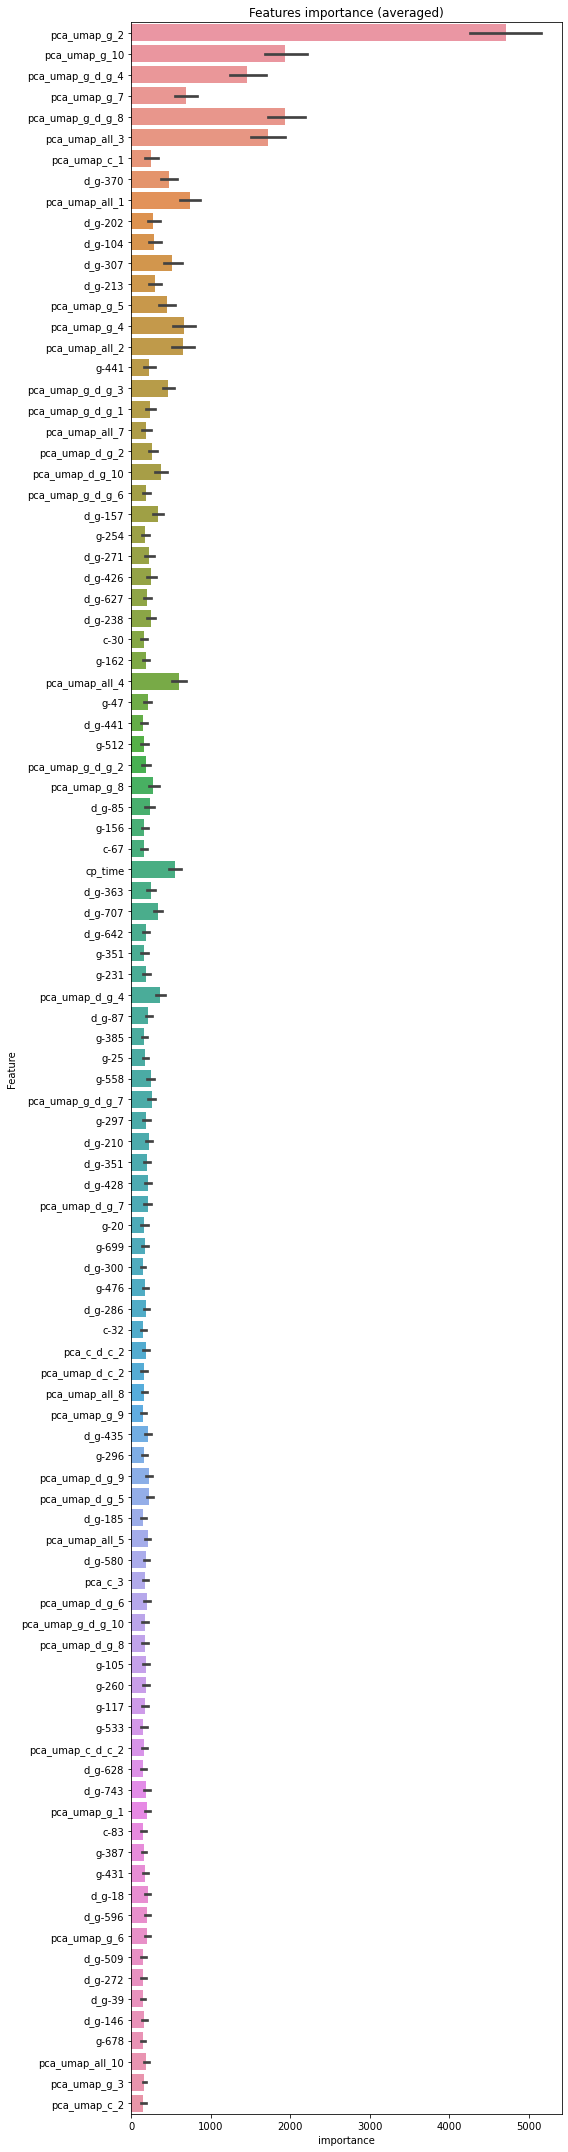

In [52]:
show_feature_importance(feature_importance_df)